In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_foul(description):
        return 1 if description in ["foul_tip", "foul_pitchout", 'foul', 'foul_pitchout'] else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)


    df['foul'] = df['description'].apply(is_foul)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('strike == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


UndefinedVariableError: name 'strike' is not defined

In [ ]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [ ]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [ ]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [ ]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5660429874748725
Log Loss: 0.680160924723163


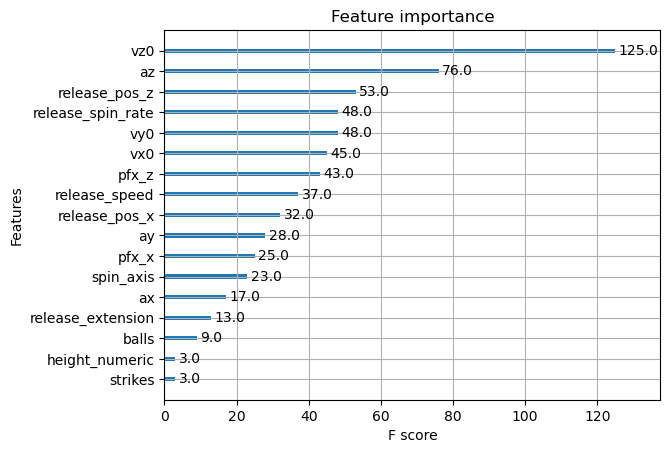

In [ ]:
xgb.plot_importance(model)
plt.show()

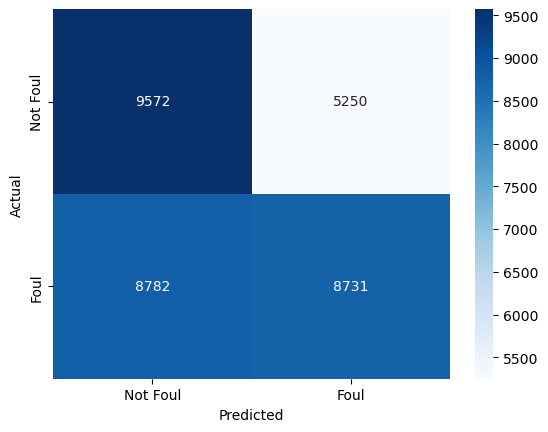

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 17:12:56,358] A new study created in memory with name: no-name-ea258a6e-b6ba-4819-a68a-bfe901bbca88


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67767
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67583
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67425
[12]	eval-logloss:0.67393
[13]	eval-logloss:0.67383
[14]	eval-logloss:0.67372
[15]	eval-logloss:0.67382
[16]	eval-logloss:0.67375
[17]	eval-logloss:0.67362
[18]	eval-logloss:0.67362
[19]	eval-logloss:0.67348
[20]	eval-logloss:0.67337
[21]	eval-logloss:0.67360
[22]	eval-logloss:0.67339
[23]	eval-logloss:0.67336
[24]	eval-logloss:0.67339
[25]	eval-logloss:0.67339
[26]	eval-logloss:0.67338
[27]	eval-logloss:0.67329
[28]	eval-logloss:0.67332
[29]	eval-logloss:0.67325
[30]	eval-logloss:0.67332
[31]	eval-logloss:0.67343
[32]	eval-logloss:0.67312
[33]	eval-logloss:0.67309
[34]	eval-logloss:0.67295
[35]	eval-logloss:0.67275
[36]	eval-logloss:0.67290
[37]	eval-logloss:0.67296
[38]	eval-logloss:0.67

[I 2023-11-09 17:12:57,737] Trial 0 finished with value: 0.6747989257073554 and parameters: {'max_depth': 6, 'eta': 0.1983847298678067, 'subsample': 0.6653530887849815, 'colsample_bytree': 0.8134913801550512}. Best is trial 0 with value: 0.6747989257073554.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68613
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68339
[6]	eval-logloss:0.68209
[7]	eval-logloss:0.68157
[8]	eval-logloss:0.68128
[9]	eval-logloss:0.68100
[10]	eval-logloss:0.67997
[11]	eval-logloss:0.67898
[12]	eval-logloss:0.67812
[13]	eval-logloss:0.67791
[14]	eval-logloss:0.67749
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67696
[17]	eval-logloss:0.67640
[18]	eval-logloss:0.67603
[19]	eval-logloss:0.67565
[20]	eval-logloss:0.67555
[21]	eval-logloss:0.67552
[22]	eval-logloss:0.67514
[23]	eval-logloss:0.67498
[24]	eval-logloss:0.67479
[25]	eval-logloss:0.67476
[26]	eval-logloss:0.67459
[27]	eval-logloss:0.67437
[28]	eval-logloss:0.67434
[29]	eval-logloss:0.67430
[30]	eval-logloss:0.67429
[31]	eval-logloss:0.67413
[32]	eval-logloss:0.67403
[33]	eval-logloss:0.67401
[34]	eval-logloss:0.67389
[35]	eval-logloss:0.67382
[36]	eval-logloss:0.67375
[37]	eval-logloss:0.67376
[38]	eval-logloss:0.67

[I 2023-11-09 17:12:59,077] Trial 1 finished with value: 0.6721734946127702 and parameters: {'max_depth': 5, 'eta': 0.11918817777643276, 'subsample': 0.8872271246899277, 'colsample_bytree': 0.5233949071290399}. Best is trial 0 with value: 0.6747989257073554.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68694
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68075
[17]	eval-logloss:0.68009
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67835
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67769
[24]	eval-logloss:0.67732
[25]	eval-logloss:0.67718
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67649
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67616
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67586
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67550
[36]	eval-logloss:0.67543
[37]	eval-logloss:0.67538
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:01,035] Trial 2 finished with value: 0.6721372971320302 and parameters: {'max_depth': 8, 'eta': 0.04960809616405182, 'subsample': 0.6601378790067902, 'colsample_bytree': 0.5380787166274192}. Best is trial 0 with value: 0.6747989257073554.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68244
[3]	eval-logloss:0.68030
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67792
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67477
[11]	eval-logloss:0.67451
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67370
[14]	eval-logloss:0.67359
[15]	eval-logloss:0.67345
[16]	eval-logloss:0.67329
[17]	eval-logloss:0.67307
[18]	eval-logloss:0.67294
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67277
[21]	eval-logloss:0.67285
[22]	eval-logloss:0.67277
[23]	eval-logloss:0.67277
[24]	eval-logloss:0.67278
[25]	eval-logloss:0.67278
[26]	eval-logloss:0.67283
[27]	eval-logloss:0.67283
[28]	eval-logloss:0.67289
[29]	eval-logloss:0.67288
[30]	eval-logloss:0.67295
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67299
[33]	eval-logloss:0.67298
[34]	eval-logloss:0.67307
[35]	eval-logloss:0.67311
[36]	eval-logloss:0.67318
[37]	eval-logloss:0.67332
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:02,314] Trial 3 finished with value: 0.6743238882935152 and parameters: {'max_depth': 7, 'eta': 0.178346940402372, 'subsample': 0.8466318812138494, 'colsample_bytree': 0.6946832380017265}. Best is trial 0 with value: 0.6747989257073554.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68515
[2]	eval-logloss:0.68188
[3]	eval-logloss:0.67972
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67751
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67546
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67395
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67374
[15]	eval-logloss:0.67369
[16]	eval-logloss:0.67356
[17]	eval-logloss:0.67336
[18]	eval-logloss:0.67341
[19]	eval-logloss:0.67324
[20]	eval-logloss:0.67317
[21]	eval-logloss:0.67323
[22]	eval-logloss:0.67324
[23]	eval-logloss:0.67328
[24]	eval-logloss:0.67318
[25]	eval-logloss:0.67308
[26]	eval-logloss:0.67307
[27]	eval-logloss:0.67285
[28]	eval-logloss:0.67299
[29]	eval-logloss:0.67307
[30]	eval-logloss:0.67315
[31]	eval-logloss:0.67304
[32]	eval-logloss:0.67313
[33]	eval-logloss:0.67332
[34]	eval-logloss:0.67346
[35]	eval-logloss:0.67347
[36]	eval-logloss:0.67347
[37]	eval-logloss:0.67350
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:03,412] Trial 4 finished with value: 0.6746201900025223 and parameters: {'max_depth': 6, 'eta': 0.2123333601813466, 'subsample': 0.8228548966521114, 'colsample_bytree': 0.6801258406793605}. Best is trial 0 with value: 0.6747989257073554.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68259
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67803
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67644
[6]	eval-logloss:0.67607
[7]	eval-logloss:0.67630
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67574
[11]	eval-logloss:0.67604
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67588
[14]	eval-logloss:0.67628
[15]	eval-logloss:0.67674
[16]	eval-logloss:0.67689
[17]	eval-logloss:0.67686
[18]	eval-logloss:0.67673
[19]	eval-logloss:0.67682
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67725
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67891
[29]	eval-logloss:0.67914
[30]	eval-logloss:0.67936
[31]	eval-logloss:0.67954
[32]	eval-logloss:0.67975
[33]	eval-logloss:0.67977
[34]	eval-logloss:0.68036
[35]	eval-logloss:0.68041
[36]	eval-logloss:0.68077
[37]	eval-logloss:0.68104
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:04,491] Trial 5 finished with value: 0.6854366065721083 and parameters: {'max_depth': 8, 'eta': 0.28695623681416244, 'subsample': 0.8824517233461077, 'colsample_bytree': 0.5682428602964389}. Best is trial 5 with value: 0.6854366065721083.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68624
[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68221
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67731
[9]	eval-logloss:0.67680
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67607
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67568
[14]	eval-logloss:0.67544
[15]	eval-logloss:0.67514
[16]	eval-logloss:0.67512
[17]	eval-logloss:0.67483
[18]	eval-logloss:0.67471
[19]	eval-logloss:0.67450
[20]	eval-logloss:0.67425
[21]	eval-logloss:0.67411
[22]	eval-logloss:0.67401
[23]	eval-logloss:0.67399
[24]	eval-logloss:0.67387
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67363
[27]	eval-logloss:0.67349
[28]	eval-logloss:0.67353
[29]	eval-logloss:0.67338
[30]	eval-logloss:0.67330
[31]	eval-logloss:0.67338
[32]	eval-logloss:0.67323
[33]	eval-logloss:0.67318
[34]	eval-logloss:0.67314
[35]	eval-logloss:0.67289
[36]	eval-logloss:0.67277
[37]	eval-logloss:0.67282
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:05,682] Trial 6 finished with value: 0.6718123795786224 and parameters: {'max_depth': 4, 'eta': 0.1672122786550399, 'subsample': 0.6825299983901155, 'colsample_bytree': 0.9126339935823559}. Best is trial 5 with value: 0.6854366065721083.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68331
[2]	eval-logloss:0.68151
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67619
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67637
[9]	eval-logloss:0.67648
[10]	eval-logloss:0.67650
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67721
[13]	eval-logloss:0.67781
[14]	eval-logloss:0.67804
[15]	eval-logloss:0.67866
[16]	eval-logloss:0.67898
[17]	eval-logloss:0.67934
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67986
[21]	eval-logloss:0.68047
[22]	eval-logloss:0.68088
[23]	eval-logloss:0.68082
[24]	eval-logloss:0.68118
[25]	eval-logloss:0.68169
[26]	eval-logloss:0.68256
[27]	eval-logloss:0.68284
[28]	eval-logloss:0.68395
[29]	eval-logloss:0.68412
[30]	eval-logloss:0.68445
[31]	eval-logloss:0.68495
[32]	eval-logloss:0.68490
[33]	eval-logloss:0.68521
[34]	eval-logloss:0.68556
[35]	eval-logloss:0.68601
[36]	eval-logloss:0.68618
[37]	eval-logloss:0.68656
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:06,900] Trial 7 finished with value: 0.6909119400785343 and parameters: {'max_depth': 9, 'eta': 0.25006664447457017, 'subsample': 0.6806261289328188, 'colsample_bytree': 0.5835110580784996}. Best is trial 7 with value: 0.6909119400785343.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67775
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67656
[11]	eval-logloss:0.67636
[12]	eval-logloss:0.67591
[13]	eval-logloss:0.67559
[14]	eval-logloss:0.67523
[15]	eval-logloss:0.67497
[16]	eval-logloss:0.67481
[17]	eval-logloss:0.67457
[18]	eval-logloss:0.67445
[19]	eval-logloss:0.67420
[20]	eval-logloss:0.67402
[21]	eval-logloss:0.67390
[22]	eval-logloss:0.67375
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67354
[25]	eval-logloss:0.67345
[26]	eval-logloss:0.67350
[27]	eval-logloss:0.67332
[28]	eval-logloss:0.67328
[29]	eval-logloss:0.67328
[30]	eval-logloss:0.67327
[31]	eval-logloss:0.67323
[32]	eval-logloss:0.67320
[33]	eval-logloss:0.67323
[34]	eval-logloss:0.67326
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67339
[37]	eval-logloss:0.67339
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:08,800] Trial 8 finished with value: 0.6746039169486917 and parameters: {'max_depth': 9, 'eta': 0.08994910169732197, 'subsample': 0.7345895517610819, 'colsample_bytree': 0.770269954749474}. Best is trial 7 with value: 0.6909119400785343.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68154
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67677
[11]	eval-logloss:0.67650
[12]	eval-logloss:0.67621
[13]	eval-logloss:0.67607
[14]	eval-logloss:0.67579
[15]	eval-logloss:0.67561
[16]	eval-logloss:0.67549
[17]	eval-logloss:0.67519
[18]	eval-logloss:0.67508
[19]	eval-logloss:0.67488
[20]	eval-logloss:0.67465
[21]	eval-logloss:0.67454
[22]	eval-logloss:0.67435
[23]	eval-logloss:0.67430
[24]	eval-logloss:0.67418
[25]	eval-logloss:0.67405
[26]	eval-logloss:0.67389
[27]	eval-logloss:0.67382
[28]	eval-logloss:0.67380
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67378
[31]	eval-logloss:0.67375
[32]	eval-logloss:0.67360
[33]	eval-logloss:0.67354
[34]	eval-logloss:0.67345
[35]	eval-logloss:0.67336
[36]	eval-logloss:0.67331
[37]	eval-logloss:0.67330
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:10,198] Trial 9 finished with value: 0.672099196511737 and parameters: {'max_depth': 4, 'eta': 0.14627278110904823, 'subsample': 0.6646392343148801, 'colsample_bytree': 0.9636966412409158}. Best is trial 7 with value: 0.6909119400785343.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.68089
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.68022
[10]	eval-logloss:0.68054
[11]	eval-logloss:0.68113
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68221
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68384
[17]	eval-logloss:0.68385
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68466
[21]	eval-logloss:0.68511
[22]	eval-logloss:0.68523
[23]	eval-logloss:0.68553
[24]	eval-logloss:0.68594
[25]	eval-logloss:0.68635
[26]	eval-logloss:0.68688
[27]	eval-logloss:0.68734
[28]	eval-logloss:0.68810
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68972
[32]	eval-logloss:0.69008
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69104
[35]	eval-logloss:0.69148
[36]	eval-logloss:0.69213
[37]	eval-logloss:0.69300
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:11,666] Trial 10 finished with value: 0.7005543172600431 and parameters: {'max_depth': 9, 'eta': 0.29920229975679324, 'subsample': 0.6082027235786467, 'colsample_bytree': 0.6318739210717343}. Best is trial 10 with value: 0.7005543172600431.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67969
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67966
[8]	eval-logloss:0.67976
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68381
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68445
[19]	eval-logloss:0.68493
[20]	eval-logloss:0.68531
[21]	eval-logloss:0.68616
[22]	eval-logloss:0.68654
[23]	eval-logloss:0.68687
[24]	eval-logloss:0.68708
[25]	eval-logloss:0.68738
[26]	eval-logloss:0.68800
[27]	eval-logloss:0.68845
[28]	eval-logloss:0.68994
[29]	eval-logloss:0.69015
[30]	eval-logloss:0.69038
[31]	eval-logloss:0.69059
[32]	eval-logloss:0.69077
[33]	eval-logloss:0.69120
[34]	eval-logloss:0.69136
[35]	eval-logloss:0.69197
[36]	eval-logloss:0.69255
[37]	eval-logloss:0.69320
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:12,993] Trial 11 finished with value: 0.7006471535249177 and parameters: {'max_depth': 9, 'eta': 0.2976574192562235, 'subsample': 0.6028497710144736, 'colsample_bytree': 0.62154160883235}. Best is trial 11 with value: 0.7006471535249177.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.68153
[3]	eval-logloss:0.67936
[4]	eval-logloss:0.67912
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67687
[7]	eval-logloss:0.67766
[8]	eval-logloss:0.67691
[9]	eval-logloss:0.67658
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67705
[12]	eval-logloss:0.67727
[13]	eval-logloss:0.67740
[14]	eval-logloss:0.67784
[15]	eval-logloss:0.67797
[16]	eval-logloss:0.67831
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67840
[19]	eval-logloss:0.67827
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67852
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67933
[25]	eval-logloss:0.67978
[26]	eval-logloss:0.67973
[27]	eval-logloss:0.68037
[28]	eval-logloss:0.68074
[29]	eval-logloss:0.68089
[30]	eval-logloss:0.68098
[31]	eval-logloss:0.68111
[32]	eval-logloss:0.68097
[33]	eval-logloss:0.68131
[34]	eval-logloss:0.68174
[35]	eval-logloss:0.68203
[36]	eval-logloss:0.68242
[37]	eval-logloss:0.68272
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:14,189] Trial 12 finished with value: 0.689640468875535 and parameters: {'max_depth': 8, 'eta': 0.27918664688718076, 'subsample': 0.6128783261709355, 'colsample_bytree': 0.6218508032465987}. Best is trial 11 with value: 0.7006471535249177.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.68160
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67917
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67973
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.68053
[11]	eval-logloss:0.68148
[12]	eval-logloss:0.68198
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68372
[16]	eval-logloss:0.68470
[17]	eval-logloss:0.68456
[18]	eval-logloss:0.68479
[19]	eval-logloss:0.68522
[20]	eval-logloss:0.68588
[21]	eval-logloss:0.68636
[22]	eval-logloss:0.68711
[23]	eval-logloss:0.68770
[24]	eval-logloss:0.68802
[25]	eval-logloss:0.68840
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68930
[28]	eval-logloss:0.68997
[29]	eval-logloss:0.69073
[30]	eval-logloss:0.69122
[31]	eval-logloss:0.69158
[32]	eval-logloss:0.69177
[33]	eval-logloss:0.69238
[34]	eval-logloss:0.69264
[35]	eval-logloss:0.69302
[36]	eval-logloss:0.69367
[37]	eval-logloss:0.69443
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:15,427] Trial 13 finished with value: 0.7030043614799655 and parameters: {'max_depth': 9, 'eta': 0.29453385839245466, 'subsample': 0.6006044750672346, 'colsample_bytree': 0.6472363742020302}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68118
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67604
[12]	eval-logloss:0.67552
[13]	eval-logloss:0.67549
[14]	eval-logloss:0.67549
[15]	eval-logloss:0.67549
[16]	eval-logloss:0.67557
[17]	eval-logloss:0.67548
[18]	eval-logloss:0.67526
[19]	eval-logloss:0.67514
[20]	eval-logloss:0.67527
[21]	eval-logloss:0.67557
[22]	eval-logloss:0.67564
[23]	eval-logloss:0.67579
[24]	eval-logloss:0.67587
[25]	eval-logloss:0.67593
[26]	eval-logloss:0.67584
[27]	eval-logloss:0.67583
[28]	eval-logloss:0.67580
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67611
[33]	eval-logloss:0.67614
[34]	eval-logloss:0.67619
[35]	eval-logloss:0.67630
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67656
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:16,585] Trial 14 finished with value: 0.680874563850621 and parameters: {'max_depth': 7, 'eta': 0.23705185562791067, 'subsample': 0.60273473953474, 'colsample_bytree': 0.5023921580822913}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68356
[3]	eval-logloss:0.68171
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.68007
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67888
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67699
[11]	eval-logloss:0.67669
[12]	eval-logloss:0.67626
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67569
[15]	eval-logloss:0.67551
[16]	eval-logloss:0.67539
[17]	eval-logloss:0.67516
[18]	eval-logloss:0.67505
[19]	eval-logloss:0.67476
[20]	eval-logloss:0.67468
[21]	eval-logloss:0.67478
[22]	eval-logloss:0.67460
[23]	eval-logloss:0.67459
[24]	eval-logloss:0.67445
[25]	eval-logloss:0.67429
[26]	eval-logloss:0.67418
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67401
[31]	eval-logloss:0.67392
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67379
[34]	eval-logloss:0.67373
[35]	eval-logloss:0.67369
[36]	eval-logloss:0.67358
[37]	eval-logloss:0.67355
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:17,772] Trial 15 finished with value: 0.6727366985494297 and parameters: {'max_depth': 3, 'eta': 0.24903032327425925, 'subsample': 0.7226631403558221, 'colsample_bytree': 0.6913389862627184}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.68147
[3]	eval-logloss:0.67890
[4]	eval-logloss:0.67800
[5]	eval-logloss:0.67622
[6]	eval-logloss:0.67538
[7]	eval-logloss:0.67562
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67470
[13]	eval-logloss:0.67470
[14]	eval-logloss:0.67473
[15]	eval-logloss:0.67498
[16]	eval-logloss:0.67505
[17]	eval-logloss:0.67497
[18]	eval-logloss:0.67519
[19]	eval-logloss:0.67540
[20]	eval-logloss:0.67552
[21]	eval-logloss:0.67586
[22]	eval-logloss:0.67603
[23]	eval-logloss:0.67625
[24]	eval-logloss:0.67623
[25]	eval-logloss:0.67625
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67711
[30]	eval-logloss:0.67713
[31]	eval-logloss:0.67728
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67735
[34]	eval-logloss:0.67750
[35]	eval-logloss:0.67750
[36]	eval-logloss:0.67794
[37]	eval-logloss:0.67811
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:18,961] Trial 16 finished with value: 0.6812008692916361 and parameters: {'max_depth': 7, 'eta': 0.26882245773786856, 'subsample': 0.637286395741258, 'colsample_bytree': 0.6205205292122153}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67916
[3]	eval-logloss:0.67844
[4]	eval-logloss:0.67795
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67705
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67825
[9]	eval-logloss:0.67886
[10]	eval-logloss:0.67922
[11]	eval-logloss:0.67983
[12]	eval-logloss:0.68014
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68169
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68291
[19]	eval-logloss:0.68369
[20]	eval-logloss:0.68424
[21]	eval-logloss:0.68497
[22]	eval-logloss:0.68482
[23]	eval-logloss:0.68517
[24]	eval-logloss:0.68584
[25]	eval-logloss:0.68630
[26]	eval-logloss:0.68677
[27]	eval-logloss:0.68746
[28]	eval-logloss:0.68841
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68911
[31]	eval-logloss:0.68947
[32]	eval-logloss:0.69008
[33]	eval-logloss:0.69070
[34]	eval-logloss:0.69116
[35]	eval-logloss:0.69123
[36]	eval-logloss:0.69171
[37]	eval-logloss:0.69240
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:20,333] Trial 17 finished with value: 0.7014038099971257 and parameters: {'max_depth': 9, 'eta': 0.2981207704187465, 'subsample': 0.6370854610392841, 'colsample_bytree': 0.7385605768466403}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68643
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67939
[3]	eval-logloss:0.67758
[4]	eval-logloss:0.67655
[5]	eval-logloss:0.67572
[6]	eval-logloss:0.67523
[7]	eval-logloss:0.67471
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67422
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67486
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67469
[18]	eval-logloss:0.67485
[19]	eval-logloss:0.67495
[20]	eval-logloss:0.67505
[21]	eval-logloss:0.67511
[22]	eval-logloss:0.67527
[23]	eval-logloss:0.67532
[24]	eval-logloss:0.67524
[25]	eval-logloss:0.67527
[26]	eval-logloss:0.67523
[27]	eval-logloss:0.67550
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67585
[31]	eval-logloss:0.67613
[32]	eval-logloss:0.67611
[33]	eval-logloss:0.67621
[34]	eval-logloss:0.67633
[35]	eval-logloss:0.67644
[36]	eval-logloss:0.67651
[37]	eval-logloss:0.67662
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:21,583] Trial 18 finished with value: 0.6802364648146985 and parameters: {'max_depth': 8, 'eta': 0.21586289118237917, 'subsample': 0.70874792489248, 'colsample_bytree': 0.795909741676564}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68193
[2]	eval-logloss:0.67914
[3]	eval-logloss:0.67776
[4]	eval-logloss:0.67673
[5]	eval-logloss:0.67575
[6]	eval-logloss:0.67531
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67485
[10]	eval-logloss:0.67447
[11]	eval-logloss:0.67465
[12]	eval-logloss:0.67443
[13]	eval-logloss:0.67430
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67419
[16]	eval-logloss:0.67387
[17]	eval-logloss:0.67376
[18]	eval-logloss:0.67383
[19]	eval-logloss:0.67358
[20]	eval-logloss:0.67362
[21]	eval-logloss:0.67360
[22]	eval-logloss:0.67336
[23]	eval-logloss:0.67342
[24]	eval-logloss:0.67378
[25]	eval-logloss:0.67393
[26]	eval-logloss:0.67401
[27]	eval-logloss:0.67401
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67396
[31]	eval-logloss:0.67404
[32]	eval-logloss:0.67395
[33]	eval-logloss:0.67416
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67412
[36]	eval-logloss:0.67418
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:22,737] Trial 19 finished with value: 0.6766089586758018 and parameters: {'max_depth': 6, 'eta': 0.2641876869275086, 'subsample': 0.774666797653939, 'colsample_bytree': 0.7323543457061414}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68622
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67921
[3]	eval-logloss:0.67772
[4]	eval-logloss:0.67641
[5]	eval-logloss:0.67539
[6]	eval-logloss:0.67499
[7]	eval-logloss:0.67495
[8]	eval-logloss:0.67448
[9]	eval-logloss:0.67441
[10]	eval-logloss:0.67433
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67436
[14]	eval-logloss:0.67442
[15]	eval-logloss:0.67445
[16]	eval-logloss:0.67468
[17]	eval-logloss:0.67470
[18]	eval-logloss:0.67487
[19]	eval-logloss:0.67495
[20]	eval-logloss:0.67490
[21]	eval-logloss:0.67514
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67539
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67549
[26]	eval-logloss:0.67543
[27]	eval-logloss:0.67559
[28]	eval-logloss:0.67610
[29]	eval-logloss:0.67604
[30]	eval-logloss:0.67612
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67608
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67646
[35]	eval-logloss:0.67648
[36]	eval-logloss:0.67666
[37]	eval-logloss:0.67674
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:23,899] Trial 20 finished with value: 0.680274347017338 and parameters: {'max_depth': 7, 'eta': 0.24260412158187794, 'subsample': 0.6397895026291315, 'colsample_bytree': 0.7471162263146282}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68368
[2]	eval-logloss:0.68143
[3]	eval-logloss:0.67985
[4]	eval-logloss:0.67972
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.67966
[11]	eval-logloss:0.68041
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68164
[16]	eval-logloss:0.68234
[17]	eval-logloss:0.68221
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68307
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68391
[22]	eval-logloss:0.68378
[23]	eval-logloss:0.68408
[24]	eval-logloss:0.68471
[25]	eval-logloss:0.68461
[26]	eval-logloss:0.68561
[27]	eval-logloss:0.68626
[28]	eval-logloss:0.68702
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68739
[31]	eval-logloss:0.68786
[32]	eval-logloss:0.68803
[33]	eval-logloss:0.68884
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68990
[36]	eval-logloss:0.69075
[37]	eval-logloss:0.69122
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:25,280] Trial 21 finished with value: 0.6991487786949677 and parameters: {'max_depth': 9, 'eta': 0.2983553157300515, 'subsample': 0.6305920639995866, 'colsample_bytree': 0.641899928883161}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68336
[2]	eval-logloss:0.68128
[3]	eval-logloss:0.67983
[4]	eval-logloss:0.67956
[5]	eval-logloss:0.67895
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67953
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67987
[11]	eval-logloss:0.68054
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68297
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68361
[19]	eval-logloss:0.68372
[20]	eval-logloss:0.68430
[21]	eval-logloss:0.68535
[22]	eval-logloss:0.68568
[23]	eval-logloss:0.68585
[24]	eval-logloss:0.68662
[25]	eval-logloss:0.68707
[26]	eval-logloss:0.68817
[27]	eval-logloss:0.68848
[28]	eval-logloss:0.68899
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68913
[31]	eval-logloss:0.68941
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.69058
[34]	eval-logloss:0.69100
[35]	eval-logloss:0.69119
[36]	eval-logloss:0.69166
[37]	eval-logloss:0.69241
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:26,690] Trial 22 finished with value: 0.7020723638894443 and parameters: {'max_depth': 9, 'eta': 0.2986514614875205, 'subsample': 0.6248471503563368, 'colsample_bytree': 0.5879223738012619}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68355
[2]	eval-logloss:0.68155
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67731
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67637
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67629
[11]	eval-logloss:0.67647
[12]	eval-logloss:0.67616
[13]	eval-logloss:0.67627
[14]	eval-logloss:0.67645
[15]	eval-logloss:0.67681
[16]	eval-logloss:0.67734
[17]	eval-logloss:0.67741
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67801
[20]	eval-logloss:0.67831
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67887
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67937
[25]	eval-logloss:0.67959
[26]	eval-logloss:0.67978
[27]	eval-logloss:0.68023
[28]	eval-logloss:0.68086
[29]	eval-logloss:0.68089
[30]	eval-logloss:0.68113
[31]	eval-logloss:0.68149
[32]	eval-logloss:0.68167
[33]	eval-logloss:0.68234
[34]	eval-logloss:0.68241
[35]	eval-logloss:0.68268
[36]	eval-logloss:0.68304
[37]	eval-logloss:0.68316
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:28,098] Trial 23 finished with value: 0.6877515668300872 and parameters: {'max_depth': 8, 'eta': 0.26498230018052804, 'subsample': 0.6308101317850017, 'colsample_bytree': 0.5667397024663037}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68422
[2]	eval-logloss:0.68057
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67946
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67903
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67876
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67956
[12]	eval-logloss:0.67956
[13]	eval-logloss:0.67951
[14]	eval-logloss:0.67943
[15]	eval-logloss:0.67946
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68126
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68276
[23]	eval-logloss:0.68308
[24]	eval-logloss:0.68353
[25]	eval-logloss:0.68377
[26]	eval-logloss:0.68427
[27]	eval-logloss:0.68452
[28]	eval-logloss:0.68518
[29]	eval-logloss:0.68558
[30]	eval-logloss:0.68568
[31]	eval-logloss:0.68589
[32]	eval-logloss:0.68629
[33]	eval-logloss:0.68673
[34]	eval-logloss:0.68715
[35]	eval-logloss:0.68742
[36]	eval-logloss:0.68790
[37]	eval-logloss:0.68799
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:29,405] Trial 24 finished with value: 0.6941936718558296 and parameters: {'max_depth': 9, 'eta': 0.2757042203793628, 'subsample': 0.6970100644831004, 'colsample_bytree': 0.6748427269420699}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67743
[6]	eval-logloss:0.67675
[7]	eval-logloss:0.67689
[8]	eval-logloss:0.67654
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67628
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67588
[13]	eval-logloss:0.67618
[14]	eval-logloss:0.67631
[15]	eval-logloss:0.67657
[16]	eval-logloss:0.67648
[17]	eval-logloss:0.67667
[18]	eval-logloss:0.67663
[19]	eval-logloss:0.67664
[20]	eval-logloss:0.67678
[21]	eval-logloss:0.67715
[22]	eval-logloss:0.67731
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67761
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67834
[29]	eval-logloss:0.67866
[30]	eval-logloss:0.67883
[31]	eval-logloss:0.67900
[32]	eval-logloss:0.67902
[33]	eval-logloss:0.67948
[34]	eval-logloss:0.67953
[35]	eval-logloss:0.67975
[36]	eval-logloss:0.67998
[37]	eval-logloss:0.68004
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:30,509] Trial 25 finished with value: 0.6839134251647394 and parameters: {'max_depth': 8, 'eta': 0.23260056205745083, 'subsample': 0.6517165933692645, 'colsample_bytree': 0.585655057605515}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68481
[2]	eval-logloss:0.68208
[3]	eval-logloss:0.68096
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67979
[7]	eval-logloss:0.68026
[8]	eval-logloss:0.67977
[9]	eval-logloss:0.67973
[10]	eval-logloss:0.67984
[11]	eval-logloss:0.68035
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68379
[17]	eval-logloss:0.68396
[18]	eval-logloss:0.68436
[19]	eval-logloss:0.68476
[20]	eval-logloss:0.68565
[21]	eval-logloss:0.68599
[22]	eval-logloss:0.68639
[23]	eval-logloss:0.68656
[24]	eval-logloss:0.68720
[25]	eval-logloss:0.68709
[26]	eval-logloss:0.68764
[27]	eval-logloss:0.68810
[28]	eval-logloss:0.68844
[29]	eval-logloss:0.68874
[30]	eval-logloss:0.68919
[31]	eval-logloss:0.68927
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.69013
[34]	eval-logloss:0.69053
[35]	eval-logloss:0.69063
[36]	eval-logloss:0.69166
[37]	eval-logloss:0.69166
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:31,783] Trial 26 finished with value: 0.6999395575369218 and parameters: {'max_depth': 9, 'eta': 0.2750392712335795, 'subsample': 0.6238860742364367, 'colsample_bytree': 0.7181078820405129}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.68189
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67912
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67705
[10]	eval-logloss:0.67682
[11]	eval-logloss:0.67680
[12]	eval-logloss:0.67672
[13]	eval-logloss:0.67671
[14]	eval-logloss:0.67688
[15]	eval-logloss:0.67717
[16]	eval-logloss:0.67755
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67835
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67895
[22]	eval-logloss:0.67949
[23]	eval-logloss:0.67936
[24]	eval-logloss:0.67974
[25]	eval-logloss:0.67991
[26]	eval-logloss:0.68043
[27]	eval-logloss:0.68057
[28]	eval-logloss:0.68114
[29]	eval-logloss:0.68146
[30]	eval-logloss:0.68186
[31]	eval-logloss:0.68222
[32]	eval-logloss:0.68234
[33]	eval-logloss:0.68284
[34]	eval-logloss:0.68301
[35]	eval-logloss:0.68301
[36]	eval-logloss:0.68338
[37]	eval-logloss:0.68345
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:32,935] Trial 27 finished with value: 0.6889163180714184 and parameters: {'max_depth': 8, 'eta': 0.255903142032119, 'subsample': 0.644795565207312, 'colsample_bytree': 0.6592960861581075}. Best is trial 13 with value: 0.7030043614799655.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.68067
[3]	eval-logloss:0.67929
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67924
[7]	eval-logloss:0.67994
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67972
[10]	eval-logloss:0.67977
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.68039
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68128
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68356
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68451
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68573
[22]	eval-logloss:0.68616
[23]	eval-logloss:0.68631
[24]	eval-logloss:0.68664
[25]	eval-logloss:0.68680
[26]	eval-logloss:0.68715
[27]	eval-logloss:0.68761
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68937
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.69040
[32]	eval-logloss:0.69107
[33]	eval-logloss:0.69149
[34]	eval-logloss:0.69223
[35]	eval-logloss:0.69224
[36]	eval-logloss:0.69267
[37]	eval-logloss:0.69367
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:34,137] Trial 28 finished with value: 0.7033295380380942 and parameters: {'max_depth': 9, 'eta': 0.2999447511156074, 'subsample': 0.6003272187537715, 'colsample_bytree': 0.7062360300447382}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68388
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67610
[6]	eval-logloss:0.67533
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67383
[11]	eval-logloss:0.67397
[12]	eval-logloss:0.67364
[13]	eval-logloss:0.67359
[14]	eval-logloss:0.67358
[15]	eval-logloss:0.67351
[16]	eval-logloss:0.67347
[17]	eval-logloss:0.67344
[18]	eval-logloss:0.67339
[19]	eval-logloss:0.67338
[20]	eval-logloss:0.67331
[21]	eval-logloss:0.67362
[22]	eval-logloss:0.67352
[23]	eval-logloss:0.67347
[24]	eval-logloss:0.67356
[25]	eval-logloss:0.67361
[26]	eval-logloss:0.67374
[27]	eval-logloss:0.67379
[28]	eval-logloss:0.67385
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67379
[31]	eval-logloss:0.67381
[32]	eval-logloss:0.67367
[33]	eval-logloss:0.67364
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67373
[36]	eval-logloss:0.67384
[37]	eval-logloss:0.67370
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:35,360] Trial 29 finished with value: 0.6759068804231037 and parameters: {'max_depth': 7, 'eta': 0.18982149434418844, 'subsample': 0.6182190310004456, 'colsample_bytree': 0.8097658450034979}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68508
[2]	eval-logloss:0.68192
[3]	eval-logloss:0.67992
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67517
[10]	eval-logloss:0.67458
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67408
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67360
[16]	eval-logloss:0.67359
[17]	eval-logloss:0.67336
[18]	eval-logloss:0.67325
[19]	eval-logloss:0.67320
[20]	eval-logloss:0.67325
[21]	eval-logloss:0.67329
[22]	eval-logloss:0.67326
[23]	eval-logloss:0.67311
[24]	eval-logloss:0.67298
[25]	eval-logloss:0.67292
[26]	eval-logloss:0.67277
[27]	eval-logloss:0.67279
[28]	eval-logloss:0.67287
[29]	eval-logloss:0.67268
[30]	eval-logloss:0.67274
[31]	eval-logloss:0.67274
[32]	eval-logloss:0.67254
[33]	eval-logloss:0.67249
[34]	eval-logloss:0.67239
[35]	eval-logloss:0.67234
[36]	eval-logloss:0.67239
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:36,636] Trial 30 finished with value: 0.6733864255029796 and parameters: {'max_depth': 5, 'eta': 0.2162019095290636, 'subsample': 0.6755791551634409, 'colsample_bytree': 0.7000821529993416}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68167
[2]	eval-logloss:0.67982
[3]	eval-logloss:0.67898
[4]	eval-logloss:0.67794
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67823
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67926
[9]	eval-logloss:0.67944
[10]	eval-logloss:0.67961
[11]	eval-logloss:0.68019
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.68134
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68270
[18]	eval-logloss:0.68303
[19]	eval-logloss:0.68366
[20]	eval-logloss:0.68428
[21]	eval-logloss:0.68489
[22]	eval-logloss:0.68544
[23]	eval-logloss:0.68590
[24]	eval-logloss:0.68647
[25]	eval-logloss:0.68695
[26]	eval-logloss:0.68788
[27]	eval-logloss:0.68840
[28]	eval-logloss:0.68916
[29]	eval-logloss:0.68962
[30]	eval-logloss:0.69017
[31]	eval-logloss:0.69061
[32]	eval-logloss:0.69102
[33]	eval-logloss:0.69129
[34]	eval-logloss:0.69164
[35]	eval-logloss:0.69187
[36]	eval-logloss:0.69246
[37]	eval-logloss:0.69299
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:37,845] Trial 31 finished with value: 0.7002850453640435 and parameters: {'max_depth': 9, 'eta': 0.28463852440849363, 'subsample': 0.6025695989167626, 'colsample_bytree': 0.7261021568815534}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67957
[3]	eval-logloss:0.67890
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67955
[11]	eval-logloss:0.68015
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68207
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68331
[16]	eval-logloss:0.68407
[17]	eval-logloss:0.68425
[18]	eval-logloss:0.68463
[19]	eval-logloss:0.68519
[20]	eval-logloss:0.68594
[21]	eval-logloss:0.68622
[22]	eval-logloss:0.68675
[23]	eval-logloss:0.68695
[24]	eval-logloss:0.68791
[25]	eval-logloss:0.68812
[26]	eval-logloss:0.68875
[27]	eval-logloss:0.68964
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.69070
[30]	eval-logloss:0.69098
[31]	eval-logloss:0.69132
[32]	eval-logloss:0.69129
[33]	eval-logloss:0.69201
[34]	eval-logloss:0.69239
[35]	eval-logloss:0.69248
[36]	eval-logloss:0.69309
[37]	eval-logloss:0.69374
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:39,009] Trial 32 finished with value: 0.7029703879231977 and parameters: {'max_depth': 9, 'eta': 0.2988480274283089, 'subsample': 0.6493929917014863, 'colsample_bytree': 0.7697584413600641}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67863
[3]	eval-logloss:0.67708
[4]	eval-logloss:0.67627
[5]	eval-logloss:0.67552
[6]	eval-logloss:0.67529
[7]	eval-logloss:0.67558
[8]	eval-logloss:0.67547
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67600
[12]	eval-logloss:0.67630
[13]	eval-logloss:0.67654
[14]	eval-logloss:0.67657
[15]	eval-logloss:0.67724
[16]	eval-logloss:0.67740
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67844
[20]	eval-logloss:0.67871
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67952
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.68002
[27]	eval-logloss:0.67999
[28]	eval-logloss:0.68020
[29]	eval-logloss:0.68057
[30]	eval-logloss:0.68074
[31]	eval-logloss:0.68098
[32]	eval-logloss:0.68078
[33]	eval-logloss:0.68107
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68118
[36]	eval-logloss:0.68147
[37]	eval-logloss:0.68178
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:40,068] Trial 33 finished with value: 0.6857088114025077 and parameters: {'max_depth': 8, 'eta': 0.262585008128285, 'subsample': 0.6538153546511442, 'colsample_bytree': 0.8426968440026518}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.68170
[2]	eval-logloss:0.67919
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67781
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67925
[11]	eval-logloss:0.67990
[12]	eval-logloss:0.67973
[13]	eval-logloss:0.68032
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68220
[18]	eval-logloss:0.68260
[19]	eval-logloss:0.68292
[20]	eval-logloss:0.68369
[21]	eval-logloss:0.68433
[22]	eval-logloss:0.68475
[23]	eval-logloss:0.68529
[24]	eval-logloss:0.68565
[25]	eval-logloss:0.68583
[26]	eval-logloss:0.68663
[27]	eval-logloss:0.68679
[28]	eval-logloss:0.68710
[29]	eval-logloss:0.68747
[30]	eval-logloss:0.68754
[31]	eval-logloss:0.68806
[32]	eval-logloss:0.68851
[33]	eval-logloss:0.68908
[34]	eval-logloss:0.68923
[35]	eval-logloss:0.68973
[36]	eval-logloss:0.69070
[37]	eval-logloss:0.69102
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:41,259] Trial 34 finished with value: 0.6988992265648996 and parameters: {'max_depth': 9, 'eta': 0.2783427749038945, 'subsample': 0.6190538596432418, 'colsample_bytree': 0.7721858648012189}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68360
[2]	eval-logloss:0.68157
[3]	eval-logloss:0.67909
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67664
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67535
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67558
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67577
[15]	eval-logloss:0.67583
[16]	eval-logloss:0.67592
[17]	eval-logloss:0.67592
[18]	eval-logloss:0.67600
[19]	eval-logloss:0.67627
[20]	eval-logloss:0.67655
[21]	eval-logloss:0.67687
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67727
[24]	eval-logloss:0.67723
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67839
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67865
[32]	eval-logloss:0.67854
[33]	eval-logloss:0.67869
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67903
[36]	eval-logloss:0.67902
[37]	eval-logloss:0.67929
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:42,470] Trial 35 finished with value: 0.6831460510316776 and parameters: {'max_depth': 8, 'eta': 0.23505857190770577, 'subsample': 0.6618570759150401, 'colsample_bytree': 0.6631087995113543}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68125
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67959
[7]	eval-logloss:0.68012
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.68095
[10]	eval-logloss:0.68106
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68152
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68317
[18]	eval-logloss:0.68372
[19]	eval-logloss:0.68404
[20]	eval-logloss:0.68450
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68504
[23]	eval-logloss:0.68569
[24]	eval-logloss:0.68593
[25]	eval-logloss:0.68660
[26]	eval-logloss:0.68673
[27]	eval-logloss:0.68733
[28]	eval-logloss:0.68833
[29]	eval-logloss:0.68861
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68925
[32]	eval-logloss:0.68955
[33]	eval-logloss:0.69045
[34]	eval-logloss:0.69090
[35]	eval-logloss:0.69117
[36]	eval-logloss:0.69147
[37]	eval-logloss:0.69144
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:43,790] Trial 36 finished with value: 0.6997109287038552 and parameters: {'max_depth': 9, 'eta': 0.28618697026682866, 'subsample': 0.6221582038707898, 'colsample_bytree': 0.5438730488866188}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68372
[2]	eval-logloss:0.68054
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67806
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67669
[10]	eval-logloss:0.67623
[11]	eval-logloss:0.67653
[12]	eval-logloss:0.67640
[13]	eval-logloss:0.67653
[14]	eval-logloss:0.67664
[15]	eval-logloss:0.67681
[16]	eval-logloss:0.67692
[17]	eval-logloss:0.67695
[18]	eval-logloss:0.67738
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67754
[21]	eval-logloss:0.67785
[22]	eval-logloss:0.67797
[23]	eval-logloss:0.67819
[24]	eval-logloss:0.67876
[25]	eval-logloss:0.67881
[26]	eval-logloss:0.67912
[27]	eval-logloss:0.67940
[28]	eval-logloss:0.67943
[29]	eval-logloss:0.67956
[30]	eval-logloss:0.67985
[31]	eval-logloss:0.68034
[32]	eval-logloss:0.68027
[33]	eval-logloss:0.68043
[34]	eval-logloss:0.68106
[35]	eval-logloss:0.68124
[36]	eval-logloss:0.68212
[37]	eval-logloss:0.68241
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:44,907] Trial 37 finished with value: 0.6879410824705385 and parameters: {'max_depth': 8, 'eta': 0.25957773600156386, 'subsample': 0.6489679878711891, 'colsample_bytree': 0.7054891731353707}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68141
[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67727
[7]	eval-logloss:0.67691
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67584
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67416
[14]	eval-logloss:0.67409
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67383
[17]	eval-logloss:0.67357
[18]	eval-logloss:0.67348
[19]	eval-logloss:0.67332
[20]	eval-logloss:0.67324
[21]	eval-logloss:0.67327
[22]	eval-logloss:0.67305
[23]	eval-logloss:0.67308
[24]	eval-logloss:0.67305
[25]	eval-logloss:0.67310
[26]	eval-logloss:0.67298
[27]	eval-logloss:0.67288
[28]	eval-logloss:0.67301
[29]	eval-logloss:0.67301
[30]	eval-logloss:0.67305
[31]	eval-logloss:0.67313
[32]	eval-logloss:0.67289
[33]	eval-logloss:0.67292
[34]	eval-logloss:0.67281
[35]	eval-logloss:0.67277
[36]	eval-logloss:0.67280
[37]	eval-logloss:0.67284
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:46,091] Trial 38 finished with value: 0.672997969404284 and parameters: {'max_depth': 5, 'eta': 0.20537363806850978, 'subsample': 0.6666083062768753, 'colsample_bytree': 0.592832351297223}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68384
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.68013
[4]	eval-logloss:0.68055
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67944
[7]	eval-logloss:0.68020
[8]	eval-logloss:0.68028
[9]	eval-logloss:0.68040
[10]	eval-logloss:0.68017
[11]	eval-logloss:0.68116
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68325
[17]	eval-logloss:0.68350
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68407
[20]	eval-logloss:0.68438
[21]	eval-logloss:0.68514
[22]	eval-logloss:0.68561
[23]	eval-logloss:0.68587
[24]	eval-logloss:0.68641
[25]	eval-logloss:0.68645
[26]	eval-logloss:0.68726
[27]	eval-logloss:0.68771
[28]	eval-logloss:0.68832
[29]	eval-logloss:0.68855
[30]	eval-logloss:0.68887
[31]	eval-logloss:0.68919
[32]	eval-logloss:0.68980
[33]	eval-logloss:0.69014
[34]	eval-logloss:0.69090
[35]	eval-logloss:0.69127
[36]	eval-logloss:0.69187
[37]	eval-logloss:0.69245
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:47,230] Trial 39 finished with value: 0.7032521203871622 and parameters: {'max_depth': 9, 'eta': 0.2870286020483175, 'subsample': 0.6003773041950328, 'colsample_bytree': 0.6519551723908497}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.67971
[3]	eval-logloss:0.67756
[4]	eval-logloss:0.67722
[5]	eval-logloss:0.67594
[6]	eval-logloss:0.67568
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67546
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67536
[13]	eval-logloss:0.67576
[14]	eval-logloss:0.67580
[15]	eval-logloss:0.67612
[16]	eval-logloss:0.67614
[17]	eval-logloss:0.67608
[18]	eval-logloss:0.67624
[19]	eval-logloss:0.67624
[20]	eval-logloss:0.67644
[21]	eval-logloss:0.67673
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67742
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67785
[28]	eval-logloss:0.67807
[29]	eval-logloss:0.67854
[30]	eval-logloss:0.67865
[31]	eval-logloss:0.67889
[32]	eval-logloss:0.67901
[33]	eval-logloss:0.67928
[34]	eval-logloss:0.67960
[35]	eval-logloss:0.67988
[36]	eval-logloss:0.68022
[37]	eval-logloss:0.68042
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:48,216] Trial 40 finished with value: 0.6854003737984068 and parameters: {'max_depth': 7, 'eta': 0.2808752635781406, 'subsample': 0.6025458156632411, 'colsample_bytree': 0.6820013447387302}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68388
[2]	eval-logloss:0.68173
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67991
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67995
[7]	eval-logloss:0.68061
[8]	eval-logloss:0.68056
[9]	eval-logloss:0.68034
[10]	eval-logloss:0.68092
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68345
[15]	eval-logloss:0.68379
[16]	eval-logloss:0.68447
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68512
[19]	eval-logloss:0.68546
[20]	eval-logloss:0.68605
[21]	eval-logloss:0.68712
[22]	eval-logloss:0.68771
[23]	eval-logloss:0.68826
[24]	eval-logloss:0.68892
[25]	eval-logloss:0.68927
[26]	eval-logloss:0.69011
[27]	eval-logloss:0.69063
[28]	eval-logloss:0.69183
[29]	eval-logloss:0.69231
[30]	eval-logloss:0.69234
[31]	eval-logloss:0.69295
[32]	eval-logloss:0.69294
[33]	eval-logloss:0.69382
[34]	eval-logloss:0.69419
[35]	eval-logloss:0.69435
[36]	eval-logloss:0.69539
[37]	eval-logloss:0.69581
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:49,306] Trial 41 finished with value: 0.7030336644397219 and parameters: {'max_depth': 9, 'eta': 0.29956059285185144, 'subsample': 0.621964338283087, 'colsample_bytree': 0.665713365810223}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68361
[2]	eval-logloss:0.68181
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67948
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67962
[12]	eval-logloss:0.67980
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68251
[17]	eval-logloss:0.68255
[18]	eval-logloss:0.68269
[19]	eval-logloss:0.68300
[20]	eval-logloss:0.68333
[21]	eval-logloss:0.68414
[22]	eval-logloss:0.68503
[23]	eval-logloss:0.68569
[24]	eval-logloss:0.68638
[25]	eval-logloss:0.68656
[26]	eval-logloss:0.68678
[27]	eval-logloss:0.68702
[28]	eval-logloss:0.68746
[29]	eval-logloss:0.68764
[30]	eval-logloss:0.68798
[31]	eval-logloss:0.68835
[32]	eval-logloss:0.68851
[33]	eval-logloss:0.68904
[34]	eval-logloss:0.68964
[35]	eval-logloss:0.69015
[36]	eval-logloss:0.69090
[37]	eval-logloss:0.69148
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:50,411] Trial 42 finished with value: 0.6981061173932493 and parameters: {'max_depth': 9, 'eta': 0.28737432410610847, 'subsample': 0.617590934185472, 'colsample_bytree': 0.6515163565457335}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68440
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67800
[7]	eval-logloss:0.67857
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67825
[10]	eval-logloss:0.67803
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67862
[13]	eval-logloss:0.67888
[14]	eval-logloss:0.67915
[15]	eval-logloss:0.67963
[16]	eval-logloss:0.67983
[17]	eval-logloss:0.67972
[18]	eval-logloss:0.68000
[19]	eval-logloss:0.68055
[20]	eval-logloss:0.68082
[21]	eval-logloss:0.68119
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.68145
[24]	eval-logloss:0.68176
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68232
[27]	eval-logloss:0.68248
[28]	eval-logloss:0.68309
[29]	eval-logloss:0.68334
[30]	eval-logloss:0.68373
[31]	eval-logloss:0.68414
[32]	eval-logloss:0.68451
[33]	eval-logloss:0.68519
[34]	eval-logloss:0.68589
[35]	eval-logloss:0.68615
[36]	eval-logloss:0.68690
[37]	eval-logloss:0.68705
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:51,547] Trial 43 finished with value: 0.6941523301299536 and parameters: {'max_depth': 9, 'eta': 0.2484454927503491, 'subsample': 0.6011148680582727, 'colsample_bytree': 0.7075957155490371}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68458
[2]	eval-logloss:0.68177
[3]	eval-logloss:0.68030
[4]	eval-logloss:0.68016
[5]	eval-logloss:0.67924
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67994
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.68053
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68196
[18]	eval-logloss:0.68231
[19]	eval-logloss:0.68241
[20]	eval-logloss:0.68270
[21]	eval-logloss:0.68348
[22]	eval-logloss:0.68382
[23]	eval-logloss:0.68429
[24]	eval-logloss:0.68473
[25]	eval-logloss:0.68488
[26]	eval-logloss:0.68519
[27]	eval-logloss:0.68547
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68666
[30]	eval-logloss:0.68709
[31]	eval-logloss:0.68736
[32]	eval-logloss:0.68748
[33]	eval-logloss:0.68802
[34]	eval-logloss:0.68836
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68946
[37]	eval-logloss:0.68966
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:52,681] Trial 44 finished with value: 0.69662816445352 and parameters: {'max_depth': 9, 'eta': 0.2664115823118152, 'subsample': 0.6358016792977547, 'colsample_bytree': 0.6672379163663995}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68305
[2]	eval-logloss:0.67982
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67678
[10]	eval-logloss:0.67684
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67750
[14]	eval-logloss:0.67772
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67887
[17]	eval-logloss:0.67896
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.68054
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68104
[24]	eval-logloss:0.68145
[25]	eval-logloss:0.68152
[26]	eval-logloss:0.68168
[27]	eval-logloss:0.68194
[28]	eval-logloss:0.68222
[29]	eval-logloss:0.68253
[30]	eval-logloss:0.68268
[31]	eval-logloss:0.68293
[32]	eval-logloss:0.68305
[33]	eval-logloss:0.68351
[34]	eval-logloss:0.68402
[35]	eval-logloss:0.68426
[36]	eval-logloss:0.68464
[37]	eval-logloss:0.68485
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:53,720] Trial 45 finished with value: 0.6904814501225215 and parameters: {'max_depth': 8, 'eta': 0.28848781113168465, 'subsample': 0.6147192118580732, 'colsample_bytree': 0.6913482705860775}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68202
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67718
[6]	eval-logloss:0.67635
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67577
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67554
[14]	eval-logloss:0.67549
[15]	eval-logloss:0.67578
[16]	eval-logloss:0.67569
[17]	eval-logloss:0.67555
[18]	eval-logloss:0.67558
[19]	eval-logloss:0.67557
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67625
[22]	eval-logloss:0.67659
[23]	eval-logloss:0.67669
[24]	eval-logloss:0.67681
[25]	eval-logloss:0.67679
[26]	eval-logloss:0.67700
[27]	eval-logloss:0.67721
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67814
[31]	eval-logloss:0.67833
[32]	eval-logloss:0.67812
[33]	eval-logloss:0.67830
[34]	eval-logloss:0.67834
[35]	eval-logloss:0.67832
[36]	eval-logloss:0.67843
[37]	eval-logloss:0.67846
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:54,818] Trial 46 finished with value: 0.6830874432694978 and parameters: {'max_depth': 8, 'eta': 0.22473739162602116, 'subsample': 0.6535477024247318, 'colsample_bytree': 0.640558163541586}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68094
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67829
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67800
[10]	eval-logloss:0.67778
[11]	eval-logloss:0.67813
[12]	eval-logloss:0.67857
[13]	eval-logloss:0.67901
[14]	eval-logloss:0.67966
[15]	eval-logloss:0.67977
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68080
[20]	eval-logloss:0.68122
[21]	eval-logloss:0.68143
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68210
[24]	eval-logloss:0.68236
[25]	eval-logloss:0.68262
[26]	eval-logloss:0.68277
[27]	eval-logloss:0.68319
[28]	eval-logloss:0.68358
[29]	eval-logloss:0.68390
[30]	eval-logloss:0.68422
[31]	eval-logloss:0.68427
[32]	eval-logloss:0.68446
[33]	eval-logloss:0.68495
[34]	eval-logloss:0.68524
[35]	eval-logloss:0.68546
[36]	eval-logloss:0.68618
[37]	eval-logloss:0.68675
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:55,972] Trial 47 finished with value: 0.6930049202923644 and parameters: {'max_depth': 9, 'eta': 0.25012760721680866, 'subsample': 0.6163071114593789, 'colsample_bytree': 0.7183257072689765}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.68039
[3]	eval-logloss:0.67894
[4]	eval-logloss:0.67824
[5]	eval-logloss:0.67728
[6]	eval-logloss:0.67661
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67555
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67483
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67468
[16]	eval-logloss:0.67462
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67439
[19]	eval-logloss:0.67421
[20]	eval-logloss:0.67419
[21]	eval-logloss:0.67431
[22]	eval-logloss:0.67417
[23]	eval-logloss:0.67409
[24]	eval-logloss:0.67388
[25]	eval-logloss:0.67385
[26]	eval-logloss:0.67371
[27]	eval-logloss:0.67364
[28]	eval-logloss:0.67369
[29]	eval-logloss:0.67351
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67356
[32]	eval-logloss:0.67336
[33]	eval-logloss:0.67330
[34]	eval-logloss:0.67337
[35]	eval-logloss:0.67333
[36]	eval-logloss:0.67345
[37]	eval-logloss:0.67327
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:57,108] Trial 48 finished with value: 0.6734030603989212 and parameters: {'max_depth': 4, 'eta': 0.27197142491594206, 'subsample': 0.642039175986894, 'colsample_bytree': 0.7614940622536958}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.68099
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67842
[5]	eval-logloss:0.67655
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67634
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67679
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67744
[14]	eval-logloss:0.67780
[15]	eval-logloss:0.67811
[16]	eval-logloss:0.67833
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67822
[19]	eval-logloss:0.67849
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67996
[24]	eval-logloss:0.68002
[25]	eval-logloss:0.68016
[26]	eval-logloss:0.68041
[27]	eval-logloss:0.68094
[28]	eval-logloss:0.68159
[29]	eval-logloss:0.68185
[30]	eval-logloss:0.68197
[31]	eval-logloss:0.68240
[32]	eval-logloss:0.68204
[33]	eval-logloss:0.68224
[34]	eval-logloss:0.68254
[35]	eval-logloss:0.68297
[36]	eval-logloss:0.68378
[37]	eval-logloss:0.68414
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:58,266] Trial 49 finished with value: 0.6890929028003373 and parameters: {'max_depth': 8, 'eta': 0.29023750543255195, 'subsample': 0.6099955318598471, 'colsample_bytree': 0.6239428923803083}. Best is trial 28 with value: 0.7033295380380942.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67988
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67988
[11]	eval-logloss:0.68036
[12]	eval-logloss:0.68068
[13]	eval-logloss:0.68156
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68285
[16]	eval-logloss:0.68343
[17]	eval-logloss:0.68354
[18]	eval-logloss:0.68410
[19]	eval-logloss:0.68491
[20]	eval-logloss:0.68549
[21]	eval-logloss:0.68630
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68748
[24]	eval-logloss:0.68810
[25]	eval-logloss:0.68854
[26]	eval-logloss:0.68930
[27]	eval-logloss:0.68990
[28]	eval-logloss:0.69089
[29]	eval-logloss:0.69139
[30]	eval-logloss:0.69170
[31]	eval-logloss:0.69196
[32]	eval-logloss:0.69218
[33]	eval-logloss:0.69261
[34]	eval-logloss:0.69364
[35]	eval-logloss:0.69403
[36]	eval-logloss:0.69465
[37]	eval-logloss:0.69538
[38]	eval-logloss:0.69

[I 2023-11-09 17:13:59,506] Trial 50 finished with value: 0.7039404158789302 and parameters: {'max_depth': 9, 'eta': 0.2980630558783208, 'subsample': 0.6273143535799065, 'colsample_bytree': 0.6062294659682504}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.68041
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.68015
[7]	eval-logloss:0.68112
[8]	eval-logloss:0.68108
[9]	eval-logloss:0.68145
[10]	eval-logloss:0.68184
[11]	eval-logloss:0.68221
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68465
[15]	eval-logloss:0.68557
[16]	eval-logloss:0.68608
[17]	eval-logloss:0.68624
[18]	eval-logloss:0.68664
[19]	eval-logloss:0.68707
[20]	eval-logloss:0.68737
[21]	eval-logloss:0.68801
[22]	eval-logloss:0.68903
[23]	eval-logloss:0.68947
[24]	eval-logloss:0.69002
[25]	eval-logloss:0.69007
[26]	eval-logloss:0.69069
[27]	eval-logloss:0.69092
[28]	eval-logloss:0.69166
[29]	eval-logloss:0.69184
[30]	eval-logloss:0.69235
[31]	eval-logloss:0.69308
[32]	eval-logloss:0.69355
[33]	eval-logloss:0.69395
[34]	eval-logloss:0.69415
[35]	eval-logloss:0.69466
[36]	eval-logloss:0.69496
[37]	eval-logloss:0.69581
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:00,767] Trial 51 finished with value: 0.7030449860958319 and parameters: {'max_depth': 9, 'eta': 0.2972278542118887, 'subsample': 0.6002052584668308, 'colsample_bytree': 0.6113984623073699}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.68141
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67880
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67825
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67841
[10]	eval-logloss:0.67861
[11]	eval-logloss:0.67920
[12]	eval-logloss:0.67904
[13]	eval-logloss:0.67950
[14]	eval-logloss:0.68002
[15]	eval-logloss:0.68057
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68201
[20]	eval-logloss:0.68258
[21]	eval-logloss:0.68329
[22]	eval-logloss:0.68383
[23]	eval-logloss:0.68409
[24]	eval-logloss:0.68458
[25]	eval-logloss:0.68493
[26]	eval-logloss:0.68599
[27]	eval-logloss:0.68640
[28]	eval-logloss:0.68708
[29]	eval-logloss:0.68757
[30]	eval-logloss:0.68786
[31]	eval-logloss:0.68823
[32]	eval-logloss:0.68858
[33]	eval-logloss:0.68922
[34]	eval-logloss:0.68942
[35]	eval-logloss:0.68975
[36]	eval-logloss:0.69030
[37]	eval-logloss:0.69106
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:01,979] Trial 52 finished with value: 0.7001987667456389 and parameters: {'max_depth': 9, 'eta': 0.274493154752041, 'subsample': 0.601366854489277, 'colsample_bytree': 0.6042573595176776}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68218
[3]	eval-logloss:0.68025
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.67937
[10]	eval-logloss:0.67935
[11]	eval-logloss:0.67995
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68250
[17]	eval-logloss:0.68220
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68303
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68395
[22]	eval-logloss:0.68472
[23]	eval-logloss:0.68542
[24]	eval-logloss:0.68623
[25]	eval-logloss:0.68658
[26]	eval-logloss:0.68711
[27]	eval-logloss:0.68746
[28]	eval-logloss:0.68804
[29]	eval-logloss:0.68872
[30]	eval-logloss:0.68918
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.69004
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69100
[35]	eval-logloss:0.69113
[36]	eval-logloss:0.69218
[37]	eval-logloss:0.69306
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:03,162] Trial 53 finished with value: 0.7023335532973928 and parameters: {'max_depth': 9, 'eta': 0.28829683384303234, 'subsample': 0.6340332235186513, 'colsample_bytree': 0.612683418995846}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.68190
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67824
[9]	eval-logloss:0.67801
[10]	eval-logloss:0.67781
[11]	eval-logloss:0.67806
[12]	eval-logloss:0.67817
[13]	eval-logloss:0.67819
[14]	eval-logloss:0.67844
[15]	eval-logloss:0.67896
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67949
[18]	eval-logloss:0.67945
[19]	eval-logloss:0.67933
[20]	eval-logloss:0.67958
[21]	eval-logloss:0.68053
[22]	eval-logloss:0.68107
[23]	eval-logloss:0.68144
[24]	eval-logloss:0.68177
[25]	eval-logloss:0.68209
[26]	eval-logloss:0.68215
[27]	eval-logloss:0.68257
[28]	eval-logloss:0.68287
[29]	eval-logloss:0.68326
[30]	eval-logloss:0.68363
[31]	eval-logloss:0.68392
[32]	eval-logloss:0.68391
[33]	eval-logloss:0.68428
[34]	eval-logloss:0.68465
[35]	eval-logloss:0.68461
[36]	eval-logloss:0.68533
[37]	eval-logloss:0.68577
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:04,432] Trial 54 finished with value: 0.6940386736771059 and parameters: {'max_depth': 9, 'eta': 0.25327014788987623, 'subsample': 0.6270268004577241, 'colsample_bytree': 0.6402374221566457}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68284
[2]	eval-logloss:0.68100
[3]	eval-logloss:0.67883
[4]	eval-logloss:0.67861
[5]	eval-logloss:0.67740
[6]	eval-logloss:0.67696
[7]	eval-logloss:0.67729
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67695
[12]	eval-logloss:0.67695
[13]	eval-logloss:0.67729
[14]	eval-logloss:0.67776
[15]	eval-logloss:0.67811
[16]	eval-logloss:0.67857
[17]	eval-logloss:0.67859
[18]	eval-logloss:0.67901
[19]	eval-logloss:0.67926
[20]	eval-logloss:0.67955
[21]	eval-logloss:0.68050
[22]	eval-logloss:0.68043
[23]	eval-logloss:0.68058
[24]	eval-logloss:0.68092
[25]	eval-logloss:0.68095
[26]	eval-logloss:0.68118
[27]	eval-logloss:0.68143
[28]	eval-logloss:0.68201
[29]	eval-logloss:0.68203
[30]	eval-logloss:0.68211
[31]	eval-logloss:0.68250
[32]	eval-logloss:0.68242
[33]	eval-logloss:0.68268
[34]	eval-logloss:0.68287
[35]	eval-logloss:0.68286
[36]	eval-logloss:0.68362
[37]	eval-logloss:0.68403
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:05,507] Trial 55 finished with value: 0.6914955713554078 and parameters: {'max_depth': 8, 'eta': 0.29771033031369826, 'subsample': 0.6151035276020633, 'colsample_bytree': 0.6543664985564348}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.68097
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67954
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67937
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67955
[12]	eval-logloss:0.68009
[13]	eval-logloss:0.68104
[14]	eval-logloss:0.68123
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68230
[17]	eval-logloss:0.68241
[18]	eval-logloss:0.68269
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68329
[21]	eval-logloss:0.68380
[22]	eval-logloss:0.68426
[23]	eval-logloss:0.68451
[24]	eval-logloss:0.68489
[25]	eval-logloss:0.68541
[26]	eval-logloss:0.68595
[27]	eval-logloss:0.68618
[28]	eval-logloss:0.68678
[29]	eval-logloss:0.68692
[30]	eval-logloss:0.68761
[31]	eval-logloss:0.68818
[32]	eval-logloss:0.68817
[33]	eval-logloss:0.68860
[34]	eval-logloss:0.68888
[35]	eval-logloss:0.68904
[36]	eval-logloss:0.68954
[37]	eval-logloss:0.68987
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:06,700] Trial 56 finished with value: 0.697402052022142 and parameters: {'max_depth': 9, 'eta': 0.27048730246152924, 'subsample': 0.6126002057206377, 'colsample_bytree': 0.6764739556341965}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67838
[7]	eval-logloss:0.67812
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67728
[10]	eval-logloss:0.67652
[11]	eval-logloss:0.67623
[12]	eval-logloss:0.67603
[13]	eval-logloss:0.67582
[14]	eval-logloss:0.67549
[15]	eval-logloss:0.67528
[16]	eval-logloss:0.67500
[17]	eval-logloss:0.67470
[18]	eval-logloss:0.67470
[19]	eval-logloss:0.67448
[20]	eval-logloss:0.67425
[21]	eval-logloss:0.67438
[22]	eval-logloss:0.67412
[23]	eval-logloss:0.67412
[24]	eval-logloss:0.67401
[25]	eval-logloss:0.67394
[26]	eval-logloss:0.67379
[27]	eval-logloss:0.67378
[28]	eval-logloss:0.67382
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67381
[31]	eval-logloss:0.67377
[32]	eval-logloss:0.67352
[33]	eval-logloss:0.67349
[34]	eval-logloss:0.67350
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67369
[37]	eval-logloss:0.67367
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:07,888] Trial 57 finished with value: 0.6734251543036636 and parameters: {'max_depth': 3, 'eta': 0.2818184627874141, 'subsample': 0.6007397554104669, 'colsample_bytree': 0.608829625054091}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68388
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67951
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.68041
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.68069
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68290
[16]	eval-logloss:0.68354
[17]	eval-logloss:0.68336
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68421
[20]	eval-logloss:0.68462
[21]	eval-logloss:0.68576
[22]	eval-logloss:0.68638
[23]	eval-logloss:0.68681
[24]	eval-logloss:0.68700
[25]	eval-logloss:0.68759
[26]	eval-logloss:0.68804
[27]	eval-logloss:0.68860
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68916
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.68991
[33]	eval-logloss:0.69037
[34]	eval-logloss:0.69085
[35]	eval-logloss:0.69117
[36]	eval-logloss:0.69208
[37]	eval-logloss:0.69255
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:09,079] Trial 58 finished with value: 0.7028775565570214 and parameters: {'max_depth': 9, 'eta': 0.29956627817288833, 'subsample': 0.6299496990216771, 'colsample_bytree': 0.6356988101231464}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68416
[2]	eval-logloss:0.68156
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67725
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67642
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67619
[12]	eval-logloss:0.67651
[13]	eval-logloss:0.67677
[14]	eval-logloss:0.67697
[15]	eval-logloss:0.67693
[16]	eval-logloss:0.67705
[17]	eval-logloss:0.67719
[18]	eval-logloss:0.67728
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67782
[21]	eval-logloss:0.67834
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67875
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.67980
[28]	eval-logloss:0.68002
[29]	eval-logloss:0.68006
[30]	eval-logloss:0.68027
[31]	eval-logloss:0.68077
[32]	eval-logloss:0.68093
[33]	eval-logloss:0.68109
[34]	eval-logloss:0.68132
[35]	eval-logloss:0.68140
[36]	eval-logloss:0.68163
[37]	eval-logloss:0.68201
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:10,154] Trial 59 finished with value: 0.6876232089799608 and parameters: {'max_depth': 8, 'eta': 0.2623791217144739, 'subsample': 0.6270772715004432, 'colsample_bytree': 0.5755404058481166}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68329
[2]	eval-logloss:0.68116
[3]	eval-logloss:0.67937
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67872
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67968
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67989
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.68115
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68239
[18]	eval-logloss:0.68270
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68361
[21]	eval-logloss:0.68415
[22]	eval-logloss:0.68499
[23]	eval-logloss:0.68518
[24]	eval-logloss:0.68573
[25]	eval-logloss:0.68563
[26]	eval-logloss:0.68596
[27]	eval-logloss:0.68648
[28]	eval-logloss:0.68735
[29]	eval-logloss:0.68741
[30]	eval-logloss:0.68783
[31]	eval-logloss:0.68809
[32]	eval-logloss:0.68846
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.69021
[36]	eval-logloss:0.69075
[37]	eval-logloss:0.69093
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:11,331] Trial 60 finished with value: 0.6989732169943875 and parameters: {'max_depth': 9, 'eta': 0.28789738909127766, 'subsample': 0.6109765412860542, 'colsample_bytree': 0.5563441352983485}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.68044
[4]	eval-logloss:0.68025
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.68035
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68347
[17]	eval-logloss:0.68372
[18]	eval-logloss:0.68426
[19]	eval-logloss:0.68487
[20]	eval-logloss:0.68511
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68578
[23]	eval-logloss:0.68608
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68724
[27]	eval-logloss:0.68787
[28]	eval-logloss:0.68840
[29]	eval-logloss:0.68878
[30]	eval-logloss:0.68917
[31]	eval-logloss:0.68943
[32]	eval-logloss:0.69003
[33]	eval-logloss:0.69077
[34]	eval-logloss:0.69101
[35]	eval-logloss:0.69132
[36]	eval-logloss:0.69190
[37]	eval-logloss:0.69254
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:12,526] Trial 61 finished with value: 0.7009844486226761 and parameters: {'max_depth': 9, 'eta': 0.2996662580777964, 'subsample': 0.6426011325545027, 'colsample_bytree': 0.597009826411001}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67863
[9]	eval-logloss:0.67869
[10]	eval-logloss:0.67905
[11]	eval-logloss:0.67930
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.68088
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68144
[18]	eval-logloss:0.68185
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68230
[21]	eval-logloss:0.68290
[22]	eval-logloss:0.68390
[23]	eval-logloss:0.68438
[24]	eval-logloss:0.68496
[25]	eval-logloss:0.68516
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68656
[29]	eval-logloss:0.68680
[30]	eval-logloss:0.68755
[31]	eval-logloss:0.68795
[32]	eval-logloss:0.68847
[33]	eval-logloss:0.68912
[34]	eval-logloss:0.68946
[35]	eval-logloss:0.68975
[36]	eval-logloss:0.69070
[37]	eval-logloss:0.69107
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:13,863] Trial 62 finished with value: 0.6992937423747136 and parameters: {'max_depth': 9, 'eta': 0.272947751643808, 'subsample': 0.6104920614736526, 'colsample_bytree': 0.6228717501441396}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68440
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67978
[7]	eval-logloss:0.68035
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.68050
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68149
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68308
[17]	eval-logloss:0.68336
[18]	eval-logloss:0.68370
[19]	eval-logloss:0.68460
[20]	eval-logloss:0.68530
[21]	eval-logloss:0.68579
[22]	eval-logloss:0.68627
[23]	eval-logloss:0.68702
[24]	eval-logloss:0.68758
[25]	eval-logloss:0.68770
[26]	eval-logloss:0.68790
[27]	eval-logloss:0.68821
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68913
[30]	eval-logloss:0.68954
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.69002
[33]	eval-logloss:0.69058
[34]	eval-logloss:0.69114
[35]	eval-logloss:0.69132
[36]	eval-logloss:0.69159
[37]	eval-logloss:0.69158
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:15,220] Trial 63 finished with value: 0.7023931363609961 and parameters: {'max_depth': 9, 'eta': 0.2901569104795146, 'subsample': 0.6263790158598488, 'colsample_bytree': 0.6902300067510173}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.67977
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67874
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67968
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67927
[10]	eval-logloss:0.67934
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.68003
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68207
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68295
[19]	eval-logloss:0.68315
[20]	eval-logloss:0.68365
[21]	eval-logloss:0.68416
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68509
[24]	eval-logloss:0.68568
[25]	eval-logloss:0.68579
[26]	eval-logloss:0.68654
[27]	eval-logloss:0.68680
[28]	eval-logloss:0.68724
[29]	eval-logloss:0.68754
[30]	eval-logloss:0.68753
[31]	eval-logloss:0.68786
[32]	eval-logloss:0.68805
[33]	eval-logloss:0.68892
[34]	eval-logloss:0.68909
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.69001
[37]	eval-logloss:0.69037
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:16,478] Trial 64 finished with value: 0.6970328296934414 and parameters: {'max_depth': 9, 'eta': 0.27859260699420246, 'subsample': 0.6377460276630368, 'colsample_bytree': 0.6611082991513778}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.68081
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67719
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67564
[9]	eval-logloss:0.67562
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67597
[12]	eval-logloss:0.67603
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67643
[15]	eval-logloss:0.67658
[16]	eval-logloss:0.67683
[17]	eval-logloss:0.67664
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67685
[20]	eval-logloss:0.67709
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67794
[23]	eval-logloss:0.67836
[24]	eval-logloss:0.67850
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67925
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67954
[29]	eval-logloss:0.67976
[30]	eval-logloss:0.67998
[31]	eval-logloss:0.68038
[32]	eval-logloss:0.68024
[33]	eval-logloss:0.68037
[34]	eval-logloss:0.68045
[35]	eval-logloss:0.68038
[36]	eval-logloss:0.68060
[37]	eval-logloss:0.68095
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:17,581] Trial 65 finished with value: 0.6860876383941755 and parameters: {'max_depth': 8, 'eta': 0.24279558507593968, 'subsample': 0.6467139122233592, 'colsample_bytree': 0.6784706959956165}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68401
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.68034
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67937
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.68034
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68332
[18]	eval-logloss:0.68361
[19]	eval-logloss:0.68396
[20]	eval-logloss:0.68461
[21]	eval-logloss:0.68520
[22]	eval-logloss:0.68605
[23]	eval-logloss:0.68621
[24]	eval-logloss:0.68670
[25]	eval-logloss:0.68699
[26]	eval-logloss:0.68760
[27]	eval-logloss:0.68810
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68914
[30]	eval-logloss:0.68953
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.69036
[33]	eval-logloss:0.69103
[34]	eval-logloss:0.69137
[35]	eval-logloss:0.69168
[36]	eval-logloss:0.69216
[37]	eval-logloss:0.69310
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:18,728] Trial 66 finished with value: 0.7033483747607808 and parameters: {'max_depth': 9, 'eta': 0.29131592154860775, 'subsample': 0.6093291101416988, 'colsample_bytree': 0.6501365029207243}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68188
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67787
[10]	eval-logloss:0.67771
[11]	eval-logloss:0.67792
[12]	eval-logloss:0.67828
[13]	eval-logloss:0.67860
[14]	eval-logloss:0.67897
[15]	eval-logloss:0.67933
[16]	eval-logloss:0.67983
[17]	eval-logloss:0.67984
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68143
[21]	eval-logloss:0.68189
[22]	eval-logloss:0.68209
[23]	eval-logloss:0.68220
[24]	eval-logloss:0.68244
[25]	eval-logloss:0.68300
[26]	eval-logloss:0.68392
[27]	eval-logloss:0.68436
[28]	eval-logloss:0.68506
[29]	eval-logloss:0.68509
[30]	eval-logloss:0.68542
[31]	eval-logloss:0.68596
[32]	eval-logloss:0.68617
[33]	eval-logloss:0.68642
[34]	eval-logloss:0.68661
[35]	eval-logloss:0.68705
[36]	eval-logloss:0.68785
[37]	eval-logloss:0.68813
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:20,015] Trial 67 finished with value: 0.6962214264633654 and parameters: {'max_depth': 9, 'eta': 0.2569434305192624, 'subsample': 0.608507692099791, 'colsample_bytree': 0.6332436327726298}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.68106
[3]	eval-logloss:0.67858
[4]	eval-logloss:0.67770
[5]	eval-logloss:0.67626
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67560
[8]	eval-logloss:0.67478
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67419
[11]	eval-logloss:0.67408
[12]	eval-logloss:0.67418
[13]	eval-logloss:0.67440
[14]	eval-logloss:0.67427
[15]	eval-logloss:0.67445
[16]	eval-logloss:0.67454
[17]	eval-logloss:0.67438
[18]	eval-logloss:0.67438
[19]	eval-logloss:0.67435
[20]	eval-logloss:0.67436
[21]	eval-logloss:0.67458
[22]	eval-logloss:0.67452
[23]	eval-logloss:0.67448
[24]	eval-logloss:0.67434
[25]	eval-logloss:0.67432
[26]	eval-logloss:0.67428
[27]	eval-logloss:0.67440
[28]	eval-logloss:0.67457
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67476
[31]	eval-logloss:0.67482
[32]	eval-logloss:0.67463
[33]	eval-logloss:0.67472
[34]	eval-logloss:0.67475
[35]	eval-logloss:0.67478
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:20,928] Trial 68 finished with value: 0.6764338704225691 and parameters: {'max_depth': 6, 'eta': 0.26834098586505234, 'subsample': 0.6187300780515859, 'colsample_bytree': 0.6516627765344298}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68310
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67739
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67803
[10]	eval-logloss:0.67760
[11]	eval-logloss:0.67792
[12]	eval-logloss:0.67797
[13]	eval-logloss:0.67818
[14]	eval-logloss:0.67879
[15]	eval-logloss:0.67882
[16]	eval-logloss:0.67924
[17]	eval-logloss:0.67916
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67977
[20]	eval-logloss:0.68032
[21]	eval-logloss:0.68091
[22]	eval-logloss:0.68111
[23]	eval-logloss:0.68129
[24]	eval-logloss:0.68168
[25]	eval-logloss:0.68201
[26]	eval-logloss:0.68249
[27]	eval-logloss:0.68278
[28]	eval-logloss:0.68317
[29]	eval-logloss:0.68335
[30]	eval-logloss:0.68378
[31]	eval-logloss:0.68394
[32]	eval-logloss:0.68408
[33]	eval-logloss:0.68445
[34]	eval-logloss:0.68467
[35]	eval-logloss:0.68493
[36]	eval-logloss:0.68566
[37]	eval-logloss:0.68614
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:22,026] Trial 69 finished with value: 0.6913882137430385 and parameters: {'max_depth': 8, 'eta': 0.29253120876620187, 'subsample': 0.6233289444736029, 'colsample_bytree': 0.610101262322662}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68259
[2]	eval-logloss:0.68033
[3]	eval-logloss:0.67800
[4]	eval-logloss:0.67715
[5]	eval-logloss:0.67528
[6]	eval-logloss:0.67479
[7]	eval-logloss:0.67500
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67479
[10]	eval-logloss:0.67449
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67445
[13]	eval-logloss:0.67455
[14]	eval-logloss:0.67466
[15]	eval-logloss:0.67488
[16]	eval-logloss:0.67528
[17]	eval-logloss:0.67547
[18]	eval-logloss:0.67569
[19]	eval-logloss:0.67583
[20]	eval-logloss:0.67593
[21]	eval-logloss:0.67626
[22]	eval-logloss:0.67657
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67682
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67659
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67753
[30]	eval-logloss:0.67758
[31]	eval-logloss:0.67791
[32]	eval-logloss:0.67785
[33]	eval-logloss:0.67823
[34]	eval-logloss:0.67851
[35]	eval-logloss:0.67868
[36]	eval-logloss:0.67908
[37]	eval-logloss:0.67914
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:23,040] Trial 70 finished with value: 0.684226269283715 and parameters: {'max_depth': 7, 'eta': 0.2828491787204527, 'subsample': 0.6081876522024944, 'colsample_bytree': 0.5745498192483416}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68221
[3]	eval-logloss:0.68036
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.68011
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.68099
[11]	eval-logloss:0.68134
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68228
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68346
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68381
[18]	eval-logloss:0.68389
[19]	eval-logloss:0.68404
[20]	eval-logloss:0.68470
[21]	eval-logloss:0.68555
[22]	eval-logloss:0.68611
[23]	eval-logloss:0.68619
[24]	eval-logloss:0.68697
[25]	eval-logloss:0.68713
[26]	eval-logloss:0.68743
[27]	eval-logloss:0.68780
[28]	eval-logloss:0.68842
[29]	eval-logloss:0.68903
[30]	eval-logloss:0.68924
[31]	eval-logloss:0.68932
[32]	eval-logloss:0.68971
[33]	eval-logloss:0.69029
[34]	eval-logloss:0.69063
[35]	eval-logloss:0.69091
[36]	eval-logloss:0.69124
[37]	eval-logloss:0.69176
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:24,219] Trial 71 finished with value: 0.6993315708718716 and parameters: {'max_depth': 9, 'eta': 0.2921926373113261, 'subsample': 0.6354891896278854, 'colsample_bytree': 0.6465356797236463}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.68122
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.68004
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.68046
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68248
[16]	eval-logloss:0.68311
[17]	eval-logloss:0.68361
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68454
[20]	eval-logloss:0.68477
[21]	eval-logloss:0.68587
[22]	eval-logloss:0.68630
[23]	eval-logloss:0.68667
[24]	eval-logloss:0.68711
[25]	eval-logloss:0.68756
[26]	eval-logloss:0.68841
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68978
[29]	eval-logloss:0.68993
[30]	eval-logloss:0.69023
[31]	eval-logloss:0.69049
[32]	eval-logloss:0.69098
[33]	eval-logloss:0.69157
[34]	eval-logloss:0.69221
[35]	eval-logloss:0.69224
[36]	eval-logloss:0.69270
[37]	eval-logloss:0.69307
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:25,473] Trial 72 finished with value: 0.7019485449784942 and parameters: {'max_depth': 9, 'eta': 0.29930018783467227, 'subsample': 0.6219742688566026, 'colsample_bytree': 0.6721189240230301}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.68150
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67866
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67950
[11]	eval-logloss:0.67999
[12]	eval-logloss:0.68018
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68209
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68275
[20]	eval-logloss:0.68328
[21]	eval-logloss:0.68412
[22]	eval-logloss:0.68449
[23]	eval-logloss:0.68456
[24]	eval-logloss:0.68535
[25]	eval-logloss:0.68583
[26]	eval-logloss:0.68685
[27]	eval-logloss:0.68727
[28]	eval-logloss:0.68810
[29]	eval-logloss:0.68855
[30]	eval-logloss:0.68903
[31]	eval-logloss:0.68953
[32]	eval-logloss:0.69007
[33]	eval-logloss:0.69030
[34]	eval-logloss:0.69069
[35]	eval-logloss:0.69108
[36]	eval-logloss:0.69202
[37]	eval-logloss:0.69241
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:26,803] Trial 73 finished with value: 0.701573424829543 and parameters: {'max_depth': 9, 'eta': 0.28028928371547795, 'subsample': 0.6002619714931425, 'colsample_bytree': 0.7381365066540738}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68390
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67914
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67974
[12]	eval-logloss:0.68004
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68232
[18]	eval-logloss:0.68244
[19]	eval-logloss:0.68274
[20]	eval-logloss:0.68328
[21]	eval-logloss:0.68387
[22]	eval-logloss:0.68473
[23]	eval-logloss:0.68495
[24]	eval-logloss:0.68579
[25]	eval-logloss:0.68594
[26]	eval-logloss:0.68650
[27]	eval-logloss:0.68703
[28]	eval-logloss:0.68770
[29]	eval-logloss:0.68793
[30]	eval-logloss:0.68824
[31]	eval-logloss:0.68878
[32]	eval-logloss:0.68876
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.69003
[35]	eval-logloss:0.69010
[36]	eval-logloss:0.69085
[37]	eval-logloss:0.69114
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:28,092] Trial 74 finished with value: 0.6983842977563205 and parameters: {'max_depth': 9, 'eta': 0.27818161934049385, 'subsample': 0.6315672408490934, 'colsample_bytree': 0.6301977700396244}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.68117
[3]	eval-logloss:0.67926
[4]	eval-logloss:0.67965
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67975
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.68031
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68246
[18]	eval-logloss:0.68302
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68385
[22]	eval-logloss:0.68446
[23]	eval-logloss:0.68477
[24]	eval-logloss:0.68545
[25]	eval-logloss:0.68572
[26]	eval-logloss:0.68615
[27]	eval-logloss:0.68660
[28]	eval-logloss:0.68724
[29]	eval-logloss:0.68743
[30]	eval-logloss:0.68767
[31]	eval-logloss:0.68847
[32]	eval-logloss:0.68885
[33]	eval-logloss:0.68934
[34]	eval-logloss:0.68961
[35]	eval-logloss:0.68973
[36]	eval-logloss:0.69065
[37]	eval-logloss:0.69109
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:29,383] Trial 75 finished with value: 0.7009386125748939 and parameters: {'max_depth': 9, 'eta': 0.2925754112254554, 'subsample': 0.6092061160989864, 'colsample_bytree': 0.5955356044486405}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68423
[2]	eval-logloss:0.68153
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.68000
[5]	eval-logloss:0.67940
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67969
[10]	eval-logloss:0.67950
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68222
[19]	eval-logloss:0.68242
[20]	eval-logloss:0.68258
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68314
[23]	eval-logloss:0.68352
[24]	eval-logloss:0.68386
[25]	eval-logloss:0.68427
[26]	eval-logloss:0.68474
[27]	eval-logloss:0.68508
[28]	eval-logloss:0.68565
[29]	eval-logloss:0.68593
[30]	eval-logloss:0.68609
[31]	eval-logloss:0.68635
[32]	eval-logloss:0.68687
[33]	eval-logloss:0.68746
[34]	eval-logloss:0.68776
[35]	eval-logloss:0.68804
[36]	eval-logloss:0.68830
[37]	eval-logloss:0.68860
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:30,772] Trial 76 finished with value: 0.6966162858451799 and parameters: {'max_depth': 9, 'eta': 0.2650442877789286, 'subsample': 0.6587947129388833, 'colsample_bytree': 0.7097778505001322}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.68104
[3]	eval-logloss:0.67867
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67718
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67698
[8]	eval-logloss:0.67675
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67651
[11]	eval-logloss:0.67694
[12]	eval-logloss:0.67679
[13]	eval-logloss:0.67752
[14]	eval-logloss:0.67767
[15]	eval-logloss:0.67811
[16]	eval-logloss:0.67862
[17]	eval-logloss:0.67873
[18]	eval-logloss:0.67888
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67941
[21]	eval-logloss:0.68014
[22]	eval-logloss:0.68018
[23]	eval-logloss:0.68043
[24]	eval-logloss:0.68065
[25]	eval-logloss:0.68081
[26]	eval-logloss:0.68118
[27]	eval-logloss:0.68126
[28]	eval-logloss:0.68173
[29]	eval-logloss:0.68200
[30]	eval-logloss:0.68214
[31]	eval-logloss:0.68232
[32]	eval-logloss:0.68256
[33]	eval-logloss:0.68288
[34]	eval-logloss:0.68326
[35]	eval-logloss:0.68358
[36]	eval-logloss:0.68406
[37]	eval-logloss:0.68424
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:32,045] Trial 77 finished with value: 0.6914928903089356 and parameters: {'max_depth': 8, 'eta': 0.2998730940695626, 'subsample': 0.6437856943217848, 'colsample_bytree': 0.6585500959169969}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68377
[2]	eval-logloss:0.68054
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67952
[5]	eval-logloss:0.67888
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67906
[8]	eval-logloss:0.67914
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.68020
[12]	eval-logloss:0.68052
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.68117
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68234
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68306
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68582
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68720
[27]	eval-logloss:0.68754
[28]	eval-logloss:0.68779
[29]	eval-logloss:0.68804
[30]	eval-logloss:0.68838
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68915
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.69011
[35]	eval-logloss:0.69063
[36]	eval-logloss:0.69122
[37]	eval-logloss:0.69180
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:33,371] Trial 78 finished with value: 0.6999884771882503 and parameters: {'max_depth': 9, 'eta': 0.28539304656109193, 'subsample': 0.6204166423287388, 'colsample_bytree': 0.6964639340753994}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68119
[3]	eval-logloss:0.67888
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67677
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67659
[11]	eval-logloss:0.67697
[12]	eval-logloss:0.67720
[13]	eval-logloss:0.67731
[14]	eval-logloss:0.67759
[15]	eval-logloss:0.67784
[16]	eval-logloss:0.67802
[17]	eval-logloss:0.67807
[18]	eval-logloss:0.67828
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67977
[22]	eval-logloss:0.68006
[23]	eval-logloss:0.68043
[24]	eval-logloss:0.68080
[25]	eval-logloss:0.68086
[26]	eval-logloss:0.68126
[27]	eval-logloss:0.68139
[28]	eval-logloss:0.68179
[29]	eval-logloss:0.68221
[30]	eval-logloss:0.68220
[31]	eval-logloss:0.68260
[32]	eval-logloss:0.68236
[33]	eval-logloss:0.68265
[34]	eval-logloss:0.68300
[35]	eval-logloss:0.68321
[36]	eval-logloss:0.68399
[37]	eval-logloss:0.68390
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:34,537] Trial 79 finished with value: 0.6888532109963214 and parameters: {'max_depth': 8, 'eta': 0.2719031191269575, 'subsample': 0.6076962468816584, 'colsample_bytree': 0.6213331024284718}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68489
[2]	eval-logloss:0.68178
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67926
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67710
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67620
[9]	eval-logloss:0.67574
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67474
[14]	eval-logloss:0.67468
[15]	eval-logloss:0.67454
[16]	eval-logloss:0.67455
[17]	eval-logloss:0.67433
[18]	eval-logloss:0.67417
[19]	eval-logloss:0.67403
[20]	eval-logloss:0.67399
[21]	eval-logloss:0.67391
[22]	eval-logloss:0.67363
[23]	eval-logloss:0.67361
[24]	eval-logloss:0.67340
[25]	eval-logloss:0.67346
[26]	eval-logloss:0.67337
[27]	eval-logloss:0.67337
[28]	eval-logloss:0.67349
[29]	eval-logloss:0.67338
[30]	eval-logloss:0.67340
[31]	eval-logloss:0.67351
[32]	eval-logloss:0.67334
[33]	eval-logloss:0.67335
[34]	eval-logloss:0.67322
[35]	eval-logloss:0.67308
[36]	eval-logloss:0.67307
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:35,749] Trial 80 finished with value: 0.6735699470411852 and parameters: {'max_depth': 4, 'eta': 0.26053823016021194, 'subsample': 0.6741053143564593, 'colsample_bytree': 0.6859292472338945}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68148
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67852
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67933
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.68004
[11]	eval-logloss:0.68078
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68332
[17]	eval-logloss:0.68338
[18]	eval-logloss:0.68355
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68475
[21]	eval-logloss:0.68560
[22]	eval-logloss:0.68660
[23]	eval-logloss:0.68736
[24]	eval-logloss:0.68802
[25]	eval-logloss:0.68847
[26]	eval-logloss:0.68966
[27]	eval-logloss:0.69070
[28]	eval-logloss:0.69154
[29]	eval-logloss:0.69171
[30]	eval-logloss:0.69187
[31]	eval-logloss:0.69223
[32]	eval-logloss:0.69280
[33]	eval-logloss:0.69311
[34]	eval-logloss:0.69333
[35]	eval-logloss:0.69360
[36]	eval-logloss:0.69453
[37]	eval-logloss:0.69509
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:36,908] Trial 81 finished with value: 0.7028924251356435 and parameters: {'max_depth': 9, 'eta': 0.2937815337633437, 'subsample': 0.6296548206366159, 'colsample_bytree': 0.6424884662290503}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68460
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.68082
[4]	eval-logloss:0.68072
[5]	eval-logloss:0.68001
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.68083
[8]	eval-logloss:0.68076
[9]	eval-logloss:0.68067
[10]	eval-logloss:0.68102
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68208
[13]	eval-logloss:0.68258
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68332
[16]	eval-logloss:0.68415
[17]	eval-logloss:0.68420
[18]	eval-logloss:0.68503
[19]	eval-logloss:0.68537
[20]	eval-logloss:0.68591
[21]	eval-logloss:0.68693
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68779
[24]	eval-logloss:0.68809
[25]	eval-logloss:0.68860
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68960
[28]	eval-logloss:0.69036
[29]	eval-logloss:0.69025
[30]	eval-logloss:0.69032
[31]	eval-logloss:0.69093
[32]	eval-logloss:0.69118
[33]	eval-logloss:0.69213
[34]	eval-logloss:0.69223
[35]	eval-logloss:0.69245
[36]	eval-logloss:0.69372
[37]	eval-logloss:0.69434
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:38,090] Trial 82 finished with value: 0.7028306472409435 and parameters: {'max_depth': 9, 'eta': 0.29321179925026936, 'subsample': 0.6319930860536652, 'colsample_bytree': 0.6675426590553675}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68199
[3]	eval-logloss:0.67960
[4]	eval-logloss:0.67919
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67765
[7]	eval-logloss:0.67794
[8]	eval-logloss:0.67744
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67747
[11]	eval-logloss:0.67792
[12]	eval-logloss:0.67862
[13]	eval-logloss:0.67913
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.68068
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.68125
[19]	eval-logloss:0.68176
[20]	eval-logloss:0.68202
[21]	eval-logloss:0.68277
[22]	eval-logloss:0.68272
[23]	eval-logloss:0.68340
[24]	eval-logloss:0.68378
[25]	eval-logloss:0.68393
[26]	eval-logloss:0.68433
[27]	eval-logloss:0.68516
[28]	eval-logloss:0.68553
[29]	eval-logloss:0.68582
[30]	eval-logloss:0.68609
[31]	eval-logloss:0.68679
[32]	eval-logloss:0.68728
[33]	eval-logloss:0.68749
[34]	eval-logloss:0.68829
[35]	eval-logloss:0.68855
[36]	eval-logloss:0.68893
[37]	eval-logloss:0.68931
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:39,335] Trial 83 finished with value: 0.6971611451513765 and parameters: {'max_depth': 9, 'eta': 0.28258750197449634, 'subsample': 0.6162851686526294, 'colsample_bytree': 0.6466195467208287}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.68132
[3]	eval-logloss:0.67941
[4]	eval-logloss:0.67909
[5]	eval-logloss:0.67795
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67906
[10]	eval-logloss:0.67905
[11]	eval-logloss:0.67923
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67972
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68217
[19]	eval-logloss:0.68243
[20]	eval-logloss:0.68266
[21]	eval-logloss:0.68307
[22]	eval-logloss:0.68397
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68491
[25]	eval-logloss:0.68508
[26]	eval-logloss:0.68556
[27]	eval-logloss:0.68604
[28]	eval-logloss:0.68671
[29]	eval-logloss:0.68688
[30]	eval-logloss:0.68741
[31]	eval-logloss:0.68758
[32]	eval-logloss:0.68780
[33]	eval-logloss:0.68825
[34]	eval-logloss:0.68882
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68998
[37]	eval-logloss:0.69088
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:40,524] Trial 84 finished with value: 0.7002670517352314 and parameters: {'max_depth': 9, 'eta': 0.2918622258367774, 'subsample': 0.6005177584549046, 'colsample_bytree': 0.6290970597935522}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.67942
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67724
[7]	eval-logloss:0.67736
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67695
[10]	eval-logloss:0.67725
[11]	eval-logloss:0.67762
[12]	eval-logloss:0.67783
[13]	eval-logloss:0.67817
[14]	eval-logloss:0.67825
[15]	eval-logloss:0.67874
[16]	eval-logloss:0.67915
[17]	eval-logloss:0.67918
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67963
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.68082
[22]	eval-logloss:0.68121
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68216
[25]	eval-logloss:0.68251
[26]	eval-logloss:0.68337
[27]	eval-logloss:0.68401
[28]	eval-logloss:0.68487
[29]	eval-logloss:0.68517
[30]	eval-logloss:0.68526
[31]	eval-logloss:0.68596
[32]	eval-logloss:0.68599
[33]	eval-logloss:0.68652
[34]	eval-logloss:0.68700
[35]	eval-logloss:0.68719
[36]	eval-logloss:0.68772
[37]	eval-logloss:0.68820
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:41,763] Trial 85 finished with value: 0.6960382547735848 and parameters: {'max_depth': 9, 'eta': 0.2762410020380201, 'subsample': 0.6522369627599685, 'colsample_bytree': 0.6130507302529506}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68366
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.68030
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67909
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.68059
[8]	eval-logloss:0.68072
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.68101
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68349
[16]	eval-logloss:0.68386
[17]	eval-logloss:0.68398
[18]	eval-logloss:0.68429
[19]	eval-logloss:0.68441
[20]	eval-logloss:0.68496
[21]	eval-logloss:0.68567
[22]	eval-logloss:0.68604
[23]	eval-logloss:0.68647
[24]	eval-logloss:0.68658
[25]	eval-logloss:0.68665
[26]	eval-logloss:0.68684
[27]	eval-logloss:0.68743
[28]	eval-logloss:0.68791
[29]	eval-logloss:0.68836
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68895
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68943
[34]	eval-logloss:0.68977
[35]	eval-logloss:0.69037
[36]	eval-logloss:0.69131
[37]	eval-logloss:0.69167
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:42,922] Trial 86 finished with value: 0.6995311884048387 and parameters: {'max_depth': 9, 'eta': 0.2861076236046294, 'subsample': 0.6224461654266552, 'colsample_bytree': 0.5850555222624034}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68292
[2]	eval-logloss:0.68055
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67626
[7]	eval-logloss:0.67696
[8]	eval-logloss:0.67645
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67664
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67711
[13]	eval-logloss:0.67749
[14]	eval-logloss:0.67818
[15]	eval-logloss:0.67870
[16]	eval-logloss:0.67899
[17]	eval-logloss:0.67896
[18]	eval-logloss:0.67921
[19]	eval-logloss:0.67930
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.67978
[23]	eval-logloss:0.68007
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68088
[26]	eval-logloss:0.68119
[27]	eval-logloss:0.68172
[28]	eval-logloss:0.68205
[29]	eval-logloss:0.68229
[30]	eval-logloss:0.68235
[31]	eval-logloss:0.68267
[32]	eval-logloss:0.68257
[33]	eval-logloss:0.68269
[34]	eval-logloss:0.68318
[35]	eval-logloss:0.68357
[36]	eval-logloss:0.68414
[37]	eval-logloss:0.68453
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:43,995] Trial 87 finished with value: 0.6905385056239159 and parameters: {'max_depth': 8, 'eta': 0.2941702920965444, 'subsample': 0.6084953438031759, 'colsample_bytree': 0.6415554630017312}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.68231
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67791
[8]	eval-logloss:0.67770
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67833
[11]	eval-logloss:0.67876
[12]	eval-logloss:0.67896
[13]	eval-logloss:0.67975
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.68098
[16]	eval-logloss:0.68126
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68181
[19]	eval-logloss:0.68205
[20]	eval-logloss:0.68249
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68400
[23]	eval-logloss:0.68407
[24]	eval-logloss:0.68451
[25]	eval-logloss:0.68507
[26]	eval-logloss:0.68552
[27]	eval-logloss:0.68596
[28]	eval-logloss:0.68621
[29]	eval-logloss:0.68641
[30]	eval-logloss:0.68647
[31]	eval-logloss:0.68644
[32]	eval-logloss:0.68638
[33]	eval-logloss:0.68723
[34]	eval-logloss:0.68748
[35]	eval-logloss:0.68768
[36]	eval-logloss:0.68869
[37]	eval-logloss:0.68925
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:45,304] Trial 88 finished with value: 0.697035270991745 and parameters: {'max_depth': 9, 'eta': 0.26687209705151094, 'subsample': 0.6407323799625633, 'colsample_bytree': 0.7226313954938145}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68440
[2]	eval-logloss:0.68077
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67954
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67925
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67961
[10]	eval-logloss:0.67973
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68066
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68288
[18]	eval-logloss:0.68337
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68415
[21]	eval-logloss:0.68530
[22]	eval-logloss:0.68575
[23]	eval-logloss:0.68612
[24]	eval-logloss:0.68645
[25]	eval-logloss:0.68682
[26]	eval-logloss:0.68741
[27]	eval-logloss:0.68784
[28]	eval-logloss:0.68856
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68898
[31]	eval-logloss:0.68917
[32]	eval-logloss:0.68932
[33]	eval-logloss:0.69003
[34]	eval-logloss:0.69046
[35]	eval-logloss:0.69074
[36]	eval-logloss:0.69172
[37]	eval-logloss:0.69194
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:46,645] Trial 89 finished with value: 0.6988307403148003 and parameters: {'max_depth': 9, 'eta': 0.282023309014291, 'subsample': 0.6273411021294835, 'colsample_bytree': 0.6690737911457809}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68372
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67925
[4]	eval-logloss:0.67881
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67724
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67688
[9]	eval-logloss:0.67680
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67720
[12]	eval-logloss:0.67739
[13]	eval-logloss:0.67714
[14]	eval-logloss:0.67733
[15]	eval-logloss:0.67752
[16]	eval-logloss:0.67787
[17]	eval-logloss:0.67776
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67835
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67914
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67939
[24]	eval-logloss:0.67985
[25]	eval-logloss:0.68015
[26]	eval-logloss:0.68070
[27]	eval-logloss:0.68100
[28]	eval-logloss:0.68144
[29]	eval-logloss:0.68167
[30]	eval-logloss:0.68171
[31]	eval-logloss:0.68202
[32]	eval-logloss:0.68228
[33]	eval-logloss:0.68262
[34]	eval-logloss:0.68291
[35]	eval-logloss:0.68298
[36]	eval-logloss:0.68375
[37]	eval-logloss:0.68406
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:47,924] Trial 90 finished with value: 0.6892638169229788 and parameters: {'max_depth': 8, 'eta': 0.2563634192775705, 'subsample': 0.616344059440299, 'colsample_bytree': 0.6867155628750745}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.68179
[3]	eval-logloss:0.67962
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67966
[8]	eval-logloss:0.67967
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.68014
[11]	eval-logloss:0.68098
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68333
[17]	eval-logloss:0.68354
[18]	eval-logloss:0.68391
[19]	eval-logloss:0.68413
[20]	eval-logloss:0.68457
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68533
[23]	eval-logloss:0.68582
[24]	eval-logloss:0.68671
[25]	eval-logloss:0.68733
[26]	eval-logloss:0.68795
[27]	eval-logloss:0.68894
[28]	eval-logloss:0.68969
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.69028
[32]	eval-logloss:0.69062
[33]	eval-logloss:0.69155
[34]	eval-logloss:0.69181
[35]	eval-logloss:0.69218
[36]	eval-logloss:0.69359
[37]	eval-logloss:0.69365
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:49,268] Trial 91 finished with value: 0.7022242895602622 and parameters: {'max_depth': 9, 'eta': 0.29563172793127784, 'subsample': 0.6321064032519566, 'colsample_bytree': 0.6010300744239981}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.68205
[3]	eval-logloss:0.67998
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67938
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67932
[10]	eval-logloss:0.67934
[11]	eval-logloss:0.68014
[12]	eval-logloss:0.68052
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68274
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68343
[20]	eval-logloss:0.68360
[21]	eval-logloss:0.68457
[22]	eval-logloss:0.68548
[23]	eval-logloss:0.68609
[24]	eval-logloss:0.68628
[25]	eval-logloss:0.68656
[26]	eval-logloss:0.68692
[27]	eval-logloss:0.68737
[28]	eval-logloss:0.68765
[29]	eval-logloss:0.68801
[30]	eval-logloss:0.68849
[31]	eval-logloss:0.68911
[32]	eval-logloss:0.68923
[33]	eval-logloss:0.68957
[34]	eval-logloss:0.69011
[35]	eval-logloss:0.69016
[36]	eval-logloss:0.69090
[37]	eval-logloss:0.69124
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:50,492] Trial 92 finished with value: 0.7013615168392728 and parameters: {'max_depth': 9, 'eta': 0.29958293951048764, 'subsample': 0.6068988631736884, 'colsample_bytree': 0.6338532964780764}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68424
[2]	eval-logloss:0.68214
[3]	eval-logloss:0.68038
[4]	eval-logloss:0.68067
[5]	eval-logloss:0.68009
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.68031
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.68075
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68285
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68386
[17]	eval-logloss:0.68384
[18]	eval-logloss:0.68457
[19]	eval-logloss:0.68463
[20]	eval-logloss:0.68549
[21]	eval-logloss:0.68605
[22]	eval-logloss:0.68658
[23]	eval-logloss:0.68698
[24]	eval-logloss:0.68748
[25]	eval-logloss:0.68803
[26]	eval-logloss:0.68859
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68983
[29]	eval-logloss:0.69012
[30]	eval-logloss:0.69042
[31]	eval-logloss:0.69084
[32]	eval-logloss:0.69140
[33]	eval-logloss:0.69185
[34]	eval-logloss:0.69202
[35]	eval-logloss:0.69231
[36]	eval-logloss:0.69295
[37]	eval-logloss:0.69350
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:51,701] Trial 93 finished with value: 0.7026942400542198 and parameters: {'max_depth': 9, 'eta': 0.29985280431467737, 'subsample': 0.6278090255238756, 'colsample_bytree': 0.6583401471330521}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.68025
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67907
[10]	eval-logloss:0.67943
[11]	eval-logloss:0.68001
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68196
[15]	eval-logloss:0.68245
[16]	eval-logloss:0.68311
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68355
[19]	eval-logloss:0.68370
[20]	eval-logloss:0.68431
[21]	eval-logloss:0.68512
[22]	eval-logloss:0.68555
[23]	eval-logloss:0.68580
[24]	eval-logloss:0.68640
[25]	eval-logloss:0.68679
[26]	eval-logloss:0.68758
[27]	eval-logloss:0.68775
[28]	eval-logloss:0.68808
[29]	eval-logloss:0.68834
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68874
[32]	eval-logloss:0.68868
[33]	eval-logloss:0.68916
[34]	eval-logloss:0.68940
[35]	eval-logloss:0.68961
[36]	eval-logloss:0.69066
[37]	eval-logloss:0.69117
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:52,914] Trial 94 finished with value: 0.7002589833959526 and parameters: {'max_depth': 9, 'eta': 0.28681165763997046, 'subsample': 0.6133642270948583, 'colsample_bytree': 0.6405232731657922}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67808
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67788
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67790
[10]	eval-logloss:0.67787
[11]	eval-logloss:0.67875
[12]	eval-logloss:0.67886
[13]	eval-logloss:0.67910
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68101
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68213
[22]	eval-logloss:0.68257
[23]	eval-logloss:0.68301
[24]	eval-logloss:0.68333
[25]	eval-logloss:0.68356
[26]	eval-logloss:0.68417
[27]	eval-logloss:0.68454
[28]	eval-logloss:0.68478
[29]	eval-logloss:0.68512
[30]	eval-logloss:0.68555
[31]	eval-logloss:0.68618
[32]	eval-logloss:0.68643
[33]	eval-logloss:0.68682
[34]	eval-logloss:0.68726
[35]	eval-logloss:0.68744
[36]	eval-logloss:0.68811
[37]	eval-logloss:0.68832
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:54,095] Trial 95 finished with value: 0.6956253286461124 and parameters: {'max_depth': 9, 'eta': 0.2741581744321407, 'subsample': 0.6469864076062631, 'colsample_bytree': 0.6138092245374541}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67787
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67606
[6]	eval-logloss:0.67549
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67465
[9]	eval-logloss:0.67450
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67432
[12]	eval-logloss:0.67437
[13]	eval-logloss:0.67422
[14]	eval-logloss:0.67419
[15]	eval-logloss:0.67410
[16]	eval-logloss:0.67415
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67453
[19]	eval-logloss:0.67439
[20]	eval-logloss:0.67447
[21]	eval-logloss:0.67476
[22]	eval-logloss:0.67474
[23]	eval-logloss:0.67474
[24]	eval-logloss:0.67469
[25]	eval-logloss:0.67460
[26]	eval-logloss:0.67471
[27]	eval-logloss:0.67460
[28]	eval-logloss:0.67477
[29]	eval-logloss:0.67485
[30]	eval-logloss:0.67494
[31]	eval-logloss:0.67501
[32]	eval-logloss:0.67481
[33]	eval-logloss:0.67474
[34]	eval-logloss:0.67476
[35]	eval-logloss:0.67482
[36]	eval-logloss:0.67510
[37]	eval-logloss:0.67527
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:55,060] Trial 96 finished with value: 0.6781050903346796 and parameters: {'max_depth': 6, 'eta': 0.2914105839544322, 'subsample': 0.6377908126485771, 'colsample_bytree': 0.6773132922991489}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68389
[2]	eval-logloss:0.68083
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67931
[6]	eval-logloss:0.67913
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67897
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67947
[12]	eval-logloss:0.67975
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.68028
[15]	eval-logloss:0.68036
[16]	eval-logloss:0.68091
[17]	eval-logloss:0.68103
[18]	eval-logloss:0.68150
[19]	eval-logloss:0.68211
[20]	eval-logloss:0.68226
[21]	eval-logloss:0.68296
[22]	eval-logloss:0.68380
[23]	eval-logloss:0.68403
[24]	eval-logloss:0.68499
[25]	eval-logloss:0.68519
[26]	eval-logloss:0.68570
[27]	eval-logloss:0.68625
[28]	eval-logloss:0.68697
[29]	eval-logloss:0.68710
[30]	eval-logloss:0.68700
[31]	eval-logloss:0.68768
[32]	eval-logloss:0.68767
[33]	eval-logloss:0.68861
[34]	eval-logloss:0.68872
[35]	eval-logloss:0.68914
[36]	eval-logloss:0.69000
[37]	eval-logloss:0.69042
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:56,336] Trial 97 finished with value: 0.700362457846262 and parameters: {'max_depth': 9, 'eta': 0.2782697190279233, 'subsample': 0.6194415210732919, 'colsample_bytree': 0.6977883624465665}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68380
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.68020
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67924
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.68000
[8]	eval-logloss:0.67945
[9]	eval-logloss:0.67959
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.67983
[12]	eval-logloss:0.68025
[13]	eval-logloss:0.68047
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.68175
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68220
[18]	eval-logloss:0.68250
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68313
[21]	eval-logloss:0.68391
[22]	eval-logloss:0.68471
[23]	eval-logloss:0.68527
[24]	eval-logloss:0.68571
[25]	eval-logloss:0.68569
[26]	eval-logloss:0.68605
[27]	eval-logloss:0.68659
[28]	eval-logloss:0.68707
[29]	eval-logloss:0.68760
[30]	eval-logloss:0.68807
[31]	eval-logloss:0.68830
[32]	eval-logloss:0.68882
[33]	eval-logloss:0.68914
[34]	eval-logloss:0.68926
[35]	eval-logloss:0.68965
[36]	eval-logloss:0.69050
[37]	eval-logloss:0.69104
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:57,555] Trial 98 finished with value: 0.6984114723409929 and parameters: {'max_depth': 9, 'eta': 0.2849341351701416, 'subsample': 0.6044949126816931, 'colsample_bytree': 0.653545863523505}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68243
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.68002
[7]	eval-logloss:0.68091
[8]	eval-logloss:0.68121
[9]	eval-logloss:0.68121
[10]	eval-logloss:0.68115
[11]	eval-logloss:0.68157
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68255
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68411
[17]	eval-logloss:0.68405
[18]	eval-logloss:0.68444
[19]	eval-logloss:0.68483
[20]	eval-logloss:0.68513
[21]	eval-logloss:0.68606
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68756
[24]	eval-logloss:0.68812
[25]	eval-logloss:0.68823
[26]	eval-logloss:0.68891
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68968
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.69055
[31]	eval-logloss:0.69120
[32]	eval-logloss:0.69118
[33]	eval-logloss:0.69193
[34]	eval-logloss:0.69225
[35]	eval-logloss:0.69286
[36]	eval-logloss:0.69387
[37]	eval-logloss:0.69438
[38]	eval-logloss:0.69

[I 2023-11-09 17:14:58,723] Trial 99 finished with value: 0.7019948450663127 and parameters: {'max_depth': 9, 'eta': 0.2937702095834987, 'subsample': 0.6284280468767058, 'colsample_bytree': 0.6233222854119023}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.68207
[3]	eval-logloss:0.67952
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67818
[6]	eval-logloss:0.67759
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67855
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67956
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.68047
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68229
[19]	eval-logloss:0.68249
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68329
[22]	eval-logloss:0.68383
[23]	eval-logloss:0.68408
[24]	eval-logloss:0.68467
[25]	eval-logloss:0.68501
[26]	eval-logloss:0.68558
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68620
[29]	eval-logloss:0.68633
[30]	eval-logloss:0.68666
[31]	eval-logloss:0.68682
[32]	eval-logloss:0.68697
[33]	eval-logloss:0.68736
[34]	eval-logloss:0.68737
[35]	eval-logloss:0.68773
[36]	eval-logloss:0.68847
[37]	eval-logloss:0.68865
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:59,947] Trial 100 finished with value: 0.6949626673014283 and parameters: {'max_depth': 9, 'eta': 0.26589600776769323, 'subsample': 0.6133609264741118, 'colsample_bytree': 0.6029942128664326}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68191
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.68041
[7]	eval-logloss:0.68083
[8]	eval-logloss:0.68049
[9]	eval-logloss:0.68063
[10]	eval-logloss:0.68107
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68373
[17]	eval-logloss:0.68377
[18]	eval-logloss:0.68413
[19]	eval-logloss:0.68389
[20]	eval-logloss:0.68448
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68599
[23]	eval-logloss:0.68649
[24]	eval-logloss:0.68685
[25]	eval-logloss:0.68704
[26]	eval-logloss:0.68783
[27]	eval-logloss:0.68873
[28]	eval-logloss:0.68914
[29]	eval-logloss:0.68952
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.69023
[32]	eval-logloss:0.69044
[33]	eval-logloss:0.69102
[34]	eval-logloss:0.69158
[35]	eval-logloss:0.69169
[36]	eval-logloss:0.69267
[37]	eval-logloss:0.69314
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:01,206] Trial 101 finished with value: 0.7014586828397912 and parameters: {'max_depth': 9, 'eta': 0.2932043585576765, 'subsample': 0.6355118438724301, 'colsample_bytree': 0.6718508022292291}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68406
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67957
[9]	eval-logloss:0.67999
[10]	eval-logloss:0.68026
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.68091
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68150
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68277
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68351
[20]	eval-logloss:0.68421
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68539
[23]	eval-logloss:0.68547
[24]	eval-logloss:0.68630
[25]	eval-logloss:0.68688
[26]	eval-logloss:0.68724
[27]	eval-logloss:0.68773
[28]	eval-logloss:0.68861
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68934
[31]	eval-logloss:0.68965
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.69030
[34]	eval-logloss:0.69067
[35]	eval-logloss:0.69100
[36]	eval-logloss:0.69218
[37]	eval-logloss:0.69211
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:02,570] Trial 102 finished with value: 0.6996308464647383 and parameters: {'max_depth': 9, 'eta': 0.2875333683146394, 'subsample': 0.6315276335364692, 'colsample_bytree': 0.6642783657057867}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68413
[2]	eval-logloss:0.68197
[3]	eval-logloss:0.67992
[4]	eval-logloss:0.67956
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67849
[9]	eval-logloss:0.67861
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67932
[12]	eval-logloss:0.67946
[13]	eval-logloss:0.67955
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68163
[18]	eval-logloss:0.68200
[19]	eval-logloss:0.68296
[20]	eval-logloss:0.68324
[21]	eval-logloss:0.68368
[22]	eval-logloss:0.68434
[23]	eval-logloss:0.68467
[24]	eval-logloss:0.68500
[25]	eval-logloss:0.68518
[26]	eval-logloss:0.68536
[27]	eval-logloss:0.68584
[28]	eval-logloss:0.68673
[29]	eval-logloss:0.68700
[30]	eval-logloss:0.68701
[31]	eval-logloss:0.68700
[32]	eval-logloss:0.68712
[33]	eval-logloss:0.68801
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68866
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.69005
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:03,940] Trial 103 finished with value: 0.6968631131192851 and parameters: {'max_depth': 9, 'eta': 0.2717426761607626, 'subsample': 0.622743728901685, 'colsample_bytree': 0.648467817313047}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68361
[2]	eval-logloss:0.68189
[3]	eval-logloss:0.68023
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67977
[7]	eval-logloss:0.68039
[8]	eval-logloss:0.68004
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.68053
[11]	eval-logloss:0.68101
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68350
[16]	eval-logloss:0.68406
[17]	eval-logloss:0.68420
[18]	eval-logloss:0.68470
[19]	eval-logloss:0.68484
[20]	eval-logloss:0.68577
[21]	eval-logloss:0.68643
[22]	eval-logloss:0.68694
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68779
[25]	eval-logloss:0.68791
[26]	eval-logloss:0.68933
[27]	eval-logloss:0.68950
[28]	eval-logloss:0.68979
[29]	eval-logloss:0.69022
[30]	eval-logloss:0.69089
[31]	eval-logloss:0.69142
[32]	eval-logloss:0.69149
[33]	eval-logloss:0.69204
[34]	eval-logloss:0.69221
[35]	eval-logloss:0.69252
[36]	eval-logloss:0.69310
[37]	eval-logloss:0.69314
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:05,127] Trial 104 finished with value: 0.7002916651890435 and parameters: {'max_depth': 9, 'eta': 0.2941561782601179, 'subsample': 0.604535615049944, 'colsample_bytree': 0.6319719525542515}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.67957
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.67963
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.68047
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68150
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68193
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68262
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68347
[22]	eval-logloss:0.68343
[23]	eval-logloss:0.68362
[24]	eval-logloss:0.68438
[25]	eval-logloss:0.68460
[26]	eval-logloss:0.68494
[27]	eval-logloss:0.68564
[28]	eval-logloss:0.68659
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68727
[31]	eval-logloss:0.68800
[32]	eval-logloss:0.68800
[33]	eval-logloss:0.68882
[34]	eval-logloss:0.68960
[35]	eval-logloss:0.68991
[36]	eval-logloss:0.69025
[37]	eval-logloss:0.69062
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:06,314] Trial 105 finished with value: 0.6981199792883633 and parameters: {'max_depth': 9, 'eta': 0.27890499168742733, 'subsample': 0.6582958715627992, 'colsample_bytree': 0.6688044965671475}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.68010
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67730
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67733
[9]	eval-logloss:0.67720
[10]	eval-logloss:0.67720
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67804
[13]	eval-logloss:0.67825
[14]	eval-logloss:0.67903
[15]	eval-logloss:0.67921
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67976
[18]	eval-logloss:0.68013
[19]	eval-logloss:0.68037
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68125
[22]	eval-logloss:0.68143
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68206
[25]	eval-logloss:0.68230
[26]	eval-logloss:0.68297
[27]	eval-logloss:0.68332
[28]	eval-logloss:0.68364
[29]	eval-logloss:0.68382
[30]	eval-logloss:0.68409
[31]	eval-logloss:0.68436
[32]	eval-logloss:0.68456
[33]	eval-logloss:0.68518
[34]	eval-logloss:0.68577
[35]	eval-logloss:0.68605
[36]	eval-logloss:0.68637
[37]	eval-logloss:0.68681
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:07,440] Trial 106 finished with value: 0.6921232619309268 and parameters: {'max_depth': 8, 'eta': 0.28876059399857296, 'subsample': 0.6139409124289879, 'colsample_bytree': 0.6819045079909641}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68322
[2]	eval-logloss:0.68124
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67811
[10]	eval-logloss:0.67871
[11]	eval-logloss:0.67943
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.68049
[14]	eval-logloss:0.68071
[15]	eval-logloss:0.68152
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68206
[19]	eval-logloss:0.68236
[20]	eval-logloss:0.68269
[21]	eval-logloss:0.68337
[22]	eval-logloss:0.68364
[23]	eval-logloss:0.68411
[24]	eval-logloss:0.68471
[25]	eval-logloss:0.68517
[26]	eval-logloss:0.68571
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68658
[29]	eval-logloss:0.68668
[30]	eval-logloss:0.68713
[31]	eval-logloss:0.68754
[32]	eval-logloss:0.68811
[33]	eval-logloss:0.68850
[34]	eval-logloss:0.68921
[35]	eval-logloss:0.68938
[36]	eval-logloss:0.69015
[37]	eval-logloss:0.69025
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:08,722] Trial 107 finished with value: 0.6993255501150665 and parameters: {'max_depth': 9, 'eta': 0.2951533162598355, 'subsample': 0.64844281115155, 'colsample_bytree': 0.6351636676574078}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68407
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67951
[9]	eval-logloss:0.67981
[10]	eval-logloss:0.67981
[11]	eval-logloss:0.68054
[12]	eval-logloss:0.68048
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68264
[18]	eval-logloss:0.68294
[19]	eval-logloss:0.68318
[20]	eval-logloss:0.68406
[21]	eval-logloss:0.68455
[22]	eval-logloss:0.68487
[23]	eval-logloss:0.68498
[24]	eval-logloss:0.68559
[25]	eval-logloss:0.68601
[26]	eval-logloss:0.68720
[27]	eval-logloss:0.68764
[28]	eval-logloss:0.68831
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68920
[31]	eval-logloss:0.68961
[32]	eval-logloss:0.68991
[33]	eval-logloss:0.69051
[34]	eval-logloss:0.69080
[35]	eval-logloss:0.69099
[36]	eval-logloss:0.69190
[37]	eval-logloss:0.69260
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:09,947] Trial 108 finished with value: 0.7016197798157902 and parameters: {'max_depth': 9, 'eta': 0.28339530190949513, 'subsample': 0.6003941637533851, 'colsample_bytree': 0.7056873004817115}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.68136
[3]	eval-logloss:0.67948
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67863
[9]	eval-logloss:0.67881
[10]	eval-logloss:0.67868
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67965
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.68037
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68200
[20]	eval-logloss:0.68265
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68381
[23]	eval-logloss:0.68404
[24]	eval-logloss:0.68470
[25]	eval-logloss:0.68475
[26]	eval-logloss:0.68554
[27]	eval-logloss:0.68606
[28]	eval-logloss:0.68645
[29]	eval-logloss:0.68681
[30]	eval-logloss:0.68699
[31]	eval-logloss:0.68733
[32]	eval-logloss:0.68749
[33]	eval-logloss:0.68812
[34]	eval-logloss:0.68806
[35]	eval-logloss:0.68839
[36]	eval-logloss:0.68912
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:11,187] Trial 109 finished with value: 0.6972325973556933 and parameters: {'max_depth': 9, 'eta': 0.27562153658821253, 'subsample': 0.6205793367490321, 'colsample_bytree': 0.6163676258113816}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68322
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67752
[9]	eval-logloss:0.67750
[10]	eval-logloss:0.67791
[11]	eval-logloss:0.67822
[12]	eval-logloss:0.67837
[13]	eval-logloss:0.67870
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.68021
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.68039
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68106
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68199
[23]	eval-logloss:0.68229
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68381
[27]	eval-logloss:0.68392
[28]	eval-logloss:0.68427
[29]	eval-logloss:0.68466
[30]	eval-logloss:0.68508
[31]	eval-logloss:0.68537
[32]	eval-logloss:0.68569
[33]	eval-logloss:0.68619
[34]	eval-logloss:0.68663
[35]	eval-logloss:0.68695
[36]	eval-logloss:0.68738
[37]	eval-logloss:0.68756
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:12,253] Trial 110 finished with value: 0.6934047487486846 and parameters: {'max_depth': 8, 'eta': 0.29866136086419204, 'subsample': 0.6410025517456542, 'colsample_bytree': 0.655605437462193}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68198
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67970
[5]	eval-logloss:0.67902
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67924
[11]	eval-logloss:0.67974
[12]	eval-logloss:0.67999
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68114
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68287
[17]	eval-logloss:0.68288
[18]	eval-logloss:0.68324
[19]	eval-logloss:0.68384
[20]	eval-logloss:0.68416
[21]	eval-logloss:0.68490
[22]	eval-logloss:0.68527
[23]	eval-logloss:0.68534
[24]	eval-logloss:0.68584
[25]	eval-logloss:0.68610
[26]	eval-logloss:0.68699
[27]	eval-logloss:0.68758
[28]	eval-logloss:0.68858
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.68996
[33]	eval-logloss:0.69036
[34]	eval-logloss:0.69102
[35]	eval-logloss:0.69122
[36]	eval-logloss:0.69180
[37]	eval-logloss:0.69263
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:13,448] Trial 111 finished with value: 0.700245344467853 and parameters: {'max_depth': 9, 'eta': 0.2969885740461816, 'subsample': 0.6280628699416062, 'colsample_bytree': 0.6587776044870045}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.68183
[3]	eval-logloss:0.67972
[4]	eval-logloss:0.67982
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67829
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67895
[10]	eval-logloss:0.67931
[11]	eval-logloss:0.67950
[12]	eval-logloss:0.67961
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68252
[18]	eval-logloss:0.68284
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68431
[21]	eval-logloss:0.68502
[22]	eval-logloss:0.68530
[23]	eval-logloss:0.68570
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68688
[26]	eval-logloss:0.68745
[27]	eval-logloss:0.68805
[28]	eval-logloss:0.68860
[29]	eval-logloss:0.68904
[30]	eval-logloss:0.68916
[31]	eval-logloss:0.68958
[32]	eval-logloss:0.68973
[33]	eval-logloss:0.68998
[34]	eval-logloss:0.69007
[35]	eval-logloss:0.69073
[36]	eval-logloss:0.69172
[37]	eval-logloss:0.69267
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:14,666] Trial 112 finished with value: 0.7025473337692262 and parameters: {'max_depth': 9, 'eta': 0.2896385794226133, 'subsample': 0.6308646332790628, 'colsample_bytree': 0.642975554210985}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.68089
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67951
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.68000
[9]	eval-logloss:0.68037
[10]	eval-logloss:0.68056
[11]	eval-logloss:0.68115
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68305
[15]	eval-logloss:0.68376
[16]	eval-logloss:0.68439
[17]	eval-logloss:0.68453
[18]	eval-logloss:0.68498
[19]	eval-logloss:0.68586
[20]	eval-logloss:0.68646
[21]	eval-logloss:0.68694
[22]	eval-logloss:0.68670
[23]	eval-logloss:0.68757
[24]	eval-logloss:0.68798
[25]	eval-logloss:0.68806
[26]	eval-logloss:0.68829
[27]	eval-logloss:0.68866
[28]	eval-logloss:0.68956
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.69024
[31]	eval-logloss:0.69030
[32]	eval-logloss:0.69056
[33]	eval-logloss:0.69106
[34]	eval-logloss:0.69128
[35]	eval-logloss:0.69191
[36]	eval-logloss:0.69257
[37]	eval-logloss:0.69314
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:15,850] Trial 113 finished with value: 0.70116837914415 and parameters: {'max_depth': 9, 'eta': 0.2989971341077931, 'subsample': 0.6081855923209999, 'colsample_bytree': 0.6653727448663036}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68428
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.68083
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67993
[6]	eval-logloss:0.67943
[7]	eval-logloss:0.68030
[8]	eval-logloss:0.67965
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68265
[19]	eval-logloss:0.68313
[20]	eval-logloss:0.68371
[21]	eval-logloss:0.68437
[22]	eval-logloss:0.68476
[23]	eval-logloss:0.68570
[24]	eval-logloss:0.68670
[25]	eval-logloss:0.68690
[26]	eval-logloss:0.68720
[27]	eval-logloss:0.68777
[28]	eval-logloss:0.68817
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68881
[31]	eval-logloss:0.68901
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.68991
[35]	eval-logloss:0.69040
[36]	eval-logloss:0.69058
[37]	eval-logloss:0.69133
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:17,036] Trial 114 finished with value: 0.6986409673561659 and parameters: {'max_depth': 9, 'eta': 0.2833705091896719, 'subsample': 0.6245767312971497, 'colsample_bytree': 0.6520441523573524}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68357
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67950
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67710
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67628
[8]	eval-logloss:0.67541
[9]	eval-logloss:0.67526
[10]	eval-logloss:0.67495
[11]	eval-logloss:0.67518
[12]	eval-logloss:0.67495
[13]	eval-logloss:0.67490
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67485
[16]	eval-logloss:0.67484
[17]	eval-logloss:0.67440
[18]	eval-logloss:0.67454
[19]	eval-logloss:0.67440
[20]	eval-logloss:0.67441
[21]	eval-logloss:0.67453
[22]	eval-logloss:0.67444
[23]	eval-logloss:0.67438
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67420
[26]	eval-logloss:0.67405
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67417
[30]	eval-logloss:0.67424
[31]	eval-logloss:0.67437
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67426
[34]	eval-logloss:0.67444
[35]	eval-logloss:0.67454
[36]	eval-logloss:0.67476
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67

[I 2023-11-09 17:15:18,219] Trial 115 finished with value: 0.6765379838512167 and parameters: {'max_depth': 5, 'eta': 0.29100012689463933, 'subsample': 0.6147270795728729, 'colsample_bytree': 0.6206476147930633}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68378
[2]	eval-logloss:0.68121
[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67982
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67917
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67961
[9]	eval-logloss:0.68036
[10]	eval-logloss:0.68052
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68103
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68221
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68308
[17]	eval-logloss:0.68338
[18]	eval-logloss:0.68374
[19]	eval-logloss:0.68405
[20]	eval-logloss:0.68504
[21]	eval-logloss:0.68571
[22]	eval-logloss:0.68564
[23]	eval-logloss:0.68584
[24]	eval-logloss:0.68658
[25]	eval-logloss:0.68685
[26]	eval-logloss:0.68707
[27]	eval-logloss:0.68735
[28]	eval-logloss:0.68766
[29]	eval-logloss:0.68817
[30]	eval-logloss:0.68876
[31]	eval-logloss:0.68902
[32]	eval-logloss:0.68898
[33]	eval-logloss:0.68950
[34]	eval-logloss:0.69004
[35]	eval-logloss:0.69036
[36]	eval-logloss:0.69101
[37]	eval-logloss:0.69163
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:19,592] Trial 116 finished with value: 0.6992610663329181 and parameters: {'max_depth': 9, 'eta': 0.2799486698221497, 'subsample': 0.6044161471214697, 'colsample_bytree': 0.6888319295101025}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68281
[2]	eval-logloss:0.68067
[3]	eval-logloss:0.67875
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67797
[7]	eval-logloss:0.67840
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67914
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68181
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68250
[18]	eval-logloss:0.68263
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68444
[22]	eval-logloss:0.68493
[23]	eval-logloss:0.68517
[24]	eval-logloss:0.68586
[25]	eval-logloss:0.68629
[26]	eval-logloss:0.68763
[27]	eval-logloss:0.68792
[28]	eval-logloss:0.68854
[29]	eval-logloss:0.68891
[30]	eval-logloss:0.68937
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.68985
[33]	eval-logloss:0.68999
[34]	eval-logloss:0.69063
[35]	eval-logloss:0.69093
[36]	eval-logloss:0.69208
[37]	eval-logloss:0.69243
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:20,871] Trial 117 finished with value: 0.7022665338767475 and parameters: {'max_depth': 9, 'eta': 0.29965317121059987, 'subsample': 0.6365964371970444, 'colsample_bytree': 0.590612919210505}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.68006
[4]	eval-logloss:0.68034
[5]	eval-logloss:0.67885
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67861
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67891
[12]	eval-logloss:0.67910
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67954
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68130
[20]	eval-logloss:0.68162
[21]	eval-logloss:0.68229
[22]	eval-logloss:0.68254
[23]	eval-logloss:0.68323
[24]	eval-logloss:0.68394
[25]	eval-logloss:0.68419
[26]	eval-logloss:0.68456
[27]	eval-logloss:0.68511
[28]	eval-logloss:0.68571
[29]	eval-logloss:0.68605
[30]	eval-logloss:0.68632
[31]	eval-logloss:0.68677
[32]	eval-logloss:0.68692
[33]	eval-logloss:0.68737
[34]	eval-logloss:0.68782
[35]	eval-logloss:0.68799
[36]	eval-logloss:0.68903
[37]	eval-logloss:0.68974
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:22,170] Trial 118 finished with value: 0.6988696762051454 and parameters: {'max_depth': 9, 'eta': 0.2699427400308007, 'subsample': 0.616885335576749, 'colsample_bytree': 0.6298177641970066}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68355
[2]	eval-logloss:0.68148
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67783
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67840
[8]	eval-logloss:0.67874
[9]	eval-logloss:0.67951
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.68057
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68173
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68249
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68297
[19]	eval-logloss:0.68305
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68442
[22]	eval-logloss:0.68480
[23]	eval-logloss:0.68487
[24]	eval-logloss:0.68579
[25]	eval-logloss:0.68591
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68703
[28]	eval-logloss:0.68764
[29]	eval-logloss:0.68768
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68838
[32]	eval-logloss:0.68868
[33]	eval-logloss:0.68934
[34]	eval-logloss:0.68962
[35]	eval-logloss:0.68983
[36]	eval-logloss:0.69089
[37]	eval-logloss:0.69148
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:23,365] Trial 119 finished with value: 0.699672529164623 and parameters: {'max_depth': 9, 'eta': 0.2869600930898009, 'subsample': 0.6258572397860858, 'colsample_bytree': 0.6067068718317703}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.68027
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67940
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67934
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.67996
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68181
[16]	eval-logloss:0.68208
[17]	eval-logloss:0.68241
[18]	eval-logloss:0.68262
[19]	eval-logloss:0.68304
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68402
[22]	eval-logloss:0.68449
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68502
[25]	eval-logloss:0.68508
[26]	eval-logloss:0.68532
[27]	eval-logloss:0.68584
[28]	eval-logloss:0.68681
[29]	eval-logloss:0.68721
[30]	eval-logloss:0.68781
[31]	eval-logloss:0.68826
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68853
[34]	eval-logloss:0.68912
[35]	eval-logloss:0.68933
[36]	eval-logloss:0.68984
[37]	eval-logloss:0.68994
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:24,515] Trial 120 finished with value: 0.6982975576743248 and parameters: {'max_depth': 9, 'eta': 0.29430541677872235, 'subsample': 0.6527896467723093, 'colsample_bytree': 0.6778966178674634}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68434
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.68032
[4]	eval-logloss:0.68029
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.68004
[10]	eval-logloss:0.68059
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68308
[16]	eval-logloss:0.68330
[17]	eval-logloss:0.68343
[18]	eval-logloss:0.68363
[19]	eval-logloss:0.68386
[20]	eval-logloss:0.68424
[21]	eval-logloss:0.68530
[22]	eval-logloss:0.68560
[23]	eval-logloss:0.68638
[24]	eval-logloss:0.68733
[25]	eval-logloss:0.68748
[26]	eval-logloss:0.68811
[27]	eval-logloss:0.68917
[28]	eval-logloss:0.68957
[29]	eval-logloss:0.68994
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.69056
[32]	eval-logloss:0.69080
[33]	eval-logloss:0.69172
[34]	eval-logloss:0.69187
[35]	eval-logloss:0.69237
[36]	eval-logloss:0.69364
[37]	eval-logloss:0.69373
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:25,786] Trial 121 finished with value: 0.7012196643190852 and parameters: {'max_depth': 9, 'eta': 0.2899163740583268, 'subsample': 0.6319137856731053, 'colsample_bytree': 0.6385767449608518}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68425
[2]	eval-logloss:0.68226
[3]	eval-logloss:0.67976
[4]	eval-logloss:0.67946
[5]	eval-logloss:0.67851
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67956
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67962
[10]	eval-logloss:0.67973
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.68010
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68232
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68261
[19]	eval-logloss:0.68284
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68371
[22]	eval-logloss:0.68492
[23]	eval-logloss:0.68500
[24]	eval-logloss:0.68529
[25]	eval-logloss:0.68529
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68621
[28]	eval-logloss:0.68664
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68720
[31]	eval-logloss:0.68780
[32]	eval-logloss:0.68769
[33]	eval-logloss:0.68818
[34]	eval-logloss:0.68844
[35]	eval-logloss:0.68893
[36]	eval-logloss:0.68954
[37]	eval-logloss:0.69012
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:27,042] Trial 122 finished with value: 0.6973487802133147 and parameters: {'max_depth': 9, 'eta': 0.28301319457055407, 'subsample': 0.6421439926083987, 'colsample_bytree': 0.6500807427058662}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68391
[2]	eval-logloss:0.68195
[3]	eval-logloss:0.68021
[4]	eval-logloss:0.68029
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67954
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.68010
[10]	eval-logloss:0.68021
[11]	eval-logloss:0.68082
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68152
[14]	eval-logloss:0.68160
[15]	eval-logloss:0.68242
[16]	eval-logloss:0.68285
[17]	eval-logloss:0.68285
[18]	eval-logloss:0.68330
[19]	eval-logloss:0.68339
[20]	eval-logloss:0.68377
[21]	eval-logloss:0.68480
[22]	eval-logloss:0.68525
[23]	eval-logloss:0.68551
[24]	eval-logloss:0.68586
[25]	eval-logloss:0.68590
[26]	eval-logloss:0.68592
[27]	eval-logloss:0.68623
[28]	eval-logloss:0.68697
[29]	eval-logloss:0.68729
[30]	eval-logloss:0.68728
[31]	eval-logloss:0.68758
[32]	eval-logloss:0.68758
[33]	eval-logloss:0.68783
[34]	eval-logloss:0.68856
[35]	eval-logloss:0.68877
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68978
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:28,255] Trial 123 finished with value: 0.6972030300180092 and parameters: {'max_depth': 9, 'eta': 0.2765920595232237, 'subsample': 0.6104870459525472, 'colsample_bytree': 0.6413279624416721}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68245
[3]	eval-logloss:0.68043
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67980
[8]	eval-logloss:0.67956
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67985
[11]	eval-logloss:0.68032
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68259
[18]	eval-logloss:0.68310
[19]	eval-logloss:0.68349
[20]	eval-logloss:0.68365
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68564
[23]	eval-logloss:0.68680
[24]	eval-logloss:0.68715
[25]	eval-logloss:0.68727
[26]	eval-logloss:0.68744
[27]	eval-logloss:0.68832
[28]	eval-logloss:0.68892
[29]	eval-logloss:0.68910
[30]	eval-logloss:0.68953
[31]	eval-logloss:0.68994
[32]	eval-logloss:0.69038
[33]	eval-logloss:0.69134
[34]	eval-logloss:0.69181
[35]	eval-logloss:0.69214
[36]	eval-logloss:0.69279
[37]	eval-logloss:0.69371
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:29,472] Trial 124 finished with value: 0.7035474898526001 and parameters: {'max_depth': 9, 'eta': 0.299475016934172, 'subsample': 0.6317530892487897, 'colsample_bytree': 0.6602985424087364}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68417
[2]	eval-logloss:0.68093
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.68016
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.68084
[8]	eval-logloss:0.68106
[9]	eval-logloss:0.68119
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68169
[12]	eval-logloss:0.68180
[13]	eval-logloss:0.68233
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68396
[16]	eval-logloss:0.68432
[17]	eval-logloss:0.68429
[18]	eval-logloss:0.68451
[19]	eval-logloss:0.68510
[20]	eval-logloss:0.68538
[21]	eval-logloss:0.68618
[22]	eval-logloss:0.68675
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68757
[25]	eval-logloss:0.68784
[26]	eval-logloss:0.68810
[27]	eval-logloss:0.68874
[28]	eval-logloss:0.68912
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68992
[31]	eval-logloss:0.69003
[32]	eval-logloss:0.69088
[33]	eval-logloss:0.69148
[34]	eval-logloss:0.69199
[35]	eval-logloss:0.69218
[36]	eval-logloss:0.69304
[37]	eval-logloss:0.69369
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:30,681] Trial 125 finished with value: 0.7025950007733082 and parameters: {'max_depth': 9, 'eta': 0.29990068861831426, 'subsample': 0.6209837848174129, 'colsample_bytree': 0.6988476501502198}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68393
[2]	eval-logloss:0.68111
[3]	eval-logloss:0.68005
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.68005
[8]	eval-logloss:0.67988
[9]	eval-logloss:0.68020
[10]	eval-logloss:0.68059
[11]	eval-logloss:0.68116
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68380
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68485
[18]	eval-logloss:0.68503
[19]	eval-logloss:0.68552
[20]	eval-logloss:0.68577
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68709
[23]	eval-logloss:0.68742
[24]	eval-logloss:0.68771
[25]	eval-logloss:0.68816
[26]	eval-logloss:0.68850
[27]	eval-logloss:0.68892
[28]	eval-logloss:0.68940
[29]	eval-logloss:0.68961
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.69041
[32]	eval-logloss:0.69082
[33]	eval-logloss:0.69124
[34]	eval-logloss:0.69182
[35]	eval-logloss:0.69223
[36]	eval-logloss:0.69277
[37]	eval-logloss:0.69326
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:31,941] Trial 126 finished with value: 0.7020122814899877 and parameters: {'max_depth': 9, 'eta': 0.2932708959394286, 'subsample': 0.6006555753285654, 'colsample_bytree': 0.6688771512779712}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68157
[3]	eval-logloss:0.67960
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67841
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67816
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67842
[12]	eval-logloss:0.67874
[13]	eval-logloss:0.67950
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68253
[21]	eval-logloss:0.68325
[22]	eval-logloss:0.68404
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68469
[25]	eval-logloss:0.68498
[26]	eval-logloss:0.68546
[27]	eval-logloss:0.68571
[28]	eval-logloss:0.68615
[29]	eval-logloss:0.68663
[30]	eval-logloss:0.68718
[31]	eval-logloss:0.68785
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68854
[34]	eval-logloss:0.68901
[35]	eval-logloss:0.68935
[36]	eval-logloss:0.68994
[37]	eval-logloss:0.69039
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:33,221] Trial 127 finished with value: 0.6992260665040033 and parameters: {'max_depth': 9, 'eta': 0.2852369764357635, 'subsample': 0.6639985056347891, 'colsample_bytree': 0.6601374779228855}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67612
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67599
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67637
[12]	eval-logloss:0.67646
[13]	eval-logloss:0.67640
[14]	eval-logloss:0.67707
[15]	eval-logloss:0.67720
[16]	eval-logloss:0.67771
[17]	eval-logloss:0.67781
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67815
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67919
[23]	eval-logloss:0.67928
[24]	eval-logloss:0.67980
[25]	eval-logloss:0.67996
[26]	eval-logloss:0.68035
[27]	eval-logloss:0.68076
[28]	eval-logloss:0.68113
[29]	eval-logloss:0.68143
[30]	eval-logloss:0.68164
[31]	eval-logloss:0.68186
[32]	eval-logloss:0.68164
[33]	eval-logloss:0.68217
[34]	eval-logloss:0.68256
[35]	eval-logloss:0.68268
[36]	eval-logloss:0.68307
[37]	eval-logloss:0.68351
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:34,415] Trial 128 finished with value: 0.6885085810964275 and parameters: {'max_depth': 8, 'eta': 0.2624107989722248, 'subsample': 0.6446961116231682, 'colsample_bytree': 0.6823666975559559}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.68177
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67822
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67810
[10]	eval-logloss:0.67830
[11]	eval-logloss:0.67868
[12]	eval-logloss:0.67884
[13]	eval-logloss:0.67908
[14]	eval-logloss:0.67955
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68149
[20]	eval-logloss:0.68183
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68258
[23]	eval-logloss:0.68290
[24]	eval-logloss:0.68335
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68388
[27]	eval-logloss:0.68436
[28]	eval-logloss:0.68431
[29]	eval-logloss:0.68482
[30]	eval-logloss:0.68496
[31]	eval-logloss:0.68523
[32]	eval-logloss:0.68548
[33]	eval-logloss:0.68600
[34]	eval-logloss:0.68643
[35]	eval-logloss:0.68684
[36]	eval-logloss:0.68775
[37]	eval-logloss:0.68831
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:35,774] Trial 129 finished with value: 0.6974132548859163 and parameters: {'max_depth': 9, 'eta': 0.2702216329918449, 'subsample': 0.6112408233988682, 'colsample_bytree': 0.6251771009299193}. Best is trial 50 with value: 0.7039404158789302.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67860
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67854
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.68069
[10]	eval-logloss:0.68125
[11]	eval-logloss:0.68155
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68291
[14]	eval-logloss:0.68310
[15]	eval-logloss:0.68314
[16]	eval-logloss:0.68382
[17]	eval-logloss:0.68399
[18]	eval-logloss:0.68442
[19]	eval-logloss:0.68495
[20]	eval-logloss:0.68501
[21]	eval-logloss:0.68560
[22]	eval-logloss:0.68617
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68760
[25]	eval-logloss:0.68811
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68917
[28]	eval-logloss:0.69042
[29]	eval-logloss:0.69094
[30]	eval-logloss:0.69123
[31]	eval-logloss:0.69187
[32]	eval-logloss:0.69230
[33]	eval-logloss:0.69273
[34]	eval-logloss:0.69324
[35]	eval-logloss:0.69363
[36]	eval-logloss:0.69469
[37]	eval-logloss:0.69541
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:36,999] Trial 130 finished with value: 0.7041347761576384 and parameters: {'max_depth': 9, 'eta': 0.29942404342381995, 'subsample': 0.6271122478782905, 'colsample_bytree': 0.7334312579540562}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.68136
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67956
[8]	eval-logloss:0.67944
[9]	eval-logloss:0.67961
[10]	eval-logloss:0.67978
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68337
[16]	eval-logloss:0.68364
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68472
[20]	eval-logloss:0.68509
[21]	eval-logloss:0.68608
[22]	eval-logloss:0.68672
[23]	eval-logloss:0.68694
[24]	eval-logloss:0.68781
[25]	eval-logloss:0.68843
[26]	eval-logloss:0.68900
[27]	eval-logloss:0.68931
[28]	eval-logloss:0.69035
[29]	eval-logloss:0.69111
[30]	eval-logloss:0.69148
[31]	eval-logloss:0.69165
[32]	eval-logloss:0.69217
[33]	eval-logloss:0.69321
[34]	eval-logloss:0.69358
[35]	eval-logloss:0.69401
[36]	eval-logloss:0.69470
[37]	eval-logloss:0.69609
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:38,182] Trial 131 finished with value: 0.7038945801079557 and parameters: {'max_depth': 9, 'eta': 0.29968153859959573, 'subsample': 0.6259802576074674, 'colsample_bytree': 0.7470308648296068}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67857
[3]	eval-logloss:0.67792
[4]	eval-logloss:0.67756
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67838
[9]	eval-logloss:0.67852
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67930
[12]	eval-logloss:0.67970
[13]	eval-logloss:0.68000
[14]	eval-logloss:0.68045
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68205
[20]	eval-logloss:0.68236
[21]	eval-logloss:0.68316
[22]	eval-logloss:0.68341
[23]	eval-logloss:0.68388
[24]	eval-logloss:0.68426
[25]	eval-logloss:0.68454
[26]	eval-logloss:0.68504
[27]	eval-logloss:0.68522
[28]	eval-logloss:0.68610
[29]	eval-logloss:0.68657
[30]	eval-logloss:0.68728
[31]	eval-logloss:0.68761
[32]	eval-logloss:0.68791
[33]	eval-logloss:0.68834
[34]	eval-logloss:0.68893
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68976
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:39,419] Trial 132 finished with value: 0.6975457903997614 and parameters: {'max_depth': 9, 'eta': 0.29227565918449383, 'subsample': 0.6357384134734932, 'colsample_bytree': 0.7451010447389252}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.67965
[3]	eval-logloss:0.67894
[4]	eval-logloss:0.67882
[5]	eval-logloss:0.67859
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.67993
[11]	eval-logloss:0.68023
[12]	eval-logloss:0.68058
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68228
[16]	eval-logloss:0.68269
[17]	eval-logloss:0.68288
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68392
[21]	eval-logloss:0.68467
[22]	eval-logloss:0.68458
[23]	eval-logloss:0.68482
[24]	eval-logloss:0.68505
[25]	eval-logloss:0.68514
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68625
[28]	eval-logloss:0.68742
[29]	eval-logloss:0.68776
[30]	eval-logloss:0.68785
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68904
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.69037
[35]	eval-logloss:0.69078
[36]	eval-logloss:0.69181
[37]	eval-logloss:0.69219
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:40,593] Trial 133 finished with value: 0.6980354494390303 and parameters: {'max_depth': 9, 'eta': 0.2881996090361922, 'subsample': 0.6227740139601415, 'colsample_bytree': 0.7275800914320626}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68386
[2]	eval-logloss:0.68128
[3]	eval-logloss:0.68052
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.68011
[7]	eval-logloss:0.68096
[8]	eval-logloss:0.68029
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.68083
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68205
[13]	eval-logloss:0.68244
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68276
[16]	eval-logloss:0.68348
[17]	eval-logloss:0.68349
[18]	eval-logloss:0.68389
[19]	eval-logloss:0.68430
[20]	eval-logloss:0.68511
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68616
[23]	eval-logloss:0.68659
[24]	eval-logloss:0.68748
[25]	eval-logloss:0.68791
[26]	eval-logloss:0.68849
[27]	eval-logloss:0.68880
[28]	eval-logloss:0.68903
[29]	eval-logloss:0.68961
[30]	eval-logloss:0.68997
[31]	eval-logloss:0.69012
[32]	eval-logloss:0.69043
[33]	eval-logloss:0.69103
[34]	eval-logloss:0.69150
[35]	eval-logloss:0.69165
[36]	eval-logloss:0.69229
[37]	eval-logloss:0.69323
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:41,744] Trial 134 finished with value: 0.7030348080049905 and parameters: {'max_depth': 9, 'eta': 0.29981243548606945, 'subsample': 0.6167060780628064, 'colsample_bytree': 0.7179997713333408}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67945
[3]	eval-logloss:0.67891
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67860
[11]	eval-logloss:0.67898
[12]	eval-logloss:0.67895
[13]	eval-logloss:0.67911
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68140
[19]	eval-logloss:0.68143
[20]	eval-logloss:0.68176
[21]	eval-logloss:0.68251
[22]	eval-logloss:0.68309
[23]	eval-logloss:0.68319
[24]	eval-logloss:0.68380
[25]	eval-logloss:0.68448
[26]	eval-logloss:0.68499
[27]	eval-logloss:0.68547
[28]	eval-logloss:0.68602
[29]	eval-logloss:0.68635
[30]	eval-logloss:0.68644
[31]	eval-logloss:0.68672
[32]	eval-logloss:0.68693
[33]	eval-logloss:0.68772
[34]	eval-logloss:0.68845
[35]	eval-logloss:0.68864
[36]	eval-logloss:0.68941
[37]	eval-logloss:0.69007
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:42,940] Trial 135 finished with value: 0.6985228859385038 and parameters: {'max_depth': 9, 'eta': 0.2805524733079657, 'subsample': 0.606218983093145, 'colsample_bytree': 0.7538734635029459}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68618
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68083
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67721
[7]	eval-logloss:0.67714
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67639
[10]	eval-logloss:0.67644
[11]	eval-logloss:0.67647
[12]	eval-logloss:0.67622
[13]	eval-logloss:0.67612
[14]	eval-logloss:0.67625
[15]	eval-logloss:0.67634
[16]	eval-logloss:0.67626
[17]	eval-logloss:0.67632
[18]	eval-logloss:0.67639
[19]	eval-logloss:0.67656
[20]	eval-logloss:0.67658
[21]	eval-logloss:0.67684
[22]	eval-logloss:0.67697
[23]	eval-logloss:0.67714
[24]	eval-logloss:0.67739
[25]	eval-logloss:0.67759
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67810
[28]	eval-logloss:0.67817
[29]	eval-logloss:0.67830
[30]	eval-logloss:0.67833
[31]	eval-logloss:0.67849
[32]	eval-logloss:0.67862
[33]	eval-logloss:0.67898
[34]	eval-logloss:0.67910
[35]	eval-logloss:0.67921
[36]	eval-logloss:0.67953
[37]	eval-logloss:0.67954
[38]	eval-logloss:0.67

[I 2023-11-09 17:15:44,321] Trial 136 finished with value: 0.6844436111499236 and parameters: {'max_depth': 9, 'eta': 0.1745380762216403, 'subsample': 0.6171962643192751, 'colsample_bytree': 0.7133400104033535}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67957
[3]	eval-logloss:0.67923
[4]	eval-logloss:0.67907
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.68036
[9]	eval-logloss:0.68069
[10]	eval-logloss:0.68104
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68279
[14]	eval-logloss:0.68341
[15]	eval-logloss:0.68373
[16]	eval-logloss:0.68450
[17]	eval-logloss:0.68445
[18]	eval-logloss:0.68506
[19]	eval-logloss:0.68553
[20]	eval-logloss:0.68623
[21]	eval-logloss:0.68715
[22]	eval-logloss:0.68741
[23]	eval-logloss:0.68776
[24]	eval-logloss:0.68840
[25]	eval-logloss:0.68879
[26]	eval-logloss:0.68930
[27]	eval-logloss:0.68984
[28]	eval-logloss:0.69061
[29]	eval-logloss:0.69091
[30]	eval-logloss:0.69115
[31]	eval-logloss:0.69169
[32]	eval-logloss:0.69179
[33]	eval-logloss:0.69234
[34]	eval-logloss:0.69305
[35]	eval-logloss:0.69302
[36]	eval-logloss:0.69373
[37]	eval-logloss:0.69451
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:45,630] Trial 137 finished with value: 0.7009395535022775 and parameters: {'max_depth': 9, 'eta': 0.29624101964166627, 'subsample': 0.6109190945592006, 'colsample_bytree': 0.775689971917282}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.68052
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67716
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67696
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67813
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67923
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.68057
[16]	eval-logloss:0.68136
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68171
[20]	eval-logloss:0.68240
[21]	eval-logloss:0.68306
[22]	eval-logloss:0.68341
[23]	eval-logloss:0.68335
[24]	eval-logloss:0.68365
[25]	eval-logloss:0.68401
[26]	eval-logloss:0.68415
[27]	eval-logloss:0.68444
[28]	eval-logloss:0.68511
[29]	eval-logloss:0.68524
[30]	eval-logloss:0.68543
[31]	eval-logloss:0.68577
[32]	eval-logloss:0.68615
[33]	eval-logloss:0.68664
[34]	eval-logloss:0.68680
[35]	eval-logloss:0.68780
[36]	eval-logloss:0.68863
[37]	eval-logloss:0.68893
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:46,833] Trial 138 finished with value: 0.6968246447154868 and parameters: {'max_depth': 9, 'eta': 0.29991563946422967, 'subsample': 0.6926818073615398, 'colsample_bytree': 0.7304095437720904}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68150
[3]	eval-logloss:0.68054
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67930
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67988
[8]	eval-logloss:0.67964
[9]	eval-logloss:0.67970
[10]	eval-logloss:0.68036
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68175
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68337
[17]	eval-logloss:0.68355
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68475
[20]	eval-logloss:0.68537
[21]	eval-logloss:0.68624
[22]	eval-logloss:0.68673
[23]	eval-logloss:0.68689
[24]	eval-logloss:0.68746
[25]	eval-logloss:0.68779
[26]	eval-logloss:0.68868
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68972
[29]	eval-logloss:0.69022
[30]	eval-logloss:0.69057
[31]	eval-logloss:0.69079
[32]	eval-logloss:0.69136
[33]	eval-logloss:0.69184
[34]	eval-logloss:0.69203
[35]	eval-logloss:0.69242
[36]	eval-logloss:0.69310
[37]	eval-logloss:0.69368
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:48,079] Trial 139 finished with value: 0.7011751412362118 and parameters: {'max_depth': 9, 'eta': 0.2859236616476812, 'subsample': 0.6184369524601925, 'colsample_bytree': 0.718481630348445}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.68103
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67710
[5]	eval-logloss:0.67675
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67722
[10]	eval-logloss:0.67739
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67811
[13]	eval-logloss:0.67878
[14]	eval-logloss:0.67940
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.68052
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68139
[19]	eval-logloss:0.68185
[20]	eval-logloss:0.68204
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68275
[23]	eval-logloss:0.68284
[24]	eval-logloss:0.68331
[25]	eval-logloss:0.68352
[26]	eval-logloss:0.68428
[27]	eval-logloss:0.68467
[28]	eval-logloss:0.68515
[29]	eval-logloss:0.68560
[30]	eval-logloss:0.68612
[31]	eval-logloss:0.68645
[32]	eval-logloss:0.68653
[33]	eval-logloss:0.68694
[34]	eval-logloss:0.68739
[35]	eval-logloss:0.68772
[36]	eval-logloss:0.68852
[37]	eval-logloss:0.68874
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:49,415] Trial 140 finished with value: 0.6968926917441642 and parameters: {'max_depth': 9, 'eta': 0.27716882312973223, 'subsample': 0.6064919654383241, 'colsample_bytree': 0.7631275675307717}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67840
[4]	eval-logloss:0.67785
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67740
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67878
[10]	eval-logloss:0.67915
[11]	eval-logloss:0.67965
[12]	eval-logloss:0.68002
[13]	eval-logloss:0.68038
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68232
[17]	eval-logloss:0.68278
[18]	eval-logloss:0.68315
[19]	eval-logloss:0.68352
[20]	eval-logloss:0.68402
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68587
[23]	eval-logloss:0.68609
[24]	eval-logloss:0.68656
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68767
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68842
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68916
[31]	eval-logloss:0.68965
[32]	eval-logloss:0.68952
[33]	eval-logloss:0.69011
[34]	eval-logloss:0.69073
[35]	eval-logloss:0.69125
[36]	eval-logloss:0.69184
[37]	eval-logloss:0.69283
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:50,870] Trial 141 finished with value: 0.7017120033889499 and parameters: {'max_depth': 9, 'eta': 0.29265481708942986, 'subsample': 0.630809958279022, 'colsample_bytree': 0.7379947185191253}. Best is trial 130 with value: 0.7041347761576384.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68448
[2]	eval-logloss:0.68115
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.68080
[8]	eval-logloss:0.68052
[9]	eval-logloss:0.68101
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68362
[15]	eval-logloss:0.68423
[16]	eval-logloss:0.68528
[17]	eval-logloss:0.68535
[18]	eval-logloss:0.68553
[19]	eval-logloss:0.68621
[20]	eval-logloss:0.68656
[21]	eval-logloss:0.68739
[22]	eval-logloss:0.68740
[23]	eval-logloss:0.68817
[24]	eval-logloss:0.68874
[25]	eval-logloss:0.68924
[26]	eval-logloss:0.68961
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69086
[29]	eval-logloss:0.69122
[30]	eval-logloss:0.69177
[31]	eval-logloss:0.69202
[32]	eval-logloss:0.69236
[33]	eval-logloss:0.69302
[34]	eval-logloss:0.69368
[35]	eval-logloss:0.69412
[36]	eval-logloss:0.69514
[37]	eval-logloss:0.69556
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:52,314] Trial 142 finished with value: 0.704602246933348 and parameters: {'max_depth': 9, 'eta': 0.2935583728717927, 'subsample': 0.6253692870120205, 'colsample_bytree': 0.7057811123710871}. Best is trial 142 with value: 0.704602246933348.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68128
[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.67996
[9]	eval-logloss:0.68018
[10]	eval-logloss:0.68012
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68237
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68337
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68370
[20]	eval-logloss:0.68395
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68509
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68578
[25]	eval-logloss:0.68600
[26]	eval-logloss:0.68651
[27]	eval-logloss:0.68681
[28]	eval-logloss:0.68701
[29]	eval-logloss:0.68717
[30]	eval-logloss:0.68732
[31]	eval-logloss:0.68783
[32]	eval-logloss:0.68791
[33]	eval-logloss:0.68837
[34]	eval-logloss:0.68881
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68990
[37]	eval-logloss:0.69061
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:53,556] Trial 143 finished with value: 0.6981837447650321 and parameters: {'max_depth': 9, 'eta': 0.2873366886703488, 'subsample': 0.6231461872644208, 'colsample_bytree': 0.7140984811145659}. Best is trial 142 with value: 0.704602246933348.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68048
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67933
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.68006
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.68076
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68277
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68316
[16]	eval-logloss:0.68454
[17]	eval-logloss:0.68487
[18]	eval-logloss:0.68517
[19]	eval-logloss:0.68536
[20]	eval-logloss:0.68560
[21]	eval-logloss:0.68596
[22]	eval-logloss:0.68682
[23]	eval-logloss:0.68738
[24]	eval-logloss:0.68809
[25]	eval-logloss:0.68845
[26]	eval-logloss:0.68897
[27]	eval-logloss:0.68985
[28]	eval-logloss:0.69053
[29]	eval-logloss:0.69104
[30]	eval-logloss:0.69135
[31]	eval-logloss:0.69204
[32]	eval-logloss:0.69216
[33]	eval-logloss:0.69297
[34]	eval-logloss:0.69332
[35]	eval-logloss:0.69348
[36]	eval-logloss:0.69449
[37]	eval-logloss:0.69525
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:54,740] Trial 144 finished with value: 0.7037230315629762 and parameters: {'max_depth': 9, 'eta': 0.29990917382764687, 'subsample': 0.6138240729428146, 'colsample_bytree': 0.7059905717510127}. Best is trial 142 with value: 0.704602246933348.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68262
[3]	eval-logloss:0.68055
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67685
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67717
[13]	eval-logloss:0.67720
[14]	eval-logloss:0.67728
[15]	eval-logloss:0.67791
[16]	eval-logloss:0.67811
[17]	eval-logloss:0.67811
[18]	eval-logloss:0.67833
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67863
[21]	eval-logloss:0.67887
[22]	eval-logloss:0.67879
[23]	eval-logloss:0.67890
[24]	eval-logloss:0.67926
[25]	eval-logloss:0.67924
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.68019
[29]	eval-logloss:0.68035
[30]	eval-logloss:0.68029
[31]	eval-logloss:0.68030
[32]	eval-logloss:0.68036
[33]	eval-logloss:0.68070
[34]	eval-logloss:0.68080
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68138
[37]	eval-logloss:0.68131
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:56,056] Trial 145 finished with value: 0.6865939585742515 and parameters: {'max_depth': 9, 'eta': 0.19334710827170087, 'subsample': 0.6125002417339523, 'colsample_bytree': 0.702743781103506}. Best is trial 142 with value: 0.704602246933348.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67961
[3]	eval-logloss:0.67918
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.68048
[13]	eval-logloss:0.68120
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68393
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68547
[21]	eval-logloss:0.68624
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68742
[24]	eval-logloss:0.68789
[25]	eval-logloss:0.68817
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68987
[28]	eval-logloss:0.69060
[29]	eval-logloss:0.69056
[30]	eval-logloss:0.69073
[31]	eval-logloss:0.69119
[32]	eval-logloss:0.69138
[33]	eval-logloss:0.69259
[34]	eval-logloss:0.69324
[35]	eval-logloss:0.69348
[36]	eval-logloss:0.69413
[37]	eval-logloss:0.69519
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:57,276] Trial 146 finished with value: 0.7034451797052702 and parameters: {'max_depth': 9, 'eta': 0.2952879063807439, 'subsample': 0.6045198656803268, 'colsample_bytree': 0.7310949844804001}. Best is trial 142 with value: 0.704602246933348.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67955
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67903
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67910
[7]	eval-logloss:0.68031
[8]	eval-logloss:0.68059
[9]	eval-logloss:0.68086
[10]	eval-logloss:0.68122
[11]	eval-logloss:0.68224
[12]	eval-logloss:0.68268
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68391
[15]	eval-logloss:0.68409
[16]	eval-logloss:0.68529
[17]	eval-logloss:0.68536
[18]	eval-logloss:0.68585
[19]	eval-logloss:0.68662
[20]	eval-logloss:0.68727
[21]	eval-logloss:0.68846
[22]	eval-logloss:0.68897
[23]	eval-logloss:0.68941
[24]	eval-logloss:0.68968
[25]	eval-logloss:0.68996
[26]	eval-logloss:0.68992
[27]	eval-logloss:0.69074
[28]	eval-logloss:0.69127
[29]	eval-logloss:0.69176
[30]	eval-logloss:0.69192
[31]	eval-logloss:0.69227
[32]	eval-logloss:0.69284
[33]	eval-logloss:0.69350
[34]	eval-logloss:0.69355
[35]	eval-logloss:0.69386
[36]	eval-logloss:0.69475
[37]	eval-logloss:0.69522
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:58,526] Trial 147 finished with value: 0.7057985772061153 and parameters: {'max_depth': 9, 'eta': 0.29990590272747697, 'subsample': 0.6024755778640818, 'colsample_bytree': 0.7424028107563353}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67930
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67809
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67872
[10]	eval-logloss:0.67887
[11]	eval-logloss:0.67951
[12]	eval-logloss:0.67974
[13]	eval-logloss:0.68027
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68075
[16]	eval-logloss:0.68171
[17]	eval-logloss:0.68180
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68243
[20]	eval-logloss:0.68257
[21]	eval-logloss:0.68366
[22]	eval-logloss:0.68417
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68517
[25]	eval-logloss:0.68550
[26]	eval-logloss:0.68588
[27]	eval-logloss:0.68635
[28]	eval-logloss:0.68704
[29]	eval-logloss:0.68735
[30]	eval-logloss:0.68749
[31]	eval-logloss:0.68787
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68837
[34]	eval-logloss:0.68873
[35]	eval-logloss:0.68899
[36]	eval-logloss:0.68983
[37]	eval-logloss:0.69053
[38]	eval-logloss:0.69

[I 2023-11-09 17:15:59,889] Trial 148 finished with value: 0.6999495774409392 and parameters: {'max_depth': 9, 'eta': 0.2835764715583378, 'subsample': 0.6007603997861223, 'colsample_bytree': 0.7403658336519625}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67925
[3]	eval-logloss:0.67894
[4]	eval-logloss:0.67888
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67913
[8]	eval-logloss:0.67917
[9]	eval-logloss:0.67912
[10]	eval-logloss:0.67959
[11]	eval-logloss:0.68009
[12]	eval-logloss:0.68004
[13]	eval-logloss:0.68054
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68265
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68324
[19]	eval-logloss:0.68337
[20]	eval-logloss:0.68375
[21]	eval-logloss:0.68487
[22]	eval-logloss:0.68551
[23]	eval-logloss:0.68618
[24]	eval-logloss:0.68665
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68710
[27]	eval-logloss:0.68753
[28]	eval-logloss:0.68835
[29]	eval-logloss:0.68860
[30]	eval-logloss:0.68893
[31]	eval-logloss:0.68952
[32]	eval-logloss:0.69003
[33]	eval-logloss:0.69082
[34]	eval-logloss:0.69113
[35]	eval-logloss:0.69152
[36]	eval-logloss:0.69215
[37]	eval-logloss:0.69267
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:01,289] Trial 149 finished with value: 0.7019086890937171 and parameters: {'max_depth': 9, 'eta': 0.2938490846004741, 'subsample': 0.6054245259642539, 'colsample_bytree': 0.7244507747224183}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67842
[4]	eval-logloss:0.67799
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67985
[11]	eval-logloss:0.68015
[12]	eval-logloss:0.68053
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68192
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68296
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68340
[19]	eval-logloss:0.68414
[20]	eval-logloss:0.68447
[21]	eval-logloss:0.68503
[22]	eval-logloss:0.68553
[23]	eval-logloss:0.68574
[24]	eval-logloss:0.68629
[25]	eval-logloss:0.68676
[26]	eval-logloss:0.68689
[27]	eval-logloss:0.68729
[28]	eval-logloss:0.68840
[29]	eval-logloss:0.68864
[30]	eval-logloss:0.68869
[31]	eval-logloss:0.68899
[32]	eval-logloss:0.68919
[33]	eval-logloss:0.68972
[34]	eval-logloss:0.68997
[35]	eval-logloss:0.69002
[36]	eval-logloss:0.69090
[37]	eval-logloss:0.69139
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:02,600] Trial 150 finished with value: 0.7009566233633007 and parameters: {'max_depth': 9, 'eta': 0.28982329572180504, 'subsample': 0.6129414102345371, 'colsample_bytree': 0.7509095099706151}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67882
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67898
[7]	eval-logloss:0.67987
[8]	eval-logloss:0.67976
[9]	eval-logloss:0.68011
[10]	eval-logloss:0.68008
[11]	eval-logloss:0.68113
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68253
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68317
[18]	eval-logloss:0.68357
[19]	eval-logloss:0.68396
[20]	eval-logloss:0.68437
[21]	eval-logloss:0.68472
[22]	eval-logloss:0.68529
[23]	eval-logloss:0.68560
[24]	eval-logloss:0.68614
[25]	eval-logloss:0.68662
[26]	eval-logloss:0.68680
[27]	eval-logloss:0.68699
[28]	eval-logloss:0.68780
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68881
[31]	eval-logloss:0.68922
[32]	eval-logloss:0.68934
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.69025
[35]	eval-logloss:0.69073
[36]	eval-logloss:0.69192
[37]	eval-logloss:0.69225
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:03,903] Trial 151 finished with value: 0.7009276202477586 and parameters: {'max_depth': 9, 'eta': 0.29989722589571616, 'subsample': 0.6004451023262249, 'colsample_bytree': 0.7253315013418626}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68414
[3]	eval-logloss:0.68216
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67861
[7]	eval-logloss:0.67851
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67662
[11]	eval-logloss:0.67667
[12]	eval-logloss:0.67659
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67616
[15]	eval-logloss:0.67606
[16]	eval-logloss:0.67607
[17]	eval-logloss:0.67587
[18]	eval-logloss:0.67581
[19]	eval-logloss:0.67586
[20]	eval-logloss:0.67580
[21]	eval-logloss:0.67595
[22]	eval-logloss:0.67603
[23]	eval-logloss:0.67600
[24]	eval-logloss:0.67602
[25]	eval-logloss:0.67611
[26]	eval-logloss:0.67615
[27]	eval-logloss:0.67625
[28]	eval-logloss:0.67652
[29]	eval-logloss:0.67655
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67661
[35]	eval-logloss:0.67673
[36]	eval-logloss:0.67679
[37]	eval-logloss:0.67679
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:05,555] Trial 152 finished with value: 0.6800763589603696 and parameters: {'max_depth': 9, 'eta': 0.14302470404259784, 'subsample': 0.6183223715524959, 'colsample_bytree': 0.7092426591358613}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67813
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67906
[8]	eval-logloss:0.67927
[9]	eval-logloss:0.67994
[10]	eval-logloss:0.68014
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.68121
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68259
[17]	eval-logloss:0.68271
[18]	eval-logloss:0.68351
[19]	eval-logloss:0.68366
[20]	eval-logloss:0.68409
[21]	eval-logloss:0.68450
[22]	eval-logloss:0.68514
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68572
[25]	eval-logloss:0.68614
[26]	eval-logloss:0.68692
[27]	eval-logloss:0.68734
[28]	eval-logloss:0.68780
[29]	eval-logloss:0.68805
[30]	eval-logloss:0.68839
[31]	eval-logloss:0.68881
[32]	eval-logloss:0.68903
[33]	eval-logloss:0.68972
[34]	eval-logloss:0.69007
[35]	eval-logloss:0.69075
[36]	eval-logloss:0.69178
[37]	eval-logloss:0.69232
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:06,999] Trial 153 finished with value: 0.7008791501223781 and parameters: {'max_depth': 9, 'eta': 0.2999198191853367, 'subsample': 0.6081094244840989, 'colsample_bytree': 0.7328442657339774}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67837
[3]	eval-logloss:0.67708
[4]	eval-logloss:0.67620
[5]	eval-logloss:0.67553
[6]	eval-logloss:0.67514
[7]	eval-logloss:0.67524
[8]	eval-logloss:0.67479
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67478
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67502
[15]	eval-logloss:0.67509
[16]	eval-logloss:0.67510
[17]	eval-logloss:0.67509
[18]	eval-logloss:0.67538
[19]	eval-logloss:0.67578
[20]	eval-logloss:0.67569
[21]	eval-logloss:0.67602
[22]	eval-logloss:0.67626
[23]	eval-logloss:0.67634
[24]	eval-logloss:0.67646
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67656
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67709
[31]	eval-logloss:0.67724
[32]	eval-logloss:0.67714
[33]	eval-logloss:0.67764
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67798
[36]	eval-logloss:0.67868
[37]	eval-logloss:0.67900
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:08,233] Trial 154 finished with value: 0.6842970511727374 and parameters: {'max_depth': 7, 'eta': 0.29333546948833494, 'subsample': 0.6143745929777115, 'colsample_bytree': 0.7443889505790369}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67950
[4]	eval-logloss:0.67923
[5]	eval-logloss:0.67815
[6]	eval-logloss:0.67827
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67922
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.67998
[12]	eval-logloss:0.67988
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68114
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68286
[20]	eval-logloss:0.68351
[21]	eval-logloss:0.68414
[22]	eval-logloss:0.68477
[23]	eval-logloss:0.68542
[24]	eval-logloss:0.68593
[25]	eval-logloss:0.68597
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68694
[28]	eval-logloss:0.68752
[29]	eval-logloss:0.68782
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68925
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.69020
[35]	eval-logloss:0.69047
[36]	eval-logloss:0.69137
[37]	eval-logloss:0.69177
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:09,497] Trial 155 finished with value: 0.700603132251446 and parameters: {'max_depth': 9, 'eta': 0.2807189859085377, 'subsample': 0.6062637356319275, 'colsample_bytree': 0.6939486611211039}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68220
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67874
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67882
[8]	eval-logloss:0.67862
[9]	eval-logloss:0.67917
[10]	eval-logloss:0.67939
[11]	eval-logloss:0.68065
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68348
[17]	eval-logloss:0.68370
[18]	eval-logloss:0.68388
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68492
[21]	eval-logloss:0.68541
[22]	eval-logloss:0.68562
[23]	eval-logloss:0.68575
[24]	eval-logloss:0.68684
[25]	eval-logloss:0.68684
[26]	eval-logloss:0.68815
[27]	eval-logloss:0.68866
[28]	eval-logloss:0.68920
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.69038
[31]	eval-logloss:0.69084
[32]	eval-logloss:0.69103
[33]	eval-logloss:0.69159
[34]	eval-logloss:0.69203
[35]	eval-logloss:0.69265
[36]	eval-logloss:0.69367
[37]	eval-logloss:0.69400
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:10,797] Trial 156 finished with value: 0.7022117705366904 and parameters: {'max_depth': 9, 'eta': 0.28614844871563727, 'subsample': 0.6241034263705583, 'colsample_bytree': 0.7343697904477172}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68316
[2]	eval-logloss:0.68045
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67695
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67706
[10]	eval-logloss:0.67715
[11]	eval-logloss:0.67734
[12]	eval-logloss:0.67738
[13]	eval-logloss:0.67782
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67848
[16]	eval-logloss:0.67886
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67908
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67935
[21]	eval-logloss:0.67995
[22]	eval-logloss:0.68023
[23]	eval-logloss:0.68042
[24]	eval-logloss:0.68070
[25]	eval-logloss:0.68073
[26]	eval-logloss:0.68114
[27]	eval-logloss:0.68161
[28]	eval-logloss:0.68207
[29]	eval-logloss:0.68213
[30]	eval-logloss:0.68219
[31]	eval-logloss:0.68229
[32]	eval-logloss:0.68251
[33]	eval-logloss:0.68280
[34]	eval-logloss:0.68307
[35]	eval-logloss:0.68325
[36]	eval-logloss:0.68334
[37]	eval-logloss:0.68375
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:12,153] Trial 157 finished with value: 0.6887213485399394 and parameters: {'max_depth': 9, 'eta': 0.21902492813494817, 'subsample': 0.6168093764624624, 'colsample_bytree': 0.7558366105065896}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68347
[2]	eval-logloss:0.68070
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67970
[5]	eval-logloss:0.67931
[6]	eval-logloss:0.67986
[7]	eval-logloss:0.68038
[8]	eval-logloss:0.68023
[9]	eval-logloss:0.68062
[10]	eval-logloss:0.68141
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68390
[16]	eval-logloss:0.68418
[17]	eval-logloss:0.68442
[18]	eval-logloss:0.68490
[19]	eval-logloss:0.68525
[20]	eval-logloss:0.68580
[21]	eval-logloss:0.68644
[22]	eval-logloss:0.68681
[23]	eval-logloss:0.68692
[24]	eval-logloss:0.68729
[25]	eval-logloss:0.68766
[26]	eval-logloss:0.68779
[27]	eval-logloss:0.68805
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68900
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.69020
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69119
[35]	eval-logloss:0.69130
[36]	eval-logloss:0.69173
[37]	eval-logloss:0.69225
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:13,363] Trial 158 finished with value: 0.7004353517973367 and parameters: {'max_depth': 9, 'eta': 0.2940220430836692, 'subsample': 0.6001399032542991, 'colsample_bytree': 0.7059777626159927}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67863
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67874
[9]	eval-logloss:0.67912
[10]	eval-logloss:0.67934
[11]	eval-logloss:0.67980
[12]	eval-logloss:0.67988
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68214
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68254
[18]	eval-logloss:0.68281
[19]	eval-logloss:0.68319
[20]	eval-logloss:0.68419
[21]	eval-logloss:0.68468
[22]	eval-logloss:0.68517
[23]	eval-logloss:0.68541
[24]	eval-logloss:0.68611
[25]	eval-logloss:0.68637
[26]	eval-logloss:0.68663
[27]	eval-logloss:0.68672
[28]	eval-logloss:0.68723
[29]	eval-logloss:0.68738
[30]	eval-logloss:0.68756
[31]	eval-logloss:0.68801
[32]	eval-logloss:0.68809
[33]	eval-logloss:0.68866
[34]	eval-logloss:0.68909
[35]	eval-logloss:0.68956
[36]	eval-logloss:0.68985
[37]	eval-logloss:0.69002
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:14,595] Trial 159 finished with value: 0.6966514893154543 and parameters: {'max_depth': 9, 'eta': 0.2747694998401993, 'subsample': 0.718109197431819, 'colsample_bytree': 0.7168900064251916}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67726
[4]	eval-logloss:0.67610
[5]	eval-logloss:0.67558
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67504
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67454
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67458
[12]	eval-logloss:0.67447
[13]	eval-logloss:0.67451
[14]	eval-logloss:0.67452
[15]	eval-logloss:0.67456
[16]	eval-logloss:0.67448
[17]	eval-logloss:0.67436
[18]	eval-logloss:0.67453
[19]	eval-logloss:0.67431
[20]	eval-logloss:0.67429
[21]	eval-logloss:0.67469
[22]	eval-logloss:0.67478
[23]	eval-logloss:0.67488
[24]	eval-logloss:0.67494
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67510
[28]	eval-logloss:0.67547
[29]	eval-logloss:0.67569
[30]	eval-logloss:0.67589
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67615
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67646
[35]	eval-logloss:0.67652
[36]	eval-logloss:0.67680
[37]	eval-logloss:0.67702
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:15,641] Trial 160 finished with value: 0.6813925548993692 and parameters: {'max_depth': 6, 'eta': 0.28762475058179476, 'subsample': 0.6065909414998142, 'colsample_bytree': 0.7732773983721183}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68321
[2]	eval-logloss:0.68006
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67799
[7]	eval-logloss:0.67903
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.68027
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.68093
[14]	eval-logloss:0.68131
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68252
[18]	eval-logloss:0.68275
[19]	eval-logloss:0.68307
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68414
[22]	eval-logloss:0.68494
[23]	eval-logloss:0.68522
[24]	eval-logloss:0.68558
[25]	eval-logloss:0.68579
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68683
[28]	eval-logloss:0.68769
[29]	eval-logloss:0.68781
[30]	eval-logloss:0.68815
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68927
[33]	eval-logloss:0.68957
[34]	eval-logloss:0.68998
[35]	eval-logloss:0.69019
[36]	eval-logloss:0.69080
[37]	eval-logloss:0.69129
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:16,848] Trial 161 finished with value: 0.6980418410133545 and parameters: {'max_depth': 9, 'eta': 0.29334206397935036, 'subsample': 0.7474691819040247, 'colsample_bytree': 0.6944141591510679}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.68031
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68226
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68376
[17]	eval-logloss:0.68394
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68469
[20]	eval-logloss:0.68506
[21]	eval-logloss:0.68570
[22]	eval-logloss:0.68582
[23]	eval-logloss:0.68615
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68729
[26]	eval-logloss:0.68789
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68972
[29]	eval-logloss:0.69048
[30]	eval-logloss:0.69084
[31]	eval-logloss:0.69151
[32]	eval-logloss:0.69182
[33]	eval-logloss:0.69242
[34]	eval-logloss:0.69312
[35]	eval-logloss:0.69346
[36]	eval-logloss:0.69388
[37]	eval-logloss:0.69436
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:18,231] Trial 162 finished with value: 0.7032016135784039 and parameters: {'max_depth': 9, 'eta': 0.2996533712746768, 'subsample': 0.6271171811560534, 'colsample_bytree': 0.7634930859885011}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67891
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67808
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67890
[8]	eval-logloss:0.67916
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67957
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68394
[19]	eval-logloss:0.68487
[20]	eval-logloss:0.68504
[21]	eval-logloss:0.68570
[22]	eval-logloss:0.68640
[23]	eval-logloss:0.68685
[24]	eval-logloss:0.68730
[25]	eval-logloss:0.68785
[26]	eval-logloss:0.68875
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68997
[29]	eval-logloss:0.69057
[30]	eval-logloss:0.69079
[31]	eval-logloss:0.69154
[32]	eval-logloss:0.69157
[33]	eval-logloss:0.69227
[34]	eval-logloss:0.69306
[35]	eval-logloss:0.69341
[36]	eval-logloss:0.69414
[37]	eval-logloss:0.69499
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:19,467] Trial 163 finished with value: 0.7030122570644768 and parameters: {'max_depth': 9, 'eta': 0.2993296168215899, 'subsample': 0.626385272047052, 'colsample_bytree': 0.7644683228251719}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68158
[2]	eval-logloss:0.67980
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67742
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67959
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.68104
[14]	eval-logloss:0.68122
[15]	eval-logloss:0.68155
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68323
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68448
[21]	eval-logloss:0.68545
[22]	eval-logloss:0.68633
[23]	eval-logloss:0.68675
[24]	eval-logloss:0.68749
[25]	eval-logloss:0.68784
[26]	eval-logloss:0.68851
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68929
[29]	eval-logloss:0.68970
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.69053
[32]	eval-logloss:0.69038
[33]	eval-logloss:0.69111
[34]	eval-logloss:0.69192
[35]	eval-logloss:0.69220
[36]	eval-logloss:0.69329
[37]	eval-logloss:0.69356
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:20,689] Trial 164 finished with value: 0.701567931128338 and parameters: {'max_depth': 9, 'eta': 0.29970735409859056, 'subsample': 0.6247600749542737, 'colsample_bytree': 0.7489737269974652}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67950
[8]	eval-logloss:0.67944
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.67998
[11]	eval-logloss:0.68032
[12]	eval-logloss:0.68099
[13]	eval-logloss:0.68131
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68406
[17]	eval-logloss:0.68416
[18]	eval-logloss:0.68448
[19]	eval-logloss:0.68484
[20]	eval-logloss:0.68540
[21]	eval-logloss:0.68619
[22]	eval-logloss:0.68677
[23]	eval-logloss:0.68688
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68750
[26]	eval-logloss:0.68803
[27]	eval-logloss:0.68839
[28]	eval-logloss:0.68933
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.69003
[31]	eval-logloss:0.69062
[32]	eval-logloss:0.69101
[33]	eval-logloss:0.69135
[34]	eval-logloss:0.69190
[35]	eval-logloss:0.69230
[36]	eval-logloss:0.69303
[37]	eval-logloss:0.69328
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:22,006] Trial 165 finished with value: 0.7015999318636718 and parameters: {'max_depth': 9, 'eta': 0.29019588390976425, 'subsample': 0.6126143790310978, 'colsample_bytree': 0.785930621461924}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68191
[2]	eval-logloss:0.68000
[3]	eval-logloss:0.67947
[4]	eval-logloss:0.67951
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.68043
[9]	eval-logloss:0.68141
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68448
[16]	eval-logloss:0.68542
[17]	eval-logloss:0.68589
[18]	eval-logloss:0.68603
[19]	eval-logloss:0.68633
[20]	eval-logloss:0.68679
[21]	eval-logloss:0.68739
[22]	eval-logloss:0.68782
[23]	eval-logloss:0.68821
[24]	eval-logloss:0.68882
[25]	eval-logloss:0.68913
[26]	eval-logloss:0.68943
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69084
[29]	eval-logloss:0.69141
[30]	eval-logloss:0.69163
[31]	eval-logloss:0.69206
[32]	eval-logloss:0.69247
[33]	eval-logloss:0.69326
[34]	eval-logloss:0.69369
[35]	eval-logloss:0.69430
[36]	eval-logloss:0.69526
[37]	eval-logloss:0.69547
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:23,336] Trial 166 finished with value: 0.7023420074395934 and parameters: {'max_depth': 9, 'eta': 0.29992758400954045, 'subsample': 0.6193244755991435, 'colsample_bytree': 0.7393645730894696}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68739
[1]	eval-logloss:0.68345
[2]	eval-logloss:0.68024
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67788
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67570
[9]	eval-logloss:0.67575
[10]	eval-logloss:0.67572
[11]	eval-logloss:0.67586
[12]	eval-logloss:0.67596
[13]	eval-logloss:0.67613
[14]	eval-logloss:0.67607
[15]	eval-logloss:0.67655
[16]	eval-logloss:0.67683
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67674
[19]	eval-logloss:0.67689
[20]	eval-logloss:0.67733
[21]	eval-logloss:0.67768
[22]	eval-logloss:0.67804
[23]	eval-logloss:0.67822
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67855
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67923
[28]	eval-logloss:0.67967
[29]	eval-logloss:0.67965
[30]	eval-logloss:0.67972
[31]	eval-logloss:0.68006
[32]	eval-logloss:0.67998
[33]	eval-logloss:0.68045
[34]	eval-logloss:0.68082
[35]	eval-logloss:0.68091
[36]	eval-logloss:0.68130
[37]	eval-logloss:0.68160
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:24,744] Trial 167 finished with value: 0.6868689397308958 and parameters: {'max_depth': 9, 'eta': 0.20388602388605334, 'subsample': 0.6380718107131942, 'colsample_bytree': 0.7609019398778224}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68449
[2]	eval-logloss:0.68136
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67894
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67524
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67490
[12]	eval-logloss:0.67448
[13]	eval-logloss:0.67414
[14]	eval-logloss:0.67408
[15]	eval-logloss:0.67387
[16]	eval-logloss:0.67370
[17]	eval-logloss:0.67354
[18]	eval-logloss:0.67349
[19]	eval-logloss:0.67325
[20]	eval-logloss:0.67328
[21]	eval-logloss:0.67327
[22]	eval-logloss:0.67324
[23]	eval-logloss:0.67318
[24]	eval-logloss:0.67310
[25]	eval-logloss:0.67315
[26]	eval-logloss:0.67296
[27]	eval-logloss:0.67290
[28]	eval-logloss:0.67288
[29]	eval-logloss:0.67275
[30]	eval-logloss:0.67279
[31]	eval-logloss:0.67274
[32]	eval-logloss:0.67265
[33]	eval-logloss:0.67264
[34]	eval-logloss:0.67275
[35]	eval-logloss:0.67257
[36]	eval-logloss:0.67244
[37]	eval-logloss:0.67251
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:25,961] Trial 168 finished with value: 0.6728562224827703 and parameters: {'max_depth': 4, 'eta': 0.280281641832762, 'subsample': 0.7847558621876812, 'colsample_bytree': 0.7168919562537971}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67779
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67890
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67971
[10]	eval-logloss:0.68017
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68339
[16]	eval-logloss:0.68391
[17]	eval-logloss:0.68404
[18]	eval-logloss:0.68468
[19]	eval-logloss:0.68488
[20]	eval-logloss:0.68532
[21]	eval-logloss:0.68589
[22]	eval-logloss:0.68651
[23]	eval-logloss:0.68655
[24]	eval-logloss:0.68742
[25]	eval-logloss:0.68776
[26]	eval-logloss:0.68845
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68927
[29]	eval-logloss:0.68970
[30]	eval-logloss:0.69031
[31]	eval-logloss:0.69055
[32]	eval-logloss:0.69118
[33]	eval-logloss:0.69182
[34]	eval-logloss:0.69238
[35]	eval-logloss:0.69278
[36]	eval-logloss:0.69361
[37]	eval-logloss:0.69394
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:27,237] Trial 169 finished with value: 0.7028427124636908 and parameters: {'max_depth': 9, 'eta': 0.2945494926742519, 'subsample': 0.6097133795323797, 'colsample_bytree': 0.7595800820663892}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67909
[10]	eval-logloss:0.67991
[11]	eval-logloss:0.68065
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68265
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68395
[19]	eval-logloss:0.68407
[20]	eval-logloss:0.68459
[21]	eval-logloss:0.68565
[22]	eval-logloss:0.68597
[23]	eval-logloss:0.68667
[24]	eval-logloss:0.68700
[25]	eval-logloss:0.68759
[26]	eval-logloss:0.68824
[27]	eval-logloss:0.68863
[28]	eval-logloss:0.68952
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.69042
[32]	eval-logloss:0.69066
[33]	eval-logloss:0.69119
[34]	eval-logloss:0.69188
[35]	eval-logloss:0.69251
[36]	eval-logloss:0.69323
[37]	eval-logloss:0.69367
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:28,515] Trial 170 finished with value: 0.7016780143223317 and parameters: {'max_depth': 9, 'eta': 0.28828736512012815, 'subsample': 0.6260568112611888, 'colsample_bytree': 0.7307864424759787}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67923
[4]	eval-logloss:0.67923
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67994
[8]	eval-logloss:0.68009
[9]	eval-logloss:0.68043
[10]	eval-logloss:0.68068
[11]	eval-logloss:0.68147
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68377
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68443
[17]	eval-logloss:0.68455
[18]	eval-logloss:0.68485
[19]	eval-logloss:0.68543
[20]	eval-logloss:0.68570
[21]	eval-logloss:0.68627
[22]	eval-logloss:0.68684
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68742
[25]	eval-logloss:0.68754
[26]	eval-logloss:0.68828
[27]	eval-logloss:0.68851
[28]	eval-logloss:0.68936
[29]	eval-logloss:0.68966
[30]	eval-logloss:0.69008
[31]	eval-logloss:0.69039
[32]	eval-logloss:0.69074
[33]	eval-logloss:0.69114
[34]	eval-logloss:0.69179
[35]	eval-logloss:0.69252
[36]	eval-logloss:0.69288
[37]	eval-logloss:0.69364
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:29,766] Trial 171 finished with value: 0.7014861301836479 and parameters: {'max_depth': 9, 'eta': 0.2951856055422515, 'subsample': 0.6322836140425615, 'colsample_bytree': 0.7489236126508906}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68189
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67918
[4]	eval-logloss:0.67920
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67976
[9]	eval-logloss:0.68036
[10]	eval-logloss:0.68081
[11]	eval-logloss:0.68170
[12]	eval-logloss:0.68209
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68382
[16]	eval-logloss:0.68446
[17]	eval-logloss:0.68446
[18]	eval-logloss:0.68526
[19]	eval-logloss:0.68528
[20]	eval-logloss:0.68578
[21]	eval-logloss:0.68678
[22]	eval-logloss:0.68675
[23]	eval-logloss:0.68736
[24]	eval-logloss:0.68791
[25]	eval-logloss:0.68871
[26]	eval-logloss:0.68947
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.69070
[29]	eval-logloss:0.69095
[30]	eval-logloss:0.69105
[31]	eval-logloss:0.69139
[32]	eval-logloss:0.69196
[33]	eval-logloss:0.69275
[34]	eval-logloss:0.69312
[35]	eval-logloss:0.69349
[36]	eval-logloss:0.69446
[37]	eval-logloss:0.69484
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:31,008] Trial 172 finished with value: 0.7052631441841555 and parameters: {'max_depth': 9, 'eta': 0.2952175564638438, 'subsample': 0.6195802138689891, 'colsample_bytree': 0.7696987654942682}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67985
[10]	eval-logloss:0.68022
[11]	eval-logloss:0.68053
[12]	eval-logloss:0.68055
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68199
[17]	eval-logloss:0.68221
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68347
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68425
[22]	eval-logloss:0.68522
[23]	eval-logloss:0.68556
[24]	eval-logloss:0.68604
[25]	eval-logloss:0.68642
[26]	eval-logloss:0.68707
[27]	eval-logloss:0.68738
[28]	eval-logloss:0.68783
[29]	eval-logloss:0.68793
[30]	eval-logloss:0.68819
[31]	eval-logloss:0.68838
[32]	eval-logloss:0.68892
[33]	eval-logloss:0.68988
[34]	eval-logloss:0.69019
[35]	eval-logloss:0.69015
[36]	eval-logloss:0.69079
[37]	eval-logloss:0.69102
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:32,237] Trial 173 finished with value: 0.7019733624376714 and parameters: {'max_depth': 9, 'eta': 0.2893151789203271, 'subsample': 0.6187401872667441, 'colsample_bytree': 0.7690013148861867}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68209
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67872
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67983
[10]	eval-logloss:0.67997
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68439
[19]	eval-logloss:0.68508
[20]	eval-logloss:0.68561
[21]	eval-logloss:0.68679
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68740
[24]	eval-logloss:0.68792
[25]	eval-logloss:0.68844
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68966
[28]	eval-logloss:0.69078
[29]	eval-logloss:0.69120
[30]	eval-logloss:0.69159
[31]	eval-logloss:0.69205
[32]	eval-logloss:0.69246
[33]	eval-logloss:0.69338
[34]	eval-logloss:0.69403
[35]	eval-logloss:0.69423
[36]	eval-logloss:0.69543
[37]	eval-logloss:0.69581
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:33,489] Trial 174 finished with value: 0.7048981006319394 and parameters: {'max_depth': 9, 'eta': 0.299943054465017, 'subsample': 0.6049463827515987, 'colsample_bytree': 0.7833043355822923}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67939
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.68008
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68231
[15]	eval-logloss:0.68258
[16]	eval-logloss:0.68328
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68418
[19]	eval-logloss:0.68416
[20]	eval-logloss:0.68435
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68568
[23]	eval-logloss:0.68626
[24]	eval-logloss:0.68700
[25]	eval-logloss:0.68724
[26]	eval-logloss:0.68790
[27]	eval-logloss:0.68817
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68941
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.69027
[32]	eval-logloss:0.69037
[33]	eval-logloss:0.69115
[34]	eval-logloss:0.69164
[35]	eval-logloss:0.69213
[36]	eval-logloss:0.69289
[37]	eval-logloss:0.69325
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:34,786] Trial 175 finished with value: 0.7011981638454852 and parameters: {'max_depth': 9, 'eta': 0.29440910260731645, 'subsample': 0.6133415937109098, 'colsample_bytree': 0.7806360626808982}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.68170
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67946
[8]	eval-logloss:0.67968
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.68024
[11]	eval-logloss:0.68071
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.68132
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68222
[16]	eval-logloss:0.68270
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68311
[21]	eval-logloss:0.68398
[22]	eval-logloss:0.68405
[23]	eval-logloss:0.68417
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68436
[26]	eval-logloss:0.68486
[27]	eval-logloss:0.68480
[28]	eval-logloss:0.68566
[29]	eval-logloss:0.68607
[30]	eval-logloss:0.68624
[31]	eval-logloss:0.68679
[32]	eval-logloss:0.68705
[33]	eval-logloss:0.68734
[34]	eval-logloss:0.68791
[35]	eval-logloss:0.68842
[36]	eval-logloss:0.68921
[37]	eval-logloss:0.68955
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:35,989] Trial 176 finished with value: 0.6983702679404168 and parameters: {'max_depth': 9, 'eta': 0.2844392639150401, 'subsample': 0.6057098533876121, 'colsample_bytree': 0.7883659848815879}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68175
[2]	eval-logloss:0.67955
[3]	eval-logloss:0.67813
[4]	eval-logloss:0.67821
[5]	eval-logloss:0.67747
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67797
[8]	eval-logloss:0.67823
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67958
[12]	eval-logloss:0.67975
[13]	eval-logloss:0.68041
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68267
[20]	eval-logloss:0.68322
[21]	eval-logloss:0.68390
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68480
[24]	eval-logloss:0.68534
[25]	eval-logloss:0.68603
[26]	eval-logloss:0.68682
[27]	eval-logloss:0.68757
[28]	eval-logloss:0.68840
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68892
[31]	eval-logloss:0.68962
[32]	eval-logloss:0.68983
[33]	eval-logloss:0.69059
[34]	eval-logloss:0.69087
[35]	eval-logloss:0.69121
[36]	eval-logloss:0.69197
[37]	eval-logloss:0.69229
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:37,233] Trial 177 finished with value: 0.700568254624028 and parameters: {'max_depth': 9, 'eta': 0.29925313567404, 'subsample': 0.6253791061278913, 'colsample_bytree': 0.7696129451602524}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.68014
[12]	eval-logloss:0.68062
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68202
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68275
[17]	eval-logloss:0.68270
[18]	eval-logloss:0.68312
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68425
[21]	eval-logloss:0.68489
[22]	eval-logloss:0.68507
[23]	eval-logloss:0.68594
[24]	eval-logloss:0.68597
[25]	eval-logloss:0.68641
[26]	eval-logloss:0.68683
[27]	eval-logloss:0.68707
[28]	eval-logloss:0.68783
[29]	eval-logloss:0.68834
[30]	eval-logloss:0.68881
[31]	eval-logloss:0.68928
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.69001
[34]	eval-logloss:0.69053
[35]	eval-logloss:0.69079
[36]	eval-logloss:0.69154
[37]	eval-logloss:0.69267
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:38,697] Trial 178 finished with value: 0.703018794943592 and parameters: {'max_depth': 9, 'eta': 0.29999740387963675, 'subsample': 0.6389370006591149, 'colsample_bytree': 0.8002508486509963}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68150
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67883
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67947
[9]	eval-logloss:0.67957
[10]	eval-logloss:0.67955
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.68120
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68306
[16]	eval-logloss:0.68379
[17]	eval-logloss:0.68364
[18]	eval-logloss:0.68399
[19]	eval-logloss:0.68452
[20]	eval-logloss:0.68491
[21]	eval-logloss:0.68575
[22]	eval-logloss:0.68614
[23]	eval-logloss:0.68634
[24]	eval-logloss:0.68654
[25]	eval-logloss:0.68692
[26]	eval-logloss:0.68748
[27]	eval-logloss:0.68798
[28]	eval-logloss:0.68848
[29]	eval-logloss:0.68883
[30]	eval-logloss:0.68914
[31]	eval-logloss:0.68963
[32]	eval-logloss:0.68997
[33]	eval-logloss:0.69055
[34]	eval-logloss:0.69100
[35]	eval-logloss:0.69147
[36]	eval-logloss:0.69165
[37]	eval-logloss:0.69200
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:40,008] Trial 179 finished with value: 0.7014274151678739 and parameters: {'max_depth': 9, 'eta': 0.2825300663667778, 'subsample': 0.6355395230516128, 'colsample_bytree': 0.7962479675196904}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68291
[2]	eval-logloss:0.68027
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67776
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67622
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67655
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67680
[12]	eval-logloss:0.67697
[13]	eval-logloss:0.67716
[14]	eval-logloss:0.67730
[15]	eval-logloss:0.67763
[16]	eval-logloss:0.67781
[17]	eval-logloss:0.67789
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67949
[24]	eval-logloss:0.68005
[25]	eval-logloss:0.68029
[26]	eval-logloss:0.68057
[27]	eval-logloss:0.68096
[28]	eval-logloss:0.68128
[29]	eval-logloss:0.68142
[30]	eval-logloss:0.68145
[31]	eval-logloss:0.68163
[32]	eval-logloss:0.68162
[33]	eval-logloss:0.68192
[34]	eval-logloss:0.68228
[35]	eval-logloss:0.68265
[36]	eval-logloss:0.68334
[37]	eval-logloss:0.68362
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:41,292] Trial 180 finished with value: 0.6887209963166673 and parameters: {'max_depth': 9, 'eta': 0.2269651437340321, 'subsample': 0.6194560602569498, 'colsample_bytree': 0.8035572750087845}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67925
[4]	eval-logloss:0.67902
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67980
[10]	eval-logloss:0.68035
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68328
[17]	eval-logloss:0.68380
[18]	eval-logloss:0.68457
[19]	eval-logloss:0.68528
[20]	eval-logloss:0.68541
[21]	eval-logloss:0.68598
[22]	eval-logloss:0.68641
[23]	eval-logloss:0.68671
[24]	eval-logloss:0.68698
[25]	eval-logloss:0.68760
[26]	eval-logloss:0.68817
[27]	eval-logloss:0.68841
[28]	eval-logloss:0.68921
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.69080
[32]	eval-logloss:0.69096
[33]	eval-logloss:0.69176
[34]	eval-logloss:0.69251
[35]	eval-logloss:0.69298
[36]	eval-logloss:0.69409
[37]	eval-logloss:0.69439
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:42,558] Trial 181 finished with value: 0.7023970272606589 and parameters: {'max_depth': 9, 'eta': 0.29397715109015565, 'subsample': 0.628312217191649, 'colsample_bytree': 0.8145208526329296}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68588
[1]	eval-logloss:0.68192
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67896
[4]	eval-logloss:0.67892
[5]	eval-logloss:0.67895
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.68012
[8]	eval-logloss:0.68007
[9]	eval-logloss:0.68027
[10]	eval-logloss:0.68062
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68223
[14]	eval-logloss:0.68281
[15]	eval-logloss:0.68338
[16]	eval-logloss:0.68414
[17]	eval-logloss:0.68466
[18]	eval-logloss:0.68511
[19]	eval-logloss:0.68553
[20]	eval-logloss:0.68580
[21]	eval-logloss:0.68650
[22]	eval-logloss:0.68654
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68738
[25]	eval-logloss:0.68769
[26]	eval-logloss:0.68834
[27]	eval-logloss:0.68870
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68909
[30]	eval-logloss:0.68923
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.69077
[33]	eval-logloss:0.69151
[34]	eval-logloss:0.69197
[35]	eval-logloss:0.69217
[36]	eval-logloss:0.69325
[37]	eval-logloss:0.69383
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:43,855] Trial 182 finished with value: 0.7001144327756642 and parameters: {'max_depth': 9, 'eta': 0.28997422415026974, 'subsample': 0.6413109543095632, 'colsample_bytree': 0.7596113774126146}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67946
[3]	eval-logloss:0.67891
[4]	eval-logloss:0.67861
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67940
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67949
[10]	eval-logloss:0.68005
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68254
[16]	eval-logloss:0.68316
[17]	eval-logloss:0.68389
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68444
[20]	eval-logloss:0.68474
[21]	eval-logloss:0.68559
[22]	eval-logloss:0.68629
[23]	eval-logloss:0.68684
[24]	eval-logloss:0.68752
[25]	eval-logloss:0.68787
[26]	eval-logloss:0.68881
[27]	eval-logloss:0.68944
[28]	eval-logloss:0.68976
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.69055
[31]	eval-logloss:0.69121
[32]	eval-logloss:0.69149
[33]	eval-logloss:0.69210
[34]	eval-logloss:0.69241
[35]	eval-logloss:0.69279
[36]	eval-logloss:0.69337
[37]	eval-logloss:0.69398
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:45,231] Trial 183 finished with value: 0.7031602259432669 and parameters: {'max_depth': 9, 'eta': 0.2997538203713744, 'subsample': 0.612791123534599, 'colsample_bytree': 0.745397124078582}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67947
[3]	eval-logloss:0.67896
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67794
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67957
[11]	eval-logloss:0.68050
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68346
[18]	eval-logloss:0.68409
[19]	eval-logloss:0.68416
[20]	eval-logloss:0.68464
[21]	eval-logloss:0.68503
[22]	eval-logloss:0.68575
[23]	eval-logloss:0.68630
[24]	eval-logloss:0.68626
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68713
[27]	eval-logloss:0.68844
[28]	eval-logloss:0.68877
[29]	eval-logloss:0.68880
[30]	eval-logloss:0.68922
[31]	eval-logloss:0.68962
[32]	eval-logloss:0.68986
[33]	eval-logloss:0.69063
[34]	eval-logloss:0.69097
[35]	eval-logloss:0.69107
[36]	eval-logloss:0.69173
[37]	eval-logloss:0.69234
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:46,496] Trial 184 finished with value: 0.7014738864231144 and parameters: {'max_depth': 9, 'eta': 0.2946152301439995, 'subsample': 0.611222233670488, 'colsample_bytree': 0.7460020031338542}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68387
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67674
[11]	eval-logloss:0.67618
[12]	eval-logloss:0.67580
[13]	eval-logloss:0.67536
[14]	eval-logloss:0.67502
[15]	eval-logloss:0.67486
[16]	eval-logloss:0.67458
[17]	eval-logloss:0.67429
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67395
[20]	eval-logloss:0.67386
[21]	eval-logloss:0.67392
[22]	eval-logloss:0.67386
[23]	eval-logloss:0.67369
[24]	eval-logloss:0.67361
[25]	eval-logloss:0.67363
[26]	eval-logloss:0.67358
[27]	eval-logloss:0.67361
[28]	eval-logloss:0.67359
[29]	eval-logloss:0.67355
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67352
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67336
[34]	eval-logloss:0.67331
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67321
[37]	eval-logloss:0.67339
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:48,402] Trial 185 finished with value: 0.6753416436652253 and parameters: {'max_depth': 9, 'eta': 0.0880950123746087, 'subsample': 0.6004173971655353, 'colsample_bytree': 0.72653979593972}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67911
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.68085
[11]	eval-logloss:0.68167
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68367
[16]	eval-logloss:0.68413
[17]	eval-logloss:0.68444
[18]	eval-logloss:0.68480
[19]	eval-logloss:0.68509
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68592
[22]	eval-logloss:0.68643
[23]	eval-logloss:0.68651
[24]	eval-logloss:0.68764
[25]	eval-logloss:0.68786
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68963
[29]	eval-logloss:0.68984
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.69029
[32]	eval-logloss:0.69059
[33]	eval-logloss:0.69096
[34]	eval-logloss:0.69134
[35]	eval-logloss:0.69158
[36]	eval-logloss:0.69231
[37]	eval-logloss:0.69323
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:49,659] Trial 186 finished with value: 0.7032159950465978 and parameters: {'max_depth': 9, 'eta': 0.29987418534889365, 'subsample': 0.6067420792677573, 'colsample_bytree': 0.7372204013709786}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68134
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67854
[4]	eval-logloss:0.67787
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67868
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67884
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67999
[12]	eval-logloss:0.68043
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68249
[17]	eval-logloss:0.68257
[18]	eval-logloss:0.68321
[19]	eval-logloss:0.68360
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68421
[22]	eval-logloss:0.68427
[23]	eval-logloss:0.68441
[24]	eval-logloss:0.68479
[25]	eval-logloss:0.68515
[26]	eval-logloss:0.68545
[27]	eval-logloss:0.68570
[28]	eval-logloss:0.68626
[29]	eval-logloss:0.68656
[30]	eval-logloss:0.68731
[31]	eval-logloss:0.68785
[32]	eval-logloss:0.68800
[33]	eval-logloss:0.68816
[34]	eval-logloss:0.68851
[35]	eval-logloss:0.68870
[36]	eval-logloss:0.68949
[37]	eval-logloss:0.69034
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:50,918] Trial 187 finished with value: 0.6977997430683112 and parameters: {'max_depth': 9, 'eta': 0.28898035216843626, 'subsample': 0.6046801848373616, 'colsample_bytree': 0.7426835521176101}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68382
[2]	eval-logloss:0.68118
[3]	eval-logloss:0.67981
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67837
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67832
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67935
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.68042
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68189
[17]	eval-logloss:0.68207
[18]	eval-logloss:0.68261
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68343
[21]	eval-logloss:0.68383
[22]	eval-logloss:0.68439
[23]	eval-logloss:0.68476
[24]	eval-logloss:0.68576
[25]	eval-logloss:0.68622
[26]	eval-logloss:0.68656
[27]	eval-logloss:0.68695
[28]	eval-logloss:0.68740
[29]	eval-logloss:0.68766
[30]	eval-logloss:0.68795
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68888
[33]	eval-logloss:0.68939
[34]	eval-logloss:0.68978
[35]	eval-logloss:0.69009
[36]	eval-logloss:0.69138
[37]	eval-logloss:0.69180
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:52,283] Trial 188 finished with value: 0.7012603166095615 and parameters: {'max_depth': 9, 'eta': 0.2837782275986429, 'subsample': 0.6137453934973675, 'colsample_bytree': 0.7211343546345843}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.68045
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.68099
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68361
[15]	eval-logloss:0.68440
[16]	eval-logloss:0.68438
[17]	eval-logloss:0.68426
[18]	eval-logloss:0.68473
[19]	eval-logloss:0.68491
[20]	eval-logloss:0.68536
[21]	eval-logloss:0.68593
[22]	eval-logloss:0.68662
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68793
[25]	eval-logloss:0.68825
[26]	eval-logloss:0.68846
[27]	eval-logloss:0.68880
[28]	eval-logloss:0.68978
[29]	eval-logloss:0.69017
[30]	eval-logloss:0.69036
[31]	eval-logloss:0.69081
[32]	eval-logloss:0.69122
[33]	eval-logloss:0.69155
[34]	eval-logloss:0.69199
[35]	eval-logloss:0.69244
[36]	eval-logloss:0.69318
[37]	eval-logloss:0.69351
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:53,569] Trial 189 finished with value: 0.7034939340330794 and parameters: {'max_depth': 9, 'eta': 0.2945748278119342, 'subsample': 0.6075962121906348, 'colsample_bytree': 0.7345495960558841}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67786
[4]	eval-logloss:0.67779
[5]	eval-logloss:0.67742
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67857
[9]	eval-logloss:0.67871
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67983
[12]	eval-logloss:0.68001
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68308
[19]	eval-logloss:0.68355
[20]	eval-logloss:0.68425
[21]	eval-logloss:0.68492
[22]	eval-logloss:0.68556
[23]	eval-logloss:0.68583
[24]	eval-logloss:0.68654
[25]	eval-logloss:0.68692
[26]	eval-logloss:0.68756
[27]	eval-logloss:0.68798
[28]	eval-logloss:0.68912
[29]	eval-logloss:0.68946
[30]	eval-logloss:0.68953
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.69041
[33]	eval-logloss:0.69133
[34]	eval-logloss:0.69220
[35]	eval-logloss:0.69252
[36]	eval-logloss:0.69305
[37]	eval-logloss:0.69369
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:54,960] Trial 190 finished with value: 0.7023354526357233 and parameters: {'max_depth': 9, 'eta': 0.2921572370863157, 'subsample': 0.610187757383724, 'colsample_bytree': 0.735018425937389}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67947
[3]	eval-logloss:0.67859
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67968
[9]	eval-logloss:0.67997
[10]	eval-logloss:0.68003
[11]	eval-logloss:0.68109
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68240
[14]	eval-logloss:0.68295
[15]	eval-logloss:0.68336
[16]	eval-logloss:0.68392
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68460
[19]	eval-logloss:0.68544
[20]	eval-logloss:0.68580
[21]	eval-logloss:0.68663
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68768
[24]	eval-logloss:0.68826
[25]	eval-logloss:0.68857
[26]	eval-logloss:0.68910
[27]	eval-logloss:0.68958
[28]	eval-logloss:0.69052
[29]	eval-logloss:0.69107
[30]	eval-logloss:0.69138
[31]	eval-logloss:0.69191
[32]	eval-logloss:0.69236
[33]	eval-logloss:0.69319
[34]	eval-logloss:0.69368
[35]	eval-logloss:0.69441
[36]	eval-logloss:0.69560
[37]	eval-logloss:0.69584
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:56,305] Trial 191 finished with value: 0.7053266532989351 and parameters: {'max_depth': 9, 'eta': 0.2941424956025634, 'subsample': 0.6003406266431619, 'colsample_bytree': 0.7527561623806857}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67961
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67978
[8]	eval-logloss:0.67981
[9]	eval-logloss:0.67994
[10]	eval-logloss:0.68031
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68154
[15]	eval-logloss:0.68236
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68365
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68450
[20]	eval-logloss:0.68486
[21]	eval-logloss:0.68600
[22]	eval-logloss:0.68669
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68817
[25]	eval-logloss:0.68865
[26]	eval-logloss:0.68863
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.69016
[30]	eval-logloss:0.69055
[31]	eval-logloss:0.69107
[32]	eval-logloss:0.69124
[33]	eval-logloss:0.69176
[34]	eval-logloss:0.69256
[35]	eval-logloss:0.69274
[36]	eval-logloss:0.69377
[37]	eval-logloss:0.69471
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:57,497] Trial 192 finished with value: 0.703245269986473 and parameters: {'max_depth': 9, 'eta': 0.29468093074980767, 'subsample': 0.600217700207098, 'colsample_bytree': 0.7545054408618561}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67953
[3]	eval-logloss:0.67890
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67914
[9]	eval-logloss:0.67918
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68177
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68303
[17]	eval-logloss:0.68313
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68442
[20]	eval-logloss:0.68561
[21]	eval-logloss:0.68636
[22]	eval-logloss:0.68752
[23]	eval-logloss:0.68780
[24]	eval-logloss:0.68851
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68920
[28]	eval-logloss:0.69037
[29]	eval-logloss:0.69090
[30]	eval-logloss:0.69130
[31]	eval-logloss:0.69184
[32]	eval-logloss:0.69208
[33]	eval-logloss:0.69276
[34]	eval-logloss:0.69301
[35]	eval-logloss:0.69365
[36]	eval-logloss:0.69455
[37]	eval-logloss:0.69540
[38]	eval-logloss:0.69

[I 2023-11-09 17:16:58,761] Trial 193 finished with value: 0.7030472815143287 and parameters: {'max_depth': 9, 'eta': 0.28863500068900905, 'subsample': 0.6045849949130935, 'colsample_bytree': 0.7522361219183701}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68123
[2]	eval-logloss:0.67948
[3]	eval-logloss:0.67867
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67738
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.67810
[10]	eval-logloss:0.67838
[11]	eval-logloss:0.67887
[12]	eval-logloss:0.67889
[13]	eval-logloss:0.67972
[14]	eval-logloss:0.68006
[15]	eval-logloss:0.68073
[16]	eval-logloss:0.68135
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68204
[19]	eval-logloss:0.68245
[20]	eval-logloss:0.68305
[21]	eval-logloss:0.68339
[22]	eval-logloss:0.68377
[23]	eval-logloss:0.68393
[24]	eval-logloss:0.68455
[25]	eval-logloss:0.68504
[26]	eval-logloss:0.68551
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68655
[29]	eval-logloss:0.68674
[30]	eval-logloss:0.68687
[31]	eval-logloss:0.68761
[32]	eval-logloss:0.68772
[33]	eval-logloss:0.68817
[34]	eval-logloss:0.68863
[35]	eval-logloss:0.68902
[36]	eval-logloss:0.68992
[37]	eval-logloss:0.69027
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:00,005] Trial 194 finished with value: 0.7010664426463004 and parameters: {'max_depth': 9, 'eta': 0.2872181392728799, 'subsample': 0.6044250215502485, 'colsample_bytree': 0.7591503411887897}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67900
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67861
[10]	eval-logloss:0.67879
[11]	eval-logloss:0.67933
[12]	eval-logloss:0.67915
[13]	eval-logloss:0.67941
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68137
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68247
[20]	eval-logloss:0.68301
[21]	eval-logloss:0.68339
[22]	eval-logloss:0.68366
[23]	eval-logloss:0.68409
[24]	eval-logloss:0.68432
[25]	eval-logloss:0.68437
[26]	eval-logloss:0.68467
[27]	eval-logloss:0.68495
[28]	eval-logloss:0.68589
[29]	eval-logloss:0.68604
[30]	eval-logloss:0.68621
[31]	eval-logloss:0.68669
[32]	eval-logloss:0.68684
[33]	eval-logloss:0.68739
[34]	eval-logloss:0.68790
[35]	eval-logloss:0.68820
[36]	eval-logloss:0.68925
[37]	eval-logloss:0.68979
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:01,319] Trial 195 finished with value: 0.6992849011389097 and parameters: {'max_depth': 9, 'eta': 0.2760997712684216, 'subsample': 0.6063215524972905, 'colsample_bytree': 0.7462155366460835}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.68124
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67817
[5]	eval-logloss:0.67795
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67873
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67982
[12]	eval-logloss:0.67999
[13]	eval-logloss:0.68060
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68205
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68238
[19]	eval-logloss:0.68291
[20]	eval-logloss:0.68319
[21]	eval-logloss:0.68404
[22]	eval-logloss:0.68478
[23]	eval-logloss:0.68500
[24]	eval-logloss:0.68581
[25]	eval-logloss:0.68617
[26]	eval-logloss:0.68644
[27]	eval-logloss:0.68690
[28]	eval-logloss:0.68742
[29]	eval-logloss:0.68764
[30]	eval-logloss:0.68778
[31]	eval-logloss:0.68901
[32]	eval-logloss:0.68937
[33]	eval-logloss:0.68983
[34]	eval-logloss:0.69033
[35]	eval-logloss:0.69059
[36]	eval-logloss:0.69108
[37]	eval-logloss:0.69206
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:02,623] Trial 196 finished with value: 0.7006668652399799 and parameters: {'max_depth': 9, 'eta': 0.2937618266980775, 'subsample': 0.6000518330008918, 'colsample_bytree': 0.7554412723544652}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67908
[3]	eval-logloss:0.67865
[4]	eval-logloss:0.67831
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.68122
[14]	eval-logloss:0.68161
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68270
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68330
[21]	eval-logloss:0.68370
[22]	eval-logloss:0.68430
[23]	eval-logloss:0.68458
[24]	eval-logloss:0.68547
[25]	eval-logloss:0.68598
[26]	eval-logloss:0.68648
[27]	eval-logloss:0.68694
[28]	eval-logloss:0.68752
[29]	eval-logloss:0.68788
[30]	eval-logloss:0.68810
[31]	eval-logloss:0.68828
[32]	eval-logloss:0.68881
[33]	eval-logloss:0.68930
[34]	eval-logloss:0.68978
[35]	eval-logloss:0.69033
[36]	eval-logloss:0.69089
[37]	eval-logloss:0.69119
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:03,891] Trial 197 finished with value: 0.6996058261985132 and parameters: {'max_depth': 9, 'eta': 0.28210521476565703, 'subsample': 0.6081922393546201, 'colsample_bytree': 0.7383260636642156}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68277
[2]	eval-logloss:0.68017
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67760
[5]	eval-logloss:0.67664
[6]	eval-logloss:0.67611
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67609
[11]	eval-logloss:0.67640
[12]	eval-logloss:0.67624
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67667
[15]	eval-logloss:0.67700
[16]	eval-logloss:0.67701
[17]	eval-logloss:0.67695
[18]	eval-logloss:0.67703
[19]	eval-logloss:0.67707
[20]	eval-logloss:0.67730
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67776
[23]	eval-logloss:0.67771
[24]	eval-logloss:0.67766
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67816
[27]	eval-logloss:0.67824
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67874
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67913
[33]	eval-logloss:0.67927
[34]	eval-logloss:0.67943
[35]	eval-logloss:0.67990
[36]	eval-logloss:0.68034
[37]	eval-logloss:0.68073
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:05,262] Trial 198 finished with value: 0.6862223628961437 and parameters: {'max_depth': 9, 'eta': 0.21209161523453823, 'subsample': 0.6134571992740794, 'colsample_bytree': 0.7515994115605981}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67934
[3]	eval-logloss:0.67866
[4]	eval-logloss:0.67856
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67959
[11]	eval-logloss:0.68028
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68420
[21]	eval-logloss:0.68487
[22]	eval-logloss:0.68536
[23]	eval-logloss:0.68611
[24]	eval-logloss:0.68655
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68670
[27]	eval-logloss:0.68717
[28]	eval-logloss:0.68759
[29]	eval-logloss:0.68788
[30]	eval-logloss:0.68823
[31]	eval-logloss:0.68882
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68994
[35]	eval-logloss:0.69024
[36]	eval-logloss:0.69141
[37]	eval-logloss:0.69192
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:06,550] Trial 199 finished with value: 0.7002068220790926 and parameters: {'max_depth': 9, 'eta': 0.28731587431542044, 'subsample': 0.6058996054191457, 'colsample_bytree': 0.7382354384094009}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67807
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67851
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67930
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68277
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68437
[21]	eval-logloss:0.68481
[22]	eval-logloss:0.68511
[23]	eval-logloss:0.68546
[24]	eval-logloss:0.68592
[25]	eval-logloss:0.68616
[26]	eval-logloss:0.68656
[27]	eval-logloss:0.68727
[28]	eval-logloss:0.68812
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68873
[31]	eval-logloss:0.68911
[32]	eval-logloss:0.68932
[33]	eval-logloss:0.69028
[34]	eval-logloss:0.69110
[35]	eval-logloss:0.69160
[36]	eval-logloss:0.69198
[37]	eval-logloss:0.69263
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:07,824] Trial 200 finished with value: 0.7027451740598759 and parameters: {'max_depth': 9, 'eta': 0.2942715376134097, 'subsample': 0.6007513802840639, 'colsample_bytree': 0.7802560751227223}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68224
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67753
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67739
[10]	eval-logloss:0.67732
[11]	eval-logloss:0.67771
[12]	eval-logloss:0.67761
[13]	eval-logloss:0.67776
[14]	eval-logloss:0.67840
[15]	eval-logloss:0.67863
[16]	eval-logloss:0.67921
[17]	eval-logloss:0.67920
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67955
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.68022
[23]	eval-logloss:0.68035
[24]	eval-logloss:0.68062
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68142
[27]	eval-logloss:0.68180
[28]	eval-logloss:0.68220
[29]	eval-logloss:0.68251
[30]	eval-logloss:0.68268
[31]	eval-logloss:0.68304
[32]	eval-logloss:0.68291
[33]	eval-logloss:0.68311
[34]	eval-logloss:0.68351
[35]	eval-logloss:0.68374
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68490
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:09,091] Trial 201 finished with value: 0.6920166442653918 and parameters: {'max_depth': 9, 'eta': 0.24406453494273336, 'subsample': 0.6067231483183367, 'colsample_bytree': 0.7711692224941024}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68103
[2]	eval-logloss:0.67959
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67892
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67984
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.68085
[11]	eval-logloss:0.68151
[12]	eval-logloss:0.68187
[13]	eval-logloss:0.68246
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68375
[16]	eval-logloss:0.68477
[17]	eval-logloss:0.68495
[18]	eval-logloss:0.68534
[19]	eval-logloss:0.68626
[20]	eval-logloss:0.68666
[21]	eval-logloss:0.68735
[22]	eval-logloss:0.68767
[23]	eval-logloss:0.68814
[24]	eval-logloss:0.68863
[25]	eval-logloss:0.68905
[26]	eval-logloss:0.68940
[27]	eval-logloss:0.69005
[28]	eval-logloss:0.69147
[29]	eval-logloss:0.69173
[30]	eval-logloss:0.69195
[31]	eval-logloss:0.69240
[32]	eval-logloss:0.69288
[33]	eval-logloss:0.69369
[34]	eval-logloss:0.69434
[35]	eval-logloss:0.69445
[36]	eval-logloss:0.69521
[37]	eval-logloss:0.69606
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:10,523] Trial 202 finished with value: 0.7047714024870756 and parameters: {'max_depth': 9, 'eta': 0.2997780695661057, 'subsample': 0.6002331546184475, 'colsample_bytree': 0.7295090551433895}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.68215
[2]	eval-logloss:0.68021
[3]	eval-logloss:0.67935
[4]	eval-logloss:0.67932
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.68139
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68203
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68415
[16]	eval-logloss:0.68525
[17]	eval-logloss:0.68551
[18]	eval-logloss:0.68574
[19]	eval-logloss:0.68631
[20]	eval-logloss:0.68673
[21]	eval-logloss:0.68744
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68808
[24]	eval-logloss:0.68867
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68928
[27]	eval-logloss:0.68993
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69044
[30]	eval-logloss:0.69075
[31]	eval-logloss:0.69161
[32]	eval-logloss:0.69199
[33]	eval-logloss:0.69284
[34]	eval-logloss:0.69361
[35]	eval-logloss:0.69388
[36]	eval-logloss:0.69450
[37]	eval-logloss:0.69545
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:12,020] Trial 203 finished with value: 0.7040355558093494 and parameters: {'max_depth': 9, 'eta': 0.2999335089756062, 'subsample': 0.6158119031642696, 'colsample_bytree': 0.7281249187683366}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67891
[3]	eval-logloss:0.67826
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.68001
[10]	eval-logloss:0.68056
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68192
[13]	eval-logloss:0.68284
[14]	eval-logloss:0.68374
[15]	eval-logloss:0.68399
[16]	eval-logloss:0.68474
[17]	eval-logloss:0.68498
[18]	eval-logloss:0.68529
[19]	eval-logloss:0.68574
[20]	eval-logloss:0.68583
[21]	eval-logloss:0.68683
[22]	eval-logloss:0.68744
[23]	eval-logloss:0.68776
[24]	eval-logloss:0.68860
[25]	eval-logloss:0.68933
[26]	eval-logloss:0.68943
[27]	eval-logloss:0.68991
[28]	eval-logloss:0.69048
[29]	eval-logloss:0.69119
[30]	eval-logloss:0.69155
[31]	eval-logloss:0.69191
[32]	eval-logloss:0.69200
[33]	eval-logloss:0.69248
[34]	eval-logloss:0.69300
[35]	eval-logloss:0.69370
[36]	eval-logloss:0.69471
[37]	eval-logloss:0.69476
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:13,303] Trial 204 finished with value: 0.7002622479086382 and parameters: {'max_depth': 9, 'eta': 0.2950387395892909, 'subsample': 0.6188737490482973, 'colsample_bytree': 0.7274330727562102}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.68029
[4]	eval-logloss:0.68061
[5]	eval-logloss:0.68004
[6]	eval-logloss:0.67980
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.68052
[9]	eval-logloss:0.68056
[10]	eval-logloss:0.68072
[11]	eval-logloss:0.68142
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68449
[20]	eval-logloss:0.68467
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68581
[23]	eval-logloss:0.68586
[24]	eval-logloss:0.68634
[25]	eval-logloss:0.68628
[26]	eval-logloss:0.68668
[27]	eval-logloss:0.68738
[28]	eval-logloss:0.68805
[29]	eval-logloss:0.68837
[30]	eval-logloss:0.68875
[31]	eval-logloss:0.68935
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.69038
[34]	eval-logloss:0.69063
[35]	eval-logloss:0.69108
[36]	eval-logloss:0.69176
[37]	eval-logloss:0.69216
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:14,514] Trial 205 finished with value: 0.7021451514950074 and parameters: {'max_depth': 9, 'eta': 0.29559708825307246, 'subsample': 0.612749467832875, 'colsample_bytree': 0.7089393733891296}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.67950
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67780
[5]	eval-logloss:0.67707
[6]	eval-logloss:0.67678
[7]	eval-logloss:0.67763
[8]	eval-logloss:0.67770
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67798
[11]	eval-logloss:0.67863
[12]	eval-logloss:0.67872
[13]	eval-logloss:0.67895
[14]	eval-logloss:0.67929
[15]	eval-logloss:0.67967
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68122
[21]	eval-logloss:0.68163
[22]	eval-logloss:0.68180
[23]	eval-logloss:0.68199
[24]	eval-logloss:0.68268
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68337
[27]	eval-logloss:0.68404
[28]	eval-logloss:0.68462
[29]	eval-logloss:0.68489
[30]	eval-logloss:0.68526
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68538
[33]	eval-logloss:0.68557
[34]	eval-logloss:0.68591
[35]	eval-logloss:0.68589
[36]	eval-logloss:0.68630
[37]	eval-logloss:0.68682
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:15,771] Trial 206 finished with value: 0.6934400324879175 and parameters: {'max_depth': 9, 'eta': 0.23665481515171183, 'subsample': 0.6182698854252421, 'colsample_bytree': 0.7271729004064252}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67851
[8]	eval-logloss:0.67841
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67949
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.68047
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68278
[17]	eval-logloss:0.68298
[18]	eval-logloss:0.68317
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68447
[21]	eval-logloss:0.68530
[22]	eval-logloss:0.68621
[23]	eval-logloss:0.68647
[24]	eval-logloss:0.68767
[25]	eval-logloss:0.68794
[26]	eval-logloss:0.68806
[27]	eval-logloss:0.68829
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68966
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.69035
[32]	eval-logloss:0.69056
[33]	eval-logloss:0.69114
[34]	eval-logloss:0.69191
[35]	eval-logloss:0.69231
[36]	eval-logloss:0.69316
[37]	eval-logloss:0.69348
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:17,039] Trial 207 finished with value: 0.7033497872769765 and parameters: {'max_depth': 9, 'eta': 0.2993123675698829, 'subsample': 0.6099929071830908, 'colsample_bytree': 0.7325779816775085}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68582
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.68044
[4]	eval-logloss:0.67972
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67738
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67615
[10]	eval-logloss:0.67618
[11]	eval-logloss:0.67622
[12]	eval-logloss:0.67603
[13]	eval-logloss:0.67625
[14]	eval-logloss:0.67649
[15]	eval-logloss:0.67657
[16]	eval-logloss:0.67669
[17]	eval-logloss:0.67658
[18]	eval-logloss:0.67650
[19]	eval-logloss:0.67655
[20]	eval-logloss:0.67671
[21]	eval-logloss:0.67693
[22]	eval-logloss:0.67692
[23]	eval-logloss:0.67701
[24]	eval-logloss:0.67737
[25]	eval-logloss:0.67730
[26]	eval-logloss:0.67752
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67789
[29]	eval-logloss:0.67818
[30]	eval-logloss:0.67840
[31]	eval-logloss:0.67855
[32]	eval-logloss:0.67856
[33]	eval-logloss:0.67881
[34]	eval-logloss:0.67891
[35]	eval-logloss:0.67903
[36]	eval-logloss:0.67964
[37]	eval-logloss:0.68003
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:18,404] Trial 208 finished with value: 0.6835058916848626 and parameters: {'max_depth': 9, 'eta': 0.1841696295703522, 'subsample': 0.6098923232161566, 'colsample_bytree': 0.7110556869619905}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67916
[11]	eval-logloss:0.68035
[12]	eval-logloss:0.68055
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68145
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68203
[18]	eval-logloss:0.68223
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68304
[21]	eval-logloss:0.68357
[22]	eval-logloss:0.68433
[23]	eval-logloss:0.68478
[24]	eval-logloss:0.68482
[25]	eval-logloss:0.68519
[26]	eval-logloss:0.68585
[27]	eval-logloss:0.68657
[28]	eval-logloss:0.68697
[29]	eval-logloss:0.68706
[30]	eval-logloss:0.68721
[31]	eval-logloss:0.68770
[32]	eval-logloss:0.68819
[33]	eval-logloss:0.68869
[34]	eval-logloss:0.68894
[35]	eval-logloss:0.68886
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.69010
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:19,600] Trial 209 finished with value: 0.6988897803051265 and parameters: {'max_depth': 9, 'eta': 0.29986960428275916, 'subsample': 0.6756991741401077, 'colsample_bytree': 0.700136193567346}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67806
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67919
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67952
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.68071
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68342
[18]	eval-logloss:0.68403
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68476
[21]	eval-logloss:0.68576
[22]	eval-logloss:0.68648
[23]	eval-logloss:0.68684
[24]	eval-logloss:0.68724
[25]	eval-logloss:0.68758
[26]	eval-logloss:0.68841
[27]	eval-logloss:0.68892
[28]	eval-logloss:0.68937
[29]	eval-logloss:0.68968
[30]	eval-logloss:0.69009
[31]	eval-logloss:0.69064
[32]	eval-logloss:0.69141
[33]	eval-logloss:0.69200
[34]	eval-logloss:0.69227
[35]	eval-logloss:0.69279
[36]	eval-logloss:0.69367
[37]	eval-logloss:0.69439
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:20,773] Trial 210 finished with value: 0.7004915568423875 and parameters: {'max_depth': 9, 'eta': 0.28923765239163807, 'subsample': 0.6221617757934986, 'colsample_bytree': 0.7292245565361952}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67866
[4]	eval-logloss:0.67794
[5]	eval-logloss:0.67790
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67921
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.68047
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68347
[16]	eval-logloss:0.68399
[17]	eval-logloss:0.68435
[18]	eval-logloss:0.68506
[19]	eval-logloss:0.68518
[20]	eval-logloss:0.68516
[21]	eval-logloss:0.68620
[22]	eval-logloss:0.68635
[23]	eval-logloss:0.68734
[24]	eval-logloss:0.68808
[25]	eval-logloss:0.68834
[26]	eval-logloss:0.68861
[27]	eval-logloss:0.68929
[28]	eval-logloss:0.68968
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.69015
[31]	eval-logloss:0.69080
[32]	eval-logloss:0.69097
[33]	eval-logloss:0.69169
[34]	eval-logloss:0.69210
[35]	eval-logloss:0.69241
[36]	eval-logloss:0.69338
[37]	eval-logloss:0.69406
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:22,002] Trial 211 finished with value: 0.7032236113494059 and parameters: {'max_depth': 9, 'eta': 0.2999948920767476, 'subsample': 0.611148131780513, 'colsample_bytree': 0.7413863757853609}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68153
[3]	eval-logloss:0.68033
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.68036
[9]	eval-logloss:0.68042
[10]	eval-logloss:0.68069
[11]	eval-logloss:0.68144
[12]	eval-logloss:0.68160
[13]	eval-logloss:0.68207
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68279
[17]	eval-logloss:0.68307
[18]	eval-logloss:0.68349
[19]	eval-logloss:0.68344
[20]	eval-logloss:0.68422
[21]	eval-logloss:0.68481
[22]	eval-logloss:0.68554
[23]	eval-logloss:0.68596
[24]	eval-logloss:0.68695
[25]	eval-logloss:0.68729
[26]	eval-logloss:0.68837
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68925
[29]	eval-logloss:0.68988
[30]	eval-logloss:0.69021
[31]	eval-logloss:0.69084
[32]	eval-logloss:0.69090
[33]	eval-logloss:0.69136
[34]	eval-logloss:0.69205
[35]	eval-logloss:0.69236
[36]	eval-logloss:0.69308
[37]	eval-logloss:0.69343
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:23,232] Trial 212 finished with value: 0.7010302059478187 and parameters: {'max_depth': 9, 'eta': 0.29426265833609433, 'subsample': 0.6014777609371581, 'colsample_bytree': 0.7196436929773472}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67946
[3]	eval-logloss:0.67849
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.68038
[10]	eval-logloss:0.68063
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68367
[16]	eval-logloss:0.68455
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68509
[19]	eval-logloss:0.68586
[20]	eval-logloss:0.68615
[21]	eval-logloss:0.68703
[22]	eval-logloss:0.68761
[23]	eval-logloss:0.68784
[24]	eval-logloss:0.68883
[25]	eval-logloss:0.68926
[26]	eval-logloss:0.69060
[27]	eval-logloss:0.69139
[28]	eval-logloss:0.69258
[29]	eval-logloss:0.69295
[30]	eval-logloss:0.69303
[31]	eval-logloss:0.69360
[32]	eval-logloss:0.69408
[33]	eval-logloss:0.69466
[34]	eval-logloss:0.69519
[35]	eval-logloss:0.69539
[36]	eval-logloss:0.69609
[37]	eval-logloss:0.69682
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:24,414] Trial 213 finished with value: 0.7052314251657061 and parameters: {'max_depth': 9, 'eta': 0.2997849544698919, 'subsample': 0.608985712098391, 'colsample_bytree': 0.737678338536817}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67958
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67953
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.68034
[11]	eval-logloss:0.68099
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68223
[15]	eval-logloss:0.68331
[16]	eval-logloss:0.68403
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68473
[19]	eval-logloss:0.68506
[20]	eval-logloss:0.68566
[21]	eval-logloss:0.68619
[22]	eval-logloss:0.68673
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68730
[25]	eval-logloss:0.68765
[26]	eval-logloss:0.68793
[27]	eval-logloss:0.68816
[28]	eval-logloss:0.68916
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.69031
[31]	eval-logloss:0.69080
[32]	eval-logloss:0.69131
[33]	eval-logloss:0.69230
[34]	eval-logloss:0.69290
[35]	eval-logloss:0.69305
[36]	eval-logloss:0.69374
[37]	eval-logloss:0.69452
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:25,720] Trial 214 finished with value: 0.7020046915467775 and parameters: {'max_depth': 9, 'eta': 0.29047708182717147, 'subsample': 0.600107736547317, 'colsample_bytree': 0.7357378317838476}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67787
[4]	eval-logloss:0.67740
[5]	eval-logloss:0.67718
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67786
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67816
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67922
[12]	eval-logloss:0.67930
[13]	eval-logloss:0.67988
[14]	eval-logloss:0.68041
[15]	eval-logloss:0.68134
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68265
[18]	eval-logloss:0.68275
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68400
[21]	eval-logloss:0.68491
[22]	eval-logloss:0.68494
[23]	eval-logloss:0.68519
[24]	eval-logloss:0.68570
[25]	eval-logloss:0.68584
[26]	eval-logloss:0.68601
[27]	eval-logloss:0.68648
[28]	eval-logloss:0.68699
[29]	eval-logloss:0.68770
[30]	eval-logloss:0.68808
[31]	eval-logloss:0.68832
[32]	eval-logloss:0.68843
[33]	eval-logloss:0.68907
[34]	eval-logloss:0.68972
[35]	eval-logloss:0.68999
[36]	eval-logloss:0.69068
[37]	eval-logloss:0.69125
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:27,105] Trial 215 finished with value: 0.7007214256548562 and parameters: {'max_depth': 9, 'eta': 0.29285047606717346, 'subsample': 0.6089042169699426, 'colsample_bytree': 0.7374272334229414}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67936
[4]	eval-logloss:0.67902
[5]	eval-logloss:0.67901
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67979
[8]	eval-logloss:0.68021
[9]	eval-logloss:0.68040
[10]	eval-logloss:0.68086
[11]	eval-logloss:0.68143
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68272
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68412
[17]	eval-logloss:0.68405
[18]	eval-logloss:0.68454
[19]	eval-logloss:0.68490
[20]	eval-logloss:0.68523
[21]	eval-logloss:0.68612
[22]	eval-logloss:0.68636
[23]	eval-logloss:0.68659
[24]	eval-logloss:0.68744
[25]	eval-logloss:0.68737
[26]	eval-logloss:0.68792
[27]	eval-logloss:0.68825
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68965
[31]	eval-logloss:0.69064
[32]	eval-logloss:0.69131
[33]	eval-logloss:0.69186
[34]	eval-logloss:0.69252
[35]	eval-logloss:0.69278
[36]	eval-logloss:0.69422
[37]	eval-logloss:0.69475
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:28,507] Trial 216 finished with value: 0.7028599684323326 and parameters: {'max_depth': 9, 'eta': 0.2999226728304242, 'subsample': 0.6153306539668163, 'colsample_bytree': 0.7232666601737354}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67948
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67862
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67871
[11]	eval-logloss:0.67951
[12]	eval-logloss:0.67987
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68241
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68378
[20]	eval-logloss:0.68451
[21]	eval-logloss:0.68540
[22]	eval-logloss:0.68547
[23]	eval-logloss:0.68553
[24]	eval-logloss:0.68660
[25]	eval-logloss:0.68713
[26]	eval-logloss:0.68752
[27]	eval-logloss:0.68788
[28]	eval-logloss:0.68805
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68868
[31]	eval-logloss:0.68942
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.68983
[34]	eval-logloss:0.69000
[35]	eval-logloss:0.69032
[36]	eval-logloss:0.69113
[37]	eval-logloss:0.69152
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:29,736] Trial 217 finished with value: 0.6993329133715321 and parameters: {'max_depth': 9, 'eta': 0.2834596673120895, 'subsample': 0.6106190255315409, 'colsample_bytree': 0.7070788446450456}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67854
[7]	eval-logloss:0.67939
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.67996
[11]	eval-logloss:0.68110
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68260
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68323
[19]	eval-logloss:0.68378
[20]	eval-logloss:0.68406
[21]	eval-logloss:0.68488
[22]	eval-logloss:0.68573
[23]	eval-logloss:0.68623
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68710
[26]	eval-logloss:0.68781
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68937
[29]	eval-logloss:0.68960
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.69046
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69194
[34]	eval-logloss:0.69232
[35]	eval-logloss:0.69270
[36]	eval-logloss:0.69387
[37]	eval-logloss:0.69421
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:30,970] Trial 218 finished with value: 0.7033687616975058 and parameters: {'max_depth': 9, 'eta': 0.29350958836243285, 'subsample': 0.6172294540556236, 'colsample_bytree': 0.7446740322883618}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68470
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.68021
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67683
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67579
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67528
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67511
[14]	eval-logloss:0.67532
[15]	eval-logloss:0.67526
[16]	eval-logloss:0.67549
[17]	eval-logloss:0.67545
[18]	eval-logloss:0.67554
[19]	eval-logloss:0.67557
[20]	eval-logloss:0.67563
[21]	eval-logloss:0.67586
[22]	eval-logloss:0.67578
[23]	eval-logloss:0.67569
[24]	eval-logloss:0.67554
[25]	eval-logloss:0.67569
[26]	eval-logloss:0.67601
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67639
[30]	eval-logloss:0.67643
[31]	eval-logloss:0.67672
[32]	eval-logloss:0.67668
[33]	eval-logloss:0.67681
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67698
[36]	eval-logloss:0.67734
[37]	eval-logloss:0.67747
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:32,374] Trial 219 finished with value: 0.6807311054400514 and parameters: {'max_depth': 9, 'eta': 0.16353864081600555, 'subsample': 0.619314096799333, 'colsample_bytree': 0.7522633589651929}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68355
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67900
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67874
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67953
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67974
[11]	eval-logloss:0.68051
[12]	eval-logloss:0.68085
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68324
[17]	eval-logloss:0.68357
[18]	eval-logloss:0.68406
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68536
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68644
[23]	eval-logloss:0.68682
[24]	eval-logloss:0.68700
[25]	eval-logloss:0.68711
[26]	eval-logloss:0.68745
[27]	eval-logloss:0.68781
[28]	eval-logloss:0.68850
[29]	eval-logloss:0.68901
[30]	eval-logloss:0.68955
[31]	eval-logloss:0.69001
[32]	eval-logloss:0.69012
[33]	eval-logloss:0.69064
[34]	eval-logloss:0.69104
[35]	eval-logloss:0.69121
[36]	eval-logloss:0.69232
[37]	eval-logloss:0.69312
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:33,657] Trial 220 finished with value: 0.703104364849185 and parameters: {'max_depth': 9, 'eta': 0.2902256756100661, 'subsample': 0.6001148823649051, 'colsample_bytree': 0.6906344764738844}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67908
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67901
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67938
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67938
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.68124
[13]	eval-logloss:0.68217
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68351
[16]	eval-logloss:0.68425
[17]	eval-logloss:0.68438
[18]	eval-logloss:0.68465
[19]	eval-logloss:0.68517
[20]	eval-logloss:0.68624
[21]	eval-logloss:0.68702
[22]	eval-logloss:0.68766
[23]	eval-logloss:0.68778
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68903
[26]	eval-logloss:0.68935
[27]	eval-logloss:0.68980
[28]	eval-logloss:0.69045
[29]	eval-logloss:0.69120
[30]	eval-logloss:0.69149
[31]	eval-logloss:0.69190
[32]	eval-logloss:0.69254
[33]	eval-logloss:0.69327
[34]	eval-logloss:0.69377
[35]	eval-logloss:0.69409
[36]	eval-logloss:0.69475
[37]	eval-logloss:0.69516
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:34,877] Trial 221 finished with value: 0.7045737728561619 and parameters: {'max_depth': 9, 'eta': 0.29445791911648816, 'subsample': 0.6080790460870842, 'colsample_bytree': 0.7407102238090194}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67955
[3]	eval-logloss:0.67884
[4]	eval-logloss:0.67894
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.68049
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.68125
[13]	eval-logloss:0.68161
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68337
[16]	eval-logloss:0.68431
[17]	eval-logloss:0.68477
[18]	eval-logloss:0.68471
[19]	eval-logloss:0.68540
[20]	eval-logloss:0.68551
[21]	eval-logloss:0.68637
[22]	eval-logloss:0.68705
[23]	eval-logloss:0.68769
[24]	eval-logloss:0.68809
[25]	eval-logloss:0.68834
[26]	eval-logloss:0.68945
[27]	eval-logloss:0.68948
[28]	eval-logloss:0.69038
[29]	eval-logloss:0.69088
[30]	eval-logloss:0.69083
[31]	eval-logloss:0.69140
[32]	eval-logloss:0.69219
[33]	eval-logloss:0.69278
[34]	eval-logloss:0.69311
[35]	eval-logloss:0.69309
[36]	eval-logloss:0.69371
[37]	eval-logloss:0.69440
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:36,106] Trial 222 finished with value: 0.7033805005542615 and parameters: {'max_depth': 9, 'eta': 0.293668421288784, 'subsample': 0.6152615780285137, 'colsample_bytree': 0.7445685745256759}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67854
[5]	eval-logloss:0.67835
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67972
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67962
[10]	eval-logloss:0.67990
[11]	eval-logloss:0.68053
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68196
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68328
[17]	eval-logloss:0.68366
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68466
[21]	eval-logloss:0.68500
[22]	eval-logloss:0.68491
[23]	eval-logloss:0.68509
[24]	eval-logloss:0.68592
[25]	eval-logloss:0.68599
[26]	eval-logloss:0.68682
[27]	eval-logloss:0.68742
[28]	eval-logloss:0.68818
[29]	eval-logloss:0.68871
[30]	eval-logloss:0.68917
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.69025
[33]	eval-logloss:0.69090
[34]	eval-logloss:0.69136
[35]	eval-logloss:0.69150
[36]	eval-logloss:0.69222
[37]	eval-logloss:0.69283
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:37,360] Trial 223 finished with value: 0.6998943670371496 and parameters: {'max_depth': 9, 'eta': 0.29260391446327383, 'subsample': 0.618251458102354, 'colsample_bytree': 0.7254565365263281}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67866
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67831
[9]	eval-logloss:0.67869
[10]	eval-logloss:0.67924
[11]	eval-logloss:0.67958
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.67960
[14]	eval-logloss:0.68053
[15]	eval-logloss:0.68099
[16]	eval-logloss:0.68148
[17]	eval-logloss:0.68207
[18]	eval-logloss:0.68235
[19]	eval-logloss:0.68310
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68356
[22]	eval-logloss:0.68385
[23]	eval-logloss:0.68420
[24]	eval-logloss:0.68428
[25]	eval-logloss:0.68461
[26]	eval-logloss:0.68477
[27]	eval-logloss:0.68505
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68643
[30]	eval-logloss:0.68660
[31]	eval-logloss:0.68695
[32]	eval-logloss:0.68708
[33]	eval-logloss:0.68738
[34]	eval-logloss:0.68772
[35]	eval-logloss:0.68793
[36]	eval-logloss:0.68846
[37]	eval-logloss:0.68908
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:38,601] Trial 224 finished with value: 0.6986740045613258 and parameters: {'max_depth': 9, 'eta': 0.2846746628031507, 'subsample': 0.6059551264687086, 'colsample_bytree': 0.7526612521106797}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68355
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67918
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67946
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67986
[10]	eval-logloss:0.68009
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68152
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68295
[17]	eval-logloss:0.68288
[18]	eval-logloss:0.68395
[19]	eval-logloss:0.68447
[20]	eval-logloss:0.68463
[21]	eval-logloss:0.68540
[22]	eval-logloss:0.68638
[23]	eval-logloss:0.68669
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68762
[26]	eval-logloss:0.68805
[27]	eval-logloss:0.68811
[28]	eval-logloss:0.68844
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68998
[33]	eval-logloss:0.69073
[34]	eval-logloss:0.69105
[35]	eval-logloss:0.69162
[36]	eval-logloss:0.69233
[37]	eval-logloss:0.69264
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:39,896] Trial 225 finished with value: 0.7005116391943932 and parameters: {'max_depth': 9, 'eta': 0.29426569911176836, 'subsample': 0.6939760100791406, 'colsample_bytree': 0.7161263733898989}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68264
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67832
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67642
[7]	eval-logloss:0.67686
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67663
[10]	eval-logloss:0.67661
[11]	eval-logloss:0.67668
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67675
[14]	eval-logloss:0.67705
[15]	eval-logloss:0.67712
[16]	eval-logloss:0.67753
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67762
[19]	eval-logloss:0.67772
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67852
[22]	eval-logloss:0.67877
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67943
[26]	eval-logloss:0.67966
[27]	eval-logloss:0.67980
[28]	eval-logloss:0.68043
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68086
[31]	eval-logloss:0.68129
[32]	eval-logloss:0.68140
[33]	eval-logloss:0.68184
[34]	eval-logloss:0.68202
[35]	eval-logloss:0.68240
[36]	eval-logloss:0.68346
[37]	eval-logloss:0.68390
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:41,184] Trial 226 finished with value: 0.6894671178786591 and parameters: {'max_depth': 9, 'eta': 0.23043819920562592, 'subsample': 0.6220516621250635, 'colsample_bytree': 0.73320480725991}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67822
[3]	eval-logloss:0.67717
[4]	eval-logloss:0.67684
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67676
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67771
[10]	eval-logloss:0.67796
[11]	eval-logloss:0.67847
[12]	eval-logloss:0.67906
[13]	eval-logloss:0.67971
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.68089
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68102
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68171
[21]	eval-logloss:0.68233
[22]	eval-logloss:0.68260
[23]	eval-logloss:0.68280
[24]	eval-logloss:0.68312
[25]	eval-logloss:0.68364
[26]	eval-logloss:0.68390
[27]	eval-logloss:0.68409
[28]	eval-logloss:0.68467
[29]	eval-logloss:0.68487
[30]	eval-logloss:0.68540
[31]	eval-logloss:0.68562
[32]	eval-logloss:0.68556
[33]	eval-logloss:0.68615
[34]	eval-logloss:0.68648
[35]	eval-logloss:0.68665
[36]	eval-logloss:0.68685
[37]	eval-logloss:0.68742
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:42,606] Trial 227 finished with value: 0.6941478164306613 and parameters: {'max_depth': 9, 'eta': 0.2790787955406718, 'subsample': 0.7002979839466579, 'colsample_bytree': 0.7447643739233065}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68129
[2]	eval-logloss:0.67868
[3]	eval-logloss:0.67771
[4]	eval-logloss:0.67724
[5]	eval-logloss:0.67731
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67789
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67905
[12]	eval-logloss:0.67920
[13]	eval-logloss:0.67947
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.68033
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68110
[18]	eval-logloss:0.68163
[19]	eval-logloss:0.68227
[20]	eval-logloss:0.68275
[21]	eval-logloss:0.68352
[22]	eval-logloss:0.68412
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68506
[25]	eval-logloss:0.68567
[26]	eval-logloss:0.68635
[27]	eval-logloss:0.68684
[28]	eval-logloss:0.68806
[29]	eval-logloss:0.68820
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68871
[32]	eval-logloss:0.68880
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.69006
[35]	eval-logloss:0.69031
[36]	eval-logloss:0.69073
[37]	eval-logloss:0.69107
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:44,041] Trial 228 finished with value: 0.6989945517673141 and parameters: {'max_depth': 9, 'eta': 0.288319883969956, 'subsample': 0.6818006932555358, 'colsample_bytree': 0.7690213373277166}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68106
[2]	eval-logloss:0.67800
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67797
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67854
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67901
[13]	eval-logloss:0.67964
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.68074
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68089
[19]	eval-logloss:0.68116
[20]	eval-logloss:0.68127
[21]	eval-logloss:0.68172
[22]	eval-logloss:0.68218
[23]	eval-logloss:0.68223
[24]	eval-logloss:0.68287
[25]	eval-logloss:0.68335
[26]	eval-logloss:0.68339
[27]	eval-logloss:0.68349
[28]	eval-logloss:0.68359
[29]	eval-logloss:0.68361
[30]	eval-logloss:0.68427
[31]	eval-logloss:0.68471
[32]	eval-logloss:0.68480
[33]	eval-logloss:0.68483
[34]	eval-logloss:0.68537
[35]	eval-logloss:0.68579
[36]	eval-logloss:0.68595
[37]	eval-logloss:0.68631
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:45,315] Trial 229 finished with value: 0.6921942037182347 and parameters: {'max_depth': 9, 'eta': 0.2933313026797468, 'subsample': 0.8986359495130779, 'colsample_bytree': 0.7612592260744605}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68390
[2]	eval-logloss:0.68205
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67867
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.68016
[11]	eval-logloss:0.68036
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68189
[17]	eval-logloss:0.68249
[18]	eval-logloss:0.68265
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68432
[22]	eval-logloss:0.68464
[23]	eval-logloss:0.68499
[24]	eval-logloss:0.68516
[25]	eval-logloss:0.68544
[26]	eval-logloss:0.68561
[27]	eval-logloss:0.68637
[28]	eval-logloss:0.68685
[29]	eval-logloss:0.68715
[30]	eval-logloss:0.68734
[31]	eval-logloss:0.68769
[32]	eval-logloss:0.68800
[33]	eval-logloss:0.68875
[34]	eval-logloss:0.68918
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.69021
[37]	eval-logloss:0.69102
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:46,520] Trial 230 finished with value: 0.6984842649482331 and parameters: {'max_depth': 9, 'eta': 0.2842425541954688, 'subsample': 0.6148607566817819, 'colsample_bytree': 0.5817305562862447}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.68102
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67786
[4]	eval-logloss:0.67767
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67840
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67937
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68286
[17]	eval-logloss:0.68307
[18]	eval-logloss:0.68299
[19]	eval-logloss:0.68321
[20]	eval-logloss:0.68409
[21]	eval-logloss:0.68454
[22]	eval-logloss:0.68451
[23]	eval-logloss:0.68521
[24]	eval-logloss:0.68558
[25]	eval-logloss:0.68567
[26]	eval-logloss:0.68618
[27]	eval-logloss:0.68672
[28]	eval-logloss:0.68724
[29]	eval-logloss:0.68766
[30]	eval-logloss:0.68792
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68861
[33]	eval-logloss:0.68898
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68938
[36]	eval-logloss:0.69018
[37]	eval-logloss:0.69063
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:47,782] Trial 231 finished with value: 0.6996421531005804 and parameters: {'max_depth': 9, 'eta': 0.2954054689837988, 'subsample': 0.6097056046682027, 'colsample_bytree': 0.7433275498401526}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67954
[9]	eval-logloss:0.67996
[10]	eval-logloss:0.68047
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68128
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68277
[16]	eval-logloss:0.68298
[17]	eval-logloss:0.68321
[18]	eval-logloss:0.68377
[19]	eval-logloss:0.68430
[20]	eval-logloss:0.68472
[21]	eval-logloss:0.68531
[22]	eval-logloss:0.68620
[23]	eval-logloss:0.68666
[24]	eval-logloss:0.68718
[25]	eval-logloss:0.68750
[26]	eval-logloss:0.68797
[27]	eval-logloss:0.68848
[28]	eval-logloss:0.68924
[29]	eval-logloss:0.68981
[30]	eval-logloss:0.69004
[31]	eval-logloss:0.69060
[32]	eval-logloss:0.69102
[33]	eval-logloss:0.69169
[34]	eval-logloss:0.69249
[35]	eval-logloss:0.69283
[36]	eval-logloss:0.69387
[37]	eval-logloss:0.69430
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:49,106] Trial 232 finished with value: 0.7024649718626716 and parameters: {'max_depth': 9, 'eta': 0.2946792351544265, 'subsample': 0.6138507354937076, 'colsample_bytree': 0.7321433571802602}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68120
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67833
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67950
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.68034
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68378
[17]	eval-logloss:0.68372
[18]	eval-logloss:0.68414
[19]	eval-logloss:0.68404
[20]	eval-logloss:0.68407
[21]	eval-logloss:0.68504
[22]	eval-logloss:0.68531
[23]	eval-logloss:0.68586
[24]	eval-logloss:0.68671
[25]	eval-logloss:0.68699
[26]	eval-logloss:0.68768
[27]	eval-logloss:0.68814
[28]	eval-logloss:0.68891
[29]	eval-logloss:0.68922
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.69034
[32]	eval-logloss:0.69082
[33]	eval-logloss:0.69140
[34]	eval-logloss:0.69190
[35]	eval-logloss:0.69217
[36]	eval-logloss:0.69297
[37]	eval-logloss:0.69343
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:50,413] Trial 233 finished with value: 0.7020000427228515 and parameters: {'max_depth': 9, 'eta': 0.2994685422452859, 'subsample': 0.6059027598224965, 'colsample_bytree': 0.7496080996234227}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68148
[3]	eval-logloss:0.68055
[4]	eval-logloss:0.68053
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.68019
[8]	eval-logloss:0.67989
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.68051
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68192
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68300
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68382
[18]	eval-logloss:0.68405
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68464
[21]	eval-logloss:0.68526
[22]	eval-logloss:0.68579
[23]	eval-logloss:0.68597
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68717
[26]	eval-logloss:0.68760
[27]	eval-logloss:0.68804
[28]	eval-logloss:0.68889
[29]	eval-logloss:0.68940
[30]	eval-logloss:0.69009
[31]	eval-logloss:0.69051
[32]	eval-logloss:0.69097
[33]	eval-logloss:0.69154
[34]	eval-logloss:0.69189
[35]	eval-logloss:0.69220
[36]	eval-logloss:0.69271
[37]	eval-logloss:0.69333
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:51,826] Trial 234 finished with value: 0.7015964353196281 and parameters: {'max_depth': 9, 'eta': 0.289239321288272, 'subsample': 0.6099951969419503, 'colsample_bytree': 0.7176687242244025}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67822
[3]	eval-logloss:0.67755
[4]	eval-logloss:0.67727
[5]	eval-logloss:0.67685
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67725
[9]	eval-logloss:0.67788
[10]	eval-logloss:0.67799
[11]	eval-logloss:0.67826
[12]	eval-logloss:0.67835
[13]	eval-logloss:0.67858
[14]	eval-logloss:0.67857
[15]	eval-logloss:0.67890
[16]	eval-logloss:0.67893
[17]	eval-logloss:0.67930
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.68084
[23]	eval-logloss:0.68114
[24]	eval-logloss:0.68182
[25]	eval-logloss:0.68218
[26]	eval-logloss:0.68283
[27]	eval-logloss:0.68289
[28]	eval-logloss:0.68331
[29]	eval-logloss:0.68341
[30]	eval-logloss:0.68401
[31]	eval-logloss:0.68414
[32]	eval-logloss:0.68451
[33]	eval-logloss:0.68495
[34]	eval-logloss:0.68535
[35]	eval-logloss:0.68552
[36]	eval-logloss:0.68564
[37]	eval-logloss:0.68617
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:53,081] Trial 235 finished with value: 0.6923919183536988 and parameters: {'max_depth': 9, 'eta': 0.2949123076284619, 'subsample': 0.8642425582226168, 'colsample_bytree': 0.7431966759016808}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68381
[2]	eval-logloss:0.68009
[3]	eval-logloss:0.67869
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67886
[9]	eval-logloss:0.67902
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67945
[12]	eval-logloss:0.67949
[13]	eval-logloss:0.67999
[14]	eval-logloss:0.68030
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68110
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68144
[20]	eval-logloss:0.68174
[21]	eval-logloss:0.68221
[22]	eval-logloss:0.68288
[23]	eval-logloss:0.68282
[24]	eval-logloss:0.68349
[25]	eval-logloss:0.68372
[26]	eval-logloss:0.68437
[27]	eval-logloss:0.68448
[28]	eval-logloss:0.68497
[29]	eval-logloss:0.68558
[30]	eval-logloss:0.68583
[31]	eval-logloss:0.68662
[32]	eval-logloss:0.68698
[33]	eval-logloss:0.68763
[34]	eval-logloss:0.68778
[35]	eval-logloss:0.68823
[36]	eval-logloss:0.68870
[37]	eval-logloss:0.68902
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:54,331] Trial 236 finished with value: 0.6972511482255058 and parameters: {'max_depth': 9, 'eta': 0.2886069763143385, 'subsample': 0.72426285449323, 'colsample_bytree': 0.7024376784969952}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.68129
[3]	eval-logloss:0.67983
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67722
[7]	eval-logloss:0.67708
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67612
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67501
[14]	eval-logloss:0.67496
[15]	eval-logloss:0.67481
[16]	eval-logloss:0.67465
[17]	eval-logloss:0.67439
[18]	eval-logloss:0.67445
[19]	eval-logloss:0.67427
[20]	eval-logloss:0.67428
[21]	eval-logloss:0.67450
[22]	eval-logloss:0.67432
[23]	eval-logloss:0.67440
[24]	eval-logloss:0.67423
[25]	eval-logloss:0.67417
[26]	eval-logloss:0.67404
[27]	eval-logloss:0.67390
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67381
[30]	eval-logloss:0.67366
[31]	eval-logloss:0.67363
[32]	eval-logloss:0.67348
[33]	eval-logloss:0.67345
[34]	eval-logloss:0.67339
[35]	eval-logloss:0.67328
[36]	eval-logloss:0.67335
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:55,524] Trial 237 finished with value: 0.6726523560023453 and parameters: {'max_depth': 3, 'eta': 0.29960667227668225, 'subsample': 0.6228104259354746, 'colsample_bytree': 0.7592053591347356}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67871
[3]	eval-logloss:0.67821
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67975
[10]	eval-logloss:0.67978
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68192
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68281
[17]	eval-logloss:0.68275
[18]	eval-logloss:0.68368
[19]	eval-logloss:0.68410
[20]	eval-logloss:0.68476
[21]	eval-logloss:0.68531
[22]	eval-logloss:0.68589
[23]	eval-logloss:0.68640
[24]	eval-logloss:0.68711
[25]	eval-logloss:0.68761
[26]	eval-logloss:0.68807
[27]	eval-logloss:0.68858
[28]	eval-logloss:0.68916
[29]	eval-logloss:0.68921
[30]	eval-logloss:0.69004
[31]	eval-logloss:0.69034
[32]	eval-logloss:0.69040
[33]	eval-logloss:0.69097
[34]	eval-logloss:0.69144
[35]	eval-logloss:0.69166
[36]	eval-logloss:0.69175
[37]	eval-logloss:0.69192
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:56,729] Trial 238 finished with value: 0.6976480692736371 and parameters: {'max_depth': 9, 'eta': 0.2998736479393378, 'subsample': 0.6869710188712299, 'colsample_bytree': 0.730290586601075}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68502
[2]	eval-logloss:0.68169
[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67751
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67739
[9]	eval-logloss:0.67727
[10]	eval-logloss:0.67712
[11]	eval-logloss:0.67753
[12]	eval-logloss:0.67769
[13]	eval-logloss:0.67805
[14]	eval-logloss:0.67827
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67907
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67913
[19]	eval-logloss:0.67941
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67984
[22]	eval-logloss:0.68016
[23]	eval-logloss:0.68023
[24]	eval-logloss:0.68068
[25]	eval-logloss:0.68062
[26]	eval-logloss:0.68114
[27]	eval-logloss:0.68125
[28]	eval-logloss:0.68140
[29]	eval-logloss:0.68155
[30]	eval-logloss:0.68168
[31]	eval-logloss:0.68199
[32]	eval-logloss:0.68211
[33]	eval-logloss:0.68252
[34]	eval-logloss:0.68279
[35]	eval-logloss:0.68305
[36]	eval-logloss:0.68332
[37]	eval-logloss:0.68403
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:58,187] Trial 239 finished with value: 0.6897562125348191 and parameters: {'max_depth': 9, 'eta': 0.22049391574644772, 'subsample': 0.6002281155878749, 'colsample_bytree': 0.6809075191398706}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67878
[9]	eval-logloss:0.67891
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67969
[12]	eval-logloss:0.67997
[13]	eval-logloss:0.68021
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68178
[18]	eval-logloss:0.68210
[19]	eval-logloss:0.68262
[20]	eval-logloss:0.68275
[21]	eval-logloss:0.68347
[22]	eval-logloss:0.68368
[23]	eval-logloss:0.68415
[24]	eval-logloss:0.68513
[25]	eval-logloss:0.68552
[26]	eval-logloss:0.68655
[27]	eval-logloss:0.68695
[28]	eval-logloss:0.68742
[29]	eval-logloss:0.68746
[30]	eval-logloss:0.68759
[31]	eval-logloss:0.68818
[32]	eval-logloss:0.68881
[33]	eval-logloss:0.68936
[34]	eval-logloss:0.68962
[35]	eval-logloss:0.68991
[36]	eval-logloss:0.69128
[37]	eval-logloss:0.69190
[38]	eval-logloss:0.69

[I 2023-11-09 17:17:59,609] Trial 240 finished with value: 0.7025303921269416 and parameters: {'max_depth': 9, 'eta': 0.2907575314526507, 'subsample': 0.6161417446290559, 'colsample_bytree': 0.739406080033157}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67898
[3]	eval-logloss:0.67900
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67944
[10]	eval-logloss:0.68002
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68067
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68243
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68285
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68368
[20]	eval-logloss:0.68408
[21]	eval-logloss:0.68440
[22]	eval-logloss:0.68516
[23]	eval-logloss:0.68534
[24]	eval-logloss:0.68621
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68718
[27]	eval-logloss:0.68740
[28]	eval-logloss:0.68825
[29]	eval-logloss:0.68856
[30]	eval-logloss:0.68917
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.69012
[33]	eval-logloss:0.69068
[34]	eval-logloss:0.69106
[35]	eval-logloss:0.69124
[36]	eval-logloss:0.69226
[37]	eval-logloss:0.69326
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:01,081] Trial 241 finished with value: 0.702088430932909 and parameters: {'max_depth': 9, 'eta': 0.2954351205884119, 'subsample': 0.6065290510770621, 'colsample_bytree': 0.736322523375867}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68179
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67932
[5]	eval-logloss:0.67799
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67759
[12]	eval-logloss:0.67748
[13]	eval-logloss:0.67742
[14]	eval-logloss:0.67783
[15]	eval-logloss:0.67810
[16]	eval-logloss:0.67843
[17]	eval-logloss:0.67846
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67899
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67993
[23]	eval-logloss:0.68018
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68042
[26]	eval-logloss:0.68052
[27]	eval-logloss:0.68079
[28]	eval-logloss:0.68116
[29]	eval-logloss:0.68147
[30]	eval-logloss:0.68171
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68188
[33]	eval-logloss:0.68211
[34]	eval-logloss:0.68204
[35]	eval-logloss:0.68223
[36]	eval-logloss:0.68279
[37]	eval-logloss:0.68314
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:02,401] Trial 242 finished with value: 0.6875616486493666 and parameters: {'max_depth': 9, 'eta': 0.20827153496738704, 'subsample': 0.606507360393071, 'colsample_bytree': 0.7222187263246039}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67822
[4]	eval-logloss:0.67796
[5]	eval-logloss:0.67739
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67872
[11]	eval-logloss:0.67943
[12]	eval-logloss:0.67975
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68211
[18]	eval-logloss:0.68235
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68377
[22]	eval-logloss:0.68415
[23]	eval-logloss:0.68423
[24]	eval-logloss:0.68493
[25]	eval-logloss:0.68525
[26]	eval-logloss:0.68536
[27]	eval-logloss:0.68622
[28]	eval-logloss:0.68709
[29]	eval-logloss:0.68723
[30]	eval-logloss:0.68743
[31]	eval-logloss:0.68794
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68920
[34]	eval-logloss:0.69014
[35]	eval-logloss:0.69036
[36]	eval-logloss:0.69116
[37]	eval-logloss:0.69180
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:03,715] Trial 243 finished with value: 0.7001364225541608 and parameters: {'max_depth': 9, 'eta': 0.2996870131107129, 'subsample': 0.6567721349484503, 'colsample_bytree': 0.745383054564019}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67944
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67716
[7]	eval-logloss:0.67739
[8]	eval-logloss:0.67707
[9]	eval-logloss:0.67706
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67757
[13]	eval-logloss:0.67803
[14]	eval-logloss:0.67870
[15]	eval-logloss:0.67894
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67996
[20]	eval-logloss:0.68029
[21]	eval-logloss:0.68105
[22]	eval-logloss:0.68166
[23]	eval-logloss:0.68186
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68256
[26]	eval-logloss:0.68336
[27]	eval-logloss:0.68373
[28]	eval-logloss:0.68407
[29]	eval-logloss:0.68471
[30]	eval-logloss:0.68514
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68548
[33]	eval-logloss:0.68598
[34]	eval-logloss:0.68636
[35]	eval-logloss:0.68657
[36]	eval-logloss:0.68705
[37]	eval-logloss:0.68780
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:05,086] Trial 244 finished with value: 0.6961560387757184 and parameters: {'max_depth': 9, 'eta': 0.2547991180755377, 'subsample': 0.6113207316536321, 'colsample_bytree': 0.7315954160594267}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67853
[9]	eval-logloss:0.67899
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67978
[12]	eval-logloss:0.67981
[13]	eval-logloss:0.68044
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68302
[19]	eval-logloss:0.68324
[20]	eval-logloss:0.68405
[21]	eval-logloss:0.68489
[22]	eval-logloss:0.68489
[23]	eval-logloss:0.68525
[24]	eval-logloss:0.68572
[25]	eval-logloss:0.68609
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68679
[28]	eval-logloss:0.68768
[29]	eval-logloss:0.68837
[30]	eval-logloss:0.68873
[31]	eval-logloss:0.68934
[32]	eval-logloss:0.68954
[33]	eval-logloss:0.69018
[34]	eval-logloss:0.69059
[35]	eval-logloss:0.69086
[36]	eval-logloss:0.69127
[37]	eval-logloss:0.69217
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:06,352] Trial 245 finished with value: 0.7012108303114708 and parameters: {'max_depth': 9, 'eta': 0.2945416983402436, 'subsample': 0.6056949170310215, 'colsample_bytree': 0.7547040620194966}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.68177
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67936
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67876
[10]	eval-logloss:0.67858
[11]	eval-logloss:0.67910
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67990
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.68162
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68242
[19]	eval-logloss:0.68231
[20]	eval-logloss:0.68266
[21]	eval-logloss:0.68356
[22]	eval-logloss:0.68401
[23]	eval-logloss:0.68410
[24]	eval-logloss:0.68434
[25]	eval-logloss:0.68440
[26]	eval-logloss:0.68474
[27]	eval-logloss:0.68514
[28]	eval-logloss:0.68537
[29]	eval-logloss:0.68609
[30]	eval-logloss:0.68656
[31]	eval-logloss:0.68669
[32]	eval-logloss:0.68671
[33]	eval-logloss:0.68696
[34]	eval-logloss:0.68730
[35]	eval-logloss:0.68781
[36]	eval-logloss:0.68881
[37]	eval-logloss:0.68944
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:07,570] Trial 246 finished with value: 0.6966506166402553 and parameters: {'max_depth': 9, 'eta': 0.2867200939518922, 'subsample': 0.6155543664190697, 'colsample_bytree': 0.5666250653477674}. Best is trial 147 with value: 0.7057985772061153.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68339
[2]	eval-logloss:0.68074
[3]	eval-logloss:0.67978
[4]	eval-logloss:0.68024
[5]	eval-logloss:0.67988
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.68038
[8]	eval-logloss:0.68024
[9]	eval-logloss:0.68057
[10]	eval-logloss:0.68080
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68299
[14]	eval-logloss:0.68367
[15]	eval-logloss:0.68450
[16]	eval-logloss:0.68521
[17]	eval-logloss:0.68512
[18]	eval-logloss:0.68558
[19]	eval-logloss:0.68572
[20]	eval-logloss:0.68602
[21]	eval-logloss:0.68665
[22]	eval-logloss:0.68691
[23]	eval-logloss:0.68748
[24]	eval-logloss:0.68823
[25]	eval-logloss:0.68847
[26]	eval-logloss:0.68854
[27]	eval-logloss:0.68918
[28]	eval-logloss:0.69005
[29]	eval-logloss:0.69054
[30]	eval-logloss:0.69096
[31]	eval-logloss:0.69151
[32]	eval-logloss:0.69173
[33]	eval-logloss:0.69229
[34]	eval-logloss:0.69310
[35]	eval-logloss:0.69367
[36]	eval-logloss:0.69514
[37]	eval-logloss:0.69592
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:08,815] Trial 247 finished with value: 0.7063644727993951 and parameters: {'max_depth': 9, 'eta': 0.2999585502442375, 'subsample': 0.6002251196447188, 'colsample_bytree': 0.7111450081564802}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.68014
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67585
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67492
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67434
[11]	eval-logloss:0.67424
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67369
[14]	eval-logloss:0.67358
[15]	eval-logloss:0.67350
[16]	eval-logloss:0.67313
[17]	eval-logloss:0.67309
[18]	eval-logloss:0.67308
[19]	eval-logloss:0.67299
[20]	eval-logloss:0.67296
[21]	eval-logloss:0.67314
[22]	eval-logloss:0.67299
[23]	eval-logloss:0.67304
[24]	eval-logloss:0.67306
[25]	eval-logloss:0.67304
[26]	eval-logloss:0.67301
[27]	eval-logloss:0.67292
[28]	eval-logloss:0.67313
[29]	eval-logloss:0.67308
[30]	eval-logloss:0.67317
[31]	eval-logloss:0.67326
[32]	eval-logloss:0.67312
[33]	eval-logloss:0.67320
[34]	eval-logloss:0.67310
[35]	eval-logloss:0.67314
[36]	eval-logloss:0.67309
[37]	eval-logloss:0.67304
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:09,983] Trial 248 finished with value: 0.6763822533557401 and parameters: {'max_depth': 5, 'eta': 0.29157830242206645, 'subsample': 0.6304666474959773, 'colsample_bytree': 0.7153017850353321}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.68059
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67938
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.68068
[8]	eval-logloss:0.67975
[9]	eval-logloss:0.68011
[10]	eval-logloss:0.68035
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68235
[16]	eval-logloss:0.68318
[17]	eval-logloss:0.68327
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68423
[20]	eval-logloss:0.68465
[21]	eval-logloss:0.68574
[22]	eval-logloss:0.68643
[23]	eval-logloss:0.68688
[24]	eval-logloss:0.68761
[25]	eval-logloss:0.68813
[26]	eval-logloss:0.68839
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68954
[29]	eval-logloss:0.69014
[30]	eval-logloss:0.69010
[31]	eval-logloss:0.69041
[32]	eval-logloss:0.69095
[33]	eval-logloss:0.69170
[34]	eval-logloss:0.69206
[35]	eval-logloss:0.69234
[36]	eval-logloss:0.69274
[37]	eval-logloss:0.69360
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:11,229] Trial 249 finished with value: 0.7029166792243532 and parameters: {'max_depth': 9, 'eta': 0.29986246561338836, 'subsample': 0.6005089632092121, 'colsample_bytree': 0.7001342188794377}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68089
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67915
[7]	eval-logloss:0.67976
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67966
[11]	eval-logloss:0.68009
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68372
[17]	eval-logloss:0.68352
[18]	eval-logloss:0.68367
[19]	eval-logloss:0.68400
[20]	eval-logloss:0.68425
[21]	eval-logloss:0.68490
[22]	eval-logloss:0.68561
[23]	eval-logloss:0.68592
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68677
[26]	eval-logloss:0.68737
[27]	eval-logloss:0.68783
[28]	eval-logloss:0.68846
[29]	eval-logloss:0.68893
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68956
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.69050
[34]	eval-logloss:0.69095
[35]	eval-logloss:0.69108
[36]	eval-logloss:0.69186
[37]	eval-logloss:0.69247
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:12,479] Trial 250 finished with value: 0.7000098693224329 and parameters: {'max_depth': 9, 'eta': 0.2823391363480319, 'subsample': 0.6118324187379584, 'colsample_bytree': 0.6908239926187978}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67752
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67821
[9]	eval-logloss:0.67857
[10]	eval-logloss:0.67876
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.68024
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68114
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68222
[17]	eval-logloss:0.68237
[18]	eval-logloss:0.68307
[19]	eval-logloss:0.68334
[20]	eval-logloss:0.68418
[21]	eval-logloss:0.68492
[22]	eval-logloss:0.68531
[23]	eval-logloss:0.68548
[24]	eval-logloss:0.68613
[25]	eval-logloss:0.68623
[26]	eval-logloss:0.68685
[27]	eval-logloss:0.68700
[28]	eval-logloss:0.68765
[29]	eval-logloss:0.68831
[30]	eval-logloss:0.68860
[31]	eval-logloss:0.68909
[32]	eval-logloss:0.68912
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.69013
[35]	eval-logloss:0.69036
[36]	eval-logloss:0.69107
[37]	eval-logloss:0.69148
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:13,779] Trial 251 finished with value: 0.6981435253911816 and parameters: {'max_depth': 9, 'eta': 0.29042136011558317, 'subsample': 0.6667801600684333, 'colsample_bytree': 0.7763655599457341}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68230
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.67957
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67847
[11]	eval-logloss:0.67809
[12]	eval-logloss:0.67771
[13]	eval-logloss:0.67812
[14]	eval-logloss:0.67826
[15]	eval-logloss:0.67802
[16]	eval-logloss:0.67798
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67774
[19]	eval-logloss:0.67784
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67805
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67843
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67870
[28]	eval-logloss:0.67900
[29]	eval-logloss:0.67942
[30]	eval-logloss:0.67958
[31]	eval-logloss:0.67969
[32]	eval-logloss:0.67966
[33]	eval-logloss:0.67997
[34]	eval-logloss:0.67995
[35]	eval-logloss:0.68000
[36]	eval-logloss:0.68028
[37]	eval-logloss:0.68039
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:15,459] Trial 252 finished with value: 0.6862836416575174 and parameters: {'max_depth': 9, 'eta': 0.1963910763163628, 'subsample': 0.6002494480870383, 'colsample_bytree': 0.5340091696593505}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.68048
[3]	eval-logloss:0.67807
[4]	eval-logloss:0.67752
[5]	eval-logloss:0.67617
[6]	eval-logloss:0.67567
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67600
[9]	eval-logloss:0.67612
[10]	eval-logloss:0.67571
[11]	eval-logloss:0.67590
[12]	eval-logloss:0.67622
[13]	eval-logloss:0.67636
[14]	eval-logloss:0.67651
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67711
[17]	eval-logloss:0.67713
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67720
[20]	eval-logloss:0.67728
[21]	eval-logloss:0.67767
[22]	eval-logloss:0.67781
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67779
[27]	eval-logloss:0.67785
[28]	eval-logloss:0.67816
[29]	eval-logloss:0.67825
[30]	eval-logloss:0.67836
[31]	eval-logloss:0.67861
[32]	eval-logloss:0.67848
[33]	eval-logloss:0.67878
[34]	eval-logloss:0.67906
[35]	eval-logloss:0.67911
[36]	eval-logloss:0.67971
[37]	eval-logloss:0.67982
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:16,553] Trial 253 finished with value: 0.6834094335347782 and parameters: {'max_depth': 7, 'eta': 0.2947016905557236, 'subsample': 0.6223710491362631, 'colsample_bytree': 0.6011561442418323}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68469
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.67966
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67821
[10]	eval-logloss:0.67833
[11]	eval-logloss:0.67902
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67924
[14]	eval-logloss:0.67923
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67981
[17]	eval-logloss:0.67984
[18]	eval-logloss:0.68003
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.68098
[21]	eval-logloss:0.68145
[22]	eval-logloss:0.68209
[23]	eval-logloss:0.68235
[24]	eval-logloss:0.68281
[25]	eval-logloss:0.68308
[26]	eval-logloss:0.68335
[27]	eval-logloss:0.68361
[28]	eval-logloss:0.68448
[29]	eval-logloss:0.68494
[30]	eval-logloss:0.68514
[31]	eval-logloss:0.68510
[32]	eval-logloss:0.68506
[33]	eval-logloss:0.68539
[34]	eval-logloss:0.68538
[35]	eval-logloss:0.68555
[36]	eval-logloss:0.68573
[37]	eval-logloss:0.68622
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:17,896] Trial 254 finished with value: 0.6931105143809931 and parameters: {'max_depth': 9, 'eta': 0.24318268246881802, 'subsample': 0.6061563768798839, 'colsample_bytree': 0.7141530020222587}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67843
[4]	eval-logloss:0.67817
[5]	eval-logloss:0.67762
[6]	eval-logloss:0.67730
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67736
[10]	eval-logloss:0.67760
[11]	eval-logloss:0.67808
[12]	eval-logloss:0.67843
[13]	eval-logloss:0.67894
[14]	eval-logloss:0.67933
[15]	eval-logloss:0.67982
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.68030
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68120
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68169
[24]	eval-logloss:0.68249
[25]	eval-logloss:0.68256
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68327
[28]	eval-logloss:0.68409
[29]	eval-logloss:0.68427
[30]	eval-logloss:0.68453
[31]	eval-logloss:0.68498
[32]	eval-logloss:0.68520
[33]	eval-logloss:0.68577
[34]	eval-logloss:0.68603
[35]	eval-logloss:0.68586
[36]	eval-logloss:0.68620
[37]	eval-logloss:0.68677
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:19,158] Trial 255 finished with value: 0.6935639541964715 and parameters: {'max_depth': 9, 'eta': 0.24618021987565925, 'subsample': 0.6166936259200341, 'colsample_bytree': 0.7258441773337152}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67984
[3]	eval-logloss:0.67860
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67820
[10]	eval-logloss:0.67816
[11]	eval-logloss:0.67879
[12]	eval-logloss:0.67888
[13]	eval-logloss:0.67931
[14]	eval-logloss:0.67948
[15]	eval-logloss:0.67968
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68112
[20]	eval-logloss:0.68128
[21]	eval-logloss:0.68170
[22]	eval-logloss:0.68201
[23]	eval-logloss:0.68216
[24]	eval-logloss:0.68258
[25]	eval-logloss:0.68294
[26]	eval-logloss:0.68306
[27]	eval-logloss:0.68360
[28]	eval-logloss:0.68432
[29]	eval-logloss:0.68432
[30]	eval-logloss:0.68479
[31]	eval-logloss:0.68522
[32]	eval-logloss:0.68539
[33]	eval-logloss:0.68543
[34]	eval-logloss:0.68599
[35]	eval-logloss:0.68624
[36]	eval-logloss:0.68688
[37]	eval-logloss:0.68763
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:20,394] Trial 256 finished with value: 0.6931435632011134 and parameters: {'max_depth': 9, 'eta': 0.28631951234248865, 'subsample': 0.7933849038608607, 'colsample_bytree': 0.7080552646832642}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68214
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67709
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67636
[12]	eval-logloss:0.67629
[13]	eval-logloss:0.67628
[14]	eval-logloss:0.67646
[15]	eval-logloss:0.67657
[16]	eval-logloss:0.67684
[17]	eval-logloss:0.67710
[18]	eval-logloss:0.67734
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67775
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67829
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67847
[26]	eval-logloss:0.67856
[27]	eval-logloss:0.67871
[28]	eval-logloss:0.67899
[29]	eval-logloss:0.67926
[30]	eval-logloss:0.67951
[31]	eval-logloss:0.67964
[32]	eval-logloss:0.67954
[33]	eval-logloss:0.67970
[34]	eval-logloss:0.67982
[35]	eval-logloss:0.67999
[36]	eval-logloss:0.67997
[37]	eval-logloss:0.68029
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:21,744] Trial 257 finished with value: 0.683495337002837 and parameters: {'max_depth': 9, 'eta': 0.1868608107055971, 'subsample': 0.7040392613927039, 'colsample_bytree': 0.6745756382229215}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.69033
[6]	eval-logloss:0.68989
[7]	eval-logloss:0.68946
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68823
[11]	eval-logloss:0.68788
[12]	eval-logloss:0.68751
[13]	eval-logloss:0.68717
[14]	eval-logloss:0.68682
[15]	eval-logloss:0.68646
[16]	eval-logloss:0.68610
[17]	eval-logloss:0.68577
[18]	eval-logloss:0.68545
[19]	eval-logloss:0.68511
[20]	eval-logloss:0.68479
[21]	eval-logloss:0.68448
[22]	eval-logloss:0.68418
[23]	eval-logloss:0.68388
[24]	eval-logloss:0.68360
[25]	eval-logloss:0.68336
[26]	eval-logloss:0.68310
[27]	eval-logloss:0.68284
[28]	eval-logloss:0.68260
[29]	eval-logloss:0.68234
[30]	eval-logloss:0.68207
[31]	eval-logloss:0.68183
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68131
[34]	eval-logloss:0.68111
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68048
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:24,357] Trial 258 finished with value: 0.673675758169668 and parameters: {'max_depth': 9, 'eta': 0.013813156597274834, 'subsample': 0.7382767132864947, 'colsample_bytree': 0.9486257411020473}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67774
[5]	eval-logloss:0.67777
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67867
[9]	eval-logloss:0.67855
[10]	eval-logloss:0.67895
[11]	eval-logloss:0.67989
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68340
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68441
[20]	eval-logloss:0.68472
[21]	eval-logloss:0.68548
[22]	eval-logloss:0.68621
[23]	eval-logloss:0.68652
[24]	eval-logloss:0.68718
[25]	eval-logloss:0.68760
[26]	eval-logloss:0.68796
[27]	eval-logloss:0.68825
[28]	eval-logloss:0.68865
[29]	eval-logloss:0.68922
[30]	eval-logloss:0.68932
[31]	eval-logloss:0.68964
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.69050
[34]	eval-logloss:0.69098
[35]	eval-logloss:0.69135
[36]	eval-logloss:0.69242
[37]	eval-logloss:0.69293
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:25,577] Trial 259 finished with value: 0.7008222311836416 and parameters: {'max_depth': 9, 'eta': 0.2944304936069582, 'subsample': 0.6106096768325492, 'colsample_bytree': 0.7480116242325094}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67953
[3]	eval-logloss:0.67849
[4]	eval-logloss:0.67831
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67938
[8]	eval-logloss:0.67961
[9]	eval-logloss:0.68005
[10]	eval-logloss:0.68007
[11]	eval-logloss:0.68034
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68135
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68304
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68394
[19]	eval-logloss:0.68440
[20]	eval-logloss:0.68476
[21]	eval-logloss:0.68540
[22]	eval-logloss:0.68571
[23]	eval-logloss:0.68620
[24]	eval-logloss:0.68657
[25]	eval-logloss:0.68709
[26]	eval-logloss:0.68820
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68920
[29]	eval-logloss:0.68953
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.69020
[32]	eval-logloss:0.69035
[33]	eval-logloss:0.69076
[34]	eval-logloss:0.69095
[35]	eval-logloss:0.69118
[36]	eval-logloss:0.69241
[37]	eval-logloss:0.69326
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:26,829] Trial 260 finished with value: 0.70109236296704 and parameters: {'max_depth': 9, 'eta': 0.29977671770531006, 'subsample': 0.6254082203572086, 'colsample_bytree': 0.7255086637117506}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67878
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68076
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68262
[18]	eval-logloss:0.68282
[19]	eval-logloss:0.68298
[20]	eval-logloss:0.68339
[21]	eval-logloss:0.68382
[22]	eval-logloss:0.68419
[23]	eval-logloss:0.68417
[24]	eval-logloss:0.68443
[25]	eval-logloss:0.68474
[26]	eval-logloss:0.68517
[27]	eval-logloss:0.68547
[28]	eval-logloss:0.68633
[29]	eval-logloss:0.68651
[30]	eval-logloss:0.68718
[31]	eval-logloss:0.68754
[32]	eval-logloss:0.68818
[33]	eval-logloss:0.68869
[34]	eval-logloss:0.68912
[35]	eval-logloss:0.68956
[36]	eval-logloss:0.69036
[37]	eval-logloss:0.69070
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:28,102] Trial 261 finished with value: 0.6991161846612498 and parameters: {'max_depth': 9, 'eta': 0.2800254136261903, 'subsample': 0.6055096818864281, 'colsample_bytree': 0.7654837127164614}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68119
[4]	eval-logloss:0.68110
[5]	eval-logloss:0.67987
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.68034
[8]	eval-logloss:0.68098
[9]	eval-logloss:0.68124
[10]	eval-logloss:0.68110
[11]	eval-logloss:0.68096
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68345
[17]	eval-logloss:0.68411
[18]	eval-logloss:0.68460
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68512
[21]	eval-logloss:0.68527
[22]	eval-logloss:0.68547
[23]	eval-logloss:0.68565
[24]	eval-logloss:0.68591
[25]	eval-logloss:0.68626
[26]	eval-logloss:0.68659
[27]	eval-logloss:0.68726
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68874
[31]	eval-logloss:0.68920
[32]	eval-logloss:0.68927
[33]	eval-logloss:0.68996
[34]	eval-logloss:0.69062
[35]	eval-logloss:0.69068
[36]	eval-logloss:0.69165
[37]	eval-logloss:0.69212
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:29,451] Trial 262 finished with value: 0.7010817155921027 and parameters: {'max_depth': 9, 'eta': 0.2894191696170616, 'subsample': 0.6198856049347321, 'colsample_bytree': 0.5020963739500068}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68492
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67605
[7]	eval-logloss:0.67608
[8]	eval-logloss:0.67534
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67477
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67470
[14]	eval-logloss:0.67463
[15]	eval-logloss:0.67433
[16]	eval-logloss:0.67415
[17]	eval-logloss:0.67401
[18]	eval-logloss:0.67417
[19]	eval-logloss:0.67407
[20]	eval-logloss:0.67422
[21]	eval-logloss:0.67423
[22]	eval-logloss:0.67428
[23]	eval-logloss:0.67432
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67456
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67497
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67514
[30]	eval-logloss:0.67513
[31]	eval-logloss:0.67539
[32]	eval-logloss:0.67533
[33]	eval-logloss:0.67557
[34]	eval-logloss:0.67563
[35]	eval-logloss:0.67574
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67613
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:31,144] Trial 263 finished with value: 0.6796973558228223 and parameters: {'max_depth': 9, 'eta': 0.15284256389169712, 'subsample': 0.6328062880437776, 'colsample_bytree': 0.7399563134558786}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.67901
[3]	eval-logloss:0.67778
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67656
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67671
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67742
[13]	eval-logloss:0.67741
[14]	eval-logloss:0.67801
[15]	eval-logloss:0.67841
[16]	eval-logloss:0.67911
[17]	eval-logloss:0.67914
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67980
[21]	eval-logloss:0.68023
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68095
[24]	eval-logloss:0.68154
[25]	eval-logloss:0.68162
[26]	eval-logloss:0.68185
[27]	eval-logloss:0.68202
[28]	eval-logloss:0.68227
[29]	eval-logloss:0.68241
[30]	eval-logloss:0.68271
[31]	eval-logloss:0.68316
[32]	eval-logloss:0.68346
[33]	eval-logloss:0.68424
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68501
[36]	eval-logloss:0.68530
[37]	eval-logloss:0.68544
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:32,595] Trial 264 finished with value: 0.6917781186834148 and parameters: {'max_depth': 9, 'eta': 0.2536956642825524, 'subsample': 0.7542350931272093, 'colsample_bytree': 0.755739555861525}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68453
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68161
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67866
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67700
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67622
[12]	eval-logloss:0.67594
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67573
[15]	eval-logloss:0.67574
[16]	eval-logloss:0.67572
[17]	eval-logloss:0.67554
[18]	eval-logloss:0.67535
[19]	eval-logloss:0.67511
[20]	eval-logloss:0.67506
[21]	eval-logloss:0.67521
[22]	eval-logloss:0.67513
[23]	eval-logloss:0.67505
[24]	eval-logloss:0.67500
[25]	eval-logloss:0.67512
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67537
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67546
[30]	eval-logloss:0.67544
[31]	eval-logloss:0.67551
[32]	eval-logloss:0.67536
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67556
[35]	eval-logloss:0.67559
[36]	eval-logloss:0.67557
[37]	eval-logloss:0.67568
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:34,266] Trial 265 finished with value: 0.6789458655261986 and parameters: {'max_depth': 9, 'eta': 0.1311284451206596, 'subsample': 0.6106512198826222, 'colsample_bytree': 0.696095538351862}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68548
[2]	eval-logloss:0.68350
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67648
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67618
[12]	eval-logloss:0.67618
[13]	eval-logloss:0.67628
[14]	eval-logloss:0.67650
[15]	eval-logloss:0.67695
[16]	eval-logloss:0.67715
[17]	eval-logloss:0.67719
[18]	eval-logloss:0.67739
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67801
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67882
[27]	eval-logloss:0.67894
[28]	eval-logloss:0.67935
[29]	eval-logloss:0.67956
[30]	eval-logloss:0.67968
[31]	eval-logloss:0.67978
[32]	eval-logloss:0.67966
[33]	eval-logloss:0.67972
[34]	eval-logloss:0.67982
[35]	eval-logloss:0.67985
[36]	eval-logloss:0.68037
[37]	eval-logloss:0.68048
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:35,573] Trial 266 finished with value: 0.6846156276397166 and parameters: {'max_depth': 9, 'eta': 0.19931924972119672, 'subsample': 0.6155678376633492, 'colsample_bytree': 0.6494582521296902}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68340
[2]	eval-logloss:0.68038
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67937
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67845
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67923
[10]	eval-logloss:0.67977
[11]	eval-logloss:0.68060
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68233
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68432
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68622
[23]	eval-logloss:0.68645
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68691
[27]	eval-logloss:0.68717
[28]	eval-logloss:0.68817
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68854
[33]	eval-logloss:0.68951
[34]	eval-logloss:0.69004
[35]	eval-logloss:0.69028
[36]	eval-logloss:0.69136
[37]	eval-logloss:0.69216
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:36,853] Trial 267 finished with value: 0.7002502723688034 and parameters: {'max_depth': 9, 'eta': 0.29472151347098274, 'subsample': 0.6467877462042424, 'colsample_bytree': 0.70978170351946}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68412
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67884
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67839
[9]	eval-logloss:0.67871
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67920
[12]	eval-logloss:0.67933
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67991
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.68062
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68117
[19]	eval-logloss:0.68156
[20]	eval-logloss:0.68185
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68300
[23]	eval-logloss:0.68322
[24]	eval-logloss:0.68390
[25]	eval-logloss:0.68412
[26]	eval-logloss:0.68438
[27]	eval-logloss:0.68494
[28]	eval-logloss:0.68545
[29]	eval-logloss:0.68573
[30]	eval-logloss:0.68621
[31]	eval-logloss:0.68671
[32]	eval-logloss:0.68703
[33]	eval-logloss:0.68763
[34]	eval-logloss:0.68795
[35]	eval-logloss:0.68822
[36]	eval-logloss:0.68869
[37]	eval-logloss:0.68964
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:38,183] Trial 268 finished with value: 0.6976814388457931 and parameters: {'max_depth': 9, 'eta': 0.27476525414941827, 'subsample': 0.6051575453282253, 'colsample_bytree': 0.6158543593223023}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.68162
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67872
[5]	eval-logloss:0.67858
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67975
[8]	eval-logloss:0.67961
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.67981
[11]	eval-logloss:0.68061
[12]	eval-logloss:0.68074
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68320
[17]	eval-logloss:0.68351
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68504
[22]	eval-logloss:0.68589
[23]	eval-logloss:0.68588
[24]	eval-logloss:0.68643
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68731
[27]	eval-logloss:0.68799
[28]	eval-logloss:0.68854
[29]	eval-logloss:0.68892
[30]	eval-logloss:0.68925
[31]	eval-logloss:0.68931
[32]	eval-logloss:0.69011
[33]	eval-logloss:0.69023
[34]	eval-logloss:0.69107
[35]	eval-logloss:0.69140
[36]	eval-logloss:0.69252
[37]	eval-logloss:0.69278
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:39,415] Trial 269 finished with value: 0.7010832021085304 and parameters: {'max_depth': 9, 'eta': 0.2848877365804616, 'subsample': 0.6233099207539995, 'colsample_bytree': 0.7878918044847427}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68682
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68256
[4]	eval-logloss:0.68098
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67609
[10]	eval-logloss:0.67564
[11]	eval-logloss:0.67542
[12]	eval-logloss:0.67519
[13]	eval-logloss:0.67485
[14]	eval-logloss:0.67454
[15]	eval-logloss:0.67456
[16]	eval-logloss:0.67460
[17]	eval-logloss:0.67437
[18]	eval-logloss:0.67430
[19]	eval-logloss:0.67427
[20]	eval-logloss:0.67426
[21]	eval-logloss:0.67434
[22]	eval-logloss:0.67439
[23]	eval-logloss:0.67432
[24]	eval-logloss:0.67442
[25]	eval-logloss:0.67446
[26]	eval-logloss:0.67444
[27]	eval-logloss:0.67459
[28]	eval-logloss:0.67474
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67468
[31]	eval-logloss:0.67457
[32]	eval-logloss:0.67460
[33]	eval-logloss:0.67460
[34]	eval-logloss:0.67467
[35]	eval-logloss:0.67470
[36]	eval-logloss:0.67488
[37]	eval-logloss:0.67487
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:40,955] Trial 270 finished with value: 0.676547722714925 and parameters: {'max_depth': 9, 'eta': 0.10929991264038169, 'subsample': 0.6004140866063431, 'colsample_bytree': 0.7306635323424242}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68081
[3]	eval-logloss:0.67981
[4]	eval-logloss:0.68022
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67915
[7]	eval-logloss:0.68007
[8]	eval-logloss:0.68013
[9]	eval-logloss:0.68020
[10]	eval-logloss:0.68072
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68212
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68395
[17]	eval-logloss:0.68436
[18]	eval-logloss:0.68508
[19]	eval-logloss:0.68523
[20]	eval-logloss:0.68561
[21]	eval-logloss:0.68715
[22]	eval-logloss:0.68800
[23]	eval-logloss:0.68872
[24]	eval-logloss:0.68903
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69052
[28]	eval-logloss:0.69088
[29]	eval-logloss:0.69130
[30]	eval-logloss:0.69171
[31]	eval-logloss:0.69210
[32]	eval-logloss:0.69228
[33]	eval-logloss:0.69290
[34]	eval-logloss:0.69325
[35]	eval-logloss:0.69371
[36]	eval-logloss:0.69436
[37]	eval-logloss:0.69504
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:42,230] Trial 271 finished with value: 0.7041802394472282 and parameters: {'max_depth': 9, 'eta': 0.2908980710027433, 'subsample': 0.6114636941823297, 'colsample_bytree': 0.7218878635737065}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68103
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.68011
[8]	eval-logloss:0.67973
[9]	eval-logloss:0.67976
[10]	eval-logloss:0.68017
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68332
[17]	eval-logloss:0.68350
[18]	eval-logloss:0.68381
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68487
[21]	eval-logloss:0.68550
[22]	eval-logloss:0.68567
[23]	eval-logloss:0.68587
[24]	eval-logloss:0.68638
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68708
[27]	eval-logloss:0.68770
[28]	eval-logloss:0.68822
[29]	eval-logloss:0.68848
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68953
[32]	eval-logloss:0.68979
[33]	eval-logloss:0.69047
[34]	eval-logloss:0.69101
[35]	eval-logloss:0.69127
[36]	eval-logloss:0.69235
[37]	eval-logloss:0.69302
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:43,534] Trial 272 finished with value: 0.7011355682971881 and parameters: {'max_depth': 9, 'eta': 0.289473555397562, 'subsample': 0.6162178679367601, 'colsample_bytree': 0.7197232646882447}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68505
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67826
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67784
[10]	eval-logloss:0.67784
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67868
[13]	eval-logloss:0.67872
[14]	eval-logloss:0.67902
[15]	eval-logloss:0.67916
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.68011
[19]	eval-logloss:0.68036
[20]	eval-logloss:0.68105
[21]	eval-logloss:0.68186
[22]	eval-logloss:0.68212
[23]	eval-logloss:0.68231
[24]	eval-logloss:0.68318
[25]	eval-logloss:0.68336
[26]	eval-logloss:0.68366
[27]	eval-logloss:0.68392
[28]	eval-logloss:0.68446
[29]	eval-logloss:0.68473
[30]	eval-logloss:0.68481
[31]	eval-logloss:0.68519
[32]	eval-logloss:0.68540
[33]	eval-logloss:0.68564
[34]	eval-logloss:0.68607
[35]	eval-logloss:0.68633
[36]	eval-logloss:0.68686
[37]	eval-logloss:0.68728
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:44,884] Trial 273 finished with value: 0.6927265760777565 and parameters: {'max_depth': 9, 'eta': 0.2392730220672229, 'subsample': 0.6280370205599458, 'colsample_bytree': 0.6998318845020984}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68151
[3]	eval-logloss:0.68068
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.68032
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.68086
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.68090
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68330
[16]	eval-logloss:0.68372
[17]	eval-logloss:0.68378
[18]	eval-logloss:0.68438
[19]	eval-logloss:0.68488
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68631
[22]	eval-logloss:0.68662
[23]	eval-logloss:0.68718
[24]	eval-logloss:0.68776
[25]	eval-logloss:0.68806
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68904
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.69075
[31]	eval-logloss:0.69119
[32]	eval-logloss:0.69133
[33]	eval-logloss:0.69207
[34]	eval-logloss:0.69233
[35]	eval-logloss:0.69279
[36]	eval-logloss:0.69366
[37]	eval-logloss:0.69459
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:46,263] Trial 274 finished with value: 0.7040351387576573 and parameters: {'max_depth': 9, 'eta': 0.2797233747432332, 'subsample': 0.6052780058850661, 'colsample_bytree': 0.6871586911920919}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68161
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67895
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67991
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.67993
[11]	eval-logloss:0.68065
[12]	eval-logloss:0.68078
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68162
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68248
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68278
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68333
[21]	eval-logloss:0.68380
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68503
[25]	eval-logloss:0.68515
[26]	eval-logloss:0.68557
[27]	eval-logloss:0.68580
[28]	eval-logloss:0.68618
[29]	eval-logloss:0.68656
[30]	eval-logloss:0.68684
[31]	eval-logloss:0.68700
[32]	eval-logloss:0.68742
[33]	eval-logloss:0.68790
[34]	eval-logloss:0.68824
[35]	eval-logloss:0.68883
[36]	eval-logloss:0.68939
[37]	eval-logloss:0.68968
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:47,586] Trial 275 finished with value: 0.6979324009135518 and parameters: {'max_depth': 9, 'eta': 0.2723471113285283, 'subsample': 0.6088374338160628, 'colsample_bytree': 0.6843795026811054}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67961
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67829
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67941
[12]	eval-logloss:0.67967
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.68036
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68144
[18]	eval-logloss:0.68149
[19]	eval-logloss:0.68181
[20]	eval-logloss:0.68199
[21]	eval-logloss:0.68250
[22]	eval-logloss:0.68287
[23]	eval-logloss:0.68393
[24]	eval-logloss:0.68468
[25]	eval-logloss:0.68488
[26]	eval-logloss:0.68570
[27]	eval-logloss:0.68600
[28]	eval-logloss:0.68653
[29]	eval-logloss:0.68675
[30]	eval-logloss:0.68749
[31]	eval-logloss:0.68808
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68876
[34]	eval-logloss:0.68912
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.69003
[37]	eval-logloss:0.69060
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:48,950] Trial 276 finished with value: 0.6987135102347387 and parameters: {'max_depth': 9, 'eta': 0.27875679780235785, 'subsample': 0.6197956807187789, 'colsample_bytree': 0.7085909395407596}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68384
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67779
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67684
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67732
[8]	eval-logloss:0.67695
[9]	eval-logloss:0.67753
[10]	eval-logloss:0.67779
[11]	eval-logloss:0.67800
[12]	eval-logloss:0.67810
[13]	eval-logloss:0.67858
[14]	eval-logloss:0.67875
[15]	eval-logloss:0.67913
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67973
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.68035
[20]	eval-logloss:0.68042
[21]	eval-logloss:0.68087
[22]	eval-logloss:0.68124
[23]	eval-logloss:0.68147
[24]	eval-logloss:0.68169
[25]	eval-logloss:0.68216
[26]	eval-logloss:0.68261
[27]	eval-logloss:0.68302
[28]	eval-logloss:0.68338
[29]	eval-logloss:0.68374
[30]	eval-logloss:0.68413
[31]	eval-logloss:0.68443
[32]	eval-logloss:0.68451
[33]	eval-logloss:0.68522
[34]	eval-logloss:0.68523
[35]	eval-logloss:0.68576
[36]	eval-logloss:0.68657
[37]	eval-logloss:0.68691
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:50,169] Trial 277 finished with value: 0.6936867242339778 and parameters: {'max_depth': 9, 'eta': 0.26749449577008727, 'subsample': 0.6630421164290043, 'colsample_bytree': 0.6732354692834651}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68460
[2]	eval-logloss:0.68289
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67597
[10]	eval-logloss:0.67535
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67490
[13]	eval-logloss:0.67463
[14]	eval-logloss:0.67441
[15]	eval-logloss:0.67428
[16]	eval-logloss:0.67415
[17]	eval-logloss:0.67398
[18]	eval-logloss:0.67376
[19]	eval-logloss:0.67362
[20]	eval-logloss:0.67343
[21]	eval-logloss:0.67357
[22]	eval-logloss:0.67337
[23]	eval-logloss:0.67343
[24]	eval-logloss:0.67343
[25]	eval-logloss:0.67340
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67334
[28]	eval-logloss:0.67345
[29]	eval-logloss:0.67340
[30]	eval-logloss:0.67340
[31]	eval-logloss:0.67346
[32]	eval-logloss:0.67329
[33]	eval-logloss:0.67329
[34]	eval-logloss:0.67323
[35]	eval-logloss:0.67319
[36]	eval-logloss:0.67320
[37]	eval-logloss:0.67334
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:51,389] Trial 278 finished with value: 0.6741573553841457 and parameters: {'max_depth': 4, 'eta': 0.28428070844812875, 'subsample': 0.6863716511601626, 'colsample_bytree': 0.6579776895486048}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.68041
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.68048
[8]	eval-logloss:0.68006
[9]	eval-logloss:0.68063
[10]	eval-logloss:0.68102
[11]	eval-logloss:0.68157
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68274
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68354
[16]	eval-logloss:0.68383
[17]	eval-logloss:0.68394
[18]	eval-logloss:0.68452
[19]	eval-logloss:0.68490
[20]	eval-logloss:0.68533
[21]	eval-logloss:0.68574
[22]	eval-logloss:0.68646
[23]	eval-logloss:0.68647
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68747
[26]	eval-logloss:0.68792
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68937
[29]	eval-logloss:0.68970
[30]	eval-logloss:0.69009
[31]	eval-logloss:0.69045
[32]	eval-logloss:0.69114
[33]	eval-logloss:0.69166
[34]	eval-logloss:0.69206
[35]	eval-logloss:0.69214
[36]	eval-logloss:0.69298
[37]	eval-logloss:0.69361
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:52,654] Trial 279 finished with value: 0.7021763361997018 and parameters: {'max_depth': 9, 'eta': 0.2903814696412912, 'subsample': 0.6133084197090584, 'colsample_bytree': 0.7174235899452586}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67983
[4]	eval-logloss:0.68025
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.68032
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.68082
[9]	eval-logloss:0.68110
[10]	eval-logloss:0.68124
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68338
[16]	eval-logloss:0.68385
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68438
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68490
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68591
[23]	eval-logloss:0.68651
[24]	eval-logloss:0.68696
[25]	eval-logloss:0.68709
[26]	eval-logloss:0.68750
[27]	eval-logloss:0.68813
[28]	eval-logloss:0.68877
[29]	eval-logloss:0.68932
[30]	eval-logloss:0.68955
[31]	eval-logloss:0.69008
[32]	eval-logloss:0.69053
[33]	eval-logloss:0.69149
[34]	eval-logloss:0.69178
[35]	eval-logloss:0.69195
[36]	eval-logloss:0.69289
[37]	eval-logloss:0.69333
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:53,836] Trial 280 finished with value: 0.6997392145767061 and parameters: {'max_depth': 9, 'eta': 0.29391821335544355, 'subsample': 0.6055620614665034, 'colsample_bytree': 0.6866959379884457}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67904
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67822
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67808
[9]	eval-logloss:0.67810
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67900
[12]	eval-logloss:0.67920
[13]	eval-logloss:0.67961
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67998
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68191
[19]	eval-logloss:0.68209
[20]	eval-logloss:0.68267
[21]	eval-logloss:0.68320
[22]	eval-logloss:0.68393
[23]	eval-logloss:0.68399
[24]	eval-logloss:0.68443
[25]	eval-logloss:0.68501
[26]	eval-logloss:0.68540
[27]	eval-logloss:0.68569
[28]	eval-logloss:0.68650
[29]	eval-logloss:0.68678
[30]	eval-logloss:0.68751
[31]	eval-logloss:0.68792
[32]	eval-logloss:0.68825
[33]	eval-logloss:0.68906
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68943
[36]	eval-logloss:0.68977
[37]	eval-logloss:0.69026
[38]	eval-logloss:0.69

[I 2023-11-09 17:18:55,092] Trial 281 finished with value: 0.6990776963950972 and parameters: {'max_depth': 9, 'eta': 0.28370313132364144, 'subsample': 0.7156422200504728, 'colsample_bytree': 0.7004435879030924}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.68089
[3]	eval-logloss:0.67869
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67700
[10]	eval-logloss:0.67680
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67705
[13]	eval-logloss:0.67714
[14]	eval-logloss:0.67745
[15]	eval-logloss:0.67790
[16]	eval-logloss:0.67835
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67960
[21]	eval-logloss:0.67997
[22]	eval-logloss:0.68009
[23]	eval-logloss:0.68035
[24]	eval-logloss:0.68047
[25]	eval-logloss:0.68060
[26]	eval-logloss:0.68094
[27]	eval-logloss:0.68159
[28]	eval-logloss:0.68195
[29]	eval-logloss:0.68236
[30]	eval-logloss:0.68289
[31]	eval-logloss:0.68289
[32]	eval-logloss:0.68287
[33]	eval-logloss:0.68370
[34]	eval-logloss:0.68375
[35]	eval-logloss:0.68395
[36]	eval-logloss:0.68435
[37]	eval-logloss:0.68484
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:56,228] Trial 282 finished with value: 0.6919461522883057 and parameters: {'max_depth': 8, 'eta': 0.29988145485297024, 'subsample': 0.6294985651912874, 'colsample_bytree': 0.6642031999236061}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67726
[9]	eval-logloss:0.67722
[10]	eval-logloss:0.67661
[11]	eval-logloss:0.67664
[12]	eval-logloss:0.67649
[13]	eval-logloss:0.67650
[14]	eval-logloss:0.67658
[15]	eval-logloss:0.67669
[16]	eval-logloss:0.67666
[17]	eval-logloss:0.67666
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67674
[20]	eval-logloss:0.67674
[21]	eval-logloss:0.67685
[22]	eval-logloss:0.67704
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67723
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67739
[27]	eval-logloss:0.67735
[28]	eval-logloss:0.67784
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67792
[31]	eval-logloss:0.67810
[32]	eval-logloss:0.67813
[33]	eval-logloss:0.67818
[34]	eval-logloss:0.67826
[35]	eval-logloss:0.67837
[36]	eval-logloss:0.67839
[37]	eval-logloss:0.67835
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:57,530] Trial 283 finished with value: 0.681422428063641 and parameters: {'max_depth': 9, 'eta': 0.17427381644256734, 'subsample': 0.6215170558500198, 'colsample_bytree': 0.5932415367201197}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.68020
[8]	eval-logloss:0.68023
[9]	eval-logloss:0.68039
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68042
[13]	eval-logloss:0.68118
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68290
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68366
[21]	eval-logloss:0.68424
[22]	eval-logloss:0.68469
[23]	eval-logloss:0.68503
[24]	eval-logloss:0.68528
[25]	eval-logloss:0.68561
[26]	eval-logloss:0.68581
[27]	eval-logloss:0.68611
[28]	eval-logloss:0.68653
[29]	eval-logloss:0.68688
[30]	eval-logloss:0.68716
[31]	eval-logloss:0.68744
[32]	eval-logloss:0.68758
[33]	eval-logloss:0.68785
[34]	eval-logloss:0.68831
[35]	eval-logloss:0.68844
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68982
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:58,733] Trial 284 finished with value: 0.6967200574891623 and parameters: {'max_depth': 9, 'eta': 0.2586894543371225, 'subsample': 0.6000144642420753, 'colsample_bytree': 0.5537065645779888}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68509
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67693
[10]	eval-logloss:0.67699
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67758
[14]	eval-logloss:0.67800
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67885
[17]	eval-logloss:0.67891
[18]	eval-logloss:0.67924
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.67993
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68091
[23]	eval-logloss:0.68087
[24]	eval-logloss:0.68129
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68155
[27]	eval-logloss:0.68174
[28]	eval-logloss:0.68232
[29]	eval-logloss:0.68254
[30]	eval-logloss:0.68270
[31]	eval-logloss:0.68299
[32]	eval-logloss:0.68301
[33]	eval-logloss:0.68349
[34]	eval-logloss:0.68385
[35]	eval-logloss:0.68375
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68499
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:00,120] Trial 285 finished with value: 0.6899605997633838 and parameters: {'max_depth': 9, 'eta': 0.22632791564583885, 'subsample': 0.6368767123916859, 'colsample_bytree': 0.6293508777634982}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67926
[3]	eval-logloss:0.67834
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67939
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67908
[10]	eval-logloss:0.67957
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68285
[17]	eval-logloss:0.68291
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68419
[22]	eval-logloss:0.68476
[23]	eval-logloss:0.68514
[24]	eval-logloss:0.68586
[25]	eval-logloss:0.68626
[26]	eval-logloss:0.68663
[27]	eval-logloss:0.68703
[28]	eval-logloss:0.68741
[29]	eval-logloss:0.68780
[30]	eval-logloss:0.68807
[31]	eval-logloss:0.68875
[32]	eval-logloss:0.68891
[33]	eval-logloss:0.69002
[34]	eval-logloss:0.69077
[35]	eval-logloss:0.69121
[36]	eval-logloss:0.69172
[37]	eval-logloss:0.69268
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:01,584] Trial 286 finished with value: 0.7029856698119301 and parameters: {'max_depth': 9, 'eta': 0.2887497658020177, 'subsample': 0.6105114840283485, 'colsample_bytree': 0.7237096891597352}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.68156
[2]	eval-logloss:0.67955
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67849
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67967
[10]	eval-logloss:0.67995
[11]	eval-logloss:0.68058
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68199
[14]	eval-logloss:0.68207
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68382
[17]	eval-logloss:0.68384
[18]	eval-logloss:0.68451
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68597
[22]	eval-logloss:0.68682
[23]	eval-logloss:0.68693
[24]	eval-logloss:0.68742
[25]	eval-logloss:0.68741
[26]	eval-logloss:0.68805
[27]	eval-logloss:0.68863
[28]	eval-logloss:0.68907
[29]	eval-logloss:0.68939
[30]	eval-logloss:0.69015
[31]	eval-logloss:0.69067
[32]	eval-logloss:0.69127
[33]	eval-logloss:0.69171
[34]	eval-logloss:0.69215
[35]	eval-logloss:0.69216
[36]	eval-logloss:0.69281
[37]	eval-logloss:0.69319
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:03,125] Trial 287 finished with value: 0.70106073291869 and parameters: {'max_depth': 9, 'eta': 0.2945319385013586, 'subsample': 0.6148162775803574, 'colsample_bytree': 0.7331234043642807}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.67995
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67882
[10]	eval-logloss:0.67942
[11]	eval-logloss:0.67955
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68127
[16]	eval-logloss:0.68158
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68257
[20]	eval-logloss:0.68289
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68394
[23]	eval-logloss:0.68444
[24]	eval-logloss:0.68474
[25]	eval-logloss:0.68480
[26]	eval-logloss:0.68562
[27]	eval-logloss:0.68612
[28]	eval-logloss:0.68727
[29]	eval-logloss:0.68753
[30]	eval-logloss:0.68776
[31]	eval-logloss:0.68805
[32]	eval-logloss:0.68802
[33]	eval-logloss:0.68864
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68961
[37]	eval-logloss:0.69009
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:04,675] Trial 288 finished with value: 0.697795527763724 and parameters: {'max_depth': 9, 'eta': 0.279807634948724, 'subsample': 0.6512083861929112, 'colsample_bytree': 0.7096193901357328}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68159
[3]	eval-logloss:0.67998
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67880
[9]	eval-logloss:0.67845
[10]	eval-logloss:0.67814
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67906
[13]	eval-logloss:0.67962
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.68029
[16]	eval-logloss:0.68048
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68182
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68261
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68290
[25]	eval-logloss:0.68298
[26]	eval-logloss:0.68331
[27]	eval-logloss:0.68339
[28]	eval-logloss:0.68412
[29]	eval-logloss:0.68444
[30]	eval-logloss:0.68477
[31]	eval-logloss:0.68503
[32]	eval-logloss:0.68503
[33]	eval-logloss:0.68545
[34]	eval-logloss:0.68565
[35]	eval-logloss:0.68577
[36]	eval-logloss:0.68625
[37]	eval-logloss:0.68672
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:06,120] Trial 289 finished with value: 0.6948079743298408 and parameters: {'max_depth': 9, 'eta': 0.24783808908257574, 'subsample': 0.60594575158242, 'colsample_bytree': 0.6963288230073369}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68526
[2]	eval-logloss:0.68297
[3]	eval-logloss:0.68055
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67716
[10]	eval-logloss:0.67708
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67760
[13]	eval-logloss:0.67754
[14]	eval-logloss:0.67751
[15]	eval-logloss:0.67772
[16]	eval-logloss:0.67830
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67861
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67987
[24]	eval-logloss:0.67996
[25]	eval-logloss:0.68014
[26]	eval-logloss:0.68036
[27]	eval-logloss:0.68066
[28]	eval-logloss:0.68119
[29]	eval-logloss:0.68117
[30]	eval-logloss:0.68132
[31]	eval-logloss:0.68164
[32]	eval-logloss:0.68189
[33]	eval-logloss:0.68237
[34]	eval-logloss:0.68226
[35]	eval-logloss:0.68254
[36]	eval-logloss:0.68284
[37]	eval-logloss:0.68307
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:07,448] Trial 290 finished with value: 0.6883434599240675 and parameters: {'max_depth': 9, 'eta': 0.2097127102980722, 'subsample': 0.6253370058137129, 'colsample_bytree': 0.6420157343202204}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68477
[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67713
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67677
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67727
[12]	eval-logloss:0.67726
[13]	eval-logloss:0.67783
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67830
[16]	eval-logloss:0.67847
[17]	eval-logloss:0.67843
[18]	eval-logloss:0.67872
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67865
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67945
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67995
[25]	eval-logloss:0.68011
[26]	eval-logloss:0.68028
[27]	eval-logloss:0.68065
[28]	eval-logloss:0.68113
[29]	eval-logloss:0.68147
[30]	eval-logloss:0.68177
[31]	eval-logloss:0.68200
[32]	eval-logloss:0.68204
[33]	eval-logloss:0.68256
[34]	eval-logloss:0.68267
[35]	eval-logloss:0.68261
[36]	eval-logloss:0.68314
[37]	eval-logloss:0.68366
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:08,748] Trial 291 finished with value: 0.6885835224760107 and parameters: {'max_depth': 9, 'eta': 0.2229725126214559, 'subsample': 0.6190149224646414, 'colsample_bytree': 0.7209843503554026}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67854
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67979
[9]	eval-logloss:0.68037
[10]	eval-logloss:0.68032
[11]	eval-logloss:0.68109
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68357
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68442
[19]	eval-logloss:0.68493
[20]	eval-logloss:0.68530
[21]	eval-logloss:0.68610
[22]	eval-logloss:0.68672
[23]	eval-logloss:0.68721
[24]	eval-logloss:0.68810
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68943
[28]	eval-logloss:0.69010
[29]	eval-logloss:0.69045
[30]	eval-logloss:0.69064
[31]	eval-logloss:0.69119
[32]	eval-logloss:0.69184
[33]	eval-logloss:0.69213
[34]	eval-logloss:0.69219
[35]	eval-logloss:0.69268
[36]	eval-logloss:0.69337
[37]	eval-logloss:0.69400
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:09,995] Trial 292 finished with value: 0.7030778529587729 and parameters: {'max_depth': 9, 'eta': 0.2894406194275356, 'subsample': 0.6057763399156445, 'colsample_bytree': 0.7336434496633497}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67926
[3]	eval-logloss:0.67834
[4]	eval-logloss:0.67818
[5]	eval-logloss:0.67789
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67988
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.68066
[13]	eval-logloss:0.68092
[14]	eval-logloss:0.68131
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68230
[17]	eval-logloss:0.68228
[18]	eval-logloss:0.68273
[19]	eval-logloss:0.68276
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68359
[22]	eval-logloss:0.68416
[23]	eval-logloss:0.68413
[24]	eval-logloss:0.68487
[25]	eval-logloss:0.68491
[26]	eval-logloss:0.68535
[27]	eval-logloss:0.68591
[28]	eval-logloss:0.68628
[29]	eval-logloss:0.68678
[30]	eval-logloss:0.68693
[31]	eval-logloss:0.68715
[32]	eval-logloss:0.68730
[33]	eval-logloss:0.68808
[34]	eval-logloss:0.68855
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68952
[37]	eval-logloss:0.69000
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:11,257] Trial 293 finished with value: 0.6987726248263434 and parameters: {'max_depth': 9, 'eta': 0.29487723060812276, 'subsample': 0.6125868704040095, 'colsample_bytree': 0.7448459617178103}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68340
[2]	eval-logloss:0.68002
[3]	eval-logloss:0.67804
[4]	eval-logloss:0.67749
[5]	eval-logloss:0.67614
[6]	eval-logloss:0.67547
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67465
[9]	eval-logloss:0.67432
[10]	eval-logloss:0.67398
[11]	eval-logloss:0.67408
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67362
[14]	eval-logloss:0.67359
[15]	eval-logloss:0.67359
[16]	eval-logloss:0.67360
[17]	eval-logloss:0.67354
[18]	eval-logloss:0.67354
[19]	eval-logloss:0.67344
[20]	eval-logloss:0.67349
[21]	eval-logloss:0.67373
[22]	eval-logloss:0.67397
[23]	eval-logloss:0.67404
[24]	eval-logloss:0.67402
[25]	eval-logloss:0.67397
[26]	eval-logloss:0.67390
[27]	eval-logloss:0.67390
[28]	eval-logloss:0.67401
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67405
[31]	eval-logloss:0.67410
[32]	eval-logloss:0.67396
[33]	eval-logloss:0.67386
[34]	eval-logloss:0.67392
[35]	eval-logloss:0.67385
[36]	eval-logloss:0.67396
[37]	eval-logloss:0.67398
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:12,330] Trial 294 finished with value: 0.675609026271742 and parameters: {'max_depth': 6, 'eta': 0.28418633975819296, 'subsample': 0.8359210578992062, 'colsample_bytree': 0.7078364368348152}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67814
[3]	eval-logloss:0.67823
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67868
[9]	eval-logloss:0.67917
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.67997
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.68043
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68290
[18]	eval-logloss:0.68361
[19]	eval-logloss:0.68437
[20]	eval-logloss:0.68468
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68583
[23]	eval-logloss:0.68620
[24]	eval-logloss:0.68697
[25]	eval-logloss:0.68751
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68834
[28]	eval-logloss:0.68908
[29]	eval-logloss:0.68933
[30]	eval-logloss:0.68953
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.69013
[33]	eval-logloss:0.69062
[34]	eval-logloss:0.69078
[35]	eval-logloss:0.69097
[36]	eval-logloss:0.69124
[37]	eval-logloss:0.69203
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:13,595] Trial 295 finished with value: 0.6989171842236784 and parameters: {'max_depth': 9, 'eta': 0.2997513047099452, 'subsample': 0.7050810180772702, 'colsample_bytree': 0.77064027812015}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68202
[3]	eval-logloss:0.68104
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.68029
[6]	eval-logloss:0.68047
[7]	eval-logloss:0.68127
[8]	eval-logloss:0.68085
[9]	eval-logloss:0.68110
[10]	eval-logloss:0.68154
[11]	eval-logloss:0.68216
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68469
[18]	eval-logloss:0.68524
[19]	eval-logloss:0.68597
[20]	eval-logloss:0.68627
[21]	eval-logloss:0.68714
[22]	eval-logloss:0.68757
[23]	eval-logloss:0.68837
[24]	eval-logloss:0.68890
[25]	eval-logloss:0.68940
[26]	eval-logloss:0.69021
[27]	eval-logloss:0.69071
[28]	eval-logloss:0.69126
[29]	eval-logloss:0.69189
[30]	eval-logloss:0.69189
[31]	eval-logloss:0.69235
[32]	eval-logloss:0.69249
[33]	eval-logloss:0.69313
[34]	eval-logloss:0.69347
[35]	eval-logloss:0.69385
[36]	eval-logloss:0.69443
[37]	eval-logloss:0.69499
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:14,790] Trial 296 finished with value: 0.7028198634709241 and parameters: {'max_depth': 9, 'eta': 0.2940407574176242, 'subsample': 0.6331579424404953, 'colsample_bytree': 0.6742512356225606}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68129
[3]	eval-logloss:0.68022
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67977
[6]	eval-logloss:0.67999
[7]	eval-logloss:0.68075
[8]	eval-logloss:0.68053
[9]	eval-logloss:0.68110
[10]	eval-logloss:0.68109
[11]	eval-logloss:0.68146
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68287
[16]	eval-logloss:0.68404
[17]	eval-logloss:0.68432
[18]	eval-logloss:0.68440
[19]	eval-logloss:0.68489
[20]	eval-logloss:0.68547
[21]	eval-logloss:0.68645
[22]	eval-logloss:0.68642
[23]	eval-logloss:0.68697
[24]	eval-logloss:0.68755
[25]	eval-logloss:0.68770
[26]	eval-logloss:0.68849
[27]	eval-logloss:0.68918
[28]	eval-logloss:0.68938
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.69054
[32]	eval-logloss:0.69084
[33]	eval-logloss:0.69121
[34]	eval-logloss:0.69167
[35]	eval-logloss:0.69215
[36]	eval-logloss:0.69270
[37]	eval-logloss:0.69306
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:16,002] Trial 297 finished with value: 0.7006720310520256 and parameters: {'max_depth': 9, 'eta': 0.28866895878511134, 'subsample': 0.6167005777536679, 'colsample_bytree': 0.7170743574197059}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67976
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.68082
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68277
[16]	eval-logloss:0.68348
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68469
[19]	eval-logloss:0.68534
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68600
[22]	eval-logloss:0.68656
[23]	eval-logloss:0.68732
[24]	eval-logloss:0.68808
[25]	eval-logloss:0.68840
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68972
[28]	eval-logloss:0.69048
[29]	eval-logloss:0.69078
[30]	eval-logloss:0.69117
[31]	eval-logloss:0.69190
[32]	eval-logloss:0.69232
[33]	eval-logloss:0.69302
[34]	eval-logloss:0.69341
[35]	eval-logloss:0.69392
[36]	eval-logloss:0.69459
[37]	eval-logloss:0.69498
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:17,309] Trial 298 finished with value: 0.704490876309842 and parameters: {'max_depth': 9, 'eta': 0.2997586080814348, 'subsample': 0.6052939208092931, 'colsample_bytree': 0.8750895181101598}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68483
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67761
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67865
[9]	eval-logloss:0.67908
[10]	eval-logloss:0.67959
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.68053
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68267
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68368
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68496
[21]	eval-logloss:0.68568
[22]	eval-logloss:0.68619
[23]	eval-logloss:0.68646
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68693
[26]	eval-logloss:0.68768
[27]	eval-logloss:0.68837
[28]	eval-logloss:0.68914
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.69064
[31]	eval-logloss:0.69127
[32]	eval-logloss:0.69162
[33]	eval-logloss:0.69199
[34]	eval-logloss:0.69241
[35]	eval-logloss:0.69303
[36]	eval-logloss:0.69389
[37]	eval-logloss:0.69408
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:18,667] Trial 299 finished with value: 0.7032917903112664 and parameters: {'max_depth': 9, 'eta': 0.29970991309694656, 'subsample': 0.6088248587804809, 'colsample_bytree': 0.7848739456247269}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67775
[4]	eval-logloss:0.67734
[5]	eval-logloss:0.67719
[6]	eval-logloss:0.67738
[7]	eval-logloss:0.67814
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67809
[10]	eval-logloss:0.67815
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67852
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67997
[16]	eval-logloss:0.68021
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68093
[21]	eval-logloss:0.68143
[22]	eval-logloss:0.68225
[23]	eval-logloss:0.68254
[24]	eval-logloss:0.68280
[25]	eval-logloss:0.68344
[26]	eval-logloss:0.68390
[27]	eval-logloss:0.68424
[28]	eval-logloss:0.68437
[29]	eval-logloss:0.68455
[30]	eval-logloss:0.68488
[31]	eval-logloss:0.68533
[32]	eval-logloss:0.68555
[33]	eval-logloss:0.68594
[34]	eval-logloss:0.68609
[35]	eval-logloss:0.68652
[36]	eval-logloss:0.68697
[37]	eval-logloss:0.68748
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:20,031] Trial 300 finished with value: 0.694618037354378 and parameters: {'max_depth': 9, 'eta': 0.29469186051078367, 'subsample': 0.8140812412623145, 'colsample_bytree': 0.8118251862640709}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67921
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67909
[10]	eval-logloss:0.67937
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68217
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68326
[16]	eval-logloss:0.68346
[17]	eval-logloss:0.68389
[18]	eval-logloss:0.68491
[19]	eval-logloss:0.68515
[20]	eval-logloss:0.68538
[21]	eval-logloss:0.68596
[22]	eval-logloss:0.68628
[23]	eval-logloss:0.68702
[24]	eval-logloss:0.68745
[25]	eval-logloss:0.68782
[26]	eval-logloss:0.68840
[27]	eval-logloss:0.68921
[28]	eval-logloss:0.68948
[29]	eval-logloss:0.68983
[30]	eval-logloss:0.69036
[31]	eval-logloss:0.69081
[32]	eval-logloss:0.69100
[33]	eval-logloss:0.69183
[34]	eval-logloss:0.69216
[35]	eval-logloss:0.69248
[36]	eval-logloss:0.69344
[37]	eval-logloss:0.69389
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:21,333] Trial 301 finished with value: 0.7025073974418128 and parameters: {'max_depth': 9, 'eta': 0.29975897864637085, 'subsample': 0.6242314174034452, 'colsample_bytree': 0.907475146061189}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68167
[2]	eval-logloss:0.67988
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67829
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67891
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.68060
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68325
[17]	eval-logloss:0.68336
[18]	eval-logloss:0.68385
[19]	eval-logloss:0.68405
[20]	eval-logloss:0.68475
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68594
[23]	eval-logloss:0.68609
[24]	eval-logloss:0.68657
[25]	eval-logloss:0.68672
[26]	eval-logloss:0.68766
[27]	eval-logloss:0.68795
[28]	eval-logloss:0.68851
[29]	eval-logloss:0.68874
[30]	eval-logloss:0.68910
[31]	eval-logloss:0.68959
[32]	eval-logloss:0.68990
[33]	eval-logloss:0.69051
[34]	eval-logloss:0.69107
[35]	eval-logloss:0.69162
[36]	eval-logloss:0.69214
[37]	eval-logloss:0.69273
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:22,624] Trial 302 finished with value: 0.7015951031369291 and parameters: {'max_depth': 9, 'eta': 0.2909990362563634, 'subsample': 0.6054456772056, 'colsample_bytree': 0.8229522432121832}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68624
[2]	eval-logloss:0.68300
[3]	eval-logloss:0.68079
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67700
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67679
[12]	eval-logloss:0.67648
[13]	eval-logloss:0.67651
[14]	eval-logloss:0.67666
[15]	eval-logloss:0.67664
[16]	eval-logloss:0.67693
[17]	eval-logloss:0.67699
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67748
[21]	eval-logloss:0.67767
[22]	eval-logloss:0.67768
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67799
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67830
[29]	eval-logloss:0.67848
[30]	eval-logloss:0.67865
[31]	eval-logloss:0.67892
[32]	eval-logloss:0.67887
[33]	eval-logloss:0.67910
[34]	eval-logloss:0.67916
[35]	eval-logloss:0.67924
[36]	eval-logloss:0.67976
[37]	eval-logloss:0.67992
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:24,058] Trial 303 finished with value: 0.6838994012269936 and parameters: {'max_depth': 9, 'eta': 0.18147527895863022, 'subsample': 0.6158675361403617, 'colsample_bytree': 0.6909704646046676}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67806
[4]	eval-logloss:0.67821
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67822
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67885
[9]	eval-logloss:0.67922
[10]	eval-logloss:0.67945
[11]	eval-logloss:0.67973
[12]	eval-logloss:0.67989
[13]	eval-logloss:0.68051
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68261
[18]	eval-logloss:0.68308
[19]	eval-logloss:0.68344
[20]	eval-logloss:0.68409
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68529
[23]	eval-logloss:0.68541
[24]	eval-logloss:0.68604
[25]	eval-logloss:0.68634
[26]	eval-logloss:0.68743
[27]	eval-logloss:0.68811
[28]	eval-logloss:0.68867
[29]	eval-logloss:0.68903
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.69039
[33]	eval-logloss:0.69150
[34]	eval-logloss:0.69175
[35]	eval-logloss:0.69207
[36]	eval-logloss:0.69263
[37]	eval-logloss:0.69310
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:25,330] Trial 304 finished with value: 0.7011038178226305 and parameters: {'max_depth': 9, 'eta': 0.29467161059314206, 'subsample': 0.6106728195919969, 'colsample_bytree': 0.76042287459833}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68730
[1]	eval-logloss:0.68376
[2]	eval-logloss:0.68109
[3]	eval-logloss:0.67935
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67740
[6]	eval-logloss:0.67666
[7]	eval-logloss:0.67647
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67604
[10]	eval-logloss:0.67611
[11]	eval-logloss:0.67649
[12]	eval-logloss:0.67661
[13]	eval-logloss:0.67701
[14]	eval-logloss:0.67721
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67748
[17]	eval-logloss:0.67762
[18]	eval-logloss:0.67783
[19]	eval-logloss:0.67797
[20]	eval-logloss:0.67808
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67908
[25]	eval-logloss:0.67915
[26]	eval-logloss:0.67918
[27]	eval-logloss:0.67955
[28]	eval-logloss:0.67986
[29]	eval-logloss:0.68001
[30]	eval-logloss:0.68004
[31]	eval-logloss:0.68037
[32]	eval-logloss:0.68035
[33]	eval-logloss:0.68079
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68124
[36]	eval-logloss:0.68161
[37]	eval-logloss:0.68225
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:26,683] Trial 305 finished with value: 0.6872221030515829 and parameters: {'max_depth': 9, 'eta': 0.19151169739398924, 'subsample': 0.6000105548089326, 'colsample_bytree': 0.9078131854908127}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67867
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67934
[10]	eval-logloss:0.67948
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68399
[21]	eval-logloss:0.68483
[22]	eval-logloss:0.68510
[23]	eval-logloss:0.68586
[24]	eval-logloss:0.68629
[25]	eval-logloss:0.68640
[26]	eval-logloss:0.68712
[27]	eval-logloss:0.68786
[28]	eval-logloss:0.68847
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68894
[31]	eval-logloss:0.68925
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.69037
[34]	eval-logloss:0.69102
[35]	eval-logloss:0.69130
[36]	eval-logloss:0.69242
[37]	eval-logloss:0.69315
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:27,957] Trial 306 finished with value: 0.6992170762746622 and parameters: {'max_depth': 9, 'eta': 0.28656236774839455, 'subsample': 0.628341667322899, 'colsample_bytree': 0.7312762119465365}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67789
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67897
[9]	eval-logloss:0.67955
[10]	eval-logloss:0.67994
[11]	eval-logloss:0.68026
[12]	eval-logloss:0.68032
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.68101
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68193
[17]	eval-logloss:0.68182
[18]	eval-logloss:0.68217
[19]	eval-logloss:0.68252
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68366
[22]	eval-logloss:0.68454
[23]	eval-logloss:0.68480
[24]	eval-logloss:0.68529
[25]	eval-logloss:0.68586
[26]	eval-logloss:0.68614
[27]	eval-logloss:0.68704
[28]	eval-logloss:0.68774
[29]	eval-logloss:0.68782
[30]	eval-logloss:0.68823
[31]	eval-logloss:0.68864
[32]	eval-logloss:0.68941
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.69006
[35]	eval-logloss:0.69090
[36]	eval-logloss:0.69119
[37]	eval-logloss:0.69199
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:29,281] Trial 307 finished with value: 0.6988047200768457 and parameters: {'max_depth': 9, 'eta': 0.2945750009903784, 'subsample': 0.6696954327021887, 'colsample_bytree': 0.8645551439807945}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67879
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.67998
[10]	eval-logloss:0.68047
[11]	eval-logloss:0.68127
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68344
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68406
[19]	eval-logloss:0.68423
[20]	eval-logloss:0.68437
[21]	eval-logloss:0.68486
[22]	eval-logloss:0.68559
[23]	eval-logloss:0.68575
[24]	eval-logloss:0.68611
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68659
[27]	eval-logloss:0.68701
[28]	eval-logloss:0.68805
[29]	eval-logloss:0.68820
[30]	eval-logloss:0.68859
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68897
[33]	eval-logloss:0.68990
[34]	eval-logloss:0.69047
[35]	eval-logloss:0.69064
[36]	eval-logloss:0.69120
[37]	eval-logloss:0.69129
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:30,493] Trial 308 finished with value: 0.696256664422088 and parameters: {'max_depth': 9, 'eta': 0.27661417095227814, 'subsample': 0.6751245054018324, 'colsample_bytree': 0.8895289184720906}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68316
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67708
[6]	eval-logloss:0.67693
[7]	eval-logloss:0.67696
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67658
[10]	eval-logloss:0.67665
[11]	eval-logloss:0.67673
[12]	eval-logloss:0.67690
[13]	eval-logloss:0.67709
[14]	eval-logloss:0.67721
[15]	eval-logloss:0.67772
[16]	eval-logloss:0.67812
[17]	eval-logloss:0.67817
[18]	eval-logloss:0.67836
[19]	eval-logloss:0.67850
[20]	eval-logloss:0.67863
[21]	eval-logloss:0.67902
[22]	eval-logloss:0.67890
[23]	eval-logloss:0.67905
[24]	eval-logloss:0.67948
[25]	eval-logloss:0.67948
[26]	eval-logloss:0.67990
[27]	eval-logloss:0.68014
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68082
[30]	eval-logloss:0.68105
[31]	eval-logloss:0.68139
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68178
[34]	eval-logloss:0.68205
[35]	eval-logloss:0.68229
[36]	eval-logloss:0.68299
[37]	eval-logloss:0.68330
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:31,888] Trial 309 finished with value: 0.6893898085364151 and parameters: {'max_depth': 9, 'eta': 0.21689290634599398, 'subsample': 0.6211161855644846, 'colsample_bytree': 0.8336893638161851}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68489
[1]	eval-logloss:0.68139
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67863
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67851
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67892
[9]	eval-logloss:0.67906
[10]	eval-logloss:0.67928
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.68060
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68218
[18]	eval-logloss:0.68290
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68384
[21]	eval-logloss:0.68423
[22]	eval-logloss:0.68492
[23]	eval-logloss:0.68557
[24]	eval-logloss:0.68602
[25]	eval-logloss:0.68619
[26]	eval-logloss:0.68688
[27]	eval-logloss:0.68778
[28]	eval-logloss:0.68857
[29]	eval-logloss:0.68871
[30]	eval-logloss:0.68929
[31]	eval-logloss:0.68954
[32]	eval-logloss:0.69018
[33]	eval-logloss:0.69089
[34]	eval-logloss:0.69162
[35]	eval-logloss:0.69211
[36]	eval-logloss:0.69244
[37]	eval-logloss:0.69278
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:33,251] Trial 310 finished with value: 0.7004192576879474 and parameters: {'max_depth': 9, 'eta': 0.29997835319653815, 'subsample': 0.7562703276665402, 'colsample_bytree': 0.9691321423319427}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67765
[4]	eval-logloss:0.67656
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67514
[9]	eval-logloss:0.67506
[10]	eval-logloss:0.67497
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67528
[13]	eval-logloss:0.67530
[14]	eval-logloss:0.67565
[15]	eval-logloss:0.67589
[16]	eval-logloss:0.67623
[17]	eval-logloss:0.67615
[18]	eval-logloss:0.67639
[19]	eval-logloss:0.67629
[20]	eval-logloss:0.67663
[21]	eval-logloss:0.67678
[22]	eval-logloss:0.67683
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67720
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67762
[28]	eval-logloss:0.67803
[29]	eval-logloss:0.67811
[30]	eval-logloss:0.67834
[31]	eval-logloss:0.67864
[32]	eval-logloss:0.67870
[33]	eval-logloss:0.67907
[34]	eval-logloss:0.67934
[35]	eval-logloss:0.67961
[36]	eval-logloss:0.67991
[37]	eval-logloss:0.68003
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:34,530] Trial 311 finished with value: 0.683740638460327 and parameters: {'max_depth': 8, 'eta': 0.2342494714301168, 'subsample': 0.694573837966874, 'colsample_bytree': 0.9956375320031527}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.67968
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.68041
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68292
[16]	eval-logloss:0.68365
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68390
[19]	eval-logloss:0.68445
[20]	eval-logloss:0.68470
[21]	eval-logloss:0.68520
[22]	eval-logloss:0.68572
[23]	eval-logloss:0.68590
[24]	eval-logloss:0.68666
[25]	eval-logloss:0.68686
[26]	eval-logloss:0.68730
[27]	eval-logloss:0.68789
[28]	eval-logloss:0.68839
[29]	eval-logloss:0.68855
[30]	eval-logloss:0.68890
[31]	eval-logloss:0.68937
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.69045
[34]	eval-logloss:0.69090
[35]	eval-logloss:0.69104
[36]	eval-logloss:0.69155
[37]	eval-logloss:0.69165
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:35,919] Trial 312 finished with value: 0.6992930130968147 and parameters: {'max_depth': 9, 'eta': 0.2904709095102968, 'subsample': 0.6413338421820062, 'colsample_bytree': 0.7932255563060564}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68538
[2]	eval-logloss:0.68316
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67822
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67654
[11]	eval-logloss:0.67636
[12]	eval-logloss:0.67610
[13]	eval-logloss:0.67591
[14]	eval-logloss:0.67578
[15]	eval-logloss:0.67565
[16]	eval-logloss:0.67549
[17]	eval-logloss:0.67516
[18]	eval-logloss:0.67498
[19]	eval-logloss:0.67480
[20]	eval-logloss:0.67477
[21]	eval-logloss:0.67482
[22]	eval-logloss:0.67456
[23]	eval-logloss:0.67441
[24]	eval-logloss:0.67434
[25]	eval-logloss:0.67419
[26]	eval-logloss:0.67408
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67400
[29]	eval-logloss:0.67379
[30]	eval-logloss:0.67378
[31]	eval-logloss:0.67369
[32]	eval-logloss:0.67344
[33]	eval-logloss:0.67346
[34]	eval-logloss:0.67351
[35]	eval-logloss:0.67344
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:37,087] Trial 313 finished with value: 0.672447207759338 and parameters: {'max_depth': 3, 'eta': 0.22928658630519466, 'subsample': 0.6576772362888215, 'colsample_bytree': 0.7476978206110655}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67751
[5]	eval-logloss:0.67647
[6]	eval-logloss:0.67573
[7]	eval-logloss:0.67567
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67550
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67552
[13]	eval-logloss:0.67580
[14]	eval-logloss:0.67595
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67663
[17]	eval-logloss:0.67658
[18]	eval-logloss:0.67669
[19]	eval-logloss:0.67681
[20]	eval-logloss:0.67710
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67785
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67767
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67807
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67828
[29]	eval-logloss:0.67855
[30]	eval-logloss:0.67880
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67914
[33]	eval-logloss:0.67968
[34]	eval-logloss:0.67984
[35]	eval-logloss:0.68002
[36]	eval-logloss:0.68032
[37]	eval-logloss:0.68049
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:38,381] Trial 314 finished with value: 0.6847496659468811 and parameters: {'max_depth': 9, 'eta': 0.20528916193476318, 'subsample': 0.6111439553538657, 'colsample_bytree': 0.8496701479257468}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67864
[3]	eval-logloss:0.67745
[4]	eval-logloss:0.67637
[5]	eval-logloss:0.67580
[6]	eval-logloss:0.67529
[7]	eval-logloss:0.67542
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67529
[12]	eval-logloss:0.67508
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67558
[15]	eval-logloss:0.67563
[16]	eval-logloss:0.67610
[17]	eval-logloss:0.67598
[18]	eval-logloss:0.67622
[19]	eval-logloss:0.67629
[20]	eval-logloss:0.67642
[21]	eval-logloss:0.67686
[22]	eval-logloss:0.67704
[23]	eval-logloss:0.67708
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67712
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67748
[28]	eval-logloss:0.67793
[29]	eval-logloss:0.67776
[30]	eval-logloss:0.67800
[31]	eval-logloss:0.67814
[32]	eval-logloss:0.67806
[33]	eval-logloss:0.67836
[34]	eval-logloss:0.67852
[35]	eval-logloss:0.67860
[36]	eval-logloss:0.67903
[37]	eval-logloss:0.67921
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:39,459] Trial 315 finished with value: 0.6847208716997767 and parameters: {'max_depth': 7, 'eta': 0.28141194578662815, 'subsample': 0.6056194957183205, 'colsample_bytree': 0.7391294209572404}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.68025
[3]	eval-logloss:0.67983
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67928
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.68003
[8]	eval-logloss:0.67966
[9]	eval-logloss:0.68025
[10]	eval-logloss:0.68095
[11]	eval-logloss:0.68190
[12]	eval-logloss:0.68253
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68291
[15]	eval-logloss:0.68395
[16]	eval-logloss:0.68496
[17]	eval-logloss:0.68497
[18]	eval-logloss:0.68557
[19]	eval-logloss:0.68597
[20]	eval-logloss:0.68619
[21]	eval-logloss:0.68710
[22]	eval-logloss:0.68744
[23]	eval-logloss:0.68746
[24]	eval-logloss:0.68792
[25]	eval-logloss:0.68827
[26]	eval-logloss:0.68871
[27]	eval-logloss:0.68958
[28]	eval-logloss:0.69036
[29]	eval-logloss:0.69028
[30]	eval-logloss:0.69060
[31]	eval-logloss:0.69085
[32]	eval-logloss:0.69117
[33]	eval-logloss:0.69180
[34]	eval-logloss:0.69230
[35]	eval-logloss:0.69266
[36]	eval-logloss:0.69358
[37]	eval-logloss:0.69422
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:40,834] Trial 316 finished with value: 0.7021052673747206 and parameters: {'max_depth': 9, 'eta': 0.29491045181978315, 'subsample': 0.6177763740050852, 'colsample_bytree': 0.7742607303359244}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68599
[1]	eval-logloss:0.68191
[2]	eval-logloss:0.67943
[3]	eval-logloss:0.67808
[4]	eval-logloss:0.67730
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67682
[8]	eval-logloss:0.67669
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67715
[12]	eval-logloss:0.67729
[13]	eval-logloss:0.67763
[14]	eval-logloss:0.67796
[15]	eval-logloss:0.67869
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67927
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.68005
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68136
[22]	eval-logloss:0.68185
[23]	eval-logloss:0.68234
[24]	eval-logloss:0.68253
[25]	eval-logloss:0.68265
[26]	eval-logloss:0.68327
[27]	eval-logloss:0.68369
[28]	eval-logloss:0.68431
[29]	eval-logloss:0.68477
[30]	eval-logloss:0.68526
[31]	eval-logloss:0.68580
[32]	eval-logloss:0.68570
[33]	eval-logloss:0.68613
[34]	eval-logloss:0.68655
[35]	eval-logloss:0.68682
[36]	eval-logloss:0.68746
[37]	eval-logloss:0.68786
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:42,087] Trial 317 finished with value: 0.6946418930351862 and parameters: {'max_depth': 9, 'eta': 0.2609561368133011, 'subsample': 0.6327063446971832, 'colsample_bytree': 0.7255202417546706}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67642
[7]	eval-logloss:0.67699
[8]	eval-logloss:0.67652
[9]	eval-logloss:0.67680
[10]	eval-logloss:0.67696
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67764
[13]	eval-logloss:0.67774
[14]	eval-logloss:0.67852
[15]	eval-logloss:0.67898
[16]	eval-logloss:0.67948
[17]	eval-logloss:0.67951
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.68021
[22]	eval-logloss:0.68019
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.68085
[25]	eval-logloss:0.68107
[26]	eval-logloss:0.68137
[27]	eval-logloss:0.68149
[28]	eval-logloss:0.68180
[29]	eval-logloss:0.68202
[30]	eval-logloss:0.68230
[31]	eval-logloss:0.68258
[32]	eval-logloss:0.68284
[33]	eval-logloss:0.68311
[34]	eval-logloss:0.68334
[35]	eval-logloss:0.68351
[36]	eval-logloss:0.68400
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:43,395] Trial 318 finished with value: 0.6900668806318818 and parameters: {'max_depth': 9, 'eta': 0.23792522714736117, 'subsample': 0.7141032017797723, 'colsample_bytree': 0.7051350323850235}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68103
[2]	eval-logloss:0.67959
[3]	eval-logloss:0.67896
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67970
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68167
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68247
[17]	eval-logloss:0.68305
[18]	eval-logloss:0.68364
[19]	eval-logloss:0.68411
[20]	eval-logloss:0.68424
[21]	eval-logloss:0.68479
[22]	eval-logloss:0.68533
[23]	eval-logloss:0.68547
[24]	eval-logloss:0.68609
[25]	eval-logloss:0.68627
[26]	eval-logloss:0.68674
[27]	eval-logloss:0.68725
[28]	eval-logloss:0.68799
[29]	eval-logloss:0.68854
[30]	eval-logloss:0.68859
[31]	eval-logloss:0.68942
[32]	eval-logloss:0.68988
[33]	eval-logloss:0.69090
[34]	eval-logloss:0.69146
[35]	eval-logloss:0.69174
[36]	eval-logloss:0.69260
[37]	eval-logloss:0.69319
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:44,645] Trial 319 finished with value: 0.70240272041905 and parameters: {'max_depth': 9, 'eta': 0.29988482414780193, 'subsample': 0.6002118134571872, 'colsample_bytree': 0.7619906148925474}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.68010
[10]	eval-logloss:0.68012
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68399
[17]	eval-logloss:0.68416
[18]	eval-logloss:0.68482
[19]	eval-logloss:0.68497
[20]	eval-logloss:0.68545
[21]	eval-logloss:0.68625
[22]	eval-logloss:0.68671
[23]	eval-logloss:0.68689
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68761
[26]	eval-logloss:0.68782
[27]	eval-logloss:0.68847
[28]	eval-logloss:0.68887
[29]	eval-logloss:0.68907
[30]	eval-logloss:0.68979
[31]	eval-logloss:0.69000
[32]	eval-logloss:0.69037
[33]	eval-logloss:0.69088
[34]	eval-logloss:0.69129
[35]	eval-logloss:0.69174
[36]	eval-logloss:0.69231
[37]	eval-logloss:0.69305
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:45,916] Trial 320 finished with value: 0.7012235510967563 and parameters: {'max_depth': 9, 'eta': 0.2859405560031498, 'subsample': 0.6118866919594512, 'colsample_bytree': 0.7509859867691572}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68460
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.68033
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.68011
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68168
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68298
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68364
[20]	eval-logloss:0.68428
[21]	eval-logloss:0.68523
[22]	eval-logloss:0.68570
[23]	eval-logloss:0.68624
[24]	eval-logloss:0.68664
[25]	eval-logloss:0.68743
[26]	eval-logloss:0.68777
[27]	eval-logloss:0.68813
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68932
[30]	eval-logloss:0.68980
[31]	eval-logloss:0.69019
[32]	eval-logloss:0.69070
[33]	eval-logloss:0.69156
[34]	eval-logloss:0.69227
[35]	eval-logloss:0.69250
[36]	eval-logloss:0.69309
[37]	eval-logloss:0.69389
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:47,183] Trial 321 finished with value: 0.7014558709723027 and parameters: {'max_depth': 9, 'eta': 0.2907518775290872, 'subsample': 0.6233521660901974, 'colsample_bytree': 0.7160132344730737}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67861
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68239
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68320
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68439
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68482
[24]	eval-logloss:0.68534
[25]	eval-logloss:0.68544
[26]	eval-logloss:0.68604
[27]	eval-logloss:0.68661
[28]	eval-logloss:0.68775
[29]	eval-logloss:0.68826
[30]	eval-logloss:0.68880
[31]	eval-logloss:0.68899
[32]	eval-logloss:0.68898
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.69086
[35]	eval-logloss:0.69124
[36]	eval-logloss:0.69253
[37]	eval-logloss:0.69294
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:48,465] Trial 322 finished with value: 0.7018644827932331 and parameters: {'max_depth': 9, 'eta': 0.2951166742483344, 'subsample': 0.6058169684570209, 'colsample_bytree': 0.8705429351978942}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68391
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67966
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.68062
[8]	eval-logloss:0.68003
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.68074
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68134
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68280
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68335
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68391
[21]	eval-logloss:0.68486
[22]	eval-logloss:0.68508
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68573
[25]	eval-logloss:0.68620
[26]	eval-logloss:0.68705
[27]	eval-logloss:0.68758
[28]	eval-logloss:0.68780
[29]	eval-logloss:0.68805
[30]	eval-logloss:0.68823
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68941
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68998
[35]	eval-logloss:0.69021
[36]	eval-logloss:0.69104
[37]	eval-logloss:0.69212
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:49,780] Trial 323 finished with value: 0.6996134511623284 and parameters: {'max_depth': 9, 'eta': 0.28618866749003685, 'subsample': 0.6165775840808874, 'colsample_bytree': 0.6801716514813735}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67892
[3]	eval-logloss:0.67761
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67679
[6]	eval-logloss:0.67675
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67917
[12]	eval-logloss:0.67926
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.68054
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68232
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68326
[21]	eval-logloss:0.68402
[22]	eval-logloss:0.68405
[23]	eval-logloss:0.68442
[24]	eval-logloss:0.68466
[25]	eval-logloss:0.68515
[26]	eval-logloss:0.68557
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68661
[29]	eval-logloss:0.68671
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68747
[32]	eval-logloss:0.68810
[33]	eval-logloss:0.68860
[34]	eval-logloss:0.68892
[35]	eval-logloss:0.68915
[36]	eval-logloss:0.69004
[37]	eval-logloss:0.69064
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:51,206] Trial 324 finished with value: 0.6997267970397866 and parameters: {'max_depth': 9, 'eta': 0.2747969577860772, 'subsample': 0.6103166439101638, 'colsample_bytree': 0.7367418221248876}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67814
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67875
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67922
[11]	eval-logloss:0.67966
[12]	eval-logloss:0.68005
[13]	eval-logloss:0.68075
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68309
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68378
[19]	eval-logloss:0.68412
[20]	eval-logloss:0.68432
[21]	eval-logloss:0.68499
[22]	eval-logloss:0.68525
[23]	eval-logloss:0.68658
[24]	eval-logloss:0.68712
[25]	eval-logloss:0.68742
[26]	eval-logloss:0.68823
[27]	eval-logloss:0.68874
[28]	eval-logloss:0.68927
[29]	eval-logloss:0.68967
[30]	eval-logloss:0.69018
[31]	eval-logloss:0.69072
[32]	eval-logloss:0.69154
[33]	eval-logloss:0.69190
[34]	eval-logloss:0.69270
[35]	eval-logloss:0.69320
[36]	eval-logloss:0.69454
[37]	eval-logloss:0.69494
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:52,545] Trial 325 finished with value: 0.7029457153662433 and parameters: {'max_depth': 9, 'eta': 0.2998405325590351, 'subsample': 0.6266664756585413, 'colsample_bytree': 0.7977627084457718}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68114
[3]	eval-logloss:0.67918
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67719
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67612
[8]	eval-logloss:0.67556
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67496
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67526
[15]	eval-logloss:0.67545
[16]	eval-logloss:0.67568
[17]	eval-logloss:0.67569
[18]	eval-logloss:0.67577
[19]	eval-logloss:0.67583
[20]	eval-logloss:0.67602
[21]	eval-logloss:0.67612
[22]	eval-logloss:0.67621
[23]	eval-logloss:0.67606
[24]	eval-logloss:0.67620
[25]	eval-logloss:0.67625
[26]	eval-logloss:0.67652
[27]	eval-logloss:0.67661
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67687
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67694
[32]	eval-logloss:0.67674
[33]	eval-logloss:0.67708
[34]	eval-logloss:0.67724
[35]	eval-logloss:0.67724
[36]	eval-logloss:0.67728
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:53,912] Trial 326 finished with value: 0.6803249916647783 and parameters: {'max_depth': 9, 'eta': 0.17015339551887104, 'subsample': 0.6687544228874428, 'colsample_bytree': 0.822121983700993}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68156
[2]	eval-logloss:0.67924
[3]	eval-logloss:0.67839
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67825
[9]	eval-logloss:0.67880
[10]	eval-logloss:0.67919
[11]	eval-logloss:0.67960
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.68034
[14]	eval-logloss:0.68073
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68236
[20]	eval-logloss:0.68273
[21]	eval-logloss:0.68330
[22]	eval-logloss:0.68388
[23]	eval-logloss:0.68403
[24]	eval-logloss:0.68459
[25]	eval-logloss:0.68493
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68613
[28]	eval-logloss:0.68697
[29]	eval-logloss:0.68734
[30]	eval-logloss:0.68760
[31]	eval-logloss:0.68835
[32]	eval-logloss:0.68871
[33]	eval-logloss:0.68918
[34]	eval-logloss:0.68991
[35]	eval-logloss:0.69026
[36]	eval-logloss:0.69099
[37]	eval-logloss:0.69116
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:55,270] Trial 327 finished with value: 0.7011308350608699 and parameters: {'max_depth': 9, 'eta': 0.29051395098428906, 'subsample': 0.6492246494382692, 'colsample_bytree': 0.724244375454948}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67886
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67752
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67806
[9]	eval-logloss:0.67837
[10]	eval-logloss:0.67833
[11]	eval-logloss:0.67900
[12]	eval-logloss:0.67878
[13]	eval-logloss:0.67911
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67991
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.68055
[18]	eval-logloss:0.68082
[19]	eval-logloss:0.68092
[20]	eval-logloss:0.68134
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68217
[23]	eval-logloss:0.68263
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68330
[26]	eval-logloss:0.68361
[27]	eval-logloss:0.68438
[28]	eval-logloss:0.68486
[29]	eval-logloss:0.68546
[30]	eval-logloss:0.68568
[31]	eval-logloss:0.68615
[32]	eval-logloss:0.68617
[33]	eval-logloss:0.68683
[34]	eval-logloss:0.68724
[35]	eval-logloss:0.68770
[36]	eval-logloss:0.68858
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:56,523] Trial 328 finished with value: 0.6954111884030496 and parameters: {'max_depth': 9, 'eta': 0.2664520322125365, 'subsample': 0.6355851568626264, 'colsample_bytree': 0.7396084498533251}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68323
[2]	eval-logloss:0.68103
[3]	eval-logloss:0.67923
[4]	eval-logloss:0.67892
[5]	eval-logloss:0.67811
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67907
[10]	eval-logloss:0.67922
[11]	eval-logloss:0.67913
[12]	eval-logloss:0.67919
[13]	eval-logloss:0.68041
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68151
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68310
[18]	eval-logloss:0.68335
[19]	eval-logloss:0.68373
[20]	eval-logloss:0.68417
[21]	eval-logloss:0.68519
[22]	eval-logloss:0.68625
[23]	eval-logloss:0.68663
[24]	eval-logloss:0.68732
[25]	eval-logloss:0.68742
[26]	eval-logloss:0.68751
[27]	eval-logloss:0.68842
[28]	eval-logloss:0.68937
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.69009
[31]	eval-logloss:0.69026
[32]	eval-logloss:0.69066
[33]	eval-logloss:0.69152
[34]	eval-logloss:0.69198
[35]	eval-logloss:0.69234
[36]	eval-logloss:0.69302
[37]	eval-logloss:0.69343
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:57,817] Trial 329 finished with value: 0.7037417282499993 and parameters: {'max_depth': 9, 'eta': 0.2946381060473086, 'subsample': 0.6065618624440892, 'colsample_bytree': 0.5774561788260174}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68621
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68057
[4]	eval-logloss:0.68002
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67787
[8]	eval-logloss:0.67853
[9]	eval-logloss:0.67866
[10]	eval-logloss:0.67843
[11]	eval-logloss:0.67885
[12]	eval-logloss:0.67915
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.68118
[18]	eval-logloss:0.68128
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68138
[21]	eval-logloss:0.68175
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68213
[24]	eval-logloss:0.68243
[25]	eval-logloss:0.68275
[26]	eval-logloss:0.68331
[27]	eval-logloss:0.68418
[28]	eval-logloss:0.68493
[29]	eval-logloss:0.68524
[30]	eval-logloss:0.68534
[31]	eval-logloss:0.68552
[32]	eval-logloss:0.68574
[33]	eval-logloss:0.68621
[34]	eval-logloss:0.68676
[35]	eval-logloss:0.68735
[36]	eval-logloss:0.68774
[37]	eval-logloss:0.68846
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:59,048] Trial 330 finished with value: 0.6950185460526979 and parameters: {'max_depth': 9, 'eta': 0.2802275158243439, 'subsample': 0.682978090072462, 'colsample_bytree': 0.5511631812712893}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.68098
[3]	eval-logloss:0.67905
[4]	eval-logloss:0.67912
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67771
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67815
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67897
[12]	eval-logloss:0.67900
[13]	eval-logloss:0.67931
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.68090
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68102
[21]	eval-logloss:0.68140
[22]	eval-logloss:0.68223
[23]	eval-logloss:0.68264
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68344
[26]	eval-logloss:0.68391
[27]	eval-logloss:0.68451
[28]	eval-logloss:0.68468
[29]	eval-logloss:0.68505
[30]	eval-logloss:0.68548
[31]	eval-logloss:0.68596
[32]	eval-logloss:0.68675
[33]	eval-logloss:0.68709
[34]	eval-logloss:0.68739
[35]	eval-logloss:0.68773
[36]	eval-logloss:0.68794
[37]	eval-logloss:0.68817
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:00,285] Trial 331 finished with value: 0.6937787508697361 and parameters: {'max_depth': 9, 'eta': 0.28978238323162103, 'subsample': 0.7707803696155721, 'colsample_bytree': 0.6111126395496783}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68295
[2]	eval-logloss:0.68096
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67831
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67949
[12]	eval-logloss:0.68019
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68111
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68193
[18]	eval-logloss:0.68235
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68278
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68440
[23]	eval-logloss:0.68470
[24]	eval-logloss:0.68538
[25]	eval-logloss:0.68565
[26]	eval-logloss:0.68604
[27]	eval-logloss:0.68638
[28]	eval-logloss:0.68716
[29]	eval-logloss:0.68754
[30]	eval-logloss:0.68793
[31]	eval-logloss:0.68836
[32]	eval-logloss:0.68837
[33]	eval-logloss:0.68874
[34]	eval-logloss:0.68904
[35]	eval-logloss:0.68956
[36]	eval-logloss:0.69050
[37]	eval-logloss:0.69140
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:01,510] Trial 332 finished with value: 0.7007733716528083 and parameters: {'max_depth': 9, 'eta': 0.2946263957971316, 'subsample': 0.6199887047837841, 'colsample_bytree': 0.5806304303818332}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67742
[4]	eval-logloss:0.67692
[5]	eval-logloss:0.67680
[6]	eval-logloss:0.67716
[7]	eval-logloss:0.67761
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67832
[10]	eval-logloss:0.67850
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67902
[13]	eval-logloss:0.67911
[14]	eval-logloss:0.67953
[15]	eval-logloss:0.67943
[16]	eval-logloss:0.67990
[17]	eval-logloss:0.67986
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.68024
[20]	eval-logloss:0.68049
[21]	eval-logloss:0.68116
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68206
[24]	eval-logloss:0.68272
[25]	eval-logloss:0.68300
[26]	eval-logloss:0.68335
[27]	eval-logloss:0.68381
[28]	eval-logloss:0.68436
[29]	eval-logloss:0.68487
[30]	eval-logloss:0.68507
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68573
[33]	eval-logloss:0.68636
[34]	eval-logloss:0.68672
[35]	eval-logloss:0.68693
[36]	eval-logloss:0.68750
[37]	eval-logloss:0.68801
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:02,806] Trial 333 finished with value: 0.6950316217917737 and parameters: {'max_depth': 9, 'eta': 0.28378213365775556, 'subsample': 0.6983671740642008, 'colsample_bytree': 0.7821127012666066}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68487
[2]	eval-logloss:0.68205
[3]	eval-logloss:0.68014
[4]	eval-logloss:0.67882
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67594
[8]	eval-logloss:0.67525
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67441
[13]	eval-logloss:0.67425
[14]	eval-logloss:0.67398
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67403
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67404
[19]	eval-logloss:0.67415
[20]	eval-logloss:0.67431
[21]	eval-logloss:0.67456
[22]	eval-logloss:0.67452
[23]	eval-logloss:0.67452
[24]	eval-logloss:0.67463
[25]	eval-logloss:0.67463
[26]	eval-logloss:0.67461
[27]	eval-logloss:0.67480
[28]	eval-logloss:0.67485
[29]	eval-logloss:0.67478
[30]	eval-logloss:0.67479
[31]	eval-logloss:0.67477
[32]	eval-logloss:0.67476
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67493
[35]	eval-logloss:0.67502
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67517
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:04,307] Trial 334 finished with value: 0.6778539731600609 and parameters: {'max_depth': 9, 'eta': 0.14062235823396868, 'subsample': 0.7091367457488839, 'colsample_bytree': 0.7517754103066104}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68341
[3]	eval-logloss:0.67985
[4]	eval-logloss:0.67936
[5]	eval-logloss:0.67783
[6]	eval-logloss:0.67701
[7]	eval-logloss:0.67727
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67754
[10]	eval-logloss:0.67724
[11]	eval-logloss:0.67718
[12]	eval-logloss:0.67716
[13]	eval-logloss:0.67762
[14]	eval-logloss:0.67766
[15]	eval-logloss:0.67794
[16]	eval-logloss:0.67805
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67890
[22]	eval-logloss:0.67933
[23]	eval-logloss:0.67953
[24]	eval-logloss:0.67997
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.68017
[27]	eval-logloss:0.68031
[28]	eval-logloss:0.68083
[29]	eval-logloss:0.68097
[30]	eval-logloss:0.68107
[31]	eval-logloss:0.68118
[32]	eval-logloss:0.68140
[33]	eval-logloss:0.68170
[34]	eval-logloss:0.68196
[35]	eval-logloss:0.68205
[36]	eval-logloss:0.68233
[37]	eval-logloss:0.68274
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:05,449] Trial 335 finished with value: 0.6872015294947101 and parameters: {'max_depth': 8, 'eta': 0.29373754567562366, 'subsample': 0.724192034679299, 'colsample_bytree': 0.5253832254299104}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68128
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67820
[7]	eval-logloss:0.67821
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67754
[10]	eval-logloss:0.67709
[11]	eval-logloss:0.67712
[12]	eval-logloss:0.67690
[13]	eval-logloss:0.67680
[14]	eval-logloss:0.67692
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67753
[17]	eval-logloss:0.67782
[18]	eval-logloss:0.67791
[19]	eval-logloss:0.67783
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67845
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67881
[28]	eval-logloss:0.67914
[29]	eval-logloss:0.67915
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67949
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67981
[34]	eval-logloss:0.67994
[35]	eval-logloss:0.68001
[36]	eval-logloss:0.68048
[37]	eval-logloss:0.68071
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:06,939] Trial 336 finished with value: 0.6864380786797721 and parameters: {'max_depth': 9, 'eta': 0.18831575819689178, 'subsample': 0.61437327014684, 'colsample_bytree': 0.574648339412423}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68290
[2]	eval-logloss:0.67997
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67797
[5]	eval-logloss:0.67689
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67625
[11]	eval-logloss:0.67654
[12]	eval-logloss:0.67658
[13]	eval-logloss:0.67682
[14]	eval-logloss:0.67691
[15]	eval-logloss:0.67717
[16]	eval-logloss:0.67765
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67808
[21]	eval-logloss:0.67829
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67927
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67951
[27]	eval-logloss:0.67949
[28]	eval-logloss:0.68010
[29]	eval-logloss:0.68026
[30]	eval-logloss:0.68034
[31]	eval-logloss:0.68054
[32]	eval-logloss:0.68060
[33]	eval-logloss:0.68104
[34]	eval-logloss:0.68111
[35]	eval-logloss:0.68123
[36]	eval-logloss:0.68157
[37]	eval-logloss:0.68175
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:08,424] Trial 337 finished with value: 0.686904782926348 and parameters: {'max_depth': 9, 'eta': 0.2105300031215474, 'subsample': 0.6059924548795785, 'colsample_bytree': 0.7683600941656299}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68319
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67993
[4]	eval-logloss:0.67961
[5]	eval-logloss:0.67811
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67937
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68172
[19]	eval-logloss:0.68215
[20]	eval-logloss:0.68290
[21]	eval-logloss:0.68353
[22]	eval-logloss:0.68409
[23]	eval-logloss:0.68456
[24]	eval-logloss:0.68490
[25]	eval-logloss:0.68504
[26]	eval-logloss:0.68528
[27]	eval-logloss:0.68574
[28]	eval-logloss:0.68672
[29]	eval-logloss:0.68683
[30]	eval-logloss:0.68694
[31]	eval-logloss:0.68717
[32]	eval-logloss:0.68715
[33]	eval-logloss:0.68769
[34]	eval-logloss:0.68789
[35]	eval-logloss:0.68835
[36]	eval-logloss:0.68907
[37]	eval-logloss:0.68946
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:09,849] Trial 338 finished with value: 0.6967739883812338 and parameters: {'max_depth': 9, 'eta': 0.2868141763940439, 'subsample': 0.6208479917779043, 'colsample_bytree': 0.5590018856235504}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.68076
[11]	eval-logloss:0.68150
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68203
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68261
[16]	eval-logloss:0.68291
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68406
[21]	eval-logloss:0.68461
[22]	eval-logloss:0.68504
[23]	eval-logloss:0.68507
[24]	eval-logloss:0.68600
[25]	eval-logloss:0.68644
[26]	eval-logloss:0.68679
[27]	eval-logloss:0.68711
[28]	eval-logloss:0.68742
[29]	eval-logloss:0.68761
[30]	eval-logloss:0.68792
[31]	eval-logloss:0.68863
[32]	eval-logloss:0.68904
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.69000
[35]	eval-logloss:0.69017
[36]	eval-logloss:0.69072
[37]	eval-logloss:0.69133
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:11,139] Trial 339 finished with value: 0.6982443785138599 and parameters: {'max_depth': 9, 'eta': 0.2999655984786143, 'subsample': 0.6773242437821296, 'colsample_bytree': 0.7311602007255996}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68622
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68156
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67675
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67621
[11]	eval-logloss:0.67589
[12]	eval-logloss:0.67575
[13]	eval-logloss:0.67559
[14]	eval-logloss:0.67551
[15]	eval-logloss:0.67554
[16]	eval-logloss:0.67558
[17]	eval-logloss:0.67545
[18]	eval-logloss:0.67546
[19]	eval-logloss:0.67526
[20]	eval-logloss:0.67537
[21]	eval-logloss:0.67541
[22]	eval-logloss:0.67548
[23]	eval-logloss:0.67546
[24]	eval-logloss:0.67572
[25]	eval-logloss:0.67596
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67701
[30]	eval-logloss:0.67712
[31]	eval-logloss:0.67728
[32]	eval-logloss:0.67733
[33]	eval-logloss:0.67738
[34]	eval-logloss:0.67752
[35]	eval-logloss:0.67750
[36]	eval-logloss:0.67772
[37]	eval-logloss:0.67793
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:12,718] Trial 340 finished with value: 0.6811009526416987 and parameters: {'max_depth': 9, 'eta': 0.17787280760896504, 'subsample': 0.733132243091419, 'colsample_bytree': 0.628518249330823}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68668
[2]	eval-logloss:0.68504
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68172
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67866
[7]	eval-logloss:0.67826
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67738
[10]	eval-logloss:0.67663
[11]	eval-logloss:0.67606
[12]	eval-logloss:0.67556
[13]	eval-logloss:0.67543
[14]	eval-logloss:0.67529
[15]	eval-logloss:0.67527
[16]	eval-logloss:0.67512
[17]	eval-logloss:0.67479
[18]	eval-logloss:0.67461
[19]	eval-logloss:0.67437
[20]	eval-logloss:0.67416
[21]	eval-logloss:0.67432
[22]	eval-logloss:0.67417
[23]	eval-logloss:0.67410
[24]	eval-logloss:0.67399
[25]	eval-logloss:0.67390
[26]	eval-logloss:0.67379
[27]	eval-logloss:0.67369
[28]	eval-logloss:0.67371
[29]	eval-logloss:0.67373
[30]	eval-logloss:0.67375
[31]	eval-logloss:0.67372
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67353
[34]	eval-logloss:0.67345
[35]	eval-logloss:0.67344
[36]	eval-logloss:0.67347
[37]	eval-logloss:0.67344
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:14,060] Trial 341 finished with value: 0.6735371293082677 and parameters: {'max_depth': 5, 'eta': 0.16901562780253776, 'subsample': 0.6102616854838064, 'colsample_bytree': 0.6054710108381838}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68348
[3]	eval-logloss:0.68086
[4]	eval-logloss:0.68011
[5]	eval-logloss:0.67823
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67695
[11]	eval-logloss:0.67681
[12]	eval-logloss:0.67681
[13]	eval-logloss:0.67702
[14]	eval-logloss:0.67685
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67715
[17]	eval-logloss:0.67697
[18]	eval-logloss:0.67698
[19]	eval-logloss:0.67713
[20]	eval-logloss:0.67708
[21]	eval-logloss:0.67734
[22]	eval-logloss:0.67746
[23]	eval-logloss:0.67745
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67778
[27]	eval-logloss:0.67797
[28]	eval-logloss:0.67845
[29]	eval-logloss:0.67871
[30]	eval-logloss:0.67904
[31]	eval-logloss:0.67933
[32]	eval-logloss:0.67938
[33]	eval-logloss:0.67972
[34]	eval-logloss:0.67993
[35]	eval-logloss:0.67997
[36]	eval-logloss:0.68051
[37]	eval-logloss:0.68084
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:15,435] Trial 342 finished with value: 0.68628039489987 and parameters: {'max_depth': 9, 'eta': 0.2012570993550171, 'subsample': 0.6050121669425764, 'colsample_bytree': 0.5989293229109833}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68553
[5]	eval-logloss:0.68409
[6]	eval-logloss:0.68286
[7]	eval-logloss:0.68234
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68110
[10]	eval-logloss:0.68028
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67864
[13]	eval-logloss:0.67828
[14]	eval-logloss:0.67787
[15]	eval-logloss:0.67753
[16]	eval-logloss:0.67711
[17]	eval-logloss:0.67653
[18]	eval-logloss:0.67618
[19]	eval-logloss:0.67573
[20]	eval-logloss:0.67558
[21]	eval-logloss:0.67536
[22]	eval-logloss:0.67511
[23]	eval-logloss:0.67493
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67441
[26]	eval-logloss:0.67427
[27]	eval-logloss:0.67395
[28]	eval-logloss:0.67396
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67390
[31]	eval-logloss:0.67380
[32]	eval-logloss:0.67358
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67348
[35]	eval-logloss:0.67335
[36]	eval-logloss:0.67335
[37]	eval-logloss:0.67336
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:17,518] Trial 343 finished with value: 0.6729700393345408 and parameters: {'max_depth': 9, 'eta': 0.07140746100231066, 'subsample': 0.8773592986679236, 'colsample_bytree': 0.5936834965770851}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68346
[2]	eval-logloss:0.68109
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67797
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67867
[11]	eval-logloss:0.67939
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.68043
[14]	eval-logloss:0.68064
[15]	eval-logloss:0.68133
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68213
[18]	eval-logloss:0.68262
[19]	eval-logloss:0.68252
[20]	eval-logloss:0.68277
[21]	eval-logloss:0.68365
[22]	eval-logloss:0.68387
[23]	eval-logloss:0.68395
[24]	eval-logloss:0.68459
[25]	eval-logloss:0.68530
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68638
[28]	eval-logloss:0.68677
[29]	eval-logloss:0.68693
[30]	eval-logloss:0.68726
[31]	eval-logloss:0.68791
[32]	eval-logloss:0.68805
[33]	eval-logloss:0.68886
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68992
[36]	eval-logloss:0.69090
[37]	eval-logloss:0.69120
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:18,731] Trial 344 finished with value: 0.6999479122028731 and parameters: {'max_depth': 9, 'eta': 0.2947841547305643, 'subsample': 0.6306054959094777, 'colsample_bytree': 0.5827674744923445}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68669
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68202
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67716
[8]	eval-logloss:0.67641
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67536
[11]	eval-logloss:0.67527
[12]	eval-logloss:0.67488
[13]	eval-logloss:0.67455
[14]	eval-logloss:0.67425
[15]	eval-logloss:0.67412
[16]	eval-logloss:0.67382
[17]	eval-logloss:0.67360
[18]	eval-logloss:0.67357
[19]	eval-logloss:0.67356
[20]	eval-logloss:0.67358
[21]	eval-logloss:0.67370
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67368
[24]	eval-logloss:0.67364
[25]	eval-logloss:0.67362
[26]	eval-logloss:0.67360
[27]	eval-logloss:0.67369
[28]	eval-logloss:0.67373
[29]	eval-logloss:0.67363
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67355
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67369
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67374
[36]	eval-logloss:0.67365
[37]	eval-logloss:0.67369
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:20,528] Trial 345 finished with value: 0.6769236552947091 and parameters: {'max_depth': 9, 'eta': 0.11446595222921144, 'subsample': 0.6423294657187333, 'colsample_bytree': 0.8499300497142479}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67829
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67944
[8]	eval-logloss:0.67982
[9]	eval-logloss:0.68008
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68270
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68368
[19]	eval-logloss:0.68405
[20]	eval-logloss:0.68463
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68592
[23]	eval-logloss:0.68588
[24]	eval-logloss:0.68611
[25]	eval-logloss:0.68659
[26]	eval-logloss:0.68686
[27]	eval-logloss:0.68724
[28]	eval-logloss:0.68766
[29]	eval-logloss:0.68787
[30]	eval-logloss:0.68807
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68897
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.68980
[36]	eval-logloss:0.69035
[37]	eval-logloss:0.69055
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:21,831] Trial 346 finished with value: 0.698513247639936 and parameters: {'max_depth': 9, 'eta': 0.27993624781920873, 'subsample': 0.6156889762728682, 'colsample_bytree': 0.7447280846942685}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.68054
[8]	eval-logloss:0.68064
[9]	eval-logloss:0.68120
[10]	eval-logloss:0.68190
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68300
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68400
[15]	eval-logloss:0.68432
[16]	eval-logloss:0.68488
[17]	eval-logloss:0.68526
[18]	eval-logloss:0.68577
[19]	eval-logloss:0.68601
[20]	eval-logloss:0.68599
[21]	eval-logloss:0.68632
[22]	eval-logloss:0.68643
[23]	eval-logloss:0.68738
[24]	eval-logloss:0.68792
[25]	eval-logloss:0.68820
[26]	eval-logloss:0.68849
[27]	eval-logloss:0.68915
[28]	eval-logloss:0.69032
[29]	eval-logloss:0.69061
[30]	eval-logloss:0.69103
[31]	eval-logloss:0.69182
[32]	eval-logloss:0.69256
[33]	eval-logloss:0.69297
[34]	eval-logloss:0.69348
[35]	eval-logloss:0.69364
[36]	eval-logloss:0.69424
[37]	eval-logloss:0.69528
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:23,214] Trial 347 finished with value: 0.7015534339003875 and parameters: {'max_depth': 9, 'eta': 0.28998120130683225, 'subsample': 0.6256048661739736, 'colsample_bytree': 0.7538081171156925}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.68129
[2]	eval-logloss:0.67948
[3]	eval-logloss:0.67890
[4]	eval-logloss:0.67880
[5]	eval-logloss:0.67910
[6]	eval-logloss:0.67947
[7]	eval-logloss:0.68021
[8]	eval-logloss:0.68044
[9]	eval-logloss:0.68041
[10]	eval-logloss:0.68082
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68206
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68321
[16]	eval-logloss:0.68323
[17]	eval-logloss:0.68329
[18]	eval-logloss:0.68365
[19]	eval-logloss:0.68462
[20]	eval-logloss:0.68513
[21]	eval-logloss:0.68617
[22]	eval-logloss:0.68686
[23]	eval-logloss:0.68778
[24]	eval-logloss:0.68837
[25]	eval-logloss:0.68874
[26]	eval-logloss:0.68970
[27]	eval-logloss:0.69045
[28]	eval-logloss:0.69135
[29]	eval-logloss:0.69163
[30]	eval-logloss:0.69185
[31]	eval-logloss:0.69270
[32]	eval-logloss:0.69296
[33]	eval-logloss:0.69352
[34]	eval-logloss:0.69417
[35]	eval-logloss:0.69503
[36]	eval-logloss:0.69559
[37]	eval-logloss:0.69594
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:24,561] Trial 348 finished with value: 0.7032818889660397 and parameters: {'max_depth': 9, 'eta': 0.2999383760513453, 'subsample': 0.6616691830707344, 'colsample_bytree': 0.924625121170028}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68374
[2]	eval-logloss:0.68166
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67951
[5]	eval-logloss:0.67790
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67779
[9]	eval-logloss:0.67782
[10]	eval-logloss:0.67757
[11]	eval-logloss:0.67770
[12]	eval-logloss:0.67815
[13]	eval-logloss:0.67879
[14]	eval-logloss:0.67913
[15]	eval-logloss:0.67938
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67960
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.68018
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68122
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68251
[25]	eval-logloss:0.68300
[26]	eval-logloss:0.68309
[27]	eval-logloss:0.68385
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68446
[30]	eval-logloss:0.68471
[31]	eval-logloss:0.68497
[32]	eval-logloss:0.68540
[33]	eval-logloss:0.68599
[34]	eval-logloss:0.68656
[35]	eval-logloss:0.68689
[36]	eval-logloss:0.68742
[37]	eval-logloss:0.68794
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:25,790] Trial 349 finished with value: 0.6954940208241409 and parameters: {'max_depth': 9, 'eta': 0.26901584002321643, 'subsample': 0.604907125760916, 'colsample_bytree': 0.6184104275335608}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.68099
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67983
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67893
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67894
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.68043
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68135
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68250
[17]	eval-logloss:0.68258
[18]	eval-logloss:0.68300
[19]	eval-logloss:0.68318
[20]	eval-logloss:0.68366
[21]	eval-logloss:0.68436
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68479
[24]	eval-logloss:0.68571
[25]	eval-logloss:0.68610
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68696
[28]	eval-logloss:0.68743
[29]	eval-logloss:0.68754
[30]	eval-logloss:0.68801
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68877
[33]	eval-logloss:0.68925
[34]	eval-logloss:0.68983
[35]	eval-logloss:0.69040
[36]	eval-logloss:0.69123
[37]	eval-logloss:0.69155
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:27,029] Trial 350 finished with value: 0.6994915970967144 and parameters: {'max_depth': 9, 'eta': 0.2850491520091589, 'subsample': 0.6125108058112544, 'colsample_bytree': 0.6900334910944841}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68221
[5]	eval-logloss:0.68028
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67865
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67762
[11]	eval-logloss:0.67708
[12]	eval-logloss:0.67637
[13]	eval-logloss:0.67624
[14]	eval-logloss:0.67627
[15]	eval-logloss:0.67615
[16]	eval-logloss:0.67592
[17]	eval-logloss:0.67547
[18]	eval-logloss:0.67541
[19]	eval-logloss:0.67545
[20]	eval-logloss:0.67559
[21]	eval-logloss:0.67602
[22]	eval-logloss:0.67609
[23]	eval-logloss:0.67605
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67622
[26]	eval-logloss:0.67615
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67673
[30]	eval-logloss:0.67678
[31]	eval-logloss:0.67686
[32]	eval-logloss:0.67668
[33]	eval-logloss:0.67695
[34]	eval-logloss:0.67703
[35]	eval-logloss:0.67715
[36]	eval-logloss:0.67742
[37]	eval-logloss:0.67763
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:28,523] Trial 351 finished with value: 0.6802746948058495 and parameters: {'max_depth': 9, 'eta': 0.15568513711544135, 'subsample': 0.6201481289320283, 'colsample_bytree': 0.5393823240347873}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68347
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67965
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67927
[11]	eval-logloss:0.68027
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.68084
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68222
[16]	eval-logloss:0.68280
[17]	eval-logloss:0.68292
[18]	eval-logloss:0.68335
[19]	eval-logloss:0.68359
[20]	eval-logloss:0.68455
[21]	eval-logloss:0.68554
[22]	eval-logloss:0.68587
[23]	eval-logloss:0.68619
[24]	eval-logloss:0.68678
[25]	eval-logloss:0.68691
[26]	eval-logloss:0.68691
[27]	eval-logloss:0.68780
[28]	eval-logloss:0.68884
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68958
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.69013
[33]	eval-logloss:0.69082
[34]	eval-logloss:0.69079
[35]	eval-logloss:0.69090
[36]	eval-logloss:0.69178
[37]	eval-logloss:0.69231
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:29,766] Trial 352 finished with value: 0.7017561463936148 and parameters: {'max_depth': 9, 'eta': 0.2944487973441461, 'subsample': 0.600095588469928, 'colsample_bytree': 0.5736569282548387}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.68113
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67903
[5]	eval-logloss:0.67827
[6]	eval-logloss:0.67812
[7]	eval-logloss:0.67904
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67929
[10]	eval-logloss:0.67942
[11]	eval-logloss:0.67996
[12]	eval-logloss:0.68030
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68240
[18]	eval-logloss:0.68266
[19]	eval-logloss:0.68293
[20]	eval-logloss:0.68368
[21]	eval-logloss:0.68404
[22]	eval-logloss:0.68422
[23]	eval-logloss:0.68449
[24]	eval-logloss:0.68473
[25]	eval-logloss:0.68499
[26]	eval-logloss:0.68530
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68699
[29]	eval-logloss:0.68724
[30]	eval-logloss:0.68767
[31]	eval-logloss:0.68816
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68878
[34]	eval-logloss:0.68927
[35]	eval-logloss:0.68986
[36]	eval-logloss:0.69062
[37]	eval-logloss:0.69108
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:31,013] Trial 353 finished with value: 0.6997223941709911 and parameters: {'max_depth': 9, 'eta': 0.2903287049181266, 'subsample': 0.6094115075692407, 'colsample_bytree': 0.565906220404667}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67842
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67930
[10]	eval-logloss:0.67977
[11]	eval-logloss:0.68045
[12]	eval-logloss:0.68068
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68331
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68382
[19]	eval-logloss:0.68398
[20]	eval-logloss:0.68439
[21]	eval-logloss:0.68522
[22]	eval-logloss:0.68576
[23]	eval-logloss:0.68652
[24]	eval-logloss:0.68710
[25]	eval-logloss:0.68756
[26]	eval-logloss:0.68808
[27]	eval-logloss:0.68860
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68975
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.69059
[32]	eval-logloss:0.69120
[33]	eval-logloss:0.69158
[34]	eval-logloss:0.69206
[35]	eval-logloss:0.69243
[36]	eval-logloss:0.69283
[37]	eval-logloss:0.69330
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:32,252] Trial 354 finished with value: 0.7028933514580945 and parameters: {'max_depth': 9, 'eta': 0.2948521643037447, 'subsample': 0.6000649808327667, 'colsample_bytree': 0.7252783173980291}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68727
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68195
[4]	eval-logloss:0.68110
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67865
[10]	eval-logloss:0.67824
[11]	eval-logloss:0.67779
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67804
[14]	eval-logloss:0.67832
[15]	eval-logloss:0.67848
[16]	eval-logloss:0.67863
[17]	eval-logloss:0.67873
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67943
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67965
[24]	eval-logloss:0.67978
[25]	eval-logloss:0.68005
[26]	eval-logloss:0.68014
[27]	eval-logloss:0.68019
[28]	eval-logloss:0.68072
[29]	eval-logloss:0.68101
[30]	eval-logloss:0.68126
[31]	eval-logloss:0.68139
[32]	eval-logloss:0.68201
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68263
[35]	eval-logloss:0.68290
[36]	eval-logloss:0.68335
[37]	eval-logloss:0.68358
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:33,607] Trial 355 finished with value: 0.6884849859372882 and parameters: {'max_depth': 9, 'eta': 0.2165450515650033, 'subsample': 0.6148822575769921, 'colsample_bytree': 0.514578317562371}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67852
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67696
[5]	eval-logloss:0.67642
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67773
[10]	eval-logloss:0.67784
[11]	eval-logloss:0.67843
[12]	eval-logloss:0.67825
[13]	eval-logloss:0.67830
[14]	eval-logloss:0.67857
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67989
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68135
[21]	eval-logloss:0.68154
[22]	eval-logloss:0.68229
[23]	eval-logloss:0.68283
[24]	eval-logloss:0.68325
[25]	eval-logloss:0.68351
[26]	eval-logloss:0.68391
[27]	eval-logloss:0.68495
[28]	eval-logloss:0.68536
[29]	eval-logloss:0.68547
[30]	eval-logloss:0.68598
[31]	eval-logloss:0.68646
[32]	eval-logloss:0.68659
[33]	eval-logloss:0.68701
[34]	eval-logloss:0.68732
[35]	eval-logloss:0.68769
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68827
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:34,808] Trial 356 finished with value: 0.6945655309785462 and parameters: {'max_depth': 9, 'eta': 0.27552234176675955, 'subsample': 0.6892457616271164, 'colsample_bytree': 0.804609066600354}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68264
[3]	eval-logloss:0.68057
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67717
[10]	eval-logloss:0.67689
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67692
[13]	eval-logloss:0.67689
[14]	eval-logloss:0.67692
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67737
[17]	eval-logloss:0.67731
[18]	eval-logloss:0.67744
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67771
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67820
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67835
[26]	eval-logloss:0.67852
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67888
[29]	eval-logloss:0.67910
[30]	eval-logloss:0.67927
[31]	eval-logloss:0.67944
[32]	eval-logloss:0.67957
[33]	eval-logloss:0.67963
[34]	eval-logloss:0.67992
[35]	eval-logloss:0.67991
[36]	eval-logloss:0.68015
[37]	eval-logloss:0.68048
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:36,109] Trial 357 finished with value: 0.6836494033344622 and parameters: {'max_depth': 9, 'eta': 0.1819700492679293, 'subsample': 0.6269215503893816, 'colsample_bytree': 0.7070449342057457}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68568
[3]	eval-logloss:0.68320
[4]	eval-logloss:0.68224
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67722
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67632
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67507
[15]	eval-logloss:0.67486
[16]	eval-logloss:0.67488
[17]	eval-logloss:0.67471
[18]	eval-logloss:0.67475
[19]	eval-logloss:0.67469
[20]	eval-logloss:0.67463
[21]	eval-logloss:0.67476
[22]	eval-logloss:0.67472
[23]	eval-logloss:0.67470
[24]	eval-logloss:0.67465
[25]	eval-logloss:0.67462
[26]	eval-logloss:0.67451
[27]	eval-logloss:0.67448
[28]	eval-logloss:0.67452
[29]	eval-logloss:0.67455
[30]	eval-logloss:0.67462
[31]	eval-logloss:0.67453
[32]	eval-logloss:0.67446
[33]	eval-logloss:0.67451
[34]	eval-logloss:0.67451
[35]	eval-logloss:0.67448
[36]	eval-logloss:0.67470
[37]	eval-logloss:0.67479
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:37,861] Trial 358 finished with value: 0.6776114786673171 and parameters: {'max_depth': 9, 'eta': 0.12605965092413382, 'subsample': 0.6083428446904245, 'colsample_bytree': 0.6539125106801273}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68423
[2]	eval-logloss:0.68051
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67724
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67662
[10]	eval-logloss:0.67644
[11]	eval-logloss:0.67652
[12]	eval-logloss:0.67633
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67712
[15]	eval-logloss:0.67728
[16]	eval-logloss:0.67750
[17]	eval-logloss:0.67756
[18]	eval-logloss:0.67754
[19]	eval-logloss:0.67766
[20]	eval-logloss:0.67794
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67871
[24]	eval-logloss:0.67913
[25]	eval-logloss:0.67954
[26]	eval-logloss:0.67982
[27]	eval-logloss:0.68006
[28]	eval-logloss:0.68053
[29]	eval-logloss:0.68079
[30]	eval-logloss:0.68085
[31]	eval-logloss:0.68104
[32]	eval-logloss:0.68104
[33]	eval-logloss:0.68137
[34]	eval-logloss:0.68137
[35]	eval-logloss:0.68155
[36]	eval-logloss:0.68193
[37]	eval-logloss:0.68196
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:39,181] Trial 359 finished with value: 0.6878751020773294 and parameters: {'max_depth': 8, 'eta': 0.252401071745195, 'subsample': 0.6351012394587878, 'colsample_bytree': 0.7162077698221039}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.68004
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67975
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67973
[10]	eval-logloss:0.67985
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68099
[13]	eval-logloss:0.68132
[14]	eval-logloss:0.68126
[15]	eval-logloss:0.68162
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68342
[19]	eval-logloss:0.68384
[20]	eval-logloss:0.68425
[21]	eval-logloss:0.68495
[22]	eval-logloss:0.68550
[23]	eval-logloss:0.68597
[24]	eval-logloss:0.68669
[25]	eval-logloss:0.68688
[26]	eval-logloss:0.68762
[27]	eval-logloss:0.68812
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68925
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68954
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.69049
[34]	eval-logloss:0.69049
[35]	eval-logloss:0.69070
[36]	eval-logloss:0.69148
[37]	eval-logloss:0.69193
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:40,494] Trial 360 finished with value: 0.7021033652795515 and parameters: {'max_depth': 9, 'eta': 0.28337242773722776, 'subsample': 0.619250338153581, 'colsample_bytree': 0.6690052998505392}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.67976
[10]	eval-logloss:0.68017
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68211
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68311
[16]	eval-logloss:0.68376
[17]	eval-logloss:0.68413
[18]	eval-logloss:0.68466
[19]	eval-logloss:0.68562
[20]	eval-logloss:0.68629
[21]	eval-logloss:0.68687
[22]	eval-logloss:0.68737
[23]	eval-logloss:0.68741
[24]	eval-logloss:0.68805
[25]	eval-logloss:0.68828
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68913
[28]	eval-logloss:0.68990
[29]	eval-logloss:0.69045
[30]	eval-logloss:0.69055
[31]	eval-logloss:0.69089
[32]	eval-logloss:0.69118
[33]	eval-logloss:0.69202
[34]	eval-logloss:0.69251
[35]	eval-logloss:0.69285
[36]	eval-logloss:0.69300
[37]	eval-logloss:0.69332
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:41,698] Trial 361 finished with value: 0.700801617335305 and parameters: {'max_depth': 9, 'eta': 0.2999226940686466, 'subsample': 0.6056672677732727, 'colsample_bytree': 0.7373369028338178}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68664
[1]	eval-logloss:0.68279
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67863
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67649
[6]	eval-logloss:0.67632
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67683
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67752
[12]	eval-logloss:0.67747
[13]	eval-logloss:0.67783
[14]	eval-logloss:0.67819
[15]	eval-logloss:0.67842
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67843
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67926
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.68008
[25]	eval-logloss:0.68008
[26]	eval-logloss:0.68042
[27]	eval-logloss:0.68057
[28]	eval-logloss:0.68091
[29]	eval-logloss:0.68133
[30]	eval-logloss:0.68151
[31]	eval-logloss:0.68146
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68218
[34]	eval-logloss:0.68276
[35]	eval-logloss:0.68293
[36]	eval-logloss:0.68344
[37]	eval-logloss:0.68364
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:42,963] Trial 362 finished with value: 0.6895739853162018 and parameters: {'max_depth': 9, 'eta': 0.22988257128042186, 'subsample': 0.6142665651965542, 'colsample_bytree': 0.834664294481259}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67920
[3]	eval-logloss:0.67822
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67966
[11]	eval-logloss:0.68051
[12]	eval-logloss:0.68090
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68311
[17]	eval-logloss:0.68305
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68373
[20]	eval-logloss:0.68407
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68548
[23]	eval-logloss:0.68602
[24]	eval-logloss:0.68691
[25]	eval-logloss:0.68768
[26]	eval-logloss:0.68802
[27]	eval-logloss:0.68867
[28]	eval-logloss:0.68963
[29]	eval-logloss:0.69016
[30]	eval-logloss:0.69047
[31]	eval-logloss:0.69087
[32]	eval-logloss:0.69150
[33]	eval-logloss:0.69195
[34]	eval-logloss:0.69234
[35]	eval-logloss:0.69253
[36]	eval-logloss:0.69304
[37]	eval-logloss:0.69319
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:44,200] Trial 363 finished with value: 0.7026882103621738 and parameters: {'max_depth': 9, 'eta': 0.28940891153206727, 'subsample': 0.609891597773281, 'colsample_bytree': 0.7652558031993971}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67963
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67821
[7]	eval-logloss:0.67875
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67930
[10]	eval-logloss:0.68009
[11]	eval-logloss:0.68115
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68281
[15]	eval-logloss:0.68327
[16]	eval-logloss:0.68400
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68445
[19]	eval-logloss:0.68489
[20]	eval-logloss:0.68504
[21]	eval-logloss:0.68581
[22]	eval-logloss:0.68626
[23]	eval-logloss:0.68657
[24]	eval-logloss:0.68697
[25]	eval-logloss:0.68724
[26]	eval-logloss:0.68770
[27]	eval-logloss:0.68857
[28]	eval-logloss:0.68940
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.69020
[31]	eval-logloss:0.69049
[32]	eval-logloss:0.69088
[33]	eval-logloss:0.69157
[34]	eval-logloss:0.69202
[35]	eval-logloss:0.69221
[36]	eval-logloss:0.69341
[37]	eval-logloss:0.69383
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:45,444] Trial 364 finished with value: 0.7011701639166315 and parameters: {'max_depth': 9, 'eta': 0.29434252643804526, 'subsample': 0.6233505118530084, 'colsample_bytree': 0.7459932984898038}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67740
[5]	eval-logloss:0.67691
[6]	eval-logloss:0.67697
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67780
[11]	eval-logloss:0.67846
[12]	eval-logloss:0.67888
[13]	eval-logloss:0.67913
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.68095
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68182
[20]	eval-logloss:0.68198
[21]	eval-logloss:0.68218
[22]	eval-logloss:0.68248
[23]	eval-logloss:0.68290
[24]	eval-logloss:0.68356
[25]	eval-logloss:0.68368
[26]	eval-logloss:0.68397
[27]	eval-logloss:0.68434
[28]	eval-logloss:0.68490
[29]	eval-logloss:0.68511
[30]	eval-logloss:0.68518
[31]	eval-logloss:0.68558
[32]	eval-logloss:0.68568
[33]	eval-logloss:0.68623
[34]	eval-logloss:0.68646
[35]	eval-logloss:0.68680
[36]	eval-logloss:0.68740
[37]	eval-logloss:0.68794
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:46,684] Trial 365 finished with value: 0.6945250684398889 and parameters: {'max_depth': 9, 'eta': 0.2596884594183896, 'subsample': 0.6477519874403322, 'colsample_bytree': 0.8811828364423526}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.68106
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67823
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67648
[12]	eval-logloss:0.67602
[13]	eval-logloss:0.67563
[14]	eval-logloss:0.67533
[15]	eval-logloss:0.67519
[16]	eval-logloss:0.67496
[17]	eval-logloss:0.67474
[18]	eval-logloss:0.67446
[19]	eval-logloss:0.67412
[20]	eval-logloss:0.67406
[21]	eval-logloss:0.67419
[22]	eval-logloss:0.67406
[23]	eval-logloss:0.67395
[24]	eval-logloss:0.67388
[25]	eval-logloss:0.67374
[26]	eval-logloss:0.67372
[27]	eval-logloss:0.67360
[28]	eval-logloss:0.67360
[29]	eval-logloss:0.67368
[30]	eval-logloss:0.67375
[31]	eval-logloss:0.67370
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67357
[34]	eval-logloss:0.67355
[35]	eval-logloss:0.67360
[36]	eval-logloss:0.67357
[37]	eval-logloss:0.67369
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:48,674] Trial 366 finished with value: 0.6754070294911633 and parameters: {'max_depth': 9, 'eta': 0.1043436850932182, 'subsample': 0.6910105748161407, 'colsample_bytree': 0.683356775620098}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68744
[1]	eval-logloss:0.68342
[2]	eval-logloss:0.68075
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67742
[6]	eval-logloss:0.67676
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67640
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67662
[12]	eval-logloss:0.67656
[13]	eval-logloss:0.67685
[14]	eval-logloss:0.67688
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67721
[17]	eval-logloss:0.67694
[18]	eval-logloss:0.67701
[19]	eval-logloss:0.67713
[20]	eval-logloss:0.67730
[21]	eval-logloss:0.67776
[22]	eval-logloss:0.67772
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67805
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67846
[29]	eval-logloss:0.67869
[30]	eval-logloss:0.67877
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67918
[33]	eval-logloss:0.67937
[34]	eval-logloss:0.67964
[35]	eval-logloss:0.67982
[36]	eval-logloss:0.68021
[37]	eval-logloss:0.68048
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:49,969] Trial 367 finished with value: 0.6852683466252687 and parameters: {'max_depth': 9, 'eta': 0.20274719678460226, 'subsample': 0.6291820295205339, 'colsample_bytree': 0.7935704694021948}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67774
[4]	eval-logloss:0.67758
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67763
[10]	eval-logloss:0.67792
[11]	eval-logloss:0.67882
[12]	eval-logloss:0.67921
[13]	eval-logloss:0.67941
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68215
[19]	eval-logloss:0.68235
[20]	eval-logloss:0.68250
[21]	eval-logloss:0.68287
[22]	eval-logloss:0.68378
[23]	eval-logloss:0.68399
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68459
[26]	eval-logloss:0.68508
[27]	eval-logloss:0.68555
[28]	eval-logloss:0.68620
[29]	eval-logloss:0.68641
[30]	eval-logloss:0.68682
[31]	eval-logloss:0.68687
[32]	eval-logloss:0.68717
[33]	eval-logloss:0.68775
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68920
[37]	eval-logloss:0.68960
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:51,201] Trial 368 finished with value: 0.6958942882486748 and parameters: {'max_depth': 9, 'eta': 0.2871363346173031, 'subsample': 0.6707122057900536, 'colsample_bytree': 0.7290080830788819}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.68011
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67940
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.68046
[9]	eval-logloss:0.68082
[10]	eval-logloss:0.68130
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68459
[17]	eval-logloss:0.68482
[18]	eval-logloss:0.68527
[19]	eval-logloss:0.68572
[20]	eval-logloss:0.68615
[21]	eval-logloss:0.68639
[22]	eval-logloss:0.68673
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68804
[25]	eval-logloss:0.68844
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69057
[29]	eval-logloss:0.69089
[30]	eval-logloss:0.69105
[31]	eval-logloss:0.69129
[32]	eval-logloss:0.69193
[33]	eval-logloss:0.69268
[34]	eval-logloss:0.69345
[35]	eval-logloss:0.69366
[36]	eval-logloss:0.69409
[37]	eval-logloss:0.69459
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:52,484] Trial 369 finished with value: 0.7029581173084892 and parameters: {'max_depth': 9, 'eta': 0.29523868610421716, 'subsample': 0.600112873661931, 'colsample_bytree': 0.7784119260838293}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67986
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68062
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68220
[16]	eval-logloss:0.68320
[17]	eval-logloss:0.68323
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68404
[21]	eval-logloss:0.68482
[22]	eval-logloss:0.68511
[23]	eval-logloss:0.68563
[24]	eval-logloss:0.68586
[25]	eval-logloss:0.68640
[26]	eval-logloss:0.68678
[27]	eval-logloss:0.68730
[28]	eval-logloss:0.68778
[29]	eval-logloss:0.68837
[30]	eval-logloss:0.68859
[31]	eval-logloss:0.68883
[32]	eval-logloss:0.68907
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.69031
[35]	eval-logloss:0.69071
[36]	eval-logloss:0.69130
[37]	eval-logloss:0.69170
[38]	eval-logloss:0.69

[I 2023-11-09 17:20:53,813] Trial 370 finished with value: 0.7005764290819337 and parameters: {'max_depth': 9, 'eta': 0.28043331336103894, 'subsample': 0.6170647950458163, 'colsample_bytree': 0.7576281068679434}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68322
[2]	eval-logloss:0.68128
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67790
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67835
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67899
[12]	eval-logloss:0.67900
[13]	eval-logloss:0.67926
[14]	eval-logloss:0.67955
[15]	eval-logloss:0.67975
[16]	eval-logloss:0.68020
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68089
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68166
[22]	eval-logloss:0.68190
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68258
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68329
[27]	eval-logloss:0.68374
[28]	eval-logloss:0.68412
[29]	eval-logloss:0.68452
[30]	eval-logloss:0.68500
[31]	eval-logloss:0.68523
[32]	eval-logloss:0.68523
[33]	eval-logloss:0.68591
[34]	eval-logloss:0.68649
[35]	eval-logloss:0.68667
[36]	eval-logloss:0.68692
[37]	eval-logloss:0.68736
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:55,120] Trial 371 finished with value: 0.69429657311694 and parameters: {'max_depth': 9, 'eta': 0.29105561612881514, 'subsample': 0.8001253566101273, 'colsample_bytree': 0.5908090675747613}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67808
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67893
[10]	eval-logloss:0.67884
[11]	eval-logloss:0.67946
[12]	eval-logloss:0.67933
[13]	eval-logloss:0.67977
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68128
[18]	eval-logloss:0.68136
[19]	eval-logloss:0.68158
[20]	eval-logloss:0.68168
[21]	eval-logloss:0.68208
[22]	eval-logloss:0.68262
[23]	eval-logloss:0.68297
[24]	eval-logloss:0.68353
[25]	eval-logloss:0.68376
[26]	eval-logloss:0.68383
[27]	eval-logloss:0.68455
[28]	eval-logloss:0.68500
[29]	eval-logloss:0.68505
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68596
[32]	eval-logloss:0.68639
[33]	eval-logloss:0.68674
[34]	eval-logloss:0.68725
[35]	eval-logloss:0.68766
[36]	eval-logloss:0.68781
[37]	eval-logloss:0.68827
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:56,446] Trial 372 finished with value: 0.6950955368949429 and parameters: {'max_depth': 9, 'eta': 0.2948989201778753, 'subsample': 0.8241544060443289, 'colsample_bytree': 0.6938095684667376}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.68108
[3]	eval-logloss:0.67875
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67586
[7]	eval-logloss:0.67604
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67506
[11]	eval-logloss:0.67501
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67451
[14]	eval-logloss:0.67452
[15]	eval-logloss:0.67444
[16]	eval-logloss:0.67468
[17]	eval-logloss:0.67466
[18]	eval-logloss:0.67475
[19]	eval-logloss:0.67480
[20]	eval-logloss:0.67485
[21]	eval-logloss:0.67501
[22]	eval-logloss:0.67516
[23]	eval-logloss:0.67504
[24]	eval-logloss:0.67514
[25]	eval-logloss:0.67513
[26]	eval-logloss:0.67499
[27]	eval-logloss:0.67509
[28]	eval-logloss:0.67515
[29]	eval-logloss:0.67514
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67513
[32]	eval-logloss:0.67489
[33]	eval-logloss:0.67500
[34]	eval-logloss:0.67513
[35]	eval-logloss:0.67502
[36]	eval-logloss:0.67512
[37]	eval-logloss:0.67526
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:57,446] Trial 373 finished with value: 0.6773170613443349 and parameters: {'max_depth': 6, 'eta': 0.27081109205389886, 'subsample': 0.605555942555046, 'colsample_bytree': 0.636838396365397}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68443
[3]	eval-logloss:0.68204
[4]	eval-logloss:0.68117
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67617
[11]	eval-logloss:0.67601
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67557
[14]	eval-logloss:0.67530
[15]	eval-logloss:0.67547
[16]	eval-logloss:0.67547
[17]	eval-logloss:0.67556
[18]	eval-logloss:0.67560
[19]	eval-logloss:0.67568
[20]	eval-logloss:0.67571
[21]	eval-logloss:0.67575
[22]	eval-logloss:0.67579
[23]	eval-logloss:0.67569
[24]	eval-logloss:0.67591
[25]	eval-logloss:0.67600
[26]	eval-logloss:0.67623
[27]	eval-logloss:0.67650
[28]	eval-logloss:0.67671
[29]	eval-logloss:0.67667
[30]	eval-logloss:0.67681
[31]	eval-logloss:0.67681
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67719
[34]	eval-logloss:0.67738
[35]	eval-logloss:0.67736
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67805
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:58,826] Trial 374 finished with value: 0.682738630453927 and parameters: {'max_depth': 9, 'eta': 0.16480943718939262, 'subsample': 0.6379988944741086, 'colsample_bytree': 0.6625509842196226}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68334
[2]	eval-logloss:0.67997
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67895
[5]	eval-logloss:0.67858
[6]	eval-logloss:0.67845
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67922
[10]	eval-logloss:0.67926
[11]	eval-logloss:0.67984
[12]	eval-logloss:0.67991
[13]	eval-logloss:0.68029
[14]	eval-logloss:0.68072
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68143
[17]	eval-logloss:0.68164
[18]	eval-logloss:0.68191
[19]	eval-logloss:0.68187
[20]	eval-logloss:0.68232
[21]	eval-logloss:0.68322
[22]	eval-logloss:0.68391
[23]	eval-logloss:0.68396
[24]	eval-logloss:0.68461
[25]	eval-logloss:0.68478
[26]	eval-logloss:0.68502
[27]	eval-logloss:0.68562
[28]	eval-logloss:0.68651
[29]	eval-logloss:0.68683
[30]	eval-logloss:0.68721
[31]	eval-logloss:0.68767
[32]	eval-logloss:0.68804
[33]	eval-logloss:0.68904
[34]	eval-logloss:0.68933
[35]	eval-logloss:0.68955
[36]	eval-logloss:0.68992
[37]	eval-logloss:0.69013
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:00,054] Trial 375 finished with value: 0.6969739058444776 and parameters: {'max_depth': 9, 'eta': 0.29978818572311583, 'subsample': 0.7300724888495533, 'colsample_bytree': 0.7147459689891831}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68419
[2]	eval-logloss:0.68086
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67775
[10]	eval-logloss:0.67783
[11]	eval-logloss:0.67814
[12]	eval-logloss:0.67822
[13]	eval-logloss:0.67824
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67854
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67871
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67959
[22]	eval-logloss:0.67994
[23]	eval-logloss:0.68011
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68088
[26]	eval-logloss:0.68085
[27]	eval-logloss:0.68106
[28]	eval-logloss:0.68158
[29]	eval-logloss:0.68189
[30]	eval-logloss:0.68214
[31]	eval-logloss:0.68246
[32]	eval-logloss:0.68254
[33]	eval-logloss:0.68278
[34]	eval-logloss:0.68315
[35]	eval-logloss:0.68333
[36]	eval-logloss:0.68373
[37]	eval-logloss:0.68391
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:01,351] Trial 376 finished with value: 0.6900526825392647 and parameters: {'max_depth': 9, 'eta': 0.2434466214171547, 'subsample': 0.7484215902348244, 'colsample_bytree': 0.7005321625931753}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67712
[4]	eval-logloss:0.67700
[5]	eval-logloss:0.67650
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67672
[8]	eval-logloss:0.67668
[9]	eval-logloss:0.67662
[10]	eval-logloss:0.67665
[11]	eval-logloss:0.67698
[12]	eval-logloss:0.67699
[13]	eval-logloss:0.67718
[14]	eval-logloss:0.67753
[15]	eval-logloss:0.67803
[16]	eval-logloss:0.67829
[17]	eval-logloss:0.67822
[18]	eval-logloss:0.67869
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67872
[21]	eval-logloss:0.67891
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67920
[24]	eval-logloss:0.67947
[25]	eval-logloss:0.67984
[26]	eval-logloss:0.67994
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.68057
[29]	eval-logloss:0.68075
[30]	eval-logloss:0.68130
[31]	eval-logloss:0.68166
[32]	eval-logloss:0.68165
[33]	eval-logloss:0.68186
[34]	eval-logloss:0.68215
[35]	eval-logloss:0.68214
[36]	eval-logloss:0.68238
[37]	eval-logloss:0.68267
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:02,549] Trial 377 finished with value: 0.6882901895700252 and parameters: {'max_depth': 8, 'eta': 0.2858542777005172, 'subsample': 0.7758396852686095, 'colsample_bytree': 0.8081228836334867}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67892
[3]	eval-logloss:0.67809
[4]	eval-logloss:0.67762
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67748
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67793
[11]	eval-logloss:0.67860
[12]	eval-logloss:0.67884
[13]	eval-logloss:0.67874
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67995
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68112
[20]	eval-logloss:0.68149
[21]	eval-logloss:0.68190
[22]	eval-logloss:0.68211
[23]	eval-logloss:0.68251
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68330
[26]	eval-logloss:0.68369
[27]	eval-logloss:0.68465
[28]	eval-logloss:0.68500
[29]	eval-logloss:0.68525
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68587
[32]	eval-logloss:0.68650
[33]	eval-logloss:0.68717
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68844
[36]	eval-logloss:0.68874
[37]	eval-logloss:0.68939
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:03,806] Trial 378 finished with value: 0.6976376065094684 and parameters: {'max_depth': 9, 'eta': 0.29005657078306735, 'subsample': 0.7379150122110784, 'colsample_bytree': 0.7404888952896485}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67832
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67720
[5]	eval-logloss:0.67675
[6]	eval-logloss:0.67700
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67751
[10]	eval-logloss:0.67782
[11]	eval-logloss:0.67868
[12]	eval-logloss:0.67886
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67894
[15]	eval-logloss:0.67979
[16]	eval-logloss:0.68031
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68139
[20]	eval-logloss:0.68179
[21]	eval-logloss:0.68287
[22]	eval-logloss:0.68317
[23]	eval-logloss:0.68372
[24]	eval-logloss:0.68439
[25]	eval-logloss:0.68478
[26]	eval-logloss:0.68518
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68633
[29]	eval-logloss:0.68634
[30]	eval-logloss:0.68703
[31]	eval-logloss:0.68746
[32]	eval-logloss:0.68778
[33]	eval-logloss:0.68811
[34]	eval-logloss:0.68860
[35]	eval-logloss:0.68898
[36]	eval-logloss:0.68963
[37]	eval-logloss:0.68966
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:05,018] Trial 379 finished with value: 0.6965604265374694 and parameters: {'max_depth': 9, 'eta': 0.2936652303019699, 'subsample': 0.7122174421656876, 'colsample_bytree': 0.7244987290391999}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68619
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68161
[4]	eval-logloss:0.68061
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67541
[12]	eval-logloss:0.67508
[13]	eval-logloss:0.67481
[14]	eval-logloss:0.67463
[15]	eval-logloss:0.67464
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67447
[19]	eval-logloss:0.67460
[20]	eval-logloss:0.67466
[21]	eval-logloss:0.67486
[22]	eval-logloss:0.67484
[23]	eval-logloss:0.67482
[24]	eval-logloss:0.67494
[25]	eval-logloss:0.67503
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67503
[28]	eval-logloss:0.67514
[29]	eval-logloss:0.67527
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67534
[32]	eval-logloss:0.67537
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67569
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67613
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:06,471] Trial 380 finished with value: 0.6792987888848164 and parameters: {'max_depth': 9, 'eta': 0.1579854418817851, 'subsample': 0.7050401987821716, 'colsample_bytree': 0.6447331424511005}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67948
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67982
[9]	eval-logloss:0.67995
[10]	eval-logloss:0.68048
[11]	eval-logloss:0.68137
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68223
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68322
[16]	eval-logloss:0.68390
[17]	eval-logloss:0.68402
[18]	eval-logloss:0.68468
[19]	eval-logloss:0.68498
[20]	eval-logloss:0.68548
[21]	eval-logloss:0.68605
[22]	eval-logloss:0.68666
[23]	eval-logloss:0.68756
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68884
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68998
[28]	eval-logloss:0.69055
[29]	eval-logloss:0.69066
[30]	eval-logloss:0.69115
[31]	eval-logloss:0.69174
[32]	eval-logloss:0.69245
[33]	eval-logloss:0.69298
[34]	eval-logloss:0.69288
[35]	eval-logloss:0.69329
[36]	eval-logloss:0.69421
[37]	eval-logloss:0.69508
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:07,730] Trial 381 finished with value: 0.7020476689169336 and parameters: {'max_depth': 9, 'eta': 0.2997398220975008, 'subsample': 0.6116315928130098, 'colsample_bytree': 0.7344828834409011}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67804
[11]	eval-logloss:0.67847
[12]	eval-logloss:0.67867
[13]	eval-logloss:0.67900
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67930
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67932
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67941
[20]	eval-logloss:0.67958
[21]	eval-logloss:0.67981
[22]	eval-logloss:0.68021
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.68061
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68107
[27]	eval-logloss:0.68131
[28]	eval-logloss:0.68194
[29]	eval-logloss:0.68227
[30]	eval-logloss:0.68278
[31]	eval-logloss:0.68296
[32]	eval-logloss:0.68351
[33]	eval-logloss:0.68369
[34]	eval-logloss:0.68406
[35]	eval-logloss:0.68442
[36]	eval-logloss:0.68474
[37]	eval-logloss:0.68505
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:09,050] Trial 382 finished with value: 0.6915307132349053 and parameters: {'max_depth': 9, 'eta': 0.27943544796288833, 'subsample': 0.8525768500429092, 'colsample_bytree': 0.7516287924295224}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68246
[2]	eval-logloss:0.67944
[3]	eval-logloss:0.67813
[4]	eval-logloss:0.67680
[5]	eval-logloss:0.67556
[6]	eval-logloss:0.67496
[7]	eval-logloss:0.67502
[8]	eval-logloss:0.67451
[9]	eval-logloss:0.67431
[10]	eval-logloss:0.67413
[11]	eval-logloss:0.67432
[12]	eval-logloss:0.67432
[13]	eval-logloss:0.67423
[14]	eval-logloss:0.67407
[15]	eval-logloss:0.67410
[16]	eval-logloss:0.67434
[17]	eval-logloss:0.67425
[18]	eval-logloss:0.67442
[19]	eval-logloss:0.67436
[20]	eval-logloss:0.67430
[21]	eval-logloss:0.67448
[22]	eval-logloss:0.67467
[23]	eval-logloss:0.67487
[24]	eval-logloss:0.67517
[25]	eval-logloss:0.67516
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67518
[28]	eval-logloss:0.67511
[29]	eval-logloss:0.67514
[30]	eval-logloss:0.67535
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67537
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67566
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67590
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:10,226] Trial 383 finished with value: 0.679660584763425 and parameters: {'max_depth': 7, 'eta': 0.23513692119773338, 'subsample': 0.6215855557098001, 'colsample_bytree': 0.7657135717773335}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.68052
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67991
[8]	eval-logloss:0.68044
[9]	eval-logloss:0.68075
[10]	eval-logloss:0.68055
[11]	eval-logloss:0.68045
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68315
[19]	eval-logloss:0.68327
[20]	eval-logloss:0.68372
[21]	eval-logloss:0.68451
[22]	eval-logloss:0.68514
[23]	eval-logloss:0.68557
[24]	eval-logloss:0.68605
[25]	eval-logloss:0.68646
[26]	eval-logloss:0.68685
[27]	eval-logloss:0.68709
[28]	eval-logloss:0.68767
[29]	eval-logloss:0.68803
[30]	eval-logloss:0.68828
[31]	eval-logloss:0.68873
[32]	eval-logloss:0.68878
[33]	eval-logloss:0.68946
[34]	eval-logloss:0.68998
[35]	eval-logloss:0.69024
[36]	eval-logloss:0.69088
[37]	eval-logloss:0.69122
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:11,541] Trial 384 finished with value: 0.6978598850812131 and parameters: {'max_depth': 9, 'eta': 0.28598273908523625, 'subsample': 0.6561596153933961, 'colsample_bytree': 0.5445115838925907}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67865
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67843
[5]	eval-logloss:0.67756
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67826
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.68004
[13]	eval-logloss:0.68052
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68139
[19]	eval-logloss:0.68142
[20]	eval-logloss:0.68186
[21]	eval-logloss:0.68218
[22]	eval-logloss:0.68243
[23]	eval-logloss:0.68265
[24]	eval-logloss:0.68364
[25]	eval-logloss:0.68430
[26]	eval-logloss:0.68454
[27]	eval-logloss:0.68528
[28]	eval-logloss:0.68585
[29]	eval-logloss:0.68617
[30]	eval-logloss:0.68643
[31]	eval-logloss:0.68690
[32]	eval-logloss:0.68691
[33]	eval-logloss:0.68726
[34]	eval-logloss:0.68762
[35]	eval-logloss:0.68787
[36]	eval-logloss:0.68863
[37]	eval-logloss:0.68939
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:12,883] Trial 385 finished with value: 0.6980023354570252 and parameters: {'max_depth': 9, 'eta': 0.2948183618334004, 'subsample': 0.6831653716151583, 'colsample_bytree': 0.7445728841780678}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.68175
[3]	eval-logloss:0.67968
[4]	eval-logloss:0.67929
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67737
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67733
[11]	eval-logloss:0.67778
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67830
[14]	eval-logloss:0.67834
[15]	eval-logloss:0.67862
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67988
[21]	eval-logloss:0.68031
[22]	eval-logloss:0.68068
[23]	eval-logloss:0.68093
[24]	eval-logloss:0.68087
[25]	eval-logloss:0.68102
[26]	eval-logloss:0.68103
[27]	eval-logloss:0.68124
[28]	eval-logloss:0.68155
[29]	eval-logloss:0.68189
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68236
[32]	eval-logloss:0.68265
[33]	eval-logloss:0.68294
[34]	eval-logloss:0.68320
[35]	eval-logloss:0.68331
[36]	eval-logloss:0.68372
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:14,249] Trial 386 finished with value: 0.6904661547772888 and parameters: {'max_depth': 9, 'eta': 0.22150595340431056, 'subsample': 0.6047129743286488, 'colsample_bytree': 0.7119240501260266}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68336
[2]	eval-logloss:0.68041
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67753
[5]	eval-logloss:0.67675
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67593
[8]	eval-logloss:0.67540
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67485
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67489
[14]	eval-logloss:0.67499
[15]	eval-logloss:0.67497
[16]	eval-logloss:0.67511
[17]	eval-logloss:0.67520
[18]	eval-logloss:0.67525
[19]	eval-logloss:0.67518
[20]	eval-logloss:0.67509
[21]	eval-logloss:0.67556
[22]	eval-logloss:0.67567
[23]	eval-logloss:0.67583
[24]	eval-logloss:0.67603
[25]	eval-logloss:0.67596
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67610
[28]	eval-logloss:0.67638
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67675
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67704
[34]	eval-logloss:0.67716
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67743
[37]	eval-logloss:0.67770
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:15,693] Trial 387 finished with value: 0.6827219315408293 and parameters: {'max_depth': 9, 'eta': 0.19547296544075687, 'subsample': 0.7008171296839006, 'colsample_bytree': 0.850891835327609}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67956
[3]	eval-logloss:0.67937
[4]	eval-logloss:0.67872
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67892
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.67992
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68235
[18]	eval-logloss:0.68268
[19]	eval-logloss:0.68297
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68373
[22]	eval-logloss:0.68361
[23]	eval-logloss:0.68388
[24]	eval-logloss:0.68420
[25]	eval-logloss:0.68435
[26]	eval-logloss:0.68469
[27]	eval-logloss:0.68517
[28]	eval-logloss:0.68573
[29]	eval-logloss:0.68628
[30]	eval-logloss:0.68639
[31]	eval-logloss:0.68646
[32]	eval-logloss:0.68671
[33]	eval-logloss:0.68760
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68861
[36]	eval-logloss:0.68917
[37]	eval-logloss:0.68950
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:16,957] Trial 388 finished with value: 0.6971748794298789 and parameters: {'max_depth': 9, 'eta': 0.2900417788919394, 'subsample': 0.6133322257200595, 'colsample_bytree': 0.862457539467443}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.68158
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67937
[4]	eval-logloss:0.67881
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.68006
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.68048
[11]	eval-logloss:0.68151
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68261
[14]	eval-logloss:0.68276
[15]	eval-logloss:0.68306
[16]	eval-logloss:0.68382
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68541
[20]	eval-logloss:0.68555
[21]	eval-logloss:0.68637
[22]	eval-logloss:0.68647
[23]	eval-logloss:0.68670
[24]	eval-logloss:0.68722
[25]	eval-logloss:0.68760
[26]	eval-logloss:0.68799
[27]	eval-logloss:0.68858
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68956
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.69008
[32]	eval-logloss:0.69031
[33]	eval-logloss:0.69081
[34]	eval-logloss:0.69134
[35]	eval-logloss:0.69201
[36]	eval-logloss:0.69304
[37]	eval-logloss:0.69331
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:18,197] Trial 389 finished with value: 0.7027656671625963 and parameters: {'max_depth': 9, 'eta': 0.29980374899220996, 'subsample': 0.6178219505895631, 'colsample_bytree': 0.8220542766249431}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68467
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.68007
[4]	eval-logloss:0.67995
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67970
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68230
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68360
[22]	eval-logloss:0.68363
[23]	eval-logloss:0.68381
[24]	eval-logloss:0.68434
[25]	eval-logloss:0.68453
[26]	eval-logloss:0.68478
[27]	eval-logloss:0.68512
[28]	eval-logloss:0.68542
[29]	eval-logloss:0.68562
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68621
[32]	eval-logloss:0.68653
[33]	eval-logloss:0.68655
[34]	eval-logloss:0.68727
[35]	eval-logloss:0.68732
[36]	eval-logloss:0.68787
[37]	eval-logloss:0.68818
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:19,509] Trial 390 finished with value: 0.6955073280926929 and parameters: {'max_depth': 9, 'eta': 0.24853250729774523, 'subsample': 0.609214324755763, 'colsample_bytree': 0.722124095229898}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67830
[4]	eval-logloss:0.67821
[5]	eval-logloss:0.67783
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67820
[9]	eval-logloss:0.67829
[10]	eval-logloss:0.67862
[11]	eval-logloss:0.67908
[12]	eval-logloss:0.67957
[13]	eval-logloss:0.68002
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68135
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68196
[18]	eval-logloss:0.68234
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68304
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68381
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68423
[25]	eval-logloss:0.68446
[26]	eval-logloss:0.68485
[27]	eval-logloss:0.68520
[28]	eval-logloss:0.68564
[29]	eval-logloss:0.68594
[30]	eval-logloss:0.68616
[31]	eval-logloss:0.68676
[32]	eval-logloss:0.68723
[33]	eval-logloss:0.68789
[34]	eval-logloss:0.68805
[35]	eval-logloss:0.68836
[36]	eval-logloss:0.68861
[37]	eval-logloss:0.68865
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:20,756] Trial 391 finished with value: 0.6953021491645934 and parameters: {'max_depth': 9, 'eta': 0.28388109561286673, 'subsample': 0.7239563711958408, 'colsample_bytree': 0.7311425683860721}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67985
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67902
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67955
[8]	eval-logloss:0.67957
[9]	eval-logloss:0.67975
[10]	eval-logloss:0.67985
[11]	eval-logloss:0.68057
[12]	eval-logloss:0.68075
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68363
[17]	eval-logloss:0.68415
[18]	eval-logloss:0.68512
[19]	eval-logloss:0.68526
[20]	eval-logloss:0.68587
[21]	eval-logloss:0.68664
[22]	eval-logloss:0.68696
[23]	eval-logloss:0.68735
[24]	eval-logloss:0.68807
[25]	eval-logloss:0.68829
[26]	eval-logloss:0.68847
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68948
[29]	eval-logloss:0.69000
[30]	eval-logloss:0.69038
[31]	eval-logloss:0.69080
[32]	eval-logloss:0.69106
[33]	eval-logloss:0.69202
[34]	eval-logloss:0.69249
[35]	eval-logloss:0.69259
[36]	eval-logloss:0.69323
[37]	eval-logloss:0.69365
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:21,973] Trial 392 finished with value: 0.7028422550234178 and parameters: {'max_depth': 9, 'eta': 0.29990838277381765, 'subsample': 0.6045648150350753, 'colsample_bytree': 0.7747133837495407}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.68192
[3]	eval-logloss:0.68044
[4]	eval-logloss:0.68004
[5]	eval-logloss:0.67854
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67851
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67867
[11]	eval-logloss:0.67900
[12]	eval-logloss:0.67916
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.68000
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68172
[21]	eval-logloss:0.68262
[22]	eval-logloss:0.68301
[23]	eval-logloss:0.68328
[24]	eval-logloss:0.68343
[25]	eval-logloss:0.68342
[26]	eval-logloss:0.68366
[27]	eval-logloss:0.68412
[28]	eval-logloss:0.68450
[29]	eval-logloss:0.68481
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68617
[32]	eval-logloss:0.68628
[33]	eval-logloss:0.68722
[34]	eval-logloss:0.68736
[35]	eval-logloss:0.68778
[36]	eval-logloss:0.68872
[37]	eval-logloss:0.68905
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:23,262] Trial 393 finished with value: 0.6971195904759327 and parameters: {'max_depth': 9, 'eta': 0.27496377548525897, 'subsample': 0.6296169454661112, 'colsample_bytree': 0.6211542880006548}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67969
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67854
[9]	eval-logloss:0.67867
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67994
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68135
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68265
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68334
[19]	eval-logloss:0.68382
[20]	eval-logloss:0.68446
[21]	eval-logloss:0.68500
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68508
[24]	eval-logloss:0.68560
[25]	eval-logloss:0.68600
[26]	eval-logloss:0.68654
[27]	eval-logloss:0.68689
[28]	eval-logloss:0.68768
[29]	eval-logloss:0.68836
[30]	eval-logloss:0.68886
[31]	eval-logloss:0.68932
[32]	eval-logloss:0.68939
[33]	eval-logloss:0.69020
[34]	eval-logloss:0.69105
[35]	eval-logloss:0.69155
[36]	eval-logloss:0.69258
[37]	eval-logloss:0.69286
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:24,508] Trial 394 finished with value: 0.7008964097060137 and parameters: {'max_depth': 9, 'eta': 0.2911417916233028, 'subsample': 0.6238631961480884, 'colsample_bytree': 0.838156590102811}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.68082
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67799
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67594
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67550
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67532
[16]	eval-logloss:0.67528
[17]	eval-logloss:0.67510
[18]	eval-logloss:0.67507
[19]	eval-logloss:0.67494
[20]	eval-logloss:0.67495
[21]	eval-logloss:0.67507
[22]	eval-logloss:0.67502
[23]	eval-logloss:0.67497
[24]	eval-logloss:0.67501
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67522
[28]	eval-logloss:0.67523
[29]	eval-logloss:0.67519
[30]	eval-logloss:0.67514
[31]	eval-logloss:0.67521
[32]	eval-logloss:0.67525
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67549
[36]	eval-logloss:0.67580
[37]	eval-logloss:0.67610
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:26,191] Trial 395 finished with value: 0.6794422302005775 and parameters: {'max_depth': 9, 'eta': 0.13284199906613525, 'subsample': 0.643811162141738, 'colsample_bytree': 0.6772855649256402}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.68269
[2]	eval-logloss:0.68047
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67728
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67707
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67698
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67690
[13]	eval-logloss:0.67715
[14]	eval-logloss:0.67751
[15]	eval-logloss:0.67780
[16]	eval-logloss:0.67823
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67824
[19]	eval-logloss:0.67850
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67897
[22]	eval-logloss:0.67938
[23]	eval-logloss:0.67945
[24]	eval-logloss:0.67999
[25]	eval-logloss:0.68029
[26]	eval-logloss:0.68068
[27]	eval-logloss:0.68115
[28]	eval-logloss:0.68141
[29]	eval-logloss:0.68129
[30]	eval-logloss:0.68153
[31]	eval-logloss:0.68161
[32]	eval-logloss:0.68171
[33]	eval-logloss:0.68215
[34]	eval-logloss:0.68268
[35]	eval-logloss:0.68284
[36]	eval-logloss:0.68337
[37]	eval-logloss:0.68352
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:27,736] Trial 396 finished with value: 0.6912495326267527 and parameters: {'max_depth': 9, 'eta': 0.22416078779104226, 'subsample': 0.6144455759985412, 'colsample_bytree': 0.9012303711237849}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67751
[5]	eval-logloss:0.67682
[6]	eval-logloss:0.67623
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67548
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67540
[11]	eval-logloss:0.67567
[12]	eval-logloss:0.67562
[13]	eval-logloss:0.67577
[14]	eval-logloss:0.67589
[15]	eval-logloss:0.67597
[16]	eval-logloss:0.67629
[17]	eval-logloss:0.67622
[18]	eval-logloss:0.67638
[19]	eval-logloss:0.67670
[20]	eval-logloss:0.67687
[21]	eval-logloss:0.67715
[22]	eval-logloss:0.67727
[23]	eval-logloss:0.67737
[24]	eval-logloss:0.67743
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67761
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67801
[29]	eval-logloss:0.67822
[30]	eval-logloss:0.67850
[31]	eval-logloss:0.67870
[32]	eval-logloss:0.67855
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67847
[35]	eval-logloss:0.67853
[36]	eval-logloss:0.67855
[37]	eval-logloss:0.67877
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:29,180] Trial 397 finished with value: 0.6843278108249875 and parameters: {'max_depth': 9, 'eta': 0.19661150726637777, 'subsample': 0.6004420174815619, 'colsample_bytree': 0.7566169295364776}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.67994
[16]	eval-logloss:0.67962
[17]	eval-logloss:0.67893
[18]	eval-logloss:0.67838
[19]	eval-logloss:0.67783
[20]	eval-logloss:0.67760
[21]	eval-logloss:0.67734
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67643
[25]	eval-logloss:0.67626
[26]	eval-logloss:0.67594
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67557
[29]	eval-logloss:0.67553
[30]	eval-logloss:0.67538
[31]	eval-logloss:0.67524
[32]	eval-logloss:0.67494
[33]	eval-logloss:0.67492
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67456
[36]	eval-logloss:0.67460
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:31,294] Trial 398 finished with value: 0.6724548349246243 and parameters: {'max_depth': 9, 'eta': 0.04950933702702956, 'subsample': 0.6101141109539587, 'colsample_bytree': 0.6065516717275288}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.68134
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67830
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67883
[11]	eval-logloss:0.67959
[12]	eval-logloss:0.67989
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68271
[18]	eval-logloss:0.68323
[19]	eval-logloss:0.68337
[20]	eval-logloss:0.68393
[21]	eval-logloss:0.68467
[22]	eval-logloss:0.68524
[23]	eval-logloss:0.68572
[24]	eval-logloss:0.68646
[25]	eval-logloss:0.68641
[26]	eval-logloss:0.68706
[27]	eval-logloss:0.68726
[28]	eval-logloss:0.68784
[29]	eval-logloss:0.68824
[30]	eval-logloss:0.68877
[31]	eval-logloss:0.68920
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.69047
[34]	eval-logloss:0.69062
[35]	eval-logloss:0.69081
[36]	eval-logloss:0.69212
[37]	eval-logloss:0.69256
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:32,547] Trial 399 finished with value: 0.699757206277865 and parameters: {'max_depth': 9, 'eta': 0.29293094283217197, 'subsample': 0.6200031275952604, 'colsample_bytree': 0.9161092276144958}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.68287
[2]	eval-logloss:0.68038
[3]	eval-logloss:0.67910
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67708
[6]	eval-logloss:0.67647
[7]	eval-logloss:0.67617
[8]	eval-logloss:0.67544
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67442
[11]	eval-logloss:0.67446
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67412
[14]	eval-logloss:0.67408
[15]	eval-logloss:0.67400
[16]	eval-logloss:0.67390
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67372
[19]	eval-logloss:0.67364
[20]	eval-logloss:0.67361
[21]	eval-logloss:0.67355
[22]	eval-logloss:0.67335
[23]	eval-logloss:0.67323
[24]	eval-logloss:0.67328
[25]	eval-logloss:0.67324
[26]	eval-logloss:0.67320
[27]	eval-logloss:0.67314
[28]	eval-logloss:0.67327
[29]	eval-logloss:0.67298
[30]	eval-logloss:0.67302
[31]	eval-logloss:0.67307
[32]	eval-logloss:0.67289
[33]	eval-logloss:0.67270
[34]	eval-logloss:0.67278
[35]	eval-logloss:0.67276
[36]	eval-logloss:0.67283
[37]	eval-logloss:0.67291
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:33,779] Trial 400 finished with value: 0.6737184761128083 and parameters: {'max_depth': 4, 'eta': 0.26471728169141373, 'subsample': 0.6627343764159821, 'colsample_bytree': 0.788129004133663}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.68016
[8]	eval-logloss:0.68019
[9]	eval-logloss:0.68065
[10]	eval-logloss:0.68097
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68232
[15]	eval-logloss:0.68317
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68353
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68487
[20]	eval-logloss:0.68570
[21]	eval-logloss:0.68631
[22]	eval-logloss:0.68671
[23]	eval-logloss:0.68729
[24]	eval-logloss:0.68786
[25]	eval-logloss:0.68842
[26]	eval-logloss:0.68897
[27]	eval-logloss:0.68936
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.68998
[30]	eval-logloss:0.69023
[31]	eval-logloss:0.69078
[32]	eval-logloss:0.69094
[33]	eval-logloss:0.69131
[34]	eval-logloss:0.69175
[35]	eval-logloss:0.69201
[36]	eval-logloss:0.69282
[37]	eval-logloss:0.69351
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:35,061] Trial 401 finished with value: 0.7017180896883173 and parameters: {'max_depth': 9, 'eta': 0.2950152149074532, 'subsample': 0.6341702439365108, 'colsample_bytree': 0.9325487152309015}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68443
[2]	eval-logloss:0.68169
[3]	eval-logloss:0.68082
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.68006
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.68116
[8]	eval-logloss:0.68091
[9]	eval-logloss:0.68113
[10]	eval-logloss:0.68125
[11]	eval-logloss:0.68193
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68277
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68380
[16]	eval-logloss:0.68453
[17]	eval-logloss:0.68484
[18]	eval-logloss:0.68506
[19]	eval-logloss:0.68549
[20]	eval-logloss:0.68604
[21]	eval-logloss:0.68659
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68744
[24]	eval-logloss:0.68794
[25]	eval-logloss:0.68810
[26]	eval-logloss:0.68832
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68980
[29]	eval-logloss:0.69021
[30]	eval-logloss:0.69063
[31]	eval-logloss:0.69084
[32]	eval-logloss:0.69124
[33]	eval-logloss:0.69163
[34]	eval-logloss:0.69218
[35]	eval-logloss:0.69232
[36]	eval-logloss:0.69319
[37]	eval-logloss:0.69359
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:36,361] Trial 402 finished with value: 0.7018946411219968 and parameters: {'max_depth': 9, 'eta': 0.28591295269291644, 'subsample': 0.607076297868606, 'colsample_bytree': 0.6993123161762261}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67886
[3]	eval-logloss:0.67799
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67811
[9]	eval-logloss:0.67847
[10]	eval-logloss:0.67905
[11]	eval-logloss:0.67972
[12]	eval-logloss:0.67980
[13]	eval-logloss:0.68024
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68303
[20]	eval-logloss:0.68345
[21]	eval-logloss:0.68390
[22]	eval-logloss:0.68442
[23]	eval-logloss:0.68479
[24]	eval-logloss:0.68527
[25]	eval-logloss:0.68549
[26]	eval-logloss:0.68593
[27]	eval-logloss:0.68642
[28]	eval-logloss:0.68675
[29]	eval-logloss:0.68717
[30]	eval-logloss:0.68749
[31]	eval-logloss:0.68777
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68871
[34]	eval-logloss:0.68919
[35]	eval-logloss:0.68957
[36]	eval-logloss:0.69043
[37]	eval-logloss:0.69100
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:37,609] Trial 403 finished with value: 0.6985523842530725 and parameters: {'max_depth': 9, 'eta': 0.29996182171300384, 'subsample': 0.6257827640985476, 'colsample_bytree': 0.738905100194538}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68316
[2]	eval-logloss:0.68063
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67751
[5]	eval-logloss:0.67615
[6]	eval-logloss:0.67564
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67486
[11]	eval-logloss:0.67485
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67483
[14]	eval-logloss:0.67506
[15]	eval-logloss:0.67506
[16]	eval-logloss:0.67514
[17]	eval-logloss:0.67501
[18]	eval-logloss:0.67496
[19]	eval-logloss:0.67497
[20]	eval-logloss:0.67522
[21]	eval-logloss:0.67552
[22]	eval-logloss:0.67569
[23]	eval-logloss:0.67576
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67614
[26]	eval-logloss:0.67604
[27]	eval-logloss:0.67614
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67643
[30]	eval-logloss:0.67660
[31]	eval-logloss:0.67699
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67753
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67773
[37]	eval-logloss:0.67784
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:38,883] Trial 404 finished with value: 0.682303204570085 and parameters: {'max_depth': 8, 'eta': 0.21078118175087462, 'subsample': 0.6154700243167885, 'colsample_bytree': 0.8948200923958685}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68646
[2]	eval-logloss:0.68336
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67921
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67733
[10]	eval-logloss:0.67723
[11]	eval-logloss:0.67703
[12]	eval-logloss:0.67693
[13]	eval-logloss:0.67691
[14]	eval-logloss:0.67697
[15]	eval-logloss:0.67706
[16]	eval-logloss:0.67711
[17]	eval-logloss:0.67734
[18]	eval-logloss:0.67726
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67753
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67774
[23]	eval-logloss:0.67786
[24]	eval-logloss:0.67817
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67860
[27]	eval-logloss:0.67874
[28]	eval-logloss:0.67898
[29]	eval-logloss:0.67914
[30]	eval-logloss:0.67926
[31]	eval-logloss:0.67938
[32]	eval-logloss:0.67934
[33]	eval-logloss:0.67966
[34]	eval-logloss:0.67988
[35]	eval-logloss:0.67986
[36]	eval-logloss:0.68008
[37]	eval-logloss:0.68040
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:40,249] Trial 405 finished with value: 0.6858573747568829 and parameters: {'max_depth': 9, 'eta': 0.17365920152905448, 'subsample': 0.6051504346010192, 'colsample_bytree': 0.7118675698715213}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68217
[3]	eval-logloss:0.68038
[4]	eval-logloss:0.68059
[5]	eval-logloss:0.67990
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67989
[8]	eval-logloss:0.67946
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.67952
[11]	eval-logloss:0.67995
[12]	eval-logloss:0.67998
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.68134
[16]	eval-logloss:0.68178
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68304
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68495
[23]	eval-logloss:0.68537
[24]	eval-logloss:0.68596
[25]	eval-logloss:0.68594
[26]	eval-logloss:0.68655
[27]	eval-logloss:0.68710
[28]	eval-logloss:0.68782
[29]	eval-logloss:0.68802
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68880
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68994
[35]	eval-logloss:0.69023
[36]	eval-logloss:0.69074
[37]	eval-logloss:0.69162
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:41,516] Trial 406 finished with value: 0.7003535577281664 and parameters: {'max_depth': 9, 'eta': 0.2819705371247371, 'subsample': 0.6001566914141615, 'colsample_bytree': 0.6562394885885704}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.68158
[3]	eval-logloss:0.67932
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67893
[10]	eval-logloss:0.67840
[11]	eval-logloss:0.67920
[12]	eval-logloss:0.67904
[13]	eval-logloss:0.67970
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68253
[19]	eval-logloss:0.68298
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68364
[22]	eval-logloss:0.68440
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68506
[25]	eval-logloss:0.68554
[26]	eval-logloss:0.68631
[27]	eval-logloss:0.68670
[28]	eval-logloss:0.68780
[29]	eval-logloss:0.68802
[30]	eval-logloss:0.68820
[31]	eval-logloss:0.68836
[32]	eval-logloss:0.68867
[33]	eval-logloss:0.68893
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68962
[36]	eval-logloss:0.69034
[37]	eval-logloss:0.69070
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:42,881] Trial 407 finished with value: 0.698134191794024 and parameters: {'max_depth': 9, 'eta': 0.2894487564534576, 'subsample': 0.6094770925806388, 'colsample_bytree': 0.5625343433173577}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68339
[2]	eval-logloss:0.68149
[3]	eval-logloss:0.67949
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.68020
[8]	eval-logloss:0.68032
[9]	eval-logloss:0.68069
[10]	eval-logloss:0.68068
[11]	eval-logloss:0.68104
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68237
[16]	eval-logloss:0.68343
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68449
[19]	eval-logloss:0.68507
[20]	eval-logloss:0.68547
[21]	eval-logloss:0.68607
[22]	eval-logloss:0.68686
[23]	eval-logloss:0.68766
[24]	eval-logloss:0.68824
[25]	eval-logloss:0.68832
[26]	eval-logloss:0.68872
[27]	eval-logloss:0.68943
[28]	eval-logloss:0.68960
[29]	eval-logloss:0.69021
[30]	eval-logloss:0.69066
[31]	eval-logloss:0.69139
[32]	eval-logloss:0.69170
[33]	eval-logloss:0.69220
[34]	eval-logloss:0.69263
[35]	eval-logloss:0.69281
[36]	eval-logloss:0.69350
[37]	eval-logloss:0.69406
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:44,220] Trial 408 finished with value: 0.7034462351667972 and parameters: {'max_depth': 9, 'eta': 0.2923302931232781, 'subsample': 0.6192536190705871, 'colsample_bytree': 0.5733569009332532}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.68198
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67980
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67866
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67937
[11]	eval-logloss:0.67958
[12]	eval-logloss:0.67960
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68245
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68328
[20]	eval-logloss:0.68389
[21]	eval-logloss:0.68425
[22]	eval-logloss:0.68473
[23]	eval-logloss:0.68538
[24]	eval-logloss:0.68632
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68692
[27]	eval-logloss:0.68734
[28]	eval-logloss:0.68822
[29]	eval-logloss:0.68872
[30]	eval-logloss:0.68911
[31]	eval-logloss:0.68978
[32]	eval-logloss:0.69014
[33]	eval-logloss:0.69033
[34]	eval-logloss:0.69060
[35]	eval-logloss:0.69109
[36]	eval-logloss:0.69182
[37]	eval-logloss:0.69242
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:45,467] Trial 409 finished with value: 0.7015275307078015 and parameters: {'max_depth': 9, 'eta': 0.29530945600336206, 'subsample': 0.6319985510367135, 'colsample_bytree': 0.5826091477178323}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.68132
[3]	eval-logloss:0.67942
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.68037
[10]	eval-logloss:0.68002
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68094
[13]	eval-logloss:0.68141
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68352
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68481
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68495
[21]	eval-logloss:0.68566
[22]	eval-logloss:0.68616
[23]	eval-logloss:0.68646
[24]	eval-logloss:0.68705
[25]	eval-logloss:0.68750
[26]	eval-logloss:0.68784
[27]	eval-logloss:0.68848
[28]	eval-logloss:0.68910
[29]	eval-logloss:0.68932
[30]	eval-logloss:0.68989
[31]	eval-logloss:0.69065
[32]	eval-logloss:0.69064
[33]	eval-logloss:0.69109
[34]	eval-logloss:0.69159
[35]	eval-logloss:0.69196
[36]	eval-logloss:0.69290
[37]	eval-logloss:0.69343
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:46,725] Trial 410 finished with value: 0.70177365274274 and parameters: {'max_depth': 9, 'eta': 0.29484432880300543, 'subsample': 0.6244240406368096, 'colsample_bytree': 0.5898030289734468}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68355
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67728
[10]	eval-logloss:0.67690
[11]	eval-logloss:0.67682
[12]	eval-logloss:0.67660
[13]	eval-logloss:0.67689
[14]	eval-logloss:0.67714
[15]	eval-logloss:0.67735
[16]	eval-logloss:0.67759
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67745
[19]	eval-logloss:0.67780
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67841
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67918
[29]	eval-logloss:0.67925
[30]	eval-logloss:0.67931
[31]	eval-logloss:0.67949
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67962
[34]	eval-logloss:0.67992
[35]	eval-logloss:0.67993
[36]	eval-logloss:0.68049
[37]	eval-logloss:0.68066
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:48,073] Trial 411 finished with value: 0.6847199207190215 and parameters: {'max_depth': 9, 'eta': 0.18231172391362113, 'subsample': 0.6183840599969846, 'colsample_bytree': 0.5736103499412376}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.68008
[8]	eval-logloss:0.68029
[9]	eval-logloss:0.68086
[10]	eval-logloss:0.68104
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68143
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68314
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68343
[19]	eval-logloss:0.68417
[20]	eval-logloss:0.68451
[21]	eval-logloss:0.68507
[22]	eval-logloss:0.68560
[23]	eval-logloss:0.68601
[24]	eval-logloss:0.68634
[25]	eval-logloss:0.68661
[26]	eval-logloss:0.68772
[27]	eval-logloss:0.68814
[28]	eval-logloss:0.68850
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68914
[31]	eval-logloss:0.68947
[32]	eval-logloss:0.68960
[33]	eval-logloss:0.69028
[34]	eval-logloss:0.69080
[35]	eval-logloss:0.69090
[36]	eval-logloss:0.69165
[37]	eval-logloss:0.69244
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:49,283] Trial 412 finished with value: 0.7005691960982584 and parameters: {'max_depth': 9, 'eta': 0.2885996996901598, 'subsample': 0.6388723516330305, 'colsample_bytree': 0.7254373471958802}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67894
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67810
[5]	eval-logloss:0.67773
[6]	eval-logloss:0.67758
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67853
[9]	eval-logloss:0.67900
[10]	eval-logloss:0.67941
[11]	eval-logloss:0.67960
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68179
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68211
[20]	eval-logloss:0.68217
[21]	eval-logloss:0.68294
[22]	eval-logloss:0.68325
[23]	eval-logloss:0.68343
[24]	eval-logloss:0.68393
[25]	eval-logloss:0.68430
[26]	eval-logloss:0.68460
[27]	eval-logloss:0.68526
[28]	eval-logloss:0.68596
[29]	eval-logloss:0.68609
[30]	eval-logloss:0.68672
[31]	eval-logloss:0.68697
[32]	eval-logloss:0.68727
[33]	eval-logloss:0.68781
[34]	eval-logloss:0.68832
[35]	eval-logloss:0.68870
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68958
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:50,538] Trial 413 finished with value: 0.6951035899860636 and parameters: {'max_depth': 9, 'eta': 0.2765872694012994, 'subsample': 0.7406930997091056, 'colsample_bytree': 0.7461296217930437}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67859
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67878
[7]	eval-logloss:0.67949
[8]	eval-logloss:0.67947
[9]	eval-logloss:0.67969
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.68005
[12]	eval-logloss:0.68020
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.68041
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68206
[18]	eval-logloss:0.68253
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68351
[21]	eval-logloss:0.68398
[22]	eval-logloss:0.68481
[23]	eval-logloss:0.68487
[24]	eval-logloss:0.68499
[25]	eval-logloss:0.68563
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68654
[28]	eval-logloss:0.68817
[29]	eval-logloss:0.68856
[30]	eval-logloss:0.68896
[31]	eval-logloss:0.69010
[32]	eval-logloss:0.69034
[33]	eval-logloss:0.69144
[34]	eval-logloss:0.69201
[35]	eval-logloss:0.69235
[36]	eval-logloss:0.69352
[37]	eval-logloss:0.69396
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:51,759] Trial 414 finished with value: 0.7025784544394841 and parameters: {'max_depth': 9, 'eta': 0.2953934231302915, 'subsample': 0.6522185841502642, 'colsample_bytree': 0.7594628845509412}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.68134
[5]	eval-logloss:0.68006
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67870
[8]	eval-logloss:0.67808
[9]	eval-logloss:0.67795
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67697
[12]	eval-logloss:0.67647
[13]	eval-logloss:0.67629
[14]	eval-logloss:0.67635
[15]	eval-logloss:0.67621
[16]	eval-logloss:0.67631
[17]	eval-logloss:0.67613
[18]	eval-logloss:0.67604
[19]	eval-logloss:0.67584
[20]	eval-logloss:0.67587
[21]	eval-logloss:0.67590
[22]	eval-logloss:0.67598
[23]	eval-logloss:0.67591
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67592
[26]	eval-logloss:0.67597
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67632
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67666
[33]	eval-logloss:0.67677
[34]	eval-logloss:0.67694
[35]	eval-logloss:0.67692
[36]	eval-logloss:0.67718
[37]	eval-logloss:0.67721
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:53,259] Trial 415 finished with value: 0.6811201771444285 and parameters: {'max_depth': 9, 'eta': 0.16019795906865378, 'subsample': 0.7175169442445223, 'colsample_bytree': 0.557711086406096}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68462
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.68137
[8]	eval-logloss:0.68199
[9]	eval-logloss:0.68237
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68257
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68363
[15]	eval-logloss:0.68374
[16]	eval-logloss:0.68458
[17]	eval-logloss:0.68474
[18]	eval-logloss:0.68499
[19]	eval-logloss:0.68498
[20]	eval-logloss:0.68533
[21]	eval-logloss:0.68593
[22]	eval-logloss:0.68624
[23]	eval-logloss:0.68630
[24]	eval-logloss:0.68681
[25]	eval-logloss:0.68693
[26]	eval-logloss:0.68723
[27]	eval-logloss:0.68777
[28]	eval-logloss:0.68815
[29]	eval-logloss:0.68834
[30]	eval-logloss:0.68881
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68999
[34]	eval-logloss:0.69046
[35]	eval-logloss:0.69083
[36]	eval-logloss:0.69145
[37]	eval-logloss:0.69174
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:54,483] Trial 416 finished with value: 0.7004326634481342 and parameters: {'max_depth': 9, 'eta': 0.28286806134998027, 'subsample': 0.6143854427027025, 'colsample_bytree': 0.5453976790595707}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68134
[2]	eval-logloss:0.67947
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67798
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67798
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67938
[12]	eval-logloss:0.67966
[13]	eval-logloss:0.67972
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.68076
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68227
[19]	eval-logloss:0.68279
[20]	eval-logloss:0.68345
[21]	eval-logloss:0.68400
[22]	eval-logloss:0.68450
[23]	eval-logloss:0.68468
[24]	eval-logloss:0.68534
[25]	eval-logloss:0.68583
[26]	eval-logloss:0.68613
[27]	eval-logloss:0.68660
[28]	eval-logloss:0.68713
[29]	eval-logloss:0.68743
[30]	eval-logloss:0.68787
[31]	eval-logloss:0.68807
[32]	eval-logloss:0.68804
[33]	eval-logloss:0.68894
[34]	eval-logloss:0.68933
[35]	eval-logloss:0.68999
[36]	eval-logloss:0.69037
[37]	eval-logloss:0.69110
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:55,740] Trial 417 finished with value: 0.6983348584621536 and parameters: {'max_depth': 9, 'eta': 0.2897656497971255, 'subsample': 0.6746543093462042, 'colsample_bytree': 0.8829018208408426}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.68107
[3]	eval-logloss:0.67934
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67985
[10]	eval-logloss:0.67987
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68125
[15]	eval-logloss:0.68173
[16]	eval-logloss:0.68205
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68275
[19]	eval-logloss:0.68304
[20]	eval-logloss:0.68372
[21]	eval-logloss:0.68392
[22]	eval-logloss:0.68415
[23]	eval-logloss:0.68464
[24]	eval-logloss:0.68556
[25]	eval-logloss:0.68595
[26]	eval-logloss:0.68647
[27]	eval-logloss:0.68691
[28]	eval-logloss:0.68769
[29]	eval-logloss:0.68798
[30]	eval-logloss:0.68824
[31]	eval-logloss:0.68826
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68898
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.69005
[36]	eval-logloss:0.69041
[37]	eval-logloss:0.69080
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:56,959] Trial 418 finished with value: 0.6972045521453182 and parameters: {'max_depth': 9, 'eta': 0.2996294036297992, 'subsample': 0.6988080763436995, 'colsample_bytree': 0.561292502853229}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67845
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67908
[10]	eval-logloss:0.67974
[11]	eval-logloss:0.68031
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68220
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68298
[17]	eval-logloss:0.68301
[18]	eval-logloss:0.68329
[19]	eval-logloss:0.68373
[20]	eval-logloss:0.68434
[21]	eval-logloss:0.68466
[22]	eval-logloss:0.68514
[23]	eval-logloss:0.68595
[24]	eval-logloss:0.68659
[25]	eval-logloss:0.68703
[26]	eval-logloss:0.68752
[27]	eval-logloss:0.68766
[28]	eval-logloss:0.68829
[29]	eval-logloss:0.68851
[30]	eval-logloss:0.68901
[31]	eval-logloss:0.68950
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68994
[34]	eval-logloss:0.69084
[35]	eval-logloss:0.69114
[36]	eval-logloss:0.69211
[37]	eval-logloss:0.69260
[38]	eval-logloss:0.69

[I 2023-11-09 17:21:58,365] Trial 419 finished with value: 0.7013244535720102 and parameters: {'max_depth': 9, 'eta': 0.29488283320187625, 'subsample': 0.6280380240382304, 'colsample_bytree': 0.7340296607943169}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68532
[2]	eval-logloss:0.68166
[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67923
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67716
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67652
[9]	eval-logloss:0.67586
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67567
[12]	eval-logloss:0.67565
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67535
[15]	eval-logloss:0.67577
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67588
[18]	eval-logloss:0.67602
[19]	eval-logloss:0.67619
[20]	eval-logloss:0.67623
[21]	eval-logloss:0.67630
[22]	eval-logloss:0.67650
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67672
[26]	eval-logloss:0.67664
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67690
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67739
[31]	eval-logloss:0.67771
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67789
[34]	eval-logloss:0.67802
[35]	eval-logloss:0.67815
[36]	eval-logloss:0.67825
[37]	eval-logloss:0.67855
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:59,903] Trial 420 finished with value: 0.6827306825883263 and parameters: {'max_depth': 9, 'eta': 0.18972635298804036, 'subsample': 0.7557368197441945, 'colsample_bytree': 0.7218462753108809}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68318
[2]	eval-logloss:0.68183
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.67940
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.68001
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68201
[17]	eval-logloss:0.68232
[18]	eval-logloss:0.68278
[19]	eval-logloss:0.68315
[20]	eval-logloss:0.68363
[21]	eval-logloss:0.68404
[22]	eval-logloss:0.68423
[23]	eval-logloss:0.68444
[24]	eval-logloss:0.68464
[25]	eval-logloss:0.68517
[26]	eval-logloss:0.68577
[27]	eval-logloss:0.68627
[28]	eval-logloss:0.68734
[29]	eval-logloss:0.68760
[30]	eval-logloss:0.68826
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68918
[33]	eval-logloss:0.68957
[34]	eval-logloss:0.69039
[35]	eval-logloss:0.69043
[36]	eval-logloss:0.69135
[37]	eval-logloss:0.69233
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:01,218] Trial 421 finished with value: 0.6998459193984693 and parameters: {'max_depth': 9, 'eta': 0.2865476446632894, 'subsample': 0.6207028183370658, 'colsample_bytree': 0.6008590642676414}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67978
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67706
[6]	eval-logloss:0.67697
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67819
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67864
[13]	eval-logloss:0.67927
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.68026
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.68065
[19]	eval-logloss:0.68087
[20]	eval-logloss:0.68093
[21]	eval-logloss:0.68179
[22]	eval-logloss:0.68213
[23]	eval-logloss:0.68246
[24]	eval-logloss:0.68275
[25]	eval-logloss:0.68281
[26]	eval-logloss:0.68295
[27]	eval-logloss:0.68339
[28]	eval-logloss:0.68416
[29]	eval-logloss:0.68417
[30]	eval-logloss:0.68467
[31]	eval-logloss:0.68474
[32]	eval-logloss:0.68468
[33]	eval-logloss:0.68507
[34]	eval-logloss:0.68576
[35]	eval-logloss:0.68586
[36]	eval-logloss:0.68660
[37]	eval-logloss:0.68716
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:02,534] Trial 422 finished with value: 0.6947633650471166 and parameters: {'max_depth': 9, 'eta': 0.2553721254622554, 'subsample': 0.6109676207168185, 'colsample_bytree': 0.8763593122347847}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.68072
[2]	eval-logloss:0.67852
[3]	eval-logloss:0.67790
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67753
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67893
[9]	eval-logloss:0.67884
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67940
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67996
[14]	eval-logloss:0.68037
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68164
[20]	eval-logloss:0.68192
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68269
[23]	eval-logloss:0.68286
[24]	eval-logloss:0.68348
[25]	eval-logloss:0.68397
[26]	eval-logloss:0.68448
[27]	eval-logloss:0.68472
[28]	eval-logloss:0.68531
[29]	eval-logloss:0.68518
[30]	eval-logloss:0.68569
[31]	eval-logloss:0.68578
[32]	eval-logloss:0.68593
[33]	eval-logloss:0.68621
[34]	eval-logloss:0.68641
[35]	eval-logloss:0.68665
[36]	eval-logloss:0.68706
[37]	eval-logloss:0.68761
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:03,752] Trial 423 finished with value: 0.6934924825522628 and parameters: {'max_depth': 9, 'eta': 0.29114692754511584, 'subsample': 0.8022584206477754, 'colsample_bytree': 0.7483126235848045}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68381
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.68013
[4]	eval-logloss:0.67969
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67853
[8]	eval-logloss:0.67853
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67819
[11]	eval-logloss:0.67889
[12]	eval-logloss:0.67873
[13]	eval-logloss:0.67930
[14]	eval-logloss:0.67963
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68161
[19]	eval-logloss:0.68187
[20]	eval-logloss:0.68236
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68340
[23]	eval-logloss:0.68369
[24]	eval-logloss:0.68421
[25]	eval-logloss:0.68441
[26]	eval-logloss:0.68513
[27]	eval-logloss:0.68543
[28]	eval-logloss:0.68593
[29]	eval-logloss:0.68637
[30]	eval-logloss:0.68673
[31]	eval-logloss:0.68705
[32]	eval-logloss:0.68718
[33]	eval-logloss:0.68762
[34]	eval-logloss:0.68821
[35]	eval-logloss:0.68833
[36]	eval-logloss:0.68899
[37]	eval-logloss:0.68886
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:05,017] Trial 424 finished with value: 0.6966026713159014 and parameters: {'max_depth': 9, 'eta': 0.2713927210062705, 'subsample': 0.6058249023512802, 'colsample_bytree': 0.5758844420923133}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68337
[2]	eval-logloss:0.68054
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67979
[5]	eval-logloss:0.67914
[6]	eval-logloss:0.67937
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.67993
[9]	eval-logloss:0.68050
[10]	eval-logloss:0.68093
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68369
[16]	eval-logloss:0.68414
[17]	eval-logloss:0.68418
[18]	eval-logloss:0.68461
[19]	eval-logloss:0.68486
[20]	eval-logloss:0.68545
[21]	eval-logloss:0.68637
[22]	eval-logloss:0.68719
[23]	eval-logloss:0.68770
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68886
[26]	eval-logloss:0.68933
[27]	eval-logloss:0.68956
[28]	eval-logloss:0.69023
[29]	eval-logloss:0.69035
[30]	eval-logloss:0.69079
[31]	eval-logloss:0.69098
[32]	eval-logloss:0.69121
[33]	eval-logloss:0.69159
[34]	eval-logloss:0.69224
[35]	eval-logloss:0.69247
[36]	eval-logloss:0.69349
[37]	eval-logloss:0.69399
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:06,235] Trial 425 finished with value: 0.7030921722325545 and parameters: {'max_depth': 9, 'eta': 0.29999881707991327, 'subsample': 0.6000390439799194, 'colsample_bytree': 0.7015048050699074}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.68156
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67858
[4]	eval-logloss:0.67817
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67797
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67837
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67859
[11]	eval-logloss:0.67881
[12]	eval-logloss:0.67910
[13]	eval-logloss:0.67930
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.68072
[18]	eval-logloss:0.68126
[19]	eval-logloss:0.68197
[20]	eval-logloss:0.68247
[21]	eval-logloss:0.68307
[22]	eval-logloss:0.68339
[23]	eval-logloss:0.68382
[24]	eval-logloss:0.68472
[25]	eval-logloss:0.68489
[26]	eval-logloss:0.68568
[27]	eval-logloss:0.68598
[28]	eval-logloss:0.68692
[29]	eval-logloss:0.68745
[30]	eval-logloss:0.68776
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68919
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68969
[36]	eval-logloss:0.69039
[37]	eval-logloss:0.69081
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:07,489] Trial 426 finished with value: 0.6987878811193332 and parameters: {'max_depth': 9, 'eta': 0.2830376596583216, 'subsample': 0.6159879241587503, 'colsample_bytree': 0.8655951488624894}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.68067
[2]	eval-logloss:0.67891
[3]	eval-logloss:0.67760
[4]	eval-logloss:0.67775
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67829
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67858
[10]	eval-logloss:0.67891
[11]	eval-logloss:0.67926
[12]	eval-logloss:0.67935
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68141
[17]	eval-logloss:0.68144
[18]	eval-logloss:0.68196
[19]	eval-logloss:0.68231
[20]	eval-logloss:0.68244
[21]	eval-logloss:0.68312
[22]	eval-logloss:0.68408
[23]	eval-logloss:0.68457
[24]	eval-logloss:0.68514
[25]	eval-logloss:0.68533
[26]	eval-logloss:0.68547
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68666
[29]	eval-logloss:0.68670
[30]	eval-logloss:0.68696
[31]	eval-logloss:0.68767
[32]	eval-logloss:0.68774
[33]	eval-logloss:0.68830
[34]	eval-logloss:0.68905
[35]	eval-logloss:0.68915
[36]	eval-logloss:0.69002
[37]	eval-logloss:0.69033
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:08,727] Trial 427 finished with value: 0.6982639554153232 and parameters: {'max_depth': 9, 'eta': 0.29990988590004497, 'subsample': 0.7272522002370867, 'colsample_bytree': 0.8563228569024908}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68463
[3]	eval-logloss:0.68209
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67773
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67668
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67585
[11]	eval-logloss:0.67565
[12]	eval-logloss:0.67518
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67472
[15]	eval-logloss:0.67458
[16]	eval-logloss:0.67453
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67404
[19]	eval-logloss:0.67396
[20]	eval-logloss:0.67386
[21]	eval-logloss:0.67403
[22]	eval-logloss:0.67402
[23]	eval-logloss:0.67398
[24]	eval-logloss:0.67396
[25]	eval-logloss:0.67393
[26]	eval-logloss:0.67399
[27]	eval-logloss:0.67401
[28]	eval-logloss:0.67398
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67411
[31]	eval-logloss:0.67416
[32]	eval-logloss:0.67404
[33]	eval-logloss:0.67429
[34]	eval-logloss:0.67428
[35]	eval-logloss:0.67424
[36]	eval-logloss:0.67434
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:10,058] Trial 428 finished with value: 0.6757888452841655 and parameters: {'max_depth': 8, 'eta': 0.15247956478789393, 'subsample': 0.6236623694314267, 'colsample_bytree': 0.5666148782986759}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67860
[3]	eval-logloss:0.67812
[4]	eval-logloss:0.67780
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67873
[9]	eval-logloss:0.67912
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67940
[12]	eval-logloss:0.67988
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68164
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68234
[18]	eval-logloss:0.68307
[19]	eval-logloss:0.68331
[20]	eval-logloss:0.68363
[21]	eval-logloss:0.68393
[22]	eval-logloss:0.68445
[23]	eval-logloss:0.68488
[24]	eval-logloss:0.68571
[25]	eval-logloss:0.68623
[26]	eval-logloss:0.68678
[27]	eval-logloss:0.68718
[28]	eval-logloss:0.68792
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68882
[31]	eval-logloss:0.68934
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.69041
[34]	eval-logloss:0.69125
[35]	eval-logloss:0.69160
[36]	eval-logloss:0.69203
[37]	eval-logloss:0.69217
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:11,345] Trial 429 finished with value: 0.6994813456806794 and parameters: {'max_depth': 9, 'eta': 0.2905890784660926, 'subsample': 0.7307627012781426, 'colsample_bytree': 0.8354887367856292}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68087
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67755
[11]	eval-logloss:0.67807
[12]	eval-logloss:0.67820
[13]	eval-logloss:0.67871
[14]	eval-logloss:0.67916
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67958
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68132
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68216
[24]	eval-logloss:0.68237
[25]	eval-logloss:0.68260
[26]	eval-logloss:0.68280
[27]	eval-logloss:0.68304
[28]	eval-logloss:0.68350
[29]	eval-logloss:0.68395
[30]	eval-logloss:0.68395
[31]	eval-logloss:0.68437
[32]	eval-logloss:0.68444
[33]	eval-logloss:0.68472
[34]	eval-logloss:0.68464
[35]	eval-logloss:0.68483
[36]	eval-logloss:0.68524
[37]	eval-logloss:0.68573
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:12,757] Trial 430 finished with value: 0.6911638596372356 and parameters: {'max_depth': 9, 'eta': 0.2512969119413514, 'subsample': 0.6901092976223179, 'colsample_bytree': 0.7145408931848934}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68179
[2]	eval-logloss:0.67975
[3]	eval-logloss:0.67917
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67794
[7]	eval-logloss:0.67838
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67894
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67951
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67960
[14]	eval-logloss:0.67994
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68385
[22]	eval-logloss:0.68434
[23]	eval-logloss:0.68497
[24]	eval-logloss:0.68517
[25]	eval-logloss:0.68546
[26]	eval-logloss:0.68589
[27]	eval-logloss:0.68636
[28]	eval-logloss:0.68678
[29]	eval-logloss:0.68692
[30]	eval-logloss:0.68707
[31]	eval-logloss:0.68781
[32]	eval-logloss:0.68813
[33]	eval-logloss:0.68890
[34]	eval-logloss:0.68936
[35]	eval-logloss:0.68966
[36]	eval-logloss:0.69056
[37]	eval-logloss:0.69114
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:14,132] Trial 431 finished with value: 0.6990252999049974 and parameters: {'max_depth': 9, 'eta': 0.2780061625061559, 'subsample': 0.6316964406667168, 'colsample_bytree': 0.7677729306877041}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67877
[3]	eval-logloss:0.67733
[4]	eval-logloss:0.67688
[5]	eval-logloss:0.67617
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67640
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67664
[11]	eval-logloss:0.67698
[12]	eval-logloss:0.67743
[13]	eval-logloss:0.67746
[14]	eval-logloss:0.67763
[15]	eval-logloss:0.67800
[16]	eval-logloss:0.67849
[17]	eval-logloss:0.67845
[18]	eval-logloss:0.67877
[19]	eval-logloss:0.67877
[20]	eval-logloss:0.67916
[21]	eval-logloss:0.67938
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.68003
[24]	eval-logloss:0.68043
[25]	eval-logloss:0.68070
[26]	eval-logloss:0.68098
[27]	eval-logloss:0.68151
[28]	eval-logloss:0.68163
[29]	eval-logloss:0.68191
[30]	eval-logloss:0.68200
[31]	eval-logloss:0.68212
[32]	eval-logloss:0.68220
[33]	eval-logloss:0.68245
[34]	eval-logloss:0.68268
[35]	eval-logloss:0.68278
[36]	eval-logloss:0.68310
[37]	eval-logloss:0.68349
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:15,585] Trial 432 finished with value: 0.6883439664474846 and parameters: {'max_depth': 9, 'eta': 0.22848395071073602, 'subsample': 0.6666836900809676, 'colsample_bytree': 0.7337311559745336}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.68245
[3]	eval-logloss:0.68065
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67770
[6]	eval-logloss:0.67676
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67540
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67515
[12]	eval-logloss:0.67498
[13]	eval-logloss:0.67481
[14]	eval-logloss:0.67491
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67516
[17]	eval-logloss:0.67521
[18]	eval-logloss:0.67537
[19]	eval-logloss:0.67521
[20]	eval-logloss:0.67514
[21]	eval-logloss:0.67517
[22]	eval-logloss:0.67517
[23]	eval-logloss:0.67514
[24]	eval-logloss:0.67538
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67546
[27]	eval-logloss:0.67556
[28]	eval-logloss:0.67570
[29]	eval-logloss:0.67554
[30]	eval-logloss:0.67560
[31]	eval-logloss:0.67559
[32]	eval-logloss:0.67549
[33]	eval-logloss:0.67556
[34]	eval-logloss:0.67571
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67576
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:17,127] Trial 433 finished with value: 0.6800781997667461 and parameters: {'max_depth': 9, 'eta': 0.14846516905069151, 'subsample': 0.6097204200339423, 'colsample_bytree': 0.7823852301176956}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68586
[2]	eval-logloss:0.68277
[3]	eval-logloss:0.68058
[4]	eval-logloss:0.67927
[5]	eval-logloss:0.67806
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67611
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67508
[12]	eval-logloss:0.67454
[13]	eval-logloss:0.67441
[14]	eval-logloss:0.67445
[15]	eval-logloss:0.67443
[16]	eval-logloss:0.67453
[17]	eval-logloss:0.67458
[18]	eval-logloss:0.67468
[19]	eval-logloss:0.67461
[20]	eval-logloss:0.67466
[21]	eval-logloss:0.67484
[22]	eval-logloss:0.67504
[23]	eval-logloss:0.67491
[24]	eval-logloss:0.67488
[25]	eval-logloss:0.67492
[26]	eval-logloss:0.67516
[27]	eval-logloss:0.67535
[28]	eval-logloss:0.67553
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67565
[31]	eval-logloss:0.67591
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67624
[34]	eval-logloss:0.67632
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67648
[37]	eval-logloss:0.67649
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:18,538] Trial 434 finished with value: 0.6794017185974901 and parameters: {'max_depth': 9, 'eta': 0.14116228338939463, 'subsample': 0.6426314687444232, 'colsample_bytree': 0.7424987852072591}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68494
[2]	eval-logloss:0.68152
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67922
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67688
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67720
[13]	eval-logloss:0.67722
[14]	eval-logloss:0.67755
[15]	eval-logloss:0.67810
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67858
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68054
[26]	eval-logloss:0.68084
[27]	eval-logloss:0.68144
[28]	eval-logloss:0.68162
[29]	eval-logloss:0.68184
[30]	eval-logloss:0.68194
[31]	eval-logloss:0.68225
[32]	eval-logloss:0.68235
[33]	eval-logloss:0.68268
[34]	eval-logloss:0.68268
[35]	eval-logloss:0.68291
[36]	eval-logloss:0.68335
[37]	eval-logloss:0.68379
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:19,922] Trial 435 finished with value: 0.6902734149651462 and parameters: {'max_depth': 9, 'eta': 0.21963758990752563, 'subsample': 0.6185343660881242, 'colsample_bytree': 0.6884284595684951}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68809
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68177
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67535
[12]	eval-logloss:0.67496
[13]	eval-logloss:0.67491
[14]	eval-logloss:0.67483
[15]	eval-logloss:0.67486
[16]	eval-logloss:0.67507
[17]	eval-logloss:0.67512
[18]	eval-logloss:0.67508
[19]	eval-logloss:0.67498
[20]	eval-logloss:0.67487
[21]	eval-logloss:0.67498
[22]	eval-logloss:0.67507
[23]	eval-logloss:0.67512
[24]	eval-logloss:0.67544
[25]	eval-logloss:0.67562
[26]	eval-logloss:0.67572
[27]	eval-logloss:0.67567
[28]	eval-logloss:0.67571
[29]	eval-logloss:0.67579
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67616
[32]	eval-logloss:0.67625
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67663
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67684
[37]	eval-logloss:0.67695
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:21,361] Trial 436 finished with value: 0.6799290503737724 and parameters: {'max_depth': 9, 'eta': 0.16637272282956483, 'subsample': 0.7683614165941812, 'colsample_bytree': 0.8103361485149889}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68402
[2]	eval-logloss:0.68235
[3]	eval-logloss:0.68029
[4]	eval-logloss:0.68035
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68165
[10]	eval-logloss:0.68132
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68146
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68216
[15]	eval-logloss:0.68293
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68381
[18]	eval-logloss:0.68408
[19]	eval-logloss:0.68433
[20]	eval-logloss:0.68513
[21]	eval-logloss:0.68597
[22]	eval-logloss:0.68661
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68780
[25]	eval-logloss:0.68853
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68948
[28]	eval-logloss:0.69025
[29]	eval-logloss:0.69055
[30]	eval-logloss:0.69107
[31]	eval-logloss:0.69163
[32]	eval-logloss:0.69210
[33]	eval-logloss:0.69243
[34]	eval-logloss:0.69262
[35]	eval-logloss:0.69268
[36]	eval-logloss:0.69351
[37]	eval-logloss:0.69423
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:22,578] Trial 437 finished with value: 0.7030259734112725 and parameters: {'max_depth': 9, 'eta': 0.2949159050009281, 'subsample': 0.6047363163894866, 'colsample_bytree': 0.5843276785899317}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68321
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67615
[6]	eval-logloss:0.67562
[7]	eval-logloss:0.67563
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67438
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67419
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67393
[15]	eval-logloss:0.67383
[16]	eval-logloss:0.67381
[17]	eval-logloss:0.67362
[18]	eval-logloss:0.67378
[19]	eval-logloss:0.67363
[20]	eval-logloss:0.67364
[21]	eval-logloss:0.67387
[22]	eval-logloss:0.67384
[23]	eval-logloss:0.67390
[24]	eval-logloss:0.67403
[25]	eval-logloss:0.67396
[26]	eval-logloss:0.67385
[27]	eval-logloss:0.67394
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67401
[30]	eval-logloss:0.67394
[31]	eval-logloss:0.67397
[32]	eval-logloss:0.67393
[33]	eval-logloss:0.67410
[34]	eval-logloss:0.67418
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:23,565] Trial 438 finished with value: 0.6756600126428867 and parameters: {'max_depth': 5, 'eta': 0.2879167225992434, 'subsample': 0.6129892793407764, 'colsample_bytree': 0.7202840137985674}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.68136
[2]	eval-logloss:0.67926
[3]	eval-logloss:0.67802
[4]	eval-logloss:0.67754
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67841
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67851
[10]	eval-logloss:0.67882
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67948
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68201
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68263
[20]	eval-logloss:0.68336
[21]	eval-logloss:0.68430
[22]	eval-logloss:0.68486
[23]	eval-logloss:0.68483
[24]	eval-logloss:0.68575
[25]	eval-logloss:0.68634
[26]	eval-logloss:0.68708
[27]	eval-logloss:0.68759
[28]	eval-logloss:0.68820
[29]	eval-logloss:0.68855
[30]	eval-logloss:0.68874
[31]	eval-logloss:0.68924
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.69047
[34]	eval-logloss:0.69098
[35]	eval-logloss:0.69125
[36]	eval-logloss:0.69177
[37]	eval-logloss:0.69286
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:24,824] Trial 439 finished with value: 0.7012373683962674 and parameters: {'max_depth': 9, 'eta': 0.2946396802951609, 'subsample': 0.6248604231696544, 'colsample_bytree': 0.7541659542199014}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68216
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67800
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67709
[9]	eval-logloss:0.67743
[10]	eval-logloss:0.67795
[11]	eval-logloss:0.67861
[12]	eval-logloss:0.67902
[13]	eval-logloss:0.67928
[14]	eval-logloss:0.67979
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.68104
[17]	eval-logloss:0.68110
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68196
[20]	eval-logloss:0.68219
[21]	eval-logloss:0.68278
[22]	eval-logloss:0.68303
[23]	eval-logloss:0.68308
[24]	eval-logloss:0.68327
[25]	eval-logloss:0.68363
[26]	eval-logloss:0.68420
[27]	eval-logloss:0.68416
[28]	eval-logloss:0.68456
[29]	eval-logloss:0.68463
[30]	eval-logloss:0.68474
[31]	eval-logloss:0.68493
[32]	eval-logloss:0.68526
[33]	eval-logloss:0.68579
[34]	eval-logloss:0.68630
[35]	eval-logloss:0.68636
[36]	eval-logloss:0.68722
[37]	eval-logloss:0.68784
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:26,134] Trial 440 finished with value: 0.6938417276382494 and parameters: {'max_depth': 9, 'eta': 0.24216513307213583, 'subsample': 0.6051999081603732, 'colsample_bytree': 0.8449477131487756}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68423
[2]	eval-logloss:0.68126
[3]	eval-logloss:0.67954
[4]	eval-logloss:0.67951
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67801
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67923
[12]	eval-logloss:0.67941
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.68082
[15]	eval-logloss:0.68102
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68336
[20]	eval-logloss:0.68373
[21]	eval-logloss:0.68404
[22]	eval-logloss:0.68454
[23]	eval-logloss:0.68492
[24]	eval-logloss:0.68518
[25]	eval-logloss:0.68548
[26]	eval-logloss:0.68591
[27]	eval-logloss:0.68633
[28]	eval-logloss:0.68667
[29]	eval-logloss:0.68703
[30]	eval-logloss:0.68734
[31]	eval-logloss:0.68764
[32]	eval-logloss:0.68765
[33]	eval-logloss:0.68799
[34]	eval-logloss:0.68839
[35]	eval-logloss:0.68876
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68966
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:27,395] Trial 441 finished with value: 0.6960383549445094 and parameters: {'max_depth': 9, 'eta': 0.26110320479907945, 'subsample': 0.6567956261916936, 'colsample_bytree': 0.7086399768378489}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.68224
[2]	eval-logloss:0.67987
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67880
[5]	eval-logloss:0.67862
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.68035
[10]	eval-logloss:0.68049
[11]	eval-logloss:0.68107
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68331
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68445
[20]	eval-logloss:0.68496
[21]	eval-logloss:0.68565
[22]	eval-logloss:0.68595
[23]	eval-logloss:0.68600
[24]	eval-logloss:0.68655
[25]	eval-logloss:0.68682
[26]	eval-logloss:0.68755
[27]	eval-logloss:0.68832
[28]	eval-logloss:0.68854
[29]	eval-logloss:0.68860
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68899
[32]	eval-logloss:0.68902
[33]	eval-logloss:0.68990
[34]	eval-logloss:0.69073
[35]	eval-logloss:0.69098
[36]	eval-logloss:0.69164
[37]	eval-logloss:0.69266
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:28,659] Trial 442 finished with value: 0.7010449346480652 and parameters: {'max_depth': 9, 'eta': 0.2850483761617706, 'subsample': 0.617738868498843, 'colsample_bytree': 0.7342123069048675}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68615
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67588
[9]	eval-logloss:0.67527
[10]	eval-logloss:0.67474
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67425
[14]	eval-logloss:0.67427
[15]	eval-logloss:0.67407
[16]	eval-logloss:0.67399
[17]	eval-logloss:0.67388
[18]	eval-logloss:0.67379
[19]	eval-logloss:0.67370
[20]	eval-logloss:0.67359
[21]	eval-logloss:0.67347
[22]	eval-logloss:0.67353
[23]	eval-logloss:0.67345
[24]	eval-logloss:0.67348
[25]	eval-logloss:0.67353
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67350
[28]	eval-logloss:0.67353
[29]	eval-logloss:0.67341
[30]	eval-logloss:0.67337
[31]	eval-logloss:0.67353
[32]	eval-logloss:0.67331
[33]	eval-logloss:0.67351
[34]	eval-logloss:0.67358
[35]	eval-logloss:0.67368
[36]	eval-logloss:0.67393
[37]	eval-logloss:0.67412
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:30,662] Trial 443 finished with value: 0.6775049680291273 and parameters: {'max_depth': 9, 'eta': 0.11765422346535363, 'subsample': 0.6117671584013417, 'colsample_bytree': 0.9405007497668585}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67846
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67910
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67982
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.68013
[14]	eval-logloss:0.68030
[15]	eval-logloss:0.68099
[16]	eval-logloss:0.68177
[17]	eval-logloss:0.68211
[18]	eval-logloss:0.68297
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68456
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68608
[23]	eval-logloss:0.68637
[24]	eval-logloss:0.68656
[25]	eval-logloss:0.68686
[26]	eval-logloss:0.68753
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68826
[29]	eval-logloss:0.68848
[30]	eval-logloss:0.68925
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.69012
[33]	eval-logloss:0.69109
[34]	eval-logloss:0.69168
[35]	eval-logloss:0.69200
[36]	eval-logloss:0.69238
[37]	eval-logloss:0.69291
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:32,132] Trial 444 finished with value: 0.7024058876861831 and parameters: {'max_depth': 9, 'eta': 0.2998488036935287, 'subsample': 0.6824049706773777, 'colsample_bytree': 0.951286299191042}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67986
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67882
[8]	eval-logloss:0.67893
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68244
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68410
[17]	eval-logloss:0.68441
[18]	eval-logloss:0.68513
[19]	eval-logloss:0.68550
[20]	eval-logloss:0.68577
[21]	eval-logloss:0.68603
[22]	eval-logloss:0.68634
[23]	eval-logloss:0.68639
[24]	eval-logloss:0.68690
[25]	eval-logloss:0.68743
[26]	eval-logloss:0.68737
[27]	eval-logloss:0.68767
[28]	eval-logloss:0.68835
[29]	eval-logloss:0.68902
[30]	eval-logloss:0.68943
[31]	eval-logloss:0.68948
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.69068
[34]	eval-logloss:0.69122
[35]	eval-logloss:0.69167
[36]	eval-logloss:0.69187
[37]	eval-logloss:0.69290
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:33,510] Trial 445 finished with value: 0.701828134737843 and parameters: {'max_depth': 9, 'eta': 0.29175865312609395, 'subsample': 0.6314216719537097, 'colsample_bytree': 0.7276919647806336}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67773
[4]	eval-logloss:0.67695
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67621
[7]	eval-logloss:0.67627
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67662
[11]	eval-logloss:0.67742
[12]	eval-logloss:0.67765
[13]	eval-logloss:0.67805
[14]	eval-logloss:0.67824
[15]	eval-logloss:0.67854
[16]	eval-logloss:0.67878
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68106
[23]	eval-logloss:0.68103
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68177
[26]	eval-logloss:0.68204
[27]	eval-logloss:0.68259
[28]	eval-logloss:0.68304
[29]	eval-logloss:0.68312
[30]	eval-logloss:0.68363
[31]	eval-logloss:0.68393
[32]	eval-logloss:0.68405
[33]	eval-logloss:0.68440
[34]	eval-logloss:0.68486
[35]	eval-logloss:0.68486
[36]	eval-logloss:0.68530
[37]	eval-logloss:0.68546
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:34,803] Trial 446 finished with value: 0.6917485152728842 and parameters: {'max_depth': 9, 'eta': 0.27971658060707744, 'subsample': 0.8326348828085807, 'colsample_bytree': 0.9099122011078102}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68466
[2]	eval-logloss:0.68112
[3]	eval-logloss:0.67918
[4]	eval-logloss:0.67865
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67628
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67601
[12]	eval-logloss:0.67598
[13]	eval-logloss:0.67577
[14]	eval-logloss:0.67617
[15]	eval-logloss:0.67631
[16]	eval-logloss:0.67651
[17]	eval-logloss:0.67647
[18]	eval-logloss:0.67661
[19]	eval-logloss:0.67672
[20]	eval-logloss:0.67687
[21]	eval-logloss:0.67721
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67743
[25]	eval-logloss:0.67764
[26]	eval-logloss:0.67774
[27]	eval-logloss:0.67763
[28]	eval-logloss:0.67779
[29]	eval-logloss:0.67810
[30]	eval-logloss:0.67818
[31]	eval-logloss:0.67845
[32]	eval-logloss:0.67848
[33]	eval-logloss:0.67874
[34]	eval-logloss:0.67895
[35]	eval-logloss:0.67904
[36]	eval-logloss:0.67938
[37]	eval-logloss:0.67959
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:36,055] Trial 447 finished with value: 0.684861080693494 and parameters: {'max_depth': 8, 'eta': 0.23186896471361937, 'subsample': 0.6368741547991301, 'colsample_bytree': 0.695846565045688}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67795
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67846
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67998
[11]	eval-logloss:0.68071
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68333
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68426
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68558
[21]	eval-logloss:0.68637
[22]	eval-logloss:0.68652
[23]	eval-logloss:0.68654
[24]	eval-logloss:0.68671
[25]	eval-logloss:0.68691
[26]	eval-logloss:0.68746
[27]	eval-logloss:0.68793
[28]	eval-logloss:0.68889
[29]	eval-logloss:0.68917
[30]	eval-logloss:0.68968
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.69023
[33]	eval-logloss:0.69074
[34]	eval-logloss:0.69136
[35]	eval-logloss:0.69191
[36]	eval-logloss:0.69276
[37]	eval-logloss:0.69363
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:37,353] Trial 448 finished with value: 0.7025158041763725 and parameters: {'max_depth': 9, 'eta': 0.29433710839546295, 'subsample': 0.60002489652918, 'colsample_bytree': 0.874815594020038}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68472
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67857
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67762
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67840
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67974
[12]	eval-logloss:0.68002
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68134
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68262
[19]	eval-logloss:0.68259
[20]	eval-logloss:0.68317
[21]	eval-logloss:0.68338
[22]	eval-logloss:0.68360
[23]	eval-logloss:0.68394
[24]	eval-logloss:0.68437
[25]	eval-logloss:0.68479
[26]	eval-logloss:0.68511
[27]	eval-logloss:0.68546
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68652
[30]	eval-logloss:0.68719
[31]	eval-logloss:0.68774
[32]	eval-logloss:0.68803
[33]	eval-logloss:0.68816
[34]	eval-logloss:0.68827
[35]	eval-logloss:0.68880
[36]	eval-logloss:0.68948
[37]	eval-logloss:0.68995
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:38,620] Trial 449 finished with value: 0.6964168032992609 and parameters: {'max_depth': 9, 'eta': 0.2887658250368001, 'subsample': 0.781042875301039, 'colsample_bytree': 0.8282128514804716}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67903
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67916
[12]	eval-logloss:0.67898
[13]	eval-logloss:0.67940
[14]	eval-logloss:0.67935
[15]	eval-logloss:0.67954
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.68002
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.68080
[21]	eval-logloss:0.68148
[22]	eval-logloss:0.68180
[23]	eval-logloss:0.68230
[24]	eval-logloss:0.68285
[25]	eval-logloss:0.68302
[26]	eval-logloss:0.68344
[27]	eval-logloss:0.68400
[28]	eval-logloss:0.68463
[29]	eval-logloss:0.68497
[30]	eval-logloss:0.68555
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68568
[33]	eval-logloss:0.68590
[34]	eval-logloss:0.68643
[35]	eval-logloss:0.68678
[36]	eval-logloss:0.68674
[37]	eval-logloss:0.68687
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:39,831] Trial 450 finished with value: 0.6937386895037236 and parameters: {'max_depth': 9, 'eta': 0.2942653603604511, 'subsample': 0.7444675543001809, 'colsample_bytree': 0.5352128853910405}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.68106
[2]	eval-logloss:0.67844
[3]	eval-logloss:0.67715
[4]	eval-logloss:0.67702
[5]	eval-logloss:0.67658
[6]	eval-logloss:0.67656
[7]	eval-logloss:0.67716
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67788
[10]	eval-logloss:0.67839
[11]	eval-logloss:0.67875
[12]	eval-logloss:0.67892
[13]	eval-logloss:0.67896
[14]	eval-logloss:0.67932
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.68003
[19]	eval-logloss:0.68001
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68107
[23]	eval-logloss:0.68137
[24]	eval-logloss:0.68209
[25]	eval-logloss:0.68237
[26]	eval-logloss:0.68270
[27]	eval-logloss:0.68258
[28]	eval-logloss:0.68269
[29]	eval-logloss:0.68296
[30]	eval-logloss:0.68322
[31]	eval-logloss:0.68363
[32]	eval-logloss:0.68405
[33]	eval-logloss:0.68467
[34]	eval-logloss:0.68544
[35]	eval-logloss:0.68578
[36]	eval-logloss:0.68610
[37]	eval-logloss:0.68662
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:41,076] Trial 451 finished with value: 0.6923839543877218 and parameters: {'max_depth': 9, 'eta': 0.2850159734038382, 'subsample': 0.8152866450209147, 'colsample_bytree': 0.8212008715749586}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.68050
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67633
[4]	eval-logloss:0.67549
[5]	eval-logloss:0.67481
[6]	eval-logloss:0.67470
[7]	eval-logloss:0.67505
[8]	eval-logloss:0.67464
[9]	eval-logloss:0.67443
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67442
[13]	eval-logloss:0.67436
[14]	eval-logloss:0.67439
[15]	eval-logloss:0.67466
[16]	eval-logloss:0.67474
[17]	eval-logloss:0.67453
[18]	eval-logloss:0.67491
[19]	eval-logloss:0.67500
[20]	eval-logloss:0.67514
[21]	eval-logloss:0.67542
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67579
[24]	eval-logloss:0.67581
[25]	eval-logloss:0.67605
[26]	eval-logloss:0.67596
[27]	eval-logloss:0.67617
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67639
[31]	eval-logloss:0.67654
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67682
[34]	eval-logloss:0.67697
[35]	eval-logloss:0.67727
[36]	eval-logloss:0.67727
[37]	eval-logloss:0.67750
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:42,152] Trial 452 finished with value: 0.6820492534456538 and parameters: {'max_depth': 7, 'eta': 0.29963080835299366, 'subsample': 0.8454530312581058, 'colsample_bytree': 0.7956082355039964}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67799
[4]	eval-logloss:0.67766
[5]	eval-logloss:0.67701
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67857
[12]	eval-logloss:0.67879
[13]	eval-logloss:0.67959
[14]	eval-logloss:0.68036
[15]	eval-logloss:0.68059
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68177
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68324
[23]	eval-logloss:0.68413
[24]	eval-logloss:0.68473
[25]	eval-logloss:0.68518
[26]	eval-logloss:0.68593
[27]	eval-logloss:0.68621
[28]	eval-logloss:0.68687
[29]	eval-logloss:0.68712
[30]	eval-logloss:0.68716
[31]	eval-logloss:0.68751
[32]	eval-logloss:0.68767
[33]	eval-logloss:0.68807
[34]	eval-logloss:0.68877
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68994
[37]	eval-logloss:0.69061
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:43,412] Trial 453 finished with value: 0.6978965352958023 and parameters: {'max_depth': 9, 'eta': 0.2907348488447785, 'subsample': 0.6213468129300636, 'colsample_bytree': 0.7619994609491579}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68229
[3]	eval-logloss:0.68045
[4]	eval-logloss:0.67907
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67565
[9]	eval-logloss:0.67538
[10]	eval-logloss:0.67511
[11]	eval-logloss:0.67507
[12]	eval-logloss:0.67482
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67498
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67509
[17]	eval-logloss:0.67511
[18]	eval-logloss:0.67501
[19]	eval-logloss:0.67502
[20]	eval-logloss:0.67504
[21]	eval-logloss:0.67522
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67537
[24]	eval-logloss:0.67539
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67551
[27]	eval-logloss:0.67565
[28]	eval-logloss:0.67568
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67581
[33]	eval-logloss:0.67602
[34]	eval-logloss:0.67619
[35]	eval-logloss:0.67633
[36]	eval-logloss:0.67646
[37]	eval-logloss:0.67673
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:44,836] Trial 454 finished with value: 0.6796974209152827 and parameters: {'max_depth': 9, 'eta': 0.14404081848346592, 'subsample': 0.6101603787896996, 'colsample_bytree': 0.745958537823634}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67904
[3]	eval-logloss:0.67875
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67799
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67948
[8]	eval-logloss:0.67942
[9]	eval-logloss:0.67951
[10]	eval-logloss:0.67966
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68236
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68347
[19]	eval-logloss:0.68354
[20]	eval-logloss:0.68412
[21]	eval-logloss:0.68486
[22]	eval-logloss:0.68559
[23]	eval-logloss:0.68647
[24]	eval-logloss:0.68710
[25]	eval-logloss:0.68758
[26]	eval-logloss:0.68768
[27]	eval-logloss:0.68827
[28]	eval-logloss:0.68922
[29]	eval-logloss:0.68973
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.69034
[32]	eval-logloss:0.69055
[33]	eval-logloss:0.69109
[34]	eval-logloss:0.69156
[35]	eval-logloss:0.69184
[36]	eval-logloss:0.69235
[37]	eval-logloss:0.69300
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:46,282] Trial 455 finished with value: 0.7031469277517851 and parameters: {'max_depth': 9, 'eta': 0.2999404814733136, 'subsample': 0.6066425197759882, 'colsample_bytree': 0.7743233552915066}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68452
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.67983
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67694
[6]	eval-logloss:0.67589
[7]	eval-logloss:0.67584
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67497
[10]	eval-logloss:0.67473
[11]	eval-logloss:0.67515
[12]	eval-logloss:0.67525
[13]	eval-logloss:0.67533
[14]	eval-logloss:0.67521
[15]	eval-logloss:0.67537
[16]	eval-logloss:0.67551
[17]	eval-logloss:0.67535
[18]	eval-logloss:0.67536
[19]	eval-logloss:0.67540
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67559
[22]	eval-logloss:0.67581
[23]	eval-logloss:0.67583
[24]	eval-logloss:0.67618
[25]	eval-logloss:0.67615
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67653
[28]	eval-logloss:0.67680
[29]	eval-logloss:0.67697
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67697
[33]	eval-logloss:0.67707
[34]	eval-logloss:0.67722
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67747
[37]	eval-logloss:0.67735
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:47,856] Trial 456 finished with value: 0.6798610855491273 and parameters: {'max_depth': 9, 'eta': 0.16130695758766708, 'subsample': 0.6154036238430601, 'colsample_bytree': 0.8566596433523261}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68571
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68128
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67647
[12]	eval-logloss:0.67603
[13]	eval-logloss:0.67555
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67498
[16]	eval-logloss:0.67484
[17]	eval-logloss:0.67448
[18]	eval-logloss:0.67431
[19]	eval-logloss:0.67408
[20]	eval-logloss:0.67393
[21]	eval-logloss:0.67388
[22]	eval-logloss:0.67374
[23]	eval-logloss:0.67369
[24]	eval-logloss:0.67358
[25]	eval-logloss:0.67363
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67357
[28]	eval-logloss:0.67365
[29]	eval-logloss:0.67366
[30]	eval-logloss:0.67367
[31]	eval-logloss:0.67359
[32]	eval-logloss:0.67345
[33]	eval-logloss:0.67343
[34]	eval-logloss:0.67345
[35]	eval-logloss:0.67341
[36]	eval-logloss:0.67347
[37]	eval-logloss:0.67349
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:49,821] Trial 457 finished with value: 0.6748713898623551 and parameters: {'max_depth': 9, 'eta': 0.09668659613104448, 'subsample': 0.8868310699128172, 'colsample_bytree': 0.707907582014034}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.68111
[3]	eval-logloss:0.67860
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67731
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67778
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67846
[13]	eval-logloss:0.67910
[14]	eval-logloss:0.67919
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.68087
[20]	eval-logloss:0.68099
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68196
[24]	eval-logloss:0.68234
[25]	eval-logloss:0.68250
[26]	eval-logloss:0.68276
[27]	eval-logloss:0.68320
[28]	eval-logloss:0.68371
[29]	eval-logloss:0.68398
[30]	eval-logloss:0.68461
[31]	eval-logloss:0.68512
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68567
[34]	eval-logloss:0.68604
[35]	eval-logloss:0.68628
[36]	eval-logloss:0.68663
[37]	eval-logloss:0.68726
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:51,044] Trial 458 finished with value: 0.6949676781783719 and parameters: {'max_depth': 9, 'eta': 0.2786221947101331, 'subsample': 0.6807790438631365, 'colsample_bytree': 0.6180613927608885}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68144
[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67473
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67441
[13]	eval-logloss:0.67431
[14]	eval-logloss:0.67404
[15]	eval-logloss:0.67398
[16]	eval-logloss:0.67398
[17]	eval-logloss:0.67392
[18]	eval-logloss:0.67381
[19]	eval-logloss:0.67363
[20]	eval-logloss:0.67367
[21]	eval-logloss:0.67374
[22]	eval-logloss:0.67365
[23]	eval-logloss:0.67356
[24]	eval-logloss:0.67351
[25]	eval-logloss:0.67356
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67386
[28]	eval-logloss:0.67404
[29]	eval-logloss:0.67393
[30]	eval-logloss:0.67392
[31]	eval-logloss:0.67418
[32]	eval-logloss:0.67421
[33]	eval-logloss:0.67435
[34]	eval-logloss:0.67435
[35]	eval-logloss:0.67433
[36]	eval-logloss:0.67450
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:52,759] Trial 459 finished with value: 0.678187751072911 and parameters: {'max_depth': 9, 'eta': 0.12379999856267582, 'subsample': 0.6503172929081782, 'colsample_bytree': 0.8837783893603832}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68459
[2]	eval-logloss:0.68108
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67954
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67940
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67921
[10]	eval-logloss:0.67919
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.68052
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68131
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68245
[21]	eval-logloss:0.68274
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68315
[24]	eval-logloss:0.68354
[25]	eval-logloss:0.68385
[26]	eval-logloss:0.68443
[27]	eval-logloss:0.68481
[28]	eval-logloss:0.68583
[29]	eval-logloss:0.68619
[30]	eval-logloss:0.68622
[31]	eval-logloss:0.68666
[32]	eval-logloss:0.68695
[33]	eval-logloss:0.68744
[34]	eval-logloss:0.68777
[35]	eval-logloss:0.68773
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68897
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:54,014] Trial 460 finished with value: 0.6956072437589199 and parameters: {'max_depth': 9, 'eta': 0.2700062602426143, 'subsample': 0.6273798790570199, 'colsample_bytree': 0.6844011284180348}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.68194
[3]	eval-logloss:0.67993
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67970
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.68014
[11]	eval-logloss:0.68063
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68273
[17]	eval-logloss:0.68330
[18]	eval-logloss:0.68323
[19]	eval-logloss:0.68343
[20]	eval-logloss:0.68412
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68518
[23]	eval-logloss:0.68541
[24]	eval-logloss:0.68606
[25]	eval-logloss:0.68645
[26]	eval-logloss:0.68714
[27]	eval-logloss:0.68739
[28]	eval-logloss:0.68780
[29]	eval-logloss:0.68846
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68959
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.69000
[34]	eval-logloss:0.69045
[35]	eval-logloss:0.69087
[36]	eval-logloss:0.69171
[37]	eval-logloss:0.69220
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:55,222] Trial 461 finished with value: 0.7005704520441843 and parameters: {'max_depth': 9, 'eta': 0.2930039856011614, 'subsample': 0.6051414664600467, 'colsample_bytree': 0.5714815723236565}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67956
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67753
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67873
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68276
[20]	eval-logloss:0.68308
[21]	eval-logloss:0.68408
[22]	eval-logloss:0.68421
[23]	eval-logloss:0.68506
[24]	eval-logloss:0.68556
[25]	eval-logloss:0.68612
[26]	eval-logloss:0.68666
[27]	eval-logloss:0.68713
[28]	eval-logloss:0.68750
[29]	eval-logloss:0.68771
[30]	eval-logloss:0.68793
[31]	eval-logloss:0.68830
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68941
[34]	eval-logloss:0.69001
[35]	eval-logloss:0.69024
[36]	eval-logloss:0.69099
[37]	eval-logloss:0.69136
[38]	eval-logloss:0.69

[I 2023-11-09 17:22:56,489] Trial 462 finished with value: 0.6993031613720886 and parameters: {'max_depth': 9, 'eta': 0.2856218102753538, 'subsample': 0.6210733671720885, 'colsample_bytree': 0.9179145693867662}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67857
[3]	eval-logloss:0.67769
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67722
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67814
[10]	eval-logloss:0.67844
[11]	eval-logloss:0.67913
[12]	eval-logloss:0.67929
[13]	eval-logloss:0.67960
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67999
[17]	eval-logloss:0.68013
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68098
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68202
[22]	eval-logloss:0.68247
[23]	eval-logloss:0.68285
[24]	eval-logloss:0.68337
[25]	eval-logloss:0.68383
[26]	eval-logloss:0.68430
[27]	eval-logloss:0.68457
[28]	eval-logloss:0.68546
[29]	eval-logloss:0.68560
[30]	eval-logloss:0.68588
[31]	eval-logloss:0.68629
[32]	eval-logloss:0.68656
[33]	eval-logloss:0.68676
[34]	eval-logloss:0.68723
[35]	eval-logloss:0.68763
[36]	eval-logloss:0.68824
[37]	eval-logloss:0.68852
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:57,749] Trial 463 finished with value: 0.6958322709954999 and parameters: {'max_depth': 9, 'eta': 0.29499784516739674, 'subsample': 0.7410199807015189, 'colsample_bytree': 0.7227392115652795}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68722
[1]	eval-logloss:0.68390
[2]	eval-logloss:0.68151
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67757
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67677
[9]	eval-logloss:0.67630
[10]	eval-logloss:0.67592
[11]	eval-logloss:0.67576
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67523
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67485
[16]	eval-logloss:0.67469
[17]	eval-logloss:0.67444
[18]	eval-logloss:0.67435
[19]	eval-logloss:0.67413
[20]	eval-logloss:0.67399
[21]	eval-logloss:0.67414
[22]	eval-logloss:0.67402
[23]	eval-logloss:0.67392
[24]	eval-logloss:0.67388
[25]	eval-logloss:0.67391
[26]	eval-logloss:0.67379
[27]	eval-logloss:0.67366
[28]	eval-logloss:0.67362
[29]	eval-logloss:0.67361
[30]	eval-logloss:0.67363
[31]	eval-logloss:0.67354
[32]	eval-logloss:0.67340
[33]	eval-logloss:0.67346
[34]	eval-logloss:0.67340
[35]	eval-logloss:0.67340
[36]	eval-logloss:0.67332
[37]	eval-logloss:0.67333
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:58,899] Trial 464 finished with value: 0.6726027450622428 and parameters: {'max_depth': 3, 'eta': 0.29982869769854736, 'subsample': 0.7490685393292398, 'colsample_bytree': 0.7372167877878104}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68336
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67823
[5]	eval-logloss:0.67761
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67746
[8]	eval-logloss:0.67694
[9]	eval-logloss:0.67707
[10]	eval-logloss:0.67725
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67821
[14]	eval-logloss:0.67851
[15]	eval-logloss:0.67881
[16]	eval-logloss:0.67922
[17]	eval-logloss:0.67905
[18]	eval-logloss:0.67925
[19]	eval-logloss:0.67971
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.68057
[23]	eval-logloss:0.68094
[24]	eval-logloss:0.68129
[25]	eval-logloss:0.68144
[26]	eval-logloss:0.68160
[27]	eval-logloss:0.68191
[28]	eval-logloss:0.68208
[29]	eval-logloss:0.68236
[30]	eval-logloss:0.68244
[31]	eval-logloss:0.68249
[32]	eval-logloss:0.68263
[33]	eval-logloss:0.68305
[34]	eval-logloss:0.68323
[35]	eval-logloss:0.68345
[36]	eval-logloss:0.68391
[37]	eval-logloss:0.68457
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:00,275] Trial 465 finished with value: 0.6895632506151984 and parameters: {'max_depth': 9, 'eta': 0.21605037282279133, 'subsample': 0.6136105211887539, 'colsample_bytree': 0.8959599720387417}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68555
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68237
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68136
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.67938
[12]	eval-logloss:0.67848
[13]	eval-logloss:0.67831
[14]	eval-logloss:0.67789
[15]	eval-logloss:0.67764
[16]	eval-logloss:0.67732
[17]	eval-logloss:0.67691
[18]	eval-logloss:0.67646
[19]	eval-logloss:0.67583
[20]	eval-logloss:0.67573
[21]	eval-logloss:0.67567
[22]	eval-logloss:0.67540
[23]	eval-logloss:0.67523
[24]	eval-logloss:0.67483
[25]	eval-logloss:0.67486
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67462
[28]	eval-logloss:0.67462
[29]	eval-logloss:0.67475
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67486
[32]	eval-logloss:0.67466
[33]	eval-logloss:0.67484
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67466
[36]	eval-logloss:0.67463
[37]	eval-logloss:0.67467
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:02,424] Trial 466 finished with value: 0.6755294688523266 and parameters: {'max_depth': 9, 'eta': 0.08381688064880688, 'subsample': 0.6095377744922935, 'colsample_bytree': 0.5534954176343916}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68646
[2]	eval-logloss:0.68363
[3]	eval-logloss:0.68080
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.68033
[9]	eval-logloss:0.68072
[10]	eval-logloss:0.68067
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68097
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68160
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68291
[17]	eval-logloss:0.68336
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68368
[20]	eval-logloss:0.68383
[21]	eval-logloss:0.68421
[22]	eval-logloss:0.68464
[23]	eval-logloss:0.68537
[24]	eval-logloss:0.68609
[25]	eval-logloss:0.68642
[26]	eval-logloss:0.68691
[27]	eval-logloss:0.68757
[28]	eval-logloss:0.68824
[29]	eval-logloss:0.68833
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68957
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.69028
[34]	eval-logloss:0.69102
[35]	eval-logloss:0.69131
[36]	eval-logloss:0.69196
[37]	eval-logloss:0.69267
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:03,782] Trial 467 finished with value: 0.697704237112781 and parameters: {'max_depth': 9, 'eta': 0.2907098274978229, 'subsample': 0.7072187743424727, 'colsample_bytree': 0.5096467587693329}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67748
[4]	eval-logloss:0.67686
[5]	eval-logloss:0.67662
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67655
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67686
[12]	eval-logloss:0.67693
[13]	eval-logloss:0.67698
[14]	eval-logloss:0.67724
[15]	eval-logloss:0.67758
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67773
[19]	eval-logloss:0.67796
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67861
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67929
[25]	eval-logloss:0.67973
[26]	eval-logloss:0.67998
[27]	eval-logloss:0.68007
[28]	eval-logloss:0.68071
[29]	eval-logloss:0.68093
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68158
[32]	eval-logloss:0.68173
[33]	eval-logloss:0.68172
[34]	eval-logloss:0.68191
[35]	eval-logloss:0.68201
[36]	eval-logloss:0.68230
[37]	eval-logloss:0.68248
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:05,145] Trial 468 finished with value: 0.6880908502087983 and parameters: {'max_depth': 9, 'eta': 0.26514910891716625, 'subsample': 0.878648012894272, 'colsample_bytree': 0.7544242416678131}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68234
[3]	eval-logloss:0.68016
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67806
[10]	eval-logloss:0.67782
[11]	eval-logloss:0.67808
[12]	eval-logloss:0.67821
[13]	eval-logloss:0.67850
[14]	eval-logloss:0.67881
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67930
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.68014
[20]	eval-logloss:0.68049
[21]	eval-logloss:0.68084
[22]	eval-logloss:0.68072
[23]	eval-logloss:0.68106
[24]	eval-logloss:0.68138
[25]	eval-logloss:0.68157
[26]	eval-logloss:0.68207
[27]	eval-logloss:0.68227
[28]	eval-logloss:0.68246
[29]	eval-logloss:0.68270
[30]	eval-logloss:0.68318
[31]	eval-logloss:0.68344
[32]	eval-logloss:0.68386
[33]	eval-logloss:0.68422
[34]	eval-logloss:0.68426
[35]	eval-logloss:0.68454
[36]	eval-logloss:0.68465
[37]	eval-logloss:0.68511
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:06,512] Trial 469 finished with value: 0.6926201122009896 and parameters: {'max_depth': 9, 'eta': 0.24200077200492146, 'subsample': 0.6184400611473839, 'colsample_bytree': 0.6309300253713677}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67915
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67817
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67880
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67956
[12]	eval-logloss:0.67981
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68150
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68212
[18]	eval-logloss:0.68275
[19]	eval-logloss:0.68301
[20]	eval-logloss:0.68326
[21]	eval-logloss:0.68397
[22]	eval-logloss:0.68390
[23]	eval-logloss:0.68413
[24]	eval-logloss:0.68484
[25]	eval-logloss:0.68514
[26]	eval-logloss:0.68576
[27]	eval-logloss:0.68610
[28]	eval-logloss:0.68682
[29]	eval-logloss:0.68720
[30]	eval-logloss:0.68774
[31]	eval-logloss:0.68778
[32]	eval-logloss:0.68796
[33]	eval-logloss:0.68831
[34]	eval-logloss:0.68870
[35]	eval-logloss:0.68910
[36]	eval-logloss:0.68984
[37]	eval-logloss:0.69030
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:07,772] Trial 470 finished with value: 0.6984694607895923 and parameters: {'max_depth': 9, 'eta': 0.2835234751394631, 'subsample': 0.6001233626818144, 'colsample_bytree': 0.5963381720724608}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67859
[4]	eval-logloss:0.67766
[5]	eval-logloss:0.67682
[6]	eval-logloss:0.67656
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67660
[9]	eval-logloss:0.67661
[10]	eval-logloss:0.67657
[11]	eval-logloss:0.67670
[12]	eval-logloss:0.67717
[13]	eval-logloss:0.67736
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67780
[16]	eval-logloss:0.67820
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67849
[19]	eval-logloss:0.67892
[20]	eval-logloss:0.67864
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.68021
[25]	eval-logloss:0.68039
[26]	eval-logloss:0.68077
[27]	eval-logloss:0.68101
[28]	eval-logloss:0.68135
[29]	eval-logloss:0.68158
[30]	eval-logloss:0.68162
[31]	eval-logloss:0.68212
[32]	eval-logloss:0.68222
[33]	eval-logloss:0.68259
[34]	eval-logloss:0.68274
[35]	eval-logloss:0.68297
[36]	eval-logloss:0.68368
[37]	eval-logloss:0.68403
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:09,099] Trial 471 finished with value: 0.6896720280139266 and parameters: {'max_depth': 9, 'eta': 0.23471965446632143, 'subsample': 0.6271270281647022, 'colsample_bytree': 0.9230138579839641}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.68048
[3]	eval-logloss:0.67939
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67928
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68250
[17]	eval-logloss:0.68278
[18]	eval-logloss:0.68318
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68351
[21]	eval-logloss:0.68396
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68471
[24]	eval-logloss:0.68531
[25]	eval-logloss:0.68579
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68659
[28]	eval-logloss:0.68700
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68726
[31]	eval-logloss:0.68809
[32]	eval-logloss:0.68833
[33]	eval-logloss:0.68909
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.69001
[36]	eval-logloss:0.69062
[37]	eval-logloss:0.69066
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:10,370] Trial 472 finished with value: 0.6986203840398943 and parameters: {'max_depth': 9, 'eta': 0.2946220860235275, 'subsample': 0.7639843898411695, 'colsample_bytree': 0.7150772234883948}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67852
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67799
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67929
[10]	eval-logloss:0.67928
[11]	eval-logloss:0.67997
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68129
[16]	eval-logloss:0.68178
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68270
[19]	eval-logloss:0.68279
[20]	eval-logloss:0.68353
[21]	eval-logloss:0.68444
[22]	eval-logloss:0.68474
[23]	eval-logloss:0.68514
[24]	eval-logloss:0.68566
[25]	eval-logloss:0.68568
[26]	eval-logloss:0.68608
[27]	eval-logloss:0.68671
[28]	eval-logloss:0.68746
[29]	eval-logloss:0.68773
[30]	eval-logloss:0.68819
[31]	eval-logloss:0.68870
[32]	eval-logloss:0.68919
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.69022
[35]	eval-logloss:0.69081
[36]	eval-logloss:0.69117
[37]	eval-logloss:0.69142
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:11,681] Trial 473 finished with value: 0.7015055943502679 and parameters: {'max_depth': 9, 'eta': 0.2999741510649915, 'subsample': 0.694520567433927, 'colsample_bytree': 0.8985536322294222}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.68104
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67570
[6]	eval-logloss:0.67509
[7]	eval-logloss:0.67512
[8]	eval-logloss:0.67459
[9]	eval-logloss:0.67461
[10]	eval-logloss:0.67438
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67439
[13]	eval-logloss:0.67459
[14]	eval-logloss:0.67446
[15]	eval-logloss:0.67470
[16]	eval-logloss:0.67474
[17]	eval-logloss:0.67465
[18]	eval-logloss:0.67464
[19]	eval-logloss:0.67455
[20]	eval-logloss:0.67454
[21]	eval-logloss:0.67473
[22]	eval-logloss:0.67472
[23]	eval-logloss:0.67488
[24]	eval-logloss:0.67472
[25]	eval-logloss:0.67473
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67496
[28]	eval-logloss:0.67536
[29]	eval-logloss:0.67541
[30]	eval-logloss:0.67538
[31]	eval-logloss:0.67559
[32]	eval-logloss:0.67540
[33]	eval-logloss:0.67573
[34]	eval-logloss:0.67589
[35]	eval-logloss:0.67590
[36]	eval-logloss:0.67633
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:12,632] Trial 474 finished with value: 0.6782122596297014 and parameters: {'max_depth': 6, 'eta': 0.28835372247651125, 'subsample': 0.6366920326199182, 'colsample_bytree': 0.7293144523293462}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.68028
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67938
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67964
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.67976
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.67980
[12]	eval-logloss:0.67989
[13]	eval-logloss:0.68027
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68253
[19]	eval-logloss:0.68285
[20]	eval-logloss:0.68354
[21]	eval-logloss:0.68390
[22]	eval-logloss:0.68449
[23]	eval-logloss:0.68500
[24]	eval-logloss:0.68563
[25]	eval-logloss:0.68606
[26]	eval-logloss:0.68683
[27]	eval-logloss:0.68725
[28]	eval-logloss:0.68810
[29]	eval-logloss:0.68829
[30]	eval-logloss:0.68830
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68939
[34]	eval-logloss:0.68998
[35]	eval-logloss:0.69026
[36]	eval-logloss:0.69042
[37]	eval-logloss:0.69058
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:13,863] Trial 475 finished with value: 0.695609824778782 and parameters: {'max_depth': 9, 'eta': 0.2808996566660269, 'subsample': 0.6700924671125977, 'colsample_bytree': 0.7024870288898852}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68400
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67896
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67496
[12]	eval-logloss:0.67496
[13]	eval-logloss:0.67479
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67504
[16]	eval-logloss:0.67539
[17]	eval-logloss:0.67546
[18]	eval-logloss:0.67558
[19]	eval-logloss:0.67551
[20]	eval-logloss:0.67550
[21]	eval-logloss:0.67575
[22]	eval-logloss:0.67552
[23]	eval-logloss:0.67548
[24]	eval-logloss:0.67578
[25]	eval-logloss:0.67592
[26]	eval-logloss:0.67611
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67640
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67685
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67696
[34]	eval-logloss:0.67713
[35]	eval-logloss:0.67740
[36]	eval-logloss:0.67764
[37]	eval-logloss:0.67786
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:15,338] Trial 476 finished with value: 0.6820301492053065 and parameters: {'max_depth': 9, 'eta': 0.17528675202506644, 'subsample': 0.7359296884672655, 'colsample_bytree': 0.8408607018627177}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67908
[3]	eval-logloss:0.67851
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67849
[9]	eval-logloss:0.67893
[10]	eval-logloss:0.67934
[11]	eval-logloss:0.68023
[12]	eval-logloss:0.68051
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68333
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68426
[20]	eval-logloss:0.68517
[21]	eval-logloss:0.68623
[22]	eval-logloss:0.68666
[23]	eval-logloss:0.68682
[24]	eval-logloss:0.68746
[25]	eval-logloss:0.68788
[26]	eval-logloss:0.68832
[27]	eval-logloss:0.68878
[28]	eval-logloss:0.68961
[29]	eval-logloss:0.69011
[30]	eval-logloss:0.69053
[31]	eval-logloss:0.69098
[32]	eval-logloss:0.69121
[33]	eval-logloss:0.69191
[34]	eval-logloss:0.69224
[35]	eval-logloss:0.69217
[36]	eval-logloss:0.69317
[37]	eval-logloss:0.69348
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:16,563] Trial 477 finished with value: 0.7012205107135459 and parameters: {'max_depth': 9, 'eta': 0.294294867718409, 'subsample': 0.6060581847938138, 'colsample_bytree': 0.7425059306159832}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67830
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67710
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67738
[11]	eval-logloss:0.67820
[12]	eval-logloss:0.67843
[13]	eval-logloss:0.67876
[14]	eval-logloss:0.67881
[15]	eval-logloss:0.67864
[16]	eval-logloss:0.67833
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67869
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67992
[23]	eval-logloss:0.68004
[24]	eval-logloss:0.68027
[25]	eval-logloss:0.68044
[26]	eval-logloss:0.68070
[27]	eval-logloss:0.68076
[28]	eval-logloss:0.68103
[29]	eval-logloss:0.68116
[30]	eval-logloss:0.68128
[31]	eval-logloss:0.68152
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68174
[34]	eval-logloss:0.68205
[35]	eval-logloss:0.68202
[36]	eval-logloss:0.68258
[37]	eval-logloss:0.68312
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:17,806] Trial 478 finished with value: 0.6892187538015837 and parameters: {'max_depth': 8, 'eta': 0.2741812275013862, 'subsample': 0.6442619913710387, 'colsample_bytree': 0.9888151554118181}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68520
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67976
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67708
[9]	eval-logloss:0.67682
[10]	eval-logloss:0.67688
[11]	eval-logloss:0.67697
[12]	eval-logloss:0.67698
[13]	eval-logloss:0.67711
[14]	eval-logloss:0.67758
[15]	eval-logloss:0.67779
[16]	eval-logloss:0.67798
[17]	eval-logloss:0.67779
[18]	eval-logloss:0.67792
[19]	eval-logloss:0.67800
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67839
[22]	eval-logloss:0.67830
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67845
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67881
[28]	eval-logloss:0.67911
[29]	eval-logloss:0.67935
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67982
[32]	eval-logloss:0.67992
[33]	eval-logloss:0.68026
[34]	eval-logloss:0.68024
[35]	eval-logloss:0.68037
[36]	eval-logloss:0.68057
[37]	eval-logloss:0.68094
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:19,298] Trial 479 finished with value: 0.6870543825844171 and parameters: {'max_depth': 9, 'eta': 0.20707516276261895, 'subsample': 0.6132058217967064, 'colsample_bytree': 0.6692149810883685}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.67984
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67824
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67949
[10]	eval-logloss:0.67965
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68270
[17]	eval-logloss:0.68292
[18]	eval-logloss:0.68333
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68403
[21]	eval-logloss:0.68450
[22]	eval-logloss:0.68481
[23]	eval-logloss:0.68537
[24]	eval-logloss:0.68588
[25]	eval-logloss:0.68624
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68694
[28]	eval-logloss:0.68720
[29]	eval-logloss:0.68727
[30]	eval-logloss:0.68734
[31]	eval-logloss:0.68749
[32]	eval-logloss:0.68754
[33]	eval-logloss:0.68810
[34]	eval-logloss:0.68865
[35]	eval-logloss:0.68908
[36]	eval-logloss:0.68968
[37]	eval-logloss:0.69043
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:20,646] Trial 480 finished with value: 0.6961316015906188 and parameters: {'max_depth': 9, 'eta': 0.25780832677152865, 'subsample': 0.6227547326428209, 'colsample_bytree': 0.7540612068156674}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68251
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.68003
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67750
[10]	eval-logloss:0.67743
[11]	eval-logloss:0.67754
[12]	eval-logloss:0.67725
[13]	eval-logloss:0.67734
[14]	eval-logloss:0.67772
[15]	eval-logloss:0.67790
[16]	eval-logloss:0.67807
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67802
[19]	eval-logloss:0.67793
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67828
[22]	eval-logloss:0.67832
[23]	eval-logloss:0.67857
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67895
[27]	eval-logloss:0.67927
[28]	eval-logloss:0.67941
[29]	eval-logloss:0.67955
[30]	eval-logloss:0.67955
[31]	eval-logloss:0.67969
[32]	eval-logloss:0.67958
[33]	eval-logloss:0.67993
[34]	eval-logloss:0.68007
[35]	eval-logloss:0.68019
[36]	eval-logloss:0.68052
[37]	eval-logloss:0.68081
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:22,030] Trial 481 finished with value: 0.686468643176756 and parameters: {'max_depth': 9, 'eta': 0.1944826002480868, 'subsample': 0.6092923036833406, 'colsample_bytree': 0.7211640222762079}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68489
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67935
[3]	eval-logloss:0.67894
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67808
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67942
[10]	eval-logloss:0.68001
[11]	eval-logloss:0.68083
[12]	eval-logloss:0.68094
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68249
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68323
[21]	eval-logloss:0.68362
[22]	eval-logloss:0.68408
[23]	eval-logloss:0.68462
[24]	eval-logloss:0.68527
[25]	eval-logloss:0.68565
[26]	eval-logloss:0.68588
[27]	eval-logloss:0.68622
[28]	eval-logloss:0.68671
[29]	eval-logloss:0.68688
[30]	eval-logloss:0.68737
[31]	eval-logloss:0.68752
[32]	eval-logloss:0.68771
[33]	eval-logloss:0.68831
[34]	eval-logloss:0.68875
[35]	eval-logloss:0.68920
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68978
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:23,324] Trial 482 finished with value: 0.6969422625388899 and parameters: {'max_depth': 9, 'eta': 0.28827415712258486, 'subsample': 0.7785178184964264, 'colsample_bytree': 0.9654786687128337}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.68320
[2]	eval-logloss:0.68040
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67774
[5]	eval-logloss:0.67693
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67627
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67611
[11]	eval-logloss:0.67615
[12]	eval-logloss:0.67612
[13]	eval-logloss:0.67631
[14]	eval-logloss:0.67664
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67721
[17]	eval-logloss:0.67703
[18]	eval-logloss:0.67706
[19]	eval-logloss:0.67709
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67722
[22]	eval-logloss:0.67750
[23]	eval-logloss:0.67757
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67831
[26]	eval-logloss:0.67857
[27]	eval-logloss:0.67879
[28]	eval-logloss:0.67928
[29]	eval-logloss:0.67924
[30]	eval-logloss:0.67949
[31]	eval-logloss:0.67943
[32]	eval-logloss:0.67945
[33]	eval-logloss:0.67965
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67994
[36]	eval-logloss:0.68008
[37]	eval-logloss:0.68010
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:24,657] Trial 483 finished with value: 0.6838901185490576 and parameters: {'max_depth': 9, 'eta': 0.2029543550817828, 'subsample': 0.7246996306427095, 'colsample_bytree': 0.7383571867442635}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67879
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67986
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.68051
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68206
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68286
[15]	eval-logloss:0.68327
[16]	eval-logloss:0.68357
[17]	eval-logloss:0.68429
[18]	eval-logloss:0.68480
[19]	eval-logloss:0.68541
[20]	eval-logloss:0.68604
[21]	eval-logloss:0.68701
[22]	eval-logloss:0.68759
[23]	eval-logloss:0.68774
[24]	eval-logloss:0.68831
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68931
[27]	eval-logloss:0.68991
[28]	eval-logloss:0.68988
[29]	eval-logloss:0.69034
[30]	eval-logloss:0.69098
[31]	eval-logloss:0.69126
[32]	eval-logloss:0.69165
[33]	eval-logloss:0.69217
[34]	eval-logloss:0.69269
[35]	eval-logloss:0.69280
[36]	eval-logloss:0.69334
[37]	eval-logloss:0.69366
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:25,903] Trial 484 finished with value: 0.7029499245521454 and parameters: {'max_depth': 9, 'eta': 0.293947259899043, 'subsample': 0.6164853263521571, 'colsample_bytree': 0.7986534575995344}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68579
[2]	eval-logloss:0.68296
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67592
[9]	eval-logloss:0.67528
[10]	eval-logloss:0.67475
[11]	eval-logloss:0.67465
[12]	eval-logloss:0.67461
[13]	eval-logloss:0.67456
[14]	eval-logloss:0.67447
[15]	eval-logloss:0.67439
[16]	eval-logloss:0.67436
[17]	eval-logloss:0.67418
[18]	eval-logloss:0.67408
[19]	eval-logloss:0.67413
[20]	eval-logloss:0.67411
[21]	eval-logloss:0.67419
[22]	eval-logloss:0.67425
[23]	eval-logloss:0.67423
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67449
[26]	eval-logloss:0.67455
[27]	eval-logloss:0.67450
[28]	eval-logloss:0.67460
[29]	eval-logloss:0.67471
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67485
[32]	eval-logloss:0.67484
[33]	eval-logloss:0.67491
[34]	eval-logloss:0.67493
[35]	eval-logloss:0.67487
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:27,348] Trial 485 finished with value: 0.6767187095823256 and parameters: {'max_depth': 9, 'eta': 0.13337202657011726, 'subsample': 0.7670769002380141, 'colsample_bytree': 0.7704727407613052}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68328
[2]	eval-logloss:0.68141
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67759
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67825
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67876
[10]	eval-logloss:0.67840
[11]	eval-logloss:0.67918
[12]	eval-logloss:0.67921
[13]	eval-logloss:0.67976
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68069
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68327
[20]	eval-logloss:0.68372
[21]	eval-logloss:0.68454
[22]	eval-logloss:0.68486
[23]	eval-logloss:0.68510
[24]	eval-logloss:0.68557
[25]	eval-logloss:0.68574
[26]	eval-logloss:0.68596
[27]	eval-logloss:0.68622
[28]	eval-logloss:0.68695
[29]	eval-logloss:0.68744
[30]	eval-logloss:0.68801
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68888
[33]	eval-logloss:0.68974
[34]	eval-logloss:0.69023
[35]	eval-logloss:0.69053
[36]	eval-logloss:0.69132
[37]	eval-logloss:0.69213
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:28,581] Trial 486 finished with value: 0.6994193176603578 and parameters: {'max_depth': 9, 'eta': 0.2878357056131255, 'subsample': 0.6003200652616258, 'colsample_bytree': 0.5862207442013748}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67986
[5]	eval-logloss:0.67931
[6]	eval-logloss:0.67854
[7]	eval-logloss:0.67921
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67960
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.68002
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.68134
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68173
[20]	eval-logloss:0.68217
[21]	eval-logloss:0.68280
[22]	eval-logloss:0.68340
[23]	eval-logloss:0.68362
[24]	eval-logloss:0.68417
[25]	eval-logloss:0.68464
[26]	eval-logloss:0.68500
[27]	eval-logloss:0.68515
[28]	eval-logloss:0.68541
[29]	eval-logloss:0.68598
[30]	eval-logloss:0.68647
[31]	eval-logloss:0.68662
[32]	eval-logloss:0.68693
[33]	eval-logloss:0.68720
[34]	eval-logloss:0.68742
[35]	eval-logloss:0.68798
[36]	eval-logloss:0.68860
[37]	eval-logloss:0.68928
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:29,823] Trial 487 finished with value: 0.6985613708428805 and parameters: {'max_depth': 9, 'eta': 0.29536289771283214, 'subsample': 0.7190956373462064, 'colsample_bytree': 0.6447731724581541}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.67978
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68180
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68289
[17]	eval-logloss:0.68296
[18]	eval-logloss:0.68325
[19]	eval-logloss:0.68362
[20]	eval-logloss:0.68430
[21]	eval-logloss:0.68486
[22]	eval-logloss:0.68543
[23]	eval-logloss:0.68571
[24]	eval-logloss:0.68641
[25]	eval-logloss:0.68649
[26]	eval-logloss:0.68666
[27]	eval-logloss:0.68718
[28]	eval-logloss:0.68785
[29]	eval-logloss:0.68810
[30]	eval-logloss:0.68879
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.69006
[34]	eval-logloss:0.69014
[35]	eval-logloss:0.69133
[36]	eval-logloss:0.69197
[37]	eval-logloss:0.69277
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:31,074] Trial 488 finished with value: 0.701199051725832 and parameters: {'max_depth': 9, 'eta': 0.29969597162550243, 'subsample': 0.7080220964845976, 'colsample_bytree': 0.9321511667789356}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67836
[3]	eval-logloss:0.67783
[4]	eval-logloss:0.67767
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67827
[10]	eval-logloss:0.67822
[11]	eval-logloss:0.67912
[12]	eval-logloss:0.67932
[13]	eval-logloss:0.67959
[14]	eval-logloss:0.67969
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68097
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68176
[21]	eval-logloss:0.68236
[22]	eval-logloss:0.68286
[23]	eval-logloss:0.68272
[24]	eval-logloss:0.68296
[25]	eval-logloss:0.68344
[26]	eval-logloss:0.68386
[27]	eval-logloss:0.68417
[28]	eval-logloss:0.68468
[29]	eval-logloss:0.68485
[30]	eval-logloss:0.68519
[31]	eval-logloss:0.68568
[32]	eval-logloss:0.68601
[33]	eval-logloss:0.68627
[34]	eval-logloss:0.68657
[35]	eval-logloss:0.68675
[36]	eval-logloss:0.68713
[37]	eval-logloss:0.68748
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:32,330] Trial 489 finished with value: 0.6929616951091564 and parameters: {'max_depth': 9, 'eta': 0.2807032087010533, 'subsample': 0.7814029362077942, 'colsample_bytree': 0.7804854775612875}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68423
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67949
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.68070
[10]	eval-logloss:0.68098
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68216
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68360
[17]	eval-logloss:0.68382
[18]	eval-logloss:0.68421
[19]	eval-logloss:0.68462
[20]	eval-logloss:0.68494
[21]	eval-logloss:0.68577
[22]	eval-logloss:0.68616
[23]	eval-logloss:0.68655
[24]	eval-logloss:0.68741
[25]	eval-logloss:0.68780
[26]	eval-logloss:0.68836
[27]	eval-logloss:0.68909
[28]	eval-logloss:0.68991
[29]	eval-logloss:0.69057
[30]	eval-logloss:0.69121
[31]	eval-logloss:0.69173
[32]	eval-logloss:0.69188
[33]	eval-logloss:0.69298
[34]	eval-logloss:0.69358
[35]	eval-logloss:0.69363
[36]	eval-logloss:0.69440
[37]	eval-logloss:0.69513
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:33,629] Trial 490 finished with value: 0.7024279630241308 and parameters: {'max_depth': 9, 'eta': 0.290165068655061, 'subsample': 0.6313146656383918, 'colsample_bytree': 0.6927562901012532}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68352
[2]	eval-logloss:0.68067
[3]	eval-logloss:0.67898
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67602
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67583
[9]	eval-logloss:0.67562
[10]	eval-logloss:0.67569
[11]	eval-logloss:0.67584
[12]	eval-logloss:0.67598
[13]	eval-logloss:0.67624
[14]	eval-logloss:0.67619
[15]	eval-logloss:0.67628
[16]	eval-logloss:0.67668
[17]	eval-logloss:0.67661
[18]	eval-logloss:0.67666
[19]	eval-logloss:0.67687
[20]	eval-logloss:0.67715
[21]	eval-logloss:0.67739
[22]	eval-logloss:0.67786
[23]	eval-logloss:0.67785
[24]	eval-logloss:0.67804
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67925
[29]	eval-logloss:0.67942
[30]	eval-logloss:0.67962
[31]	eval-logloss:0.67977
[32]	eval-logloss:0.67984
[33]	eval-logloss:0.68022
[34]	eval-logloss:0.68016
[35]	eval-logloss:0.68030
[36]	eval-logloss:0.68059
[37]	eval-logloss:0.68061
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:35,100] Trial 491 finished with value: 0.68548192833544 and parameters: {'max_depth': 9, 'eta': 0.18974269988858528, 'subsample': 0.6058092136337018, 'colsample_bytree': 0.729228981570182}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69107
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.69013
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68920
[8]	eval-logloss:0.68875
[9]	eval-logloss:0.68831
[10]	eval-logloss:0.68787
[11]	eval-logloss:0.68752
[12]	eval-logloss:0.68715
[13]	eval-logloss:0.68676
[14]	eval-logloss:0.68640
[15]	eval-logloss:0.68615
[16]	eval-logloss:0.68580
[17]	eval-logloss:0.68545
[18]	eval-logloss:0.68510
[19]	eval-logloss:0.68475
[20]	eval-logloss:0.68439
[21]	eval-logloss:0.68419
[22]	eval-logloss:0.68387
[23]	eval-logloss:0.68357
[24]	eval-logloss:0.68328
[25]	eval-logloss:0.68310
[26]	eval-logloss:0.68284
[27]	eval-logloss:0.68257
[28]	eval-logloss:0.68241
[29]	eval-logloss:0.68214
[30]	eval-logloss:0.68200
[31]	eval-logloss:0.68176
[32]	eval-logloss:0.68151
[33]	eval-logloss:0.68126
[34]	eval-logloss:0.68104
[35]	eval-logloss:0.68081
[36]	eval-logloss:0.68066
[37]	eval-logloss:0.68046
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:37,602] Trial 492 finished with value: 0.6738902853827422 and parameters: {'max_depth': 9, 'eta': 0.01487311187495119, 'subsample': 0.6130959957566546, 'colsample_bytree': 0.8170070188938804}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.68119
[2]	eval-logloss:0.67888
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67796
[5]	eval-logloss:0.67773
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67865
[10]	eval-logloss:0.67879
[11]	eval-logloss:0.67908
[12]	eval-logloss:0.67928
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67976
[15]	eval-logloss:0.68036
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.68049
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.68052
[20]	eval-logloss:0.68075
[21]	eval-logloss:0.68150
[22]	eval-logloss:0.68176
[23]	eval-logloss:0.68172
[24]	eval-logloss:0.68192
[25]	eval-logloss:0.68212
[26]	eval-logloss:0.68303
[27]	eval-logloss:0.68310
[28]	eval-logloss:0.68358
[29]	eval-logloss:0.68388
[30]	eval-logloss:0.68418
[31]	eval-logloss:0.68452
[32]	eval-logloss:0.68473
[33]	eval-logloss:0.68518
[34]	eval-logloss:0.68571
[35]	eval-logloss:0.68604
[36]	eval-logloss:0.68620
[37]	eval-logloss:0.68637
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:38,800] Trial 493 finished with value: 0.6922805537197312 and parameters: {'max_depth': 9, 'eta': 0.2950862168483141, 'subsample': 0.8698972203639161, 'colsample_bytree': 0.7499148242452857}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.67956
[3]	eval-logloss:0.67821
[4]	eval-logloss:0.67791
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67778
[10]	eval-logloss:0.67798
[11]	eval-logloss:0.67839
[12]	eval-logloss:0.67857
[13]	eval-logloss:0.67885
[14]	eval-logloss:0.67905
[15]	eval-logloss:0.67918
[16]	eval-logloss:0.67949
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67987
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68102
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.68153
[24]	eval-logloss:0.68189
[25]	eval-logloss:0.68212
[26]	eval-logloss:0.68257
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68329
[29]	eval-logloss:0.68347
[30]	eval-logloss:0.68369
[31]	eval-logloss:0.68405
[32]	eval-logloss:0.68428
[33]	eval-logloss:0.68488
[34]	eval-logloss:0.68559
[35]	eval-logloss:0.68585
[36]	eval-logloss:0.68662
[37]	eval-logloss:0.68720
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:40,089] Trial 494 finished with value: 0.692994815691037 and parameters: {'max_depth': 9, 'eta': 0.24634440371962313, 'subsample': 0.6212976447131708, 'colsample_bytree': 0.7593250057259253}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.68162
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67946
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67922
[10]	eval-logloss:0.67929
[11]	eval-logloss:0.67984
[12]	eval-logloss:0.68009
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68268
[18]	eval-logloss:0.68293
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68414
[21]	eval-logloss:0.68451
[22]	eval-logloss:0.68502
[23]	eval-logloss:0.68548
[24]	eval-logloss:0.68577
[25]	eval-logloss:0.68609
[26]	eval-logloss:0.68656
[27]	eval-logloss:0.68717
[28]	eval-logloss:0.68756
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68822
[31]	eval-logloss:0.68853
[32]	eval-logloss:0.68884
[33]	eval-logloss:0.68930
[34]	eval-logloss:0.68936
[35]	eval-logloss:0.68958
[36]	eval-logloss:0.69036
[37]	eval-logloss:0.69075
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:41,330] Trial 495 finished with value: 0.6972083306118139 and parameters: {'max_depth': 9, 'eta': 0.28526105475270563, 'subsample': 0.6059729626795909, 'colsample_bytree': 0.6095338146467512}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67822
[4]	eval-logloss:0.67782
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67837
[9]	eval-logloss:0.67854
[10]	eval-logloss:0.67886
[11]	eval-logloss:0.67918
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.68126
[17]	eval-logloss:0.68155
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68183
[21]	eval-logloss:0.68231
[22]	eval-logloss:0.68269
[23]	eval-logloss:0.68283
[24]	eval-logloss:0.68340
[25]	eval-logloss:0.68358
[26]	eval-logloss:0.68420
[27]	eval-logloss:0.68490
[28]	eval-logloss:0.68568
[29]	eval-logloss:0.68607
[30]	eval-logloss:0.68704
[31]	eval-logloss:0.68760
[32]	eval-logloss:0.68776
[33]	eval-logloss:0.68849
[34]	eval-logloss:0.68899
[35]	eval-logloss:0.68954
[36]	eval-logloss:0.69012
[37]	eval-logloss:0.69042
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:42,574] Trial 496 finished with value: 0.6969448751658821 and parameters: {'max_depth': 9, 'eta': 0.2998719977106976, 'subsample': 0.7518082613073203, 'colsample_bytree': 0.8701026543631922}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68098
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67892
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67900
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67959
[13]	eval-logloss:0.67995
[14]	eval-logloss:0.68056
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68199
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68258
[21]	eval-logloss:0.68323
[22]	eval-logloss:0.68371
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68474
[25]	eval-logloss:0.68546
[26]	eval-logloss:0.68564
[27]	eval-logloss:0.68616
[28]	eval-logloss:0.68653
[29]	eval-logloss:0.68674
[30]	eval-logloss:0.68714
[31]	eval-logloss:0.68751
[32]	eval-logloss:0.68760
[33]	eval-logloss:0.68803
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68876
[36]	eval-logloss:0.68951
[37]	eval-logloss:0.69038
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:43,884] Trial 497 finished with value: 0.6977267889798848 and parameters: {'max_depth': 9, 'eta': 0.2754851485122905, 'subsample': 0.6267492563550751, 'colsample_bytree': 0.5313779214792448}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68239
[3]	eval-logloss:0.68046
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67681
[10]	eval-logloss:0.67697
[11]	eval-logloss:0.67719
[12]	eval-logloss:0.67710
[13]	eval-logloss:0.67704
[14]	eval-logloss:0.67727
[15]	eval-logloss:0.67731
[16]	eval-logloss:0.67776
[17]	eval-logloss:0.67787
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67863
[21]	eval-logloss:0.67883
[22]	eval-logloss:0.67870
[23]	eval-logloss:0.67878
[24]	eval-logloss:0.67904
[25]	eval-logloss:0.67915
[26]	eval-logloss:0.67920
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.67960
[29]	eval-logloss:0.67961
[30]	eval-logloss:0.67975
[31]	eval-logloss:0.67994
[32]	eval-logloss:0.68001
[33]	eval-logloss:0.68025
[34]	eval-logloss:0.68046
[35]	eval-logloss:0.68067
[36]	eval-logloss:0.68126
[37]	eval-logloss:0.68145
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:45,206] Trial 498 finished with value: 0.6848765432034218 and parameters: {'max_depth': 9, 'eta': 0.19692362069524783, 'subsample': 0.6162582539032302, 'colsample_bytree': 0.711168283611194}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67840
[4]	eval-logloss:0.67824
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67886
[10]	eval-logloss:0.67916
[11]	eval-logloss:0.67997
[12]	eval-logloss:0.68020
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68121
[16]	eval-logloss:0.68159
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68245
[21]	eval-logloss:0.68294
[22]	eval-logloss:0.68324
[23]	eval-logloss:0.68376
[24]	eval-logloss:0.68457
[25]	eval-logloss:0.68493
[26]	eval-logloss:0.68570
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68661
[29]	eval-logloss:0.68694
[30]	eval-logloss:0.68729
[31]	eval-logloss:0.68771
[32]	eval-logloss:0.68790
[33]	eval-logloss:0.68919
[34]	eval-logloss:0.68943
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.69061
[37]	eval-logloss:0.69078
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:46,445] Trial 499 finished with value: 0.6996435195520323 and parameters: {'max_depth': 9, 'eta': 0.2908578892733098, 'subsample': 0.6100735634253674, 'colsample_bytree': 0.8060164683430819}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67820
[7]	eval-logloss:0.67753
[8]	eval-logloss:0.67675
[9]	eval-logloss:0.67617
[10]	eval-logloss:0.67557
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67510
[13]	eval-logloss:0.67477
[14]	eval-logloss:0.67457
[15]	eval-logloss:0.67442
[16]	eval-logloss:0.67410
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67376
[19]	eval-logloss:0.67359
[20]	eval-logloss:0.67342
[21]	eval-logloss:0.67336
[22]	eval-logloss:0.67336
[23]	eval-logloss:0.67313
[24]	eval-logloss:0.67308
[25]	eval-logloss:0.67315
[26]	eval-logloss:0.67321
[27]	eval-logloss:0.67320
[28]	eval-logloss:0.67318
[29]	eval-logloss:0.67322
[30]	eval-logloss:0.67313
[31]	eval-logloss:0.67317
[32]	eval-logloss:0.67318
[33]	eval-logloss:0.67340
[34]	eval-logloss:0.67333
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67340
[37]	eval-logloss:0.67351
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:48,017] Trial 500 finished with value: 0.6756060199011376 and parameters: {'max_depth': 9, 'eta': 0.11151011136667036, 'subsample': 0.7185749144070317, 'colsample_bytree': 0.7420820290263956}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68567
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68122
[6]	eval-logloss:0.68000
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67841
[9]	eval-logloss:0.67754
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67658
[12]	eval-logloss:0.67628
[13]	eval-logloss:0.67576
[14]	eval-logloss:0.67557
[15]	eval-logloss:0.67538
[16]	eval-logloss:0.67526
[17]	eval-logloss:0.67506
[18]	eval-logloss:0.67496
[19]	eval-logloss:0.67461
[20]	eval-logloss:0.67464
[21]	eval-logloss:0.67464
[22]	eval-logloss:0.67468
[23]	eval-logloss:0.67458
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67428
[26]	eval-logloss:0.67407
[27]	eval-logloss:0.67396
[28]	eval-logloss:0.67400
[29]	eval-logloss:0.67414
[30]	eval-logloss:0.67418
[31]	eval-logloss:0.67408
[32]	eval-logloss:0.67407
[33]	eval-logloss:0.67394
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67401
[36]	eval-logloss:0.67400
[37]	eval-logloss:0.67415
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:49,843] Trial 501 finished with value: 0.6765395607698436 and parameters: {'max_depth': 9, 'eta': 0.10140837643837708, 'subsample': 0.6005249303279203, 'colsample_bytree': 0.6740853268422629}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.68011
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.68035
[8]	eval-logloss:0.68046
[9]	eval-logloss:0.68076
[10]	eval-logloss:0.68068
[11]	eval-logloss:0.68147
[12]	eval-logloss:0.68142
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68202
[15]	eval-logloss:0.68237
[16]	eval-logloss:0.68340
[17]	eval-logloss:0.68349
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68489
[20]	eval-logloss:0.68491
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68629
[23]	eval-logloss:0.68666
[24]	eval-logloss:0.68684
[25]	eval-logloss:0.68715
[26]	eval-logloss:0.68778
[27]	eval-logloss:0.68838
[28]	eval-logloss:0.68920
[29]	eval-logloss:0.68953
[30]	eval-logloss:0.68997
[31]	eval-logloss:0.69028
[32]	eval-logloss:0.69070
[33]	eval-logloss:0.69136
[34]	eval-logloss:0.69194
[35]	eval-logloss:0.69229
[36]	eval-logloss:0.69287
[37]	eval-logloss:0.69329
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:51,190] Trial 502 finished with value: 0.7015203878286317 and parameters: {'max_depth': 9, 'eta': 0.2999252836515272, 'subsample': 0.620732666623363, 'colsample_bytree': 0.5687024939767336}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68459
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.68028
[4]	eval-logloss:0.68055
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.68070
[8]	eval-logloss:0.68030
[9]	eval-logloss:0.68072
[10]	eval-logloss:0.68072
[11]	eval-logloss:0.68143
[12]	eval-logloss:0.68142
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68365
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68492
[20]	eval-logloss:0.68538
[21]	eval-logloss:0.68585
[22]	eval-logloss:0.68649
[23]	eval-logloss:0.68663
[24]	eval-logloss:0.68704
[25]	eval-logloss:0.68735
[26]	eval-logloss:0.68853
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68912
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.69040
[31]	eval-logloss:0.69084
[32]	eval-logloss:0.69105
[33]	eval-logloss:0.69136
[34]	eval-logloss:0.69208
[35]	eval-logloss:0.69228
[36]	eval-logloss:0.69317
[37]	eval-logloss:0.69385
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:52,598] Trial 503 finished with value: 0.7008900469060505 and parameters: {'max_depth': 9, 'eta': 0.29451781941843896, 'subsample': 0.6364507248194141, 'colsample_bytree': 0.7021162526273981}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68366
[2]	eval-logloss:0.68061
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67958
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67910
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67969
[12]	eval-logloss:0.68000
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68301
[20]	eval-logloss:0.68341
[21]	eval-logloss:0.68383
[22]	eval-logloss:0.68418
[23]	eval-logloss:0.68434
[24]	eval-logloss:0.68514
[25]	eval-logloss:0.68554
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68703
[28]	eval-logloss:0.68787
[29]	eval-logloss:0.68799
[30]	eval-logloss:0.68813
[31]	eval-logloss:0.68876
[32]	eval-logloss:0.68871
[33]	eval-logloss:0.68938
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68988
[36]	eval-logloss:0.69043
[37]	eval-logloss:0.69112
[38]	eval-logloss:0.69

[I 2023-11-09 17:23:53,858] Trial 504 finished with value: 0.700739197363891 and parameters: {'max_depth': 9, 'eta': 0.28629341520371954, 'subsample': 0.6103093126704154, 'colsample_bytree': 0.7200994632187815}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.67961
[3]	eval-logloss:0.67917
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67728
[8]	eval-logloss:0.67708
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67725
[12]	eval-logloss:0.67785
[13]	eval-logloss:0.67830
[14]	eval-logloss:0.67844
[15]	eval-logloss:0.67853
[16]	eval-logloss:0.67924
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.68018
[20]	eval-logloss:0.68024
[21]	eval-logloss:0.68132
[22]	eval-logloss:0.68184
[23]	eval-logloss:0.68215
[24]	eval-logloss:0.68243
[25]	eval-logloss:0.68227
[26]	eval-logloss:0.68245
[27]	eval-logloss:0.68254
[28]	eval-logloss:0.68287
[29]	eval-logloss:0.68332
[30]	eval-logloss:0.68349
[31]	eval-logloss:0.68355
[32]	eval-logloss:0.68392
[33]	eval-logloss:0.68417
[34]	eval-logloss:0.68441
[35]	eval-logloss:0.68452
[36]	eval-logloss:0.68552
[37]	eval-logloss:0.68596
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:55,235] Trial 505 finished with value: 0.6929366050123249 and parameters: {'max_depth': 9, 'eta': 0.2401441135682891, 'subsample': 0.6061274783827613, 'colsample_bytree': 0.8873818188665684}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68328
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67944
[10]	eval-logloss:0.67937
[11]	eval-logloss:0.67954
[12]	eval-logloss:0.68003
[13]	eval-logloss:0.68027
[14]	eval-logloss:0.68026
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68143
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68211
[20]	eval-logloss:0.68267
[21]	eval-logloss:0.68286
[22]	eval-logloss:0.68312
[23]	eval-logloss:0.68315
[24]	eval-logloss:0.68403
[25]	eval-logloss:0.68423
[26]	eval-logloss:0.68450
[27]	eval-logloss:0.68505
[28]	eval-logloss:0.68566
[29]	eval-logloss:0.68588
[30]	eval-logloss:0.68615
[31]	eval-logloss:0.68656
[32]	eval-logloss:0.68652
[33]	eval-logloss:0.68700
[34]	eval-logloss:0.68713
[35]	eval-logloss:0.68748
[36]	eval-logloss:0.68794
[37]	eval-logloss:0.68846
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:56,412] Trial 506 finished with value: 0.6960274646087697 and parameters: {'max_depth': 9, 'eta': 0.2906564520087114, 'subsample': 0.6968402578124747, 'colsample_bytree': 0.5480304759043244}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67764
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67777
[7]	eval-logloss:0.67821
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67924
[12]	eval-logloss:0.67901
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67999
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68136
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68213
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68308
[23]	eval-logloss:0.68386
[24]	eval-logloss:0.68416
[25]	eval-logloss:0.68471
[26]	eval-logloss:0.68509
[27]	eval-logloss:0.68584
[28]	eval-logloss:0.68663
[29]	eval-logloss:0.68668
[30]	eval-logloss:0.68697
[31]	eval-logloss:0.68753
[32]	eval-logloss:0.68773
[33]	eval-logloss:0.68808
[34]	eval-logloss:0.68856
[35]	eval-logloss:0.68883
[36]	eval-logloss:0.68930
[37]	eval-logloss:0.68965
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:57,622] Trial 507 finished with value: 0.6967417222425021 and parameters: {'max_depth': 9, 'eta': 0.2812968213371079, 'subsample': 0.6723001423363797, 'colsample_bytree': 0.7325595086883535}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.68063
[2]	eval-logloss:0.67799
[3]	eval-logloss:0.67691
[4]	eval-logloss:0.67664
[5]	eval-logloss:0.67629
[6]	eval-logloss:0.67607
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67692
[11]	eval-logloss:0.67751
[12]	eval-logloss:0.67767
[13]	eval-logloss:0.67814
[14]	eval-logloss:0.67820
[15]	eval-logloss:0.67875
[16]	eval-logloss:0.67896
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68132
[23]	eval-logloss:0.68128
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68210
[26]	eval-logloss:0.68249
[27]	eval-logloss:0.68289
[28]	eval-logloss:0.68376
[29]	eval-logloss:0.68380
[30]	eval-logloss:0.68427
[31]	eval-logloss:0.68476
[32]	eval-logloss:0.68516
[33]	eval-logloss:0.68550
[34]	eval-logloss:0.68590
[35]	eval-logloss:0.68622
[36]	eval-logloss:0.68650
[37]	eval-logloss:0.68666
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:58,813] Trial 508 finished with value: 0.6937022836477316 and parameters: {'max_depth': 9, 'eta': 0.2946584606276337, 'subsample': 0.8046162234289898, 'colsample_bytree': 0.7644282478967158}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68843
[1]	eval-logloss:0.68476
[2]	eval-logloss:0.68203
[3]	eval-logloss:0.68025
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67730
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67511
[9]	eval-logloss:0.67472
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67453
[13]	eval-logloss:0.67422
[14]	eval-logloss:0.67418
[15]	eval-logloss:0.67434
[16]	eval-logloss:0.67455
[17]	eval-logloss:0.67453
[18]	eval-logloss:0.67459
[19]	eval-logloss:0.67445
[20]	eval-logloss:0.67458
[21]	eval-logloss:0.67470
[22]	eval-logloss:0.67478
[23]	eval-logloss:0.67493
[24]	eval-logloss:0.67491
[25]	eval-logloss:0.67491
[26]	eval-logloss:0.67489
[27]	eval-logloss:0.67499
[28]	eval-logloss:0.67519
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67542
[32]	eval-logloss:0.67552
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67580
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67602
[37]	eval-logloss:0.67605
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:00,263] Trial 509 finished with value: 0.6790250111372605 and parameters: {'max_depth': 9, 'eta': 0.151032345914741, 'subsample': 0.616051573525931, 'colsample_bytree': 0.832546569321774}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68605
[2]	eval-logloss:0.68410
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67641
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67564
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67557
[15]	eval-logloss:0.67576
[16]	eval-logloss:0.67594
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67567
[19]	eval-logloss:0.67549
[20]	eval-logloss:0.67557
[21]	eval-logloss:0.67560
[22]	eval-logloss:0.67582
[23]	eval-logloss:0.67578
[24]	eval-logloss:0.67625
[25]	eval-logloss:0.67651
[26]	eval-logloss:0.67660
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67675
[30]	eval-logloss:0.67690
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67726
[33]	eval-logloss:0.67743
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67767
[37]	eval-logloss:0.67777
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:01,632] Trial 510 finished with value: 0.6807635985203266 and parameters: {'max_depth': 9, 'eta': 0.1715260057551701, 'subsample': 0.788503844565645, 'colsample_bytree': 0.6336335397555145}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67863
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67947
[10]	eval-logloss:0.67955
[11]	eval-logloss:0.68015
[12]	eval-logloss:0.68048
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68284
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68374
[19]	eval-logloss:0.68389
[20]	eval-logloss:0.68462
[21]	eval-logloss:0.68586
[22]	eval-logloss:0.68627
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68716
[25]	eval-logloss:0.68729
[26]	eval-logloss:0.68760
[27]	eval-logloss:0.68808
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68907
[30]	eval-logloss:0.68959
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.69010
[33]	eval-logloss:0.69080
[34]	eval-logloss:0.69104
[35]	eval-logloss:0.69151
[36]	eval-logloss:0.69193
[37]	eval-logloss:0.69252
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:02,824] Trial 511 finished with value: 0.7018896202335769 and parameters: {'max_depth': 9, 'eta': 0.2999995988755881, 'subsample': 0.6000324222526168, 'colsample_bytree': 0.7491051119735348}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68234
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67938
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67756
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67555
[12]	eval-logloss:0.67513
[13]	eval-logloss:0.67495
[14]	eval-logloss:0.67468
[15]	eval-logloss:0.67450
[16]	eval-logloss:0.67430
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67399
[19]	eval-logloss:0.67372
[20]	eval-logloss:0.67362
[21]	eval-logloss:0.67364
[22]	eval-logloss:0.67364
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67346
[25]	eval-logloss:0.67350
[26]	eval-logloss:0.67339
[27]	eval-logloss:0.67339
[28]	eval-logloss:0.67328
[29]	eval-logloss:0.67315
[30]	eval-logloss:0.67316
[31]	eval-logloss:0.67312
[32]	eval-logloss:0.67289
[33]	eval-logloss:0.67281
[34]	eval-logloss:0.67278
[35]	eval-logloss:0.67282
[36]	eval-logloss:0.67278
[37]	eval-logloss:0.67281
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:04,522] Trial 512 finished with value: 0.674743586258297 and parameters: {'max_depth': 8, 'eta': 0.10894064714319188, 'subsample': 0.6300228570134996, 'colsample_bytree': 0.9806318474480671}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.68184
[3]	eval-logloss:0.67981
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67743
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67582
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67584
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67591
[14]	eval-logloss:0.67578
[15]	eval-logloss:0.67586
[16]	eval-logloss:0.67593
[17]	eval-logloss:0.67604
[18]	eval-logloss:0.67613
[19]	eval-logloss:0.67617
[20]	eval-logloss:0.67622
[21]	eval-logloss:0.67657
[22]	eval-logloss:0.67657
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67669
[25]	eval-logloss:0.67668
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67672
[30]	eval-logloss:0.67685
[31]	eval-logloss:0.67691
[32]	eval-logloss:0.67704
[33]	eval-logloss:0.67713
[34]	eval-logloss:0.67721
[35]	eval-logloss:0.67725
[36]	eval-logloss:0.67760
[37]	eval-logloss:0.67774
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:05,974] Trial 513 finished with value: 0.6801836051274234 and parameters: {'max_depth': 9, 'eta': 0.1608020420064058, 'subsample': 0.6227232324605587, 'colsample_bytree': 0.7898296184743224}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67871
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67767
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67796
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67797
[10]	eval-logloss:0.67810
[11]	eval-logloss:0.67867
[12]	eval-logloss:0.67921
[13]	eval-logloss:0.67924
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68084
[20]	eval-logloss:0.68105
[21]	eval-logloss:0.68147
[22]	eval-logloss:0.68186
[23]	eval-logloss:0.68201
[24]	eval-logloss:0.68236
[25]	eval-logloss:0.68254
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68335
[28]	eval-logloss:0.68398
[29]	eval-logloss:0.68440
[30]	eval-logloss:0.68505
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68577
[33]	eval-logloss:0.68596
[34]	eval-logloss:0.68642
[35]	eval-logloss:0.68698
[36]	eval-logloss:0.68703
[37]	eval-logloss:0.68729
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:07,343] Trial 514 finished with value: 0.6929370245082435 and parameters: {'max_depth': 9, 'eta': 0.2677210420145298, 'subsample': 0.7453521888336645, 'colsample_bytree': 0.7159538930945432}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67937
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67788
[9]	eval-logloss:0.67750
[10]	eval-logloss:0.67677
[11]	eval-logloss:0.67623
[12]	eval-logloss:0.67580
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67507
[15]	eval-logloss:0.67488
[16]	eval-logloss:0.67472
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67433
[19]	eval-logloss:0.67413
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67411
[22]	eval-logloss:0.67410
[23]	eval-logloss:0.67413
[24]	eval-logloss:0.67427
[25]	eval-logloss:0.67439
[26]	eval-logloss:0.67427
[27]	eval-logloss:0.67443
[28]	eval-logloss:0.67433
[29]	eval-logloss:0.67427
[30]	eval-logloss:0.67434
[31]	eval-logloss:0.67425
[32]	eval-logloss:0.67408
[33]	eval-logloss:0.67405
[34]	eval-logloss:0.67397
[35]	eval-logloss:0.67400
[36]	eval-logloss:0.67410
[37]	eval-logloss:0.67420
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:08,941] Trial 515 finished with value: 0.6750143641977573 and parameters: {'max_depth': 9, 'eta': 0.11987817054201684, 'subsample': 0.7917794002826928, 'colsample_bytree': 0.6633651131938072}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68504
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67948
[6]	eval-logloss:0.67823
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67820
[10]	eval-logloss:0.67761
[11]	eval-logloss:0.67715
[12]	eval-logloss:0.67674
[13]	eval-logloss:0.67678
[14]	eval-logloss:0.67688
[15]	eval-logloss:0.67692
[16]	eval-logloss:0.67677
[17]	eval-logloss:0.67663
[18]	eval-logloss:0.67659
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67653
[21]	eval-logloss:0.67661
[22]	eval-logloss:0.67661
[23]	eval-logloss:0.67690
[24]	eval-logloss:0.67716
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67739
[27]	eval-logloss:0.67763
[28]	eval-logloss:0.67780
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67821
[31]	eval-logloss:0.67836
[32]	eval-logloss:0.67840
[33]	eval-logloss:0.67880
[34]	eval-logloss:0.67893
[35]	eval-logloss:0.67890
[36]	eval-logloss:0.67912
[37]	eval-logloss:0.67944
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:10,382] Trial 516 finished with value: 0.6825026247594395 and parameters: {'max_depth': 9, 'eta': 0.18591878734946174, 'subsample': 0.7650271924117498, 'colsample_bytree': 0.5169671285226694}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68386
[2]	eval-logloss:0.68074
[3]	eval-logloss:0.67871
[4]	eval-logloss:0.67754
[5]	eval-logloss:0.67631
[6]	eval-logloss:0.67555
[7]	eval-logloss:0.67564
[8]	eval-logloss:0.67506
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67458
[11]	eval-logloss:0.67451
[12]	eval-logloss:0.67440
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67425
[15]	eval-logloss:0.67446
[16]	eval-logloss:0.67452
[17]	eval-logloss:0.67440
[18]	eval-logloss:0.67439
[19]	eval-logloss:0.67435
[20]	eval-logloss:0.67453
[21]	eval-logloss:0.67472
[22]	eval-logloss:0.67463
[23]	eval-logloss:0.67487
[24]	eval-logloss:0.67499
[25]	eval-logloss:0.67521
[26]	eval-logloss:0.67540
[27]	eval-logloss:0.67570
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67593
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67612
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67626
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67642
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67663
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:11,798] Trial 517 finished with value: 0.6812139352076385 and parameters: {'max_depth': 9, 'eta': 0.1678890384442054, 'subsample': 0.678397497673226, 'colsample_bytree': 0.7287860589545416}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68363
[3]	eval-logloss:0.68104
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67768
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67575
[12]	eval-logloss:0.67567
[13]	eval-logloss:0.67574
[14]	eval-logloss:0.67561
[15]	eval-logloss:0.67567
[16]	eval-logloss:0.67588
[17]	eval-logloss:0.67589
[18]	eval-logloss:0.67599
[19]	eval-logloss:0.67603
[20]	eval-logloss:0.67606
[21]	eval-logloss:0.67638
[22]	eval-logloss:0.67625
[23]	eval-logloss:0.67632
[24]	eval-logloss:0.67652
[25]	eval-logloss:0.67671
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67712
[29]	eval-logloss:0.67733
[30]	eval-logloss:0.67739
[31]	eval-logloss:0.67751
[32]	eval-logloss:0.67738
[33]	eval-logloss:0.67743
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67749
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67816
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:13,184] Trial 518 finished with value: 0.6829805605667294 and parameters: {'max_depth': 9, 'eta': 0.17896555199303082, 'subsample': 0.6127708754622442, 'colsample_bytree': 0.5777465155421768}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68403
[2]	eval-logloss:0.68045
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67915
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67824
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67852
[13]	eval-logloss:0.67885
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67927
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.68009
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.68112
[21]	eval-logloss:0.68148
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68172
[24]	eval-logloss:0.68213
[25]	eval-logloss:0.68257
[26]	eval-logloss:0.68259
[27]	eval-logloss:0.68287
[28]	eval-logloss:0.68352
[29]	eval-logloss:0.68373
[30]	eval-logloss:0.68380
[31]	eval-logloss:0.68442
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68563
[34]	eval-logloss:0.68628
[35]	eval-logloss:0.68644
[36]	eval-logloss:0.68713
[37]	eval-logloss:0.68758
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:14,523] Trial 519 finished with value: 0.6937951413293546 and parameters: {'max_depth': 9, 'eta': 0.253137285866638, 'subsample': 0.6514749590767632, 'colsample_bytree': 0.689289839533367}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68509
[2]	eval-logloss:0.68240
[3]	eval-logloss:0.68047
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67643
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67543
[11]	eval-logloss:0.67532
[12]	eval-logloss:0.67522
[13]	eval-logloss:0.67531
[14]	eval-logloss:0.67529
[15]	eval-logloss:0.67543
[16]	eval-logloss:0.67521
[17]	eval-logloss:0.67531
[18]	eval-logloss:0.67531
[19]	eval-logloss:0.67532
[20]	eval-logloss:0.67534
[21]	eval-logloss:0.67530
[22]	eval-logloss:0.67535
[23]	eval-logloss:0.67529
[24]	eval-logloss:0.67531
[25]	eval-logloss:0.67516
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67535
[28]	eval-logloss:0.67562
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67541
[31]	eval-logloss:0.67558
[32]	eval-logloss:0.67550
[33]	eval-logloss:0.67551
[34]	eval-logloss:0.67573
[35]	eval-logloss:0.67574
[36]	eval-logloss:0.67597
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:16,192] Trial 520 finished with value: 0.6798926831614927 and parameters: {'max_depth': 9, 'eta': 0.14293760480103754, 'subsample': 0.6404321851381631, 'colsample_bytree': 0.9516135174446253}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67870
[3]	eval-logloss:0.67786
[4]	eval-logloss:0.67779
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67988
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.68133
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68236
[16]	eval-logloss:0.68279
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68302
[19]	eval-logloss:0.68321
[20]	eval-logloss:0.68364
[21]	eval-logloss:0.68434
[22]	eval-logloss:0.68484
[23]	eval-logloss:0.68536
[24]	eval-logloss:0.68576
[25]	eval-logloss:0.68624
[26]	eval-logloss:0.68624
[27]	eval-logloss:0.68643
[28]	eval-logloss:0.68720
[29]	eval-logloss:0.68713
[30]	eval-logloss:0.68759
[31]	eval-logloss:0.68794
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68867
[34]	eval-logloss:0.68938
[35]	eval-logloss:0.68964
[36]	eval-logloss:0.68992
[37]	eval-logloss:0.69042
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:17,426] Trial 521 finished with value: 0.6954746524409693 and parameters: {'max_depth': 9, 'eta': 0.2882361164241787, 'subsample': 0.6874289720701809, 'colsample_bytree': 0.7432611172251252}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68163
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67901
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67596
[10]	eval-logloss:0.67532
[11]	eval-logloss:0.67505
[12]	eval-logloss:0.67472
[13]	eval-logloss:0.67434
[14]	eval-logloss:0.67410
[15]	eval-logloss:0.67408
[16]	eval-logloss:0.67399
[17]	eval-logloss:0.67380
[18]	eval-logloss:0.67377
[19]	eval-logloss:0.67366
[20]	eval-logloss:0.67361
[21]	eval-logloss:0.67369
[22]	eval-logloss:0.67365
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67358
[25]	eval-logloss:0.67352
[26]	eval-logloss:0.67343
[27]	eval-logloss:0.67343
[28]	eval-logloss:0.67351
[29]	eval-logloss:0.67351
[30]	eval-logloss:0.67347
[31]	eval-logloss:0.67353
[32]	eval-logloss:0.67343
[33]	eval-logloss:0.67336
[34]	eval-logloss:0.67352
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67354
[37]	eval-logloss:0.67366
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:18,783] Trial 522 finished with value: 0.6748323214540354 and parameters: {'max_depth': 7, 'eta': 0.14614906279207493, 'subsample': 0.6057733538347118, 'colsample_bytree': 0.6831322492135544}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68315
[3]	eval-logloss:0.68060
[4]	eval-logloss:0.67981
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67739
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67695
[10]	eval-logloss:0.67651
[11]	eval-logloss:0.67678
[12]	eval-logloss:0.67636
[13]	eval-logloss:0.67641
[14]	eval-logloss:0.67665
[15]	eval-logloss:0.67711
[16]	eval-logloss:0.67737
[17]	eval-logloss:0.67753
[18]	eval-logloss:0.67753
[19]	eval-logloss:0.67794
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67915
[24]	eval-logloss:0.67941
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.68018
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68106
[29]	eval-logloss:0.68122
[30]	eval-logloss:0.68130
[31]	eval-logloss:0.68146
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68191
[34]	eval-logloss:0.68220
[35]	eval-logloss:0.68215
[36]	eval-logloss:0.68283
[37]	eval-logloss:0.68306
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:20,196] Trial 523 finished with value: 0.6894810819327679 and parameters: {'max_depth': 9, 'eta': 0.2163436529242837, 'subsample': 0.6168712021252085, 'colsample_bytree': 0.6222265734154276}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68339
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67901
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67994
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.68037
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68215
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68314
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68410
[18]	eval-logloss:0.68466
[19]	eval-logloss:0.68463
[20]	eval-logloss:0.68501
[21]	eval-logloss:0.68561
[22]	eval-logloss:0.68613
[23]	eval-logloss:0.68632
[24]	eval-logloss:0.68659
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68687
[27]	eval-logloss:0.68776
[28]	eval-logloss:0.68820
[29]	eval-logloss:0.68843
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68920
[32]	eval-logloss:0.68950
[33]	eval-logloss:0.68981
[34]	eval-logloss:0.69022
[35]	eval-logloss:0.69096
[36]	eval-logloss:0.69173
[37]	eval-logloss:0.69206
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:21,552] Trial 524 finished with value: 0.697620589324493 and parameters: {'max_depth': 9, 'eta': 0.29459887966247883, 'subsample': 0.7288145904391993, 'colsample_bytree': 0.7040557154282575}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67969
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67914
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.67999
[8]	eval-logloss:0.67991
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.68047
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68277
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68337
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68397
[21]	eval-logloss:0.68453
[22]	eval-logloss:0.68522
[23]	eval-logloss:0.68560
[24]	eval-logloss:0.68592
[25]	eval-logloss:0.68609
[26]	eval-logloss:0.68638
[27]	eval-logloss:0.68659
[28]	eval-logloss:0.68714
[29]	eval-logloss:0.68747
[30]	eval-logloss:0.68774
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68875
[33]	eval-logloss:0.68950
[34]	eval-logloss:0.68959
[35]	eval-logloss:0.68993
[36]	eval-logloss:0.69111
[37]	eval-logloss:0.69188
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:22,912] Trial 525 finished with value: 0.6984242967342982 and parameters: {'max_depth': 9, 'eta': 0.28429854996389914, 'subsample': 0.6266793754014567, 'colsample_bytree': 0.8448898445578332}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68467
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67923
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67584
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67568
[14]	eval-logloss:0.67570
[15]	eval-logloss:0.67569
[16]	eval-logloss:0.67578
[17]	eval-logloss:0.67590
[18]	eval-logloss:0.67582
[19]	eval-logloss:0.67566
[20]	eval-logloss:0.67595
[21]	eval-logloss:0.67629
[22]	eval-logloss:0.67635
[23]	eval-logloss:0.67645
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67682
[26]	eval-logloss:0.67695
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67713
[29]	eval-logloss:0.67722
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67761
[32]	eval-logloss:0.67757
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67815
[35]	eval-logloss:0.67837
[36]	eval-logloss:0.67852
[37]	eval-logloss:0.67879
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:24,587] Trial 526 finished with value: 0.6841364044882998 and parameters: {'max_depth': 9, 'eta': 0.20243149339288014, 'subsample': 0.8505489979075422, 'colsample_bytree': 0.652810548598406}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67818
[6]	eval-logloss:0.67846
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67927
[9]	eval-logloss:0.67997
[10]	eval-logloss:0.68058
[11]	eval-logloss:0.68098
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68248
[16]	eval-logloss:0.68314
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68387
[19]	eval-logloss:0.68436
[20]	eval-logloss:0.68462
[21]	eval-logloss:0.68487
[22]	eval-logloss:0.68534
[23]	eval-logloss:0.68561
[24]	eval-logloss:0.68615
[25]	eval-logloss:0.68631
[26]	eval-logloss:0.68690
[27]	eval-logloss:0.68730
[28]	eval-logloss:0.68806
[29]	eval-logloss:0.68874
[30]	eval-logloss:0.68933
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.69043
[33]	eval-logloss:0.69099
[34]	eval-logloss:0.69175
[35]	eval-logloss:0.69200
[36]	eval-logloss:0.69283
[37]	eval-logloss:0.69363
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:25,836] Trial 527 finished with value: 0.7016409953130678 and parameters: {'max_depth': 9, 'eta': 0.29122858407303776, 'subsample': 0.6079269564534833, 'colsample_bytree': 0.7373281634171815}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.68186
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67610
[7]	eval-logloss:0.67595
[8]	eval-logloss:0.67541
[9]	eval-logloss:0.67524
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67465
[13]	eval-logloss:0.67466
[14]	eval-logloss:0.67471
[15]	eval-logloss:0.67470
[16]	eval-logloss:0.67453
[17]	eval-logloss:0.67431
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67413
[20]	eval-logloss:0.67403
[21]	eval-logloss:0.67408
[22]	eval-logloss:0.67402
[23]	eval-logloss:0.67398
[24]	eval-logloss:0.67401
[25]	eval-logloss:0.67394
[26]	eval-logloss:0.67381
[27]	eval-logloss:0.67380
[28]	eval-logloss:0.67389
[29]	eval-logloss:0.67395
[30]	eval-logloss:0.67385
[31]	eval-logloss:0.67387
[32]	eval-logloss:0.67361
[33]	eval-logloss:0.67383
[34]	eval-logloss:0.67386
[35]	eval-logloss:0.67379
[36]	eval-logloss:0.67393
[37]	eval-logloss:0.67404
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:26,957] Trial 528 finished with value: 0.6765140743740613 and parameters: {'max_depth': 5, 'eta': 0.2766342285170332, 'subsample': 0.6000174931941111, 'colsample_bytree': 0.5896114679950889}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67920
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67974
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.68020
[10]	eval-logloss:0.68036
[11]	eval-logloss:0.68114
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68212
[14]	eval-logloss:0.68235
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68412
[17]	eval-logloss:0.68427
[18]	eval-logloss:0.68458
[19]	eval-logloss:0.68524
[20]	eval-logloss:0.68582
[21]	eval-logloss:0.68678
[22]	eval-logloss:0.68717
[23]	eval-logloss:0.68753
[24]	eval-logloss:0.68832
[25]	eval-logloss:0.68859
[26]	eval-logloss:0.68943
[27]	eval-logloss:0.69019
[28]	eval-logloss:0.69061
[29]	eval-logloss:0.69098
[30]	eval-logloss:0.69173
[31]	eval-logloss:0.69214
[32]	eval-logloss:0.69196
[33]	eval-logloss:0.69241
[34]	eval-logloss:0.69307
[35]	eval-logloss:0.69328
[36]	eval-logloss:0.69383
[37]	eval-logloss:0.69406
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:28,230] Trial 529 finished with value: 0.7017169856557692 and parameters: {'max_depth': 9, 'eta': 0.2951099329237153, 'subsample': 0.6594275958489558, 'colsample_bytree': 0.9762762848596162}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.68027
[4]	eval-logloss:0.67945
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67461
[12]	eval-logloss:0.67430
[13]	eval-logloss:0.67414
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67384
[16]	eval-logloss:0.67385
[17]	eval-logloss:0.67353
[18]	eval-logloss:0.67346
[19]	eval-logloss:0.67325
[20]	eval-logloss:0.67330
[21]	eval-logloss:0.67340
[22]	eval-logloss:0.67326
[23]	eval-logloss:0.67339
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67316
[26]	eval-logloss:0.67310
[27]	eval-logloss:0.67320
[28]	eval-logloss:0.67324
[29]	eval-logloss:0.67326
[30]	eval-logloss:0.67322
[31]	eval-logloss:0.67333
[32]	eval-logloss:0.67313
[33]	eval-logloss:0.67315
[34]	eval-logloss:0.67323
[35]	eval-logloss:0.67323
[36]	eval-logloss:0.67337
[37]	eval-logloss:0.67338
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:29,440] Trial 530 finished with value: 0.6737318907067958 and parameters: {'max_depth': 4, 'eta': 0.2894921385047083, 'subsample': 0.614169616290384, 'colsample_bytree': 0.6008188102756615}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67830
[4]	eval-logloss:0.67775
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67788
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67843
[12]	eval-logloss:0.67878
[13]	eval-logloss:0.67940
[14]	eval-logloss:0.67967
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.68018
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.68073
[19]	eval-logloss:0.68097
[20]	eval-logloss:0.68119
[21]	eval-logloss:0.68177
[22]	eval-logloss:0.68207
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68329
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68448
[27]	eval-logloss:0.68527
[28]	eval-logloss:0.68545
[29]	eval-logloss:0.68566
[30]	eval-logloss:0.68593
[31]	eval-logloss:0.68676
[32]	eval-logloss:0.68648
[33]	eval-logloss:0.68699
[34]	eval-logloss:0.68747
[35]	eval-logloss:0.68791
[36]	eval-logloss:0.68903
[37]	eval-logloss:0.68949
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:30,699] Trial 531 finished with value: 0.6975123707570371 and parameters: {'max_depth': 9, 'eta': 0.282584530098896, 'subsample': 0.6213113188090293, 'colsample_bytree': 0.7265467673176624}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67853
[5]	eval-logloss:0.67796
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67883
[10]	eval-logloss:0.67935
[11]	eval-logloss:0.67994
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68116
[15]	eval-logloss:0.68151
[16]	eval-logloss:0.68241
[17]	eval-logloss:0.68257
[18]	eval-logloss:0.68331
[19]	eval-logloss:0.68377
[20]	eval-logloss:0.68428
[21]	eval-logloss:0.68546
[22]	eval-logloss:0.68638
[23]	eval-logloss:0.68648
[24]	eval-logloss:0.68711
[25]	eval-logloss:0.68728
[26]	eval-logloss:0.68831
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68918
[30]	eval-logloss:0.68938
[31]	eval-logloss:0.68959
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.69024
[34]	eval-logloss:0.69073
[35]	eval-logloss:0.69107
[36]	eval-logloss:0.69184
[37]	eval-logloss:0.69233
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:31,975] Trial 532 finished with value: 0.7008312605131651 and parameters: {'max_depth': 9, 'eta': 0.2999678848341641, 'subsample': 0.6342219164185854, 'colsample_bytree': 0.7754595410121212}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68378
[5]	eval-logloss:0.68244
[6]	eval-logloss:0.68130
[7]	eval-logloss:0.68047
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67795
[11]	eval-logloss:0.67740
[12]	eval-logloss:0.67691
[13]	eval-logloss:0.67645
[14]	eval-logloss:0.67599
[15]	eval-logloss:0.67563
[16]	eval-logloss:0.67529
[17]	eval-logloss:0.67488
[18]	eval-logloss:0.67456
[19]	eval-logloss:0.67418
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67384
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67343
[24]	eval-logloss:0.67334
[25]	eval-logloss:0.67327
[26]	eval-logloss:0.67313
[27]	eval-logloss:0.67301
[28]	eval-logloss:0.67297
[29]	eval-logloss:0.67281
[30]	eval-logloss:0.67277
[31]	eval-logloss:0.67274
[32]	eval-logloss:0.67263
[33]	eval-logloss:0.67264
[34]	eval-logloss:0.67257
[35]	eval-logloss:0.67243
[36]	eval-logloss:0.67233
[37]	eval-logloss:0.67231
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:33,856] Trial 533 finished with value: 0.6719167226500362 and parameters: {'max_depth': 8, 'eta': 0.07392601259079834, 'subsample': 0.7576714609604488, 'colsample_bytree': 0.8533291398306094}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68478
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.68002
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67651
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67547
[12]	eval-logloss:0.67532
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67494
[15]	eval-logloss:0.67519
[16]	eval-logloss:0.67523
[17]	eval-logloss:0.67510
[18]	eval-logloss:0.67527
[19]	eval-logloss:0.67545
[20]	eval-logloss:0.67549
[21]	eval-logloss:0.67579
[22]	eval-logloss:0.67582
[23]	eval-logloss:0.67573
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67580
[27]	eval-logloss:0.67591
[28]	eval-logloss:0.67606
[29]	eval-logloss:0.67611
[30]	eval-logloss:0.67614
[31]	eval-logloss:0.67647
[32]	eval-logloss:0.67637
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67655
[35]	eval-logloss:0.67675
[36]	eval-logloss:0.67700
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:35,381] Trial 534 finished with value: 0.6808277499137491 and parameters: {'max_depth': 9, 'eta': 0.1543173999801648, 'subsample': 0.6107910089317794, 'colsample_bytree': 0.7584522550355727}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68563
[2]	eval-logloss:0.68216
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67701
[9]	eval-logloss:0.67655
[10]	eval-logloss:0.67641
[11]	eval-logloss:0.67633
[12]	eval-logloss:0.67612
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67642
[15]	eval-logloss:0.67644
[16]	eval-logloss:0.67681
[17]	eval-logloss:0.67665
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67661
[21]	eval-logloss:0.67683
[22]	eval-logloss:0.67695
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67691
[25]	eval-logloss:0.67705
[26]	eval-logloss:0.67709
[27]	eval-logloss:0.67720
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67734
[30]	eval-logloss:0.67759
[31]	eval-logloss:0.67774
[32]	eval-logloss:0.67779
[33]	eval-logloss:0.67801
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67852
[36]	eval-logloss:0.67867
[37]	eval-logloss:0.67898
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:36,839] Trial 535 finished with value: 0.6826240449653548 and parameters: {'max_depth': 9, 'eta': 0.18539005937183553, 'subsample': 0.7593663161820238, 'colsample_bytree': 0.7137333426896139}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67809
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67942
[9]	eval-logloss:0.67996
[10]	eval-logloss:0.68033
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68358
[17]	eval-logloss:0.68368
[18]	eval-logloss:0.68409
[19]	eval-logloss:0.68451
[20]	eval-logloss:0.68497
[21]	eval-logloss:0.68550
[22]	eval-logloss:0.68621
[23]	eval-logloss:0.68658
[24]	eval-logloss:0.68681
[25]	eval-logloss:0.68711
[26]	eval-logloss:0.68724
[27]	eval-logloss:0.68775
[28]	eval-logloss:0.68838
[29]	eval-logloss:0.68855
[30]	eval-logloss:0.68868
[31]	eval-logloss:0.68945
[32]	eval-logloss:0.68996
[33]	eval-logloss:0.69091
[34]	eval-logloss:0.69127
[35]	eval-logloss:0.69170
[36]	eval-logloss:0.69267
[37]	eval-logloss:0.69343
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:38,290] Trial 536 finished with value: 0.7045088264326524 and parameters: {'max_depth': 9, 'eta': 0.29415670121050147, 'subsample': 0.6063301563237472, 'colsample_bytree': 0.8677391765810651}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68547
[2]	eval-logloss:0.68280
[3]	eval-logloss:0.68080
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67710
[7]	eval-logloss:0.67663
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67567
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67517
[12]	eval-logloss:0.67485
[13]	eval-logloss:0.67508
[14]	eval-logloss:0.67491
[15]	eval-logloss:0.67479
[16]	eval-logloss:0.67467
[17]	eval-logloss:0.67474
[18]	eval-logloss:0.67465
[19]	eval-logloss:0.67455
[20]	eval-logloss:0.67476
[21]	eval-logloss:0.67485
[22]	eval-logloss:0.67496
[23]	eval-logloss:0.67497
[24]	eval-logloss:0.67498
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67527
[28]	eval-logloss:0.67539
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67560
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67600
[35]	eval-logloss:0.67597
[36]	eval-logloss:0.67615
[37]	eval-logloss:0.67629
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:40,055] Trial 537 finished with value: 0.679692685539277 and parameters: {'max_depth': 9, 'eta': 0.13816597481243414, 'subsample': 0.6612632755277372, 'colsample_bytree': 0.8667998579050957}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67812
[4]	eval-logloss:0.67760
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67787
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67868
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67905
[13]	eval-logloss:0.67928
[14]	eval-logloss:0.67952
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.68007
[18]	eval-logloss:0.68073
[19]	eval-logloss:0.68097
[20]	eval-logloss:0.68122
[21]	eval-logloss:0.68136
[22]	eval-logloss:0.68185
[23]	eval-logloss:0.68196
[24]	eval-logloss:0.68199
[25]	eval-logloss:0.68220
[26]	eval-logloss:0.68281
[27]	eval-logloss:0.68310
[28]	eval-logloss:0.68336
[29]	eval-logloss:0.68336
[30]	eval-logloss:0.68344
[31]	eval-logloss:0.68384
[32]	eval-logloss:0.68384
[33]	eval-logloss:0.68444
[34]	eval-logloss:0.68500
[35]	eval-logloss:0.68554
[36]	eval-logloss:0.68583
[37]	eval-logloss:0.68602
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:41,346] Trial 538 finished with value: 0.6922996399131401 and parameters: {'max_depth': 9, 'eta': 0.27263934471719253, 'subsample': 0.8593774051216783, 'colsample_bytree': 0.9156327901466272}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67806
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67854
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67885
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.68068
[13]	eval-logloss:0.68146
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68360
[17]	eval-logloss:0.68371
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68468
[20]	eval-logloss:0.68511
[21]	eval-logloss:0.68555
[22]	eval-logloss:0.68587
[23]	eval-logloss:0.68630
[24]	eval-logloss:0.68679
[25]	eval-logloss:0.68689
[26]	eval-logloss:0.68702
[27]	eval-logloss:0.68739
[28]	eval-logloss:0.68811
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68809
[31]	eval-logloss:0.68858
[32]	eval-logloss:0.68910
[33]	eval-logloss:0.68938
[34]	eval-logloss:0.68980
[35]	eval-logloss:0.69006
[36]	eval-logloss:0.69076
[37]	eval-logloss:0.69122
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:42,579] Trial 539 finished with value: 0.6990504177150768 and parameters: {'max_depth': 9, 'eta': 0.2869674826200375, 'subsample': 0.6053241103103391, 'colsample_bytree': 0.8836922596139437}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67865
[3]	eval-logloss:0.67777
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67851
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67895
[10]	eval-logloss:0.67923
[11]	eval-logloss:0.67975
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.67993
[14]	eval-logloss:0.68069
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68212
[20]	eval-logloss:0.68263
[21]	eval-logloss:0.68284
[22]	eval-logloss:0.68356
[23]	eval-logloss:0.68402
[24]	eval-logloss:0.68495
[25]	eval-logloss:0.68526
[26]	eval-logloss:0.68568
[27]	eval-logloss:0.68585
[28]	eval-logloss:0.68628
[29]	eval-logloss:0.68647
[30]	eval-logloss:0.68703
[31]	eval-logloss:0.68763
[32]	eval-logloss:0.68769
[33]	eval-logloss:0.68860
[34]	eval-logloss:0.68881
[35]	eval-logloss:0.68895
[36]	eval-logloss:0.68967
[37]	eval-logloss:0.69000
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:43,815] Trial 540 finished with value: 0.6964361949724613 and parameters: {'max_depth': 9, 'eta': 0.2944436389092396, 'subsample': 0.7626017311177503, 'colsample_bytree': 0.8777584464831452}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68279
[2]	eval-logloss:0.68025
[3]	eval-logloss:0.67871
[4]	eval-logloss:0.67767
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67648
[9]	eval-logloss:0.67654
[10]	eval-logloss:0.67645
[11]	eval-logloss:0.67681
[12]	eval-logloss:0.67692
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67676
[15]	eval-logloss:0.67694
[16]	eval-logloss:0.67713
[17]	eval-logloss:0.67712
[18]	eval-logloss:0.67726
[19]	eval-logloss:0.67738
[20]	eval-logloss:0.67757
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67862
[25]	eval-logloss:0.67882
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67962
[28]	eval-logloss:0.68027
[29]	eval-logloss:0.68015
[30]	eval-logloss:0.68017
[31]	eval-logloss:0.68064
[32]	eval-logloss:0.68068
[33]	eval-logloss:0.68124
[34]	eval-logloss:0.68151
[35]	eval-logloss:0.68175
[36]	eval-logloss:0.68193
[37]	eval-logloss:0.68221
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:45,125] Trial 541 finished with value: 0.6864663300702532 and parameters: {'max_depth': 9, 'eta': 0.22255723241787656, 'subsample': 0.7520103604958338, 'colsample_bytree': 0.8715048813744107}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68077
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.68000
[8]	eval-logloss:0.68057
[9]	eval-logloss:0.68086
[10]	eval-logloss:0.68107
[11]	eval-logloss:0.68166
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68300
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68370
[18]	eval-logloss:0.68417
[19]	eval-logloss:0.68446
[20]	eval-logloss:0.68488
[21]	eval-logloss:0.68533
[22]	eval-logloss:0.68564
[23]	eval-logloss:0.68597
[24]	eval-logloss:0.68638
[25]	eval-logloss:0.68650
[26]	eval-logloss:0.68658
[27]	eval-logloss:0.68706
[28]	eval-logloss:0.68768
[29]	eval-logloss:0.68810
[30]	eval-logloss:0.68850
[31]	eval-logloss:0.68885
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68931
[34]	eval-logloss:0.68992
[35]	eval-logloss:0.68994
[36]	eval-logloss:0.69063
[37]	eval-logloss:0.69131
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:46,293] Trial 542 finished with value: 0.6986258228824048 and parameters: {'max_depth': 9, 'eta': 0.28074974072358316, 'subsample': 0.6054234634964183, 'colsample_bytree': 0.5294044411449803}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67951
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67894
[9]	eval-logloss:0.67920
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.67992
[13]	eval-logloss:0.68038
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68165
[17]	eval-logloss:0.68158
[18]	eval-logloss:0.68191
[19]	eval-logloss:0.68230
[20]	eval-logloss:0.68270
[21]	eval-logloss:0.68359
[22]	eval-logloss:0.68388
[23]	eval-logloss:0.68411
[24]	eval-logloss:0.68457
[25]	eval-logloss:0.68476
[26]	eval-logloss:0.68567
[27]	eval-logloss:0.68616
[28]	eval-logloss:0.68695
[29]	eval-logloss:0.68720
[30]	eval-logloss:0.68738
[31]	eval-logloss:0.68791
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68862
[34]	eval-logloss:0.68899
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.69012
[37]	eval-logloss:0.69061
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:47,523] Trial 543 finished with value: 0.6995373634637733 and parameters: {'max_depth': 9, 'eta': 0.29015033968241016, 'subsample': 0.615903459783428, 'colsample_bytree': 0.7673285784329628}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.68240
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67790
[4]	eval-logloss:0.67680
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67575
[7]	eval-logloss:0.67597
[8]	eval-logloss:0.67610
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67588
[11]	eval-logloss:0.67610
[12]	eval-logloss:0.67609
[13]	eval-logloss:0.67612
[14]	eval-logloss:0.67606
[15]	eval-logloss:0.67637
[16]	eval-logloss:0.67643
[17]	eval-logloss:0.67652
[18]	eval-logloss:0.67646
[19]	eval-logloss:0.67677
[20]	eval-logloss:0.67691
[21]	eval-logloss:0.67702
[22]	eval-logloss:0.67738
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67780
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67831
[29]	eval-logloss:0.67862
[30]	eval-logloss:0.67904
[31]	eval-logloss:0.67919
[32]	eval-logloss:0.67920
[33]	eval-logloss:0.67928
[34]	eval-logloss:0.67942
[35]	eval-logloss:0.67969
[36]	eval-logloss:0.67974
[37]	eval-logloss:0.68003
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:48,763] Trial 544 finished with value: 0.6842558844503461 and parameters: {'max_depth': 9, 'eta': 0.2294399509737513, 'subsample': 0.896442683434241, 'colsample_bytree': 0.8631903347824874}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68198
[2]	eval-logloss:0.67935
[3]	eval-logloss:0.67794
[4]	eval-logloss:0.67725
[5]	eval-logloss:0.67652
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67651
[11]	eval-logloss:0.67655
[12]	eval-logloss:0.67648
[13]	eval-logloss:0.67683
[14]	eval-logloss:0.67721
[15]	eval-logloss:0.67767
[16]	eval-logloss:0.67805
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67842
[19]	eval-logloss:0.67832
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67867
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67883
[26]	eval-logloss:0.67886
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67916
[29]	eval-logloss:0.67956
[30]	eval-logloss:0.68015
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.68085
[33]	eval-logloss:0.68109
[34]	eval-logloss:0.68144
[35]	eval-logloss:0.68169
[36]	eval-logloss:0.68178
[37]	eval-logloss:0.68202
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:50,126] Trial 545 finished with value: 0.6866209053552028 and parameters: {'max_depth': 9, 'eta': 0.23850085608898272, 'subsample': 0.7745592745683947, 'colsample_bytree': 0.828015752540697}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68614
[2]	eval-logloss:0.68343
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67859
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67572
[10]	eval-logloss:0.67528
[11]	eval-logloss:0.67516
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67483
[14]	eval-logloss:0.67455
[15]	eval-logloss:0.67446
[16]	eval-logloss:0.67420
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67381
[19]	eval-logloss:0.67389
[20]	eval-logloss:0.67372
[21]	eval-logloss:0.67370
[22]	eval-logloss:0.67356
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67366
[25]	eval-logloss:0.67361
[26]	eval-logloss:0.67359
[27]	eval-logloss:0.67354
[28]	eval-logloss:0.67346
[29]	eval-logloss:0.67348
[30]	eval-logloss:0.67350
[31]	eval-logloss:0.67352
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67378
[34]	eval-logloss:0.67388
[35]	eval-logloss:0.67401
[36]	eval-logloss:0.67404
[37]	eval-logloss:0.67417
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:51,866] Trial 546 finished with value: 0.676778878894954 and parameters: {'max_depth': 9, 'eta': 0.11645709041472857, 'subsample': 0.6252252693355009, 'colsample_bytree': 0.8898659302002246}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68356
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67899
[6]	eval-logloss:0.67812
[7]	eval-logloss:0.67849
[8]	eval-logloss:0.67851
[9]	eval-logloss:0.67913
[10]	eval-logloss:0.67944
[11]	eval-logloss:0.67961
[12]	eval-logloss:0.67989
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.68046
[15]	eval-logloss:0.68041
[16]	eval-logloss:0.68082
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68098
[20]	eval-logloss:0.68161
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68244
[23]	eval-logloss:0.68265
[24]	eval-logloss:0.68313
[25]	eval-logloss:0.68345
[26]	eval-logloss:0.68382
[27]	eval-logloss:0.68445
[28]	eval-logloss:0.68521
[29]	eval-logloss:0.68566
[30]	eval-logloss:0.68623
[31]	eval-logloss:0.68663
[32]	eval-logloss:0.68652
[33]	eval-logloss:0.68661
[34]	eval-logloss:0.68739
[35]	eval-logloss:0.68774
[36]	eval-logloss:0.68805
[37]	eval-logloss:0.68827
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:53,104] Trial 547 finished with value: 0.6936648896869266 and parameters: {'max_depth': 9, 'eta': 0.2934632720559474, 'subsample': 0.8180639406061259, 'colsample_bytree': 0.5549601488151185}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67823
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67886
[9]	eval-logloss:0.67885
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67951
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.68030
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68219
[18]	eval-logloss:0.68244
[19]	eval-logloss:0.68278
[20]	eval-logloss:0.68316
[21]	eval-logloss:0.68388
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68476
[24]	eval-logloss:0.68561
[25]	eval-logloss:0.68588
[26]	eval-logloss:0.68675
[27]	eval-logloss:0.68725
[28]	eval-logloss:0.68773
[29]	eval-logloss:0.68819
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68989
[34]	eval-logloss:0.69050
[35]	eval-logloss:0.69055
[36]	eval-logloss:0.69091
[37]	eval-logloss:0.69169
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:54,450] Trial 548 finished with value: 0.6983631828115824 and parameters: {'max_depth': 9, 'eta': 0.28538712780719905, 'subsample': 0.6457174846829905, 'colsample_bytree': 0.6973132250236302}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.68057
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67759
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67793
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67843
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67877
[12]	eval-logloss:0.67897
[13]	eval-logloss:0.67918
[14]	eval-logloss:0.67969
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68146
[19]	eval-logloss:0.68211
[20]	eval-logloss:0.68252
[21]	eval-logloss:0.68292
[22]	eval-logloss:0.68366
[23]	eval-logloss:0.68388
[24]	eval-logloss:0.68453
[25]	eval-logloss:0.68472
[26]	eval-logloss:0.68517
[27]	eval-logloss:0.68581
[28]	eval-logloss:0.68635
[29]	eval-logloss:0.68662
[30]	eval-logloss:0.68728
[31]	eval-logloss:0.68762
[32]	eval-logloss:0.68819
[33]	eval-logloss:0.68917
[34]	eval-logloss:0.68962
[35]	eval-logloss:0.68991
[36]	eval-logloss:0.69048
[37]	eval-logloss:0.69058
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:55,818] Trial 549 finished with value: 0.6975704867998901 and parameters: {'max_depth': 9, 'eta': 0.2948378907085785, 'subsample': 0.7125650597624461, 'colsample_bytree': 0.6079339108757822}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68192
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67965
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67983
[11]	eval-logloss:0.68064
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68231
[15]	eval-logloss:0.68337
[16]	eval-logloss:0.68392
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68505
[19]	eval-logloss:0.68559
[20]	eval-logloss:0.68585
[21]	eval-logloss:0.68686
[22]	eval-logloss:0.68716
[23]	eval-logloss:0.68827
[24]	eval-logloss:0.68893
[25]	eval-logloss:0.68903
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68992
[28]	eval-logloss:0.69066
[29]	eval-logloss:0.69128
[30]	eval-logloss:0.69179
[31]	eval-logloss:0.69224
[32]	eval-logloss:0.69270
[33]	eval-logloss:0.69344
[34]	eval-logloss:0.69384
[35]	eval-logloss:0.69396
[36]	eval-logloss:0.69473
[37]	eval-logloss:0.69559
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:57,128] Trial 550 finished with value: 0.705027892576183 and parameters: {'max_depth': 9, 'eta': 0.29979496114369614, 'subsample': 0.6114805856148589, 'colsample_bytree': 0.8982804976255863}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67868
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67948
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67994
[11]	eval-logloss:0.68064
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68328
[17]	eval-logloss:0.68333
[18]	eval-logloss:0.68363
[19]	eval-logloss:0.68440
[20]	eval-logloss:0.68462
[21]	eval-logloss:0.68567
[22]	eval-logloss:0.68631
[23]	eval-logloss:0.68730
[24]	eval-logloss:0.68796
[25]	eval-logloss:0.68837
[26]	eval-logloss:0.68860
[27]	eval-logloss:0.68927
[28]	eval-logloss:0.69004
[29]	eval-logloss:0.69062
[30]	eval-logloss:0.69162
[31]	eval-logloss:0.69203
[32]	eval-logloss:0.69222
[33]	eval-logloss:0.69244
[34]	eval-logloss:0.69297
[35]	eval-logloss:0.69323
[36]	eval-logloss:0.69453
[37]	eval-logloss:0.69543
[38]	eval-logloss:0.69

[I 2023-11-09 17:24:58,389] Trial 551 finished with value: 0.7051071296072746 and parameters: {'max_depth': 9, 'eta': 0.2958791212653895, 'subsample': 0.6050724462128624, 'colsample_bytree': 0.9092354418972326}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68816
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.68032
[4]	eval-logloss:0.67872
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67567
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67547
[12]	eval-logloss:0.67539
[13]	eval-logloss:0.67534
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67527
[16]	eval-logloss:0.67531
[17]	eval-logloss:0.67521
[18]	eval-logloss:0.67546
[19]	eval-logloss:0.67559
[20]	eval-logloss:0.67582
[21]	eval-logloss:0.67582
[22]	eval-logloss:0.67578
[23]	eval-logloss:0.67580
[24]	eval-logloss:0.67582
[25]	eval-logloss:0.67577
[26]	eval-logloss:0.67545
[27]	eval-logloss:0.67566
[28]	eval-logloss:0.67583
[29]	eval-logloss:0.67583
[30]	eval-logloss:0.67582
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67614
[34]	eval-logloss:0.67601
[35]	eval-logloss:0.67620
[36]	eval-logloss:0.67646
[37]	eval-logloss:0.67673
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:59,875] Trial 552 finished with value: 0.6808936679325451 and parameters: {'max_depth': 9, 'eta': 0.15714464484716478, 'subsample': 0.6053052729123151, 'colsample_bytree': 0.9093506384073872}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67777
[4]	eval-logloss:0.67698
[5]	eval-logloss:0.67671
[6]	eval-logloss:0.67658
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67707
[11]	eval-logloss:0.67744
[12]	eval-logloss:0.67802
[13]	eval-logloss:0.67833
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67915
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.68093
[20]	eval-logloss:0.68103
[21]	eval-logloss:0.68163
[22]	eval-logloss:0.68206
[23]	eval-logloss:0.68275
[24]	eval-logloss:0.68285
[25]	eval-logloss:0.68294
[26]	eval-logloss:0.68365
[27]	eval-logloss:0.68367
[28]	eval-logloss:0.68396
[29]	eval-logloss:0.68421
[30]	eval-logloss:0.68434
[31]	eval-logloss:0.68470
[32]	eval-logloss:0.68472
[33]	eval-logloss:0.68527
[34]	eval-logloss:0.68575
[35]	eval-logloss:0.68594
[36]	eval-logloss:0.68666
[37]	eval-logloss:0.68700
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:01,028] Trial 553 finished with value: 0.6934411439559732 and parameters: {'max_depth': 8, 'eta': 0.2961633493307955, 'subsample': 0.6044568763427307, 'colsample_bytree': 0.9038102776091631}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67904
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67893
[8]	eval-logloss:0.67885
[9]	eval-logloss:0.67914
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.68015
[12]	eval-logloss:0.68034
[13]	eval-logloss:0.68137
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68265
[16]	eval-logloss:0.68304
[17]	eval-logloss:0.68298
[18]	eval-logloss:0.68358
[19]	eval-logloss:0.68410
[20]	eval-logloss:0.68433
[21]	eval-logloss:0.68509
[22]	eval-logloss:0.68522
[23]	eval-logloss:0.68545
[24]	eval-logloss:0.68615
[25]	eval-logloss:0.68642
[26]	eval-logloss:0.68665
[27]	eval-logloss:0.68721
[28]	eval-logloss:0.68829
[29]	eval-logloss:0.68881
[30]	eval-logloss:0.68970
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.69034
[33]	eval-logloss:0.69124
[34]	eval-logloss:0.69177
[35]	eval-logloss:0.69212
[36]	eval-logloss:0.69281
[37]	eval-logloss:0.69407
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:02,300] Trial 554 finished with value: 0.7034325105679055 and parameters: {'max_depth': 9, 'eta': 0.29984277711046997, 'subsample': 0.6093486132974246, 'colsample_bytree': 0.9204951059010501}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67732
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67862
[10]	eval-logloss:0.67868
[11]	eval-logloss:0.67929
[12]	eval-logloss:0.67973
[13]	eval-logloss:0.67991
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.68084
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68157
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68269
[23]	eval-logloss:0.68295
[24]	eval-logloss:0.68315
[25]	eval-logloss:0.68369
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68507
[28]	eval-logloss:0.68549
[29]	eval-logloss:0.68610
[30]	eval-logloss:0.68655
[31]	eval-logloss:0.68679
[32]	eval-logloss:0.68696
[33]	eval-logloss:0.68724
[34]	eval-logloss:0.68759
[35]	eval-logloss:0.68774
[36]	eval-logloss:0.68811
[37]	eval-logloss:0.68835
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:03,544] Trial 555 finished with value: 0.6950668505649773 and parameters: {'max_depth': 9, 'eta': 0.29985723926989505, 'subsample': 0.8397164163206496, 'colsample_bytree': 0.8796011711982712}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67950
[3]	eval-logloss:0.67844
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67652
[6]	eval-logloss:0.67674
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67787
[10]	eval-logloss:0.67799
[11]	eval-logloss:0.67860
[12]	eval-logloss:0.67872
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67941
[15]	eval-logloss:0.67958
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.68096
[21]	eval-logloss:0.68095
[22]	eval-logloss:0.68123
[23]	eval-logloss:0.68113
[24]	eval-logloss:0.68187
[25]	eval-logloss:0.68228
[26]	eval-logloss:0.68289
[27]	eval-logloss:0.68315
[28]	eval-logloss:0.68338
[29]	eval-logloss:0.68403
[30]	eval-logloss:0.68425
[31]	eval-logloss:0.68486
[32]	eval-logloss:0.68514
[33]	eval-logloss:0.68570
[34]	eval-logloss:0.68615
[35]	eval-logloss:0.68637
[36]	eval-logloss:0.68671
[37]	eval-logloss:0.68710
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:04,820] Trial 556 finished with value: 0.6955249961046784 and parameters: {'max_depth': 9, 'eta': 0.2630902665807041, 'subsample': 0.6035313118197173, 'colsample_bytree': 0.9119573811245586}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67851
[4]	eval-logloss:0.67818
[5]	eval-logloss:0.67796
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67940
[10]	eval-logloss:0.67948
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.68034
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68216
[18]	eval-logloss:0.68277
[19]	eval-logloss:0.68313
[20]	eval-logloss:0.68309
[21]	eval-logloss:0.68351
[22]	eval-logloss:0.68396
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68454
[25]	eval-logloss:0.68483
[26]	eval-logloss:0.68508
[27]	eval-logloss:0.68522
[28]	eval-logloss:0.68542
[29]	eval-logloss:0.68595
[30]	eval-logloss:0.68643
[31]	eval-logloss:0.68671
[32]	eval-logloss:0.68682
[33]	eval-logloss:0.68734
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68811
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68924
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:06,089] Trial 557 finished with value: 0.6984694138685573 and parameters: {'max_depth': 9, 'eta': 0.2893931221202191, 'subsample': 0.7132512137685765, 'colsample_bytree': 0.8937182003517052}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67875
[3]	eval-logloss:0.67800
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.68078
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68318
[17]	eval-logloss:0.68329
[18]	eval-logloss:0.68362
[19]	eval-logloss:0.68393
[20]	eval-logloss:0.68451
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68556
[23]	eval-logloss:0.68556
[24]	eval-logloss:0.68612
[25]	eval-logloss:0.68626
[26]	eval-logloss:0.68650
[27]	eval-logloss:0.68698
[28]	eval-logloss:0.68773
[29]	eval-logloss:0.68777
[30]	eval-logloss:0.68807
[31]	eval-logloss:0.68854
[32]	eval-logloss:0.68887
[33]	eval-logloss:0.68927
[34]	eval-logloss:0.68996
[35]	eval-logloss:0.69011
[36]	eval-logloss:0.69068
[37]	eval-logloss:0.69080
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:07,359] Trial 558 finished with value: 0.6969728597319097 and parameters: {'max_depth': 9, 'eta': 0.2901605005828766, 'subsample': 0.7880118536367877, 'colsample_bytree': 0.8882584360338993}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67878
[10]	eval-logloss:0.67942
[11]	eval-logloss:0.67959
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68251
[17]	eval-logloss:0.68269
[18]	eval-logloss:0.68309
[19]	eval-logloss:0.68321
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68383
[22]	eval-logloss:0.68433
[23]	eval-logloss:0.68491
[24]	eval-logloss:0.68549
[25]	eval-logloss:0.68573
[26]	eval-logloss:0.68597
[27]	eval-logloss:0.68643
[28]	eval-logloss:0.68681
[29]	eval-logloss:0.68737
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68840
[32]	eval-logloss:0.68902
[33]	eval-logloss:0.68921
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68995
[36]	eval-logloss:0.69065
[37]	eval-logloss:0.69075
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:08,623] Trial 559 finished with value: 0.7003218348205709 and parameters: {'max_depth': 9, 'eta': 0.2781467838547443, 'subsample': 0.6110580955702589, 'colsample_bytree': 0.8728036365459494}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68158
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67891
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67851
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67988
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.68117
[11]	eval-logloss:0.68139
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68293
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68387
[18]	eval-logloss:0.68469
[19]	eval-logloss:0.68506
[20]	eval-logloss:0.68555
[21]	eval-logloss:0.68599
[22]	eval-logloss:0.68663
[23]	eval-logloss:0.68690
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68783
[26]	eval-logloss:0.68846
[27]	eval-logloss:0.68941
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.69097
[30]	eval-logloss:0.69136
[31]	eval-logloss:0.69213
[32]	eval-logloss:0.69238
[33]	eval-logloss:0.69292
[34]	eval-logloss:0.69385
[35]	eval-logloss:0.69444
[36]	eval-logloss:0.69517
[37]	eval-logloss:0.69607
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:09,946] Trial 560 finished with value: 0.7028017105006672 and parameters: {'max_depth': 9, 'eta': 0.29991555211836457, 'subsample': 0.6660731535774125, 'colsample_bytree': 0.8999120036238012}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68420
[6]	eval-logloss:0.68313
[7]	eval-logloss:0.68221
[8]	eval-logloss:0.68128
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.67917
[12]	eval-logloss:0.67865
[13]	eval-logloss:0.67807
[14]	eval-logloss:0.67763
[15]	eval-logloss:0.67714
[16]	eval-logloss:0.67680
[17]	eval-logloss:0.67644
[18]	eval-logloss:0.67615
[19]	eval-logloss:0.67577
[20]	eval-logloss:0.67551
[21]	eval-logloss:0.67533
[22]	eval-logloss:0.67505
[23]	eval-logloss:0.67491
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67445
[26]	eval-logloss:0.67426
[27]	eval-logloss:0.67404
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67381
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67361
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67339
[34]	eval-logloss:0.67334
[35]	eval-logloss:0.67322
[36]	eval-logloss:0.67300
[37]	eval-logloss:0.67293
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:12,461] Trial 561 finished with value: 0.6722711180759954 and parameters: {'max_depth': 9, 'eta': 0.05407605429644548, 'subsample': 0.6111212638390064, 'colsample_bytree': 0.9035770565490931}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67815
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67847
[9]	eval-logloss:0.67894
[10]	eval-logloss:0.67971
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68104
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68205
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68352
[17]	eval-logloss:0.68363
[18]	eval-logloss:0.68448
[19]	eval-logloss:0.68506
[20]	eval-logloss:0.68553
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68706
[23]	eval-logloss:0.68757
[24]	eval-logloss:0.68771
[25]	eval-logloss:0.68834
[26]	eval-logloss:0.68860
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68952
[29]	eval-logloss:0.69019
[30]	eval-logloss:0.69057
[31]	eval-logloss:0.69102
[32]	eval-logloss:0.69126
[33]	eval-logloss:0.69214
[34]	eval-logloss:0.69249
[35]	eval-logloss:0.69341
[36]	eval-logloss:0.69387
[37]	eval-logloss:0.69439
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:13,749] Trial 562 finished with value: 0.7008034226209557 and parameters: {'max_depth': 9, 'eta': 0.2853124292452, 'subsample': 0.6006696986643147, 'colsample_bytree': 0.9293475105452941}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67865
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67716
[7]	eval-logloss:0.67770
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67843
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67954
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.68075
[17]	eval-logloss:0.68110
[18]	eval-logloss:0.68162
[19]	eval-logloss:0.68181
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68291
[23]	eval-logloss:0.68314
[24]	eval-logloss:0.68365
[25]	eval-logloss:0.68465
[26]	eval-logloss:0.68507
[27]	eval-logloss:0.68565
[28]	eval-logloss:0.68618
[29]	eval-logloss:0.68628
[30]	eval-logloss:0.68698
[31]	eval-logloss:0.68723
[32]	eval-logloss:0.68737
[33]	eval-logloss:0.68778
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68831
[36]	eval-logloss:0.68871
[37]	eval-logloss:0.68887
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:15,022] Trial 563 finished with value: 0.6966769658040171 and parameters: {'max_depth': 9, 'eta': 0.2941653298169387, 'subsample': 0.8279380650088045, 'colsample_bytree': 0.8597492347145659}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68434
[2]	eval-logloss:0.68043
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67778
[11]	eval-logloss:0.67805
[12]	eval-logloss:0.67839
[13]	eval-logloss:0.67881
[14]	eval-logloss:0.67887
[15]	eval-logloss:0.67921
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.68070
[21]	eval-logloss:0.68135
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68231
[24]	eval-logloss:0.68262
[25]	eval-logloss:0.68311
[26]	eval-logloss:0.68329
[27]	eval-logloss:0.68369
[28]	eval-logloss:0.68393
[29]	eval-logloss:0.68416
[30]	eval-logloss:0.68456
[31]	eval-logloss:0.68497
[32]	eval-logloss:0.68514
[33]	eval-logloss:0.68532
[34]	eval-logloss:0.68551
[35]	eval-logloss:0.68579
[36]	eval-logloss:0.68643
[37]	eval-logloss:0.68664
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:16,308] Trial 564 finished with value: 0.692670452481436 and parameters: {'max_depth': 9, 'eta': 0.2526071784231517, 'subsample': 0.6924091884801002, 'colsample_bytree': 0.6691172176397535}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68622
[2]	eval-logloss:0.68365
[3]	eval-logloss:0.68179
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67849
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67670
[8]	eval-logloss:0.67592
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67485
[13]	eval-logloss:0.67466
[14]	eval-logloss:0.67459
[15]	eval-logloss:0.67439
[16]	eval-logloss:0.67433
[17]	eval-logloss:0.67415
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67409
[20]	eval-logloss:0.67396
[21]	eval-logloss:0.67397
[22]	eval-logloss:0.67403
[23]	eval-logloss:0.67412
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67409
[27]	eval-logloss:0.67408
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67395
[30]	eval-logloss:0.67391
[31]	eval-logloss:0.67402
[32]	eval-logloss:0.67404
[33]	eval-logloss:0.67391
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67404
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67423
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:18,282] Trial 565 finished with value: 0.6778647280292971 and parameters: {'max_depth': 9, 'eta': 0.12211805875808651, 'subsample': 0.60026493688454, 'colsample_bytree': 0.9398373012387885}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67849
[4]	eval-logloss:0.67777
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.67757
[7]	eval-logloss:0.67831
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67944
[11]	eval-logloss:0.67973
[12]	eval-logloss:0.67986
[13]	eval-logloss:0.68029
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68134
[16]	eval-logloss:0.68164
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68203
[20]	eval-logloss:0.68230
[21]	eval-logloss:0.68262
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68325
[24]	eval-logloss:0.68378
[25]	eval-logloss:0.68393
[26]	eval-logloss:0.68441
[27]	eval-logloss:0.68467
[28]	eval-logloss:0.68519
[29]	eval-logloss:0.68577
[30]	eval-logloss:0.68588
[31]	eval-logloss:0.68644
[32]	eval-logloss:0.68687
[33]	eval-logloss:0.68755
[34]	eval-logloss:0.68796
[35]	eval-logloss:0.68853
[36]	eval-logloss:0.68858
[37]	eval-logloss:0.68860
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:19,588] Trial 566 finished with value: 0.6947088679273432 and parameters: {'max_depth': 9, 'eta': 0.2951129116250515, 'subsample': 0.7741911118958134, 'colsample_bytree': 0.9010949776539089}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68320
[2]	eval-logloss:0.68161
[3]	eval-logloss:0.67937
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67804
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67895
[11]	eval-logloss:0.67910
[12]	eval-logloss:0.67932
[13]	eval-logloss:0.67971
[14]	eval-logloss:0.68000
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68193
[20]	eval-logloss:0.68212
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68302
[23]	eval-logloss:0.68328
[24]	eval-logloss:0.68344
[25]	eval-logloss:0.68383
[26]	eval-logloss:0.68449
[27]	eval-logloss:0.68473
[28]	eval-logloss:0.68534
[29]	eval-logloss:0.68534
[30]	eval-logloss:0.68586
[31]	eval-logloss:0.68603
[32]	eval-logloss:0.68616
[33]	eval-logloss:0.68642
[34]	eval-logloss:0.68678
[35]	eval-logloss:0.68698
[36]	eval-logloss:0.68714
[37]	eval-logloss:0.68747
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:20,811] Trial 567 finished with value: 0.6936647885891718 and parameters: {'max_depth': 9, 'eta': 0.28916644199651226, 'subsample': 0.8251086211189764, 'colsample_bytree': 0.5658900732175977}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.68059
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67931
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67975
[14]	eval-logloss:0.68007
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68093
[17]	eval-logloss:0.68117
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68201
[20]	eval-logloss:0.68227
[21]	eval-logloss:0.68269
[22]	eval-logloss:0.68300
[23]	eval-logloss:0.68322
[24]	eval-logloss:0.68359
[25]	eval-logloss:0.68395
[26]	eval-logloss:0.68414
[27]	eval-logloss:0.68469
[28]	eval-logloss:0.68530
[29]	eval-logloss:0.68535
[30]	eval-logloss:0.68588
[31]	eval-logloss:0.68650
[32]	eval-logloss:0.68662
[33]	eval-logloss:0.68713
[34]	eval-logloss:0.68793
[35]	eval-logloss:0.68828
[36]	eval-logloss:0.68857
[37]	eval-logloss:0.68899
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:22,095] Trial 568 finished with value: 0.6967967736891852 and parameters: {'max_depth': 9, 'eta': 0.271763832662602, 'subsample': 0.6767169622549917, 'colsample_bytree': 0.5383263912050129}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68436
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67889
[9]	eval-logloss:0.67818
[10]	eval-logloss:0.67749
[11]	eval-logloss:0.67707
[12]	eval-logloss:0.67661
[13]	eval-logloss:0.67624
[14]	eval-logloss:0.67584
[15]	eval-logloss:0.67555
[16]	eval-logloss:0.67526
[17]	eval-logloss:0.67494
[18]	eval-logloss:0.67465
[19]	eval-logloss:0.67442
[20]	eval-logloss:0.67423
[21]	eval-logloss:0.67409
[22]	eval-logloss:0.67393
[23]	eval-logloss:0.67367
[24]	eval-logloss:0.67364
[25]	eval-logloss:0.67356
[26]	eval-logloss:0.67349
[27]	eval-logloss:0.67332
[28]	eval-logloss:0.67323
[29]	eval-logloss:0.67304
[30]	eval-logloss:0.67286
[31]	eval-logloss:0.67281
[32]	eval-logloss:0.67274
[33]	eval-logloss:0.67273
[34]	eval-logloss:0.67267
[35]	eval-logloss:0.67259
[36]	eval-logloss:0.67251
[37]	eval-logloss:0.67249
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:23,601] Trial 569 finished with value: 0.6712247562274783 and parameters: {'max_depth': 6, 'eta': 0.09249155216970416, 'subsample': 0.7964812962296124, 'colsample_bytree': 0.9105716038518229}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67901
[4]	eval-logloss:0.67863
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67943
[8]	eval-logloss:0.67931
[9]	eval-logloss:0.67914
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.67973
[13]	eval-logloss:0.68054
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68148
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68233
[18]	eval-logloss:0.68292
[19]	eval-logloss:0.68341
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68434
[22]	eval-logloss:0.68465
[23]	eval-logloss:0.68519
[24]	eval-logloss:0.68616
[25]	eval-logloss:0.68645
[26]	eval-logloss:0.68658
[27]	eval-logloss:0.68724
[28]	eval-logloss:0.68735
[29]	eval-logloss:0.68739
[30]	eval-logloss:0.68783
[31]	eval-logloss:0.68847
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68946
[34]	eval-logloss:0.69013
[35]	eval-logloss:0.69077
[36]	eval-logloss:0.69124
[37]	eval-logloss:0.69194
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:24,894] Trial 570 finished with value: 0.7003664369188067 and parameters: {'max_depth': 9, 'eta': 0.2835935226997632, 'subsample': 0.6193423200145184, 'colsample_bytree': 0.9325910633440256}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68308
[3]	eval-logloss:0.68102
[4]	eval-logloss:0.67938
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67655
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67567
[10]	eval-logloss:0.67532
[11]	eval-logloss:0.67511
[12]	eval-logloss:0.67491
[13]	eval-logloss:0.67457
[14]	eval-logloss:0.67461
[15]	eval-logloss:0.67445
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67436
[18]	eval-logloss:0.67429
[19]	eval-logloss:0.67424
[20]	eval-logloss:0.67413
[21]	eval-logloss:0.67408
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67399
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67396
[26]	eval-logloss:0.67405
[27]	eval-logloss:0.67394
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67400
[30]	eval-logloss:0.67408
[31]	eval-logloss:0.67413
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67416
[34]	eval-logloss:0.67415
[35]	eval-logloss:0.67411
[36]	eval-logloss:0.67414
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:26,779] Trial 571 finished with value: 0.6765077165826131 and parameters: {'max_depth': 9, 'eta': 0.1324483388667181, 'subsample': 0.8737907005905573, 'colsample_bytree': 0.8879436453580886}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67929
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67783
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67866
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67889
[10]	eval-logloss:0.67932
[11]	eval-logloss:0.67975
[12]	eval-logloss:0.68025
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68257
[18]	eval-logloss:0.68284
[19]	eval-logloss:0.68284
[20]	eval-logloss:0.68324
[21]	eval-logloss:0.68359
[22]	eval-logloss:0.68416
[23]	eval-logloss:0.68447
[24]	eval-logloss:0.68479
[25]	eval-logloss:0.68510
[26]	eval-logloss:0.68566
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68715
[29]	eval-logloss:0.68752
[30]	eval-logloss:0.68784
[31]	eval-logloss:0.68878
[32]	eval-logloss:0.68894
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68969
[35]	eval-logloss:0.69004
[36]	eval-logloss:0.69102
[37]	eval-logloss:0.69186
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:28,200] Trial 572 finished with value: 0.6986389001717889 and parameters: {'max_depth': 9, 'eta': 0.29492139193518274, 'subsample': 0.6532751223824205, 'colsample_bytree': 0.8430740359965979}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67939
[8]	eval-logloss:0.67820
[9]	eval-logloss:0.67742
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67618
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67495
[15]	eval-logloss:0.67456
[16]	eval-logloss:0.67457
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67418
[19]	eval-logloss:0.67386
[20]	eval-logloss:0.67375
[21]	eval-logloss:0.67374
[22]	eval-logloss:0.67367
[23]	eval-logloss:0.67364
[24]	eval-logloss:0.67372
[25]	eval-logloss:0.67384
[26]	eval-logloss:0.67378
[27]	eval-logloss:0.67374
[28]	eval-logloss:0.67377
[29]	eval-logloss:0.67389
[30]	eval-logloss:0.67388
[31]	eval-logloss:0.67389
[32]	eval-logloss:0.67378
[33]	eval-logloss:0.67377
[34]	eval-logloss:0.67386
[35]	eval-logloss:0.67385
[36]	eval-logloss:0.67386
[37]	eval-logloss:0.67383
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:29,884] Trial 573 finished with value: 0.6750885133354686 and parameters: {'max_depth': 9, 'eta': 0.10632482246706987, 'subsample': 0.7963158444847794, 'colsample_bytree': 0.6772762056610286}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68574
[2]	eval-logloss:0.68241
[3]	eval-logloss:0.68074
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67868
[8]	eval-logloss:0.67800
[9]	eval-logloss:0.67783
[10]	eval-logloss:0.67783
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67761
[13]	eval-logloss:0.67771
[14]	eval-logloss:0.67801
[15]	eval-logloss:0.67831
[16]	eval-logloss:0.67878
[17]	eval-logloss:0.67916
[18]	eval-logloss:0.67935
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67949
[21]	eval-logloss:0.67997
[22]	eval-logloss:0.68038
[23]	eval-logloss:0.68053
[24]	eval-logloss:0.68051
[25]	eval-logloss:0.68060
[26]	eval-logloss:0.68083
[27]	eval-logloss:0.68116
[28]	eval-logloss:0.68150
[29]	eval-logloss:0.68190
[30]	eval-logloss:0.68209
[31]	eval-logloss:0.68225
[32]	eval-logloss:0.68226
[33]	eval-logloss:0.68242
[34]	eval-logloss:0.68269
[35]	eval-logloss:0.68272
[36]	eval-logloss:0.68307
[37]	eval-logloss:0.68343
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:31,304] Trial 574 finished with value: 0.6898853984798717 and parameters: {'max_depth': 9, 'eta': 0.20047207749082857, 'subsample': 0.6090030980307046, 'colsample_bytree': 0.706918293792152}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68307
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67919
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67735
[9]	eval-logloss:0.67654
[10]	eval-logloss:0.67581
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67500
[13]	eval-logloss:0.67462
[14]	eval-logloss:0.67421
[15]	eval-logloss:0.67407
[16]	eval-logloss:0.67370
[17]	eval-logloss:0.67364
[18]	eval-logloss:0.67351
[19]	eval-logloss:0.67337
[20]	eval-logloss:0.67320
[21]	eval-logloss:0.67304
[22]	eval-logloss:0.67289
[23]	eval-logloss:0.67277
[24]	eval-logloss:0.67280
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67275
[27]	eval-logloss:0.67265
[28]	eval-logloss:0.67262
[29]	eval-logloss:0.67271
[30]	eval-logloss:0.67265
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67273
[33]	eval-logloss:0.67271
[34]	eval-logloss:0.67276
[35]	eval-logloss:0.67274
[36]	eval-logloss:0.67283
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:33,057] Trial 575 finished with value: 0.674623373442738 and parameters: {'max_depth': 9, 'eta': 0.09754288731877961, 'subsample': 0.7236495112610415, 'colsample_bytree': 0.9213024653924063}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67863
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67805
[7]	eval-logloss:0.67841
[8]	eval-logloss:0.67838
[9]	eval-logloss:0.67866
[10]	eval-logloss:0.67894
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67950
[13]	eval-logloss:0.68024
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68285
[18]	eval-logloss:0.68330
[19]	eval-logloss:0.68381
[20]	eval-logloss:0.68396
[21]	eval-logloss:0.68501
[22]	eval-logloss:0.68539
[23]	eval-logloss:0.68595
[24]	eval-logloss:0.68678
[25]	eval-logloss:0.68707
[26]	eval-logloss:0.68729
[27]	eval-logloss:0.68773
[28]	eval-logloss:0.68827
[29]	eval-logloss:0.68853
[30]	eval-logloss:0.68903
[31]	eval-logloss:0.68930
[32]	eval-logloss:0.68959
[33]	eval-logloss:0.69005
[34]	eval-logloss:0.69080
[35]	eval-logloss:0.69122
[36]	eval-logloss:0.69216
[37]	eval-logloss:0.69318
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:34,359] Trial 576 finished with value: 0.7019039164378138 and parameters: {'max_depth': 9, 'eta': 0.29992550356756853, 'subsample': 0.6155442289270703, 'colsample_bytree': 0.894732134398916}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68424
[2]	eval-logloss:0.68207
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67590
[8]	eval-logloss:0.67526
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67482
[11]	eval-logloss:0.67450
[12]	eval-logloss:0.67419
[13]	eval-logloss:0.67404
[14]	eval-logloss:0.67391
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67391
[17]	eval-logloss:0.67367
[18]	eval-logloss:0.67354
[19]	eval-logloss:0.67336
[20]	eval-logloss:0.67373
[21]	eval-logloss:0.67370
[22]	eval-logloss:0.67371
[23]	eval-logloss:0.67380
[24]	eval-logloss:0.67396
[25]	eval-logloss:0.67421
[26]	eval-logloss:0.67448
[27]	eval-logloss:0.67465
[28]	eval-logloss:0.67463
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67513
[32]	eval-logloss:0.67507
[33]	eval-logloss:0.67522
[34]	eval-logloss:0.67553
[35]	eval-logloss:0.67559
[36]	eval-logloss:0.67578
[37]	eval-logloss:0.67578
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:35,643] Trial 577 finished with value: 0.678955659201888 and parameters: {'max_depth': 8, 'eta': 0.22303249377967824, 'subsample': 0.8827672793137791, 'colsample_bytree': 0.5937178385197321}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67840
[4]	eval-logloss:0.67758
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67633
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67609
[11]	eval-logloss:0.67608
[12]	eval-logloss:0.67605
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67641
[15]	eval-logloss:0.67669
[16]	eval-logloss:0.67678
[17]	eval-logloss:0.67668
[18]	eval-logloss:0.67680
[19]	eval-logloss:0.67686
[20]	eval-logloss:0.67699
[21]	eval-logloss:0.67733
[22]	eval-logloss:0.67746
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67806
[26]	eval-logloss:0.67815
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67858
[29]	eval-logloss:0.67854
[30]	eval-logloss:0.67874
[31]	eval-logloss:0.67878
[32]	eval-logloss:0.67893
[33]	eval-logloss:0.67924
[34]	eval-logloss:0.67939
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.68006
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:37,055] Trial 578 finished with value: 0.6852172663809567 and parameters: {'max_depth': 9, 'eta': 0.20681120398352093, 'subsample': 0.7700803541940932, 'colsample_bytree': 0.7879941318109491}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.68074
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67621
[5]	eval-logloss:0.67580
[6]	eval-logloss:0.67559
[7]	eval-logloss:0.67600
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67552
[11]	eval-logloss:0.67579
[12]	eval-logloss:0.67577
[13]	eval-logloss:0.67603
[14]	eval-logloss:0.67651
[15]	eval-logloss:0.67667
[16]	eval-logloss:0.67680
[17]	eval-logloss:0.67678
[18]	eval-logloss:0.67702
[19]	eval-logloss:0.67736
[20]	eval-logloss:0.67742
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67802
[24]	eval-logloss:0.67838
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67849
[27]	eval-logloss:0.67884
[28]	eval-logloss:0.67924
[29]	eval-logloss:0.67928
[30]	eval-logloss:0.67937
[31]	eval-logloss:0.67971
[32]	eval-logloss:0.67970
[33]	eval-logloss:0.68015
[34]	eval-logloss:0.68028
[35]	eval-logloss:0.68055
[36]	eval-logloss:0.68088
[37]	eval-logloss:0.68094
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:38,080] Trial 579 finished with value: 0.6849383128970121 and parameters: {'max_depth': 7, 'eta': 0.2890874247800467, 'subsample': 0.6002196475320242, 'colsample_bytree': 0.7995894054566759}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67939
[3]	eval-logloss:0.67831
[4]	eval-logloss:0.67786
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67744
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67777
[10]	eval-logloss:0.67827
[11]	eval-logloss:0.67900
[12]	eval-logloss:0.67925
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.68017
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68117
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68136
[22]	eval-logloss:0.68186
[23]	eval-logloss:0.68176
[24]	eval-logloss:0.68233
[25]	eval-logloss:0.68262
[26]	eval-logloss:0.68313
[27]	eval-logloss:0.68326
[28]	eval-logloss:0.68364
[29]	eval-logloss:0.68402
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68468
[32]	eval-logloss:0.68504
[33]	eval-logloss:0.68586
[34]	eval-logloss:0.68620
[35]	eval-logloss:0.68630
[36]	eval-logloss:0.68648
[37]	eval-logloss:0.68687
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:39,369] Trial 580 finished with value: 0.6934405684363812 and parameters: {'max_depth': 9, 'eta': 0.2797668872087666, 'subsample': 0.7394826759648889, 'colsample_bytree': 0.8589906653357673}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.68162
[3]	eval-logloss:0.67926
[4]	eval-logloss:0.67895
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67812
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67921
[10]	eval-logloss:0.67971
[11]	eval-logloss:0.68001
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68130
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68209
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68243
[20]	eval-logloss:0.68310
[21]	eval-logloss:0.68360
[22]	eval-logloss:0.68405
[23]	eval-logloss:0.68431
[24]	eval-logloss:0.68487
[25]	eval-logloss:0.68548
[26]	eval-logloss:0.68584
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68638
[29]	eval-logloss:0.68671
[30]	eval-logloss:0.68728
[31]	eval-logloss:0.68741
[32]	eval-logloss:0.68801
[33]	eval-logloss:0.68847
[34]	eval-logloss:0.68863
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68935
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:40,690] Trial 581 finished with value: 0.6962986155479264 and parameters: {'max_depth': 9, 'eta': 0.2950419456315527, 'subsample': 0.7856039312915669, 'colsample_bytree': 0.5796875832801542}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.68045
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67680
[10]	eval-logloss:0.67647
[11]	eval-logloss:0.67686
[12]	eval-logloss:0.67662
[13]	eval-logloss:0.67659
[14]	eval-logloss:0.67672
[15]	eval-logloss:0.67700
[16]	eval-logloss:0.67696
[17]	eval-logloss:0.67698
[18]	eval-logloss:0.67708
[19]	eval-logloss:0.67711
[20]	eval-logloss:0.67747
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67811
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67860
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67919
[29]	eval-logloss:0.67927
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67949
[32]	eval-logloss:0.67946
[33]	eval-logloss:0.67984
[34]	eval-logloss:0.67993
[35]	eval-logloss:0.68006
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68080
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:42,189] Trial 582 finished with value: 0.6842207644325395 and parameters: {'max_depth': 9, 'eta': 0.1930523921225351, 'subsample': 0.6270241399450944, 'colsample_bytree': 0.6890881984466503}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68436
[2]	eval-logloss:0.68241
[3]	eval-logloss:0.68065
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.68059
[7]	eval-logloss:0.68116
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68342
[15]	eval-logloss:0.68435
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68484
[18]	eval-logloss:0.68508
[19]	eval-logloss:0.68576
[20]	eval-logloss:0.68625
[21]	eval-logloss:0.68707
[22]	eval-logloss:0.68752
[23]	eval-logloss:0.68828
[24]	eval-logloss:0.68900
[25]	eval-logloss:0.68945
[26]	eval-logloss:0.69055
[27]	eval-logloss:0.69106
[28]	eval-logloss:0.69172
[29]	eval-logloss:0.69202
[30]	eval-logloss:0.69247
[31]	eval-logloss:0.69325
[32]	eval-logloss:0.69332
[33]	eval-logloss:0.69411
[34]	eval-logloss:0.69503
[35]	eval-logloss:0.69525
[36]	eval-logloss:0.69585
[37]	eval-logloss:0.69622
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:43,562] Trial 583 finished with value: 0.7042087269471022 and parameters: {'max_depth': 9, 'eta': 0.29974269036161716, 'subsample': 0.6318331773932734, 'colsample_bytree': 0.6337676332992069}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68425
[2]	eval-logloss:0.68241
[3]	eval-logloss:0.68079
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67977
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.68014
[8]	eval-logloss:0.67972
[9]	eval-logloss:0.67976
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68294
[19]	eval-logloss:0.68336
[20]	eval-logloss:0.68383
[21]	eval-logloss:0.68433
[22]	eval-logloss:0.68458
[23]	eval-logloss:0.68458
[24]	eval-logloss:0.68538
[25]	eval-logloss:0.68570
[26]	eval-logloss:0.68627
[27]	eval-logloss:0.68659
[28]	eval-logloss:0.68723
[29]	eval-logloss:0.68760
[30]	eval-logloss:0.68818
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68949
[34]	eval-logloss:0.68987
[35]	eval-logloss:0.69014
[36]	eval-logloss:0.69067
[37]	eval-logloss:0.69110
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:44,958] Trial 584 finished with value: 0.6988300488942311 and parameters: {'max_depth': 9, 'eta': 0.2904646001622641, 'subsample': 0.6328009456157665, 'colsample_bytree': 0.6350616995089249}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67942
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67901
[9]	eval-logloss:0.67940
[10]	eval-logloss:0.67959
[11]	eval-logloss:0.68026
[12]	eval-logloss:0.68060
[13]	eval-logloss:0.68162
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68382
[18]	eval-logloss:0.68414
[19]	eval-logloss:0.68429
[20]	eval-logloss:0.68485
[21]	eval-logloss:0.68561
[22]	eval-logloss:0.68636
[23]	eval-logloss:0.68684
[24]	eval-logloss:0.68781
[25]	eval-logloss:0.68831
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68959
[28]	eval-logloss:0.69027
[29]	eval-logloss:0.69059
[30]	eval-logloss:0.69147
[31]	eval-logloss:0.69193
[32]	eval-logloss:0.69251
[33]	eval-logloss:0.69307
[34]	eval-logloss:0.69368
[35]	eval-logloss:0.69410
[36]	eval-logloss:0.69492
[37]	eval-logloss:0.69563
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:46,233] Trial 585 finished with value: 0.7039422077814974 and parameters: {'max_depth': 9, 'eta': 0.2996106182691464, 'subsample': 0.6473904569739254, 'colsample_bytree': 0.9977611283291538}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68237
[3]	eval-logloss:0.68022
[4]	eval-logloss:0.67881
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67521
[9]	eval-logloss:0.67480
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67472
[12]	eval-logloss:0.67459
[13]	eval-logloss:0.67455
[14]	eval-logloss:0.67447
[15]	eval-logloss:0.67437
[16]	eval-logloss:0.67426
[17]	eval-logloss:0.67405
[18]	eval-logloss:0.67409
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67411
[21]	eval-logloss:0.67427
[22]	eval-logloss:0.67424
[23]	eval-logloss:0.67434
[24]	eval-logloss:0.67424
[25]	eval-logloss:0.67440
[26]	eval-logloss:0.67446
[27]	eval-logloss:0.67443
[28]	eval-logloss:0.67460
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67475
[31]	eval-logloss:0.67475
[32]	eval-logloss:0.67455
[33]	eval-logloss:0.67476
[34]	eval-logloss:0.67472
[35]	eval-logloss:0.67470
[36]	eval-logloss:0.67488
[37]	eval-logloss:0.67508
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:47,835] Trial 586 finished with value: 0.6784109011458791 and parameters: {'max_depth': 9, 'eta': 0.13842109088384572, 'subsample': 0.6398028041067805, 'colsample_bytree': 0.8726698693833638}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68162
[2]	eval-logloss:0.67975
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.68044
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.68070
[11]	eval-logloss:0.68113
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68401
[17]	eval-logloss:0.68412
[18]	eval-logloss:0.68503
[19]	eval-logloss:0.68526
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68616
[22]	eval-logloss:0.68614
[23]	eval-logloss:0.68651
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68674
[26]	eval-logloss:0.68712
[27]	eval-logloss:0.68749
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68884
[30]	eval-logloss:0.68961
[31]	eval-logloss:0.68982
[32]	eval-logloss:0.69036
[33]	eval-logloss:0.69128
[34]	eval-logloss:0.69206
[35]	eval-logloss:0.69217
[36]	eval-logloss:0.69269
[37]	eval-logloss:0.69389
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:49,142] Trial 587 finished with value: 0.702989605665115 and parameters: {'max_depth': 9, 'eta': 0.2994502845070095, 'subsample': 0.6410944639136801, 'colsample_bytree': 0.9953749200727829}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68863
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.68275
[3]	eval-logloss:0.68082
[4]	eval-logloss:0.67937
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67703
[8]	eval-logloss:0.67648
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67582
[11]	eval-logloss:0.67562
[12]	eval-logloss:0.67551
[13]	eval-logloss:0.67546
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67557
[16]	eval-logloss:0.67545
[17]	eval-logloss:0.67568
[18]	eval-logloss:0.67579
[19]	eval-logloss:0.67589
[20]	eval-logloss:0.67593
[21]	eval-logloss:0.67585
[22]	eval-logloss:0.67587
[23]	eval-logloss:0.67600
[24]	eval-logloss:0.67613
[25]	eval-logloss:0.67622
[26]	eval-logloss:0.67627
[27]	eval-logloss:0.67633
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67658
[31]	eval-logloss:0.67678
[32]	eval-logloss:0.67681
[33]	eval-logloss:0.67688
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67682
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:50,683] Trial 588 finished with value: 0.6806874476951502 and parameters: {'max_depth': 9, 'eta': 0.14794837020817708, 'subsample': 0.6437469067387399, 'colsample_bytree': 0.923054373524495}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67776
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67633
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67743
[11]	eval-logloss:0.67798
[12]	eval-logloss:0.67826
[13]	eval-logloss:0.67859
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67939
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68144
[21]	eval-logloss:0.68192
[22]	eval-logloss:0.68211
[23]	eval-logloss:0.68267
[24]	eval-logloss:0.68337
[25]	eval-logloss:0.68351
[26]	eval-logloss:0.68394
[27]	eval-logloss:0.68443
[28]	eval-logloss:0.68543
[29]	eval-logloss:0.68569
[30]	eval-logloss:0.68602
[31]	eval-logloss:0.68660
[32]	eval-logloss:0.68683
[33]	eval-logloss:0.68718
[34]	eval-logloss:0.68793
[35]	eval-logloss:0.68801
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:51,929] Trial 589 finished with value: 0.6963424614959485 and parameters: {'max_depth': 9, 'eta': 0.299954318913836, 'subsample': 0.8116421283464754, 'colsample_bytree': 0.851476312148673}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67817
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67910
[10]	eval-logloss:0.67901
[11]	eval-logloss:0.67946
[12]	eval-logloss:0.67986
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68265
[17]	eval-logloss:0.68270
[18]	eval-logloss:0.68355
[19]	eval-logloss:0.68400
[20]	eval-logloss:0.68439
[21]	eval-logloss:0.68512
[22]	eval-logloss:0.68542
[23]	eval-logloss:0.68563
[24]	eval-logloss:0.68627
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68690
[27]	eval-logloss:0.68783
[28]	eval-logloss:0.68858
[29]	eval-logloss:0.68880
[30]	eval-logloss:0.68934
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.68992
[33]	eval-logloss:0.69106
[34]	eval-logloss:0.69148
[35]	eval-logloss:0.69170
[36]	eval-logloss:0.69291
[37]	eval-logloss:0.69345
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:53,200] Trial 590 finished with value: 0.7017204769436798 and parameters: {'max_depth': 9, 'eta': 0.29516027797960676, 'subsample': 0.6360326716727949, 'colsample_bytree': 0.9880202022794563}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68168
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67722
[8]	eval-logloss:0.67638
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67525
[12]	eval-logloss:0.67501
[13]	eval-logloss:0.67482
[14]	eval-logloss:0.67452
[15]	eval-logloss:0.67449
[16]	eval-logloss:0.67454
[17]	eval-logloss:0.67438
[18]	eval-logloss:0.67435
[19]	eval-logloss:0.67427
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67433
[22]	eval-logloss:0.67424
[23]	eval-logloss:0.67418
[24]	eval-logloss:0.67404
[25]	eval-logloss:0.67404
[26]	eval-logloss:0.67401
[27]	eval-logloss:0.67409
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67407
[30]	eval-logloss:0.67403
[31]	eval-logloss:0.67406
[32]	eval-logloss:0.67396
[33]	eval-logloss:0.67389
[34]	eval-logloss:0.67391
[35]	eval-logloss:0.67393
[36]	eval-logloss:0.67382
[37]	eval-logloss:0.67390
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:55,129] Trial 591 finished with value: 0.6775374897834219 and parameters: {'max_depth': 9, 'eta': 0.11380192096045469, 'subsample': 0.6304463936676549, 'colsample_bytree': 0.9618078875769485}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67925
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67798
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67729
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67681
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67757
[12]	eval-logloss:0.67792
[13]	eval-logloss:0.67827
[14]	eval-logloss:0.67852
[15]	eval-logloss:0.67869
[16]	eval-logloss:0.67923
[17]	eval-logloss:0.67925
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.68008
[20]	eval-logloss:0.68023
[21]	eval-logloss:0.68081
[22]	eval-logloss:0.68109
[23]	eval-logloss:0.68129
[24]	eval-logloss:0.68174
[25]	eval-logloss:0.68215
[26]	eval-logloss:0.68244
[27]	eval-logloss:0.68227
[28]	eval-logloss:0.68264
[29]	eval-logloss:0.68291
[30]	eval-logloss:0.68331
[31]	eval-logloss:0.68376
[32]	eval-logloss:0.68360
[33]	eval-logloss:0.68417
[34]	eval-logloss:0.68471
[35]	eval-logloss:0.68478
[36]	eval-logloss:0.68538
[37]	eval-logloss:0.68590
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:56,495] Trial 592 finished with value: 0.6947783827108398 and parameters: {'max_depth': 9, 'eta': 0.24504584791854064, 'subsample': 0.6265020249766172, 'colsample_bytree': 0.9296061432722933}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.68159
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67922
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.68000
[9]	eval-logloss:0.68024
[10]	eval-logloss:0.68028
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68331
[17]	eval-logloss:0.68344
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68455
[20]	eval-logloss:0.68489
[21]	eval-logloss:0.68600
[22]	eval-logloss:0.68628
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68773
[25]	eval-logloss:0.68792
[26]	eval-logloss:0.68817
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68976
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.69070
[31]	eval-logloss:0.69093
[32]	eval-logloss:0.69106
[33]	eval-logloss:0.69173
[34]	eval-logloss:0.69231
[35]	eval-logloss:0.69262
[36]	eval-logloss:0.69336
[37]	eval-logloss:0.69368
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:57,857] Trial 593 finished with value: 0.7000781735941576 and parameters: {'max_depth': 9, 'eta': 0.29992477081187807, 'subsample': 0.6479316103522866, 'colsample_bytree': 0.8807308522327802}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.68084
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67704
[10]	eval-logloss:0.67707
[11]	eval-logloss:0.67729
[12]	eval-logloss:0.67723
[13]	eval-logloss:0.67737
[14]	eval-logloss:0.67793
[15]	eval-logloss:0.67808
[16]	eval-logloss:0.67835
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67859
[19]	eval-logloss:0.67860
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67926
[26]	eval-logloss:0.67948
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.68008
[29]	eval-logloss:0.68027
[30]	eval-logloss:0.68067
[31]	eval-logloss:0.68084
[32]	eval-logloss:0.68094
[33]	eval-logloss:0.68138
[34]	eval-logloss:0.68154
[35]	eval-logloss:0.68169
[36]	eval-logloss:0.68189
[37]	eval-logloss:0.68201
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:59,364] Trial 594 finished with value: 0.6859130827043353 and parameters: {'max_depth': 9, 'eta': 0.2173432106488249, 'subsample': 0.7360593625014811, 'colsample_bytree': 0.9794465965475443}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67858
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67773
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67868
[8]	eval-logloss:0.67854
[9]	eval-logloss:0.67896
[10]	eval-logloss:0.67921
[11]	eval-logloss:0.67989
[12]	eval-logloss:0.68062
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68352
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68429
[20]	eval-logloss:0.68461
[21]	eval-logloss:0.68499
[22]	eval-logloss:0.68528
[23]	eval-logloss:0.68542
[24]	eval-logloss:0.68585
[25]	eval-logloss:0.68618
[26]	eval-logloss:0.68704
[27]	eval-logloss:0.68703
[28]	eval-logloss:0.68758
[29]	eval-logloss:0.68785
[30]	eval-logloss:0.68825
[31]	eval-logloss:0.68885
[32]	eval-logloss:0.68924
[33]	eval-logloss:0.69014
[34]	eval-logloss:0.69054
[35]	eval-logloss:0.69067
[36]	eval-logloss:0.69152
[37]	eval-logloss:0.69245
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:00,794] Trial 595 finished with value: 0.7025097396142825 and parameters: {'max_depth': 9, 'eta': 0.28737616939248123, 'subsample': 0.6353412843737252, 'colsample_bytree': 0.9996555122147937}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67909
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67902
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67962
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.68118
[14]	eval-logloss:0.68137
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68350
[19]	eval-logloss:0.68401
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68506
[22]	eval-logloss:0.68551
[23]	eval-logloss:0.68574
[24]	eval-logloss:0.68646
[25]	eval-logloss:0.68722
[26]	eval-logloss:0.68794
[27]	eval-logloss:0.68824
[28]	eval-logloss:0.68900
[29]	eval-logloss:0.68903
[30]	eval-logloss:0.68937
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.69032
[33]	eval-logloss:0.69121
[34]	eval-logloss:0.69155
[35]	eval-logloss:0.69217
[36]	eval-logloss:0.69308
[37]	eval-logloss:0.69409
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:02,062] Trial 596 finished with value: 0.7018731216517515 and parameters: {'max_depth': 9, 'eta': 0.29425369650437677, 'subsample': 0.6225204709023053, 'colsample_bytree': 0.965916535728771}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67512
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67462
[13]	eval-logloss:0.67448
[14]	eval-logloss:0.67450
[15]	eval-logloss:0.67454
[16]	eval-logloss:0.67432
[17]	eval-logloss:0.67446
[18]	eval-logloss:0.67432
[19]	eval-logloss:0.67422
[20]	eval-logloss:0.67412
[21]	eval-logloss:0.67413
[22]	eval-logloss:0.67407
[23]	eval-logloss:0.67395
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67410
[26]	eval-logloss:0.67420
[27]	eval-logloss:0.67426
[28]	eval-logloss:0.67431
[29]	eval-logloss:0.67434
[30]	eval-logloss:0.67421
[31]	eval-logloss:0.67427
[32]	eval-logloss:0.67439
[33]	eval-logloss:0.67431
[34]	eval-logloss:0.67450
[35]	eval-logloss:0.67457
[36]	eval-logloss:0.67456
[37]	eval-logloss:0.67470
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:03,711] Trial 597 finished with value: 0.6763732442728477 and parameters: {'max_depth': 9, 'eta': 0.12917368932401882, 'subsample': 0.7464971415705619, 'colsample_bytree': 0.9591189907466312}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.68052
[3]	eval-logloss:0.67860
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67643
[6]	eval-logloss:0.67602
[7]	eval-logloss:0.67588
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67479
[13]	eval-logloss:0.67477
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67493
[16]	eval-logloss:0.67502
[17]	eval-logloss:0.67522
[18]	eval-logloss:0.67530
[19]	eval-logloss:0.67523
[20]	eval-logloss:0.67535
[21]	eval-logloss:0.67564
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67557
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67590
[27]	eval-logloss:0.67572
[28]	eval-logloss:0.67585
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67621
[31]	eval-logloss:0.67639
[32]	eval-logloss:0.67632
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67653
[36]	eval-logloss:0.67643
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:05,085] Trial 598 finished with value: 0.679413236715107 and parameters: {'max_depth': 8, 'eta': 0.21102032068299037, 'subsample': 0.8096723964396657, 'colsample_bytree': 0.9604004094653902}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67817
[4]	eval-logloss:0.67758
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67762
[9]	eval-logloss:0.67771
[10]	eval-logloss:0.67797
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67855
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67915
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67980
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.68032
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.68082
[21]	eval-logloss:0.68109
[22]	eval-logloss:0.68151
[23]	eval-logloss:0.68192
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68288
[26]	eval-logloss:0.68351
[27]	eval-logloss:0.68366
[28]	eval-logloss:0.68375
[29]	eval-logloss:0.68412
[30]	eval-logloss:0.68466
[31]	eval-logloss:0.68517
[32]	eval-logloss:0.68560
[33]	eval-logloss:0.68625
[34]	eval-logloss:0.68628
[35]	eval-logloss:0.68615
[36]	eval-logloss:0.68648
[37]	eval-logloss:0.68645
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:06,370] Trial 599 finished with value: 0.6930011977053279 and parameters: {'max_depth': 9, 'eta': 0.2848494791036429, 'subsample': 0.8055335432366216, 'colsample_bytree': 0.9382674551068315}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68140
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67548
[10]	eval-logloss:0.67514
[11]	eval-logloss:0.67493
[12]	eval-logloss:0.67454
[13]	eval-logloss:0.67463
[14]	eval-logloss:0.67452
[15]	eval-logloss:0.67458
[16]	eval-logloss:0.67457
[17]	eval-logloss:0.67450
[18]	eval-logloss:0.67452
[19]	eval-logloss:0.67464
[20]	eval-logloss:0.67474
[21]	eval-logloss:0.67499
[22]	eval-logloss:0.67495
[23]	eval-logloss:0.67483
[24]	eval-logloss:0.67480
[25]	eval-logloss:0.67481
[26]	eval-logloss:0.67483
[27]	eval-logloss:0.67476
[28]	eval-logloss:0.67475
[29]	eval-logloss:0.67469
[30]	eval-logloss:0.67470
[31]	eval-logloss:0.67490
[32]	eval-logloss:0.67478
[33]	eval-logloss:0.67477
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67485
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67484
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:07,902] Trial 600 finished with value: 0.6770864590691492 and parameters: {'max_depth': 9, 'eta': 0.12830214840279297, 'subsample': 0.6313358319374973, 'colsample_bytree': 0.9437129281820797}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67849
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67820
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67845
[9]	eval-logloss:0.67906
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68265
[16]	eval-logloss:0.68306
[17]	eval-logloss:0.68325
[18]	eval-logloss:0.68400
[19]	eval-logloss:0.68450
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68612
[22]	eval-logloss:0.68643
[23]	eval-logloss:0.68676
[24]	eval-logloss:0.68720
[25]	eval-logloss:0.68733
[26]	eval-logloss:0.68769
[27]	eval-logloss:0.68789
[28]	eval-logloss:0.68861
[29]	eval-logloss:0.68875
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68950
[32]	eval-logloss:0.68993
[33]	eval-logloss:0.69057
[34]	eval-logloss:0.69130
[35]	eval-logloss:0.69177
[36]	eval-logloss:0.69293
[37]	eval-logloss:0.69338
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:09,230] Trial 601 finished with value: 0.702164103084381 and parameters: {'max_depth': 9, 'eta': 0.2907887661698182, 'subsample': 0.6569540372669044, 'colsample_bytree': 0.986113552075106}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67882
[3]	eval-logloss:0.67816
[4]	eval-logloss:0.67779
[5]	eval-logloss:0.67708
[6]	eval-logloss:0.67744
[7]	eval-logloss:0.67816
[8]	eval-logloss:0.67821
[9]	eval-logloss:0.67861
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67936
[12]	eval-logloss:0.67959
[13]	eval-logloss:0.67991
[14]	eval-logloss:0.68032
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68137
[18]	eval-logloss:0.68169
[19]	eval-logloss:0.68209
[20]	eval-logloss:0.68228
[21]	eval-logloss:0.68278
[22]	eval-logloss:0.68323
[23]	eval-logloss:0.68362
[24]	eval-logloss:0.68470
[25]	eval-logloss:0.68497
[26]	eval-logloss:0.68539
[27]	eval-logloss:0.68566
[28]	eval-logloss:0.68649
[29]	eval-logloss:0.68685
[30]	eval-logloss:0.68778
[31]	eval-logloss:0.68826
[32]	eval-logloss:0.68831
[33]	eval-logloss:0.68855
[34]	eval-logloss:0.68908
[35]	eval-logloss:0.68925
[36]	eval-logloss:0.68995
[37]	eval-logloss:0.69019
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:10,492] Trial 602 finished with value: 0.6971745447620034 and parameters: {'max_depth': 9, 'eta': 0.2996338906876419, 'subsample': 0.7810720729590919, 'colsample_bytree': 0.9415837853433731}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.68215
[2]	eval-logloss:0.68016
[3]	eval-logloss:0.67969
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67854
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.68016
[11]	eval-logloss:0.68041
[12]	eval-logloss:0.68098
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68293
[17]	eval-logloss:0.68343
[18]	eval-logloss:0.68405
[19]	eval-logloss:0.68473
[20]	eval-logloss:0.68514
[21]	eval-logloss:0.68597
[22]	eval-logloss:0.68666
[23]	eval-logloss:0.68672
[24]	eval-logloss:0.68775
[25]	eval-logloss:0.68809
[26]	eval-logloss:0.68824
[27]	eval-logloss:0.68851
[28]	eval-logloss:0.68893
[29]	eval-logloss:0.68904
[30]	eval-logloss:0.68951
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.69060
[33]	eval-logloss:0.69142
[34]	eval-logloss:0.69176
[35]	eval-logloss:0.69207
[36]	eval-logloss:0.69265
[37]	eval-logloss:0.69327
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:11,795] Trial 603 finished with value: 0.7019446346326041 and parameters: {'max_depth': 9, 'eta': 0.2941387757389311, 'subsample': 0.612382661696298, 'colsample_bytree': 0.9821609180478433}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67807
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67867
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.68020
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68304
[20]	eval-logloss:0.68329
[21]	eval-logloss:0.68429
[22]	eval-logloss:0.68521
[23]	eval-logloss:0.68552
[24]	eval-logloss:0.68577
[25]	eval-logloss:0.68611
[26]	eval-logloss:0.68644
[27]	eval-logloss:0.68677
[28]	eval-logloss:0.68740
[29]	eval-logloss:0.68806
[30]	eval-logloss:0.68862
[31]	eval-logloss:0.68880
[32]	eval-logloss:0.68903
[33]	eval-logloss:0.68963
[34]	eval-logloss:0.68991
[35]	eval-logloss:0.69032
[36]	eval-logloss:0.69072
[37]	eval-logloss:0.69118
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:13,174] Trial 604 finished with value: 0.701504281196533 and parameters: {'max_depth': 9, 'eta': 0.29982813092496857, 'subsample': 0.7021380244188374, 'colsample_bytree': 0.9500071418240508}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68397
[3]	eval-logloss:0.68156
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67820
[7]	eval-logloss:0.67812
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67649
[11]	eval-logloss:0.67661
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67614
[14]	eval-logloss:0.67625
[15]	eval-logloss:0.67671
[16]	eval-logloss:0.67690
[17]	eval-logloss:0.67686
[18]	eval-logloss:0.67686
[19]	eval-logloss:0.67698
[20]	eval-logloss:0.67728
[21]	eval-logloss:0.67759
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67798
[28]	eval-logloss:0.67819
[29]	eval-logloss:0.67841
[30]	eval-logloss:0.67847
[31]	eval-logloss:0.67867
[32]	eval-logloss:0.67868
[33]	eval-logloss:0.67893
[34]	eval-logloss:0.67916
[35]	eval-logloss:0.67939
[36]	eval-logloss:0.67992
[37]	eval-logloss:0.68008
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:14,762] Trial 605 finished with value: 0.6845502855107417 and parameters: {'max_depth': 9, 'eta': 0.17631665899417742, 'subsample': 0.6209765383272277, 'colsample_bytree': 0.647018777506661}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68500
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.68081
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67573
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67549
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67530
[15]	eval-logloss:0.67542
[16]	eval-logloss:0.67541
[17]	eval-logloss:0.67533
[18]	eval-logloss:0.67525
[19]	eval-logloss:0.67523
[20]	eval-logloss:0.67531
[21]	eval-logloss:0.67548
[22]	eval-logloss:0.67564
[23]	eval-logloss:0.67546
[24]	eval-logloss:0.67530
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67552
[27]	eval-logloss:0.67545
[28]	eval-logloss:0.67566
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67584
[31]	eval-logloss:0.67597
[32]	eval-logloss:0.67597
[33]	eval-logloss:0.67612
[34]	eval-logloss:0.67626
[35]	eval-logloss:0.67625
[36]	eval-logloss:0.67652
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:16,535] Trial 606 finished with value: 0.6802620436020811 and parameters: {'max_depth': 9, 'eta': 0.1481451216285509, 'subsample': 0.6464480506282889, 'colsample_bytree': 0.9610103690521626}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68355
[3]	eval-logloss:0.68141
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67778
[7]	eval-logloss:0.67697
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67575
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67533
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67438
[16]	eval-logloss:0.67423
[17]	eval-logloss:0.67413
[18]	eval-logloss:0.67407
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67363
[21]	eval-logloss:0.67381
[22]	eval-logloss:0.67377
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67371
[25]	eval-logloss:0.67379
[26]	eval-logloss:0.67386
[27]	eval-logloss:0.67380
[28]	eval-logloss:0.67380
[29]	eval-logloss:0.67362
[30]	eval-logloss:0.67358
[31]	eval-logloss:0.67364
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67375
[34]	eval-logloss:0.67384
[35]	eval-logloss:0.67374
[36]	eval-logloss:0.67381
[37]	eval-logloss:0.67395
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:18,319] Trial 607 finished with value: 0.6766476305641776 and parameters: {'max_depth': 9, 'eta': 0.12234335848863663, 'subsample': 0.8611033887604591, 'colsample_bytree': 0.9515119085678203}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68139
[2]	eval-logloss:0.67916
[3]	eval-logloss:0.67790
[4]	eval-logloss:0.67777
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67787
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67811
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67883
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67970
[13]	eval-logloss:0.68007
[14]	eval-logloss:0.68072
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68260
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68308
[19]	eval-logloss:0.68332
[20]	eval-logloss:0.68396
[21]	eval-logloss:0.68456
[22]	eval-logloss:0.68460
[23]	eval-logloss:0.68470
[24]	eval-logloss:0.68518
[25]	eval-logloss:0.68558
[26]	eval-logloss:0.68616
[27]	eval-logloss:0.68655
[28]	eval-logloss:0.68711
[29]	eval-logloss:0.68750
[30]	eval-logloss:0.68793
[31]	eval-logloss:0.68832
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68907
[34]	eval-logloss:0.68978
[35]	eval-logloss:0.69002
[36]	eval-logloss:0.69113
[37]	eval-logloss:0.69176
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:19,553] Trial 608 finished with value: 0.6989265212661402 and parameters: {'max_depth': 9, 'eta': 0.28534902197332795, 'subsample': 0.607241335568839, 'colsample_bytree': 0.8304564402012495}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68390
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67929
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67619
[6]	eval-logloss:0.67533
[7]	eval-logloss:0.67497
[8]	eval-logloss:0.67457
[9]	eval-logloss:0.67456
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67405
[13]	eval-logloss:0.67398
[14]	eval-logloss:0.67394
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67394
[17]	eval-logloss:0.67394
[18]	eval-logloss:0.67419
[19]	eval-logloss:0.67439
[20]	eval-logloss:0.67440
[21]	eval-logloss:0.67449
[22]	eval-logloss:0.67452
[23]	eval-logloss:0.67467
[24]	eval-logloss:0.67461
[25]	eval-logloss:0.67468
[26]	eval-logloss:0.67484
[27]	eval-logloss:0.67482
[28]	eval-logloss:0.67502
[29]	eval-logloss:0.67495
[30]	eval-logloss:0.67503
[31]	eval-logloss:0.67534
[32]	eval-logloss:0.67527
[33]	eval-logloss:0.67532
[34]	eval-logloss:0.67540
[35]	eval-logloss:0.67554
[36]	eval-logloss:0.67569
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:21,096] Trial 609 finished with value: 0.6798658251523002 and parameters: {'max_depth': 9, 'eta': 0.16485391247083891, 'subsample': 0.7052402012971574, 'colsample_bytree': 0.9698691134913756}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67923
[4]	eval-logloss:0.67788
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67637
[7]	eval-logloss:0.67680
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67680
[12]	eval-logloss:0.67705
[13]	eval-logloss:0.67710
[14]	eval-logloss:0.67722
[15]	eval-logloss:0.67758
[16]	eval-logloss:0.67786
[17]	eval-logloss:0.67781
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67796
[20]	eval-logloss:0.67812
[21]	eval-logloss:0.67859
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67878
[24]	eval-logloss:0.67917
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67930
[27]	eval-logloss:0.67959
[28]	eval-logloss:0.68008
[29]	eval-logloss:0.68044
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68055
[32]	eval-logloss:0.68083
[33]	eval-logloss:0.68129
[34]	eval-logloss:0.68158
[35]	eval-logloss:0.68175
[36]	eval-logloss:0.68225
[37]	eval-logloss:0.68242
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:22,515] Trial 610 finished with value: 0.6882899459314665 and parameters: {'max_depth': 9, 'eta': 0.210716959716059, 'subsample': 0.6145302040882772, 'colsample_bytree': 0.8420584252173048}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67808
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67708
[6]	eval-logloss:0.67740
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.67848
[10]	eval-logloss:0.67884
[11]	eval-logloss:0.67952
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67941
[14]	eval-logloss:0.67989
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68131
[17]	eval-logloss:0.68142
[18]	eval-logloss:0.68189
[19]	eval-logloss:0.68260
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68339
[22]	eval-logloss:0.68375
[23]	eval-logloss:0.68410
[24]	eval-logloss:0.68458
[25]	eval-logloss:0.68525
[26]	eval-logloss:0.68579
[27]	eval-logloss:0.68590
[28]	eval-logloss:0.68653
[29]	eval-logloss:0.68684
[30]	eval-logloss:0.68738
[31]	eval-logloss:0.68797
[32]	eval-logloss:0.68830
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.69023
[36]	eval-logloss:0.69080
[37]	eval-logloss:0.69118
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:23,838] Trial 611 finished with value: 0.6996818690451685 and parameters: {'max_depth': 9, 'eta': 0.29086494859784523, 'subsample': 0.7333894034117995, 'colsample_bytree': 0.812432392218317}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67859
[3]	eval-logloss:0.67775
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67735
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67815
[8]	eval-logloss:0.67857
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67918
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67905
[14]	eval-logloss:0.67911
[15]	eval-logloss:0.67932
[16]	eval-logloss:0.67973
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68272
[24]	eval-logloss:0.68314
[25]	eval-logloss:0.68333
[26]	eval-logloss:0.68352
[27]	eval-logloss:0.68388
[28]	eval-logloss:0.68470
[29]	eval-logloss:0.68493
[30]	eval-logloss:0.68533
[31]	eval-logloss:0.68562
[32]	eval-logloss:0.68588
[33]	eval-logloss:0.68668
[34]	eval-logloss:0.68722
[35]	eval-logloss:0.68768
[36]	eval-logloss:0.68793
[37]	eval-logloss:0.68816
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:25,132] Trial 612 finished with value: 0.6948399355742216 and parameters: {'max_depth': 9, 'eta': 0.2803161655828647, 'subsample': 0.7616791016517025, 'colsample_bytree': 0.9038402697989398}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67925
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67766
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67799
[7]	eval-logloss:0.67896
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67953
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.68011
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68232
[18]	eval-logloss:0.68287
[19]	eval-logloss:0.68349
[20]	eval-logloss:0.68371
[21]	eval-logloss:0.68455
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68563
[24]	eval-logloss:0.68624
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68717
[27]	eval-logloss:0.68771
[28]	eval-logloss:0.68832
[29]	eval-logloss:0.68872
[30]	eval-logloss:0.68943
[31]	eval-logloss:0.69007
[32]	eval-logloss:0.69067
[33]	eval-logloss:0.69147
[34]	eval-logloss:0.69206
[35]	eval-logloss:0.69201
[36]	eval-logloss:0.69297
[37]	eval-logloss:0.69323
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:26,473] Trial 613 finished with value: 0.7018885772720614 and parameters: {'max_depth': 9, 'eta': 0.2944822405989785, 'subsample': 0.6248985209040144, 'colsample_bytree': 0.9701631969405874}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67914
[3]	eval-logloss:0.67754
[4]	eval-logloss:0.67643
[5]	eval-logloss:0.67591
[6]	eval-logloss:0.67575
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67566
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67627
[11]	eval-logloss:0.67656
[12]	eval-logloss:0.67641
[13]	eval-logloss:0.67669
[14]	eval-logloss:0.67663
[15]	eval-logloss:0.67677
[16]	eval-logloss:0.67682
[17]	eval-logloss:0.67701
[18]	eval-logloss:0.67745
[19]	eval-logloss:0.67745
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67796
[23]	eval-logloss:0.67793
[24]	eval-logloss:0.67804
[25]	eval-logloss:0.67823
[26]	eval-logloss:0.67861
[27]	eval-logloss:0.67869
[28]	eval-logloss:0.67868
[29]	eval-logloss:0.67867
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67954
[32]	eval-logloss:0.67957
[33]	eval-logloss:0.67986
[34]	eval-logloss:0.68033
[35]	eval-logloss:0.68050
[36]	eval-logloss:0.68096
[37]	eval-logloss:0.68118
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:27,813] Trial 614 finished with value: 0.687102753801838 and parameters: {'max_depth': 9, 'eta': 0.25176186279315593, 'subsample': 0.8930160380718093, 'colsample_bytree': 0.8668900962021625}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67794
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67914
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67981
[12]	eval-logloss:0.67991
[13]	eval-logloss:0.68059
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68175
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68267
[18]	eval-logloss:0.68316
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68376
[21]	eval-logloss:0.68473
[22]	eval-logloss:0.68524
[23]	eval-logloss:0.68559
[24]	eval-logloss:0.68648
[25]	eval-logloss:0.68709
[26]	eval-logloss:0.68725
[27]	eval-logloss:0.68737
[28]	eval-logloss:0.68773
[29]	eval-logloss:0.68845
[30]	eval-logloss:0.68862
[31]	eval-logloss:0.68916
[32]	eval-logloss:0.68915
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.69024
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69124
[37]	eval-logloss:0.69154
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:29,062] Trial 615 finished with value: 0.6992437767772314 and parameters: {'max_depth': 9, 'eta': 0.27487677567876395, 'subsample': 0.6064757035307448, 'colsample_bytree': 0.9107486665731926}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68559
[3]	eval-logloss:0.68378
[4]	eval-logloss:0.68242
[5]	eval-logloss:0.68102
[6]	eval-logloss:0.67986
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67823
[9]	eval-logloss:0.67778
[10]	eval-logloss:0.67709
[11]	eval-logloss:0.67665
[12]	eval-logloss:0.67617
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67555
[15]	eval-logloss:0.67531
[16]	eval-logloss:0.67498
[17]	eval-logloss:0.67475
[18]	eval-logloss:0.67452
[19]	eval-logloss:0.67441
[20]	eval-logloss:0.67423
[21]	eval-logloss:0.67431
[22]	eval-logloss:0.67412
[23]	eval-logloss:0.67405
[24]	eval-logloss:0.67396
[25]	eval-logloss:0.67385
[26]	eval-logloss:0.67377
[27]	eval-logloss:0.67373
[28]	eval-logloss:0.67379
[29]	eval-logloss:0.67372
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67377
[32]	eval-logloss:0.67361
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67367
[35]	eval-logloss:0.67367
[36]	eval-logloss:0.67365
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:31,399] Trial 616 finished with value: 0.6748645506673607 and parameters: {'max_depth': 9, 'eta': 0.0825401336151323, 'subsample': 0.6639548703920818, 'colsample_bytree': 0.8154449717020873}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.68046
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67706
[7]	eval-logloss:0.67699
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67673
[10]	eval-logloss:0.67662
[11]	eval-logloss:0.67689
[12]	eval-logloss:0.67666
[13]	eval-logloss:0.67693
[14]	eval-logloss:0.67728
[15]	eval-logloss:0.67744
[16]	eval-logloss:0.67770
[17]	eval-logloss:0.67756
[18]	eval-logloss:0.67777
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67871
[22]	eval-logloss:0.67883
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67950
[25]	eval-logloss:0.67939
[26]	eval-logloss:0.67969
[27]	eval-logloss:0.68030
[28]	eval-logloss:0.68048
[29]	eval-logloss:0.68059
[30]	eval-logloss:0.68074
[31]	eval-logloss:0.68093
[32]	eval-logloss:0.68097
[33]	eval-logloss:0.68127
[34]	eval-logloss:0.68137
[35]	eval-logloss:0.68156
[36]	eval-logloss:0.68205
[37]	eval-logloss:0.68215
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:33,038] Trial 617 finished with value: 0.6896983607153693 and parameters: {'max_depth': 9, 'eta': 0.21467566864344734, 'subsample': 0.6184242179724341, 'colsample_bytree': 0.9463513026110103}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68665
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.67955
[3]	eval-logloss:0.67793
[4]	eval-logloss:0.67707
[5]	eval-logloss:0.67613
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67527
[8]	eval-logloss:0.67480
[9]	eval-logloss:0.67482
[10]	eval-logloss:0.67449
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67478
[13]	eval-logloss:0.67503
[14]	eval-logloss:0.67522
[15]	eval-logloss:0.67528
[16]	eval-logloss:0.67582
[17]	eval-logloss:0.67585
[18]	eval-logloss:0.67596
[19]	eval-logloss:0.67595
[20]	eval-logloss:0.67594
[21]	eval-logloss:0.67613
[22]	eval-logloss:0.67654
[23]	eval-logloss:0.67681
[24]	eval-logloss:0.67684
[25]	eval-logloss:0.67709
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67736
[28]	eval-logloss:0.67750
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67762
[33]	eval-logloss:0.67808
[34]	eval-logloss:0.67834
[35]	eval-logloss:0.67831
[36]	eval-logloss:0.67855
[37]	eval-logloss:0.67875
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:34,342] Trial 618 finished with value: 0.6831280778083829 and parameters: {'max_depth': 8, 'eta': 0.23111811006614205, 'subsample': 0.6973606628831026, 'colsample_bytree': 0.854156510571665}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68475
[3]	eval-logloss:0.68298
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67650
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67569
[12]	eval-logloss:0.67521
[13]	eval-logloss:0.67489
[14]	eval-logloss:0.67468
[15]	eval-logloss:0.67438
[16]	eval-logloss:0.67410
[17]	eval-logloss:0.67394
[18]	eval-logloss:0.67388
[19]	eval-logloss:0.67368
[20]	eval-logloss:0.67357
[21]	eval-logloss:0.67360
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67358
[24]	eval-logloss:0.67342
[25]	eval-logloss:0.67347
[26]	eval-logloss:0.67350
[27]	eval-logloss:0.67342
[28]	eval-logloss:0.67340
[29]	eval-logloss:0.67330
[30]	eval-logloss:0.67325
[31]	eval-logloss:0.67328
[32]	eval-logloss:0.67331
[33]	eval-logloss:0.67321
[34]	eval-logloss:0.67326
[35]	eval-logloss:0.67335
[36]	eval-logloss:0.67334
[37]	eval-logloss:0.67331
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:36,363] Trial 619 finished with value: 0.6750743856708272 and parameters: {'max_depth': 9, 'eta': 0.1013012992298471, 'subsample': 0.8205308854652689, 'colsample_bytree': 0.8912852002555249}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68160
[2]	eval-logloss:0.68025
[3]	eval-logloss:0.68007
[4]	eval-logloss:0.67983
[5]	eval-logloss:0.67961
[6]	eval-logloss:0.67980
[7]	eval-logloss:0.68053
[8]	eval-logloss:0.68068
[9]	eval-logloss:0.68091
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68260
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68306
[15]	eval-logloss:0.68370
[16]	eval-logloss:0.68440
[17]	eval-logloss:0.68451
[18]	eval-logloss:0.68533
[19]	eval-logloss:0.68558
[20]	eval-logloss:0.68595
[21]	eval-logloss:0.68665
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68765
[24]	eval-logloss:0.68778
[25]	eval-logloss:0.68783
[26]	eval-logloss:0.68846
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68957
[29]	eval-logloss:0.68975
[30]	eval-logloss:0.69042
[31]	eval-logloss:0.69064
[32]	eval-logloss:0.69090
[33]	eval-logloss:0.69162
[34]	eval-logloss:0.69267
[35]	eval-logloss:0.69329
[36]	eval-logloss:0.69452
[37]	eval-logloss:0.69501
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:37,693] Trial 620 finished with value: 0.7061859134228068 and parameters: {'max_depth': 9, 'eta': 0.29996679231508144, 'subsample': 0.6728898372870341, 'colsample_bytree': 0.9749040088785629}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67919
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67858
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67897
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67998
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.68117
[13]	eval-logloss:0.68199
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68220
[16]	eval-logloss:0.68277
[17]	eval-logloss:0.68292
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68349
[20]	eval-logloss:0.68411
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68524
[23]	eval-logloss:0.68560
[24]	eval-logloss:0.68624
[25]	eval-logloss:0.68648
[26]	eval-logloss:0.68678
[27]	eval-logloss:0.68714
[28]	eval-logloss:0.68762
[29]	eval-logloss:0.68803
[30]	eval-logloss:0.68884
[31]	eval-logloss:0.68943
[32]	eval-logloss:0.68970
[33]	eval-logloss:0.69069
[34]	eval-logloss:0.69127
[35]	eval-logloss:0.69200
[36]	eval-logloss:0.69300
[37]	eval-logloss:0.69345
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:39,084] Trial 621 finished with value: 0.7028476177846874 and parameters: {'max_depth': 9, 'eta': 0.295613843747045, 'subsample': 0.6842794057475523, 'colsample_bytree': 0.9997611433464885}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67836
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67893
[12]	eval-logloss:0.67912
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68141
[19]	eval-logloss:0.68137
[20]	eval-logloss:0.68179
[21]	eval-logloss:0.68230
[22]	eval-logloss:0.68257
[23]	eval-logloss:0.68324
[24]	eval-logloss:0.68436
[25]	eval-logloss:0.68462
[26]	eval-logloss:0.68542
[27]	eval-logloss:0.68555
[28]	eval-logloss:0.68605
[29]	eval-logloss:0.68657
[30]	eval-logloss:0.68685
[31]	eval-logloss:0.68704
[32]	eval-logloss:0.68741
[33]	eval-logloss:0.68786
[34]	eval-logloss:0.68809
[35]	eval-logloss:0.68830
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68963
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:40,472] Trial 622 finished with value: 0.6972449895241318 and parameters: {'max_depth': 9, 'eta': 0.2665249065000008, 'subsample': 0.6389563806511707, 'colsample_bytree': 0.8945970639314967}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.68111
[3]	eval-logloss:0.67947
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67675
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67608
[9]	eval-logloss:0.67608
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67620
[13]	eval-logloss:0.67602
[14]	eval-logloss:0.67612
[15]	eval-logloss:0.67623
[16]	eval-logloss:0.67625
[17]	eval-logloss:0.67630
[18]	eval-logloss:0.67651
[19]	eval-logloss:0.67672
[20]	eval-logloss:0.67677
[21]	eval-logloss:0.67705
[22]	eval-logloss:0.67743
[23]	eval-logloss:0.67753
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67766
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67780
[28]	eval-logloss:0.67810
[29]	eval-logloss:0.67814
[30]	eval-logloss:0.67825
[31]	eval-logloss:0.67839
[32]	eval-logloss:0.67835
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67880
[35]	eval-logloss:0.67885
[36]	eval-logloss:0.67905
[37]	eval-logloss:0.67916
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:42,027] Trial 623 finished with value: 0.6832031891921395 and parameters: {'max_depth': 9, 'eta': 0.1857434558365696, 'subsample': 0.6758876051050025, 'colsample_bytree': 0.9679528623061329}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68122
[3]	eval-logloss:0.67937
[4]	eval-logloss:0.67799
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67578
[7]	eval-logloss:0.67555
[8]	eval-logloss:0.67508
[9]	eval-logloss:0.67491
[10]	eval-logloss:0.67468
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67469
[14]	eval-logloss:0.67472
[15]	eval-logloss:0.67488
[16]	eval-logloss:0.67497
[17]	eval-logloss:0.67485
[18]	eval-logloss:0.67473
[19]	eval-logloss:0.67492
[20]	eval-logloss:0.67484
[21]	eval-logloss:0.67495
[22]	eval-logloss:0.67488
[23]	eval-logloss:0.67488
[24]	eval-logloss:0.67486
[25]	eval-logloss:0.67504
[26]	eval-logloss:0.67516
[27]	eval-logloss:0.67531
[28]	eval-logloss:0.67541
[29]	eval-logloss:0.67558
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67571
[32]	eval-logloss:0.67545
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67616
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67676
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:43,548] Trial 624 finished with value: 0.6807062133331655 and parameters: {'max_depth': 9, 'eta': 0.16297501011633475, 'subsample': 0.6320041100950033, 'colsample_bytree': 0.973796536492682}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.68129
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67818
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67915
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67998
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68116
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68333
[16]	eval-logloss:0.68379
[17]	eval-logloss:0.68384
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68471
[20]	eval-logloss:0.68536
[21]	eval-logloss:0.68659
[22]	eval-logloss:0.68696
[23]	eval-logloss:0.68747
[24]	eval-logloss:0.68794
[25]	eval-logloss:0.68829
[26]	eval-logloss:0.68905
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.69079
[29]	eval-logloss:0.69114
[30]	eval-logloss:0.69171
[31]	eval-logloss:0.69246
[32]	eval-logloss:0.69275
[33]	eval-logloss:0.69350
[34]	eval-logloss:0.69391
[35]	eval-logloss:0.69410
[36]	eval-logloss:0.69534
[37]	eval-logloss:0.69611
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:44,950] Trial 625 finished with value: 0.7052765218407764 and parameters: {'max_depth': 9, 'eta': 0.2999865047204384, 'subsample': 0.6507668843382534, 'colsample_bytree': 0.9744617684472378}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.68175
[2]	eval-logloss:0.67987
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67946
[11]	eval-logloss:0.68014
[12]	eval-logloss:0.68051
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68144
[15]	eval-logloss:0.68165
[16]	eval-logloss:0.68235
[17]	eval-logloss:0.68265
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68364
[20]	eval-logloss:0.68398
[21]	eval-logloss:0.68456
[22]	eval-logloss:0.68489
[23]	eval-logloss:0.68502
[24]	eval-logloss:0.68533
[25]	eval-logloss:0.68581
[26]	eval-logloss:0.68590
[27]	eval-logloss:0.68642
[28]	eval-logloss:0.68744
[29]	eval-logloss:0.68786
[30]	eval-logloss:0.68823
[31]	eval-logloss:0.68855
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68905
[34]	eval-logloss:0.68978
[35]	eval-logloss:0.69033
[36]	eval-logloss:0.69108
[37]	eval-logloss:0.69108
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:46,453] Trial 626 finished with value: 0.7001703701507744 and parameters: {'max_depth': 9, 'eta': 0.28994417661584554, 'subsample': 0.6488814970332372, 'colsample_bytree': 0.9815961834246839}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68968
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68604
[9]	eval-logloss:0.68546
[10]	eval-logloss:0.68491
[11]	eval-logloss:0.68439
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68070
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67954
[23]	eval-logloss:0.67922
[24]	eval-logloss:0.67892
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67829
[27]	eval-logloss:0.67805
[28]	eval-logloss:0.67778
[29]	eval-logloss:0.67752
[30]	eval-logloss:0.67729
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67674
[33]	eval-logloss:0.67652
[34]	eval-logloss:0.67634
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67603
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:49,196] Trial 627 finished with value: 0.6715671264429218 and parameters: {'max_depth': 9, 'eta': 0.02602478795544655, 'subsample': 0.6605097263934482, 'colsample_bytree': 0.9933362735951017}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67807
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67909
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67991
[14]	eval-logloss:0.68053
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68184
[18]	eval-logloss:0.68206
[19]	eval-logloss:0.68252
[20]	eval-logloss:0.68288
[21]	eval-logloss:0.68346
[22]	eval-logloss:0.68388
[23]	eval-logloss:0.68381
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68452
[26]	eval-logloss:0.68496
[27]	eval-logloss:0.68547
[28]	eval-logloss:0.68605
[29]	eval-logloss:0.68638
[30]	eval-logloss:0.68675
[31]	eval-logloss:0.68747
[32]	eval-logloss:0.68757
[33]	eval-logloss:0.68796
[34]	eval-logloss:0.68864
[35]	eval-logloss:0.68908
[36]	eval-logloss:0.69010
[37]	eval-logloss:0.69058
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:50,502] Trial 628 finished with value: 0.7000721600199934 and parameters: {'max_depth': 9, 'eta': 0.2951893226140093, 'subsample': 0.6667078215144903, 'colsample_bytree': 0.9726126544145601}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.68002
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67978
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.68096
[9]	eval-logloss:0.68144
[10]	eval-logloss:0.68171
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68324
[14]	eval-logloss:0.68413
[15]	eval-logloss:0.68447
[16]	eval-logloss:0.68496
[17]	eval-logloss:0.68515
[18]	eval-logloss:0.68524
[19]	eval-logloss:0.68566
[20]	eval-logloss:0.68637
[21]	eval-logloss:0.68710
[22]	eval-logloss:0.68779
[23]	eval-logloss:0.68826
[24]	eval-logloss:0.68896
[25]	eval-logloss:0.68959
[26]	eval-logloss:0.68993
[27]	eval-logloss:0.69037
[28]	eval-logloss:0.69076
[29]	eval-logloss:0.69063
[30]	eval-logloss:0.69076
[31]	eval-logloss:0.69131
[32]	eval-logloss:0.69129
[33]	eval-logloss:0.69234
[34]	eval-logloss:0.69306
[35]	eval-logloss:0.69320
[36]	eval-logloss:0.69393
[37]	eval-logloss:0.69422
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:51,744] Trial 629 finished with value: 0.7039567731916673 and parameters: {'max_depth': 9, 'eta': 0.29963506775875093, 'subsample': 0.6425529079912086, 'colsample_bytree': 0.9890980684135382}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67885
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67912
[12]	eval-logloss:0.67933
[13]	eval-logloss:0.67968
[14]	eval-logloss:0.68028
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68243
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68332
[21]	eval-logloss:0.68372
[22]	eval-logloss:0.68394
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68498
[25]	eval-logloss:0.68531
[26]	eval-logloss:0.68535
[27]	eval-logloss:0.68570
[28]	eval-logloss:0.68637
[29]	eval-logloss:0.68632
[30]	eval-logloss:0.68644
[31]	eval-logloss:0.68704
[32]	eval-logloss:0.68757
[33]	eval-logloss:0.68783
[34]	eval-logloss:0.68829
[35]	eval-logloss:0.68895
[36]	eval-logloss:0.68988
[37]	eval-logloss:0.69026
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:53,051] Trial 630 finished with value: 0.700713100208724 and parameters: {'max_depth': 9, 'eta': 0.2860335043815668, 'subsample': 0.6503665411502911, 'colsample_bytree': 0.9341772257636751}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67952
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67574
[10]	eval-logloss:0.67573
[11]	eval-logloss:0.67574
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67549
[14]	eval-logloss:0.67541
[15]	eval-logloss:0.67560
[16]	eval-logloss:0.67578
[17]	eval-logloss:0.67571
[18]	eval-logloss:0.67603
[19]	eval-logloss:0.67612
[20]	eval-logloss:0.67603
[21]	eval-logloss:0.67636
[22]	eval-logloss:0.67667
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67668
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67728
[28]	eval-logloss:0.67746
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67767
[31]	eval-logloss:0.67777
[32]	eval-logloss:0.67786
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67839
[35]	eval-logloss:0.67847
[36]	eval-logloss:0.67884
[37]	eval-logloss:0.67904
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:54,569] Trial 631 finished with value: 0.6838659874541746 and parameters: {'max_depth': 9, 'eta': 0.17901188581967428, 'subsample': 0.6519417880651174, 'colsample_bytree': 0.9977563033916355}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.68035
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67761
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67609
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67408
[13]	eval-logloss:0.67406
[14]	eval-logloss:0.67396
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67386
[17]	eval-logloss:0.67381
[18]	eval-logloss:0.67374
[19]	eval-logloss:0.67367
[20]	eval-logloss:0.67357
[21]	eval-logloss:0.67373
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67369
[24]	eval-logloss:0.67354
[25]	eval-logloss:0.67361
[26]	eval-logloss:0.67354
[27]	eval-logloss:0.67348
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67343
[30]	eval-logloss:0.67337
[31]	eval-logloss:0.67339
[32]	eval-logloss:0.67325
[33]	eval-logloss:0.67322
[34]	eval-logloss:0.67327
[35]	eval-logloss:0.67319
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67351
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:55,813] Trial 632 finished with value: 0.6743614463408739 and parameters: {'max_depth': 4, 'eta': 0.29464351541154576, 'subsample': 0.6557695530319462, 'colsample_bytree': 0.991855783482947}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67952
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67777
[9]	eval-logloss:0.67714
[10]	eval-logloss:0.67661
[11]	eval-logloss:0.67616
[12]	eval-logloss:0.67573
[13]	eval-logloss:0.67545
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67491
[16]	eval-logloss:0.67462
[17]	eval-logloss:0.67448
[18]	eval-logloss:0.67429
[19]	eval-logloss:0.67396
[20]	eval-logloss:0.67382
[21]	eval-logloss:0.67371
[22]	eval-logloss:0.67352
[23]	eval-logloss:0.67333
[24]	eval-logloss:0.67318
[25]	eval-logloss:0.67300
[26]	eval-logloss:0.67297
[27]	eval-logloss:0.67287
[28]	eval-logloss:0.67277
[29]	eval-logloss:0.67260
[30]	eval-logloss:0.67249
[31]	eval-logloss:0.67252
[32]	eval-logloss:0.67236
[33]	eval-logloss:0.67241
[34]	eval-logloss:0.67226
[35]	eval-logloss:0.67216
[36]	eval-logloss:0.67212
[37]	eval-logloss:0.67203
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:57,343] Trial 633 finished with value: 0.6719692386544514 and parameters: {'max_depth': 6, 'eta': 0.10365329288446118, 'subsample': 0.6528156562485193, 'colsample_bytree': 0.9861578205771196}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68770
[3]	eval-logloss:0.68625
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68382
[6]	eval-logloss:0.68269
[7]	eval-logloss:0.68171
[8]	eval-logloss:0.68078
[9]	eval-logloss:0.68005
[10]	eval-logloss:0.67931
[11]	eval-logloss:0.67863
[12]	eval-logloss:0.67809
[13]	eval-logloss:0.67755
[14]	eval-logloss:0.67711
[15]	eval-logloss:0.67675
[16]	eval-logloss:0.67648
[17]	eval-logloss:0.67613
[18]	eval-logloss:0.67593
[19]	eval-logloss:0.67559
[20]	eval-logloss:0.67526
[21]	eval-logloss:0.67501
[22]	eval-logloss:0.67472
[23]	eval-logloss:0.67454
[24]	eval-logloss:0.67433
[25]	eval-logloss:0.67416
[26]	eval-logloss:0.67402
[27]	eval-logloss:0.67389
[28]	eval-logloss:0.67387
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67356
[32]	eval-logloss:0.67344
[33]	eval-logloss:0.67335
[34]	eval-logloss:0.67332
[35]	eval-logloss:0.67320
[36]	eval-logloss:0.67307
[37]	eval-logloss:0.67297
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:59,618] Trial 634 finished with value: 0.6726103095052467 and parameters: {'max_depth': 9, 'eta': 0.058595746732061554, 'subsample': 0.644590708371469, 'colsample_bytree': 0.9765622094834866}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67707
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67782
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67809
[10]	eval-logloss:0.67853
[11]	eval-logloss:0.67891
[12]	eval-logloss:0.67919
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.68001
[15]	eval-logloss:0.68036
[16]	eval-logloss:0.68091
[17]	eval-logloss:0.68069
[18]	eval-logloss:0.68154
[19]	eval-logloss:0.68238
[20]	eval-logloss:0.68268
[21]	eval-logloss:0.68360
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68532
[24]	eval-logloss:0.68589
[25]	eval-logloss:0.68632
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68698
[28]	eval-logloss:0.68719
[29]	eval-logloss:0.68750
[30]	eval-logloss:0.68798
[31]	eval-logloss:0.68855
[32]	eval-logloss:0.68912
[33]	eval-logloss:0.68989
[34]	eval-logloss:0.69027
[35]	eval-logloss:0.69092
[36]	eval-logloss:0.69139
[37]	eval-logloss:0.69215
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:00,917] Trial 635 finished with value: 0.7001324071462427 and parameters: {'max_depth': 9, 'eta': 0.29006833231183415, 'subsample': 0.6385358894048696, 'colsample_bytree': 0.9873200173789495}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68599
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68267
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68071
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.67967
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67879
[17]	eval-logloss:0.67836
[18]	eval-logloss:0.67795
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67715
[21]	eval-logloss:0.67685
[22]	eval-logloss:0.67651
[23]	eval-logloss:0.67625
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67570
[26]	eval-logloss:0.67546
[27]	eval-logloss:0.67530
[28]	eval-logloss:0.67506
[29]	eval-logloss:0.67487
[30]	eval-logloss:0.67469
[31]	eval-logloss:0.67450
[32]	eval-logloss:0.67430
[33]	eval-logloss:0.67410
[34]	eval-logloss:0.67401
[35]	eval-logloss:0.67377
[36]	eval-logloss:0.67367
[37]	eval-logloss:0.67353
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:03,474] Trial 636 finished with value: 0.6714542671204734 and parameters: {'max_depth': 9, 'eta': 0.041695752192472124, 'subsample': 0.6447506885060079, 'colsample_bytree': 0.9922192961200679}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68491
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67953
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67788
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67677
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67599
[11]	eval-logloss:0.67581
[12]	eval-logloss:0.67554
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67530
[15]	eval-logloss:0.67524
[16]	eval-logloss:0.67513
[17]	eval-logloss:0.67493
[18]	eval-logloss:0.67495
[19]	eval-logloss:0.67477
[20]	eval-logloss:0.67462
[21]	eval-logloss:0.67470
[22]	eval-logloss:0.67445
[23]	eval-logloss:0.67442
[24]	eval-logloss:0.67430
[25]	eval-logloss:0.67417
[26]	eval-logloss:0.67411
[27]	eval-logloss:0.67391
[28]	eval-logloss:0.67397
[29]	eval-logloss:0.67390
[30]	eval-logloss:0.67388
[31]	eval-logloss:0.67387
[32]	eval-logloss:0.67369
[33]	eval-logloss:0.67371
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67363
[36]	eval-logloss:0.67363
[37]	eval-logloss:0.67352
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:04,735] Trial 637 finished with value: 0.6727912095841386 and parameters: {'max_depth': 3, 'eta': 0.25902221049123697, 'subsample': 0.6403614217896173, 'colsample_bytree': 0.9875776689624399}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67809
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67905
[11]	eval-logloss:0.67917
[12]	eval-logloss:0.67950
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68100
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68146
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68237
[20]	eval-logloss:0.68238
[21]	eval-logloss:0.68311
[22]	eval-logloss:0.68384
[23]	eval-logloss:0.68411
[24]	eval-logloss:0.68419
[25]	eval-logloss:0.68452
[26]	eval-logloss:0.68511
[27]	eval-logloss:0.68548
[28]	eval-logloss:0.68607
[29]	eval-logloss:0.68679
[30]	eval-logloss:0.68723
[31]	eval-logloss:0.68764
[32]	eval-logloss:0.68816
[33]	eval-logloss:0.68926
[34]	eval-logloss:0.68975
[35]	eval-logloss:0.68999
[36]	eval-logloss:0.69029
[37]	eval-logloss:0.69071
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:06,103] Trial 638 finished with value: 0.6989113726208049 and parameters: {'max_depth': 9, 'eta': 0.2993887731755898, 'subsample': 0.6569564041946594, 'colsample_bytree': 0.9715989072973075}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68614
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67885
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67699
[8]	eval-logloss:0.67633
[9]	eval-logloss:0.67587
[10]	eval-logloss:0.67546
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67500
[14]	eval-logloss:0.67474
[15]	eval-logloss:0.67453
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67423
[18]	eval-logloss:0.67415
[19]	eval-logloss:0.67398
[20]	eval-logloss:0.67387
[21]	eval-logloss:0.67397
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67376
[24]	eval-logloss:0.67361
[25]	eval-logloss:0.67368
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67371
[28]	eval-logloss:0.67369
[29]	eval-logloss:0.67363
[30]	eval-logloss:0.67347
[31]	eval-logloss:0.67343
[32]	eval-logloss:0.67355
[33]	eval-logloss:0.67375
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67386
[36]	eval-logloss:0.67394
[37]	eval-logloss:0.67403
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:07,915] Trial 639 finished with value: 0.6773083627135482 and parameters: {'max_depth': 9, 'eta': 0.11732971241504753, 'subsample': 0.6470533913643527, 'colsample_bytree': 0.9587009407811153}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68478
[2]	eval-logloss:0.68222
[3]	eval-logloss:0.68022
[4]	eval-logloss:0.67861
[5]	eval-logloss:0.67747
[6]	eval-logloss:0.67673
[7]	eval-logloss:0.67618
[8]	eval-logloss:0.67554
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67481
[11]	eval-logloss:0.67465
[12]	eval-logloss:0.67442
[13]	eval-logloss:0.67427
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67403
[16]	eval-logloss:0.67389
[17]	eval-logloss:0.67365
[18]	eval-logloss:0.67361
[19]	eval-logloss:0.67345
[20]	eval-logloss:0.67328
[21]	eval-logloss:0.67314
[22]	eval-logloss:0.67289
[23]	eval-logloss:0.67293
[24]	eval-logloss:0.67292
[25]	eval-logloss:0.67291
[26]	eval-logloss:0.67290
[27]	eval-logloss:0.67277
[28]	eval-logloss:0.67287
[29]	eval-logloss:0.67276
[30]	eval-logloss:0.67274
[31]	eval-logloss:0.67279
[32]	eval-logloss:0.67258
[33]	eval-logloss:0.67262
[34]	eval-logloss:0.67243
[35]	eval-logloss:0.67242
[36]	eval-logloss:0.67237
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:09,137] Trial 640 finished with value: 0.6731718655269542 and parameters: {'max_depth': 5, 'eta': 0.19252710396323508, 'subsample': 0.633066868614876, 'colsample_bytree': 0.9791269145184334}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68448
[2]	eval-logloss:0.68240
[3]	eval-logloss:0.67986
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67768
[7]	eval-logloss:0.67782
[8]	eval-logloss:0.67731
[9]	eval-logloss:0.67727
[10]	eval-logloss:0.67722
[11]	eval-logloss:0.67773
[12]	eval-logloss:0.67799
[13]	eval-logloss:0.67836
[14]	eval-logloss:0.67900
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68037
[19]	eval-logloss:0.68108
[20]	eval-logloss:0.68135
[21]	eval-logloss:0.68190
[22]	eval-logloss:0.68208
[23]	eval-logloss:0.68230
[24]	eval-logloss:0.68281
[25]	eval-logloss:0.68320
[26]	eval-logloss:0.68362
[27]	eval-logloss:0.68387
[28]	eval-logloss:0.68425
[29]	eval-logloss:0.68454
[30]	eval-logloss:0.68475
[31]	eval-logloss:0.68513
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68593
[34]	eval-logloss:0.68652
[35]	eval-logloss:0.68672
[36]	eval-logloss:0.68752
[37]	eval-logloss:0.68800
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:10,507] Trial 641 finished with value: 0.6953572926264149 and parameters: {'max_depth': 9, 'eta': 0.24926303397194416, 'subsample': 0.6387176486634161, 'colsample_bytree': 0.6242859332708839}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.68012
[3]	eval-logloss:0.67910
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67829
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67893
[8]	eval-logloss:0.67878
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67925
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.68032
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68176
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68202
[19]	eval-logloss:0.68224
[20]	eval-logloss:0.68279
[21]	eval-logloss:0.68357
[22]	eval-logloss:0.68395
[23]	eval-logloss:0.68430
[24]	eval-logloss:0.68520
[25]	eval-logloss:0.68583
[26]	eval-logloss:0.68599
[27]	eval-logloss:0.68628
[28]	eval-logloss:0.68697
[29]	eval-logloss:0.68694
[30]	eval-logloss:0.68708
[31]	eval-logloss:0.68758
[32]	eval-logloss:0.68771
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68858
[35]	eval-logloss:0.68923
[36]	eval-logloss:0.68995
[37]	eval-logloss:0.69053
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:11,789] Trial 642 finished with value: 0.6981504067027241 and parameters: {'max_depth': 9, 'eta': 0.2843655802956881, 'subsample': 0.6594296977526294, 'colsample_bytree': 0.9599431277761011}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67668
[5]	eval-logloss:0.67597
[6]	eval-logloss:0.67572
[7]	eval-logloss:0.67562
[8]	eval-logloss:0.67565
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67546
[11]	eval-logloss:0.67562
[12]	eval-logloss:0.67573
[13]	eval-logloss:0.67604
[14]	eval-logloss:0.67622
[15]	eval-logloss:0.67641
[16]	eval-logloss:0.67660
[17]	eval-logloss:0.67654
[18]	eval-logloss:0.67655
[19]	eval-logloss:0.67651
[20]	eval-logloss:0.67655
[21]	eval-logloss:0.67677
[22]	eval-logloss:0.67692
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67725
[25]	eval-logloss:0.67758
[26]	eval-logloss:0.67784
[27]	eval-logloss:0.67802
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67814
[30]	eval-logloss:0.67834
[31]	eval-logloss:0.67842
[32]	eval-logloss:0.67855
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67949
[35]	eval-logloss:0.67956
[36]	eval-logloss:0.67987
[37]	eval-logloss:0.68033
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:13,170] Trial 643 finished with value: 0.6863826789449888 and parameters: {'max_depth': 9, 'eta': 0.23366559712988166, 'subsample': 0.8443744642704322, 'colsample_bytree': 0.9211340823780556}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68339
[2]	eval-logloss:0.68174
[3]	eval-logloss:0.67992
[4]	eval-logloss:0.68011
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.68080
[9]	eval-logloss:0.68108
[10]	eval-logloss:0.68078
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68388
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68443
[20]	eval-logloss:0.68502
[21]	eval-logloss:0.68549
[22]	eval-logloss:0.68566
[23]	eval-logloss:0.68601
[24]	eval-logloss:0.68643
[25]	eval-logloss:0.68698
[26]	eval-logloss:0.68760
[27]	eval-logloss:0.68811
[28]	eval-logloss:0.68921
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68973
[31]	eval-logloss:0.69030
[32]	eval-logloss:0.69034
[33]	eval-logloss:0.69117
[34]	eval-logloss:0.69194
[35]	eval-logloss:0.69215
[36]	eval-logloss:0.69288
[37]	eval-logloss:0.69353
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:14,388] Trial 644 finished with value: 0.7025308794319757 and parameters: {'max_depth': 9, 'eta': 0.2999881392091151, 'subsample': 0.6002218781358968, 'colsample_bytree': 0.6085531884755484}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67820
[4]	eval-logloss:0.67810
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67967
[10]	eval-logloss:0.67995
[11]	eval-logloss:0.68023
[12]	eval-logloss:0.68084
[13]	eval-logloss:0.68119
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68264
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68378
[20]	eval-logloss:0.68387
[21]	eval-logloss:0.68390
[22]	eval-logloss:0.68413
[23]	eval-logloss:0.68487
[24]	eval-logloss:0.68527
[25]	eval-logloss:0.68570
[26]	eval-logloss:0.68648
[27]	eval-logloss:0.68699
[28]	eval-logloss:0.68760
[29]	eval-logloss:0.68798
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68874
[32]	eval-logloss:0.68914
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.69025
[35]	eval-logloss:0.69055
[36]	eval-logloss:0.69073
[37]	eval-logloss:0.69113
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:15,671] Trial 645 finished with value: 0.6988090611659672 and parameters: {'max_depth': 9, 'eta': 0.2999315954530156, 'subsample': 0.7443203135996671, 'colsample_bytree': 0.9845815950303193}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.68010
[3]	eval-logloss:0.67875
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67974
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.68014
[11]	eval-logloss:0.68080
[12]	eval-logloss:0.68131
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68243
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68301
[18]	eval-logloss:0.68348
[19]	eval-logloss:0.68406
[20]	eval-logloss:0.68433
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68570
[23]	eval-logloss:0.68597
[24]	eval-logloss:0.68630
[25]	eval-logloss:0.68656
[26]	eval-logloss:0.68697
[27]	eval-logloss:0.68739
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68890
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68965
[33]	eval-logloss:0.69006
[34]	eval-logloss:0.69055
[35]	eval-logloss:0.69090
[36]	eval-logloss:0.69140
[37]	eval-logloss:0.69205
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:16,944] Trial 646 finished with value: 0.6999911708445836 and parameters: {'max_depth': 9, 'eta': 0.2908417211162487, 'subsample': 0.6439304390362159, 'colsample_bytree': 0.979998587683734}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67832
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67851
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67866
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67906
[12]	eval-logloss:0.67929
[13]	eval-logloss:0.67980
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68099
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68317
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68415
[22]	eval-logloss:0.68462
[23]	eval-logloss:0.68524
[24]	eval-logloss:0.68603
[25]	eval-logloss:0.68626
[26]	eval-logloss:0.68685
[27]	eval-logloss:0.68703
[28]	eval-logloss:0.68789
[29]	eval-logloss:0.68832
[30]	eval-logloss:0.68871
[31]	eval-logloss:0.68912
[32]	eval-logloss:0.68943
[33]	eval-logloss:0.69017
[34]	eval-logloss:0.69056
[35]	eval-logloss:0.69087
[36]	eval-logloss:0.69166
[37]	eval-logloss:0.69198
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:18,380] Trial 647 finished with value: 0.7006655471799214 and parameters: {'max_depth': 9, 'eta': 0.2783691613180849, 'subsample': 0.6291094853378807, 'colsample_bytree': 0.949385468115531}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.68053
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67845
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67676
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67508
[13]	eval-logloss:0.67451
[14]	eval-logloss:0.67427
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67356
[17]	eval-logloss:0.67350
[18]	eval-logloss:0.67349
[19]	eval-logloss:0.67323
[20]	eval-logloss:0.67302
[21]	eval-logloss:0.67294
[22]	eval-logloss:0.67284
[23]	eval-logloss:0.67275
[24]	eval-logloss:0.67265
[25]	eval-logloss:0.67261
[26]	eval-logloss:0.67252
[27]	eval-logloss:0.67241
[28]	eval-logloss:0.67239
[29]	eval-logloss:0.67244
[30]	eval-logloss:0.67238
[31]	eval-logloss:0.67237
[32]	eval-logloss:0.67231
[33]	eval-logloss:0.67229
[34]	eval-logloss:0.67244
[35]	eval-logloss:0.67246
[36]	eval-logloss:0.67235
[37]	eval-logloss:0.67238
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:20,720] Trial 648 finished with value: 0.6742101610288062 and parameters: {'max_depth': 9, 'eta': 0.0897179967881806, 'subsample': 0.8078298471420536, 'colsample_bytree': 0.9314311418795015}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67953
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67994
[10]	eval-logloss:0.68030
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68363
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68429
[20]	eval-logloss:0.68468
[21]	eval-logloss:0.68534
[22]	eval-logloss:0.68592
[23]	eval-logloss:0.68614
[24]	eval-logloss:0.68692
[25]	eval-logloss:0.68725
[26]	eval-logloss:0.68785
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68921
[29]	eval-logloss:0.68939
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.69023
[32]	eval-logloss:0.69039
[33]	eval-logloss:0.69073
[34]	eval-logloss:0.69102
[35]	eval-logloss:0.69133
[36]	eval-logloss:0.69217
[37]	eval-logloss:0.69241
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:21,976] Trial 649 finished with value: 0.7005421030236674 and parameters: {'max_depth': 9, 'eta': 0.29419872387078744, 'subsample': 0.6647758057313086, 'colsample_bytree': 0.8067977910338896}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67795
[4]	eval-logloss:0.67780
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67781
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67917
[11]	eval-logloss:0.67957
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68233
[21]	eval-logloss:0.68249
[22]	eval-logloss:0.68284
[23]	eval-logloss:0.68319
[24]	eval-logloss:0.68336
[25]	eval-logloss:0.68355
[26]	eval-logloss:0.68380
[27]	eval-logloss:0.68401
[28]	eval-logloss:0.68455
[29]	eval-logloss:0.68492
[30]	eval-logloss:0.68548
[31]	eval-logloss:0.68601
[32]	eval-logloss:0.68641
[33]	eval-logloss:0.68678
[34]	eval-logloss:0.68701
[35]	eval-logloss:0.68734
[36]	eval-logloss:0.68750
[37]	eval-logloss:0.68752
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:23,258] Trial 650 finished with value: 0.6953968557088018 and parameters: {'max_depth': 9, 'eta': 0.2871462677368008, 'subsample': 0.7182329795967861, 'colsample_bytree': 0.8756482454612378}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.68314
[2]	eval-logloss:0.68000
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67739
[5]	eval-logloss:0.67652
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67534
[12]	eval-logloss:0.67518
[13]	eval-logloss:0.67497
[14]	eval-logloss:0.67500
[15]	eval-logloss:0.67515
[16]	eval-logloss:0.67536
[17]	eval-logloss:0.67539
[18]	eval-logloss:0.67570
[19]	eval-logloss:0.67579
[20]	eval-logloss:0.67592
[21]	eval-logloss:0.67622
[22]	eval-logloss:0.67633
[23]	eval-logloss:0.67623
[24]	eval-logloss:0.67638
[25]	eval-logloss:0.67658
[26]	eval-logloss:0.67654
[27]	eval-logloss:0.67682
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67705
[30]	eval-logloss:0.67730
[31]	eval-logloss:0.67748
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67779
[34]	eval-logloss:0.67824
[35]	eval-logloss:0.67837
[36]	eval-logloss:0.67872
[37]	eval-logloss:0.67890
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:24,685] Trial 651 finished with value: 0.6829826669830368 and parameters: {'max_depth': 9, 'eta': 0.2008528052389842, 'subsample': 0.8178137600827784, 'colsample_bytree': 0.8242322539916036}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67928
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67644
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67638
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67646
[10]	eval-logloss:0.67668
[11]	eval-logloss:0.67672
[12]	eval-logloss:0.67686
[13]	eval-logloss:0.67680
[14]	eval-logloss:0.67703
[15]	eval-logloss:0.67734
[16]	eval-logloss:0.67786
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67840
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67908
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67944
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.67998
[26]	eval-logloss:0.68028
[27]	eval-logloss:0.68051
[28]	eval-logloss:0.68081
[29]	eval-logloss:0.68080
[30]	eval-logloss:0.68098
[31]	eval-logloss:0.68127
[32]	eval-logloss:0.68124
[33]	eval-logloss:0.68194
[34]	eval-logloss:0.68231
[35]	eval-logloss:0.68243
[36]	eval-logloss:0.68260
[37]	eval-logloss:0.68300
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:26,062] Trial 652 finished with value: 0.6906870230430375 and parameters: {'max_depth': 9, 'eta': 0.23569819096178088, 'subsample': 0.6349850151639393, 'colsample_bytree': 0.9966659006586748}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67886
[3]	eval-logloss:0.67784
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67848
[8]	eval-logloss:0.67858
[9]	eval-logloss:0.67847
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67846
[12]	eval-logloss:0.67864
[13]	eval-logloss:0.67896
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68158
[22]	eval-logloss:0.68233
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68325
[25]	eval-logloss:0.68367
[26]	eval-logloss:0.68374
[27]	eval-logloss:0.68422
[28]	eval-logloss:0.68469
[29]	eval-logloss:0.68489
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68525
[32]	eval-logloss:0.68570
[33]	eval-logloss:0.68602
[34]	eval-logloss:0.68655
[35]	eval-logloss:0.68695
[36]	eval-logloss:0.68701
[37]	eval-logloss:0.68718
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:27,325] Trial 653 finished with value: 0.6943500820038248 and parameters: {'max_depth': 9, 'eta': 0.299929131976924, 'subsample': 0.79809185686539, 'colsample_bytree': 0.8808951724511801}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.68132
[3]	eval-logloss:0.67936
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67707
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67588
[8]	eval-logloss:0.67547
[9]	eval-logloss:0.67539
[10]	eval-logloss:0.67518
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67529
[13]	eval-logloss:0.67536
[14]	eval-logloss:0.67521
[15]	eval-logloss:0.67510
[16]	eval-logloss:0.67495
[17]	eval-logloss:0.67474
[18]	eval-logloss:0.67473
[19]	eval-logloss:0.67480
[20]	eval-logloss:0.67495
[21]	eval-logloss:0.67530
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67565
[24]	eval-logloss:0.67564
[25]	eval-logloss:0.67577
[26]	eval-logloss:0.67590
[27]	eval-logloss:0.67589
[28]	eval-logloss:0.67612
[29]	eval-logloss:0.67631
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67671
[32]	eval-logloss:0.67680
[33]	eval-logloss:0.67722
[34]	eval-logloss:0.67735
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67750
[37]	eval-logloss:0.67763
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:28,873] Trial 654 finished with value: 0.6823258959732653 and parameters: {'max_depth': 9, 'eta': 0.1730964435482193, 'subsample': 0.6906373909636961, 'colsample_bytree': 0.9085831698949298}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68346
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67977
[4]	eval-logloss:0.67965
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.68027
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68121
[14]	eval-logloss:0.68157
[15]	eval-logloss:0.68254
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68313
[18]	eval-logloss:0.68336
[19]	eval-logloss:0.68368
[20]	eval-logloss:0.68442
[21]	eval-logloss:0.68508
[22]	eval-logloss:0.68575
[23]	eval-logloss:0.68677
[24]	eval-logloss:0.68756
[25]	eval-logloss:0.68775
[26]	eval-logloss:0.68884
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.68987
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.69013
[32]	eval-logloss:0.69051
[33]	eval-logloss:0.69096
[34]	eval-logloss:0.69116
[35]	eval-logloss:0.69159
[36]	eval-logloss:0.69209
[37]	eval-logloss:0.69276
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:30,124] Trial 655 finished with value: 0.7009960775451252 and parameters: {'max_depth': 9, 'eta': 0.2915642469742503, 'subsample': 0.6059512284496911, 'colsample_bytree': 0.6150555106945786}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68279
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67675
[6]	eval-logloss:0.67621
[7]	eval-logloss:0.67603
[8]	eval-logloss:0.67569
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67557
[12]	eval-logloss:0.67562
[13]	eval-logloss:0.67559
[14]	eval-logloss:0.67563
[15]	eval-logloss:0.67583
[16]	eval-logloss:0.67645
[17]	eval-logloss:0.67642
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67714
[20]	eval-logloss:0.67749
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67803
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67874
[26]	eval-logloss:0.67875
[27]	eval-logloss:0.67898
[28]	eval-logloss:0.67916
[29]	eval-logloss:0.67921
[30]	eval-logloss:0.67927
[31]	eval-logloss:0.67959
[32]	eval-logloss:0.67978
[33]	eval-logloss:0.68031
[34]	eval-logloss:0.68070
[35]	eval-logloss:0.68127
[36]	eval-logloss:0.68152
[37]	eval-logloss:0.68147
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:31,511] Trial 656 finished with value: 0.688631010135387 and parameters: {'max_depth': 9, 'eta': 0.22770324592593583, 'subsample': 0.6862531076544756, 'colsample_bytree': 0.9993028751340596}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67787
[4]	eval-logloss:0.67748
[5]	eval-logloss:0.67719
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67710
[8]	eval-logloss:0.67728
[9]	eval-logloss:0.67757
[10]	eval-logloss:0.67778
[11]	eval-logloss:0.67819
[12]	eval-logloss:0.67829
[13]	eval-logloss:0.67829
[14]	eval-logloss:0.67866
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67923
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67967
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68096
[23]	eval-logloss:0.68118
[24]	eval-logloss:0.68138
[25]	eval-logloss:0.68143
[26]	eval-logloss:0.68176
[27]	eval-logloss:0.68223
[28]	eval-logloss:0.68320
[29]	eval-logloss:0.68335
[30]	eval-logloss:0.68392
[31]	eval-logloss:0.68419
[32]	eval-logloss:0.68415
[33]	eval-logloss:0.68450
[34]	eval-logloss:0.68491
[35]	eval-logloss:0.68532
[36]	eval-logloss:0.68565
[37]	eval-logloss:0.68593
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:32,797] Trial 657 finished with value: 0.6914368544157712 and parameters: {'max_depth': 9, 'eta': 0.26125686800846126, 'subsample': 0.7085417063838517, 'colsample_bytree': 0.7745250583883477}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68330
[3]	eval-logloss:0.68153
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67689
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67545
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67475
[12]	eval-logloss:0.67439
[13]	eval-logloss:0.67428
[14]	eval-logloss:0.67428
[15]	eval-logloss:0.67423
[16]	eval-logloss:0.67420
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67427
[19]	eval-logloss:0.67425
[20]	eval-logloss:0.67407
[21]	eval-logloss:0.67408
[22]	eval-logloss:0.67413
[23]	eval-logloss:0.67409
[24]	eval-logloss:0.67408
[25]	eval-logloss:0.67402
[26]	eval-logloss:0.67407
[27]	eval-logloss:0.67412
[28]	eval-logloss:0.67404
[29]	eval-logloss:0.67405
[30]	eval-logloss:0.67404
[31]	eval-logloss:0.67433
[32]	eval-logloss:0.67435
[33]	eval-logloss:0.67443
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67453
[36]	eval-logloss:0.67463
[37]	eval-logloss:0.67449
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:34,663] Trial 658 finished with value: 0.6779316571268655 and parameters: {'max_depth': 9, 'eta': 0.12430158001969685, 'subsample': 0.6255777873567742, 'colsample_bytree': 0.7826479919859743}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68419
[3]	eval-logloss:0.68118
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67929
[7]	eval-logloss:0.68011
[8]	eval-logloss:0.68028
[9]	eval-logloss:0.68049
[10]	eval-logloss:0.68024
[11]	eval-logloss:0.68006
[12]	eval-logloss:0.67966
[13]	eval-logloss:0.68053
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68191
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68243
[19]	eval-logloss:0.68263
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68341
[22]	eval-logloss:0.68345
[23]	eval-logloss:0.68380
[24]	eval-logloss:0.68488
[25]	eval-logloss:0.68533
[26]	eval-logloss:0.68584
[27]	eval-logloss:0.68613
[28]	eval-logloss:0.68660
[29]	eval-logloss:0.68696
[30]	eval-logloss:0.68741
[31]	eval-logloss:0.68762
[32]	eval-logloss:0.68770
[33]	eval-logloss:0.68826
[34]	eval-logloss:0.68876
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68987
[37]	eval-logloss:0.69068
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:36,067] Trial 659 finished with value: 0.6989762145354013 and parameters: {'max_depth': 9, 'eta': 0.28151467772207783, 'subsample': 0.6112840269935373, 'colsample_bytree': 0.5023530445136122}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67914
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67813
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67876
[9]	eval-logloss:0.67917
[10]	eval-logloss:0.67925
[11]	eval-logloss:0.67961
[12]	eval-logloss:0.68034
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68301
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68327
[18]	eval-logloss:0.68376
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68448
[21]	eval-logloss:0.68543
[22]	eval-logloss:0.68610
[23]	eval-logloss:0.68680
[24]	eval-logloss:0.68748
[25]	eval-logloss:0.68796
[26]	eval-logloss:0.68810
[27]	eval-logloss:0.68832
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68934
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.69047
[32]	eval-logloss:0.69056
[33]	eval-logloss:0.69130
[34]	eval-logloss:0.69160
[35]	eval-logloss:0.69205
[36]	eval-logloss:0.69250
[37]	eval-logloss:0.69376
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:37,421] Trial 660 finished with value: 0.7032440708112697 and parameters: {'max_depth': 9, 'eta': 0.2999295553897102, 'subsample': 0.6528254809028396, 'colsample_bytree': 0.845039465745756}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67946
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67536
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67491
[14]	eval-logloss:0.67461
[15]	eval-logloss:0.67441
[16]	eval-logloss:0.67420
[17]	eval-logloss:0.67409
[18]	eval-logloss:0.67411
[19]	eval-logloss:0.67404
[20]	eval-logloss:0.67390
[21]	eval-logloss:0.67397
[22]	eval-logloss:0.67387
[23]	eval-logloss:0.67385
[24]	eval-logloss:0.67374
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67353
[28]	eval-logloss:0.67360
[29]	eval-logloss:0.67359
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67351
[32]	eval-logloss:0.67341
[33]	eval-logloss:0.67348
[34]	eval-logloss:0.67361
[35]	eval-logloss:0.67365
[36]	eval-logloss:0.67382
[37]	eval-logloss:0.67391
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:39,309] Trial 661 finished with value: 0.6770825865854618 and parameters: {'max_depth': 9, 'eta': 0.10872158199257864, 'subsample': 0.6051805599492995, 'colsample_bytree': 0.9532637581492246}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67982
[3]	eval-logloss:0.67900
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67914
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68150
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68255
[18]	eval-logloss:0.68287
[19]	eval-logloss:0.68311
[20]	eval-logloss:0.68362
[21]	eval-logloss:0.68459
[22]	eval-logloss:0.68470
[23]	eval-logloss:0.68534
[24]	eval-logloss:0.68616
[25]	eval-logloss:0.68627
[26]	eval-logloss:0.68672
[27]	eval-logloss:0.68723
[28]	eval-logloss:0.68809
[29]	eval-logloss:0.68834
[30]	eval-logloss:0.68860
[31]	eval-logloss:0.68898
[32]	eval-logloss:0.68911
[33]	eval-logloss:0.68950
[34]	eval-logloss:0.68997
[35]	eval-logloss:0.69040
[36]	eval-logloss:0.69139
[37]	eval-logloss:0.69193
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:40,644] Trial 662 finished with value: 0.7005815897894474 and parameters: {'max_depth': 9, 'eta': 0.2913529808142252, 'subsample': 0.6705317461275042, 'colsample_bytree': 0.8348228524557417}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68724
[1]	eval-logloss:0.68299
[2]	eval-logloss:0.68016
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67572
[7]	eval-logloss:0.67553
[8]	eval-logloss:0.67541
[9]	eval-logloss:0.67545
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67577
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67571
[14]	eval-logloss:0.67553
[15]	eval-logloss:0.67571
[16]	eval-logloss:0.67569
[17]	eval-logloss:0.67558
[18]	eval-logloss:0.67589
[19]	eval-logloss:0.67599
[20]	eval-logloss:0.67612
[21]	eval-logloss:0.67630
[22]	eval-logloss:0.67623
[23]	eval-logloss:0.67624
[24]	eval-logloss:0.67626
[25]	eval-logloss:0.67629
[26]	eval-logloss:0.67642
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67683
[29]	eval-logloss:0.67713
[30]	eval-logloss:0.67724
[31]	eval-logloss:0.67750
[32]	eval-logloss:0.67753
[33]	eval-logloss:0.67780
[34]	eval-logloss:0.67800
[35]	eval-logloss:0.67801
[36]	eval-logloss:0.67800
[37]	eval-logloss:0.67809
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:41,832] Trial 663 finished with value: 0.6808610604046322 and parameters: {'max_depth': 8, 'eta': 0.20687974875850734, 'subsample': 0.6702033674427572, 'colsample_bytree': 0.8673806716278895}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68336
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68137
[8]	eval-logloss:0.68043
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67895
[11]	eval-logloss:0.67844
[12]	eval-logloss:0.67786
[13]	eval-logloss:0.67735
[14]	eval-logloss:0.67686
[15]	eval-logloss:0.67651
[16]	eval-logloss:0.67617
[17]	eval-logloss:0.67582
[18]	eval-logloss:0.67552
[19]	eval-logloss:0.67517
[20]	eval-logloss:0.67491
[21]	eval-logloss:0.67465
[22]	eval-logloss:0.67445
[23]	eval-logloss:0.67425
[24]	eval-logloss:0.67409
[25]	eval-logloss:0.67385
[26]	eval-logloss:0.67362
[27]	eval-logloss:0.67339
[28]	eval-logloss:0.67319
[29]	eval-logloss:0.67306
[30]	eval-logloss:0.67291
[31]	eval-logloss:0.67284
[32]	eval-logloss:0.67270
[33]	eval-logloss:0.67253
[34]	eval-logloss:0.67246
[35]	eval-logloss:0.67237
[36]	eval-logloss:0.67226
[37]	eval-logloss:0.67225
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:43,519] Trial 664 finished with value: 0.671109454283021 and parameters: {'max_depth': 7, 'eta': 0.06438709614377155, 'subsample': 0.6181096338073943, 'colsample_bytree': 0.9259636686466826}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.68170
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67977
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67956
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68172
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68368
[17]	eval-logloss:0.68379
[18]	eval-logloss:0.68413
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68536
[21]	eval-logloss:0.68625
[22]	eval-logloss:0.68704
[23]	eval-logloss:0.68736
[24]	eval-logloss:0.68767
[25]	eval-logloss:0.68777
[26]	eval-logloss:0.68844
[27]	eval-logloss:0.68882
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.69011
[30]	eval-logloss:0.69047
[31]	eval-logloss:0.69120
[32]	eval-logloss:0.69140
[33]	eval-logloss:0.69222
[34]	eval-logloss:0.69280
[35]	eval-logloss:0.69316
[36]	eval-logloss:0.69382
[37]	eval-logloss:0.69409
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:44,886] Trial 665 finished with value: 0.7013110263821686 and parameters: {'max_depth': 9, 'eta': 0.2946689643077305, 'subsample': 0.6103550755952657, 'colsample_bytree': 0.6252305611334618}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67755
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67710
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67739
[10]	eval-logloss:0.67757
[11]	eval-logloss:0.67831
[12]	eval-logloss:0.67857
[13]	eval-logloss:0.67877
[14]	eval-logloss:0.67887
[15]	eval-logloss:0.67898
[16]	eval-logloss:0.67989
[17]	eval-logloss:0.68013
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68146
[21]	eval-logloss:0.68179
[22]	eval-logloss:0.68219
[23]	eval-logloss:0.68323
[24]	eval-logloss:0.68365
[25]	eval-logloss:0.68414
[26]	eval-logloss:0.68478
[27]	eval-logloss:0.68499
[28]	eval-logloss:0.68556
[29]	eval-logloss:0.68612
[30]	eval-logloss:0.68653
[31]	eval-logloss:0.68732
[32]	eval-logloss:0.68763
[33]	eval-logloss:0.68829
[34]	eval-logloss:0.68922
[35]	eval-logloss:0.68976
[36]	eval-logloss:0.68978
[37]	eval-logloss:0.68983
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:46,191] Trial 666 finished with value: 0.6974424075732749 and parameters: {'max_depth': 9, 'eta': 0.27306039213861405, 'subsample': 0.7030877422232162, 'colsample_bytree': 0.974828667940146}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67958
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67795
[6]	eval-logloss:0.67778
[7]	eval-logloss:0.67815
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67898
[10]	eval-logloss:0.67895
[11]	eval-logloss:0.67957
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.68029
[14]	eval-logloss:0.68056
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68185
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68249
[19]	eval-logloss:0.68301
[20]	eval-logloss:0.68313
[21]	eval-logloss:0.68372
[22]	eval-logloss:0.68411
[23]	eval-logloss:0.68432
[24]	eval-logloss:0.68492
[25]	eval-logloss:0.68531
[26]	eval-logloss:0.68539
[27]	eval-logloss:0.68599
[28]	eval-logloss:0.68662
[29]	eval-logloss:0.68730
[30]	eval-logloss:0.68808
[31]	eval-logloss:0.68835
[32]	eval-logloss:0.68808
[33]	eval-logloss:0.68868
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68993
[36]	eval-logloss:0.69005
[37]	eval-logloss:0.69013
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:47,446] Trial 667 finished with value: 0.6978245777964394 and parameters: {'max_depth': 9, 'eta': 0.2858866577632144, 'subsample': 0.6824346597993196, 'colsample_bytree': 0.8541621365814018}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.68056
[3]	eval-logloss:0.67879
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67657
[6]	eval-logloss:0.67604
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67568
[11]	eval-logloss:0.67569
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67597
[15]	eval-logloss:0.67625
[16]	eval-logloss:0.67634
[17]	eval-logloss:0.67624
[18]	eval-logloss:0.67622
[19]	eval-logloss:0.67628
[20]	eval-logloss:0.67649
[21]	eval-logloss:0.67683
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67735
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67751
[26]	eval-logloss:0.67770
[27]	eval-logloss:0.67799
[28]	eval-logloss:0.67815
[29]	eval-logloss:0.67828
[30]	eval-logloss:0.67842
[31]	eval-logloss:0.67861
[32]	eval-logloss:0.67867
[33]	eval-logloss:0.67894
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67892
[36]	eval-logloss:0.67906
[37]	eval-logloss:0.67911
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:48,833] Trial 668 finished with value: 0.682935309318922 and parameters: {'max_depth': 9, 'eta': 0.1825729120770604, 'subsample': 0.6395691410405289, 'colsample_bytree': 0.8967469698496913}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.68245
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67851
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67813
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67751
[10]	eval-logloss:0.67771
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67861
[13]	eval-logloss:0.67874
[14]	eval-logloss:0.67894
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67988
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68162
[22]	eval-logloss:0.68184
[23]	eval-logloss:0.68201
[24]	eval-logloss:0.68229
[25]	eval-logloss:0.68248
[26]	eval-logloss:0.68266
[27]	eval-logloss:0.68307
[28]	eval-logloss:0.68370
[29]	eval-logloss:0.68387
[30]	eval-logloss:0.68412
[31]	eval-logloss:0.68447
[32]	eval-logloss:0.68422
[33]	eval-logloss:0.68469
[34]	eval-logloss:0.68521
[35]	eval-logloss:0.68520
[36]	eval-logloss:0.68596
[37]	eval-logloss:0.68663
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:50,276] Trial 669 finished with value: 0.692422931216716 and parameters: {'max_depth': 9, 'eta': 0.24307871880345372, 'subsample': 0.6289056819979453, 'colsample_bytree': 0.6378960609392559}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68191
[2]	eval-logloss:0.67925
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67784
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67876
[11]	eval-logloss:0.67936
[12]	eval-logloss:0.67934
[13]	eval-logloss:0.68002
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68151
[18]	eval-logloss:0.68188
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68256
[21]	eval-logloss:0.68293
[22]	eval-logloss:0.68320
[23]	eval-logloss:0.68300
[24]	eval-logloss:0.68341
[25]	eval-logloss:0.68361
[26]	eval-logloss:0.68401
[27]	eval-logloss:0.68450
[28]	eval-logloss:0.68516
[29]	eval-logloss:0.68539
[30]	eval-logloss:0.68579
[31]	eval-logloss:0.68624
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68738
[34]	eval-logloss:0.68779
[35]	eval-logloss:0.68804
[36]	eval-logloss:0.68857
[37]	eval-logloss:0.68919
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:51,790] Trial 670 finished with value: 0.6973363566177042 and parameters: {'max_depth': 9, 'eta': 0.25686068914816673, 'subsample': 0.6000784921157105, 'colsample_bytree': 0.9163025303747334}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68572
[6]	eval-logloss:0.68475
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68305
[9]	eval-logloss:0.68229
[10]	eval-logloss:0.68156
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68030
[13]	eval-logloss:0.67968
[14]	eval-logloss:0.67917
[15]	eval-logloss:0.67876
[16]	eval-logloss:0.67831
[17]	eval-logloss:0.67791
[18]	eval-logloss:0.67751
[19]	eval-logloss:0.67714
[20]	eval-logloss:0.67677
[21]	eval-logloss:0.67654
[22]	eval-logloss:0.67630
[23]	eval-logloss:0.67601
[24]	eval-logloss:0.67567
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67525
[27]	eval-logloss:0.67501
[28]	eval-logloss:0.67479
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67437
[31]	eval-logloss:0.67428
[32]	eval-logloss:0.67410
[33]	eval-logloss:0.67389
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67365
[36]	eval-logloss:0.67358
[37]	eval-logloss:0.67343
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:54,217] Trial 671 finished with value: 0.671392769514972 and parameters: {'max_depth': 9, 'eta': 0.04196075365800006, 'subsample': 0.8807302180223299, 'colsample_bytree': 0.9427949548224588}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68381
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.68053
[4]	eval-logloss:0.68096
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.68096
[8]	eval-logloss:0.68020
[9]	eval-logloss:0.68018
[10]	eval-logloss:0.68021
[11]	eval-logloss:0.68073
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68267
[16]	eval-logloss:0.68280
[17]	eval-logloss:0.68296
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68431
[21]	eval-logloss:0.68507
[22]	eval-logloss:0.68555
[23]	eval-logloss:0.68570
[24]	eval-logloss:0.68628
[25]	eval-logloss:0.68651
[26]	eval-logloss:0.68758
[27]	eval-logloss:0.68811
[28]	eval-logloss:0.68860
[29]	eval-logloss:0.68908
[30]	eval-logloss:0.68957
[31]	eval-logloss:0.68971
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.69099
[34]	eval-logloss:0.69132
[35]	eval-logloss:0.69192
[36]	eval-logloss:0.69279
[37]	eval-logloss:0.69370
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:55,473] Trial 672 finished with value: 0.701242910477215 and parameters: {'max_depth': 9, 'eta': 0.2939088569118787, 'subsample': 0.6143661538841901, 'colsample_bytree': 0.6570749780264916}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.68102
[2]	eval-logloss:0.67930
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67808
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67966
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.68003
[14]	eval-logloss:0.68042
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68133
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68192
[19]	eval-logloss:0.68242
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68336
[22]	eval-logloss:0.68363
[23]	eval-logloss:0.68388
[24]	eval-logloss:0.68426
[25]	eval-logloss:0.68474
[26]	eval-logloss:0.68535
[27]	eval-logloss:0.68579
[28]	eval-logloss:0.68605
[29]	eval-logloss:0.68634
[30]	eval-logloss:0.68691
[31]	eval-logloss:0.68720
[32]	eval-logloss:0.68784
[33]	eval-logloss:0.68812
[34]	eval-logloss:0.68854
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68955
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:56,721] Trial 673 finished with value: 0.6955752226463504 and parameters: {'max_depth': 9, 'eta': 0.28929397671442725, 'subsample': 0.8005032950483149, 'colsample_bytree': 0.9684364790096543}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68535
[2]	eval-logloss:0.68233
[3]	eval-logloss:0.68033
[4]	eval-logloss:0.67897
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67651
[7]	eval-logloss:0.67590
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67385
[14]	eval-logloss:0.67361
[15]	eval-logloss:0.67369
[16]	eval-logloss:0.67382
[17]	eval-logloss:0.67363
[18]	eval-logloss:0.67355
[19]	eval-logloss:0.67358
[20]	eval-logloss:0.67357
[21]	eval-logloss:0.67371
[22]	eval-logloss:0.67372
[23]	eval-logloss:0.67363
[24]	eval-logloss:0.67368
[25]	eval-logloss:0.67374
[26]	eval-logloss:0.67393
[27]	eval-logloss:0.67387
[28]	eval-logloss:0.67397
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67403
[31]	eval-logloss:0.67404
[32]	eval-logloss:0.67401
[33]	eval-logloss:0.67409
[34]	eval-logloss:0.67410
[35]	eval-logloss:0.67399
[36]	eval-logloss:0.67390
[37]	eval-logloss:0.67404
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:58,237] Trial 674 finished with value: 0.6772012457309222 and parameters: {'max_depth': 9, 'eta': 0.13310782660308912, 'subsample': 0.712507743237236, 'colsample_bytree': 0.7581808714029494}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68156
[3]	eval-logloss:0.68022
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.68046
[8]	eval-logloss:0.68033
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.68088
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68204
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68283
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68410
[18]	eval-logloss:0.68470
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68616
[22]	eval-logloss:0.68717
[23]	eval-logloss:0.68772
[24]	eval-logloss:0.68817
[25]	eval-logloss:0.68836
[26]	eval-logloss:0.68897
[27]	eval-logloss:0.68938
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.69061
[30]	eval-logloss:0.69128
[31]	eval-logloss:0.69149
[32]	eval-logloss:0.69163
[33]	eval-logloss:0.69233
[34]	eval-logloss:0.69276
[35]	eval-logloss:0.69305
[36]	eval-logloss:0.69345
[37]	eval-logloss:0.69379
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:59,482] Trial 675 finished with value: 0.7016344482383042 and parameters: {'max_depth': 9, 'eta': 0.299784757061848, 'subsample': 0.622477726010331, 'colsample_bytree': 0.5991614176069237}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67824
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67739
[6]	eval-logloss:0.67740
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67839
[9]	eval-logloss:0.67841
[10]	eval-logloss:0.67808
[11]	eval-logloss:0.67844
[12]	eval-logloss:0.67900
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67976
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.68052
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68128
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68201
[23]	eval-logloss:0.68206
[24]	eval-logloss:0.68242
[25]	eval-logloss:0.68267
[26]	eval-logloss:0.68305
[27]	eval-logloss:0.68376
[28]	eval-logloss:0.68464
[29]	eval-logloss:0.68485
[30]	eval-logloss:0.68519
[31]	eval-logloss:0.68561
[32]	eval-logloss:0.68581
[33]	eval-logloss:0.68632
[34]	eval-logloss:0.68657
[35]	eval-logloss:0.68714
[36]	eval-logloss:0.68751
[37]	eval-logloss:0.68767
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:00,832] Trial 676 finished with value: 0.6946460932043397 and parameters: {'max_depth': 9, 'eta': 0.2812021055163873, 'subsample': 0.7535267640446399, 'colsample_bytree': 0.8599352338971363}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.68055
[2]	eval-logloss:0.67820
[3]	eval-logloss:0.67715
[4]	eval-logloss:0.67648
[5]	eval-logloss:0.67588
[6]	eval-logloss:0.67589
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67775
[14]	eval-logloss:0.67823
[15]	eval-logloss:0.67825
[16]	eval-logloss:0.67842
[17]	eval-logloss:0.67841
[18]	eval-logloss:0.67853
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.68024
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68129
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68186
[29]	eval-logloss:0.68201
[30]	eval-logloss:0.68238
[31]	eval-logloss:0.68262
[32]	eval-logloss:0.68296
[33]	eval-logloss:0.68315
[34]	eval-logloss:0.68364
[35]	eval-logloss:0.68386
[36]	eval-logloss:0.68431
[37]	eval-logloss:0.68468
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:01,956] Trial 677 finished with value: 0.6898591544926171 and parameters: {'max_depth': 8, 'eta': 0.2939905882175861, 'subsample': 0.7708006795789525, 'colsample_bytree': 0.8046265192075005}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67769
[4]	eval-logloss:0.67735
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67768
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67769
[11]	eval-logloss:0.67847
[12]	eval-logloss:0.67842
[13]	eval-logloss:0.67875
[14]	eval-logloss:0.67894
[15]	eval-logloss:0.67956
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.68003
[18]	eval-logloss:0.67997
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.68035
[21]	eval-logloss:0.68083
[22]	eval-logloss:0.68108
[23]	eval-logloss:0.68132
[24]	eval-logloss:0.68157
[25]	eval-logloss:0.68233
[26]	eval-logloss:0.68253
[27]	eval-logloss:0.68282
[28]	eval-logloss:0.68303
[29]	eval-logloss:0.68338
[30]	eval-logloss:0.68391
[31]	eval-logloss:0.68434
[32]	eval-logloss:0.68439
[33]	eval-logloss:0.68456
[34]	eval-logloss:0.68530
[35]	eval-logloss:0.68553
[36]	eval-logloss:0.68593
[37]	eval-logloss:0.68617
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:03,276] Trial 678 finished with value: 0.6913715634701736 and parameters: {'max_depth': 9, 'eta': 0.28671060574521273, 'subsample': 0.8351135548536222, 'colsample_bytree': 0.7959938762650897}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67943
[3]	eval-logloss:0.67932
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.68000
[7]	eval-logloss:0.68079
[8]	eval-logloss:0.68100
[9]	eval-logloss:0.68123
[10]	eval-logloss:0.68154
[11]	eval-logloss:0.68256
[12]	eval-logloss:0.68277
[13]	eval-logloss:0.68341
[14]	eval-logloss:0.68390
[15]	eval-logloss:0.68454
[16]	eval-logloss:0.68565
[17]	eval-logloss:0.68567
[18]	eval-logloss:0.68639
[19]	eval-logloss:0.68676
[20]	eval-logloss:0.68747
[21]	eval-logloss:0.68781
[22]	eval-logloss:0.68819
[23]	eval-logloss:0.68844
[24]	eval-logloss:0.68868
[25]	eval-logloss:0.68889
[26]	eval-logloss:0.68928
[27]	eval-logloss:0.69022
[28]	eval-logloss:0.69080
[29]	eval-logloss:0.69134
[30]	eval-logloss:0.69195
[31]	eval-logloss:0.69247
[32]	eval-logloss:0.69247
[33]	eval-logloss:0.69331
[34]	eval-logloss:0.69401
[35]	eval-logloss:0.69401
[36]	eval-logloss:0.69445
[37]	eval-logloss:0.69474
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:04,529] Trial 679 finished with value: 0.7039486810026219 and parameters: {'max_depth': 9, 'eta': 0.2948453185514633, 'subsample': 0.6051189527933876, 'colsample_bytree': 0.9561264531421084}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68225
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67837
[10]	eval-logloss:0.67765
[11]	eval-logloss:0.67718
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67603
[14]	eval-logloss:0.67560
[15]	eval-logloss:0.67531
[16]	eval-logloss:0.67507
[17]	eval-logloss:0.67463
[18]	eval-logloss:0.67434
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67382
[21]	eval-logloss:0.67375
[22]	eval-logloss:0.67354
[23]	eval-logloss:0.67340
[24]	eval-logloss:0.67329
[25]	eval-logloss:0.67316
[26]	eval-logloss:0.67294
[27]	eval-logloss:0.67279
[28]	eval-logloss:0.67278
[29]	eval-logloss:0.67264
[30]	eval-logloss:0.67257
[31]	eval-logloss:0.67246
[32]	eval-logloss:0.67231
[33]	eval-logloss:0.67215
[34]	eval-logloss:0.67211
[35]	eval-logloss:0.67204
[36]	eval-logloss:0.67199
[37]	eval-logloss:0.67203
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:06,834] Trial 680 finished with value: 0.6732295911621011 and parameters: {'max_depth': 9, 'eta': 0.07185144198784052, 'subsample': 0.6044072453970639, 'colsample_bytree': 0.7653756960040442}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67874
[3]	eval-logloss:0.67742
[4]	eval-logloss:0.67712
[5]	eval-logloss:0.67663
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67660
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67688
[10]	eval-logloss:0.67698
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67730
[13]	eval-logloss:0.67755
[14]	eval-logloss:0.67743
[15]	eval-logloss:0.67783
[16]	eval-logloss:0.67800
[17]	eval-logloss:0.67814
[18]	eval-logloss:0.67824
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67975
[23]	eval-logloss:0.67996
[24]	eval-logloss:0.68007
[25]	eval-logloss:0.68017
[26]	eval-logloss:0.68039
[27]	eval-logloss:0.68076
[28]	eval-logloss:0.68085
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.68114
[31]	eval-logloss:0.68125
[32]	eval-logloss:0.68144
[33]	eval-logloss:0.68179
[34]	eval-logloss:0.68231
[35]	eval-logloss:0.68276
[36]	eval-logloss:0.68312
[37]	eval-logloss:0.68350
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:08,266] Trial 681 finished with value: 0.6886602650975042 and parameters: {'max_depth': 9, 'eta': 0.2666143845725685, 'subsample': 0.8662448747098722, 'colsample_bytree': 0.9605396456635938}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68240
[5]	eval-logloss:0.68122
[6]	eval-logloss:0.68008
[7]	eval-logloss:0.67921
[8]	eval-logloss:0.67849
[9]	eval-logloss:0.67786
[10]	eval-logloss:0.67729
[11]	eval-logloss:0.67672
[12]	eval-logloss:0.67617
[13]	eval-logloss:0.67591
[14]	eval-logloss:0.67546
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67480
[17]	eval-logloss:0.67458
[18]	eval-logloss:0.67438
[19]	eval-logloss:0.67410
[20]	eval-logloss:0.67390
[21]	eval-logloss:0.67370
[22]	eval-logloss:0.67353
[23]	eval-logloss:0.67341
[24]	eval-logloss:0.67325
[25]	eval-logloss:0.67308
[26]	eval-logloss:0.67308
[27]	eval-logloss:0.67302
[28]	eval-logloss:0.67294
[29]	eval-logloss:0.67283
[30]	eval-logloss:0.67279
[31]	eval-logloss:0.67279
[32]	eval-logloss:0.67258
[33]	eval-logloss:0.67252
[34]	eval-logloss:0.67258
[35]	eval-logloss:0.67251
[36]	eval-logloss:0.67250
[37]	eval-logloss:0.67250
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:10,397] Trial 682 finished with value: 0.6743116376364998 and parameters: {'max_depth': 9, 'eta': 0.08451890901260597, 'subsample': 0.645602460758409, 'colsample_bytree': 0.9668842979025893}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.68077
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67760
[5]	eval-logloss:0.67653
[6]	eval-logloss:0.67600
[7]	eval-logloss:0.67586
[8]	eval-logloss:0.67549
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67522
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67534
[14]	eval-logloss:0.67556
[15]	eval-logloss:0.67562
[16]	eval-logloss:0.67574
[17]	eval-logloss:0.67568
[18]	eval-logloss:0.67589
[19]	eval-logloss:0.67606
[20]	eval-logloss:0.67627
[21]	eval-logloss:0.67625
[22]	eval-logloss:0.67622
[23]	eval-logloss:0.67642
[24]	eval-logloss:0.67665
[25]	eval-logloss:0.67679
[26]	eval-logloss:0.67701
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67733
[29]	eval-logloss:0.67741
[30]	eval-logloss:0.67752
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67797
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67840
[35]	eval-logloss:0.67870
[36]	eval-logloss:0.67900
[37]	eval-logloss:0.67918
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:11,839] Trial 683 finished with value: 0.6827770220284778 and parameters: {'max_depth': 9, 'eta': 0.188769101955305, 'subsample': 0.6770124741602183, 'colsample_bytree': 0.986850442364482}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67817
[7]	eval-logloss:0.67853
[8]	eval-logloss:0.67834
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67856
[11]	eval-logloss:0.67903
[12]	eval-logloss:0.67987
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68253
[18]	eval-logloss:0.68305
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68358
[21]	eval-logloss:0.68438
[22]	eval-logloss:0.68498
[23]	eval-logloss:0.68543
[24]	eval-logloss:0.68580
[25]	eval-logloss:0.68595
[26]	eval-logloss:0.68616
[27]	eval-logloss:0.68651
[28]	eval-logloss:0.68704
[29]	eval-logloss:0.68740
[30]	eval-logloss:0.68797
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68939
[34]	eval-logloss:0.69033
[35]	eval-logloss:0.69062
[36]	eval-logloss:0.69144
[37]	eval-logloss:0.69254
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:13,122] Trial 684 finished with value: 0.7014115023285947 and parameters: {'max_depth': 9, 'eta': 0.29508174156577693, 'subsample': 0.6110908722999987, 'colsample_bytree': 0.9758646183417811}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68209
[3]	eval-logloss:0.68032
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67751
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67566
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67514
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67516
[13]	eval-logloss:0.67529
[14]	eval-logloss:0.67513
[15]	eval-logloss:0.67517
[16]	eval-logloss:0.67510
[17]	eval-logloss:0.67496
[18]	eval-logloss:0.67487
[19]	eval-logloss:0.67481
[20]	eval-logloss:0.67498
[21]	eval-logloss:0.67510
[22]	eval-logloss:0.67501
[23]	eval-logloss:0.67508
[24]	eval-logloss:0.67530
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67545
[27]	eval-logloss:0.67560
[28]	eval-logloss:0.67576
[29]	eval-logloss:0.67576
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67579
[33]	eval-logloss:0.67617
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67673
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67718
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:14,777] Trial 685 finished with value: 0.6816544650708694 and parameters: {'max_depth': 9, 'eta': 0.156821418993796, 'subsample': 0.6000775704670126, 'colsample_bytree': 0.9377553108533481}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67860
[3]	eval-logloss:0.67808
[4]	eval-logloss:0.67831
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67882
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67910
[10]	eval-logloss:0.67941
[11]	eval-logloss:0.67978
[12]	eval-logloss:0.68072
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68175
[15]	eval-logloss:0.68226
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68295
[19]	eval-logloss:0.68301
[20]	eval-logloss:0.68339
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68400
[23]	eval-logloss:0.68435
[24]	eval-logloss:0.68460
[25]	eval-logloss:0.68488
[26]	eval-logloss:0.68529
[27]	eval-logloss:0.68561
[28]	eval-logloss:0.68585
[29]	eval-logloss:0.68601
[30]	eval-logloss:0.68625
[31]	eval-logloss:0.68680
[32]	eval-logloss:0.68712
[33]	eval-logloss:0.68749
[34]	eval-logloss:0.68778
[35]	eval-logloss:0.68786
[36]	eval-logloss:0.68886
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:15,990] Trial 686 finished with value: 0.6948929619390118 and parameters: {'max_depth': 9, 'eta': 0.2884686218111826, 'subsample': 0.7289597484271516, 'colsample_bytree': 0.7475198547204951}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69032
[6]	eval-logloss:0.68988
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68903
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68825
[11]	eval-logloss:0.68791
[12]	eval-logloss:0.68752
[13]	eval-logloss:0.68714
[14]	eval-logloss:0.68680
[15]	eval-logloss:0.68646
[16]	eval-logloss:0.68611
[17]	eval-logloss:0.68576
[18]	eval-logloss:0.68545
[19]	eval-logloss:0.68513
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68455
[22]	eval-logloss:0.68425
[23]	eval-logloss:0.68396
[24]	eval-logloss:0.68370
[25]	eval-logloss:0.68345
[26]	eval-logloss:0.68322
[27]	eval-logloss:0.68293
[28]	eval-logloss:0.68268
[29]	eval-logloss:0.68240
[30]	eval-logloss:0.68217
[31]	eval-logloss:0.68195
[32]	eval-logloss:0.68170
[33]	eval-logloss:0.68149
[34]	eval-logloss:0.68129
[35]	eval-logloss:0.68107
[36]	eval-logloss:0.68086
[37]	eval-logloss:0.68066
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:18,500] Trial 687 finished with value: 0.6741859761139987 and parameters: {'max_depth': 9, 'eta': 0.013768555795042908, 'subsample': 0.6323554520330463, 'colsample_bytree': 0.9039127570224481}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67850
[3]	eval-logloss:0.67737
[4]	eval-logloss:0.67682
[5]	eval-logloss:0.67606
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67709
[10]	eval-logloss:0.67767
[11]	eval-logloss:0.67804
[12]	eval-logloss:0.67815
[13]	eval-logloss:0.67821
[14]	eval-logloss:0.67835
[15]	eval-logloss:0.67928
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68152
[22]	eval-logloss:0.68201
[23]	eval-logloss:0.68200
[24]	eval-logloss:0.68211
[25]	eval-logloss:0.68264
[26]	eval-logloss:0.68310
[27]	eval-logloss:0.68302
[28]	eval-logloss:0.68331
[29]	eval-logloss:0.68345
[30]	eval-logloss:0.68411
[31]	eval-logloss:0.68468
[32]	eval-logloss:0.68489
[33]	eval-logloss:0.68515
[34]	eval-logloss:0.68572
[35]	eval-logloss:0.68585
[36]	eval-logloss:0.68637
[37]	eval-logloss:0.68650
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:19,779] Trial 688 finished with value: 0.6919461520313758 and parameters: {'max_depth': 9, 'eta': 0.29511119730562635, 'subsample': 0.8722404054772088, 'colsample_bytree': 0.8877258987694097}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68099
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.68028
[5]	eval-logloss:0.67947
[6]	eval-logloss:0.67944
[7]	eval-logloss:0.68029
[8]	eval-logloss:0.68016
[9]	eval-logloss:0.68048
[10]	eval-logloss:0.68091
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68219
[13]	eval-logloss:0.68276
[14]	eval-logloss:0.68345
[15]	eval-logloss:0.68418
[16]	eval-logloss:0.68493
[17]	eval-logloss:0.68503
[18]	eval-logloss:0.68566
[19]	eval-logloss:0.68623
[20]	eval-logloss:0.68697
[21]	eval-logloss:0.68785
[22]	eval-logloss:0.68801
[23]	eval-logloss:0.68856
[24]	eval-logloss:0.68913
[25]	eval-logloss:0.68940
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69086
[28]	eval-logloss:0.69142
[29]	eval-logloss:0.69156
[30]	eval-logloss:0.69142
[31]	eval-logloss:0.69164
[32]	eval-logloss:0.69186
[33]	eval-logloss:0.69239
[34]	eval-logloss:0.69262
[35]	eval-logloss:0.69280
[36]	eval-logloss:0.69407
[37]	eval-logloss:0.69460
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:21,042] Trial 689 finished with value: 0.7026145700616504 and parameters: {'max_depth': 9, 'eta': 0.29972777474250006, 'subsample': 0.6198216261117809, 'colsample_bytree': 0.7206963249277589}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68616
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68478
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68356
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68100
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67934
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67853
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67753
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67711
[29]	eval-logloss:0.67696
[30]	eval-logloss:0.67682
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67628
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67548
[37]	eval-logloss:0.67531
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:23,654] Trial 690 finished with value: 0.671365609914005 and parameters: {'max_depth': 9, 'eta': 0.03293201438564612, 'subsample': 0.662236817759897, 'colsample_bytree': 0.7760712789764038}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.68200
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67938
[12]	eval-logloss:0.68009
[13]	eval-logloss:0.68029
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68208
[18]	eval-logloss:0.68299
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68339
[21]	eval-logloss:0.68402
[22]	eval-logloss:0.68433
[23]	eval-logloss:0.68457
[24]	eval-logloss:0.68550
[25]	eval-logloss:0.68555
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68654
[28]	eval-logloss:0.68731
[29]	eval-logloss:0.68736
[30]	eval-logloss:0.68804
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68921
[33]	eval-logloss:0.68985
[34]	eval-logloss:0.69061
[35]	eval-logloss:0.69107
[36]	eval-logloss:0.69204
[37]	eval-logloss:0.69239
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:25,069] Trial 691 finished with value: 0.6993981516904878 and parameters: {'max_depth': 9, 'eta': 0.2780068048290179, 'subsample': 0.6098686519222714, 'colsample_bytree': 0.9562730899276666}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68481
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68114
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.67955
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67801
[12]	eval-logloss:0.67731
[13]	eval-logloss:0.67676
[14]	eval-logloss:0.67623
[15]	eval-logloss:0.67611
[16]	eval-logloss:0.67592
[17]	eval-logloss:0.67550
[18]	eval-logloss:0.67514
[19]	eval-logloss:0.67480
[20]	eval-logloss:0.67452
[21]	eval-logloss:0.67449
[22]	eval-logloss:0.67419
[23]	eval-logloss:0.67406
[24]	eval-logloss:0.67393
[25]	eval-logloss:0.67379
[26]	eval-logloss:0.67359
[27]	eval-logloss:0.67355
[28]	eval-logloss:0.67358
[29]	eval-logloss:0.67357
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67341
[32]	eval-logloss:0.67328
[33]	eval-logloss:0.67329
[34]	eval-logloss:0.67325
[35]	eval-logloss:0.67332
[36]	eval-logloss:0.67326
[37]	eval-logloss:0.67327
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:27,128] Trial 692 finished with value: 0.6740246404960365 and parameters: {'max_depth': 9, 'eta': 0.07887544902537473, 'subsample': 0.6944374293828314, 'colsample_bytree': 0.6661732588221825}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68396
[2]	eval-logloss:0.68193
[3]	eval-logloss:0.68052
[4]	eval-logloss:0.68054
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.68011
[8]	eval-logloss:0.67987
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.68023
[11]	eval-logloss:0.68092
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68316
[16]	eval-logloss:0.68353
[17]	eval-logloss:0.68354
[18]	eval-logloss:0.68403
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68489
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68638
[23]	eval-logloss:0.68749
[24]	eval-logloss:0.68803
[25]	eval-logloss:0.68822
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68973
[28]	eval-logloss:0.69033
[29]	eval-logloss:0.69091
[30]	eval-logloss:0.69093
[31]	eval-logloss:0.69178
[32]	eval-logloss:0.69177
[33]	eval-logloss:0.69227
[34]	eval-logloss:0.69301
[35]	eval-logloss:0.69327
[36]	eval-logloss:0.69390
[37]	eval-logloss:0.69446
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:28,390] Trial 693 finished with value: 0.7036825724685586 and parameters: {'max_depth': 9, 'eta': 0.29980024952896167, 'subsample': 0.6256655726107031, 'colsample_bytree': 0.6425001538277049}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67903
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67969
[11]	eval-logloss:0.68002
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68193
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68308
[20]	eval-logloss:0.68373
[21]	eval-logloss:0.68452
[22]	eval-logloss:0.68546
[23]	eval-logloss:0.68611
[24]	eval-logloss:0.68719
[25]	eval-logloss:0.68740
[26]	eval-logloss:0.68798
[27]	eval-logloss:0.68864
[28]	eval-logloss:0.68906
[29]	eval-logloss:0.68922
[30]	eval-logloss:0.68965
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.69075
[33]	eval-logloss:0.69140
[34]	eval-logloss:0.69192
[35]	eval-logloss:0.69222
[36]	eval-logloss:0.69301
[37]	eval-logloss:0.69338
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:29,702] Trial 694 finished with value: 0.7025583804891613 and parameters: {'max_depth': 9, 'eta': 0.28460862747864235, 'subsample': 0.6155692790404665, 'colsample_bytree': 0.9847646602286373}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.68284
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67823
[4]	eval-logloss:0.67730
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67696
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67717
[11]	eval-logloss:0.67783
[12]	eval-logloss:0.67786
[13]	eval-logloss:0.67798
[14]	eval-logloss:0.67807
[15]	eval-logloss:0.67856
[16]	eval-logloss:0.67891
[17]	eval-logloss:0.67896
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67957
[21]	eval-logloss:0.68010
[22]	eval-logloss:0.68022
[23]	eval-logloss:0.68003
[24]	eval-logloss:0.68031
[25]	eval-logloss:0.68031
[26]	eval-logloss:0.68062
[27]	eval-logloss:0.68097
[28]	eval-logloss:0.68153
[29]	eval-logloss:0.68186
[30]	eval-logloss:0.68244
[31]	eval-logloss:0.68284
[32]	eval-logloss:0.68292
[33]	eval-logloss:0.68322
[34]	eval-logloss:0.68356
[35]	eval-logloss:0.68358
[36]	eval-logloss:0.68402
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:31,017] Trial 695 finished with value: 0.690467457585736 and parameters: {'max_depth': 9, 'eta': 0.21984837080734368, 'subsample': 0.6503740896326644, 'colsample_bytree': 0.7863666085342322}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67791
[4]	eval-logloss:0.67761
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67909
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67978
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68145
[20]	eval-logloss:0.68174
[21]	eval-logloss:0.68208
[22]	eval-logloss:0.68221
[23]	eval-logloss:0.68226
[24]	eval-logloss:0.68298
[25]	eval-logloss:0.68350
[26]	eval-logloss:0.68383
[27]	eval-logloss:0.68430
[28]	eval-logloss:0.68471
[29]	eval-logloss:0.68484
[30]	eval-logloss:0.68556
[31]	eval-logloss:0.68571
[32]	eval-logloss:0.68669
[33]	eval-logloss:0.68723
[34]	eval-logloss:0.68716
[35]	eval-logloss:0.68771
[36]	eval-logloss:0.68819
[37]	eval-logloss:0.68845
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:32,289] Trial 696 finished with value: 0.6956445589925372 and parameters: {'max_depth': 9, 'eta': 0.2891434500141829, 'subsample': 0.7827756808677472, 'colsample_bytree': 0.7505746501491402}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68525
[2]	eval-logloss:0.68229
[3]	eval-logloss:0.68041
[4]	eval-logloss:0.67915
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67722
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67545
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67525
[12]	eval-logloss:0.67516
[13]	eval-logloss:0.67499
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67448
[16]	eval-logloss:0.67440
[17]	eval-logloss:0.67442
[18]	eval-logloss:0.67439
[19]	eval-logloss:0.67432
[20]	eval-logloss:0.67429
[21]	eval-logloss:0.67436
[22]	eval-logloss:0.67455
[23]	eval-logloss:0.67447
[24]	eval-logloss:0.67449
[25]	eval-logloss:0.67457
[26]	eval-logloss:0.67473
[27]	eval-logloss:0.67466
[28]	eval-logloss:0.67478
[29]	eval-logloss:0.67488
[30]	eval-logloss:0.67480
[31]	eval-logloss:0.67494
[32]	eval-logloss:0.67494
[33]	eval-logloss:0.67500
[34]	eval-logloss:0.67506
[35]	eval-logloss:0.67525
[36]	eval-logloss:0.67535
[37]	eval-logloss:0.67543
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:33,913] Trial 697 finished with value: 0.6774533819934229 and parameters: {'max_depth': 9, 'eta': 0.1403513150991436, 'subsample': 0.8958712877295272, 'colsample_bytree': 0.8199832940438789}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67761
[5]	eval-logloss:0.67691
[6]	eval-logloss:0.67678
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67699
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67750
[13]	eval-logloss:0.67774
[14]	eval-logloss:0.67807
[15]	eval-logloss:0.67826
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67864
[18]	eval-logloss:0.67894
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67949
[21]	eval-logloss:0.67993
[22]	eval-logloss:0.68063
[23]	eval-logloss:0.68067
[24]	eval-logloss:0.68153
[25]	eval-logloss:0.68182
[26]	eval-logloss:0.68207
[27]	eval-logloss:0.68241
[28]	eval-logloss:0.68267
[29]	eval-logloss:0.68300
[30]	eval-logloss:0.68337
[31]	eval-logloss:0.68364
[32]	eval-logloss:0.68385
[33]	eval-logloss:0.68430
[34]	eval-logloss:0.68454
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68523
[37]	eval-logloss:0.68599
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:35,299] Trial 698 finished with value: 0.6917173643417263 and parameters: {'max_depth': 9, 'eta': 0.24781498037778527, 'subsample': 0.6064244310070971, 'colsample_bytree': 0.9991653087650401}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68575
[4]	eval-logloss:0.68444
[5]	eval-logloss:0.68323
[6]	eval-logloss:0.68201
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.68020
[9]	eval-logloss:0.67942
[10]	eval-logloss:0.67871
[11]	eval-logloss:0.67822
[12]	eval-logloss:0.67771
[13]	eval-logloss:0.67723
[14]	eval-logloss:0.67668
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67611
[17]	eval-logloss:0.67571
[18]	eval-logloss:0.67529
[19]	eval-logloss:0.67488
[20]	eval-logloss:0.67473
[21]	eval-logloss:0.67472
[22]	eval-logloss:0.67446
[23]	eval-logloss:0.67430
[24]	eval-logloss:0.67409
[25]	eval-logloss:0.67394
[26]	eval-logloss:0.67378
[27]	eval-logloss:0.67355
[28]	eval-logloss:0.67356
[29]	eval-logloss:0.67339
[30]	eval-logloss:0.67333
[31]	eval-logloss:0.67328
[32]	eval-logloss:0.67309
[33]	eval-logloss:0.67300
[34]	eval-logloss:0.67296
[35]	eval-logloss:0.67280
[36]	eval-logloss:0.67278
[37]	eval-logloss:0.67276
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:37,537] Trial 699 finished with value: 0.6726732635680533 and parameters: {'max_depth': 9, 'eta': 0.06196523727186021, 'subsample': 0.6356910420759533, 'colsample_bytree': 0.7362997271143649}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68641
[2]	eval-logloss:0.68440
[3]	eval-logloss:0.68196
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67774
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67608
[10]	eval-logloss:0.67558
[11]	eval-logloss:0.67535
[12]	eval-logloss:0.67493
[13]	eval-logloss:0.67472
[14]	eval-logloss:0.67445
[15]	eval-logloss:0.67433
[16]	eval-logloss:0.67433
[17]	eval-logloss:0.67397
[18]	eval-logloss:0.67382
[19]	eval-logloss:0.67377
[20]	eval-logloss:0.67376
[21]	eval-logloss:0.67389
[22]	eval-logloss:0.67394
[23]	eval-logloss:0.67388
[24]	eval-logloss:0.67388
[25]	eval-logloss:0.67393
[26]	eval-logloss:0.67385
[27]	eval-logloss:0.67395
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67430
[30]	eval-logloss:0.67430
[31]	eval-logloss:0.67442
[32]	eval-logloss:0.67435
[33]	eval-logloss:0.67459
[34]	eval-logloss:0.67463
[35]	eval-logloss:0.67463
[36]	eval-logloss:0.67483
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:39,038] Trial 700 finished with value: 0.6771685579588399 and parameters: {'max_depth': 8, 'eta': 0.149819458422225, 'subsample': 0.6193149889387456, 'colsample_bytree': 0.616510056149029}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68751
[3]	eval-logloss:0.68585
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68214
[7]	eval-logloss:0.68167
[8]	eval-logloss:0.68053
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67830
[12]	eval-logloss:0.67777
[13]	eval-logloss:0.67719
[14]	eval-logloss:0.67674
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67609
[17]	eval-logloss:0.67571
[18]	eval-logloss:0.67524
[19]	eval-logloss:0.67490
[20]	eval-logloss:0.67473
[21]	eval-logloss:0.67465
[22]	eval-logloss:0.67435
[23]	eval-logloss:0.67419
[24]	eval-logloss:0.67399
[25]	eval-logloss:0.67395
[26]	eval-logloss:0.67379
[27]	eval-logloss:0.67364
[28]	eval-logloss:0.67368
[29]	eval-logloss:0.67356
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67340
[32]	eval-logloss:0.67335
[33]	eval-logloss:0.67309
[34]	eval-logloss:0.67304
[35]	eval-logloss:0.67303
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67286
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:41,260] Trial 701 finished with value: 0.6730585964111975 and parameters: {'max_depth': 9, 'eta': 0.06817614580477363, 'subsample': 0.6570611859655112, 'colsample_bytree': 0.7156779097154347}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.68003
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68141
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68290
[16]	eval-logloss:0.68354
[17]	eval-logloss:0.68366
[18]	eval-logloss:0.68405
[19]	eval-logloss:0.68466
[20]	eval-logloss:0.68528
[21]	eval-logloss:0.68574
[22]	eval-logloss:0.68641
[23]	eval-logloss:0.68680
[24]	eval-logloss:0.68761
[25]	eval-logloss:0.68795
[26]	eval-logloss:0.68889
[27]	eval-logloss:0.68929
[28]	eval-logloss:0.69032
[29]	eval-logloss:0.69079
[30]	eval-logloss:0.69113
[31]	eval-logloss:0.69124
[32]	eval-logloss:0.69130
[33]	eval-logloss:0.69163
[34]	eval-logloss:0.69201
[35]	eval-logloss:0.69216
[36]	eval-logloss:0.69332
[37]	eval-logloss:0.69416
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:42,527] Trial 702 finished with value: 0.7018404943569813 and parameters: {'max_depth': 9, 'eta': 0.2943664947457111, 'subsample': 0.6413040903409454, 'colsample_bytree': 0.767123051649727}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68164
[7]	eval-logloss:0.68124
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.67924
[10]	eval-logloss:0.67842
[11]	eval-logloss:0.67792
[12]	eval-logloss:0.67741
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67643
[15]	eval-logloss:0.67621
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67556
[18]	eval-logloss:0.67531
[19]	eval-logloss:0.67510
[20]	eval-logloss:0.67503
[21]	eval-logloss:0.67504
[22]	eval-logloss:0.67489
[23]	eval-logloss:0.67482
[24]	eval-logloss:0.67459
[25]	eval-logloss:0.67449
[26]	eval-logloss:0.67430
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67415
[30]	eval-logloss:0.67409
[31]	eval-logloss:0.67388
[32]	eval-logloss:0.67376
[33]	eval-logloss:0.67382
[34]	eval-logloss:0.67379
[35]	eval-logloss:0.67380
[36]	eval-logloss:0.67371
[37]	eval-logloss:0.67362
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:44,647] Trial 703 finished with value: 0.6749890868779687 and parameters: {'max_depth': 9, 'eta': 0.08221836235442766, 'subsample': 0.6049635933701017, 'colsample_bytree': 0.7015807800557213}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67801
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67824
[9]	eval-logloss:0.67837
[10]	eval-logloss:0.67916
[11]	eval-logloss:0.67970
[12]	eval-logloss:0.67993
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68144
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68242
[17]	eval-logloss:0.68236
[18]	eval-logloss:0.68290
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68310
[21]	eval-logloss:0.68361
[22]	eval-logloss:0.68452
[23]	eval-logloss:0.68450
[24]	eval-logloss:0.68503
[25]	eval-logloss:0.68503
[26]	eval-logloss:0.68568
[27]	eval-logloss:0.68615
[28]	eval-logloss:0.68705
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68745
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68875
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.69022
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69115
[37]	eval-logloss:0.69170
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:46,015] Trial 704 finished with value: 0.7033117604364023 and parameters: {'max_depth': 9, 'eta': 0.2930083432436894, 'subsample': 0.6138996757039683, 'colsample_bytree': 0.9183841581905894}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68073
[3]	eval-logloss:0.67939
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67970
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67970
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.68058
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68265
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68378
[21]	eval-logloss:0.68430
[22]	eval-logloss:0.68470
[23]	eval-logloss:0.68494
[24]	eval-logloss:0.68520
[25]	eval-logloss:0.68550
[26]	eval-logloss:0.68606
[27]	eval-logloss:0.68663
[28]	eval-logloss:0.68740
[29]	eval-logloss:0.68771
[30]	eval-logloss:0.68827
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68865
[33]	eval-logloss:0.68885
[34]	eval-logloss:0.68935
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.69027
[37]	eval-logloss:0.69059
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:47,283] Trial 705 finished with value: 0.6984036948375335 and parameters: {'max_depth': 9, 'eta': 0.2818499139908801, 'subsample': 0.6290933912637321, 'colsample_bytree': 0.6777033214435133}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.68094
[2]	eval-logloss:0.67880
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67882
[8]	eval-logloss:0.67897
[9]	eval-logloss:0.67945
[10]	eval-logloss:0.67990
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68313
[18]	eval-logloss:0.68372
[19]	eval-logloss:0.68420
[20]	eval-logloss:0.68458
[21]	eval-logloss:0.68488
[22]	eval-logloss:0.68546
[23]	eval-logloss:0.68573
[24]	eval-logloss:0.68620
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68693
[27]	eval-logloss:0.68739
[28]	eval-logloss:0.68804
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68897
[32]	eval-logloss:0.68946
[33]	eval-logloss:0.69024
[34]	eval-logloss:0.69105
[35]	eval-logloss:0.69138
[36]	eval-logloss:0.69190
[37]	eval-logloss:0.69240
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:48,561] Trial 706 finished with value: 0.7002230448144394 and parameters: {'max_depth': 9, 'eta': 0.29975715277809795, 'subsample': 0.6097116310297512, 'colsample_bytree': 0.8756425310439532}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68457
[3]	eval-logloss:0.68289
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.68004
[6]	eval-logloss:0.67868
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67726
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67621
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67535
[13]	eval-logloss:0.67487
[14]	eval-logloss:0.67458
[15]	eval-logloss:0.67442
[16]	eval-logloss:0.67429
[17]	eval-logloss:0.67405
[18]	eval-logloss:0.67382
[19]	eval-logloss:0.67357
[20]	eval-logloss:0.67337
[21]	eval-logloss:0.67342
[22]	eval-logloss:0.67343
[23]	eval-logloss:0.67343
[24]	eval-logloss:0.67325
[25]	eval-logloss:0.67335
[26]	eval-logloss:0.67334
[27]	eval-logloss:0.67333
[28]	eval-logloss:0.67331
[29]	eval-logloss:0.67318
[30]	eval-logloss:0.67328
[31]	eval-logloss:0.67331
[32]	eval-logloss:0.67332
[33]	eval-logloss:0.67335
[34]	eval-logloss:0.67337
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67324
[37]	eval-logloss:0.67330
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:50,613] Trial 707 finished with value: 0.6746757168914606 and parameters: {'max_depth': 9, 'eta': 0.10064684256745052, 'subsample': 0.7743798537602727, 'colsample_bytree': 0.722943349040305}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68729
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68546
[10]	eval-logloss:0.68485
[11]	eval-logloss:0.68438
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68323
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68237
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68115
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.68050
[21]	eval-logloss:0.68032
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.67963
[24]	eval-logloss:0.67928
[25]	eval-logloss:0.67908
[26]	eval-logloss:0.67885
[27]	eval-logloss:0.67855
[28]	eval-logloss:0.67840
[29]	eval-logloss:0.67827
[30]	eval-logloss:0.67813
[31]	eval-logloss:0.67782
[32]	eval-logloss:0.67752
[33]	eval-logloss:0.67730
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67685
[36]	eval-logloss:0.67674
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:52,915] Trial 708 finished with value: 0.6720525618735982 and parameters: {'max_depth': 9, 'eta': 0.0268043452461591, 'subsample': 0.623633571869141, 'colsample_bytree': 0.7533228537658099}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.68423
[2]	eval-logloss:0.68158
[3]	eval-logloss:0.67976
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67488
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67504
[16]	eval-logloss:0.67494
[17]	eval-logloss:0.67496
[18]	eval-logloss:0.67501
[19]	eval-logloss:0.67501
[20]	eval-logloss:0.67506
[21]	eval-logloss:0.67517
[22]	eval-logloss:0.67510
[23]	eval-logloss:0.67522
[24]	eval-logloss:0.67510
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67555
[27]	eval-logloss:0.67549
[28]	eval-logloss:0.67571
[29]	eval-logloss:0.67594
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67615
[32]	eval-logloss:0.67614
[33]	eval-logloss:0.67621
[34]	eval-logloss:0.67637
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67655
[37]	eval-logloss:0.67683
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:54,735] Trial 709 finished with value: 0.6801650272940429 and parameters: {'max_depth': 9, 'eta': 0.16852201730552616, 'subsample': 0.7919245869570402, 'colsample_bytree': 0.9726650510800068}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67899
[10]	eval-logloss:0.67920
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68252
[18]	eval-logloss:0.68322
[19]	eval-logloss:0.68349
[20]	eval-logloss:0.68364
[21]	eval-logloss:0.68414
[22]	eval-logloss:0.68440
[23]	eval-logloss:0.68436
[24]	eval-logloss:0.68482
[25]	eval-logloss:0.68480
[26]	eval-logloss:0.68527
[27]	eval-logloss:0.68591
[28]	eval-logloss:0.68676
[29]	eval-logloss:0.68741
[30]	eval-logloss:0.68763
[31]	eval-logloss:0.68809
[32]	eval-logloss:0.68836
[33]	eval-logloss:0.68904
[34]	eval-logloss:0.68924
[35]	eval-logloss:0.68956
[36]	eval-logloss:0.69080
[37]	eval-logloss:0.69116
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:56,228] Trial 710 finished with value: 0.7020584576221847 and parameters: {'max_depth': 9, 'eta': 0.2900882752154141, 'subsample': 0.6008147814113792, 'colsample_bytree': 0.9433488926912375}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67982
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67896
[8]	eval-logloss:0.67876
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67930
[11]	eval-logloss:0.68026
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68287
[16]	eval-logloss:0.68343
[17]	eval-logloss:0.68331
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68444
[20]	eval-logloss:0.68451
[21]	eval-logloss:0.68502
[22]	eval-logloss:0.68574
[23]	eval-logloss:0.68624
[24]	eval-logloss:0.68725
[25]	eval-logloss:0.68757
[26]	eval-logloss:0.68811
[27]	eval-logloss:0.68870
[28]	eval-logloss:0.68983
[29]	eval-logloss:0.69022
[30]	eval-logloss:0.69026
[31]	eval-logloss:0.69051
[32]	eval-logloss:0.69088
[33]	eval-logloss:0.69188
[34]	eval-logloss:0.69217
[35]	eval-logloss:0.69237
[36]	eval-logloss:0.69308
[37]	eval-logloss:0.69318
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:57,551] Trial 711 finished with value: 0.7011531888454327 and parameters: {'max_depth': 9, 'eta': 0.28959126806910945, 'subsample': 0.615657799633279, 'colsample_bytree': 0.6523270837295607}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.68011
[3]	eval-logloss:0.67910
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67817
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67937
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67988
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68161
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68221
[18]	eval-logloss:0.68268
[19]	eval-logloss:0.68286
[20]	eval-logloss:0.68337
[21]	eval-logloss:0.68391
[22]	eval-logloss:0.68437
[23]	eval-logloss:0.68490
[24]	eval-logloss:0.68549
[25]	eval-logloss:0.68558
[26]	eval-logloss:0.68627
[27]	eval-logloss:0.68679
[28]	eval-logloss:0.68713
[29]	eval-logloss:0.68700
[30]	eval-logloss:0.68770
[31]	eval-logloss:0.68791
[32]	eval-logloss:0.68881
[33]	eval-logloss:0.68901
[34]	eval-logloss:0.68960
[35]	eval-logloss:0.68997
[36]	eval-logloss:0.69065
[37]	eval-logloss:0.69109
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:58,890] Trial 712 finished with value: 0.6998136422719116 and parameters: {'max_depth': 9, 'eta': 0.2842852670625893, 'subsample': 0.6060704445092513, 'colsample_bytree': 0.8848978187594937}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67845
[3]	eval-logloss:0.67776
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67826
[10]	eval-logloss:0.67857
[11]	eval-logloss:0.67901
[12]	eval-logloss:0.67930
[13]	eval-logloss:0.67960
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68146
[19]	eval-logloss:0.68175
[20]	eval-logloss:0.68193
[21]	eval-logloss:0.68254
[22]	eval-logloss:0.68280
[23]	eval-logloss:0.68295
[24]	eval-logloss:0.68328
[25]	eval-logloss:0.68350
[26]	eval-logloss:0.68418
[27]	eval-logloss:0.68475
[28]	eval-logloss:0.68501
[29]	eval-logloss:0.68542
[30]	eval-logloss:0.68567
[31]	eval-logloss:0.68584
[32]	eval-logloss:0.68620
[33]	eval-logloss:0.68662
[34]	eval-logloss:0.68673
[35]	eval-logloss:0.68696
[36]	eval-logloss:0.68758
[37]	eval-logloss:0.68794
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:00,215] Trial 713 finished with value: 0.6949713805908687 and parameters: {'max_depth': 9, 'eta': 0.273350574477212, 'subsample': 0.7403215926494284, 'colsample_bytree': 0.7312277155107066}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67948
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67751
[7]	eval-logloss:0.67805
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67771
[10]	eval-logloss:0.67781
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67766
[13]	eval-logloss:0.67756
[14]	eval-logloss:0.67783
[15]	eval-logloss:0.67824
[16]	eval-logloss:0.67854
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67851
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67891
[22]	eval-logloss:0.67912
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67930
[25]	eval-logloss:0.67948
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.68009
[30]	eval-logloss:0.68033
[31]	eval-logloss:0.68045
[32]	eval-logloss:0.68086
[33]	eval-logloss:0.68102
[34]	eval-logloss:0.68132
[35]	eval-logloss:0.68141
[36]	eval-logloss:0.68149
[37]	eval-logloss:0.68171
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:01,490] Trial 714 finished with value: 0.6855821030258517 and parameters: {'max_depth': 9, 'eta': 0.22177086343272637, 'subsample': 0.752274034084309, 'colsample_bytree': 0.6951847821484968}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67714
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67551
[10]	eval-logloss:0.67498
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67440
[13]	eval-logloss:0.67420
[14]	eval-logloss:0.67399
[15]	eval-logloss:0.67382
[16]	eval-logloss:0.67385
[17]	eval-logloss:0.67364
[18]	eval-logloss:0.67345
[19]	eval-logloss:0.67331
[20]	eval-logloss:0.67340
[21]	eval-logloss:0.67343
[22]	eval-logloss:0.67330
[23]	eval-logloss:0.67335
[24]	eval-logloss:0.67325
[25]	eval-logloss:0.67304
[26]	eval-logloss:0.67296
[27]	eval-logloss:0.67300
[28]	eval-logloss:0.67315
[29]	eval-logloss:0.67316
[30]	eval-logloss:0.67314
[31]	eval-logloss:0.67324
[32]	eval-logloss:0.67308
[33]	eval-logloss:0.67323
[34]	eval-logloss:0.67325
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67321
[37]	eval-logloss:0.67320
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:03,215] Trial 715 finished with value: 0.6757523946819899 and parameters: {'max_depth': 9, 'eta': 0.11174901909863702, 'subsample': 0.6344296709135905, 'colsample_bytree': 0.8646179323659288}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.68067
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67750
[4]	eval-logloss:0.67713
[5]	eval-logloss:0.67682
[6]	eval-logloss:0.67663
[7]	eval-logloss:0.67686
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67762
[11]	eval-logloss:0.67808
[12]	eval-logloss:0.67851
[13]	eval-logloss:0.67886
[14]	eval-logloss:0.67934
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.68103
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68140
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68232
[22]	eval-logloss:0.68270
[23]	eval-logloss:0.68271
[24]	eval-logloss:0.68270
[25]	eval-logloss:0.68346
[26]	eval-logloss:0.68402
[27]	eval-logloss:0.68414
[28]	eval-logloss:0.68476
[29]	eval-logloss:0.68469
[30]	eval-logloss:0.68522
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68566
[33]	eval-logloss:0.68600
[34]	eval-logloss:0.68638
[35]	eval-logloss:0.68673
[36]	eval-logloss:0.68749
[37]	eval-logloss:0.68808
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:04,538] Trial 716 finished with value: 0.6932709258159602 and parameters: {'max_depth': 9, 'eta': 0.2952629278024517, 'subsample': 0.8588456183804665, 'colsample_bytree': 0.9262215796163847}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67823
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67792
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67858
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67909
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.68071
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68129
[21]	eval-logloss:0.68184
[22]	eval-logloss:0.68234
[23]	eval-logloss:0.68262
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68356
[26]	eval-logloss:0.68388
[27]	eval-logloss:0.68406
[28]	eval-logloss:0.68446
[29]	eval-logloss:0.68475
[30]	eval-logloss:0.68548
[31]	eval-logloss:0.68552
[32]	eval-logloss:0.68598
[33]	eval-logloss:0.68631
[34]	eval-logloss:0.68667
[35]	eval-logloss:0.68702
[36]	eval-logloss:0.68723
[37]	eval-logloss:0.68734
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:05,788] Trial 717 finished with value: 0.6943386656674937 and parameters: {'max_depth': 9, 'eta': 0.29541843174904747, 'subsample': 0.8128313833332033, 'colsample_bytree': 0.743328717517238}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67911
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67870
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67914
[8]	eval-logloss:0.67946
[9]	eval-logloss:0.67970
[10]	eval-logloss:0.68003
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68370
[16]	eval-logloss:0.68425
[17]	eval-logloss:0.68445
[18]	eval-logloss:0.68506
[19]	eval-logloss:0.68561
[20]	eval-logloss:0.68600
[21]	eval-logloss:0.68690
[22]	eval-logloss:0.68712
[23]	eval-logloss:0.68802
[24]	eval-logloss:0.68859
[25]	eval-logloss:0.68888
[26]	eval-logloss:0.68933
[27]	eval-logloss:0.68945
[28]	eval-logloss:0.68993
[29]	eval-logloss:0.69024
[30]	eval-logloss:0.69024
[31]	eval-logloss:0.69095
[32]	eval-logloss:0.69113
[33]	eval-logloss:0.69184
[34]	eval-logloss:0.69217
[35]	eval-logloss:0.69265
[36]	eval-logloss:0.69316
[37]	eval-logloss:0.69390
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:07,107] Trial 718 finished with value: 0.7039067361043041 and parameters: {'max_depth': 9, 'eta': 0.2996525249805949, 'subsample': 0.6216204895227574, 'colsample_bytree': 0.9562339672818075}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68278
[2]	eval-logloss:0.67999
[3]	eval-logloss:0.67869
[4]	eval-logloss:0.67775
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67672
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67633
[11]	eval-logloss:0.67652
[12]	eval-logloss:0.67656
[13]	eval-logloss:0.67708
[14]	eval-logloss:0.67722
[15]	eval-logloss:0.67751
[16]	eval-logloss:0.67802
[17]	eval-logloss:0.67792
[18]	eval-logloss:0.67793
[19]	eval-logloss:0.67793
[20]	eval-logloss:0.67813
[21]	eval-logloss:0.67850
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67888
[24]	eval-logloss:0.67930
[25]	eval-logloss:0.67938
[26]	eval-logloss:0.67949
[27]	eval-logloss:0.67991
[28]	eval-logloss:0.68050
[29]	eval-logloss:0.68077
[30]	eval-logloss:0.68116
[31]	eval-logloss:0.68188
[32]	eval-logloss:0.68196
[33]	eval-logloss:0.68224
[34]	eval-logloss:0.68224
[35]	eval-logloss:0.68247
[36]	eval-logloss:0.68293
[37]	eval-logloss:0.68309
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:08,546] Trial 719 finished with value: 0.689084893644422 and parameters: {'max_depth': 9, 'eta': 0.2147918410574937, 'subsample': 0.6002872685740442, 'colsample_bytree': 0.9621584942355569}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68537
[2]	eval-logloss:0.68294
[3]	eval-logloss:0.68110
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67689
[7]	eval-logloss:0.67660
[8]	eval-logloss:0.67592
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67504
[12]	eval-logloss:0.67478
[13]	eval-logloss:0.67490
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67465
[16]	eval-logloss:0.67479
[17]	eval-logloss:0.67469
[18]	eval-logloss:0.67482
[19]	eval-logloss:0.67476
[20]	eval-logloss:0.67485
[21]	eval-logloss:0.67487
[22]	eval-logloss:0.67471
[23]	eval-logloss:0.67465
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67441
[26]	eval-logloss:0.67428
[27]	eval-logloss:0.67425
[28]	eval-logloss:0.67440
[29]	eval-logloss:0.67439
[30]	eval-logloss:0.67455
[31]	eval-logloss:0.67453
[32]	eval-logloss:0.67457
[33]	eval-logloss:0.67473
[34]	eval-logloss:0.67480
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67513
[37]	eval-logloss:0.67535
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:10,426] Trial 720 finished with value: 0.679399947464737 and parameters: {'max_depth': 9, 'eta': 0.13837074661641144, 'subsample': 0.6116541891020867, 'colsample_bytree': 0.9755586007520513}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.68063
[2]	eval-logloss:0.67834
[3]	eval-logloss:0.67775
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67856
[9]	eval-logloss:0.67916
[10]	eval-logloss:0.67967
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.68078
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68323
[19]	eval-logloss:0.68359
[20]	eval-logloss:0.68381
[21]	eval-logloss:0.68404
[22]	eval-logloss:0.68459
[23]	eval-logloss:0.68514
[24]	eval-logloss:0.68565
[25]	eval-logloss:0.68603
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68702
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68816
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68912
[32]	eval-logloss:0.68956
[33]	eval-logloss:0.69007
[34]	eval-logloss:0.69057
[35]	eval-logloss:0.69135
[36]	eval-logloss:0.69172
[37]	eval-logloss:0.69187
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:11,829] Trial 721 finished with value: 0.6983746794583062 and parameters: {'max_depth': 9, 'eta': 0.29997988102875556, 'subsample': 0.7651370898308223, 'colsample_bytree': 0.9650253367102509}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67768
[7]	eval-logloss:0.67756
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67777
[10]	eval-logloss:0.67819
[11]	eval-logloss:0.67871
[12]	eval-logloss:0.67889
[13]	eval-logloss:0.67906
[14]	eval-logloss:0.67935
[15]	eval-logloss:0.67966
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.68042
[18]	eval-logloss:0.68092
[19]	eval-logloss:0.68098
[20]	eval-logloss:0.68111
[21]	eval-logloss:0.68125
[22]	eval-logloss:0.68137
[23]	eval-logloss:0.68156
[24]	eval-logloss:0.68185
[25]	eval-logloss:0.68213
[26]	eval-logloss:0.68239
[27]	eval-logloss:0.68256
[28]	eval-logloss:0.68285
[29]	eval-logloss:0.68318
[30]	eval-logloss:0.68354
[31]	eval-logloss:0.68387
[32]	eval-logloss:0.68440
[33]	eval-logloss:0.68457
[34]	eval-logloss:0.68510
[35]	eval-logloss:0.68557
[36]	eval-logloss:0.68605
[37]	eval-logloss:0.68615
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:13,153] Trial 722 finished with value: 0.6934988383122834 and parameters: {'max_depth': 9, 'eta': 0.28996670577873707, 'subsample': 0.8516889906103415, 'colsample_bytree': 0.950858953537321}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68572
[2]	eval-logloss:0.68303
[3]	eval-logloss:0.68117
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67535
[9]	eval-logloss:0.67482
[10]	eval-logloss:0.67425
[11]	eval-logloss:0.67411
[12]	eval-logloss:0.67394
[13]	eval-logloss:0.67406
[14]	eval-logloss:0.67387
[15]	eval-logloss:0.67380
[16]	eval-logloss:0.67356
[17]	eval-logloss:0.67360
[18]	eval-logloss:0.67360
[19]	eval-logloss:0.67354
[20]	eval-logloss:0.67339
[21]	eval-logloss:0.67359
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67339
[24]	eval-logloss:0.67332
[25]	eval-logloss:0.67331
[26]	eval-logloss:0.67329
[27]	eval-logloss:0.67343
[28]	eval-logloss:0.67356
[29]	eval-logloss:0.67350
[30]	eval-logloss:0.67343
[31]	eval-logloss:0.67357
[32]	eval-logloss:0.67341
[33]	eval-logloss:0.67351
[34]	eval-logloss:0.67362
[35]	eval-logloss:0.67359
[36]	eval-logloss:0.67371
[37]	eval-logloss:0.67376
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:14,855] Trial 723 finished with value: 0.676856738144939 and parameters: {'max_depth': 9, 'eta': 0.12608419651522954, 'subsample': 0.620009595376978, 'colsample_bytree': 0.9390750681802059}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68174
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67735
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67569
[12]	eval-logloss:0.67535
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67463
[15]	eval-logloss:0.67442
[16]	eval-logloss:0.67428
[17]	eval-logloss:0.67399
[18]	eval-logloss:0.67379
[19]	eval-logloss:0.67359
[20]	eval-logloss:0.67350
[21]	eval-logloss:0.67337
[22]	eval-logloss:0.67333
[23]	eval-logloss:0.67337
[24]	eval-logloss:0.67322
[25]	eval-logloss:0.67306
[26]	eval-logloss:0.67305
[27]	eval-logloss:0.67297
[28]	eval-logloss:0.67303
[29]	eval-logloss:0.67289
[30]	eval-logloss:0.67283
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67283
[33]	eval-logloss:0.67295
[34]	eval-logloss:0.67293
[35]	eval-logloss:0.67287
[36]	eval-logloss:0.67284
[37]	eval-logloss:0.67294
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:16,918] Trial 724 finished with value: 0.6746614645815698 and parameters: {'max_depth': 9, 'eta': 0.09757537800262375, 'subsample': 0.6876698057104709, 'colsample_bytree': 0.9514769568786134}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67920
[5]	eval-logloss:0.67795
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67657
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67479
[13]	eval-logloss:0.67458
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67433
[16]	eval-logloss:0.67441
[17]	eval-logloss:0.67452
[18]	eval-logloss:0.67450
[19]	eval-logloss:0.67439
[20]	eval-logloss:0.67439
[21]	eval-logloss:0.67454
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67457
[24]	eval-logloss:0.67464
[25]	eval-logloss:0.67462
[26]	eval-logloss:0.67476
[27]	eval-logloss:0.67482
[28]	eval-logloss:0.67483
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67494
[31]	eval-logloss:0.67491
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67508
[34]	eval-logloss:0.67502
[35]	eval-logloss:0.67503
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67520
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:18,420] Trial 725 finished with value: 0.6775692967265292 and parameters: {'max_depth': 9, 'eta': 0.13556624434493372, 'subsample': 0.826653825171318, 'colsample_bytree': 0.985500513283436}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68680
[3]	eval-logloss:0.68464
[4]	eval-logloss:0.68365
[5]	eval-logloss:0.68189
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67994
[8]	eval-logloss:0.67892
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67746
[11]	eval-logloss:0.67688
[12]	eval-logloss:0.67623
[13]	eval-logloss:0.67573
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67515
[16]	eval-logloss:0.67495
[17]	eval-logloss:0.67461
[18]	eval-logloss:0.67436
[19]	eval-logloss:0.67395
[20]	eval-logloss:0.67387
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67367
[23]	eval-logloss:0.67353
[24]	eval-logloss:0.67342
[25]	eval-logloss:0.67332
[26]	eval-logloss:0.67317
[27]	eval-logloss:0.67300
[28]	eval-logloss:0.67297
[29]	eval-logloss:0.67291
[30]	eval-logloss:0.67293
[31]	eval-logloss:0.67290
[32]	eval-logloss:0.67279
[33]	eval-logloss:0.67273
[34]	eval-logloss:0.67263
[35]	eval-logloss:0.67264
[36]	eval-logloss:0.67261
[37]	eval-logloss:0.67269
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:20,520] Trial 726 finished with value: 0.6742106477743164 and parameters: {'max_depth': 9, 'eta': 0.09326565945173373, 'subsample': 0.7019989557767266, 'colsample_bytree': 0.6332996060504932}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67884
[4]	eval-logloss:0.67863
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67854
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67907
[12]	eval-logloss:0.67911
[13]	eval-logloss:0.67953
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68121
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68209
[20]	eval-logloss:0.68242
[21]	eval-logloss:0.68292
[22]	eval-logloss:0.68340
[23]	eval-logloss:0.68386
[24]	eval-logloss:0.68414
[25]	eval-logloss:0.68465
[26]	eval-logloss:0.68537
[27]	eval-logloss:0.68606
[28]	eval-logloss:0.68662
[29]	eval-logloss:0.68696
[30]	eval-logloss:0.68720
[31]	eval-logloss:0.68762
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68846
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68902
[36]	eval-logloss:0.68951
[37]	eval-logloss:0.68992
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:21,841] Trial 727 finished with value: 0.6975000221601815 and parameters: {'max_depth': 9, 'eta': 0.2683971091286229, 'subsample': 0.6094495101086119, 'colsample_bytree': 0.8992920618740554}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68436
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68163
[6]	eval-logloss:0.68033
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67847
[9]	eval-logloss:0.67775
[10]	eval-logloss:0.67698
[11]	eval-logloss:0.67643
[12]	eval-logloss:0.67588
[13]	eval-logloss:0.67540
[14]	eval-logloss:0.67499
[15]	eval-logloss:0.67476
[16]	eval-logloss:0.67432
[17]	eval-logloss:0.67414
[18]	eval-logloss:0.67394
[19]	eval-logloss:0.67369
[20]	eval-logloss:0.67350
[21]	eval-logloss:0.67334
[22]	eval-logloss:0.67320
[23]	eval-logloss:0.67311
[24]	eval-logloss:0.67312
[25]	eval-logloss:0.67299
[26]	eval-logloss:0.67304
[27]	eval-logloss:0.67289
[28]	eval-logloss:0.67292
[29]	eval-logloss:0.67270
[30]	eval-logloss:0.67265
[31]	eval-logloss:0.67266
[32]	eval-logloss:0.67265
[33]	eval-logloss:0.67247
[34]	eval-logloss:0.67243
[35]	eval-logloss:0.67236
[36]	eval-logloss:0.67234
[37]	eval-logloss:0.67240
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:23,966] Trial 728 finished with value: 0.6731193754044207 and parameters: {'max_depth': 9, 'eta': 0.07999126707913612, 'subsample': 0.6734870826340796, 'colsample_bytree': 0.9307048030537882}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68396
[2]	eval-logloss:0.68084
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67923
[5]	eval-logloss:0.67854
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67898
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67957
[12]	eval-logloss:0.67967
[13]	eval-logloss:0.67974
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68247
[21]	eval-logloss:0.68301
[22]	eval-logloss:0.68375
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68480
[25]	eval-logloss:0.68522
[26]	eval-logloss:0.68558
[27]	eval-logloss:0.68641
[28]	eval-logloss:0.68713
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68763
[31]	eval-logloss:0.68811
[32]	eval-logloss:0.68829
[33]	eval-logloss:0.68873
[34]	eval-logloss:0.68900
[35]	eval-logloss:0.68923
[36]	eval-logloss:0.68953
[37]	eval-logloss:0.69002
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:25,223] Trial 729 finished with value: 0.6971659753138522 and parameters: {'max_depth': 9, 'eta': 0.27774398765710206, 'subsample': 0.6497337543626025, 'colsample_bytree': 0.7089901064926962}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.67961
[3]	eval-logloss:0.67792
[4]	eval-logloss:0.67657
[5]	eval-logloss:0.67554
[6]	eval-logloss:0.67523
[7]	eval-logloss:0.67507
[8]	eval-logloss:0.67457
[9]	eval-logloss:0.67429
[10]	eval-logloss:0.67408
[11]	eval-logloss:0.67434
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67415
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67381
[17]	eval-logloss:0.67358
[18]	eval-logloss:0.67374
[19]	eval-logloss:0.67362
[20]	eval-logloss:0.67360
[21]	eval-logloss:0.67368
[22]	eval-logloss:0.67359
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67364
[25]	eval-logloss:0.67351
[26]	eval-logloss:0.67334
[27]	eval-logloss:0.67335
[28]	eval-logloss:0.67346
[29]	eval-logloss:0.67336
[30]	eval-logloss:0.67339
[31]	eval-logloss:0.67336
[32]	eval-logloss:0.67317
[33]	eval-logloss:0.67317
[34]	eval-logloss:0.67305
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67329
[37]	eval-logloss:0.67330
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:26,513] Trial 730 finished with value: 0.6761733486970198 and parameters: {'max_depth': 5, 'eta': 0.28508831857089945, 'subsample': 0.6000057382049462, 'colsample_bytree': 0.9555688477494042}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67792
[3]	eval-logloss:0.67696
[4]	eval-logloss:0.67619
[5]	eval-logloss:0.67540
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67555
[8]	eval-logloss:0.67540
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67533
[11]	eval-logloss:0.67520
[12]	eval-logloss:0.67545
[13]	eval-logloss:0.67553
[14]	eval-logloss:0.67555
[15]	eval-logloss:0.67586
[16]	eval-logloss:0.67597
[17]	eval-logloss:0.67585
[18]	eval-logloss:0.67606
[19]	eval-logloss:0.67636
[20]	eval-logloss:0.67654
[21]	eval-logloss:0.67716
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67744
[24]	eval-logloss:0.67782
[25]	eval-logloss:0.67811
[26]	eval-logloss:0.67834
[27]	eval-logloss:0.67852
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.67883
[30]	eval-logloss:0.67896
[31]	eval-logloss:0.67923
[32]	eval-logloss:0.67920
[33]	eval-logloss:0.67922
[34]	eval-logloss:0.67970
[35]	eval-logloss:0.68009
[36]	eval-logloss:0.68047
[37]	eval-logloss:0.68088
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:27,732] Trial 731 finished with value: 0.6866624948661867 and parameters: {'max_depth': 7, 'eta': 0.2931646153177153, 'subsample': 0.6184902526611565, 'colsample_bytree': 0.9893733663387664}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.68093
[3]	eval-logloss:0.67953
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67678
[7]	eval-logloss:0.67683
[8]	eval-logloss:0.67652
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67671
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67673
[14]	eval-logloss:0.67720
[15]	eval-logloss:0.67779
[16]	eval-logloss:0.67809
[17]	eval-logloss:0.67807
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67831
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67912
[23]	eval-logloss:0.67931
[24]	eval-logloss:0.67917
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67931
[27]	eval-logloss:0.67958
[28]	eval-logloss:0.67981
[29]	eval-logloss:0.68003
[30]	eval-logloss:0.67999
[31]	eval-logloss:0.68007
[32]	eval-logloss:0.68027
[33]	eval-logloss:0.68034
[34]	eval-logloss:0.68053
[35]	eval-logloss:0.68062
[36]	eval-logloss:0.68125
[37]	eval-logloss:0.68142
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:29,204] Trial 732 finished with value: 0.6856389601065572 and parameters: {'max_depth': 9, 'eta': 0.19424569903871858, 'subsample': 0.6256061930783788, 'colsample_bytree': 0.8281371270252627}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67845
[3]	eval-logloss:0.67729
[4]	eval-logloss:0.67655
[5]	eval-logloss:0.67631
[6]	eval-logloss:0.67633
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67648
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67671
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67731
[13]	eval-logloss:0.67783
[14]	eval-logloss:0.67817
[15]	eval-logloss:0.67823
[16]	eval-logloss:0.67877
[17]	eval-logloss:0.67888
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67979
[21]	eval-logloss:0.68005
[22]	eval-logloss:0.68043
[23]	eval-logloss:0.68066
[24]	eval-logloss:0.68080
[25]	eval-logloss:0.68117
[26]	eval-logloss:0.68156
[27]	eval-logloss:0.68198
[28]	eval-logloss:0.68258
[29]	eval-logloss:0.68262
[30]	eval-logloss:0.68294
[31]	eval-logloss:0.68326
[32]	eval-logloss:0.68317
[33]	eval-logloss:0.68359
[34]	eval-logloss:0.68397
[35]	eval-logloss:0.68446
[36]	eval-logloss:0.68496
[37]	eval-logloss:0.68524
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:30,332] Trial 733 finished with value: 0.6906658068978989 and parameters: {'max_depth': 8, 'eta': 0.2998625135157788, 'subsample': 0.7212522480164265, 'colsample_bytree': 0.9798971405823756}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68677
[4]	eval-logloss:0.68563
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68258
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68083
[10]	eval-logloss:0.68009
[11]	eval-logloss:0.67954
[12]	eval-logloss:0.67897
[13]	eval-logloss:0.67842
[14]	eval-logloss:0.67808
[15]	eval-logloss:0.67769
[16]	eval-logloss:0.67725
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67639
[19]	eval-logloss:0.67595
[20]	eval-logloss:0.67559
[21]	eval-logloss:0.67541
[22]	eval-logloss:0.67518
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67477
[25]	eval-logloss:0.67465
[26]	eval-logloss:0.67443
[27]	eval-logloss:0.67422
[28]	eval-logloss:0.67408
[29]	eval-logloss:0.67400
[30]	eval-logloss:0.67394
[31]	eval-logloss:0.67379
[32]	eval-logloss:0.67360
[33]	eval-logloss:0.67345
[34]	eval-logloss:0.67340
[35]	eval-logloss:0.67323
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67314
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:32,575] Trial 734 finished with value: 0.672199402032384 and parameters: {'max_depth': 9, 'eta': 0.051472778135004435, 'subsample': 0.6061993987559304, 'colsample_bytree': 0.8127112486282668}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67798
[4]	eval-logloss:0.67774
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67853
[8]	eval-logloss:0.67858
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67914
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.68009
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68148
[17]	eval-logloss:0.68153
[18]	eval-logloss:0.68235
[19]	eval-logloss:0.68238
[20]	eval-logloss:0.68267
[21]	eval-logloss:0.68303
[22]	eval-logloss:0.68348
[23]	eval-logloss:0.68377
[24]	eval-logloss:0.68436
[25]	eval-logloss:0.68430
[26]	eval-logloss:0.68457
[27]	eval-logloss:0.68476
[28]	eval-logloss:0.68524
[29]	eval-logloss:0.68557
[30]	eval-logloss:0.68575
[31]	eval-logloss:0.68629
[32]	eval-logloss:0.68658
[33]	eval-logloss:0.68693
[34]	eval-logloss:0.68726
[35]	eval-logloss:0.68757
[36]	eval-logloss:0.68787
[37]	eval-logloss:0.68839
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:33,811] Trial 735 finished with value: 0.6950465983560241 and parameters: {'max_depth': 9, 'eta': 0.2901312198473038, 'subsample': 0.7229544938830871, 'colsample_bytree': 0.838533104486314}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68412
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67954
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67717
[6]	eval-logloss:0.67635
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67552
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67529
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67536
[16]	eval-logloss:0.67535
[17]	eval-logloss:0.67534
[18]	eval-logloss:0.67568
[19]	eval-logloss:0.67565
[20]	eval-logloss:0.67593
[21]	eval-logloss:0.67608
[22]	eval-logloss:0.67605
[23]	eval-logloss:0.67596
[24]	eval-logloss:0.67641
[25]	eval-logloss:0.67635
[26]	eval-logloss:0.67658
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67690
[29]	eval-logloss:0.67700
[30]	eval-logloss:0.67713
[31]	eval-logloss:0.67723
[32]	eval-logloss:0.67705
[33]	eval-logloss:0.67732
[34]	eval-logloss:0.67744
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67797
[37]	eval-logloss:0.67813
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:35,195] Trial 736 finished with value: 0.6824831936552521 and parameters: {'max_depth': 9, 'eta': 0.17612942575942284, 'subsample': 0.6661146840379802, 'colsample_bytree': 0.7908305791757568}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68556
[2]	eval-logloss:0.68178
[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67716
[8]	eval-logloss:0.67641
[9]	eval-logloss:0.67593
[10]	eval-logloss:0.67568
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67530
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67542
[16]	eval-logloss:0.67550
[17]	eval-logloss:0.67542
[18]	eval-logloss:0.67554
[19]	eval-logloss:0.67551
[20]	eval-logloss:0.67569
[21]	eval-logloss:0.67594
[22]	eval-logloss:0.67603
[23]	eval-logloss:0.67609
[24]	eval-logloss:0.67631
[25]	eval-logloss:0.67661
[26]	eval-logloss:0.67688
[27]	eval-logloss:0.67682
[28]	eval-logloss:0.67696
[29]	eval-logloss:0.67713
[30]	eval-logloss:0.67715
[31]	eval-logloss:0.67715
[32]	eval-logloss:0.67745
[33]	eval-logloss:0.67766
[34]	eval-logloss:0.67807
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67831
[37]	eval-logloss:0.67852
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:36,630] Trial 737 finished with value: 0.6815314582198566 and parameters: {'max_depth': 9, 'eta': 0.18181382524179882, 'subsample': 0.830554982643622, 'colsample_bytree': 0.6877582792122883}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68309
[2]	eval-logloss:0.68035
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67755
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67723
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67715
[10]	eval-logloss:0.67732
[11]	eval-logloss:0.67716
[12]	eval-logloss:0.67746
[13]	eval-logloss:0.67781
[14]	eval-logloss:0.67800
[15]	eval-logloss:0.67867
[16]	eval-logloss:0.67891
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67940
[20]	eval-logloss:0.67957
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.68017
[23]	eval-logloss:0.68055
[24]	eval-logloss:0.68080
[25]	eval-logloss:0.68093
[26]	eval-logloss:0.68122
[27]	eval-logloss:0.68150
[28]	eval-logloss:0.68227
[29]	eval-logloss:0.68230
[30]	eval-logloss:0.68280
[31]	eval-logloss:0.68283
[32]	eval-logloss:0.68327
[33]	eval-logloss:0.68381
[34]	eval-logloss:0.68458
[35]	eval-logloss:0.68471
[36]	eval-logloss:0.68502
[37]	eval-logloss:0.68524
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:37,928] Trial 738 finished with value: 0.6905409621347114 and parameters: {'max_depth': 9, 'eta': 0.22375143908091388, 'subsample': 0.6435170801346712, 'colsample_bytree': 0.9701282051115404}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68548
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67969
[3]	eval-logloss:0.67962
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.68029
[8]	eval-logloss:0.68043
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.68100
[11]	eval-logloss:0.68173
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68246
[14]	eval-logloss:0.68320
[15]	eval-logloss:0.68325
[16]	eval-logloss:0.68440
[17]	eval-logloss:0.68493
[18]	eval-logloss:0.68515
[19]	eval-logloss:0.68564
[20]	eval-logloss:0.68568
[21]	eval-logloss:0.68633
[22]	eval-logloss:0.68714
[23]	eval-logloss:0.68753
[24]	eval-logloss:0.68840
[25]	eval-logloss:0.68861
[26]	eval-logloss:0.68949
[27]	eval-logloss:0.69001
[28]	eval-logloss:0.69042
[29]	eval-logloss:0.69094
[30]	eval-logloss:0.69138
[31]	eval-logloss:0.69185
[32]	eval-logloss:0.69198
[33]	eval-logloss:0.69262
[34]	eval-logloss:0.69323
[35]	eval-logloss:0.69390
[36]	eval-logloss:0.69484
[37]	eval-logloss:0.69532
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:39,221] Trial 739 finished with value: 0.7032200928205875 and parameters: {'max_depth': 9, 'eta': 0.2951168265608669, 'subsample': 0.613385377998152, 'colsample_bytree': 0.9151649407219544}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.68031
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67893
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67774
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67790
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67863
[11]	eval-logloss:0.67900
[12]	eval-logloss:0.67897
[13]	eval-logloss:0.67917
[14]	eval-logloss:0.67950
[15]	eval-logloss:0.67940
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.68023
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.68059
[21]	eval-logloss:0.68130
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68234
[25]	eval-logloss:0.68290
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68346
[28]	eval-logloss:0.68396
[29]	eval-logloss:0.68416
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68480
[32]	eval-logloss:0.68515
[33]	eval-logloss:0.68571
[34]	eval-logloss:0.68614
[35]	eval-logloss:0.68636
[36]	eval-logloss:0.68638
[37]	eval-logloss:0.68671
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:40,478] Trial 740 finished with value: 0.6912668729640498 and parameters: {'max_depth': 9, 'eta': 0.25654580476307753, 'subsample': 0.7167499521184972, 'colsample_bytree': 0.7170581939693705}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68716
[3]	eval-logloss:0.68567
[4]	eval-logloss:0.68424
[5]	eval-logloss:0.68297
[6]	eval-logloss:0.68185
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.68006
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67811
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67697
[14]	eval-logloss:0.67650
[15]	eval-logloss:0.67622
[16]	eval-logloss:0.67581
[17]	eval-logloss:0.67542
[18]	eval-logloss:0.67506
[19]	eval-logloss:0.67466
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67426
[22]	eval-logloss:0.67409
[23]	eval-logloss:0.67393
[24]	eval-logloss:0.67370
[25]	eval-logloss:0.67352
[26]	eval-logloss:0.67337
[27]	eval-logloss:0.67327
[28]	eval-logloss:0.67321
[29]	eval-logloss:0.67308
[30]	eval-logloss:0.67293
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67274
[33]	eval-logloss:0.67266
[34]	eval-logloss:0.67261
[35]	eval-logloss:0.67249
[36]	eval-logloss:0.67243
[37]	eval-logloss:0.67231
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:42,904] Trial 741 finished with value: 0.6721032036486302 and parameters: {'max_depth': 9, 'eta': 0.06143572747630857, 'subsample': 0.6549642449073334, 'colsample_bytree': 0.8517060343843414}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69099
[6]	eval-logloss:0.69064
[7]	eval-logloss:0.69028
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68962
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68902
[12]	eval-logloss:0.68872
[13]	eval-logloss:0.68843
[14]	eval-logloss:0.68815
[15]	eval-logloss:0.68786
[16]	eval-logloss:0.68758
[17]	eval-logloss:0.68730
[18]	eval-logloss:0.68702
[19]	eval-logloss:0.68672
[20]	eval-logloss:0.68644
[21]	eval-logloss:0.68618
[22]	eval-logloss:0.68590
[23]	eval-logloss:0.68564
[24]	eval-logloss:0.68540
[25]	eval-logloss:0.68517
[26]	eval-logloss:0.68494
[27]	eval-logloss:0.68469
[28]	eval-logloss:0.68445
[29]	eval-logloss:0.68422
[30]	eval-logloss:0.68401
[31]	eval-logloss:0.68379
[32]	eval-logloss:0.68355
[33]	eval-logloss:0.68335
[34]	eval-logloss:0.68313
[35]	eval-logloss:0.68292
[36]	eval-logloss:0.68272
[37]	eval-logloss:0.68253
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:45,682] Trial 742 finished with value: 0.6755997415114535 and parameters: {'max_depth': 9, 'eta': 0.010396296474251887, 'subsample': 0.6055108734255281, 'colsample_bytree': 0.8908326151189201}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67703
[7]	eval-logloss:0.67664
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67473
[14]	eval-logloss:0.67452
[15]	eval-logloss:0.67423
[16]	eval-logloss:0.67402
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67372
[19]	eval-logloss:0.67372
[20]	eval-logloss:0.67357
[21]	eval-logloss:0.67351
[22]	eval-logloss:0.67366
[23]	eval-logloss:0.67353
[24]	eval-logloss:0.67367
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67392
[27]	eval-logloss:0.67401
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67424
[30]	eval-logloss:0.67439
[31]	eval-logloss:0.67457
[32]	eval-logloss:0.67450
[33]	eval-logloss:0.67463
[34]	eval-logloss:0.67470
[35]	eval-logloss:0.67481
[36]	eval-logloss:0.67492
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:47,190] Trial 743 finished with value: 0.6780124009819585 and parameters: {'max_depth': 9, 'eta': 0.16271322235552269, 'subsample': 0.8903785000653142, 'colsample_bytree': 0.6105818027102191}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68510
[2]	eval-logloss:0.68239
[3]	eval-logloss:0.68056
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67731
[7]	eval-logloss:0.67680
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67566
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67550
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67534
[16]	eval-logloss:0.67513
[17]	eval-logloss:0.67511
[18]	eval-logloss:0.67515
[19]	eval-logloss:0.67532
[20]	eval-logloss:0.67558
[21]	eval-logloss:0.67568
[22]	eval-logloss:0.67559
[23]	eval-logloss:0.67545
[24]	eval-logloss:0.67546
[25]	eval-logloss:0.67569
[26]	eval-logloss:0.67575
[27]	eval-logloss:0.67587
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67624
[32]	eval-logloss:0.67627
[33]	eval-logloss:0.67649
[34]	eval-logloss:0.67641
[35]	eval-logloss:0.67651
[36]	eval-logloss:0.67683
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:48,748] Trial 744 finished with value: 0.6803181100240586 and parameters: {'max_depth': 9, 'eta': 0.1523886009557205, 'subsample': 0.6164064438375596, 'colsample_bytree': 0.945524253327295}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68190
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67893
[5]	eval-logloss:0.67776
[6]	eval-logloss:0.67687
[7]	eval-logloss:0.67762
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67673
[10]	eval-logloss:0.67646
[11]	eval-logloss:0.67694
[12]	eval-logloss:0.67694
[13]	eval-logloss:0.67713
[14]	eval-logloss:0.67717
[15]	eval-logloss:0.67758
[16]	eval-logloss:0.67809
[17]	eval-logloss:0.67809
[18]	eval-logloss:0.67831
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67905
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67963
[23]	eval-logloss:0.67974
[24]	eval-logloss:0.68004
[25]	eval-logloss:0.68027
[26]	eval-logloss:0.68057
[27]	eval-logloss:0.68094
[28]	eval-logloss:0.68135
[29]	eval-logloss:0.68146
[30]	eval-logloss:0.68187
[31]	eval-logloss:0.68190
[32]	eval-logloss:0.68191
[33]	eval-logloss:0.68236
[34]	eval-logloss:0.68249
[35]	eval-logloss:0.68261
[36]	eval-logloss:0.68293
[37]	eval-logloss:0.68308
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:50,104] Trial 745 finished with value: 0.690554492250321 and parameters: {'max_depth': 9, 'eta': 0.24143041342668886, 'subsample': 0.6780980755018401, 'colsample_bytree': 0.6228364509237109}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68270
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67840
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67604
[6]	eval-logloss:0.67505
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67440
[10]	eval-logloss:0.67415
[11]	eval-logloss:0.67417
[12]	eval-logloss:0.67397
[13]	eval-logloss:0.67399
[14]	eval-logloss:0.67375
[15]	eval-logloss:0.67399
[16]	eval-logloss:0.67421
[17]	eval-logloss:0.67418
[18]	eval-logloss:0.67429
[19]	eval-logloss:0.67447
[20]	eval-logloss:0.67444
[21]	eval-logloss:0.67470
[22]	eval-logloss:0.67470
[23]	eval-logloss:0.67493
[24]	eval-logloss:0.67492
[25]	eval-logloss:0.67502
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67498
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67528
[30]	eval-logloss:0.67520
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67507
[33]	eval-logloss:0.67518
[34]	eval-logloss:0.67536
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67573
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:51,098] Trial 746 finished with value: 0.6786637473602348 and parameters: {'max_depth': 6, 'eta': 0.29997405993548726, 'subsample': 0.6284527218878224, 'colsample_bytree': 0.6633700241339889}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68538
[3]	eval-logloss:0.68242
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.67964
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67894
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67810
[12]	eval-logloss:0.67806
[13]	eval-logloss:0.67835
[14]	eval-logloss:0.67837
[15]	eval-logloss:0.67862
[16]	eval-logloss:0.67887
[17]	eval-logloss:0.67861
[18]	eval-logloss:0.67836
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67910
[23]	eval-logloss:0.67928
[24]	eval-logloss:0.67951
[25]	eval-logloss:0.67961
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.67994
[28]	eval-logloss:0.68019
[29]	eval-logloss:0.68040
[30]	eval-logloss:0.68051
[31]	eval-logloss:0.68058
[32]	eval-logloss:0.68065
[33]	eval-logloss:0.68108
[34]	eval-logloss:0.68128
[35]	eval-logloss:0.68144
[36]	eval-logloss:0.68203
[37]	eval-logloss:0.68252
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:52,514] Trial 747 finished with value: 0.6878302222658403 and parameters: {'max_depth': 9, 'eta': 0.20326037692205035, 'subsample': 0.6103761390729351, 'colsample_bytree': 0.5241788837887205}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.68008
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67867
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67993
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.68160
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68316
[17]	eval-logloss:0.68362
[18]	eval-logloss:0.68388
[19]	eval-logloss:0.68416
[20]	eval-logloss:0.68443
[21]	eval-logloss:0.68559
[22]	eval-logloss:0.68596
[23]	eval-logloss:0.68633
[24]	eval-logloss:0.68709
[25]	eval-logloss:0.68720
[26]	eval-logloss:0.68768
[27]	eval-logloss:0.68798
[28]	eval-logloss:0.68834
[29]	eval-logloss:0.68831
[30]	eval-logloss:0.68878
[31]	eval-logloss:0.68942
[32]	eval-logloss:0.68953
[33]	eval-logloss:0.69014
[34]	eval-logloss:0.69028
[35]	eval-logloss:0.69043
[36]	eval-logloss:0.69086
[37]	eval-logloss:0.69159
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:53,834] Trial 748 finished with value: 0.698484683104162 and parameters: {'max_depth': 9, 'eta': 0.28273298754666526, 'subsample': 0.6226883123933057, 'colsample_bytree': 0.8783879211371259}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68665
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68213
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67924
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67745
[8]	eval-logloss:0.67671
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67532
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67478
[14]	eval-logloss:0.67457
[15]	eval-logloss:0.67439
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67428
[18]	eval-logloss:0.67413
[19]	eval-logloss:0.67397
[20]	eval-logloss:0.67380
[21]	eval-logloss:0.67383
[22]	eval-logloss:0.67380
[23]	eval-logloss:0.67387
[24]	eval-logloss:0.67382
[25]	eval-logloss:0.67385
[26]	eval-logloss:0.67384
[27]	eval-logloss:0.67382
[28]	eval-logloss:0.67384
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67376
[31]	eval-logloss:0.67382
[32]	eval-logloss:0.67390
[33]	eval-logloss:0.67378
[34]	eval-logloss:0.67390
[35]	eval-logloss:0.67389
[36]	eval-logloss:0.67387
[37]	eval-logloss:0.67394
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:55,584] Trial 749 finished with value: 0.6762660466354053 and parameters: {'max_depth': 9, 'eta': 0.11470279567659869, 'subsample': 0.8197729274837107, 'colsample_bytree': 0.7794430311495809}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67896
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67903
[10]	eval-logloss:0.67921
[11]	eval-logloss:0.67993
[12]	eval-logloss:0.67997
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68306
[20]	eval-logloss:0.68372
[21]	eval-logloss:0.68435
[22]	eval-logloss:0.68477
[23]	eval-logloss:0.68534
[24]	eval-logloss:0.68557
[25]	eval-logloss:0.68575
[26]	eval-logloss:0.68618
[27]	eval-logloss:0.68639
[28]	eval-logloss:0.68725
[29]	eval-logloss:0.68711
[30]	eval-logloss:0.68717
[31]	eval-logloss:0.68801
[32]	eval-logloss:0.68855
[33]	eval-logloss:0.68878
[34]	eval-logloss:0.68924
[35]	eval-logloss:0.68933
[36]	eval-logloss:0.69053
[37]	eval-logloss:0.69088
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:56,846] Trial 750 finished with value: 0.700016983980335 and parameters: {'max_depth': 9, 'eta': 0.2901749008320009, 'subsample': 0.6058098776697809, 'colsample_bytree': 0.729629581403991}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.68147
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67778
[6]	eval-logloss:0.67705
[7]	eval-logloss:0.67763
[8]	eval-logloss:0.67710
[9]	eval-logloss:0.67741
[10]	eval-logloss:0.67752
[11]	eval-logloss:0.67774
[12]	eval-logloss:0.67785
[13]	eval-logloss:0.67793
[14]	eval-logloss:0.67842
[15]	eval-logloss:0.67900
[16]	eval-logloss:0.67915
[17]	eval-logloss:0.67893
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67934
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.68027
[23]	eval-logloss:0.68047
[24]	eval-logloss:0.68101
[25]	eval-logloss:0.68150
[26]	eval-logloss:0.68169
[27]	eval-logloss:0.68211
[28]	eval-logloss:0.68268
[29]	eval-logloss:0.68305
[30]	eval-logloss:0.68325
[31]	eval-logloss:0.68367
[32]	eval-logloss:0.68385
[33]	eval-logloss:0.68436
[34]	eval-logloss:0.68448
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68536
[37]	eval-logloss:0.68565
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:58,266] Trial 751 finished with value: 0.6921139279969448 and parameters: {'max_depth': 9, 'eta': 0.26357111620076695, 'subsample': 0.7617627602208505, 'colsample_bytree': 0.6477641476897121}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67979
[2]	eval-logloss:0.67820
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67746
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67787
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67811
[9]	eval-logloss:0.67838
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67921
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68107
[16]	eval-logloss:0.68129
[17]	eval-logloss:0.68134
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68209
[21]	eval-logloss:0.68248
[22]	eval-logloss:0.68287
[23]	eval-logloss:0.68318
[24]	eval-logloss:0.68357
[25]	eval-logloss:0.68392
[26]	eval-logloss:0.68434
[27]	eval-logloss:0.68472
[28]	eval-logloss:0.68501
[29]	eval-logloss:0.68509
[30]	eval-logloss:0.68544
[31]	eval-logloss:0.68601
[32]	eval-logloss:0.68620
[33]	eval-logloss:0.68646
[34]	eval-logloss:0.68697
[35]	eval-logloss:0.68718
[36]	eval-logloss:0.68766
[37]	eval-logloss:0.68815
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:59,706] Trial 752 finished with value: 0.6932292184667792 and parameters: {'max_depth': 9, 'eta': 0.29464492970319434, 'subsample': 0.8451942025708709, 'colsample_bytree': 0.9038475066058042}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68199
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67894
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67766
[9]	eval-logloss:0.67697
[10]	eval-logloss:0.67626
[11]	eval-logloss:0.67598
[12]	eval-logloss:0.67556
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67503
[15]	eval-logloss:0.67500
[16]	eval-logloss:0.67487
[17]	eval-logloss:0.67468
[18]	eval-logloss:0.67463
[19]	eval-logloss:0.67447
[20]	eval-logloss:0.67436
[21]	eval-logloss:0.67447
[22]	eval-logloss:0.67453
[23]	eval-logloss:0.67458
[24]	eval-logloss:0.67485
[25]	eval-logloss:0.67474
[26]	eval-logloss:0.67482
[27]	eval-logloss:0.67485
[28]	eval-logloss:0.67503
[29]	eval-logloss:0.67496
[30]	eval-logloss:0.67504
[31]	eval-logloss:0.67506
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67495
[34]	eval-logloss:0.67503
[35]	eval-logloss:0.67505
[36]	eval-logloss:0.67509
[37]	eval-logloss:0.67521
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:01,432] Trial 753 finished with value: 0.6773009627937393 and parameters: {'max_depth': 9, 'eta': 0.12062452479757224, 'subsample': 0.6000808465887087, 'colsample_bytree': 0.7075483128089926}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68378
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67892
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.68010
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68198
[18]	eval-logloss:0.68244
[19]	eval-logloss:0.68256
[20]	eval-logloss:0.68286
[21]	eval-logloss:0.68366
[22]	eval-logloss:0.68440
[23]	eval-logloss:0.68480
[24]	eval-logloss:0.68543
[25]	eval-logloss:0.68577
[26]	eval-logloss:0.68593
[27]	eval-logloss:0.68609
[28]	eval-logloss:0.68647
[29]	eval-logloss:0.68690
[30]	eval-logloss:0.68714
[31]	eval-logloss:0.68745
[32]	eval-logloss:0.68768
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68855
[35]	eval-logloss:0.68884
[36]	eval-logloss:0.68962
[37]	eval-logloss:0.69003
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:02,718] Trial 754 finished with value: 0.6969690578559964 and parameters: {'max_depth': 9, 'eta': 0.28638223708304733, 'subsample': 0.6148664553163149, 'colsample_bytree': 0.6755789781644214}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68432
[6]	eval-logloss:0.68301
[7]	eval-logloss:0.68251
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.68016
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67848
[15]	eval-logloss:0.67815
[16]	eval-logloss:0.67782
[17]	eval-logloss:0.67714
[18]	eval-logloss:0.67650
[19]	eval-logloss:0.67585
[20]	eval-logloss:0.67564
[21]	eval-logloss:0.67564
[22]	eval-logloss:0.67532
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67499
[25]	eval-logloss:0.67485
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67450
[28]	eval-logloss:0.67457
[29]	eval-logloss:0.67455
[30]	eval-logloss:0.67455
[31]	eval-logloss:0.67452
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67427
[34]	eval-logloss:0.67412
[35]	eval-logloss:0.67414
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67418
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:04,916] Trial 755 finished with value: 0.6736376162641132 and parameters: {'max_depth': 9, 'eta': 0.07659911573888332, 'subsample': 0.6351933422307278, 'colsample_bytree': 0.5176334698051059}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68217
[3]	eval-logloss:0.68046
[4]	eval-logloss:0.67888
[5]	eval-logloss:0.67761
[6]	eval-logloss:0.67663
[7]	eval-logloss:0.67636
[8]	eval-logloss:0.67553
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67476
[11]	eval-logloss:0.67448
[12]	eval-logloss:0.67413
[13]	eval-logloss:0.67393
[14]	eval-logloss:0.67379
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67377
[17]	eval-logloss:0.67364
[18]	eval-logloss:0.67353
[19]	eval-logloss:0.67340
[20]	eval-logloss:0.67330
[21]	eval-logloss:0.67337
[22]	eval-logloss:0.67333
[23]	eval-logloss:0.67334
[24]	eval-logloss:0.67336
[25]	eval-logloss:0.67346
[26]	eval-logloss:0.67343
[27]	eval-logloss:0.67357
[28]	eval-logloss:0.67375
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67396
[31]	eval-logloss:0.67392
[32]	eval-logloss:0.67386
[33]	eval-logloss:0.67408
[34]	eval-logloss:0.67431
[35]	eval-logloss:0.67436
[36]	eval-logloss:0.67455
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:06,337] Trial 756 finished with value: 0.6768314904768274 and parameters: {'max_depth': 8, 'eta': 0.14380165217395866, 'subsample': 0.7838271765251922, 'colsample_bytree': 0.7647903058888941}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67849
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67896
[10]	eval-logloss:0.67926
[11]	eval-logloss:0.67929
[12]	eval-logloss:0.67920
[13]	eval-logloss:0.67992
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68087
[20]	eval-logloss:0.68157
[21]	eval-logloss:0.68231
[22]	eval-logloss:0.68263
[23]	eval-logloss:0.68281
[24]	eval-logloss:0.68332
[25]	eval-logloss:0.68405
[26]	eval-logloss:0.68415
[27]	eval-logloss:0.68437
[28]	eval-logloss:0.68475
[29]	eval-logloss:0.68482
[30]	eval-logloss:0.68512
[31]	eval-logloss:0.68552
[32]	eval-logloss:0.68556
[33]	eval-logloss:0.68591
[34]	eval-logloss:0.68620
[35]	eval-logloss:0.68606
[36]	eval-logloss:0.68622
[37]	eval-logloss:0.68650
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:07,546] Trial 757 finished with value: 0.6926716112609755 and parameters: {'max_depth': 9, 'eta': 0.2949879325712194, 'subsample': 0.8638348602287106, 'colsample_bytree': 0.6963027702980757}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68545
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68089
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67803
[9]	eval-logloss:0.67717
[10]	eval-logloss:0.67650
[11]	eval-logloss:0.67615
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67532
[14]	eval-logloss:0.67498
[15]	eval-logloss:0.67480
[16]	eval-logloss:0.67465
[17]	eval-logloss:0.67431
[18]	eval-logloss:0.67411
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67384
[21]	eval-logloss:0.67390
[22]	eval-logloss:0.67371
[23]	eval-logloss:0.67352
[24]	eval-logloss:0.67352
[25]	eval-logloss:0.67354
[26]	eval-logloss:0.67344
[27]	eval-logloss:0.67330
[28]	eval-logloss:0.67334
[29]	eval-logloss:0.67328
[30]	eval-logloss:0.67323
[31]	eval-logloss:0.67338
[32]	eval-logloss:0.67321
[33]	eval-logloss:0.67319
[34]	eval-logloss:0.67322
[35]	eval-logloss:0.67319
[36]	eval-logloss:0.67313
[37]	eval-logloss:0.67319
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:09,435] Trial 758 finished with value: 0.6746853562408719 and parameters: {'max_depth': 9, 'eta': 0.090683228400829, 'subsample': 0.6097247113004796, 'colsample_bytree': 0.7246749174580515}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.68055
[3]	eval-logloss:0.67909
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67756
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67773
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67783
[10]	eval-logloss:0.67782
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67855
[13]	eval-logloss:0.67875
[14]	eval-logloss:0.67906
[15]	eval-logloss:0.67972
[16]	eval-logloss:0.67983
[17]	eval-logloss:0.67986
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.68048
[20]	eval-logloss:0.68113
[21]	eval-logloss:0.68124
[22]	eval-logloss:0.68176
[23]	eval-logloss:0.68182
[24]	eval-logloss:0.68221
[25]	eval-logloss:0.68238
[26]	eval-logloss:0.68260
[27]	eval-logloss:0.68260
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68282
[30]	eval-logloss:0.68321
[31]	eval-logloss:0.68330
[32]	eval-logloss:0.68357
[33]	eval-logloss:0.68406
[34]	eval-logloss:0.68419
[35]	eval-logloss:0.68449
[36]	eval-logloss:0.68499
[37]	eval-logloss:0.68534
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:10,864] Trial 759 finished with value: 0.6909693589667067 and parameters: {'max_depth': 9, 'eta': 0.23276043622348788, 'subsample': 0.6394340559897358, 'colsample_bytree': 0.9561817911971897}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.68155
[3]	eval-logloss:0.67986
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67636
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67538
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67456
[13]	eval-logloss:0.67430
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67414
[16]	eval-logloss:0.67414
[17]	eval-logloss:0.67393
[18]	eval-logloss:0.67392
[19]	eval-logloss:0.67374
[20]	eval-logloss:0.67365
[21]	eval-logloss:0.67348
[22]	eval-logloss:0.67329
[23]	eval-logloss:0.67323
[24]	eval-logloss:0.67307
[25]	eval-logloss:0.67305
[26]	eval-logloss:0.67297
[27]	eval-logloss:0.67276
[28]	eval-logloss:0.67289
[29]	eval-logloss:0.67274
[30]	eval-logloss:0.67275
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67271
[33]	eval-logloss:0.67276
[34]	eval-logloss:0.67276
[35]	eval-logloss:0.67272
[36]	eval-logloss:0.67251
[37]	eval-logloss:0.67242
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:12,098] Trial 760 finished with value: 0.6723428513032137 and parameters: {'max_depth': 4, 'eta': 0.24813413531522305, 'subsample': 0.7110893087472883, 'colsample_bytree': 0.8440674290539377}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68154
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67571
[9]	eval-logloss:0.67546
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67559
[12]	eval-logloss:0.67566
[13]	eval-logloss:0.67583
[14]	eval-logloss:0.67592
[15]	eval-logloss:0.67602
[16]	eval-logloss:0.67615
[17]	eval-logloss:0.67609
[18]	eval-logloss:0.67621
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67637
[21]	eval-logloss:0.67650
[22]	eval-logloss:0.67661
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67678
[25]	eval-logloss:0.67654
[26]	eval-logloss:0.67660
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67704
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67716
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67754
[34]	eval-logloss:0.67764
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67829
[37]	eval-logloss:0.67850
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:13,701] Trial 761 finished with value: 0.6825489047985833 and parameters: {'max_depth': 9, 'eta': 0.16864066649445014, 'subsample': 0.6206260207458484, 'colsample_bytree': 0.8618513915339433}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67871
[3]	eval-logloss:0.67774
[4]	eval-logloss:0.67709
[5]	eval-logloss:0.67654
[6]	eval-logloss:0.67678
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67770
[11]	eval-logloss:0.67783
[12]	eval-logloss:0.67829
[13]	eval-logloss:0.67845
[14]	eval-logloss:0.67872
[15]	eval-logloss:0.67887
[16]	eval-logloss:0.67911
[17]	eval-logloss:0.67978
[18]	eval-logloss:0.68023
[19]	eval-logloss:0.68028
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68153
[22]	eval-logloss:0.68232
[23]	eval-logloss:0.68267
[24]	eval-logloss:0.68269
[25]	eval-logloss:0.68288
[26]	eval-logloss:0.68326
[27]	eval-logloss:0.68373
[28]	eval-logloss:0.68416
[29]	eval-logloss:0.68420
[30]	eval-logloss:0.68445
[31]	eval-logloss:0.68474
[32]	eval-logloss:0.68487
[33]	eval-logloss:0.68514
[34]	eval-logloss:0.68539
[35]	eval-logloss:0.68565
[36]	eval-logloss:0.68610
[37]	eval-logloss:0.68675
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:15,170] Trial 762 finished with value: 0.6932179468748062 and parameters: {'max_depth': 9, 'eta': 0.2997481225505202, 'subsample': 0.8371009165446369, 'colsample_bytree': 0.9115666214308831}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67814
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67831
[9]	eval-logloss:0.67840
[10]	eval-logloss:0.67833
[11]	eval-logloss:0.67881
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67933
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.68127
[17]	eval-logloss:0.68165
[18]	eval-logloss:0.68188
[19]	eval-logloss:0.68221
[20]	eval-logloss:0.68256
[21]	eval-logloss:0.68308
[22]	eval-logloss:0.68367
[23]	eval-logloss:0.68375
[24]	eval-logloss:0.68388
[25]	eval-logloss:0.68411
[26]	eval-logloss:0.68470
[27]	eval-logloss:0.68509
[28]	eval-logloss:0.68616
[29]	eval-logloss:0.68650
[30]	eval-logloss:0.68691
[31]	eval-logloss:0.68726
[32]	eval-logloss:0.68724
[33]	eval-logloss:0.68807
[34]	eval-logloss:0.68831
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68957
[37]	eval-logloss:0.69005
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:16,631] Trial 763 finished with value: 0.6956654176918287 and parameters: {'max_depth': 9, 'eta': 0.27827009333966213, 'subsample': 0.6961082462971236, 'colsample_bytree': 0.9922899930825463}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67838
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67779
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67834
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67891
[12]	eval-logloss:0.67899
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67990
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68199
[19]	eval-logloss:0.68227
[20]	eval-logloss:0.68265
[21]	eval-logloss:0.68324
[22]	eval-logloss:0.68368
[23]	eval-logloss:0.68355
[24]	eval-logloss:0.68430
[25]	eval-logloss:0.68457
[26]	eval-logloss:0.68482
[27]	eval-logloss:0.68542
[28]	eval-logloss:0.68638
[29]	eval-logloss:0.68662
[30]	eval-logloss:0.68710
[31]	eval-logloss:0.68769
[32]	eval-logloss:0.68801
[33]	eval-logloss:0.68866
[34]	eval-logloss:0.68931
[35]	eval-logloss:0.68953
[36]	eval-logloss:0.69032
[37]	eval-logloss:0.69046
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:17,906] Trial 764 finished with value: 0.6988286050277802 and parameters: {'max_depth': 9, 'eta': 0.28959347332102253, 'subsample': 0.6459356691523804, 'colsample_bytree': 0.7995999617703653}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68749
[1]	eval-logloss:0.68390
[2]	eval-logloss:0.68132
[3]	eval-logloss:0.67932
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67650
[10]	eval-logloss:0.67610
[11]	eval-logloss:0.67592
[12]	eval-logloss:0.67611
[13]	eval-logloss:0.67635
[14]	eval-logloss:0.67647
[15]	eval-logloss:0.67681
[16]	eval-logloss:0.67690
[17]	eval-logloss:0.67670
[18]	eval-logloss:0.67698
[19]	eval-logloss:0.67699
[20]	eval-logloss:0.67710
[21]	eval-logloss:0.67715
[22]	eval-logloss:0.67753
[23]	eval-logloss:0.67745
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67771
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67837
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67861
[31]	eval-logloss:0.67876
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67885
[34]	eval-logloss:0.67911
[35]	eval-logloss:0.67937
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67963
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:19,329] Trial 765 finished with value: 0.6844822551843329 and parameters: {'max_depth': 9, 'eta': 0.18941224902435694, 'subsample': 0.6592114408384735, 'colsample_bytree': 0.9997872991274398}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68636
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67779
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.67651
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67688
[10]	eval-logloss:0.67671
[11]	eval-logloss:0.67704
[12]	eval-logloss:0.67686
[13]	eval-logloss:0.67688
[14]	eval-logloss:0.67692
[15]	eval-logloss:0.67741
[16]	eval-logloss:0.67773
[17]	eval-logloss:0.67795
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67820
[20]	eval-logloss:0.67875
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67935
[23]	eval-logloss:0.67946
[24]	eval-logloss:0.67994
[25]	eval-logloss:0.68017
[26]	eval-logloss:0.68033
[27]	eval-logloss:0.68043
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68075
[30]	eval-logloss:0.68076
[31]	eval-logloss:0.68103
[32]	eval-logloss:0.68104
[33]	eval-logloss:0.68138
[34]	eval-logloss:0.68159
[35]	eval-logloss:0.68167
[36]	eval-logloss:0.68174
[37]	eval-logloss:0.68192
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:20,661] Trial 766 finished with value: 0.6866068252969824 and parameters: {'max_depth': 9, 'eta': 0.23733876973150497, 'subsample': 0.8309461442100441, 'colsample_bytree': 0.7385533311040744}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.68079
[2]	eval-logloss:0.67924
[3]	eval-logloss:0.67871
[4]	eval-logloss:0.67843
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67975
[9]	eval-logloss:0.67966
[10]	eval-logloss:0.67939
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68305
[18]	eval-logloss:0.68381
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68464
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68581
[23]	eval-logloss:0.68589
[24]	eval-logloss:0.68632
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68746
[27]	eval-logloss:0.68776
[28]	eval-logloss:0.68848
[29]	eval-logloss:0.68897
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68982
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.69086
[34]	eval-logloss:0.69125
[35]	eval-logloss:0.69150
[36]	eval-logloss:0.69252
[37]	eval-logloss:0.69351
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:22,037] Trial 767 finished with value: 0.701846872604993 and parameters: {'max_depth': 9, 'eta': 0.29429177171073256, 'subsample': 0.6299528222410854, 'colsample_bytree': 0.9764138273396472}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67826
[3]	eval-logloss:0.67718
[4]	eval-logloss:0.67612
[5]	eval-logloss:0.67646
[6]	eval-logloss:0.67643
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67757
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67846
[12]	eval-logloss:0.67881
[13]	eval-logloss:0.67920
[14]	eval-logloss:0.67932
[15]	eval-logloss:0.67957
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67974
[18]	eval-logloss:0.67997
[19]	eval-logloss:0.68008
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68079
[22]	eval-logloss:0.68147
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68227
[25]	eval-logloss:0.68247
[26]	eval-logloss:0.68297
[27]	eval-logloss:0.68324
[28]	eval-logloss:0.68338
[29]	eval-logloss:0.68336
[30]	eval-logloss:0.68374
[31]	eval-logloss:0.68415
[32]	eval-logloss:0.68442
[33]	eval-logloss:0.68460
[34]	eval-logloss:0.68480
[35]	eval-logloss:0.68527
[36]	eval-logloss:0.68544
[37]	eval-logloss:0.68567
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:23,287] Trial 768 finished with value: 0.6919977827169338 and parameters: {'max_depth': 9, 'eta': 0.28499272491759037, 'subsample': 0.8844297169214204, 'colsample_bytree': 0.9379553232599601}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67789
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.67985
[12]	eval-logloss:0.68065
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68329
[17]	eval-logloss:0.68332
[18]	eval-logloss:0.68373
[19]	eval-logloss:0.68342
[20]	eval-logloss:0.68366
[21]	eval-logloss:0.68440
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68558
[24]	eval-logloss:0.68605
[25]	eval-logloss:0.68648
[26]	eval-logloss:0.68692
[27]	eval-logloss:0.68709
[28]	eval-logloss:0.68802
[29]	eval-logloss:0.68816
[30]	eval-logloss:0.68835
[31]	eval-logloss:0.68925
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.69038
[34]	eval-logloss:0.69107
[35]	eval-logloss:0.69177
[36]	eval-logloss:0.69302
[37]	eval-logloss:0.69358
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:24,636] Trial 769 finished with value: 0.7030697183161075 and parameters: {'max_depth': 9, 'eta': 0.2951113688981263, 'subsample': 0.6055732098731296, 'colsample_bytree': 0.9648296055196084}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67934
[3]	eval-logloss:0.67873
[4]	eval-logloss:0.67795
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.67707
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67806
[11]	eval-logloss:0.67891
[12]	eval-logloss:0.67913
[13]	eval-logloss:0.67969
[14]	eval-logloss:0.68002
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68109
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68149
[21]	eval-logloss:0.68238
[22]	eval-logloss:0.68286
[23]	eval-logloss:0.68299
[24]	eval-logloss:0.68315
[25]	eval-logloss:0.68321
[26]	eval-logloss:0.68348
[27]	eval-logloss:0.68407
[28]	eval-logloss:0.68491
[29]	eval-logloss:0.68523
[30]	eval-logloss:0.68559
[31]	eval-logloss:0.68586
[32]	eval-logloss:0.68628
[33]	eval-logloss:0.68682
[34]	eval-logloss:0.68700
[35]	eval-logloss:0.68720
[36]	eval-logloss:0.68781
[37]	eval-logloss:0.68828
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:25,918] Trial 770 finished with value: 0.6957363028180367 and parameters: {'max_depth': 9, 'eta': 0.2721492907235376, 'subsample': 0.6131429146457364, 'colsample_bytree': 0.7597980155576327}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68753
[4]	eval-logloss:0.68679
[5]	eval-logloss:0.68526
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68349
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68294
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68041
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.67962
[15]	eval-logloss:0.67925
[16]	eval-logloss:0.67891
[17]	eval-logloss:0.67825
[18]	eval-logloss:0.67767
[19]	eval-logloss:0.67715
[20]	eval-logloss:0.67694
[21]	eval-logloss:0.67679
[22]	eval-logloss:0.67642
[23]	eval-logloss:0.67618
[24]	eval-logloss:0.67580
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67547
[27]	eval-logloss:0.67526
[28]	eval-logloss:0.67521
[29]	eval-logloss:0.67527
[30]	eval-logloss:0.67519
[31]	eval-logloss:0.67502
[32]	eval-logloss:0.67478
[33]	eval-logloss:0.67481
[34]	eval-logloss:0.67467
[35]	eval-logloss:0.67450
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67443
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:27,993] Trial 771 finished with value: 0.673381051820489 and parameters: {'max_depth': 9, 'eta': 0.06569921593409579, 'subsample': 0.6234501348546747, 'colsample_bytree': 0.5096604105399678}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68403
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.67986
[9]	eval-logloss:0.67896
[10]	eval-logloss:0.67818
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67727
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67646
[15]	eval-logloss:0.67624
[16]	eval-logloss:0.67613
[17]	eval-logloss:0.67572
[18]	eval-logloss:0.67540
[19]	eval-logloss:0.67513
[20]	eval-logloss:0.67506
[21]	eval-logloss:0.67507
[22]	eval-logloss:0.67500
[23]	eval-logloss:0.67487
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67467
[26]	eval-logloss:0.67462
[27]	eval-logloss:0.67450
[28]	eval-logloss:0.67438
[29]	eval-logloss:0.67443
[30]	eval-logloss:0.67446
[31]	eval-logloss:0.67441
[32]	eval-logloss:0.67426
[33]	eval-logloss:0.67417
[34]	eval-logloss:0.67424
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:30,341] Trial 772 finished with value: 0.675789146240129 and parameters: {'max_depth': 9, 'eta': 0.0846020099656421, 'subsample': 0.6169792232607678, 'colsample_bytree': 0.7140473775671329}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68542
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68342
[10]	eval-logloss:0.68265
[11]	eval-logloss:0.68198
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68050
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67909
[17]	eval-logloss:0.67856
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67764
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67719
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67633
[25]	eval-logloss:0.67618
[26]	eval-logloss:0.67592
[27]	eval-logloss:0.67561
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67540
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67505
[32]	eval-logloss:0.67483
[33]	eval-logloss:0.67463
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67440
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67439
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:32,797] Trial 773 finished with value: 0.6725079377854403 and parameters: {'max_depth': 9, 'eta': 0.04622161624275099, 'subsample': 0.6062036140926318, 'colsample_bytree': 0.6388464733155625}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67894
[9]	eval-logloss:0.67957
[10]	eval-logloss:0.67968
[11]	eval-logloss:0.68032
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.68052
[14]	eval-logloss:0.68141
[15]	eval-logloss:0.68222
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68298
[21]	eval-logloss:0.68321
[22]	eval-logloss:0.68337
[23]	eval-logloss:0.68351
[24]	eval-logloss:0.68413
[25]	eval-logloss:0.68499
[26]	eval-logloss:0.68558
[27]	eval-logloss:0.68638
[28]	eval-logloss:0.68689
[29]	eval-logloss:0.68712
[30]	eval-logloss:0.68743
[31]	eval-logloss:0.68756
[32]	eval-logloss:0.68778
[33]	eval-logloss:0.68832
[34]	eval-logloss:0.68866
[35]	eval-logloss:0.68905
[36]	eval-logloss:0.68959
[37]	eval-logloss:0.68982
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:34,077] Trial 774 finished with value: 0.6970105414535622 and parameters: {'max_depth': 9, 'eta': 0.2896141530758109, 'subsample': 0.7277608676898635, 'colsample_bytree': 0.5880693418167714}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68368
[5]	eval-logloss:0.68228
[6]	eval-logloss:0.68116
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.67926
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67797
[11]	eval-logloss:0.67737
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67624
[14]	eval-logloss:0.67585
[15]	eval-logloss:0.67553
[16]	eval-logloss:0.67525
[17]	eval-logloss:0.67493
[18]	eval-logloss:0.67463
[19]	eval-logloss:0.67427
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67382
[22]	eval-logloss:0.67357
[23]	eval-logloss:0.67346
[24]	eval-logloss:0.67347
[25]	eval-logloss:0.67333
[26]	eval-logloss:0.67333
[27]	eval-logloss:0.67323
[28]	eval-logloss:0.67307
[29]	eval-logloss:0.67302
[30]	eval-logloss:0.67293
[31]	eval-logloss:0.67280
[32]	eval-logloss:0.67272
[33]	eval-logloss:0.67255
[34]	eval-logloss:0.67248
[35]	eval-logloss:0.67237
[36]	eval-logloss:0.67233
[37]	eval-logloss:0.67228
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:36,324] Trial 775 finished with value: 0.6724649904785288 and parameters: {'max_depth': 9, 'eta': 0.07105652886471361, 'subsample': 0.6699217694176688, 'colsample_bytree': 0.9267095979814751}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68229
[4]	eval-logloss:0.68072
[5]	eval-logloss:0.67913
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67552
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67469
[12]	eval-logloss:0.67439
[13]	eval-logloss:0.67425
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67385
[16]	eval-logloss:0.67374
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67357
[19]	eval-logloss:0.67345
[20]	eval-logloss:0.67329
[21]	eval-logloss:0.67332
[22]	eval-logloss:0.67323
[23]	eval-logloss:0.67319
[24]	eval-logloss:0.67311
[25]	eval-logloss:0.67300
[26]	eval-logloss:0.67300
[27]	eval-logloss:0.67302
[28]	eval-logloss:0.67300
[29]	eval-logloss:0.67312
[30]	eval-logloss:0.67316
[31]	eval-logloss:0.67318
[32]	eval-logloss:0.67306
[33]	eval-logloss:0.67308
[34]	eval-logloss:0.67301
[35]	eval-logloss:0.67302
[36]	eval-logloss:0.67298
[37]	eval-logloss:0.67298
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:38,287] Trial 776 finished with value: 0.6758236148992643 and parameters: {'max_depth': 9, 'eta': 0.10697575354916376, 'subsample': 0.6122652505184281, 'colsample_bytree': 0.8740862890569563}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.68445
[2]	eval-logloss:0.68217
[3]	eval-logloss:0.68097
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67677
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67578
[12]	eval-logloss:0.67545
[13]	eval-logloss:0.67533
[14]	eval-logloss:0.67506
[15]	eval-logloss:0.67497
[16]	eval-logloss:0.67490
[17]	eval-logloss:0.67448
[18]	eval-logloss:0.67444
[19]	eval-logloss:0.67426
[20]	eval-logloss:0.67401
[21]	eval-logloss:0.67408
[22]	eval-logloss:0.67382
[23]	eval-logloss:0.67380
[24]	eval-logloss:0.67374
[25]	eval-logloss:0.67371
[26]	eval-logloss:0.67372
[27]	eval-logloss:0.67357
[28]	eval-logloss:0.67367
[29]	eval-logloss:0.67356
[30]	eval-logloss:0.67346
[31]	eval-logloss:0.67340
[32]	eval-logloss:0.67324
[33]	eval-logloss:0.67327
[34]	eval-logloss:0.67315
[35]	eval-logloss:0.67309
[36]	eval-logloss:0.67316
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:39,459] Trial 777 finished with value: 0.6727262889916504 and parameters: {'max_depth': 3, 'eta': 0.28167186156709617, 'subsample': 0.6376040357238787, 'colsample_bytree': 0.8198584905614933}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68263
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67849
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67800
[10]	eval-logloss:0.67850
[11]	eval-logloss:0.67892
[12]	eval-logloss:0.67904
[13]	eval-logloss:0.67961
[14]	eval-logloss:0.67994
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68146
[18]	eval-logloss:0.68217
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68429
[22]	eval-logloss:0.68488
[23]	eval-logloss:0.68533
[24]	eval-logloss:0.68567
[25]	eval-logloss:0.68615
[26]	eval-logloss:0.68618
[27]	eval-logloss:0.68653
[28]	eval-logloss:0.68696
[29]	eval-logloss:0.68715
[30]	eval-logloss:0.68741
[31]	eval-logloss:0.68752
[32]	eval-logloss:0.68757
[33]	eval-logloss:0.68804
[34]	eval-logloss:0.68828
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68957
[37]	eval-logloss:0.68993
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:40,745] Trial 778 finished with value: 0.6979097368912255 and parameters: {'max_depth': 9, 'eta': 0.2949222635471476, 'subsample': 0.6830460981679407, 'colsample_bytree': 0.5978763052895799}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.68119
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67859
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67917
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67972
[10]	eval-logloss:0.67989
[11]	eval-logloss:0.68063
[12]	eval-logloss:0.68070
[13]	eval-logloss:0.68092
[14]	eval-logloss:0.68123
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68307
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68483
[20]	eval-logloss:0.68561
[21]	eval-logloss:0.68649
[22]	eval-logloss:0.68689
[23]	eval-logloss:0.68732
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68874
[26]	eval-logloss:0.68953
[27]	eval-logloss:0.68991
[28]	eval-logloss:0.69056
[29]	eval-logloss:0.69107
[30]	eval-logloss:0.69136
[31]	eval-logloss:0.69178
[32]	eval-logloss:0.69177
[33]	eval-logloss:0.69212
[34]	eval-logloss:0.69253
[35]	eval-logloss:0.69302
[36]	eval-logloss:0.69383
[37]	eval-logloss:0.69433
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:42,163] Trial 779 finished with value: 0.7039878121656482 and parameters: {'max_depth': 9, 'eta': 0.2994874503635612, 'subsample': 0.6004298143684488, 'colsample_bytree': 0.8986966950204349}. Best is trial 247 with value: 0.7063644727993951.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67950
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67900
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67986
[8]	eval-logloss:0.67982
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.68016
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68186
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68481
[19]	eval-logloss:0.68524
[20]	eval-logloss:0.68569
[21]	eval-logloss:0.68731
[22]	eval-logloss:0.68809
[23]	eval-logloss:0.68866
[24]	eval-logloss:0.68962
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.69067
[27]	eval-logloss:0.69129
[28]	eval-logloss:0.69225
[29]	eval-logloss:0.69271
[30]	eval-logloss:0.69310
[31]	eval-logloss:0.69344
[32]	eval-logloss:0.69379
[33]	eval-logloss:0.69429
[34]	eval-logloss:0.69484
[35]	eval-logloss:0.69502
[36]	eval-logloss:0.69569
[37]	eval-logloss:0.69628
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:43,490] Trial 780 finished with value: 0.7068657228458738 and parameters: {'max_depth': 9, 'eta': 0.29998906095947697, 'subsample': 0.6002803589293432, 'colsample_bytree': 0.8954844673947793}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68136
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67953
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68323
[17]	eval-logloss:0.68380
[18]	eval-logloss:0.68479
[19]	eval-logloss:0.68518
[20]	eval-logloss:0.68582
[21]	eval-logloss:0.68618
[22]	eval-logloss:0.68647
[23]	eval-logloss:0.68689
[24]	eval-logloss:0.68762
[25]	eval-logloss:0.68762
[26]	eval-logloss:0.68886
[27]	eval-logloss:0.68924
[28]	eval-logloss:0.68985
[29]	eval-logloss:0.69048
[30]	eval-logloss:0.69104
[31]	eval-logloss:0.69159
[32]	eval-logloss:0.69251
[33]	eval-logloss:0.69336
[34]	eval-logloss:0.69373
[35]	eval-logloss:0.69417
[36]	eval-logloss:0.69518
[37]	eval-logloss:0.69569
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:44,809] Trial 781 finished with value: 0.7048877094722175 and parameters: {'max_depth': 9, 'eta': 0.2904356989767865, 'subsample': 0.6003051796267312, 'colsample_bytree': 0.901006836570524}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.68092
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67806
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67610
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67559
[11]	eval-logloss:0.67584
[12]	eval-logloss:0.67596
[13]	eval-logloss:0.67634
[14]	eval-logloss:0.67639
[15]	eval-logloss:0.67638
[16]	eval-logloss:0.67667
[17]	eval-logloss:0.67657
[18]	eval-logloss:0.67664
[19]	eval-logloss:0.67691
[20]	eval-logloss:0.67722
[21]	eval-logloss:0.67741
[22]	eval-logloss:0.67790
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67864
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67853
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67893
[29]	eval-logloss:0.67935
[30]	eval-logloss:0.67959
[31]	eval-logloss:0.67987
[32]	eval-logloss:0.67988
[33]	eval-logloss:0.68033
[34]	eval-logloss:0.68066
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68125
[37]	eval-logloss:0.68172
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:46,384] Trial 782 finished with value: 0.6867367273693217 and parameters: {'max_depth': 9, 'eta': 0.19656147980752875, 'subsample': 0.600281438338399, 'colsample_bytree': 0.8949924740219175}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67815
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67804
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67806
[11]	eval-logloss:0.67838
[12]	eval-logloss:0.67872
[13]	eval-logloss:0.67949
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.68069
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68175
[19]	eval-logloss:0.68214
[20]	eval-logloss:0.68282
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68375
[23]	eval-logloss:0.68435
[24]	eval-logloss:0.68491
[25]	eval-logloss:0.68513
[26]	eval-logloss:0.68514
[27]	eval-logloss:0.68579
[28]	eval-logloss:0.68667
[29]	eval-logloss:0.68723
[30]	eval-logloss:0.68838
[31]	eval-logloss:0.68866
[32]	eval-logloss:0.68894
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68999
[35]	eval-logloss:0.69013
[36]	eval-logloss:0.69111
[37]	eval-logloss:0.69149
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:47,881] Trial 783 finished with value: 0.703432273310523 and parameters: {'max_depth': 9, 'eta': 0.2857645150775744, 'subsample': 0.6007719900749164, 'colsample_bytree': 0.9023502226591925}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67935
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67740
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67786
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67802
[10]	eval-logloss:0.67821
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67880
[13]	eval-logloss:0.67947
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68127
[19]	eval-logloss:0.68151
[20]	eval-logloss:0.68176
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68341
[23]	eval-logloss:0.68404
[24]	eval-logloss:0.68454
[25]	eval-logloss:0.68469
[26]	eval-logloss:0.68510
[27]	eval-logloss:0.68534
[28]	eval-logloss:0.68556
[29]	eval-logloss:0.68585
[30]	eval-logloss:0.68627
[31]	eval-logloss:0.68696
[32]	eval-logloss:0.68738
[33]	eval-logloss:0.68780
[34]	eval-logloss:0.68863
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68986
[37]	eval-logloss:0.69010
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:49,266] Trial 784 finished with value: 0.6992747255746126 and parameters: {'max_depth': 9, 'eta': 0.2757934556418061, 'subsample': 0.6000096317325915, 'colsample_bytree': 0.8871810171279498}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.68073
[2]	eval-logloss:0.67902
[3]	eval-logloss:0.67854
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67875
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67905
[11]	eval-logloss:0.67976
[12]	eval-logloss:0.68033
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68172
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68323
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68367
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68467
[21]	eval-logloss:0.68504
[22]	eval-logloss:0.68561
[23]	eval-logloss:0.68566
[24]	eval-logloss:0.68618
[25]	eval-logloss:0.68677
[26]	eval-logloss:0.68705
[27]	eval-logloss:0.68740
[28]	eval-logloss:0.68798
[29]	eval-logloss:0.68842
[30]	eval-logloss:0.68850
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.69021
[34]	eval-logloss:0.69036
[35]	eval-logloss:0.69069
[36]	eval-logloss:0.69132
[37]	eval-logloss:0.69168
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:50,574] Trial 785 finished with value: 0.7028661871275653 and parameters: {'max_depth': 9, 'eta': 0.28965636559697205, 'subsample': 0.6054971336639663, 'colsample_bytree': 0.8970154838707061}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67866
[3]	eval-logloss:0.67792
[4]	eval-logloss:0.67699
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67668
[7]	eval-logloss:0.67685
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67661
[11]	eval-logloss:0.67659
[12]	eval-logloss:0.67687
[13]	eval-logloss:0.67763
[14]	eval-logloss:0.67776
[15]	eval-logloss:0.67784
[16]	eval-logloss:0.67836
[17]	eval-logloss:0.67822
[18]	eval-logloss:0.67854
[19]	eval-logloss:0.67874
[20]	eval-logloss:0.67885
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67933
[23]	eval-logloss:0.67961
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68029
[26]	eval-logloss:0.68055
[27]	eval-logloss:0.68103
[28]	eval-logloss:0.68140
[29]	eval-logloss:0.68170
[30]	eval-logloss:0.68208
[31]	eval-logloss:0.68229
[32]	eval-logloss:0.68247
[33]	eval-logloss:0.68287
[34]	eval-logloss:0.68321
[35]	eval-logloss:0.68350
[36]	eval-logloss:0.68360
[37]	eval-logloss:0.68433
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:51,861] Trial 786 finished with value: 0.6928391318108366 and parameters: {'max_depth': 8, 'eta': 0.281072380113696, 'subsample': 0.6057001460315042, 'colsample_bytree': 0.9121985724691284}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68323
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.67968
[8]	eval-logloss:0.67856
[9]	eval-logloss:0.67790
[10]	eval-logloss:0.67734
[11]	eval-logloss:0.67699
[12]	eval-logloss:0.67658
[13]	eval-logloss:0.67611
[14]	eval-logloss:0.67577
[15]	eval-logloss:0.67552
[16]	eval-logloss:0.67520
[17]	eval-logloss:0.67494
[18]	eval-logloss:0.67472
[19]	eval-logloss:0.67455
[20]	eval-logloss:0.67434
[21]	eval-logloss:0.67420
[22]	eval-logloss:0.67416
[23]	eval-logloss:0.67401
[24]	eval-logloss:0.67391
[25]	eval-logloss:0.67373
[26]	eval-logloss:0.67363
[27]	eval-logloss:0.67351
[28]	eval-logloss:0.67336
[29]	eval-logloss:0.67336
[30]	eval-logloss:0.67338
[31]	eval-logloss:0.67328
[32]	eval-logloss:0.67315
[33]	eval-logloss:0.67312
[34]	eval-logloss:0.67309
[35]	eval-logloss:0.67308
[36]	eval-logloss:0.67307
[37]	eval-logloss:0.67301
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:54,092] Trial 787 finished with value: 0.6738694002298257 and parameters: {'max_depth': 9, 'eta': 0.07629612685086853, 'subsample': 0.6000338770953632, 'colsample_bytree': 0.8807814420422448}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67871
[3]	eval-logloss:0.67759
[4]	eval-logloss:0.67683
[5]	eval-logloss:0.67642
[6]	eval-logloss:0.67645
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67705
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67742
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67804
[14]	eval-logloss:0.67832
[15]	eval-logloss:0.67849
[16]	eval-logloss:0.67866
[17]	eval-logloss:0.67863
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67920
[20]	eval-logloss:0.67949
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.68032
[23]	eval-logloss:0.68024
[24]	eval-logloss:0.68071
[25]	eval-logloss:0.68097
[26]	eval-logloss:0.68128
[27]	eval-logloss:0.68150
[28]	eval-logloss:0.68176
[29]	eval-logloss:0.68237
[30]	eval-logloss:0.68257
[31]	eval-logloss:0.68293
[32]	eval-logloss:0.68302
[33]	eval-logloss:0.68329
[34]	eval-logloss:0.68369
[35]	eval-logloss:0.68409
[36]	eval-logloss:0.68425
[37]	eval-logloss:0.68449
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:55,430] Trial 788 finished with value: 0.6884913193257924 and parameters: {'max_depth': 9, 'eta': 0.29045257566996796, 'subsample': 0.8975737699056188, 'colsample_bytree': 0.8904850183750166}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68358
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68092
[16]	eval-logloss:0.68049
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67844
[22]	eval-logloss:0.67815
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67757
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67705
[27]	eval-logloss:0.67678
[28]	eval-logloss:0.67652
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67500
[37]	eval-logloss:0.67482
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:57,920] Trial 789 finished with value: 0.6709179382569878 and parameters: {'max_depth': 9, 'eta': 0.03008971568362706, 'subsample': 0.6066958601834652, 'colsample_bytree': 0.8986908980715342}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68915
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68817
[9]	eval-logloss:0.68770
[10]	eval-logloss:0.68723
[11]	eval-logloss:0.68685
[12]	eval-logloss:0.68644
[13]	eval-logloss:0.68603
[14]	eval-logloss:0.68566
[15]	eval-logloss:0.68540
[16]	eval-logloss:0.68505
[17]	eval-logloss:0.68468
[18]	eval-logloss:0.68428
[19]	eval-logloss:0.68390
[20]	eval-logloss:0.68353
[21]	eval-logloss:0.68334
[22]	eval-logloss:0.68301
[23]	eval-logloss:0.68271
[24]	eval-logloss:0.68240
[25]	eval-logloss:0.68218
[26]	eval-logloss:0.68190
[27]	eval-logloss:0.68162
[28]	eval-logloss:0.68146
[29]	eval-logloss:0.68117
[30]	eval-logloss:0.68093
[31]	eval-logloss:0.68068
[32]	eval-logloss:0.68044
[33]	eval-logloss:0.68019
[34]	eval-logloss:0.67998
[35]	eval-logloss:0.67973
[36]	eval-logloss:0.67950
[37]	eval-logloss:0.67926
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:00,524] Trial 790 finished with value: 0.6731864092962958 and parameters: {'max_depth': 9, 'eta': 0.016816979729221276, 'subsample': 0.6084180827181379, 'colsample_bytree': 0.8875302338470715}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.68162
[3]	eval-logloss:0.67984
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67621
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67563
[12]	eval-logloss:0.67531
[13]	eval-logloss:0.67530
[14]	eval-logloss:0.67545
[15]	eval-logloss:0.67560
[16]	eval-logloss:0.67563
[17]	eval-logloss:0.67550
[18]	eval-logloss:0.67566
[19]	eval-logloss:0.67585
[20]	eval-logloss:0.67590
[21]	eval-logloss:0.67592
[22]	eval-logloss:0.67615
[23]	eval-logloss:0.67628
[24]	eval-logloss:0.67638
[25]	eval-logloss:0.67621
[26]	eval-logloss:0.67636
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67680
[29]	eval-logloss:0.67704
[30]	eval-logloss:0.67719
[31]	eval-logloss:0.67735
[32]	eval-logloss:0.67745
[33]	eval-logloss:0.67750
[34]	eval-logloss:0.67749
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:02,209] Trial 791 finished with value: 0.6828264802996117 and parameters: {'max_depth': 9, 'eta': 0.17269367354458937, 'subsample': 0.6001605066970256, 'colsample_bytree': 0.910806944651859}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.68233
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67845
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67656
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67613
[10]	eval-logloss:0.67633
[11]	eval-logloss:0.67648
[12]	eval-logloss:0.67666
[13]	eval-logloss:0.67696
[14]	eval-logloss:0.67719
[15]	eval-logloss:0.67759
[16]	eval-logloss:0.67788
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67809
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67909
[21]	eval-logloss:0.67956
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.68027
[24]	eval-logloss:0.68057
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68103
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68152
[29]	eval-logloss:0.68157
[30]	eval-logloss:0.68175
[31]	eval-logloss:0.68203
[32]	eval-logloss:0.68192
[33]	eval-logloss:0.68211
[34]	eval-logloss:0.68241
[35]	eval-logloss:0.68248
[36]	eval-logloss:0.68297
[37]	eval-logloss:0.68354
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:03,783] Trial 792 finished with value: 0.6914422552724105 and parameters: {'max_depth': 9, 'eta': 0.22948110973375896, 'subsample': 0.6080693350494413, 'colsample_bytree': 0.9017742543085427}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.68039
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67867
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67744
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67726
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67722
[11]	eval-logloss:0.67734
[12]	eval-logloss:0.67757
[13]	eval-logloss:0.67812
[14]	eval-logloss:0.67850
[15]	eval-logloss:0.67886
[16]	eval-logloss:0.67910
[17]	eval-logloss:0.67962
[18]	eval-logloss:0.67993
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.68088
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68157
[23]	eval-logloss:0.68157
[24]	eval-logloss:0.68194
[25]	eval-logloss:0.68199
[26]	eval-logloss:0.68256
[27]	eval-logloss:0.68282
[28]	eval-logloss:0.68323
[29]	eval-logloss:0.68321
[30]	eval-logloss:0.68333
[31]	eval-logloss:0.68361
[32]	eval-logloss:0.68371
[33]	eval-logloss:0.68409
[34]	eval-logloss:0.68422
[35]	eval-logloss:0.68457
[36]	eval-logloss:0.68493
[37]	eval-logloss:0.68523
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:05,263] Trial 793 finished with value: 0.6915824173862662 and parameters: {'max_depth': 9, 'eta': 0.2272199671083059, 'subsample': 0.6048792990185515, 'colsample_bytree': 0.913052598395858}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.68055
[3]	eval-logloss:0.67905
[4]	eval-logloss:0.67788
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67661
[7]	eval-logloss:0.67672
[8]	eval-logloss:0.67665
[9]	eval-logloss:0.67656
[10]	eval-logloss:0.67672
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67733
[14]	eval-logloss:0.67739
[15]	eval-logloss:0.67791
[16]	eval-logloss:0.67821
[17]	eval-logloss:0.67851
[18]	eval-logloss:0.67857
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67918
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.68002
[25]	eval-logloss:0.68006
[26]	eval-logloss:0.68045
[27]	eval-logloss:0.68067
[28]	eval-logloss:0.68125
[29]	eval-logloss:0.68141
[30]	eval-logloss:0.68141
[31]	eval-logloss:0.68163
[32]	eval-logloss:0.68137
[33]	eval-logloss:0.68153
[34]	eval-logloss:0.68164
[35]	eval-logloss:0.68177
[36]	eval-logloss:0.68245
[37]	eval-logloss:0.68271
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:06,658] Trial 794 finished with value: 0.6889844105625919 and parameters: {'max_depth': 9, 'eta': 0.2127689882594497, 'subsample': 0.6105512034222066, 'colsample_bytree': 0.8816470910301354}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68145
[4]	eval-logloss:0.67977
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67734
[7]	eval-logloss:0.67670
[8]	eval-logloss:0.67595
[9]	eval-logloss:0.67543
[10]	eval-logloss:0.67519
[11]	eval-logloss:0.67508
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67482
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67461
[16]	eval-logloss:0.67452
[17]	eval-logloss:0.67452
[18]	eval-logloss:0.67460
[19]	eval-logloss:0.67453
[20]	eval-logloss:0.67447
[21]	eval-logloss:0.67452
[22]	eval-logloss:0.67462
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67459
[25]	eval-logloss:0.67451
[26]	eval-logloss:0.67450
[27]	eval-logloss:0.67439
[28]	eval-logloss:0.67442
[29]	eval-logloss:0.67442
[30]	eval-logloss:0.67438
[31]	eval-logloss:0.67460
[32]	eval-logloss:0.67452
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67454
[35]	eval-logloss:0.67459
[36]	eval-logloss:0.67481
[37]	eval-logloss:0.67498
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:08,438] Trial 795 finished with value: 0.6794132948174467 and parameters: {'max_depth': 9, 'eta': 0.1315547947951646, 'subsample': 0.60624220044337, 'colsample_bytree': 0.9167106152841443}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67901
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67960
[9]	eval-logloss:0.68002
[10]	eval-logloss:0.68026
[11]	eval-logloss:0.68090
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68245
[16]	eval-logloss:0.68287
[17]	eval-logloss:0.68309
[18]	eval-logloss:0.68365
[19]	eval-logloss:0.68408
[20]	eval-logloss:0.68445
[21]	eval-logloss:0.68509
[22]	eval-logloss:0.68551
[23]	eval-logloss:0.68574
[24]	eval-logloss:0.68619
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68762
[27]	eval-logloss:0.68779
[28]	eval-logloss:0.68802
[29]	eval-logloss:0.68838
[30]	eval-logloss:0.68829
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68874
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.69021
[35]	eval-logloss:0.69054
[36]	eval-logloss:0.69121
[37]	eval-logloss:0.69189
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:09,740] Trial 796 finished with value: 0.7002001392590979 and parameters: {'max_depth': 9, 'eta': 0.28567897015345134, 'subsample': 0.6115927777127157, 'colsample_bytree': 0.8666173580722245}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67963
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67919
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.68025
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.68042
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.68087
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68372
[15]	eval-logloss:0.68414
[16]	eval-logloss:0.68463
[17]	eval-logloss:0.68483
[18]	eval-logloss:0.68542
[19]	eval-logloss:0.68595
[20]	eval-logloss:0.68668
[21]	eval-logloss:0.68754
[22]	eval-logloss:0.68809
[23]	eval-logloss:0.68888
[24]	eval-logloss:0.68952
[25]	eval-logloss:0.68961
[26]	eval-logloss:0.69007
[27]	eval-logloss:0.69026
[28]	eval-logloss:0.69126
[29]	eval-logloss:0.69150
[30]	eval-logloss:0.69233
[31]	eval-logloss:0.69303
[32]	eval-logloss:0.69321
[33]	eval-logloss:0.69379
[34]	eval-logloss:0.69416
[35]	eval-logloss:0.69475
[36]	eval-logloss:0.69538
[37]	eval-logloss:0.69595
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:11,029] Trial 797 finished with value: 0.7049033493251063 and parameters: {'max_depth': 9, 'eta': 0.29448908301769516, 'subsample': 0.600242271389935, 'colsample_bytree': 0.9062011790468886}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.68068
[2]	eval-logloss:0.67818
[3]	eval-logloss:0.67702
[4]	eval-logloss:0.67603
[5]	eval-logloss:0.67598
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67743
[13]	eval-logloss:0.67749
[14]	eval-logloss:0.67760
[15]	eval-logloss:0.67798
[16]	eval-logloss:0.67835
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67867
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67955
[22]	eval-logloss:0.67991
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.68032
[25]	eval-logloss:0.68078
[26]	eval-logloss:0.68119
[27]	eval-logloss:0.68147
[28]	eval-logloss:0.68182
[29]	eval-logloss:0.68181
[30]	eval-logloss:0.68224
[31]	eval-logloss:0.68270
[32]	eval-logloss:0.68284
[33]	eval-logloss:0.68308
[34]	eval-logloss:0.68340
[35]	eval-logloss:0.68360
[36]	eval-logloss:0.68383
[37]	eval-logloss:0.68432
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:12,339] Trial 798 finished with value: 0.6910106133473064 and parameters: {'max_depth': 9, 'eta': 0.29121371026452364, 'subsample': 0.8920156842582823, 'colsample_bytree': 0.9051445837581923}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67963
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67953
[10]	eval-logloss:0.67989
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.68075
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68350
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68476
[20]	eval-logloss:0.68548
[21]	eval-logloss:0.68617
[22]	eval-logloss:0.68640
[23]	eval-logloss:0.68716
[24]	eval-logloss:0.68772
[25]	eval-logloss:0.68786
[26]	eval-logloss:0.68806
[27]	eval-logloss:0.68868
[28]	eval-logloss:0.68899
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.69039
[31]	eval-logloss:0.69153
[32]	eval-logloss:0.69138
[33]	eval-logloss:0.69193
[34]	eval-logloss:0.69261
[35]	eval-logloss:0.69290
[36]	eval-logloss:0.69388
[37]	eval-logloss:0.69503
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:13,622] Trial 799 finished with value: 0.7050265336170801 and parameters: {'max_depth': 9, 'eta': 0.29513959122413663, 'subsample': 0.6004909673925728, 'colsample_bytree': 0.8923734906351453}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67878
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67901
[12]	eval-logloss:0.67948
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.68010
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68141
[19]	eval-logloss:0.68217
[20]	eval-logloss:0.68266
[21]	eval-logloss:0.68291
[22]	eval-logloss:0.68345
[23]	eval-logloss:0.68374
[24]	eval-logloss:0.68466
[25]	eval-logloss:0.68467
[26]	eval-logloss:0.68518
[27]	eval-logloss:0.68544
[28]	eval-logloss:0.68567
[29]	eval-logloss:0.68635
[30]	eval-logloss:0.68651
[31]	eval-logloss:0.68701
[32]	eval-logloss:0.68709
[33]	eval-logloss:0.68754
[34]	eval-logloss:0.68777
[35]	eval-logloss:0.68806
[36]	eval-logloss:0.68850
[37]	eval-logloss:0.68855
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:14,924] Trial 800 finished with value: 0.6975390880443492 and parameters: {'max_depth': 9, 'eta': 0.2803477914126577, 'subsample': 0.6030180809252849, 'colsample_bytree': 0.9041633471275773}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67891
[4]	eval-logloss:0.67851
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67840
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67853
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67912
[13]	eval-logloss:0.67960
[14]	eval-logloss:0.67994
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68180
[19]	eval-logloss:0.68209
[20]	eval-logloss:0.68224
[21]	eval-logloss:0.68294
[22]	eval-logloss:0.68325
[23]	eval-logloss:0.68349
[24]	eval-logloss:0.68360
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68415
[27]	eval-logloss:0.68461
[28]	eval-logloss:0.68529
[29]	eval-logloss:0.68568
[30]	eval-logloss:0.68600
[31]	eval-logloss:0.68656
[32]	eval-logloss:0.68674
[33]	eval-logloss:0.68701
[34]	eval-logloss:0.68742
[35]	eval-logloss:0.68779
[36]	eval-logloss:0.68840
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:16,219] Trial 801 finished with value: 0.697135801933033 and parameters: {'max_depth': 9, 'eta': 0.26232945695415816, 'subsample': 0.604025726950552, 'colsample_bytree': 0.8947723742370122}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67955
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67879
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67916
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67931
[11]	eval-logloss:0.67978
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68126
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68309
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68363
[19]	eval-logloss:0.68385
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68534
[23]	eval-logloss:0.68556
[24]	eval-logloss:0.68631
[25]	eval-logloss:0.68696
[26]	eval-logloss:0.68716
[27]	eval-logloss:0.68788
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68914
[30]	eval-logloss:0.68986
[31]	eval-logloss:0.69010
[32]	eval-logloss:0.69025
[33]	eval-logloss:0.69081
[34]	eval-logloss:0.69129
[35]	eval-logloss:0.69131
[36]	eval-logloss:0.69194
[37]	eval-logloss:0.69226
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:17,579] Trial 802 finished with value: 0.7006554269076173 and parameters: {'max_depth': 9, 'eta': 0.2865826127759594, 'subsample': 0.6008456072988873, 'colsample_bytree': 0.8919939912385366}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68477
[7]	eval-logloss:0.68382
[8]	eval-logloss:0.68295
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68148
[11]	eval-logloss:0.68083
[12]	eval-logloss:0.68024
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67913
[15]	eval-logloss:0.67869
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67744
[19]	eval-logloss:0.67698
[20]	eval-logloss:0.67662
[21]	eval-logloss:0.67628
[22]	eval-logloss:0.67600
[23]	eval-logloss:0.67579
[24]	eval-logloss:0.67559
[25]	eval-logloss:0.67531
[26]	eval-logloss:0.67511
[27]	eval-logloss:0.67498
[28]	eval-logloss:0.67476
[29]	eval-logloss:0.67463
[30]	eval-logloss:0.67446
[31]	eval-logloss:0.67431
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67395
[34]	eval-logloss:0.67387
[35]	eval-logloss:0.67375
[36]	eval-logloss:0.67358
[37]	eval-logloss:0.67349
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:20,145] Trial 803 finished with value: 0.6716887097978853 and parameters: {'max_depth': 9, 'eta': 0.0414181261468272, 'subsample': 0.6002164427340633, 'colsample_bytree': 0.9246514130469692}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.68158
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67759
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67716
[8]	eval-logloss:0.67732
[9]	eval-logloss:0.67724
[10]	eval-logloss:0.67781
[11]	eval-logloss:0.67850
[12]	eval-logloss:0.67880
[13]	eval-logloss:0.67947
[14]	eval-logloss:0.67967
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68110
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68179
[20]	eval-logloss:0.68215
[21]	eval-logloss:0.68258
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68354
[24]	eval-logloss:0.68398
[25]	eval-logloss:0.68410
[26]	eval-logloss:0.68426
[27]	eval-logloss:0.68470
[28]	eval-logloss:0.68551
[29]	eval-logloss:0.68566
[30]	eval-logloss:0.68609
[31]	eval-logloss:0.68650
[32]	eval-logloss:0.68670
[33]	eval-logloss:0.68728
[34]	eval-logloss:0.68819
[35]	eval-logloss:0.68852
[36]	eval-logloss:0.68914
[37]	eval-logloss:0.68964
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:21,471] Trial 804 finished with value: 0.6968133081668527 and parameters: {'max_depth': 9, 'eta': 0.2701812701618687, 'subsample': 0.6108496322023483, 'colsample_bytree': 0.8823359848710977}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67695
[5]	eval-logloss:0.67646
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67599
[11]	eval-logloss:0.67632
[12]	eval-logloss:0.67623
[13]	eval-logloss:0.67652
[14]	eval-logloss:0.67657
[15]	eval-logloss:0.67654
[16]	eval-logloss:0.67704
[17]	eval-logloss:0.67695
[18]	eval-logloss:0.67725
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67746
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67779
[23]	eval-logloss:0.67774
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67848
[26]	eval-logloss:0.67897
[27]	eval-logloss:0.67909
[28]	eval-logloss:0.67970
[29]	eval-logloss:0.67980
[30]	eval-logloss:0.68019
[31]	eval-logloss:0.68052
[32]	eval-logloss:0.68074
[33]	eval-logloss:0.68100
[34]	eval-logloss:0.68137
[35]	eval-logloss:0.68170
[36]	eval-logloss:0.68198
[37]	eval-logloss:0.68225
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:22,676] Trial 805 finished with value: 0.6884442581709068 and parameters: {'max_depth': 8, 'eta': 0.2936252230663789, 'subsample': 0.8019880368786988, 'colsample_bytree': 0.8714051504662932}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.68076
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67770
[5]	eval-logloss:0.67690
[6]	eval-logloss:0.67642
[7]	eval-logloss:0.67618
[8]	eval-logloss:0.67587
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67616
[11]	eval-logloss:0.67623
[12]	eval-logloss:0.67615
[13]	eval-logloss:0.67640
[14]	eval-logloss:0.67646
[15]	eval-logloss:0.67680
[16]	eval-logloss:0.67717
[17]	eval-logloss:0.67713
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67737
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67755
[22]	eval-logloss:0.67772
[23]	eval-logloss:0.67782
[24]	eval-logloss:0.67799
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67838
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67908
[29]	eval-logloss:0.67931
[30]	eval-logloss:0.67941
[31]	eval-logloss:0.67969
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67981
[34]	eval-logloss:0.67995
[35]	eval-logloss:0.67984
[36]	eval-logloss:0.68021
[37]	eval-logloss:0.68054
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:24,052] Trial 806 finished with value: 0.685043294827542 and parameters: {'max_depth': 9, 'eta': 0.20359786548062164, 'subsample': 0.6102422807119559, 'colsample_bytree': 0.9048428912101243}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67883
[7]	eval-logloss:0.67919
[8]	eval-logloss:0.67907
[9]	eval-logloss:0.67956
[10]	eval-logloss:0.67988
[11]	eval-logloss:0.68041
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68167
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68340
[19]	eval-logloss:0.68409
[20]	eval-logloss:0.68419
[21]	eval-logloss:0.68479
[22]	eval-logloss:0.68578
[23]	eval-logloss:0.68596
[24]	eval-logloss:0.68674
[25]	eval-logloss:0.68665
[26]	eval-logloss:0.68712
[27]	eval-logloss:0.68763
[28]	eval-logloss:0.68831
[29]	eval-logloss:0.68846
[30]	eval-logloss:0.68886
[31]	eval-logloss:0.68890
[32]	eval-logloss:0.68920
[33]	eval-logloss:0.68980
[34]	eval-logloss:0.69060
[35]	eval-logloss:0.69104
[36]	eval-logloss:0.69167
[37]	eval-logloss:0.69237
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:25,347] Trial 807 finished with value: 0.7008996996079354 and parameters: {'max_depth': 9, 'eta': 0.27673340163653914, 'subsample': 0.6004091805125885, 'colsample_bytree': 0.9217244558435677}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68431
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.68039
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67868
[9]	eval-logloss:0.67792
[10]	eval-logloss:0.67732
[11]	eval-logloss:0.67676
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67592
[14]	eval-logloss:0.67550
[15]	eval-logloss:0.67525
[16]	eval-logloss:0.67498
[17]	eval-logloss:0.67476
[18]	eval-logloss:0.67456
[19]	eval-logloss:0.67437
[20]	eval-logloss:0.67408
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67388
[23]	eval-logloss:0.67371
[24]	eval-logloss:0.67363
[25]	eval-logloss:0.67354
[26]	eval-logloss:0.67340
[27]	eval-logloss:0.67323
[28]	eval-logloss:0.67310
[29]	eval-logloss:0.67299
[30]	eval-logloss:0.67286
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67271
[33]	eval-logloss:0.67259
[34]	eval-logloss:0.67261
[35]	eval-logloss:0.67250
[36]	eval-logloss:0.67243
[37]	eval-logloss:0.67240
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:26,819] Trial 808 finished with value: 0.6714328795750325 and parameters: {'max_depth': 6, 'eta': 0.09111446780296029, 'subsample': 0.6000206672345704, 'colsample_bytree': 0.8907910697858181}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68189
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.68018
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68314
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68382
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68466
[20]	eval-logloss:0.68513
[21]	eval-logloss:0.68566
[22]	eval-logloss:0.68622
[23]	eval-logloss:0.68646
[24]	eval-logloss:0.68735
[25]	eval-logloss:0.68776
[26]	eval-logloss:0.68805
[27]	eval-logloss:0.68877
[28]	eval-logloss:0.68923
[29]	eval-logloss:0.68941
[30]	eval-logloss:0.69006
[31]	eval-logloss:0.69053
[32]	eval-logloss:0.69054
[33]	eval-logloss:0.69113
[34]	eval-logloss:0.69133
[35]	eval-logloss:0.69152
[36]	eval-logloss:0.69221
[37]	eval-logloss:0.69295
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:28,127] Trial 809 finished with value: 0.7002647789721351 and parameters: {'max_depth': 9, 'eta': 0.29033712150821245, 'subsample': 0.6141102774307992, 'colsample_bytree': 0.9114745905242352}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67794
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67639
[5]	eval-logloss:0.67581
[6]	eval-logloss:0.67583
[7]	eval-logloss:0.67601
[8]	eval-logloss:0.67552
[9]	eval-logloss:0.67559
[10]	eval-logloss:0.67552
[11]	eval-logloss:0.67567
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67627
[14]	eval-logloss:0.67643
[15]	eval-logloss:0.67659
[16]	eval-logloss:0.67682
[17]	eval-logloss:0.67671
[18]	eval-logloss:0.67669
[19]	eval-logloss:0.67679
[20]	eval-logloss:0.67686
[21]	eval-logloss:0.67719
[22]	eval-logloss:0.67755
[23]	eval-logloss:0.67757
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67788
[26]	eval-logloss:0.67833
[27]	eval-logloss:0.67847
[28]	eval-logloss:0.67914
[29]	eval-logloss:0.67943
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67979
[32]	eval-logloss:0.68003
[33]	eval-logloss:0.68013
[34]	eval-logloss:0.68057
[35]	eval-logloss:0.68080
[36]	eval-logloss:0.68109
[37]	eval-logloss:0.68162
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:29,224] Trial 810 finished with value: 0.6859153134607393 and parameters: {'max_depth': 7, 'eta': 0.29991403082268997, 'subsample': 0.608178716664437, 'colsample_bytree': 0.8729283100932281}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67885
[3]	eval-logloss:0.67814
[4]	eval-logloss:0.67812
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67941
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.68033
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68322
[17]	eval-logloss:0.68328
[18]	eval-logloss:0.68348
[19]	eval-logloss:0.68395
[20]	eval-logloss:0.68450
[21]	eval-logloss:0.68467
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68554
[24]	eval-logloss:0.68585
[25]	eval-logloss:0.68613
[26]	eval-logloss:0.68671
[27]	eval-logloss:0.68735
[28]	eval-logloss:0.68844
[29]	eval-logloss:0.68874
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68922
[32]	eval-logloss:0.69003
[33]	eval-logloss:0.69081
[34]	eval-logloss:0.69170
[35]	eval-logloss:0.69197
[36]	eval-logloss:0.69261
[37]	eval-logloss:0.69303
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:30,548] Trial 811 finished with value: 0.702031656511526 and parameters: {'max_depth': 9, 'eta': 0.28454833392813217, 'subsample': 0.6144305513198501, 'colsample_bytree': 0.8859085692305266}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67772
[4]	eval-logloss:0.67721
[5]	eval-logloss:0.67707
[6]	eval-logloss:0.67758
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67854
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67906
[11]	eval-logloss:0.67940
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.68029
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68219
[18]	eval-logloss:0.68279
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68368
[21]	eval-logloss:0.68423
[22]	eval-logloss:0.68443
[23]	eval-logloss:0.68474
[24]	eval-logloss:0.68591
[25]	eval-logloss:0.68618
[26]	eval-logloss:0.68674
[27]	eval-logloss:0.68733
[28]	eval-logloss:0.68812
[29]	eval-logloss:0.68846
[30]	eval-logloss:0.68897
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.69046
[34]	eval-logloss:0.69146
[35]	eval-logloss:0.69226
[36]	eval-logloss:0.69320
[37]	eval-logloss:0.69365
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:31,844] Trial 812 finished with value: 0.7023777831949886 and parameters: {'max_depth': 9, 'eta': 0.2943432873728721, 'subsample': 0.6067114074446638, 'colsample_bytree': 0.896543970980379}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68588
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67840
[4]	eval-logloss:0.67786
[5]	eval-logloss:0.67732
[6]	eval-logloss:0.67731
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67777
[10]	eval-logloss:0.67777
[11]	eval-logloss:0.67817
[12]	eval-logloss:0.67900
[13]	eval-logloss:0.67970
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68172
[18]	eval-logloss:0.68210
[19]	eval-logloss:0.68250
[20]	eval-logloss:0.68295
[21]	eval-logloss:0.68353
[22]	eval-logloss:0.68391
[23]	eval-logloss:0.68392
[24]	eval-logloss:0.68419
[25]	eval-logloss:0.68444
[26]	eval-logloss:0.68472
[27]	eval-logloss:0.68509
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68594
[30]	eval-logloss:0.68640
[31]	eval-logloss:0.68690
[32]	eval-logloss:0.68707
[33]	eval-logloss:0.68754
[34]	eval-logloss:0.68803
[35]	eval-logloss:0.68835
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68968
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:33,201] Trial 813 finished with value: 0.6968999503821542 and parameters: {'max_depth': 9, 'eta': 0.25391296657125023, 'subsample': 0.60545315158696, 'colsample_bytree': 0.908055749299531}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68457
[2]	eval-logloss:0.68197
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67616
[7]	eval-logloss:0.67593
[8]	eval-logloss:0.67527
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67446
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67405
[14]	eval-logloss:0.67403
[15]	eval-logloss:0.67423
[16]	eval-logloss:0.67426
[17]	eval-logloss:0.67419
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67418
[20]	eval-logloss:0.67430
[21]	eval-logloss:0.67448
[22]	eval-logloss:0.67470
[23]	eval-logloss:0.67472
[24]	eval-logloss:0.67474
[25]	eval-logloss:0.67483
[26]	eval-logloss:0.67506
[27]	eval-logloss:0.67514
[28]	eval-logloss:0.67516
[29]	eval-logloss:0.67527
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67567
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67615
[36]	eval-logloss:0.67640
[37]	eval-logloss:0.67672
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:34,875] Trial 814 finished with value: 0.6796783782433082 and parameters: {'max_depth': 9, 'eta': 0.16017802495938682, 'subsample': 0.6131530372561739, 'colsample_bytree': 0.9200603309371264}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67975
[8]	eval-logloss:0.67997
[9]	eval-logloss:0.68022
[10]	eval-logloss:0.68034
[11]	eval-logloss:0.68071
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68235
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68335
[16]	eval-logloss:0.68399
[17]	eval-logloss:0.68385
[18]	eval-logloss:0.68450
[19]	eval-logloss:0.68474
[20]	eval-logloss:0.68503
[21]	eval-logloss:0.68592
[22]	eval-logloss:0.68691
[23]	eval-logloss:0.68721
[24]	eval-logloss:0.68786
[25]	eval-logloss:0.68805
[26]	eval-logloss:0.68848
[27]	eval-logloss:0.68891
[28]	eval-logloss:0.68977
[29]	eval-logloss:0.69006
[30]	eval-logloss:0.69020
[31]	eval-logloss:0.69083
[32]	eval-logloss:0.69147
[33]	eval-logloss:0.69234
[34]	eval-logloss:0.69281
[35]	eval-logloss:0.69301
[36]	eval-logloss:0.69401
[37]	eval-logloss:0.69442
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:36,330] Trial 815 finished with value: 0.7029552338593246 and parameters: {'max_depth': 9, 'eta': 0.2903006250163313, 'subsample': 0.6091445565011606, 'colsample_bytree': 0.8590692208782361}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67951
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67886
[8]	eval-logloss:0.67876
[9]	eval-logloss:0.67904
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67973
[12]	eval-logloss:0.68005
[13]	eval-logloss:0.68051
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.68129
[16]	eval-logloss:0.68185
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68195
[19]	eval-logloss:0.68238
[20]	eval-logloss:0.68296
[21]	eval-logloss:0.68352
[22]	eval-logloss:0.68366
[23]	eval-logloss:0.68380
[24]	eval-logloss:0.68437
[25]	eval-logloss:0.68425
[26]	eval-logloss:0.68485
[27]	eval-logloss:0.68536
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68664
[30]	eval-logloss:0.68724
[31]	eval-logloss:0.68767
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68908
[34]	eval-logloss:0.68963
[35]	eval-logloss:0.69020
[36]	eval-logloss:0.69084
[37]	eval-logloss:0.69180
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:37,628] Trial 816 finished with value: 0.7011642418513646 and parameters: {'max_depth': 9, 'eta': 0.29399485151193205, 'subsample': 0.6153525141989111, 'colsample_bytree': 0.8360963206888573}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68417
[8]	eval-logloss:0.68331
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68181
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68062
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.67954
[15]	eval-logloss:0.67917
[16]	eval-logloss:0.67869
[17]	eval-logloss:0.67824
[18]	eval-logloss:0.67779
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67700
[21]	eval-logloss:0.67677
[22]	eval-logloss:0.67648
[23]	eval-logloss:0.67617
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67560
[27]	eval-logloss:0.67535
[28]	eval-logloss:0.67523
[29]	eval-logloss:0.67498
[30]	eval-logloss:0.67476
[31]	eval-logloss:0.67454
[32]	eval-logloss:0.67435
[33]	eval-logloss:0.67415
[34]	eval-logloss:0.67406
[35]	eval-logloss:0.67387
[36]	eval-logloss:0.67371
[37]	eval-logloss:0.67362
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:39,998] Trial 817 finished with value: 0.6709163980152314 and parameters: {'max_depth': 9, 'eta': 0.039445955422952206, 'subsample': 0.7943884552199953, 'colsample_bytree': 0.8811885618380707}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68559
[3]	eval-logloss:0.68382
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68103
[6]	eval-logloss:0.67983
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67743
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67643
[12]	eval-logloss:0.67610
[13]	eval-logloss:0.67567
[14]	eval-logloss:0.67523
[15]	eval-logloss:0.67496
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67449
[18]	eval-logloss:0.67436
[19]	eval-logloss:0.67403
[20]	eval-logloss:0.67393
[21]	eval-logloss:0.67390
[22]	eval-logloss:0.67377
[23]	eval-logloss:0.67365
[24]	eval-logloss:0.67366
[25]	eval-logloss:0.67355
[26]	eval-logloss:0.67338
[27]	eval-logloss:0.67335
[28]	eval-logloss:0.67346
[29]	eval-logloss:0.67324
[30]	eval-logloss:0.67320
[31]	eval-logloss:0.67313
[32]	eval-logloss:0.67309
[33]	eval-logloss:0.67319
[34]	eval-logloss:0.67317
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67306
[37]	eval-logloss:0.67307
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:41,950] Trial 818 finished with value: 0.6739788227470013 and parameters: {'max_depth': 9, 'eta': 0.08845459405633277, 'subsample': 0.7338843433243463, 'colsample_bytree': 0.8974036170031046}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68525
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68146
[7]	eval-logloss:0.68074
[8]	eval-logloss:0.67964
[9]	eval-logloss:0.67894
[10]	eval-logloss:0.67819
[11]	eval-logloss:0.67766
[12]	eval-logloss:0.67713
[13]	eval-logloss:0.67658
[14]	eval-logloss:0.67616
[15]	eval-logloss:0.67583
[16]	eval-logloss:0.67557
[17]	eval-logloss:0.67512
[18]	eval-logloss:0.67481
[19]	eval-logloss:0.67451
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67426
[22]	eval-logloss:0.67417
[23]	eval-logloss:0.67405
[24]	eval-logloss:0.67389
[25]	eval-logloss:0.67373
[26]	eval-logloss:0.67369
[27]	eval-logloss:0.67352
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67340
[30]	eval-logloss:0.67333
[31]	eval-logloss:0.67324
[32]	eval-logloss:0.67307
[33]	eval-logloss:0.67300
[34]	eval-logloss:0.67294
[35]	eval-logloss:0.67286
[36]	eval-logloss:0.67277
[37]	eval-logloss:0.67289
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:44,156] Trial 819 finished with value: 0.6730969710211493 and parameters: {'max_depth': 9, 'eta': 0.06915822524278147, 'subsample': 0.6051511357749386, 'colsample_bytree': 0.7394493056769693}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68511
[5]	eval-logloss:0.68379
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68167
[8]	eval-logloss:0.68067
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67919
[11]	eval-logloss:0.67864
[12]	eval-logloss:0.67807
[13]	eval-logloss:0.67757
[14]	eval-logloss:0.67725
[15]	eval-logloss:0.67693
[16]	eval-logloss:0.67656
[17]	eval-logloss:0.67614
[18]	eval-logloss:0.67570
[19]	eval-logloss:0.67528
[20]	eval-logloss:0.67499
[21]	eval-logloss:0.67477
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67423
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67370
[27]	eval-logloss:0.67353
[28]	eval-logloss:0.67354
[29]	eval-logloss:0.67334
[30]	eval-logloss:0.67325
[31]	eval-logloss:0.67316
[32]	eval-logloss:0.67302
[33]	eval-logloss:0.67298
[34]	eval-logloss:0.67285
[35]	eval-logloss:0.67269
[36]	eval-logloss:0.67256
[37]	eval-logloss:0.67250
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:46,461] Trial 820 finished with value: 0.6717323335486708 and parameters: {'max_depth': 9, 'eta': 0.056557252223180726, 'subsample': 0.6004244217745601, 'colsample_bytree': 0.849524978815543}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68301
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.68000
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67729
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67582
[11]	eval-logloss:0.67588
[12]	eval-logloss:0.67585
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67561
[15]	eval-logloss:0.67536
[16]	eval-logloss:0.67542
[17]	eval-logloss:0.67534
[18]	eval-logloss:0.67532
[19]	eval-logloss:0.67531
[20]	eval-logloss:0.67531
[21]	eval-logloss:0.67546
[22]	eval-logloss:0.67558
[23]	eval-logloss:0.67551
[24]	eval-logloss:0.67563
[25]	eval-logloss:0.67584
[26]	eval-logloss:0.67593
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67624
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67647
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67671
[34]	eval-logloss:0.67684
[35]	eval-logloss:0.67694
[36]	eval-logloss:0.67692
[37]	eval-logloss:0.67706
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:48,075] Trial 821 finished with value: 0.6802338864430771 and parameters: {'max_depth': 9, 'eta': 0.1568588928014649, 'subsample': 0.7475369525595972, 'colsample_bytree': 0.6857212662311353}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.68008
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67688
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67697
[8]	eval-logloss:0.67680
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67628
[11]	eval-logloss:0.67671
[12]	eval-logloss:0.67689
[13]	eval-logloss:0.67691
[14]	eval-logloss:0.67696
[15]	eval-logloss:0.67748
[16]	eval-logloss:0.67746
[17]	eval-logloss:0.67765
[18]	eval-logloss:0.67787
[19]	eval-logloss:0.67813
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67861
[22]	eval-logloss:0.67878
[23]	eval-logloss:0.67874
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67909
[26]	eval-logloss:0.67956
[27]	eval-logloss:0.67985
[28]	eval-logloss:0.68042
[29]	eval-logloss:0.68054
[30]	eval-logloss:0.68079
[31]	eval-logloss:0.68102
[32]	eval-logloss:0.68116
[33]	eval-logloss:0.68133
[34]	eval-logloss:0.68153
[35]	eval-logloss:0.68166
[36]	eval-logloss:0.68204
[37]	eval-logloss:0.68245
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:49,583] Trial 822 finished with value: 0.6888593299307132 and parameters: {'max_depth': 9, 'eta': 0.20840592045563716, 'subsample': 0.6000839634138808, 'colsample_bytree': 0.8072614178246801}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68408
[2]	eval-logloss:0.68129
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67617
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67566
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67537
[12]	eval-logloss:0.67512
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67562
[15]	eval-logloss:0.67570
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67600
[18]	eval-logloss:0.67609
[19]	eval-logloss:0.67620
[20]	eval-logloss:0.67645
[21]	eval-logloss:0.67679
[22]	eval-logloss:0.67708
[23]	eval-logloss:0.67730
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67742
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67776
[28]	eval-logloss:0.67812
[29]	eval-logloss:0.67815
[30]	eval-logloss:0.67818
[31]	eval-logloss:0.67840
[32]	eval-logloss:0.67839
[33]	eval-logloss:0.67873
[34]	eval-logloss:0.67904
[35]	eval-logloss:0.67910
[36]	eval-logloss:0.67934
[37]	eval-logloss:0.67951
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:51,161] Trial 823 finished with value: 0.6838568182218132 and parameters: {'max_depth': 9, 'eta': 0.18431632037413176, 'subsample': 0.6172776482691578, 'colsample_bytree': 0.726266636354317}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67630
[4]	eval-logloss:0.67569
[5]	eval-logloss:0.67549
[6]	eval-logloss:0.67561
[7]	eval-logloss:0.67613
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67730
[11]	eval-logloss:0.67757
[12]	eval-logloss:0.67752
[13]	eval-logloss:0.67788
[14]	eval-logloss:0.67808
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67893
[17]	eval-logloss:0.67940
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67989
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.68050
[22]	eval-logloss:0.68100
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68113
[25]	eval-logloss:0.68148
[26]	eval-logloss:0.68225
[27]	eval-logloss:0.68245
[28]	eval-logloss:0.68293
[29]	eval-logloss:0.68332
[30]	eval-logloss:0.68385
[31]	eval-logloss:0.68402
[32]	eval-logloss:0.68416
[33]	eval-logloss:0.68443
[34]	eval-logloss:0.68471
[35]	eval-logloss:0.68491
[36]	eval-logloss:0.68507
[37]	eval-logloss:0.68532
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:52,530] Trial 824 finished with value: 0.6916749327615924 and parameters: {'max_depth': 9, 'eta': 0.2998843801649291, 'subsample': 0.8865576589953056, 'colsample_bytree': 0.9301020034108407}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68727
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.68154
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67686
[10]	eval-logloss:0.67634
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67549
[13]	eval-logloss:0.67513
[14]	eval-logloss:0.67497
[15]	eval-logloss:0.67476
[16]	eval-logloss:0.67463
[17]	eval-logloss:0.67442
[18]	eval-logloss:0.67419
[19]	eval-logloss:0.67407
[20]	eval-logloss:0.67392
[21]	eval-logloss:0.67402
[22]	eval-logloss:0.67384
[23]	eval-logloss:0.67369
[24]	eval-logloss:0.67372
[25]	eval-logloss:0.67359
[26]	eval-logloss:0.67351
[27]	eval-logloss:0.67355
[28]	eval-logloss:0.67359
[29]	eval-logloss:0.67355
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67360
[32]	eval-logloss:0.67349
[33]	eval-logloss:0.67359
[34]	eval-logloss:0.67357
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67355
[37]	eval-logloss:0.67357
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:54,353] Trial 825 finished with value: 0.6755938511658269 and parameters: {'max_depth': 9, 'eta': 0.09719043990549554, 'subsample': 0.6091791201857529, 'colsample_bytree': 0.7913015519662813}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68141
[2]	eval-logloss:0.67921
[3]	eval-logloss:0.67807
[4]	eval-logloss:0.67818
[5]	eval-logloss:0.67777
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67868
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67982
[11]	eval-logloss:0.68061
[12]	eval-logloss:0.68085
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68295
[18]	eval-logloss:0.68329
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68397
[21]	eval-logloss:0.68483
[22]	eval-logloss:0.68523
[23]	eval-logloss:0.68583
[24]	eval-logloss:0.68626
[25]	eval-logloss:0.68654
[26]	eval-logloss:0.68696
[27]	eval-logloss:0.68784
[28]	eval-logloss:0.68856
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68875
[31]	eval-logloss:0.68888
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.69011
[34]	eval-logloss:0.69070
[35]	eval-logloss:0.69104
[36]	eval-logloss:0.69217
[37]	eval-logloss:0.69262
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:55,652] Trial 826 finished with value: 0.7019441428443725 and parameters: {'max_depth': 9, 'eta': 0.2852087041703166, 'subsample': 0.6107889746446945, 'colsample_bytree': 0.7530719837557726}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68255
[3]	eval-logloss:0.68056
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67781
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67610
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67579
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67547
[14]	eval-logloss:0.67527
[15]	eval-logloss:0.67539
[16]	eval-logloss:0.67539
[17]	eval-logloss:0.67514
[18]	eval-logloss:0.67534
[19]	eval-logloss:0.67514
[20]	eval-logloss:0.67514
[21]	eval-logloss:0.67528
[22]	eval-logloss:0.67537
[23]	eval-logloss:0.67539
[24]	eval-logloss:0.67552
[25]	eval-logloss:0.67580
[26]	eval-logloss:0.67581
[27]	eval-logloss:0.67618
[28]	eval-logloss:0.67639
[29]	eval-logloss:0.67651
[30]	eval-logloss:0.67654
[31]	eval-logloss:0.67684
[32]	eval-logloss:0.67684
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67681
[35]	eval-logloss:0.67673
[36]	eval-logloss:0.67695
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:57,224] Trial 827 finished with value: 0.6806095913035219 and parameters: {'max_depth': 9, 'eta': 0.17675909713538512, 'subsample': 0.7581914232738036, 'colsample_bytree': 0.7026705081801804}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68783
[3]	eval-logloss:0.68636
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68388
[6]	eval-logloss:0.68282
[7]	eval-logloss:0.68190
[8]	eval-logloss:0.68098
[9]	eval-logloss:0.68034
[10]	eval-logloss:0.67952
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67831
[13]	eval-logloss:0.67785
[14]	eval-logloss:0.67731
[15]	eval-logloss:0.67704
[16]	eval-logloss:0.67667
[17]	eval-logloss:0.67632
[18]	eval-logloss:0.67596
[19]	eval-logloss:0.67550
[20]	eval-logloss:0.67518
[21]	eval-logloss:0.67498
[22]	eval-logloss:0.67471
[23]	eval-logloss:0.67450
[24]	eval-logloss:0.67431
[25]	eval-logloss:0.67412
[26]	eval-logloss:0.67387
[27]	eval-logloss:0.67369
[28]	eval-logloss:0.67354
[29]	eval-logloss:0.67336
[30]	eval-logloss:0.67323
[31]	eval-logloss:0.67315
[32]	eval-logloss:0.67300
[33]	eval-logloss:0.67290
[34]	eval-logloss:0.67285
[35]	eval-logloss:0.67281
[36]	eval-logloss:0.67268
[37]	eval-logloss:0.67267
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:59,540] Trial 828 finished with value: 0.6722195563672113 and parameters: {'max_depth': 9, 'eta': 0.05664152861680971, 'subsample': 0.7084288901196324, 'colsample_bytree': 0.8802889687772231}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67772
[4]	eval-logloss:0.67692
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67671
[7]	eval-logloss:0.67727
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67824
[11]	eval-logloss:0.67878
[12]	eval-logloss:0.67883
[13]	eval-logloss:0.67887
[14]	eval-logloss:0.67899
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67969
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67977
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.68085
[22]	eval-logloss:0.68118
[23]	eval-logloss:0.68145
[24]	eval-logloss:0.68180
[25]	eval-logloss:0.68196
[26]	eval-logloss:0.68236
[27]	eval-logloss:0.68285
[28]	eval-logloss:0.68358
[29]	eval-logloss:0.68391
[30]	eval-logloss:0.68426
[31]	eval-logloss:0.68451
[32]	eval-logloss:0.68465
[33]	eval-logloss:0.68473
[34]	eval-logloss:0.68555
[35]	eval-logloss:0.68593
[36]	eval-logloss:0.68629
[37]	eval-logloss:0.68689
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:00,882] Trial 829 finished with value: 0.6918058252123146 and parameters: {'max_depth': 9, 'eta': 0.2801037154939721, 'subsample': 0.8393466586319133, 'colsample_bytree': 0.8678328634861411}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68265
[3]	eval-logloss:0.68105
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67664
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67537
[10]	eval-logloss:0.67504
[11]	eval-logloss:0.67479
[12]	eval-logloss:0.67446
[13]	eval-logloss:0.67421
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67378
[16]	eval-logloss:0.67371
[17]	eval-logloss:0.67354
[18]	eval-logloss:0.67335
[19]	eval-logloss:0.67317
[20]	eval-logloss:0.67308
[21]	eval-logloss:0.67321
[22]	eval-logloss:0.67312
[23]	eval-logloss:0.67303
[24]	eval-logloss:0.67316
[25]	eval-logloss:0.67318
[26]	eval-logloss:0.67315
[27]	eval-logloss:0.67308
[28]	eval-logloss:0.67320
[29]	eval-logloss:0.67326
[30]	eval-logloss:0.67334
[31]	eval-logloss:0.67333
[32]	eval-logloss:0.67333
[33]	eval-logloss:0.67333
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67337
[37]	eval-logloss:0.67343
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:02,361] Trial 830 finished with value: 0.6754636095669011 and parameters: {'max_depth': 8, 'eta': 0.1371343609467345, 'subsample': 0.7862431930930665, 'colsample_bytree': 0.7697214572240931}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67948
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67909
[5]	eval-logloss:0.67917
[6]	eval-logloss:0.67925
[7]	eval-logloss:0.67966
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.68090
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68302
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68461
[19]	eval-logloss:0.68512
[20]	eval-logloss:0.68530
[21]	eval-logloss:0.68632
[22]	eval-logloss:0.68681
[23]	eval-logloss:0.68733
[24]	eval-logloss:0.68783
[25]	eval-logloss:0.68790
[26]	eval-logloss:0.68819
[27]	eval-logloss:0.68871
[28]	eval-logloss:0.68948
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.69019
[31]	eval-logloss:0.69040
[32]	eval-logloss:0.69060
[33]	eval-logloss:0.69120
[34]	eval-logloss:0.69142
[35]	eval-logloss:0.69168
[36]	eval-logloss:0.69216
[37]	eval-logloss:0.69285
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:03,693] Trial 831 finished with value: 0.7024673936534653 and parameters: {'max_depth': 9, 'eta': 0.2946892191943341, 'subsample': 0.605704993304965, 'colsample_bytree': 0.7830929268982644}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.67969
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67778
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67820
[10]	eval-logloss:0.67848
[11]	eval-logloss:0.67895
[12]	eval-logloss:0.67888
[13]	eval-logloss:0.67900
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.68033
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68123
[21]	eval-logloss:0.68148
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68180
[24]	eval-logloss:0.68205
[25]	eval-logloss:0.68242
[26]	eval-logloss:0.68263
[27]	eval-logloss:0.68314
[28]	eval-logloss:0.68353
[29]	eval-logloss:0.68385
[30]	eval-logloss:0.68398
[31]	eval-logloss:0.68433
[32]	eval-logloss:0.68473
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68535
[35]	eval-logloss:0.68558
[36]	eval-logloss:0.68599
[37]	eval-logloss:0.68628
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:04,971] Trial 832 finished with value: 0.6924067244581653 and parameters: {'max_depth': 9, 'eta': 0.2895395014208406, 'subsample': 0.8780283581116461, 'colsample_bytree': 0.7135877889513024}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67845
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67969
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68152
[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68234
[17]	eval-logloss:0.68259
[18]	eval-logloss:0.68270
[19]	eval-logloss:0.68287
[20]	eval-logloss:0.68316
[21]	eval-logloss:0.68361
[22]	eval-logloss:0.68444
[23]	eval-logloss:0.68474
[24]	eval-logloss:0.68500
[25]	eval-logloss:0.68539
[26]	eval-logloss:0.68595
[27]	eval-logloss:0.68609
[28]	eval-logloss:0.68700
[29]	eval-logloss:0.68697
[30]	eval-logloss:0.68753
[31]	eval-logloss:0.68810
[32]	eval-logloss:0.68809
[33]	eval-logloss:0.68865
[34]	eval-logloss:0.68928
[35]	eval-logloss:0.68981
[36]	eval-logloss:0.69051
[37]	eval-logloss:0.69077
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:06,411] Trial 833 finished with value: 0.6985511971201795 and parameters: {'max_depth': 9, 'eta': 0.2952293794113771, 'subsample': 0.6980239704928679, 'colsample_bytree': 0.9036097609476353}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68221
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67888
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67778
[6]	eval-logloss:0.67731
[7]	eval-logloss:0.67744
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67768
[11]	eval-logloss:0.67790
[12]	eval-logloss:0.67801
[13]	eval-logloss:0.67845
[14]	eval-logloss:0.67868
[15]	eval-logloss:0.67927
[16]	eval-logloss:0.67988
[17]	eval-logloss:0.67998
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.68027
[21]	eval-logloss:0.68040
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.68079
[24]	eval-logloss:0.68127
[25]	eval-logloss:0.68146
[26]	eval-logloss:0.68165
[27]	eval-logloss:0.68205
[28]	eval-logloss:0.68248
[29]	eval-logloss:0.68258
[30]	eval-logloss:0.68315
[31]	eval-logloss:0.68322
[32]	eval-logloss:0.68359
[33]	eval-logloss:0.68427
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68497
[36]	eval-logloss:0.68516
[37]	eval-logloss:0.68532
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:07,894] Trial 834 finished with value: 0.6901646653682914 and parameters: {'max_depth': 9, 'eta': 0.24632243148465544, 'subsample': 0.7712455382756119, 'colsample_bytree': 0.8923730829209485}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67925
[4]	eval-logloss:0.67881
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67787
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67858
[10]	eval-logloss:0.67888
[11]	eval-logloss:0.67970
[12]	eval-logloss:0.68001
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68052
[15]	eval-logloss:0.68130
[16]	eval-logloss:0.68243
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68378
[20]	eval-logloss:0.68406
[21]	eval-logloss:0.68515
[22]	eval-logloss:0.68570
[23]	eval-logloss:0.68607
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68697
[26]	eval-logloss:0.68749
[27]	eval-logloss:0.68806
[28]	eval-logloss:0.68884
[29]	eval-logloss:0.68903
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.69017
[32]	eval-logloss:0.69005
[33]	eval-logloss:0.69087
[34]	eval-logloss:0.69146
[35]	eval-logloss:0.69157
[36]	eval-logloss:0.69211
[37]	eval-logloss:0.69237
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:09,274] Trial 835 finished with value: 0.7023990248256581 and parameters: {'max_depth': 9, 'eta': 0.28583344629601365, 'subsample': 0.6154588154927926, 'colsample_bytree': 0.9200623776460612}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68201
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67592
[9]	eval-logloss:0.67538
[10]	eval-logloss:0.67495
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67442
[13]	eval-logloss:0.67425
[14]	eval-logloss:0.67407
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67372
[17]	eval-logloss:0.67344
[18]	eval-logloss:0.67329
[19]	eval-logloss:0.67323
[20]	eval-logloss:0.67323
[21]	eval-logloss:0.67332
[22]	eval-logloss:0.67336
[23]	eval-logloss:0.67332
[24]	eval-logloss:0.67342
[25]	eval-logloss:0.67337
[26]	eval-logloss:0.67327
[27]	eval-logloss:0.67323
[28]	eval-logloss:0.67325
[29]	eval-logloss:0.67323
[30]	eval-logloss:0.67325
[31]	eval-logloss:0.67332
[32]	eval-logloss:0.67324
[33]	eval-logloss:0.67329
[34]	eval-logloss:0.67334
[35]	eval-logloss:0.67340
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67340
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:10,945] Trial 836 finished with value: 0.6755066809351933 and parameters: {'max_depth': 9, 'eta': 0.113236104125126, 'subsample': 0.6047715704167126, 'colsample_bytree': 0.8230410760950773}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68431
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67729
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67650
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67583
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67539
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67544
[16]	eval-logloss:0.67547
[17]	eval-logloss:0.67530
[18]	eval-logloss:0.67523
[19]	eval-logloss:0.67524
[20]	eval-logloss:0.67513
[21]	eval-logloss:0.67523
[22]	eval-logloss:0.67525
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67526
[25]	eval-logloss:0.67533
[26]	eval-logloss:0.67527
[27]	eval-logloss:0.67533
[28]	eval-logloss:0.67541
[29]	eval-logloss:0.67542
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67585
[32]	eval-logloss:0.67589
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67616
[35]	eval-logloss:0.67608
[36]	eval-logloss:0.67625
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:12,544] Trial 837 finished with value: 0.680141188049844 and parameters: {'max_depth': 9, 'eta': 0.14800621467701927, 'subsample': 0.673770030026304, 'colsample_bytree': 0.6612879752232335}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67802
[4]	eval-logloss:0.67752
[5]	eval-logloss:0.67679
[6]	eval-logloss:0.67626
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67756
[10]	eval-logloss:0.67782
[11]	eval-logloss:0.67846
[12]	eval-logloss:0.67930
[13]	eval-logloss:0.67959
[14]	eval-logloss:0.67976
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68153
[20]	eval-logloss:0.68189
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68249
[23]	eval-logloss:0.68294
[24]	eval-logloss:0.68343
[25]	eval-logloss:0.68377
[26]	eval-logloss:0.68454
[27]	eval-logloss:0.68513
[28]	eval-logloss:0.68548
[29]	eval-logloss:0.68554
[30]	eval-logloss:0.68578
[31]	eval-logloss:0.68562
[32]	eval-logloss:0.68594
[33]	eval-logloss:0.68610
[34]	eval-logloss:0.68641
[35]	eval-logloss:0.68684
[36]	eval-logloss:0.68762
[37]	eval-logloss:0.68786
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:13,855] Trial 838 finished with value: 0.6943551876890993 and parameters: {'max_depth': 9, 'eta': 0.27216888708809034, 'subsample': 0.6189523058504647, 'colsample_bytree': 0.7328811423467687}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67766
[4]	eval-logloss:0.67705
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67705
[7]	eval-logloss:0.67816
[8]	eval-logloss:0.67834
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67894
[11]	eval-logloss:0.67882
[12]	eval-logloss:0.67927
[13]	eval-logloss:0.67934
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68150
[18]	eval-logloss:0.68212
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68290
[21]	eval-logloss:0.68335
[22]	eval-logloss:0.68381
[23]	eval-logloss:0.68378
[24]	eval-logloss:0.68482
[25]	eval-logloss:0.68529
[26]	eval-logloss:0.68552
[27]	eval-logloss:0.68612
[28]	eval-logloss:0.68686
[29]	eval-logloss:0.68706
[30]	eval-logloss:0.68754
[31]	eval-logloss:0.68827
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68891
[34]	eval-logloss:0.68977
[35]	eval-logloss:0.69044
[36]	eval-logloss:0.69104
[37]	eval-logloss:0.69160
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:15,138] Trial 839 finished with value: 0.6992388411717226 and parameters: {'max_depth': 9, 'eta': 0.2999951871575443, 'subsample': 0.7326359634293393, 'colsample_bytree': 0.7496361978024301}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68043
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67966
[6]	eval-logloss:0.67975
[7]	eval-logloss:0.68046
[8]	eval-logloss:0.68012
[9]	eval-logloss:0.68027
[10]	eval-logloss:0.68022
[11]	eval-logloss:0.68064
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68242
[17]	eval-logloss:0.68246
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68374
[21]	eval-logloss:0.68410
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68482
[24]	eval-logloss:0.68511
[25]	eval-logloss:0.68510
[26]	eval-logloss:0.68553
[27]	eval-logloss:0.68586
[28]	eval-logloss:0.68651
[29]	eval-logloss:0.68651
[30]	eval-logloss:0.68680
[31]	eval-logloss:0.68712
[32]	eval-logloss:0.68740
[33]	eval-logloss:0.68798
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.69009
[37]	eval-logloss:0.69035
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:16,413] Trial 840 finished with value: 0.6960105217808774 and parameters: {'max_depth': 9, 'eta': 0.2906323615873392, 'subsample': 0.6916081303077075, 'colsample_bytree': 0.7209835849744831}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68482
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68154
[11]	eval-logloss:0.68092
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67908
[15]	eval-logloss:0.67870
[16]	eval-logloss:0.67839
[17]	eval-logloss:0.67787
[18]	eval-logloss:0.67742
[19]	eval-logloss:0.67702
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67672
[22]	eval-logloss:0.67636
[23]	eval-logloss:0.67617
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67583
[26]	eval-logloss:0.67555
[27]	eval-logloss:0.67532
[28]	eval-logloss:0.67522
[29]	eval-logloss:0.67516
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67485
[32]	eval-logloss:0.67456
[33]	eval-logloss:0.67438
[34]	eval-logloss:0.67428
[35]	eval-logloss:0.67424
[36]	eval-logloss:0.67412
[37]	eval-logloss:0.67404
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:18,685] Trial 841 finished with value: 0.6720714805728979 and parameters: {'max_depth': 9, 'eta': 0.04767278567716052, 'subsample': 0.6104006454850144, 'colsample_bytree': 0.6956125605759467}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.68045
[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67955
[5]	eval-logloss:0.67902
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67917
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.68025
[12]	eval-logloss:0.68018
[13]	eval-logloss:0.68075
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68302
[17]	eval-logloss:0.68351
[18]	eval-logloss:0.68406
[19]	eval-logloss:0.68459
[20]	eval-logloss:0.68446
[21]	eval-logloss:0.68461
[22]	eval-logloss:0.68514
[23]	eval-logloss:0.68545
[24]	eval-logloss:0.68608
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68687
[27]	eval-logloss:0.68760
[28]	eval-logloss:0.68856
[29]	eval-logloss:0.68917
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68989
[32]	eval-logloss:0.69021
[33]	eval-logloss:0.69056
[34]	eval-logloss:0.69112
[35]	eval-logloss:0.69134
[36]	eval-logloss:0.69225
[37]	eval-logloss:0.69224
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:20,039] Trial 842 finished with value: 0.7031749450021182 and parameters: {'max_depth': 9, 'eta': 0.2948329824772293, 'subsample': 0.6049793528749796, 'colsample_bytree': 0.8304899124716276}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.67621
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67605
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67651
[12]	eval-logloss:0.67634
[13]	eval-logloss:0.67652
[14]	eval-logloss:0.67653
[15]	eval-logloss:0.67652
[16]	eval-logloss:0.67694
[17]	eval-logloss:0.67699
[18]	eval-logloss:0.67695
[19]	eval-logloss:0.67720
[20]	eval-logloss:0.67760
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67837
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67879
[28]	eval-logloss:0.67922
[29]	eval-logloss:0.67940
[30]	eval-logloss:0.67932
[31]	eval-logloss:0.67965
[32]	eval-logloss:0.67981
[33]	eval-logloss:0.68020
[34]	eval-logloss:0.68022
[35]	eval-logloss:0.68042
[36]	eval-logloss:0.68082
[37]	eval-logloss:0.68121
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:21,483] Trial 843 finished with value: 0.6854810088833287 and parameters: {'max_depth': 9, 'eta': 0.19743022355041961, 'subsample': 0.6001389930360695, 'colsample_bytree': 0.9123668467781451}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67951
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67950
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67958
[11]	eval-logloss:0.67973
[12]	eval-logloss:0.68001
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68299
[18]	eval-logloss:0.68317
[19]	eval-logloss:0.68370
[20]	eval-logloss:0.68412
[21]	eval-logloss:0.68456
[22]	eval-logloss:0.68489
[23]	eval-logloss:0.68533
[24]	eval-logloss:0.68569
[25]	eval-logloss:0.68626
[26]	eval-logloss:0.68658
[27]	eval-logloss:0.68702
[28]	eval-logloss:0.68734
[29]	eval-logloss:0.68785
[30]	eval-logloss:0.68793
[31]	eval-logloss:0.68836
[32]	eval-logloss:0.68823
[33]	eval-logloss:0.68872
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.69039
[37]	eval-logloss:0.69058
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:22,886] Trial 844 finished with value: 0.6987945869159418 and parameters: {'max_depth': 9, 'eta': 0.28191926630715874, 'subsample': 0.6000202345112032, 'colsample_bytree': 0.7426054623308498}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68148
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.67842
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67537
[10]	eval-logloss:0.67478
[11]	eval-logloss:0.67466
[12]	eval-logloss:0.67445
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67426
[16]	eval-logloss:0.67427
[17]	eval-logloss:0.67407
[18]	eval-logloss:0.67421
[19]	eval-logloss:0.67414
[20]	eval-logloss:0.67403
[21]	eval-logloss:0.67413
[22]	eval-logloss:0.67427
[23]	eval-logloss:0.67429
[24]	eval-logloss:0.67452
[25]	eval-logloss:0.67482
[26]	eval-logloss:0.67504
[27]	eval-logloss:0.67549
[28]	eval-logloss:0.67568
[29]	eval-logloss:0.67577
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67620
[32]	eval-logloss:0.67630
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67621
[35]	eval-logloss:0.67634
[36]	eval-logloss:0.67660
[37]	eval-logloss:0.67675
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:24,588] Trial 845 finished with value: 0.6802488796827264 and parameters: {'max_depth': 9, 'eta': 0.17012311694005397, 'subsample': 0.7762066294011907, 'colsample_bytree': 0.7577158256549172}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68920
[7]	eval-logloss:0.68871
[8]	eval-logloss:0.68819
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68694
[12]	eval-logloss:0.68650
[13]	eval-logloss:0.68606
[14]	eval-logloss:0.68562
[15]	eval-logloss:0.68536
[16]	eval-logloss:0.68500
[17]	eval-logloss:0.68459
[18]	eval-logloss:0.68422
[19]	eval-logloss:0.68384
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68324
[22]	eval-logloss:0.68290
[23]	eval-logloss:0.68257
[24]	eval-logloss:0.68225
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68176
[27]	eval-logloss:0.68147
[28]	eval-logloss:0.68129
[29]	eval-logloss:0.68100
[30]	eval-logloss:0.68072
[31]	eval-logloss:0.68050
[32]	eval-logloss:0.68021
[33]	eval-logloss:0.67997
[34]	eval-logloss:0.67976
[35]	eval-logloss:0.67949
[36]	eval-logloss:0.67929
[37]	eval-logloss:0.67908
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:27,135] Trial 846 finished with value: 0.6728906708264778 and parameters: {'max_depth': 9, 'eta': 0.017573194119538726, 'subsample': 0.6839309142414957, 'colsample_bytree': 0.8582899170249088}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.67967
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67676
[9]	eval-logloss:0.67623
[10]	eval-logloss:0.67575
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67496
[14]	eval-logloss:0.67470
[15]	eval-logloss:0.67462
[16]	eval-logloss:0.67439
[17]	eval-logloss:0.67429
[18]	eval-logloss:0.67420
[19]	eval-logloss:0.67410
[20]	eval-logloss:0.67393
[21]	eval-logloss:0.67391
[22]	eval-logloss:0.67376
[23]	eval-logloss:0.67365
[24]	eval-logloss:0.67362
[25]	eval-logloss:0.67356
[26]	eval-logloss:0.67345
[27]	eval-logloss:0.67347
[28]	eval-logloss:0.67354
[29]	eval-logloss:0.67359
[30]	eval-logloss:0.67358
[31]	eval-logloss:0.67361
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67348
[34]	eval-logloss:0.67342
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67335
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:29,061] Trial 847 finished with value: 0.6763085020230147 and parameters: {'max_depth': 9, 'eta': 0.10657710389721486, 'subsample': 0.6164088474712835, 'colsample_bytree': 0.8712569756350106}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68431
[3]	eval-logloss:0.68175
[4]	eval-logloss:0.68157
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.68084
[7]	eval-logloss:0.68185
[8]	eval-logloss:0.68233
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68407
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68481
[14]	eval-logloss:0.68545
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68651
[17]	eval-logloss:0.68692
[18]	eval-logloss:0.68729
[19]	eval-logloss:0.68758
[20]	eval-logloss:0.68815
[21]	eval-logloss:0.68887
[22]	eval-logloss:0.68929
[23]	eval-logloss:0.68967
[24]	eval-logloss:0.68998
[25]	eval-logloss:0.69070
[26]	eval-logloss:0.69047
[27]	eval-logloss:0.69109
[28]	eval-logloss:0.69176
[29]	eval-logloss:0.69201
[30]	eval-logloss:0.69261
[31]	eval-logloss:0.69298
[32]	eval-logloss:0.69315
[33]	eval-logloss:0.69372
[34]	eval-logloss:0.69404
[35]	eval-logloss:0.69399
[36]	eval-logloss:0.69502
[37]	eval-logloss:0.69563
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:30,355] Trial 848 finished with value: 0.7037023329084902 and parameters: {'max_depth': 9, 'eta': 0.2998853503827439, 'subsample': 0.6124795549986763, 'colsample_bytree': 0.5451138412714849}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.68169
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67882
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67911
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67932
[10]	eval-logloss:0.67968
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.68085
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68214
[16]	eval-logloss:0.68261
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68310
[19]	eval-logloss:0.68369
[20]	eval-logloss:0.68424
[21]	eval-logloss:0.68449
[22]	eval-logloss:0.68538
[23]	eval-logloss:0.68625
[24]	eval-logloss:0.68682
[25]	eval-logloss:0.68706
[26]	eval-logloss:0.68770
[27]	eval-logloss:0.68815
[28]	eval-logloss:0.68902
[29]	eval-logloss:0.68943
[30]	eval-logloss:0.68974
[31]	eval-logloss:0.69017
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69137
[34]	eval-logloss:0.69197
[35]	eval-logloss:0.69191
[36]	eval-logloss:0.69271
[37]	eval-logloss:0.69312
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:31,749] Trial 849 finished with value: 0.7002520552516445 and parameters: {'max_depth': 9, 'eta': 0.2876697399544259, 'subsample': 0.6660809322664403, 'colsample_bytree': 0.8902417828291259}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68369
[2]	eval-logloss:0.68040
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67881
[5]	eval-logloss:0.67762
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67770
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67868
[13]	eval-logloss:0.67911
[14]	eval-logloss:0.67926
[15]	eval-logloss:0.67948
[16]	eval-logloss:0.67989
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.68009
[19]	eval-logloss:0.68031
[20]	eval-logloss:0.68070
[21]	eval-logloss:0.68099
[22]	eval-logloss:0.68121
[23]	eval-logloss:0.68200
[24]	eval-logloss:0.68243
[25]	eval-logloss:0.68264
[26]	eval-logloss:0.68273
[27]	eval-logloss:0.68288
[28]	eval-logloss:0.68319
[29]	eval-logloss:0.68332
[30]	eval-logloss:0.68351
[31]	eval-logloss:0.68370
[32]	eval-logloss:0.68385
[33]	eval-logloss:0.68404
[34]	eval-logloss:0.68419
[35]	eval-logloss:0.68444
[36]	eval-logloss:0.68471
[37]	eval-logloss:0.68503
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:32,912] Trial 850 finished with value: 0.6905106366160646 and parameters: {'max_depth': 8, 'eta': 0.27666782766657577, 'subsample': 0.6087109754745786, 'colsample_bytree': 0.6795158372856291}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.68238
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67693
[9]	eval-logloss:0.67713
[10]	eval-logloss:0.67725
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67749
[13]	eval-logloss:0.67750
[14]	eval-logloss:0.67784
[15]	eval-logloss:0.67814
[16]	eval-logloss:0.67823
[17]	eval-logloss:0.67839
[18]	eval-logloss:0.67882
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67889
[21]	eval-logloss:0.67926
[22]	eval-logloss:0.67960
[23]	eval-logloss:0.67985
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68033
[26]	eval-logloss:0.68052
[27]	eval-logloss:0.68083
[28]	eval-logloss:0.68114
[29]	eval-logloss:0.68126
[30]	eval-logloss:0.68156
[31]	eval-logloss:0.68197
[32]	eval-logloss:0.68191
[33]	eval-logloss:0.68221
[34]	eval-logloss:0.68236
[35]	eval-logloss:0.68262
[36]	eval-logloss:0.68313
[37]	eval-logloss:0.68329
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:34,303] Trial 851 finished with value: 0.6886441883550193 and parameters: {'max_depth': 9, 'eta': 0.24272941910857562, 'subsample': 0.7489707714522666, 'colsample_bytree': 0.7714390324489853}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68728
[8]	eval-logloss:0.68664
[9]	eval-logloss:0.68611
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68453
[13]	eval-logloss:0.68406
[14]	eval-logloss:0.68362
[15]	eval-logloss:0.68317
[16]	eval-logloss:0.68271
[17]	eval-logloss:0.68232
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68153
[20]	eval-logloss:0.68112
[21]	eval-logloss:0.68078
[22]	eval-logloss:0.68040
[23]	eval-logloss:0.68006
[24]	eval-logloss:0.67976
[25]	eval-logloss:0.67950
[26]	eval-logloss:0.67921
[27]	eval-logloss:0.67893
[28]	eval-logloss:0.67868
[29]	eval-logloss:0.67842
[30]	eval-logloss:0.67813
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67723
[35]	eval-logloss:0.67703
[36]	eval-logloss:0.67686
[37]	eval-logloss:0.67669
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:36,925] Trial 852 finished with value: 0.6718612486295744 and parameters: {'max_depth': 9, 'eta': 0.023652867416108003, 'subsample': 0.7423612352423785, 'colsample_bytree': 0.9351036288017929}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67961
[3]	eval-logloss:0.67834
[4]	eval-logloss:0.67770
[5]	eval-logloss:0.67689
[6]	eval-logloss:0.67642
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67663
[9]	eval-logloss:0.67661
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67728
[12]	eval-logloss:0.67729
[13]	eval-logloss:0.67743
[14]	eval-logloss:0.67774
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67862
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67884
[21]	eval-logloss:0.67884
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67907
[24]	eval-logloss:0.67891
[25]	eval-logloss:0.67915
[26]	eval-logloss:0.67941
[27]	eval-logloss:0.67961
[28]	eval-logloss:0.67997
[29]	eval-logloss:0.68007
[30]	eval-logloss:0.68036
[31]	eval-logloss:0.68056
[32]	eval-logloss:0.68051
[33]	eval-logloss:0.68085
[34]	eval-logloss:0.68100
[35]	eval-logloss:0.68103
[36]	eval-logloss:0.68127
[37]	eval-logloss:0.68146
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:38,371] Trial 853 finished with value: 0.6842041826631663 and parameters: {'max_depth': 9, 'eta': 0.2251529540441361, 'subsample': 0.7903001273857815, 'colsample_bytree': 0.7327288559710805}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67844
[3]	eval-logloss:0.67723
[4]	eval-logloss:0.67676
[5]	eval-logloss:0.67656
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67718
[10]	eval-logloss:0.67758
[11]	eval-logloss:0.67796
[12]	eval-logloss:0.67821
[13]	eval-logloss:0.67846
[14]	eval-logloss:0.67866
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.68025
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68099
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68205
[24]	eval-logloss:0.68240
[25]	eval-logloss:0.68318
[26]	eval-logloss:0.68313
[27]	eval-logloss:0.68329
[28]	eval-logloss:0.68407
[29]	eval-logloss:0.68458
[30]	eval-logloss:0.68519
[31]	eval-logloss:0.68603
[32]	eval-logloss:0.68609
[33]	eval-logloss:0.68675
[34]	eval-logloss:0.68719
[35]	eval-logloss:0.68741
[36]	eval-logloss:0.68781
[37]	eval-logloss:0.68802
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:39,810] Trial 854 finished with value: 0.6950425268875977 and parameters: {'max_depth': 9, 'eta': 0.2944662380408013, 'subsample': 0.8063684259060857, 'colsample_bytree': 0.8015497062612351}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67816
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67717
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67852
[11]	eval-logloss:0.67892
[12]	eval-logloss:0.67932
[13]	eval-logloss:0.67963
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.68054
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68156
[20]	eval-logloss:0.68196
[21]	eval-logloss:0.68232
[22]	eval-logloss:0.68286
[23]	eval-logloss:0.68317
[24]	eval-logloss:0.68353
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68420
[27]	eval-logloss:0.68474
[28]	eval-logloss:0.68551
[29]	eval-logloss:0.68601
[30]	eval-logloss:0.68610
[31]	eval-logloss:0.68672
[32]	eval-logloss:0.68708
[33]	eval-logloss:0.68742
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68846
[36]	eval-logloss:0.68882
[37]	eval-logloss:0.68919
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:41,145] Trial 855 finished with value: 0.6949118952736971 and parameters: {'max_depth': 9, 'eta': 0.2900597266886571, 'subsample': 0.8599962619807606, 'colsample_bytree': 0.9021159703459404}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68065
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67872
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.68030
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.68065
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68226
[14]	eval-logloss:0.68285
[15]	eval-logloss:0.68356
[16]	eval-logloss:0.68379
[17]	eval-logloss:0.68399
[18]	eval-logloss:0.68412
[19]	eval-logloss:0.68463
[20]	eval-logloss:0.68520
[21]	eval-logloss:0.68594
[22]	eval-logloss:0.68695
[23]	eval-logloss:0.68699
[24]	eval-logloss:0.68761
[25]	eval-logloss:0.68794
[26]	eval-logloss:0.68835
[27]	eval-logloss:0.68870
[28]	eval-logloss:0.68932
[29]	eval-logloss:0.68938
[30]	eval-logloss:0.69007
[31]	eval-logloss:0.69031
[32]	eval-logloss:0.69053
[33]	eval-logloss:0.69099
[34]	eval-logloss:0.69171
[35]	eval-logloss:0.69223
[36]	eval-logloss:0.69293
[37]	eval-logloss:0.69331
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:42,434] Trial 856 finished with value: 0.7010212938167723 and parameters: {'max_depth': 9, 'eta': 0.2997987659549803, 'subsample': 0.6188281729616385, 'colsample_bytree': 0.7069201925044009}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68102
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.68010
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.68021
[8]	eval-logloss:0.68054
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.68107
[11]	eval-logloss:0.68156
[12]	eval-logloss:0.68177
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68339
[18]	eval-logloss:0.68390
[19]	eval-logloss:0.68421
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68541
[23]	eval-logloss:0.68564
[24]	eval-logloss:0.68570
[25]	eval-logloss:0.68614
[26]	eval-logloss:0.68676
[27]	eval-logloss:0.68727
[28]	eval-logloss:0.68781
[29]	eval-logloss:0.68800
[30]	eval-logloss:0.68837
[31]	eval-logloss:0.68877
[32]	eval-logloss:0.68886
[33]	eval-logloss:0.68908
[34]	eval-logloss:0.68942
[35]	eval-logloss:0.68951
[36]	eval-logloss:0.68969
[37]	eval-logloss:0.68995
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:43,746] Trial 857 finished with value: 0.6957744107151409 and parameters: {'max_depth': 9, 'eta': 0.2839092533839566, 'subsample': 0.7282801581237448, 'colsample_bytree': 0.5006616633928316}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67890
[8]	eval-logloss:0.67808
[9]	eval-logloss:0.67744
[10]	eval-logloss:0.67705
[11]	eval-logloss:0.67683
[12]	eval-logloss:0.67657
[13]	eval-logloss:0.67647
[14]	eval-logloss:0.67638
[15]	eval-logloss:0.67632
[16]	eval-logloss:0.67643
[17]	eval-logloss:0.67625
[18]	eval-logloss:0.67621
[19]	eval-logloss:0.67617
[20]	eval-logloss:0.67611
[21]	eval-logloss:0.67630
[22]	eval-logloss:0.67625
[23]	eval-logloss:0.67624
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67600
[27]	eval-logloss:0.67592
[28]	eval-logloss:0.67600
[29]	eval-logloss:0.67608
[30]	eval-logloss:0.67609
[31]	eval-logloss:0.67619
[32]	eval-logloss:0.67607
[33]	eval-logloss:0.67629
[34]	eval-logloss:0.67637
[35]	eval-logloss:0.67649
[36]	eval-logloss:0.67655
[37]	eval-logloss:0.67664
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:45,500] Trial 858 finished with value: 0.6800245376070877 and parameters: {'max_depth': 9, 'eta': 0.13122155119197257, 'subsample': 0.6053543373164304, 'colsample_bytree': 0.7211107583024637}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68200
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.68000
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67784
[11]	eval-logloss:0.67727
[12]	eval-logloss:0.67676
[13]	eval-logloss:0.67639
[14]	eval-logloss:0.67586
[15]	eval-logloss:0.67561
[16]	eval-logloss:0.67533
[17]	eval-logloss:0.67504
[18]	eval-logloss:0.67484
[19]	eval-logloss:0.67453
[20]	eval-logloss:0.67436
[21]	eval-logloss:0.67431
[22]	eval-logloss:0.67415
[23]	eval-logloss:0.67403
[24]	eval-logloss:0.67381
[25]	eval-logloss:0.67372
[26]	eval-logloss:0.67369
[27]	eval-logloss:0.67357
[28]	eval-logloss:0.67354
[29]	eval-logloss:0.67333
[30]	eval-logloss:0.67326
[31]	eval-logloss:0.67317
[32]	eval-logloss:0.67306
[33]	eval-logloss:0.67298
[34]	eval-logloss:0.67300
[35]	eval-logloss:0.67300
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67288
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:47,549] Trial 859 finished with value: 0.673489190327715 and parameters: {'max_depth': 9, 'eta': 0.07677890101244414, 'subsample': 0.8417549216122968, 'colsample_bytree': 0.8812947844338055}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67928
[3]	eval-logloss:0.67815
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67823
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67894
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67982
[11]	eval-logloss:0.68014
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68207
[16]	eval-logloss:0.68270
[17]	eval-logloss:0.68257
[18]	eval-logloss:0.68292
[19]	eval-logloss:0.68324
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68403
[22]	eval-logloss:0.68449
[23]	eval-logloss:0.68455
[24]	eval-logloss:0.68519
[25]	eval-logloss:0.68520
[26]	eval-logloss:0.68535
[27]	eval-logloss:0.68625
[28]	eval-logloss:0.68672
[29]	eval-logloss:0.68710
[30]	eval-logloss:0.68732
[31]	eval-logloss:0.68776
[32]	eval-logloss:0.68817
[33]	eval-logloss:0.68858
[34]	eval-logloss:0.68890
[35]	eval-logloss:0.68924
[36]	eval-logloss:0.68923
[37]	eval-logloss:0.68968
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:48,847] Trial 860 finished with value: 0.6970078178914716 and parameters: {'max_depth': 9, 'eta': 0.29436719110975446, 'subsample': 0.7195716189764486, 'colsample_bytree': 0.8501087052005458}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67998
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67882
[8]	eval-logloss:0.67897
[9]	eval-logloss:0.67902
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67968
[12]	eval-logloss:0.68022
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68222
[17]	eval-logloss:0.68205
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68300
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68414
[22]	eval-logloss:0.68467
[23]	eval-logloss:0.68470
[24]	eval-logloss:0.68499
[25]	eval-logloss:0.68511
[26]	eval-logloss:0.68565
[27]	eval-logloss:0.68636
[28]	eval-logloss:0.68712
[29]	eval-logloss:0.68716
[30]	eval-logloss:0.68751
[31]	eval-logloss:0.68788
[32]	eval-logloss:0.68796
[33]	eval-logloss:0.68848
[34]	eval-logloss:0.68877
[35]	eval-logloss:0.68926
[36]	eval-logloss:0.68978
[37]	eval-logloss:0.69000
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:50,175] Trial 861 finished with value: 0.6981141285826349 and parameters: {'max_depth': 9, 'eta': 0.28770820052247226, 'subsample': 0.6782967453499806, 'colsample_bytree': 0.9164856100207267}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67851
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67748
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67767
[10]	eval-logloss:0.67812
[11]	eval-logloss:0.67853
[12]	eval-logloss:0.67875
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67890
[15]	eval-logloss:0.67962
[16]	eval-logloss:0.67997
[17]	eval-logloss:0.68023
[18]	eval-logloss:0.68024
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68092
[22]	eval-logloss:0.68143
[23]	eval-logloss:0.68204
[24]	eval-logloss:0.68220
[25]	eval-logloss:0.68234
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68291
[28]	eval-logloss:0.68377
[29]	eval-logloss:0.68386
[30]	eval-logloss:0.68450
[31]	eval-logloss:0.68494
[32]	eval-logloss:0.68494
[33]	eval-logloss:0.68499
[34]	eval-logloss:0.68563
[35]	eval-logloss:0.68586
[36]	eval-logloss:0.68653
[37]	eval-logloss:0.68648
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:51,478] Trial 862 finished with value: 0.6944194813485239 and parameters: {'max_depth': 9, 'eta': 0.29988552093058646, 'subsample': 0.866677823938057, 'colsample_bytree': 0.778965609496802}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.68366
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67764
[5]	eval-logloss:0.67666
[6]	eval-logloss:0.67581
[7]	eval-logloss:0.67594
[8]	eval-logloss:0.67552
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67514
[11]	eval-logloss:0.67538
[12]	eval-logloss:0.67538
[13]	eval-logloss:0.67523
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67550
[16]	eval-logloss:0.67565
[17]	eval-logloss:0.67551
[18]	eval-logloss:0.67554
[19]	eval-logloss:0.67554
[20]	eval-logloss:0.67580
[21]	eval-logloss:0.67599
[22]	eval-logloss:0.67600
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67634
[25]	eval-logloss:0.67644
[26]	eval-logloss:0.67657
[27]	eval-logloss:0.67652
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67692
[31]	eval-logloss:0.67688
[32]	eval-logloss:0.67720
[33]	eval-logloss:0.67748
[34]	eval-logloss:0.67752
[35]	eval-logloss:0.67780
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:52,903] Trial 863 finished with value: 0.6817618663340169 and parameters: {'max_depth': 9, 'eta': 0.17898395068020764, 'subsample': 0.705883944312085, 'colsample_bytree': 0.7446968919179594}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68243
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67904
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67636
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67497
[12]	eval-logloss:0.67480
[13]	eval-logloss:0.67458
[14]	eval-logloss:0.67444
[15]	eval-logloss:0.67431
[16]	eval-logloss:0.67430
[17]	eval-logloss:0.67409
[18]	eval-logloss:0.67423
[19]	eval-logloss:0.67421
[20]	eval-logloss:0.67430
[21]	eval-logloss:0.67439
[22]	eval-logloss:0.67446
[23]	eval-logloss:0.67461
[24]	eval-logloss:0.67464
[25]	eval-logloss:0.67480
[26]	eval-logloss:0.67497
[27]	eval-logloss:0.67500
[28]	eval-logloss:0.67529
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67554
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67566
[33]	eval-logloss:0.67566
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67589
[36]	eval-logloss:0.67598
[37]	eval-logloss:0.67588
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:54,541] Trial 864 finished with value: 0.6782041430581409 and parameters: {'max_depth': 9, 'eta': 0.14544174928606754, 'subsample': 0.818004271089237, 'colsample_bytree': 0.813293668092761}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68501
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68069
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67727
[9]	eval-logloss:0.67726
[10]	eval-logloss:0.67729
[11]	eval-logloss:0.67730
[12]	eval-logloss:0.67727
[13]	eval-logloss:0.67735
[14]	eval-logloss:0.67734
[15]	eval-logloss:0.67769
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67773
[18]	eval-logloss:0.67803
[19]	eval-logloss:0.67818
[20]	eval-logloss:0.67855
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67905
[23]	eval-logloss:0.67910
[24]	eval-logloss:0.67926
[25]	eval-logloss:0.67916
[26]	eval-logloss:0.67955
[27]	eval-logloss:0.67996
[28]	eval-logloss:0.68023
[29]	eval-logloss:0.68047
[30]	eval-logloss:0.68073
[31]	eval-logloss:0.68069
[32]	eval-logloss:0.68060
[33]	eval-logloss:0.68093
[34]	eval-logloss:0.68116
[35]	eval-logloss:0.68142
[36]	eval-logloss:0.68184
[37]	eval-logloss:0.68211
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:55,985] Trial 865 finished with value: 0.686231736521792 and parameters: {'max_depth': 9, 'eta': 0.21137812485886226, 'subsample': 0.6110776969377946, 'colsample_bytree': 0.6493984714025975}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68906
[6]	eval-logloss:0.68841
[7]	eval-logloss:0.68780
[8]	eval-logloss:0.68722
[9]	eval-logloss:0.68669
[10]	eval-logloss:0.68615
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68524
[13]	eval-logloss:0.68476
[14]	eval-logloss:0.68433
[15]	eval-logloss:0.68389
[16]	eval-logloss:0.68352
[17]	eval-logloss:0.68314
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68197
[21]	eval-logloss:0.68163
[22]	eval-logloss:0.68133
[23]	eval-logloss:0.68106
[24]	eval-logloss:0.68075
[25]	eval-logloss:0.68047
[26]	eval-logloss:0.68015
[27]	eval-logloss:0.67988
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67933
[30]	eval-logloss:0.67910
[31]	eval-logloss:0.67886
[32]	eval-logloss:0.67861
[33]	eval-logloss:0.67838
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67773
[37]	eval-logloss:0.67751
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:58,603] Trial 866 finished with value: 0.6725010011668263 and parameters: {'max_depth': 9, 'eta': 0.020683810138936776, 'subsample': 0.6055452055762952, 'colsample_bytree': 0.8992759109050483}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68380
[2]	eval-logloss:0.68104
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67632
[7]	eval-logloss:0.67656
[8]	eval-logloss:0.67588
[9]	eval-logloss:0.67592
[10]	eval-logloss:0.67593
[11]	eval-logloss:0.67601
[12]	eval-logloss:0.67613
[13]	eval-logloss:0.67637
[14]	eval-logloss:0.67638
[15]	eval-logloss:0.67646
[16]	eval-logloss:0.67681
[17]	eval-logloss:0.67664
[18]	eval-logloss:0.67679
[19]	eval-logloss:0.67687
[20]	eval-logloss:0.67682
[21]	eval-logloss:0.67728
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67736
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67799
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67830
[29]	eval-logloss:0.67829
[30]	eval-logloss:0.67823
[31]	eval-logloss:0.67838
[32]	eval-logloss:0.67841
[33]	eval-logloss:0.67832
[34]	eval-logloss:0.67842
[35]	eval-logloss:0.67856
[36]	eval-logloss:0.67924
[37]	eval-logloss:0.67946
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:59,963] Trial 867 finished with value: 0.6824210803645885 and parameters: {'max_depth': 9, 'eta': 0.19124914157359735, 'subsample': 0.6218567591632954, 'colsample_bytree': 0.727760867422573}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67918
[4]	eval-logloss:0.67936
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.68036
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68316
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68411
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68506
[20]	eval-logloss:0.68564
[21]	eval-logloss:0.68610
[22]	eval-logloss:0.68689
[23]	eval-logloss:0.68695
[24]	eval-logloss:0.68767
[25]	eval-logloss:0.68813
[26]	eval-logloss:0.68837
[27]	eval-logloss:0.68917
[28]	eval-logloss:0.68957
[29]	eval-logloss:0.68971
[30]	eval-logloss:0.69025
[31]	eval-logloss:0.69081
[32]	eval-logloss:0.69096
[33]	eval-logloss:0.69157
[34]	eval-logloss:0.69176
[35]	eval-logloss:0.69216
[36]	eval-logloss:0.69263
[37]	eval-logloss:0.69327
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:01,314] Trial 868 finished with value: 0.7035554178787621 and parameters: {'max_depth': 9, 'eta': 0.29417055172865797, 'subsample': 0.600118910748059, 'colsample_bytree': 0.9261965390809037}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.68168
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67908
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67732
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67606
[10]	eval-logloss:0.67575
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67524
[13]	eval-logloss:0.67512
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67466
[16]	eval-logloss:0.67469
[17]	eval-logloss:0.67446
[18]	eval-logloss:0.67436
[19]	eval-logloss:0.67431
[20]	eval-logloss:0.67425
[21]	eval-logloss:0.67446
[22]	eval-logloss:0.67443
[23]	eval-logloss:0.67442
[24]	eval-logloss:0.67457
[25]	eval-logloss:0.67454
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67477
[28]	eval-logloss:0.67479
[29]	eval-logloss:0.67492
[30]	eval-logloss:0.67484
[31]	eval-logloss:0.67489
[32]	eval-logloss:0.67485
[33]	eval-logloss:0.67494
[34]	eval-logloss:0.67512
[35]	eval-logloss:0.67510
[36]	eval-logloss:0.67518
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:02,948] Trial 869 finished with value: 0.6765885201161552 and parameters: {'max_depth': 9, 'eta': 0.11863230352491941, 'subsample': 0.6144149206869596, 'colsample_bytree': 0.7608937264141391}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.68093
[3]	eval-logloss:0.67960
[4]	eval-logloss:0.67948
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67806
[9]	eval-logloss:0.67815
[10]	eval-logloss:0.67814
[11]	eval-logloss:0.67899
[12]	eval-logloss:0.67884
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.68045
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68162
[17]	eval-logloss:0.68131
[18]	eval-logloss:0.68166
[19]	eval-logloss:0.68197
[20]	eval-logloss:0.68250
[21]	eval-logloss:0.68335
[22]	eval-logloss:0.68354
[23]	eval-logloss:0.68372
[24]	eval-logloss:0.68418
[25]	eval-logloss:0.68440
[26]	eval-logloss:0.68469
[27]	eval-logloss:0.68523
[28]	eval-logloss:0.68589
[29]	eval-logloss:0.68661
[30]	eval-logloss:0.68693
[31]	eval-logloss:0.68722
[32]	eval-logloss:0.68738
[33]	eval-logloss:0.68763
[34]	eval-logloss:0.68846
[35]	eval-logloss:0.68862
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68946
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:04,285] Trial 870 finished with value: 0.6961560696145138 and parameters: {'max_depth': 9, 'eta': 0.26687954589701735, 'subsample': 0.609689083992176, 'colsample_bytree': 0.6679179872586181}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68650
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68420
[7]	eval-logloss:0.68373
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68196
[10]	eval-logloss:0.68119
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68000
[13]	eval-logloss:0.67951
[14]	eval-logloss:0.67908
[15]	eval-logloss:0.67882
[16]	eval-logloss:0.67850
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67767
[19]	eval-logloss:0.67728
[20]	eval-logloss:0.67711
[21]	eval-logloss:0.67703
[22]	eval-logloss:0.67676
[23]	eval-logloss:0.67660
[24]	eval-logloss:0.67633
[25]	eval-logloss:0.67617
[26]	eval-logloss:0.67598
[27]	eval-logloss:0.67572
[28]	eval-logloss:0.67565
[29]	eval-logloss:0.67555
[30]	eval-logloss:0.67547
[31]	eval-logloss:0.67525
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67476
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67466
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:05,684] Trial 871 finished with value: 0.6719945532026692 and parameters: {'max_depth': 5, 'eta': 0.06673908314129759, 'subsample': 0.6177117842925135, 'colsample_bytree': 0.6892490188995501}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68376
[2]	eval-logloss:0.68024
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67933
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67944
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68043
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68218
[20]	eval-logloss:0.68256
[21]	eval-logloss:0.68296
[22]	eval-logloss:0.68335
[23]	eval-logloss:0.68360
[24]	eval-logloss:0.68407
[25]	eval-logloss:0.68477
[26]	eval-logloss:0.68499
[27]	eval-logloss:0.68492
[28]	eval-logloss:0.68524
[29]	eval-logloss:0.68546
[30]	eval-logloss:0.68600
[31]	eval-logloss:0.68646
[32]	eval-logloss:0.68692
[33]	eval-logloss:0.68736
[34]	eval-logloss:0.68777
[35]	eval-logloss:0.68799
[36]	eval-logloss:0.68845
[37]	eval-logloss:0.68886
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:06,995] Trial 872 finished with value: 0.6936953947579741 and parameters: {'max_depth': 9, 'eta': 0.281846987386173, 'subsample': 0.7801145219822956, 'colsample_bytree': 0.7100971408652685}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67881
[5]	eval-logloss:0.67824
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67881
[10]	eval-logloss:0.67937
[11]	eval-logloss:0.67983
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68297
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68373
[19]	eval-logloss:0.68453
[20]	eval-logloss:0.68520
[21]	eval-logloss:0.68554
[22]	eval-logloss:0.68638
[23]	eval-logloss:0.68657
[24]	eval-logloss:0.68699
[25]	eval-logloss:0.68717
[26]	eval-logloss:0.68789
[27]	eval-logloss:0.68825
[28]	eval-logloss:0.68867
[29]	eval-logloss:0.68898
[30]	eval-logloss:0.68935
[31]	eval-logloss:0.68951
[32]	eval-logloss:0.69012
[33]	eval-logloss:0.69046
[34]	eval-logloss:0.69067
[35]	eval-logloss:0.69098
[36]	eval-logloss:0.69177
[37]	eval-logloss:0.69283
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:08,328] Trial 873 finished with value: 0.7013528589889919 and parameters: {'max_depth': 9, 'eta': 0.2906094749031326, 'subsample': 0.6054865007215566, 'colsample_bytree': 0.7358330809909684}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67956
[3]	eval-logloss:0.67863
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67909
[7]	eval-logloss:0.67988
[8]	eval-logloss:0.68026
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.68046
[11]	eval-logloss:0.68152
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68409
[16]	eval-logloss:0.68483
[17]	eval-logloss:0.68489
[18]	eval-logloss:0.68598
[19]	eval-logloss:0.68651
[20]	eval-logloss:0.68683
[21]	eval-logloss:0.68726
[22]	eval-logloss:0.68787
[23]	eval-logloss:0.68804
[24]	eval-logloss:0.68863
[25]	eval-logloss:0.68863
[26]	eval-logloss:0.68849
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68991
[29]	eval-logloss:0.69007
[30]	eval-logloss:0.69064
[31]	eval-logloss:0.69086
[32]	eval-logloss:0.69128
[33]	eval-logloss:0.69211
[34]	eval-logloss:0.69232
[35]	eval-logloss:0.69265
[36]	eval-logloss:0.69352
[37]	eval-logloss:0.69404
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:09,694] Trial 874 finished with value: 0.7015925991834837 and parameters: {'max_depth': 9, 'eta': 0.29538370711451234, 'subsample': 0.6229001554389293, 'colsample_bytree': 0.8745358192761842}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68510
[2]	eval-logloss:0.68235
[3]	eval-logloss:0.68038
[4]	eval-logloss:0.67895
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67666
[7]	eval-logloss:0.67636
[8]	eval-logloss:0.67567
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67483
[14]	eval-logloss:0.67473
[15]	eval-logloss:0.67470
[16]	eval-logloss:0.67478
[17]	eval-logloss:0.67472
[18]	eval-logloss:0.67456
[19]	eval-logloss:0.67455
[20]	eval-logloss:0.67470
[21]	eval-logloss:0.67474
[22]	eval-logloss:0.67465
[23]	eval-logloss:0.67474
[24]	eval-logloss:0.67508
[25]	eval-logloss:0.67506
[26]	eval-logloss:0.67517
[27]	eval-logloss:0.67529
[28]	eval-logloss:0.67546
[29]	eval-logloss:0.67555
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67570
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67593
[34]	eval-logloss:0.67590
[35]	eval-logloss:0.67604
[36]	eval-logloss:0.67626
[37]	eval-logloss:0.67642
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:11,557] Trial 875 finished with value: 0.6810747246967879 and parameters: {'max_depth': 9, 'eta': 0.1510302951182371, 'subsample': 0.600120436356478, 'colsample_bytree': 0.9098221562210306}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67891
[3]	eval-logloss:0.67809
[4]	eval-logloss:0.67754
[5]	eval-logloss:0.67731
[6]	eval-logloss:0.67741
[7]	eval-logloss:0.67771
[8]	eval-logloss:0.67770
[9]	eval-logloss:0.67783
[10]	eval-logloss:0.67818
[11]	eval-logloss:0.67883
[12]	eval-logloss:0.67869
[13]	eval-logloss:0.67882
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67965
[16]	eval-logloss:0.68013
[17]	eval-logloss:0.68054
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68161
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68199
[24]	eval-logloss:0.68249
[25]	eval-logloss:0.68299
[26]	eval-logloss:0.68325
[27]	eval-logloss:0.68352
[28]	eval-logloss:0.68415
[29]	eval-logloss:0.68406
[30]	eval-logloss:0.68481
[31]	eval-logloss:0.68515
[32]	eval-logloss:0.68529
[33]	eval-logloss:0.68567
[34]	eval-logloss:0.68582
[35]	eval-logloss:0.68598
[36]	eval-logloss:0.68636
[37]	eval-logloss:0.68666
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:12,989] Trial 876 finished with value: 0.6933490444897488 and parameters: {'max_depth': 9, 'eta': 0.27676533143393406, 'subsample': 0.8243220019573853, 'colsample_bytree': 0.8893500981546467}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68358
[2]	eval-logloss:0.68027
[3]	eval-logloss:0.67920
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67919
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67911
[10]	eval-logloss:0.67929
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.67963
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.68025
[15]	eval-logloss:0.68081
[16]	eval-logloss:0.68149
[17]	eval-logloss:0.68163
[18]	eval-logloss:0.68175
[19]	eval-logloss:0.68188
[20]	eval-logloss:0.68213
[21]	eval-logloss:0.68278
[22]	eval-logloss:0.68353
[23]	eval-logloss:0.68346
[24]	eval-logloss:0.68402
[25]	eval-logloss:0.68448
[26]	eval-logloss:0.68502
[27]	eval-logloss:0.68514
[28]	eval-logloss:0.68558
[29]	eval-logloss:0.68568
[30]	eval-logloss:0.68628
[31]	eval-logloss:0.68679
[32]	eval-logloss:0.68697
[33]	eval-logloss:0.68725
[34]	eval-logloss:0.68787
[35]	eval-logloss:0.68816
[36]	eval-logloss:0.68905
[37]	eval-logloss:0.68935
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:14,420] Trial 877 finished with value: 0.6974577996739587 and parameters: {'max_depth': 9, 'eta': 0.2881291223712128, 'subsample': 0.7543832253609352, 'colsample_bytree': 0.6995938683890665}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68081
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67663
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67642
[11]	eval-logloss:0.67656
[12]	eval-logloss:0.67640
[13]	eval-logloss:0.67636
[14]	eval-logloss:0.67669
[15]	eval-logloss:0.67712
[16]	eval-logloss:0.67725
[17]	eval-logloss:0.67731
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67787
[20]	eval-logloss:0.67789
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67875
[24]	eval-logloss:0.67907
[25]	eval-logloss:0.67949
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.68028
[30]	eval-logloss:0.68071
[31]	eval-logloss:0.68117
[32]	eval-logloss:0.68127
[33]	eval-logloss:0.68176
[34]	eval-logloss:0.68191
[35]	eval-logloss:0.68223
[36]	eval-logloss:0.68251
[37]	eval-logloss:0.68281
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:15,827] Trial 878 finished with value: 0.6879580345975599 and parameters: {'max_depth': 9, 'eta': 0.23354604732832027, 'subsample': 0.812751212417127, 'colsample_bytree': 0.7201296967230187}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68776
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68351
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68074
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67681
[11]	eval-logloss:0.67638
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67546
[14]	eval-logloss:0.67511
[15]	eval-logloss:0.67493
[16]	eval-logloss:0.67483
[17]	eval-logloss:0.67454
[18]	eval-logloss:0.67457
[19]	eval-logloss:0.67457
[20]	eval-logloss:0.67458
[21]	eval-logloss:0.67479
[22]	eval-logloss:0.67470
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67478
[25]	eval-logloss:0.67467
[26]	eval-logloss:0.67449
[27]	eval-logloss:0.67451
[28]	eval-logloss:0.67448
[29]	eval-logloss:0.67466
[30]	eval-logloss:0.67465
[31]	eval-logloss:0.67474
[32]	eval-logloss:0.67475
[33]	eval-logloss:0.67480
[34]	eval-logloss:0.67495
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67512
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:17,547] Trial 879 finished with value: 0.6784840436219313 and parameters: {'max_depth': 9, 'eta': 0.12588572497792722, 'subsample': 0.6114781876103444, 'colsample_bytree': 0.6287869165652784}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68359
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68161
[8]	eval-logloss:0.68060
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67846
[12]	eval-logloss:0.67789
[13]	eval-logloss:0.67740
[14]	eval-logloss:0.67691
[15]	eval-logloss:0.67666
[16]	eval-logloss:0.67637
[17]	eval-logloss:0.67584
[18]	eval-logloss:0.67545
[19]	eval-logloss:0.67509
[20]	eval-logloss:0.67499
[21]	eval-logloss:0.67494
[22]	eval-logloss:0.67470
[23]	eval-logloss:0.67449
[24]	eval-logloss:0.67434
[25]	eval-logloss:0.67428
[26]	eval-logloss:0.67420
[27]	eval-logloss:0.67400
[28]	eval-logloss:0.67399
[29]	eval-logloss:0.67382
[30]	eval-logloss:0.67377
[31]	eval-logloss:0.67368
[32]	eval-logloss:0.67352
[33]	eval-logloss:0.67335
[34]	eval-logloss:0.67328
[35]	eval-logloss:0.67323
[36]	eval-logloss:0.67315
[37]	eval-logloss:0.67315
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:19,811] Trial 880 finished with value: 0.6728637245241564 and parameters: {'max_depth': 9, 'eta': 0.061384178835843684, 'subsample': 0.6081359206365442, 'colsample_bytree': 0.7503050847095218}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67683
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67720
[13]	eval-logloss:0.67741
[14]	eval-logloss:0.67745
[15]	eval-logloss:0.67776
[16]	eval-logloss:0.67784
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67795
[19]	eval-logloss:0.67822
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67933
[26]	eval-logloss:0.67957
[27]	eval-logloss:0.67976
[28]	eval-logloss:0.67984
[29]	eval-logloss:0.67978
[30]	eval-logloss:0.67996
[31]	eval-logloss:0.68024
[32]	eval-logloss:0.68029
[33]	eval-logloss:0.68039
[34]	eval-logloss:0.68061
[35]	eval-logloss:0.68085
[36]	eval-logloss:0.68091
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:21,242] Trial 881 finished with value: 0.6855295668765772 and parameters: {'max_depth': 9, 'eta': 0.2358760783696455, 'subsample': 0.8744718470737988, 'colsample_bytree': 0.9437666447886623}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68180
[2]	eval-logloss:0.67961
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67983
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.68050
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68121
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68297
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68399
[20]	eval-logloss:0.68435
[21]	eval-logloss:0.68485
[22]	eval-logloss:0.68541
[23]	eval-logloss:0.68552
[24]	eval-logloss:0.68635
[25]	eval-logloss:0.68658
[26]	eval-logloss:0.68691
[27]	eval-logloss:0.68748
[28]	eval-logloss:0.68811
[29]	eval-logloss:0.68810
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68919
[32]	eval-logloss:0.68944
[33]	eval-logloss:0.69010
[34]	eval-logloss:0.69058
[35]	eval-logloss:0.69075
[36]	eval-logloss:0.69114
[37]	eval-logloss:0.69152
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:22,578] Trial 882 finished with value: 0.6998242520894613 and parameters: {'max_depth': 9, 'eta': 0.2929823411978169, 'subsample': 0.6618521222358199, 'colsample_bytree': 0.8968806433421256}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68686
[1]	eval-logloss:0.68264
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67842
[4]	eval-logloss:0.67740
[5]	eval-logloss:0.67644
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67677
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67696
[13]	eval-logloss:0.67738
[14]	eval-logloss:0.67775
[15]	eval-logloss:0.67805
[16]	eval-logloss:0.67803
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67805
[19]	eval-logloss:0.67792
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67879
[25]	eval-logloss:0.67903
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67967
[28]	eval-logloss:0.68012
[29]	eval-logloss:0.68029
[30]	eval-logloss:0.68029
[31]	eval-logloss:0.68059
[32]	eval-logloss:0.68065
[33]	eval-logloss:0.68087
[34]	eval-logloss:0.68107
[35]	eval-logloss:0.68127
[36]	eval-logloss:0.68168
[37]	eval-logloss:0.68236
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:23,963] Trial 883 finished with value: 0.6877895942774094 and parameters: {'max_depth': 9, 'eta': 0.21716413256050784, 'subsample': 0.6158903810033636, 'colsample_bytree': 0.8417883418332861}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67806
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67788
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67859
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.68032
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68125
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68269
[17]	eval-logloss:0.68290
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68408
[20]	eval-logloss:0.68471
[21]	eval-logloss:0.68499
[22]	eval-logloss:0.68534
[23]	eval-logloss:0.68563
[24]	eval-logloss:0.68603
[25]	eval-logloss:0.68654
[26]	eval-logloss:0.68676
[27]	eval-logloss:0.68726
[28]	eval-logloss:0.68803
[29]	eval-logloss:0.68815
[30]	eval-logloss:0.68869
[31]	eval-logloss:0.68913
[32]	eval-logloss:0.68925
[33]	eval-logloss:0.68958
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68982
[36]	eval-logloss:0.69051
[37]	eval-logloss:0.69132
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:25,269] Trial 884 finished with value: 0.6997525689315057 and parameters: {'max_depth': 9, 'eta': 0.29976875183822665, 'subsample': 0.767438289906254, 'colsample_bytree': 0.7871056985521703}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68264
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68125
[13]	eval-logloss:0.68058
[14]	eval-logloss:0.68000
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67764
[20]	eval-logloss:0.67747
[21]	eval-logloss:0.67727
[22]	eval-logloss:0.67697
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67643
[25]	eval-logloss:0.67628
[26]	eval-logloss:0.67598
[27]	eval-logloss:0.67565
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67542
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67510
[32]	eval-logloss:0.67477
[33]	eval-logloss:0.67456
[34]	eval-logloss:0.67435
[35]	eval-logloss:0.67427
[36]	eval-logloss:0.67423
[37]	eval-logloss:0.67411
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:27,388] Trial 885 finished with value: 0.6718548398553336 and parameters: {'max_depth': 8, 'eta': 0.04874450534390777, 'subsample': 0.6054899483519955, 'colsample_bytree': 0.6565622159134974}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68494
[3]	eval-logloss:0.68212
[4]	eval-logloss:0.68103
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67723
[9]	eval-logloss:0.67713
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67557
[12]	eval-logloss:0.67522
[13]	eval-logloss:0.67520
[14]	eval-logloss:0.67491
[15]	eval-logloss:0.67471
[16]	eval-logloss:0.67461
[17]	eval-logloss:0.67423
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67398
[20]	eval-logloss:0.67383
[21]	eval-logloss:0.67398
[22]	eval-logloss:0.67378
[23]	eval-logloss:0.67379
[24]	eval-logloss:0.67374
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67376
[27]	eval-logloss:0.67371
[28]	eval-logloss:0.67378
[29]	eval-logloss:0.67377
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67375
[32]	eval-logloss:0.67356
[33]	eval-logloss:0.67365
[34]	eval-logloss:0.67355
[35]	eval-logloss:0.67352
[36]	eval-logloss:0.67363
[37]	eval-logloss:0.67359
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:28,749] Trial 886 finished with value: 0.6741896969397633 and parameters: {'max_depth': 4, 'eta': 0.28541094839288766, 'subsample': 0.6236884913408426, 'colsample_bytree': 0.5338776568043335}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.68000
[3]	eval-logloss:0.67949
[4]	eval-logloss:0.67936
[5]	eval-logloss:0.67935
[6]	eval-logloss:0.67982
[7]	eval-logloss:0.68064
[8]	eval-logloss:0.68117
[9]	eval-logloss:0.68131
[10]	eval-logloss:0.68160
[11]	eval-logloss:0.68212
[12]	eval-logloss:0.68249
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68460
[16]	eval-logloss:0.68545
[17]	eval-logloss:0.68564
[18]	eval-logloss:0.68594
[19]	eval-logloss:0.68638
[20]	eval-logloss:0.68703
[21]	eval-logloss:0.68809
[22]	eval-logloss:0.68872
[23]	eval-logloss:0.68890
[24]	eval-logloss:0.68929
[25]	eval-logloss:0.68952
[26]	eval-logloss:0.69032
[27]	eval-logloss:0.69117
[28]	eval-logloss:0.69197
[29]	eval-logloss:0.69250
[30]	eval-logloss:0.69254
[31]	eval-logloss:0.69331
[32]	eval-logloss:0.69331
[33]	eval-logloss:0.69409
[34]	eval-logloss:0.69491
[35]	eval-logloss:0.69530
[36]	eval-logloss:0.69598
[37]	eval-logloss:0.69691
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:30,086] Trial 887 finished with value: 0.706053053966272 and parameters: {'max_depth': 9, 'eta': 0.2998160171207711, 'subsample': 0.6000335690666828, 'colsample_bytree': 0.7946670544589448}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67754
[4]	eval-logloss:0.67719
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67683
[8]	eval-logloss:0.67661
[9]	eval-logloss:0.67673
[10]	eval-logloss:0.67672
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67730
[13]	eval-logloss:0.67782
[14]	eval-logloss:0.67814
[15]	eval-logloss:0.67873
[16]	eval-logloss:0.67978
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68097
[20]	eval-logloss:0.68152
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68271
[23]	eval-logloss:0.68293
[24]	eval-logloss:0.68334
[25]	eval-logloss:0.68365
[26]	eval-logloss:0.68375
[27]	eval-logloss:0.68415
[28]	eval-logloss:0.68422
[29]	eval-logloss:0.68425
[30]	eval-logloss:0.68461
[31]	eval-logloss:0.68496
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68540
[34]	eval-logloss:0.68595
[35]	eval-logloss:0.68640
[36]	eval-logloss:0.68657
[37]	eval-logloss:0.68697
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:31,484] Trial 888 finished with value: 0.6933363977727431 and parameters: {'max_depth': 9, 'eta': 0.2612681760353964, 'subsample': 0.6868755861425158, 'colsample_bytree': 0.7806297008477424}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68453
[2]	eval-logloss:0.68173
[3]	eval-logloss:0.67978
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67560
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67458
[12]	eval-logloss:0.67438
[13]	eval-logloss:0.67422
[14]	eval-logloss:0.67404
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67433
[17]	eval-logloss:0.67414
[18]	eval-logloss:0.67417
[19]	eval-logloss:0.67426
[20]	eval-logloss:0.67428
[21]	eval-logloss:0.67444
[22]	eval-logloss:0.67439
[23]	eval-logloss:0.67444
[24]	eval-logloss:0.67468
[25]	eval-logloss:0.67460
[26]	eval-logloss:0.67459
[27]	eval-logloss:0.67468
[28]	eval-logloss:0.67481
[29]	eval-logloss:0.67503
[30]	eval-logloss:0.67513
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67500
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67535
[35]	eval-logloss:0.67545
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67587
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:33,048] Trial 889 finished with value: 0.6794818532051455 and parameters: {'max_depth': 9, 'eta': 0.15516057515072837, 'subsample': 0.6128259723307123, 'colsample_bytree': 0.7899952523801933}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67822
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67669
[5]	eval-logloss:0.67622
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67648
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67582
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67629
[12]	eval-logloss:0.67634
[13]	eval-logloss:0.67662
[14]	eval-logloss:0.67653
[15]	eval-logloss:0.67677
[16]	eval-logloss:0.67685
[17]	eval-logloss:0.67692
[18]	eval-logloss:0.67696
[19]	eval-logloss:0.67697
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67774
[23]	eval-logloss:0.67788
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67832
[26]	eval-logloss:0.67832
[27]	eval-logloss:0.67845
[28]	eval-logloss:0.67871
[29]	eval-logloss:0.67887
[30]	eval-logloss:0.67895
[31]	eval-logloss:0.67919
[32]	eval-logloss:0.67906
[33]	eval-logloss:0.67947
[34]	eval-logloss:0.67951
[35]	eval-logloss:0.67969
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67997
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:34,163] Trial 890 finished with value: 0.6841449209379478 and parameters: {'max_depth': 7, 'eta': 0.2999998013769528, 'subsample': 0.6787991156391775, 'colsample_bytree': 0.7987505372945949}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67926
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67806
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67846
[8]	eval-logloss:0.67801
[9]	eval-logloss:0.67845
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67945
[12]	eval-logloss:0.67959
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68260
[19]	eval-logloss:0.68346
[20]	eval-logloss:0.68388
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68516
[23]	eval-logloss:0.68579
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68652
[26]	eval-logloss:0.68712
[27]	eval-logloss:0.68753
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68916
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.68973
[33]	eval-logloss:0.69018
[34]	eval-logloss:0.69018
[35]	eval-logloss:0.69019
[36]	eval-logloss:0.69087
[37]	eval-logloss:0.69155
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:35,512] Trial 891 finished with value: 0.7000693272681058 and parameters: {'max_depth': 9, 'eta': 0.2907113628746445, 'subsample': 0.6275207429101902, 'colsample_bytree': 0.7666750269948259}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.67988
[3]	eval-logloss:0.67851
[4]	eval-logloss:0.67722
[5]	eval-logloss:0.67614
[6]	eval-logloss:0.67552
[7]	eval-logloss:0.67533
[8]	eval-logloss:0.67491
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67441
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67408
[14]	eval-logloss:0.67399
[15]	eval-logloss:0.67387
[16]	eval-logloss:0.67384
[17]	eval-logloss:0.67377
[18]	eval-logloss:0.67370
[19]	eval-logloss:0.67333
[20]	eval-logloss:0.67315
[21]	eval-logloss:0.67345
[22]	eval-logloss:0.67319
[23]	eval-logloss:0.67318
[24]	eval-logloss:0.67311
[25]	eval-logloss:0.67301
[26]	eval-logloss:0.67275
[27]	eval-logloss:0.67273
[28]	eval-logloss:0.67287
[29]	eval-logloss:0.67279
[30]	eval-logloss:0.67287
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67270
[33]	eval-logloss:0.67272
[34]	eval-logloss:0.67270
[35]	eval-logloss:0.67271
[36]	eval-logloss:0.67269
[37]	eval-logloss:0.67267
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:36,753] Trial 892 finished with value: 0.6747416288442829 and parameters: {'max_depth': 5, 'eta': 0.23792524259250494, 'subsample': 0.605529758203669, 'colsample_bytree': 0.7727232327568134}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68419
[3]	eval-logloss:0.68246
[4]	eval-logloss:0.68098
[5]	eval-logloss:0.67976
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67695
[9]	eval-logloss:0.67639
[10]	eval-logloss:0.67584
[11]	eval-logloss:0.67553
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67481
[14]	eval-logloss:0.67458
[15]	eval-logloss:0.67450
[16]	eval-logloss:0.67439
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67403
[19]	eval-logloss:0.67388
[20]	eval-logloss:0.67383
[21]	eval-logloss:0.67387
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67361
[24]	eval-logloss:0.67352
[25]	eval-logloss:0.67351
[26]	eval-logloss:0.67356
[27]	eval-logloss:0.67339
[28]	eval-logloss:0.67351
[29]	eval-logloss:0.67341
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67349
[32]	eval-logloss:0.67338
[33]	eval-logloss:0.67338
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67332
[36]	eval-logloss:0.67331
[37]	eval-logloss:0.67352
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:38,761] Trial 893 finished with value: 0.6761042714876172 and parameters: {'max_depth': 9, 'eta': 0.10187662997670702, 'subsample': 0.6696198659393504, 'colsample_bytree': 0.7580207010565492}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67860
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67957
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.68054
[11]	eval-logloss:0.68098
[12]	eval-logloss:0.68153
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68285
[16]	eval-logloss:0.68363
[17]	eval-logloss:0.68362
[18]	eval-logloss:0.68404
[19]	eval-logloss:0.68455
[20]	eval-logloss:0.68487
[21]	eval-logloss:0.68539
[22]	eval-logloss:0.68563
[23]	eval-logloss:0.68591
[24]	eval-logloss:0.68669
[25]	eval-logloss:0.68707
[26]	eval-logloss:0.68722
[27]	eval-logloss:0.68789
[28]	eval-logloss:0.68842
[29]	eval-logloss:0.68908
[30]	eval-logloss:0.68943
[31]	eval-logloss:0.69013
[32]	eval-logloss:0.69042
[33]	eval-logloss:0.69073
[34]	eval-logloss:0.69115
[35]	eval-logloss:0.69173
[36]	eval-logloss:0.69292
[37]	eval-logloss:0.69369
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:40,132] Trial 894 finished with value: 0.7023411551942375 and parameters: {'max_depth': 9, 'eta': 0.29428494967207736, 'subsample': 0.6173951129605435, 'colsample_bytree': 0.7959811277037437}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67934
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67842
[5]	eval-logloss:0.67756
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67875
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67880
[10]	eval-logloss:0.67887
[11]	eval-logloss:0.67960
[12]	eval-logloss:0.67953
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.68032
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.68129
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68167
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68289
[22]	eval-logloss:0.68314
[23]	eval-logloss:0.68347
[24]	eval-logloss:0.68406
[25]	eval-logloss:0.68481
[26]	eval-logloss:0.68508
[27]	eval-logloss:0.68553
[28]	eval-logloss:0.68620
[29]	eval-logloss:0.68671
[30]	eval-logloss:0.68698
[31]	eval-logloss:0.68732
[32]	eval-logloss:0.68789
[33]	eval-logloss:0.68839
[34]	eval-logloss:0.68900
[35]	eval-logloss:0.68939
[36]	eval-logloss:0.68995
[37]	eval-logloss:0.69068
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:41,449] Trial 895 finished with value: 0.6993151493757203 and parameters: {'max_depth': 9, 'eta': 0.2807332942583064, 'subsample': 0.6117509925095381, 'colsample_bytree': 0.8143657665388507}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67947
[3]	eval-logloss:0.67839
[4]	eval-logloss:0.67784
[5]	eval-logloss:0.67735
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67749
[9]	eval-logloss:0.67810
[10]	eval-logloss:0.67827
[11]	eval-logloss:0.67875
[12]	eval-logloss:0.67885
[13]	eval-logloss:0.67889
[14]	eval-logloss:0.67919
[15]	eval-logloss:0.67990
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67998
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.68048
[20]	eval-logloss:0.68072
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68118
[23]	eval-logloss:0.68111
[24]	eval-logloss:0.68102
[25]	eval-logloss:0.68136
[26]	eval-logloss:0.68159
[27]	eval-logloss:0.68172
[28]	eval-logloss:0.68228
[29]	eval-logloss:0.68268
[30]	eval-logloss:0.68306
[31]	eval-logloss:0.68331
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68382
[34]	eval-logloss:0.68407
[35]	eval-logloss:0.68425
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68482
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:42,810] Trial 896 finished with value: 0.6888261806558477 and parameters: {'max_depth': 9, 'eta': 0.25744017771036076, 'subsample': 0.8691269447020412, 'colsample_bytree': 0.7405793634543595}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68191
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67879
[4]	eval-logloss:0.67810
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67886
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67900
[10]	eval-logloss:0.67915
[11]	eval-logloss:0.67911
[12]	eval-logloss:0.67939
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67973
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.68074
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68119
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68176
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68235
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68261
[25]	eval-logloss:0.68276
[26]	eval-logloss:0.68292
[27]	eval-logloss:0.68345
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68445
[30]	eval-logloss:0.68457
[31]	eval-logloss:0.68505
[32]	eval-logloss:0.68494
[33]	eval-logloss:0.68547
[34]	eval-logloss:0.68596
[35]	eval-logloss:0.68650
[36]	eval-logloss:0.68715
[37]	eval-logloss:0.68747
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:44,235] Trial 897 finished with value: 0.6951929226436891 and parameters: {'max_depth': 9, 'eta': 0.2708408352989477, 'subsample': 0.6000216251770534, 'colsample_bytree': 0.8266954902915438}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67884
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.68025
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68279
[18]	eval-logloss:0.68284
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68388
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68492
[23]	eval-logloss:0.68520
[24]	eval-logloss:0.68535
[25]	eval-logloss:0.68561
[26]	eval-logloss:0.68657
[27]	eval-logloss:0.68696
[28]	eval-logloss:0.68770
[29]	eval-logloss:0.68796
[30]	eval-logloss:0.68834
[31]	eval-logloss:0.68892
[32]	eval-logloss:0.68902
[33]	eval-logloss:0.68986
[34]	eval-logloss:0.69056
[35]	eval-logloss:0.69054
[36]	eval-logloss:0.69131
[37]	eval-logloss:0.69214
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:45,596] Trial 898 finished with value: 0.7015490978874778 and parameters: {'max_depth': 9, 'eta': 0.28776913211088917, 'subsample': 0.65717461976968, 'colsample_bytree': 0.8586867651383954}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68700
[1]	eval-logloss:0.68277
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67818
[4]	eval-logloss:0.67713
[5]	eval-logloss:0.67652
[6]	eval-logloss:0.67606
[7]	eval-logloss:0.67599
[8]	eval-logloss:0.67568
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67546
[11]	eval-logloss:0.67569
[12]	eval-logloss:0.67544
[13]	eval-logloss:0.67550
[14]	eval-logloss:0.67548
[15]	eval-logloss:0.67547
[16]	eval-logloss:0.67542
[17]	eval-logloss:0.67528
[18]	eval-logloss:0.67541
[19]	eval-logloss:0.67544
[20]	eval-logloss:0.67583
[21]	eval-logloss:0.67606
[22]	eval-logloss:0.67620
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67650
[25]	eval-logloss:0.67677
[26]	eval-logloss:0.67687
[27]	eval-logloss:0.67722
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67719
[30]	eval-logloss:0.67748
[31]	eval-logloss:0.67772
[32]	eval-logloss:0.67801
[33]	eval-logloss:0.67826
[34]	eval-logloss:0.67842
[35]	eval-logloss:0.67862
[36]	eval-logloss:0.67876
[37]	eval-logloss:0.67882
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:47,128] Trial 899 finished with value: 0.6839282306148755 and parameters: {'max_depth': 9, 'eta': 0.20714051931704303, 'subsample': 0.8331231746717458, 'colsample_bytree': 0.7265591600858559}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67946
[3]	eval-logloss:0.67838
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67823
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67875
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67876
[11]	eval-logloss:0.67933
[12]	eval-logloss:0.67971
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68191
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68293
[20]	eval-logloss:0.68310
[21]	eval-logloss:0.68394
[22]	eval-logloss:0.68428
[23]	eval-logloss:0.68433
[24]	eval-logloss:0.68478
[25]	eval-logloss:0.68502
[26]	eval-logloss:0.68560
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68668
[29]	eval-logloss:0.68703
[30]	eval-logloss:0.68791
[31]	eval-logloss:0.68829
[32]	eval-logloss:0.68849
[33]	eval-logloss:0.68906
[34]	eval-logloss:0.68929
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.69007
[37]	eval-logloss:0.69059
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:48,480] Trial 900 finished with value: 0.6972310442943768 and parameters: {'max_depth': 9, 'eta': 0.29508823315329696, 'subsample': 0.7632865376073006, 'colsample_bytree': 0.8062914004051578}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67852
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67794
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67893
[9]	eval-logloss:0.67923
[10]	eval-logloss:0.67948
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68173
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68296
[19]	eval-logloss:0.68311
[20]	eval-logloss:0.68355
[21]	eval-logloss:0.68431
[22]	eval-logloss:0.68435
[23]	eval-logloss:0.68444
[24]	eval-logloss:0.68486
[25]	eval-logloss:0.68537
[26]	eval-logloss:0.68550
[27]	eval-logloss:0.68599
[28]	eval-logloss:0.68650
[29]	eval-logloss:0.68657
[30]	eval-logloss:0.68669
[31]	eval-logloss:0.68747
[32]	eval-logloss:0.68768
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68867
[35]	eval-logloss:0.68940
[36]	eval-logloss:0.68965
[37]	eval-logloss:0.69026
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:49,795] Trial 901 finished with value: 0.6975363325359196 and parameters: {'max_depth': 9, 'eta': 0.2944000086267251, 'subsample': 0.7430420526532516, 'colsample_bytree': 0.7722369938238051}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68222
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67956
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67667
[11]	eval-logloss:0.67684
[12]	eval-logloss:0.67659
[13]	eval-logloss:0.67647
[14]	eval-logloss:0.67659
[15]	eval-logloss:0.67669
[16]	eval-logloss:0.67669
[17]	eval-logloss:0.67689
[18]	eval-logloss:0.67696
[19]	eval-logloss:0.67712
[20]	eval-logloss:0.67721
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67744
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67768
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67797
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67867
[31]	eval-logloss:0.67876
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67902
[34]	eval-logloss:0.67902
[35]	eval-logloss:0.67904
[36]	eval-logloss:0.67932
[37]	eval-logloss:0.67954
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:51,222] Trial 902 finished with value: 0.6834790479915489 and parameters: {'max_depth': 9, 'eta': 0.18711149064395094, 'subsample': 0.6917058911633698, 'colsample_bytree': 0.7129007902972478}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67914
[3]	eval-logloss:0.67806
[4]	eval-logloss:0.67833
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67878
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67955
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68296
[18]	eval-logloss:0.68399
[19]	eval-logloss:0.68440
[20]	eval-logloss:0.68472
[21]	eval-logloss:0.68518
[22]	eval-logloss:0.68584
[23]	eval-logloss:0.68609
[24]	eval-logloss:0.68720
[25]	eval-logloss:0.68758
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68933
[29]	eval-logloss:0.69014
[30]	eval-logloss:0.69023
[31]	eval-logloss:0.69034
[32]	eval-logloss:0.69089
[33]	eval-logloss:0.69104
[34]	eval-logloss:0.69157
[35]	eval-logloss:0.69172
[36]	eval-logloss:0.69214
[37]	eval-logloss:0.69251
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:52,521] Trial 903 finished with value: 0.700939563512663 and parameters: {'max_depth': 9, 'eta': 0.28412074982470376, 'subsample': 0.607906661415858, 'colsample_bytree': 0.7841264937107467}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67888
[3]	eval-logloss:0.67797
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67719
[6]	eval-logloss:0.67710
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67838
[9]	eval-logloss:0.67837
[10]	eval-logloss:0.67856
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67925
[13]	eval-logloss:0.67944
[14]	eval-logloss:0.67966
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68115
[19]	eval-logloss:0.68134
[20]	eval-logloss:0.68190
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68207
[23]	eval-logloss:0.68263
[24]	eval-logloss:0.68295
[25]	eval-logloss:0.68309
[26]	eval-logloss:0.68323
[27]	eval-logloss:0.68344
[28]	eval-logloss:0.68396
[29]	eval-logloss:0.68421
[30]	eval-logloss:0.68457
[31]	eval-logloss:0.68487
[32]	eval-logloss:0.68508
[33]	eval-logloss:0.68532
[34]	eval-logloss:0.68607
[35]	eval-logloss:0.68665
[36]	eval-logloss:0.68697
[37]	eval-logloss:0.68717
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:53,858] Trial 904 finished with value: 0.6941033026856629 and parameters: {'max_depth': 9, 'eta': 0.28907779815763673, 'subsample': 0.7906945410188303, 'colsample_bytree': 0.7485747762469946}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68735
[1]	eval-logloss:0.68362
[2]	eval-logloss:0.68097
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67706
[6]	eval-logloss:0.67633
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67609
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67589
[12]	eval-logloss:0.67623
[13]	eval-logloss:0.67632
[14]	eval-logloss:0.67658
[15]	eval-logloss:0.67664
[16]	eval-logloss:0.67710
[17]	eval-logloss:0.67703
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67760
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67818
[24]	eval-logloss:0.67844
[25]	eval-logloss:0.67837
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67895
[28]	eval-logloss:0.67903
[29]	eval-logloss:0.67920
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67952
[32]	eval-logloss:0.67974
[33]	eval-logloss:0.68012
[34]	eval-logloss:0.68032
[35]	eval-logloss:0.68057
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68131
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:55,350] Trial 905 finished with value: 0.6863386973943558 and parameters: {'max_depth': 9, 'eta': 0.19615387833292344, 'subsample': 0.6190361786428671, 'colsample_bytree': 0.9349579233554631}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68423
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.68045
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67968
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.68058
[9]	eval-logloss:0.68088
[10]	eval-logloss:0.68150
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68345
[15]	eval-logloss:0.68434
[16]	eval-logloss:0.68492
[17]	eval-logloss:0.68475
[18]	eval-logloss:0.68533
[19]	eval-logloss:0.68582
[20]	eval-logloss:0.68622
[21]	eval-logloss:0.68666
[22]	eval-logloss:0.68721
[23]	eval-logloss:0.68730
[24]	eval-logloss:0.68775
[25]	eval-logloss:0.68817
[26]	eval-logloss:0.68835
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68951
[29]	eval-logloss:0.69074
[30]	eval-logloss:0.69112
[31]	eval-logloss:0.69145
[32]	eval-logloss:0.69151
[33]	eval-logloss:0.69185
[34]	eval-logloss:0.69218
[35]	eval-logloss:0.69277
[36]	eval-logloss:0.69371
[37]	eval-logloss:0.69426
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:56,655] Trial 906 finished with value: 0.7031055832751507 and parameters: {'max_depth': 9, 'eta': 0.294736302544446, 'subsample': 0.6063715847073236, 'colsample_bytree': 0.6798206642883742}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68604
[1]	eval-logloss:0.68213
[2]	eval-logloss:0.67967
[3]	eval-logloss:0.67824
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67718
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67728
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67726
[11]	eval-logloss:0.67750
[12]	eval-logloss:0.67785
[13]	eval-logloss:0.67837
[14]	eval-logloss:0.67881
[15]	eval-logloss:0.67935
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67938
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.68019
[22]	eval-logloss:0.68048
[23]	eval-logloss:0.68065
[24]	eval-logloss:0.68113
[25]	eval-logloss:0.68122
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68218
[28]	eval-logloss:0.68284
[29]	eval-logloss:0.68299
[30]	eval-logloss:0.68336
[31]	eval-logloss:0.68359
[32]	eval-logloss:0.68389
[33]	eval-logloss:0.68410
[34]	eval-logloss:0.68422
[35]	eval-logloss:0.68461
[36]	eval-logloss:0.68513
[37]	eval-logloss:0.68562
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:58,081] Trial 907 finished with value: 0.6914464286597699 and parameters: {'max_depth': 9, 'eta': 0.25056743799338455, 'subsample': 0.6133915435009422, 'colsample_bytree': 0.7343110002975007}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67945
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67979
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.68099
[11]	eval-logloss:0.68208
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68385
[15]	eval-logloss:0.68454
[16]	eval-logloss:0.68533
[17]	eval-logloss:0.68559
[18]	eval-logloss:0.68576
[19]	eval-logloss:0.68613
[20]	eval-logloss:0.68701
[21]	eval-logloss:0.68801
[22]	eval-logloss:0.68841
[23]	eval-logloss:0.68902
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68973
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69059
[28]	eval-logloss:0.69118
[29]	eval-logloss:0.69164
[30]	eval-logloss:0.69175
[31]	eval-logloss:0.69208
[32]	eval-logloss:0.69252
[33]	eval-logloss:0.69315
[34]	eval-logloss:0.69367
[35]	eval-logloss:0.69387
[36]	eval-logloss:0.69508
[37]	eval-logloss:0.69515
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:59,516] Trial 908 finished with value: 0.7041396460556375 and parameters: {'max_depth': 9, 'eta': 0.2999041878156767, 'subsample': 0.62635277338066, 'colsample_bytree': 0.8656326621788326}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.68151
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68211
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68297
[13]	eval-logloss:0.68341
[14]	eval-logloss:0.68410
[15]	eval-logloss:0.68441
[16]	eval-logloss:0.68509
[17]	eval-logloss:0.68534
[18]	eval-logloss:0.68583
[19]	eval-logloss:0.68632
[20]	eval-logloss:0.68664
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68833
[23]	eval-logloss:0.68878
[24]	eval-logloss:0.68951
[25]	eval-logloss:0.68960
[26]	eval-logloss:0.68996
[27]	eval-logloss:0.69041
[28]	eval-logloss:0.69139
[29]	eval-logloss:0.69181
[30]	eval-logloss:0.69235
[31]	eval-logloss:0.69304
[32]	eval-logloss:0.69305
[33]	eval-logloss:0.69362
[34]	eval-logloss:0.69382
[35]	eval-logloss:0.69385
[36]	eval-logloss:0.69436
[37]	eval-logloss:0.69489
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:00,896] Trial 909 finished with value: 0.7017322513527395 and parameters: {'max_depth': 9, 'eta': 0.2997404412939269, 'subsample': 0.63032755587719, 'colsample_bytree': 0.5557047883692525}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67930
[3]	eval-logloss:0.67871
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67813
[6]	eval-logloss:0.67813
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67926
[9]	eval-logloss:0.67956
[10]	eval-logloss:0.67991
[11]	eval-logloss:0.68109
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68289
[15]	eval-logloss:0.68306
[16]	eval-logloss:0.68414
[17]	eval-logloss:0.68431
[18]	eval-logloss:0.68476
[19]	eval-logloss:0.68516
[20]	eval-logloss:0.68570
[21]	eval-logloss:0.68624
[22]	eval-logloss:0.68666
[23]	eval-logloss:0.68686
[24]	eval-logloss:0.68770
[25]	eval-logloss:0.68800
[26]	eval-logloss:0.68847
[27]	eval-logloss:0.68860
[28]	eval-logloss:0.68922
[29]	eval-logloss:0.68924
[30]	eval-logloss:0.68933
[31]	eval-logloss:0.68934
[32]	eval-logloss:0.68982
[33]	eval-logloss:0.69008
[34]	eval-logloss:0.69073
[35]	eval-logloss:0.69128
[36]	eval-logloss:0.69173
[37]	eval-logloss:0.69260
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:02,218] Trial 910 finished with value: 0.7013982064201324 and parameters: {'max_depth': 9, 'eta': 0.29975821531895885, 'subsample': 0.6266057274738644, 'colsample_bytree': 0.8646495981869924}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68691
[1]	eval-logloss:0.68280
[2]	eval-logloss:0.67988
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67746
[5]	eval-logloss:0.67651
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67632
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67586
[10]	eval-logloss:0.67572
[11]	eval-logloss:0.67623
[12]	eval-logloss:0.67630
[13]	eval-logloss:0.67642
[14]	eval-logloss:0.67638
[15]	eval-logloss:0.67667
[16]	eval-logloss:0.67679
[17]	eval-logloss:0.67699
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67728
[20]	eval-logloss:0.67763
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67804
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67834
[26]	eval-logloss:0.67870
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67941
[29]	eval-logloss:0.67974
[30]	eval-logloss:0.67981
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.68065
[33]	eval-logloss:0.68086
[34]	eval-logloss:0.68097
[35]	eval-logloss:0.68117
[36]	eval-logloss:0.68168
[37]	eval-logloss:0.68165
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:03,671] Trial 911 finished with value: 0.687310445703743 and parameters: {'max_depth': 9, 'eta': 0.21657910249314138, 'subsample': 0.6310816060127179, 'colsample_bytree': 0.8516854400727298}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.68221
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67804
[4]	eval-logloss:0.67688
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67657
[8]	eval-logloss:0.67688
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67765
[11]	eval-logloss:0.67780
[12]	eval-logloss:0.67788
[13]	eval-logloss:0.67781
[14]	eval-logloss:0.67807
[15]	eval-logloss:0.67803
[16]	eval-logloss:0.67856
[17]	eval-logloss:0.67850
[18]	eval-logloss:0.67898
[19]	eval-logloss:0.67879
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67914
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67975
[25]	eval-logloss:0.67988
[26]	eval-logloss:0.68029
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.68086
[29]	eval-logloss:0.68119
[30]	eval-logloss:0.68184
[31]	eval-logloss:0.68251
[32]	eval-logloss:0.68248
[33]	eval-logloss:0.68263
[34]	eval-logloss:0.68307
[35]	eval-logloss:0.68328
[36]	eval-logloss:0.68385
[37]	eval-logloss:0.68403
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:05,052] Trial 912 finished with value: 0.6891642942400739 and parameters: {'max_depth': 9, 'eta': 0.25666162984501273, 'subsample': 0.7335421898012842, 'colsample_bytree': 0.866810560555821}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67865
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67882
[10]	eval-logloss:0.67941
[11]	eval-logloss:0.67987
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68313
[17]	eval-logloss:0.68347
[18]	eval-logloss:0.68406
[19]	eval-logloss:0.68446
[20]	eval-logloss:0.68469
[21]	eval-logloss:0.68523
[22]	eval-logloss:0.68550
[23]	eval-logloss:0.68589
[24]	eval-logloss:0.68609
[25]	eval-logloss:0.68643
[26]	eval-logloss:0.68671
[27]	eval-logloss:0.68714
[28]	eval-logloss:0.68787
[29]	eval-logloss:0.68791
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68858
[32]	eval-logloss:0.68870
[33]	eval-logloss:0.68978
[34]	eval-logloss:0.69039
[35]	eval-logloss:0.69078
[36]	eval-logloss:0.69129
[37]	eval-logloss:0.69180
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:06,360] Trial 913 finished with value: 0.700428396911401 and parameters: {'max_depth': 9, 'eta': 0.29449640826218965, 'subsample': 0.6230484072874602, 'colsample_bytree': 0.8816775117531513}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67816
[3]	eval-logloss:0.67738
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67800
[9]	eval-logloss:0.67882
[10]	eval-logloss:0.67927
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68228
[17]	eval-logloss:0.68219
[18]	eval-logloss:0.68262
[19]	eval-logloss:0.68286
[20]	eval-logloss:0.68308
[21]	eval-logloss:0.68364
[22]	eval-logloss:0.68423
[23]	eval-logloss:0.68438
[24]	eval-logloss:0.68480
[25]	eval-logloss:0.68509
[26]	eval-logloss:0.68547
[27]	eval-logloss:0.68610
[28]	eval-logloss:0.68737
[29]	eval-logloss:0.68745
[30]	eval-logloss:0.68766
[31]	eval-logloss:0.68799
[32]	eval-logloss:0.68884
[33]	eval-logloss:0.68917
[34]	eval-logloss:0.68971
[35]	eval-logloss:0.69015
[36]	eval-logloss:0.69046
[37]	eval-logloss:0.69073
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:07,698] Trial 914 finished with value: 0.6981832506972695 and parameters: {'max_depth': 9, 'eta': 0.29995538273387257, 'subsample': 0.7006283336502058, 'colsample_bytree': 0.8323992099727625}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67781
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67652
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67574
[9]	eval-logloss:0.67581
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67648
[12]	eval-logloss:0.67700
[13]	eval-logloss:0.67716
[14]	eval-logloss:0.67787
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67872
[18]	eval-logloss:0.67876
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67968
[24]	eval-logloss:0.67998
[25]	eval-logloss:0.68032
[26]	eval-logloss:0.68058
[27]	eval-logloss:0.68073
[28]	eval-logloss:0.68106
[29]	eval-logloss:0.68118
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68163
[32]	eval-logloss:0.68152
[33]	eval-logloss:0.68167
[34]	eval-logloss:0.68192
[35]	eval-logloss:0.68202
[36]	eval-logloss:0.68246
[37]	eval-logloss:0.68277
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:09,100] Trial 915 finished with value: 0.6878741179231294 and parameters: {'max_depth': 9, 'eta': 0.2389253447304046, 'subsample': 0.736508965018666, 'colsample_bytree': 0.8751134244732727}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68926
[6]	eval-logloss:0.68863
[7]	eval-logloss:0.68811
[8]	eval-logloss:0.68756
[9]	eval-logloss:0.68705
[10]	eval-logloss:0.68656
[11]	eval-logloss:0.68617
[12]	eval-logloss:0.68568
[13]	eval-logloss:0.68522
[14]	eval-logloss:0.68478
[15]	eval-logloss:0.68450
[16]	eval-logloss:0.68409
[17]	eval-logloss:0.68370
[18]	eval-logloss:0.68331
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68257
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68173
[24]	eval-logloss:0.68139
[25]	eval-logloss:0.68122
[26]	eval-logloss:0.68093
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68047
[29]	eval-logloss:0.68019
[30]	eval-logloss:0.67995
[31]	eval-logloss:0.67970
[32]	eval-logloss:0.67945
[33]	eval-logloss:0.67922
[34]	eval-logloss:0.67901
[35]	eval-logloss:0.67879
[36]	eval-logloss:0.67859
[37]	eval-logloss:0.67838
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:11,227] Trial 916 finished with value: 0.6727167259270421 and parameters: {'max_depth': 8, 'eta': 0.02013104967184612, 'subsample': 0.6217094362395316, 'colsample_bytree': 0.8441286702920494}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69139
[8]	eval-logloss:0.69118
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69078
[11]	eval-logloss:0.69059
[12]	eval-logloss:0.69040
[13]	eval-logloss:0.69021
[14]	eval-logloss:0.69004
[15]	eval-logloss:0.68991
[16]	eval-logloss:0.68982
[17]	eval-logloss:0.68964
[18]	eval-logloss:0.68946
[19]	eval-logloss:0.68929
[20]	eval-logloss:0.68917
[21]	eval-logloss:0.68906
[22]	eval-logloss:0.68889
[23]	eval-logloss:0.68872
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68845
[26]	eval-logloss:0.68830
[27]	eval-logloss:0.68815
[28]	eval-logloss:0.68805
[29]	eval-logloss:0.68795
[30]	eval-logloss:0.68786
[31]	eval-logloss:0.68772
[32]	eval-logloss:0.68756
[33]	eval-logloss:0.68742
[34]	eval-logloss:0.68728
[35]	eval-logloss:0.68715
[36]	eval-logloss:0.68706
[37]	eval-logloss:0.68691
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:12,500] Trial 917 finished with value: 0.6816822457183793 and parameters: {'max_depth': 3, 'eta': 0.010861864272984079, 'subsample': 0.8774590853640185, 'colsample_bytree': 0.7645135145118928}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68512
[2]	eval-logloss:0.68236
[3]	eval-logloss:0.68048
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67789
[6]	eval-logloss:0.67667
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67500
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67434
[13]	eval-logloss:0.67407
[14]	eval-logloss:0.67371
[15]	eval-logloss:0.67345
[16]	eval-logloss:0.67331
[17]	eval-logloss:0.67334
[18]	eval-logloss:0.67335
[19]	eval-logloss:0.67322
[20]	eval-logloss:0.67321
[21]	eval-logloss:0.67333
[22]	eval-logloss:0.67347
[23]	eval-logloss:0.67347
[24]	eval-logloss:0.67341
[25]	eval-logloss:0.67320
[26]	eval-logloss:0.67336
[27]	eval-logloss:0.67342
[28]	eval-logloss:0.67346
[29]	eval-logloss:0.67365
[30]	eval-logloss:0.67376
[31]	eval-logloss:0.67389
[32]	eval-logloss:0.67394
[33]	eval-logloss:0.67395
[34]	eval-logloss:0.67395
[35]	eval-logloss:0.67394
[36]	eval-logloss:0.67393
[37]	eval-logloss:0.67398
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:14,339] Trial 918 finished with value: 0.6772603312216436 and parameters: {'max_depth': 9, 'eta': 0.1343422931444306, 'subsample': 0.811938010756854, 'colsample_bytree': 0.8639119858062159}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67992
[3]	eval-logloss:0.67920
[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67838
[7]	eval-logloss:0.67866
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67953
[10]	eval-logloss:0.68012
[11]	eval-logloss:0.68128
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68174
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68403
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68456
[19]	eval-logloss:0.68516
[20]	eval-logloss:0.68544
[21]	eval-logloss:0.68600
[22]	eval-logloss:0.68671
[23]	eval-logloss:0.68774
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68885
[26]	eval-logloss:0.68988
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.69078
[29]	eval-logloss:0.69131
[30]	eval-logloss:0.69157
[31]	eval-logloss:0.69184
[32]	eval-logloss:0.69201
[33]	eval-logloss:0.69271
[34]	eval-logloss:0.69366
[35]	eval-logloss:0.69394
[36]	eval-logloss:0.69453
[37]	eval-logloss:0.69516
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:15,789] Trial 919 finished with value: 0.7040701602490542 and parameters: {'max_depth': 9, 'eta': 0.29073029557892893, 'subsample': 0.6330366678684525, 'colsample_bytree': 0.7929877489808858}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.68124
[2]	eval-logloss:0.67875
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67568
[6]	eval-logloss:0.67531
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67447
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67415
[13]	eval-logloss:0.67421
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67423
[16]	eval-logloss:0.67432
[17]	eval-logloss:0.67429
[18]	eval-logloss:0.67427
[19]	eval-logloss:0.67404
[20]	eval-logloss:0.67416
[21]	eval-logloss:0.67432
[22]	eval-logloss:0.67425
[23]	eval-logloss:0.67448
[24]	eval-logloss:0.67458
[25]	eval-logloss:0.67453
[26]	eval-logloss:0.67455
[27]	eval-logloss:0.67461
[28]	eval-logloss:0.67492
[29]	eval-logloss:0.67487
[30]	eval-logloss:0.67491
[31]	eval-logloss:0.67515
[32]	eval-logloss:0.67515
[33]	eval-logloss:0.67502
[34]	eval-logloss:0.67508
[35]	eval-logloss:0.67499
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67543
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:16,978] Trial 920 finished with value: 0.6786087337959615 and parameters: {'max_depth': 6, 'eta': 0.2782275249492305, 'subsample': 0.6378288055672868, 'colsample_bytree': 0.7761538806639284}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68141
[5]	eval-logloss:0.68022
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67842
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67681
[10]	eval-logloss:0.67607
[11]	eval-logloss:0.67583
[12]	eval-logloss:0.67533
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67474
[15]	eval-logloss:0.67470
[16]	eval-logloss:0.67458
[17]	eval-logloss:0.67445
[18]	eval-logloss:0.67409
[19]	eval-logloss:0.67394
[20]	eval-logloss:0.67385
[21]	eval-logloss:0.67375
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67356
[24]	eval-logloss:0.67344
[25]	eval-logloss:0.67332
[26]	eval-logloss:0.67332
[27]	eval-logloss:0.67337
[28]	eval-logloss:0.67342
[29]	eval-logloss:0.67343
[30]	eval-logloss:0.67335
[31]	eval-logloss:0.67338
[32]	eval-logloss:0.67328
[33]	eval-logloss:0.67325
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67323
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67328
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:18,956] Trial 921 finished with value: 0.676160871607092 and parameters: {'max_depth': 9, 'eta': 0.09623001808573566, 'subsample': 0.6335572533692941, 'colsample_bytree': 0.7946776264066026}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68857
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68675
[6]	eval-logloss:0.68586
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68435
[9]	eval-logloss:0.68366
[10]	eval-logloss:0.68302
[11]	eval-logloss:0.68249
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68082
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67862
[20]	eval-logloss:0.67824
[21]	eval-logloss:0.67805
[22]	eval-logloss:0.67769
[23]	eval-logloss:0.67741
[24]	eval-logloss:0.67715
[25]	eval-logloss:0.67698
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67645
[28]	eval-logloss:0.67629
[29]	eval-logloss:0.67604
[30]	eval-logloss:0.67596
[31]	eval-logloss:0.67572
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67533
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67506
[36]	eval-logloss:0.67487
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:21,402] Trial 922 finished with value: 0.6718844662145667 and parameters: {'max_depth': 9, 'eta': 0.03533437001206145, 'subsample': 0.6304209943322013, 'colsample_bytree': 0.7895040136216414}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68191
[2]	eval-logloss:0.67944
[3]	eval-logloss:0.67865
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67938
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67996
[12]	eval-logloss:0.68033
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68144
[15]	eval-logloss:0.68252
[16]	eval-logloss:0.68328
[17]	eval-logloss:0.68337
[18]	eval-logloss:0.68366
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68480
[21]	eval-logloss:0.68533
[22]	eval-logloss:0.68588
[23]	eval-logloss:0.68626
[24]	eval-logloss:0.68668
[25]	eval-logloss:0.68705
[26]	eval-logloss:0.68769
[27]	eval-logloss:0.68819
[28]	eval-logloss:0.68873
[29]	eval-logloss:0.68917
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.69021
[32]	eval-logloss:0.69068
[33]	eval-logloss:0.69136
[34]	eval-logloss:0.69239
[35]	eval-logloss:0.69278
[36]	eval-logloss:0.69357
[37]	eval-logloss:0.69426
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:22,728] Trial 923 finished with value: 0.7008999418546942 and parameters: {'max_depth': 9, 'eta': 0.28844941438089183, 'subsample': 0.6384515515564237, 'colsample_bytree': 0.7736389949276303}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68279
[3]	eval-logloss:0.68084
[4]	eval-logloss:0.67952
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67541
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67477
[13]	eval-logloss:0.67447
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67424
[16]	eval-logloss:0.67424
[17]	eval-logloss:0.67420
[18]	eval-logloss:0.67388
[19]	eval-logloss:0.67375
[20]	eval-logloss:0.67387
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67397
[23]	eval-logloss:0.67392
[24]	eval-logloss:0.67390
[25]	eval-logloss:0.67383
[26]	eval-logloss:0.67383
[27]	eval-logloss:0.67389
[28]	eval-logloss:0.67401
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67401
[31]	eval-logloss:0.67411
[32]	eval-logloss:0.67418
[33]	eval-logloss:0.67429
[34]	eval-logloss:0.67429
[35]	eval-logloss:0.67438
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:24,352] Trial 924 finished with value: 0.6771485270518733 and parameters: {'max_depth': 9, 'eta': 0.1293670616336781, 'subsample': 0.6528777895414485, 'colsample_bytree': 0.7920981637712806}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67806
[3]	eval-logloss:0.67768
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67688
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67727
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67757
[10]	eval-logloss:0.67762
[11]	eval-logloss:0.67853
[12]	eval-logloss:0.67837
[13]	eval-logloss:0.67842
[14]	eval-logloss:0.67838
[15]	eval-logloss:0.67875
[16]	eval-logloss:0.67922
[17]	eval-logloss:0.67986
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.68025
[20]	eval-logloss:0.68068
[21]	eval-logloss:0.68110
[22]	eval-logloss:0.68119
[23]	eval-logloss:0.68121
[24]	eval-logloss:0.68156
[25]	eval-logloss:0.68185
[26]	eval-logloss:0.68208
[27]	eval-logloss:0.68259
[28]	eval-logloss:0.68274
[29]	eval-logloss:0.68312
[30]	eval-logloss:0.68357
[31]	eval-logloss:0.68389
[32]	eval-logloss:0.68418
[33]	eval-logloss:0.68462
[34]	eval-logloss:0.68503
[35]	eval-logloss:0.68510
[36]	eval-logloss:0.68535
[37]	eval-logloss:0.68594
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:25,631] Trial 925 finished with value: 0.6905303933297934 and parameters: {'max_depth': 9, 'eta': 0.2844678089175998, 'subsample': 0.8003151601398311, 'colsample_bytree': 0.8093247278732626}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68158
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67731
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67662
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67653
[12]	eval-logloss:0.67656
[13]	eval-logloss:0.67686
[14]	eval-logloss:0.67684
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67740
[17]	eval-logloss:0.67734
[18]	eval-logloss:0.67742
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67780
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67835
[26]	eval-logloss:0.67847
[27]	eval-logloss:0.67870
[28]	eval-logloss:0.67892
[29]	eval-logloss:0.67906
[30]	eval-logloss:0.67901
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67922
[33]	eval-logloss:0.67950
[34]	eval-logloss:0.67963
[35]	eval-logloss:0.67979
[36]	eval-logloss:0.68011
[37]	eval-logloss:0.68013
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:27,018] Trial 926 finished with value: 0.6838548838359765 and parameters: {'max_depth': 9, 'eta': 0.17711900739580716, 'subsample': 0.6271756520148308, 'colsample_bytree': 0.8083751413721431}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68210
[3]	eval-logloss:0.68038
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67806
[6]	eval-logloss:0.67696
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67595
[9]	eval-logloss:0.67557
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67521
[12]	eval-logloss:0.67478
[13]	eval-logloss:0.67476
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67459
[16]	eval-logloss:0.67466
[17]	eval-logloss:0.67460
[18]	eval-logloss:0.67444
[19]	eval-logloss:0.67446
[20]	eval-logloss:0.67459
[21]	eval-logloss:0.67473
[22]	eval-logloss:0.67480
[23]	eval-logloss:0.67484
[24]	eval-logloss:0.67497
[25]	eval-logloss:0.67504
[26]	eval-logloss:0.67497
[27]	eval-logloss:0.67520
[28]	eval-logloss:0.67542
[29]	eval-logloss:0.67537
[30]	eval-logloss:0.67541
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67541
[33]	eval-logloss:0.67549
[34]	eval-logloss:0.67556
[35]	eval-logloss:0.67551
[36]	eval-logloss:0.67571
[37]	eval-logloss:0.67593
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:28,539] Trial 927 finished with value: 0.6789527844177493 and parameters: {'max_depth': 9, 'eta': 0.14400659712167393, 'subsample': 0.6741720334591281, 'colsample_bytree': 0.7590008644288894}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67845
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67727
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67787
[10]	eval-logloss:0.67799
[11]	eval-logloss:0.67894
[12]	eval-logloss:0.67931
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67967
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68169
[19]	eval-logloss:0.68204
[20]	eval-logloss:0.68240
[21]	eval-logloss:0.68266
[22]	eval-logloss:0.68347
[23]	eval-logloss:0.68363
[24]	eval-logloss:0.68433
[25]	eval-logloss:0.68451
[26]	eval-logloss:0.68488
[27]	eval-logloss:0.68497
[28]	eval-logloss:0.68550
[29]	eval-logloss:0.68603
[30]	eval-logloss:0.68642
[31]	eval-logloss:0.68693
[32]	eval-logloss:0.68697
[33]	eval-logloss:0.68739
[34]	eval-logloss:0.68754
[35]	eval-logloss:0.68794
[36]	eval-logloss:0.68858
[37]	eval-logloss:0.68869
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:29,939] Trial 928 finished with value: 0.6950449417159633 and parameters: {'max_depth': 9, 'eta': 0.2912591323844791, 'subsample': 0.7261113675026729, 'colsample_bytree': 0.8526721457206974}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.68099
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67688
[5]	eval-logloss:0.67639
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67757
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67849
[13]	eval-logloss:0.67860
[14]	eval-logloss:0.67899
[15]	eval-logloss:0.67957
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67992
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.68062
[20]	eval-logloss:0.68072
[21]	eval-logloss:0.68130
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68162
[24]	eval-logloss:0.68197
[25]	eval-logloss:0.68234
[26]	eval-logloss:0.68255
[27]	eval-logloss:0.68266
[28]	eval-logloss:0.68344
[29]	eval-logloss:0.68374
[30]	eval-logloss:0.68408
[31]	eval-logloss:0.68419
[32]	eval-logloss:0.68437
[33]	eval-logloss:0.68499
[34]	eval-logloss:0.68546
[35]	eval-logloss:0.68566
[36]	eval-logloss:0.68621
[37]	eval-logloss:0.68640
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:31,526] Trial 929 finished with value: 0.6933505688877155 and parameters: {'max_depth': 9, 'eta': 0.26856317152353104, 'subsample': 0.7134526406241265, 'colsample_bytree': 0.7819354508253398}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67900
[3]	eval-logloss:0.67784
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67788
[7]	eval-logloss:0.67838
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.68040
[12]	eval-logloss:0.68070
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68265
[18]	eval-logloss:0.68321
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68448
[21]	eval-logloss:0.68531
[22]	eval-logloss:0.68549
[23]	eval-logloss:0.68543
[24]	eval-logloss:0.68563
[25]	eval-logloss:0.68584
[26]	eval-logloss:0.68659
[27]	eval-logloss:0.68717
[28]	eval-logloss:0.68747
[29]	eval-logloss:0.68801
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68895
[32]	eval-logloss:0.68937
[33]	eval-logloss:0.68998
[34]	eval-logloss:0.69033
[35]	eval-logloss:0.69080
[36]	eval-logloss:0.69159
[37]	eval-logloss:0.69215
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:32,940] Trial 930 finished with value: 0.6985641496313513 and parameters: {'max_depth': 9, 'eta': 0.2907344095701436, 'subsample': 0.6621656798908965, 'colsample_bytree': 0.8263494920647521}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67874
[4]	eval-logloss:0.67797
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67729
[7]	eval-logloss:0.67771
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67798
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67934
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.68023
[14]	eval-logloss:0.68069
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68216
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68329
[21]	eval-logloss:0.68418
[22]	eval-logloss:0.68465
[23]	eval-logloss:0.68483
[24]	eval-logloss:0.68535
[25]	eval-logloss:0.68555
[26]	eval-logloss:0.68628
[27]	eval-logloss:0.68662
[28]	eval-logloss:0.68721
[29]	eval-logloss:0.68734
[30]	eval-logloss:0.68759
[31]	eval-logloss:0.68787
[32]	eval-logloss:0.68786
[33]	eval-logloss:0.68875
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68980
[36]	eval-logloss:0.69021
[37]	eval-logloss:0.69055
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:34,270] Trial 931 finished with value: 0.698306234722544 and parameters: {'max_depth': 9, 'eta': 0.2734269354486282, 'subsample': 0.6344933010852203, 'colsample_bytree': 0.8785509850398027}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.68227
[3]	eval-logloss:0.68033
[4]	eval-logloss:0.67902
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67583
[9]	eval-logloss:0.67536
[10]	eval-logloss:0.67517
[11]	eval-logloss:0.67503
[12]	eval-logloss:0.67495
[13]	eval-logloss:0.67479
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67456
[16]	eval-logloss:0.67444
[17]	eval-logloss:0.67434
[18]	eval-logloss:0.67429
[19]	eval-logloss:0.67429
[20]	eval-logloss:0.67439
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67459
[23]	eval-logloss:0.67451
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67459
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67493
[28]	eval-logloss:0.67487
[29]	eval-logloss:0.67478
[30]	eval-logloss:0.67467
[31]	eval-logloss:0.67478
[32]	eval-logloss:0.67479
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67486
[35]	eval-logloss:0.67490
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:35,842] Trial 932 finished with value: 0.6773777812780729 and parameters: {'max_depth': 9, 'eta': 0.14090400098579897, 'subsample': 0.7557580450913653, 'colsample_bytree': 0.8023723054134035}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68400
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67905
[4]	eval-logloss:0.67758
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67549
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67472
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67485
[12]	eval-logloss:0.67459
[13]	eval-logloss:0.67457
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67440
[16]	eval-logloss:0.67452
[17]	eval-logloss:0.67454
[18]	eval-logloss:0.67454
[19]	eval-logloss:0.67457
[20]	eval-logloss:0.67456
[21]	eval-logloss:0.67453
[22]	eval-logloss:0.67462
[23]	eval-logloss:0.67461
[24]	eval-logloss:0.67470
[25]	eval-logloss:0.67474
[26]	eval-logloss:0.67483
[27]	eval-logloss:0.67488
[28]	eval-logloss:0.67492
[29]	eval-logloss:0.67504
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67528
[32]	eval-logloss:0.67531
[33]	eval-logloss:0.67540
[34]	eval-logloss:0.67557
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67589
[37]	eval-logloss:0.67598
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:37,345] Trial 933 finished with value: 0.6786001947207292 and parameters: {'max_depth': 9, 'eta': 0.1682220508302992, 'subsample': 0.8873911951265238, 'colsample_bytree': 0.8197237211934115}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.68141
[2]	eval-logloss:0.67916
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67785
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67802
[9]	eval-logloss:0.67847
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67980
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68227
[19]	eval-logloss:0.68290
[20]	eval-logloss:0.68307
[21]	eval-logloss:0.68368
[22]	eval-logloss:0.68449
[23]	eval-logloss:0.68465
[24]	eval-logloss:0.68473
[25]	eval-logloss:0.68486
[26]	eval-logloss:0.68531
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68659
[29]	eval-logloss:0.68699
[30]	eval-logloss:0.68738
[31]	eval-logloss:0.68777
[32]	eval-logloss:0.68807
[33]	eval-logloss:0.68881
[34]	eval-logloss:0.68961
[35]	eval-logloss:0.68996
[36]	eval-logloss:0.69029
[37]	eval-logloss:0.69105
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:38,698] Trial 934 finished with value: 0.6989904445779033 and parameters: {'max_depth': 9, 'eta': 0.2824384920743482, 'subsample': 0.6479807947145839, 'colsample_bytree': 0.8005689196708977}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67819
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67835
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67940
[10]	eval-logloss:0.67976
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.68076
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68317
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68388
[22]	eval-logloss:0.68417
[23]	eval-logloss:0.68460
[24]	eval-logloss:0.68497
[25]	eval-logloss:0.68532
[26]	eval-logloss:0.68578
[27]	eval-logloss:0.68637
[28]	eval-logloss:0.68717
[29]	eval-logloss:0.68782
[30]	eval-logloss:0.68816
[31]	eval-logloss:0.68842
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68934
[34]	eval-logloss:0.68982
[35]	eval-logloss:0.69018
[36]	eval-logloss:0.69090
[37]	eval-logloss:0.69091
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:40,080] Trial 935 finished with value: 0.6987247168774318 and parameters: {'max_depth': 9, 'eta': 0.2944240648661196, 'subsample': 0.7100466320833276, 'colsample_bytree': 0.8852002608359767}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68087
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67833
[10]	eval-logloss:0.67754
[11]	eval-logloss:0.67674
[12]	eval-logloss:0.67606
[13]	eval-logloss:0.67562
[14]	eval-logloss:0.67551
[15]	eval-logloss:0.67539
[16]	eval-logloss:0.67519
[17]	eval-logloss:0.67480
[18]	eval-logloss:0.67456
[19]	eval-logloss:0.67446
[20]	eval-logloss:0.67439
[21]	eval-logloss:0.67440
[22]	eval-logloss:0.67420
[23]	eval-logloss:0.67420
[24]	eval-logloss:0.67420
[25]	eval-logloss:0.67419
[26]	eval-logloss:0.67412
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67405
[29]	eval-logloss:0.67407
[30]	eval-logloss:0.67429
[31]	eval-logloss:0.67430
[32]	eval-logloss:0.67412
[33]	eval-logloss:0.67420
[34]	eval-logloss:0.67422
[35]	eval-logloss:0.67428
[36]	eval-logloss:0.67432
[37]	eval-logloss:0.67437
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:41,917] Trial 936 finished with value: 0.6760749137877872 and parameters: {'max_depth': 9, 'eta': 0.11756089744980452, 'subsample': 0.8427847055507823, 'colsample_bytree': 0.5675907393989403}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68641
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68136
[4]	eval-logloss:0.68091
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.68037
[11]	eval-logloss:0.68092
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68320
[17]	eval-logloss:0.68329
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68375
[20]	eval-logloss:0.68426
[21]	eval-logloss:0.68494
[22]	eval-logloss:0.68532
[23]	eval-logloss:0.68572
[24]	eval-logloss:0.68598
[25]	eval-logloss:0.68659
[26]	eval-logloss:0.68699
[27]	eval-logloss:0.68786
[28]	eval-logloss:0.68816
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68965
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.69008
[34]	eval-logloss:0.69075
[35]	eval-logloss:0.69115
[36]	eval-logloss:0.69141
[37]	eval-logloss:0.69177
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:43,278] Trial 937 finished with value: 0.6982804948088038 and parameters: {'max_depth': 9, 'eta': 0.2881743148183765, 'subsample': 0.6263716384243305, 'colsample_bytree': 0.5378065424500666}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68858
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68483
[4]	eval-logloss:0.68369
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.67968
[9]	eval-logloss:0.67895
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67771
[12]	eval-logloss:0.67713
[13]	eval-logloss:0.67663
[14]	eval-logloss:0.67626
[15]	eval-logloss:0.67603
[16]	eval-logloss:0.67563
[17]	eval-logloss:0.67527
[18]	eval-logloss:0.67493
[19]	eval-logloss:0.67456
[20]	eval-logloss:0.67443
[21]	eval-logloss:0.67433
[22]	eval-logloss:0.67417
[23]	eval-logloss:0.67403
[24]	eval-logloss:0.67389
[25]	eval-logloss:0.67375
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67352
[28]	eval-logloss:0.67338
[29]	eval-logloss:0.67339
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67338
[32]	eval-logloss:0.67327
[33]	eval-logloss:0.67322
[34]	eval-logloss:0.67313
[35]	eval-logloss:0.67300
[36]	eval-logloss:0.67288
[37]	eval-logloss:0.67293
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:45,712] Trial 938 finished with value: 0.6726686219206902 and parameters: {'max_depth': 9, 'eta': 0.06905356705173024, 'subsample': 0.7174101115413073, 'colsample_bytree': 0.787931108738554}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67875
[3]	eval-logloss:0.67754
[4]	eval-logloss:0.67657
[5]	eval-logloss:0.67589
[6]	eval-logloss:0.67591
[7]	eval-logloss:0.67660
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67623
[11]	eval-logloss:0.67660
[12]	eval-logloss:0.67681
[13]	eval-logloss:0.67694
[14]	eval-logloss:0.67745
[15]	eval-logloss:0.67792
[16]	eval-logloss:0.67818
[17]	eval-logloss:0.67819
[18]	eval-logloss:0.67830
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67853
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67926
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67979
[25]	eval-logloss:0.67968
[26]	eval-logloss:0.67971
[27]	eval-logloss:0.68012
[28]	eval-logloss:0.68039
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68096
[31]	eval-logloss:0.68108
[32]	eval-logloss:0.68091
[33]	eval-logloss:0.68118
[34]	eval-logloss:0.68160
[35]	eval-logloss:0.68188
[36]	eval-logloss:0.68244
[37]	eval-logloss:0.68301
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:46,978] Trial 939 finished with value: 0.6867275350600833 and parameters: {'max_depth': 8, 'eta': 0.26492197185575656, 'subsample': 0.6000327081964687, 'colsample_bytree': 0.7491862021583006}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67877
[3]	eval-logloss:0.67786
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67800
[10]	eval-logloss:0.67819
[11]	eval-logloss:0.67860
[12]	eval-logloss:0.67885
[13]	eval-logloss:0.67931
[14]	eval-logloss:0.67929
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68151
[18]	eval-logloss:0.68228
[19]	eval-logloss:0.68250
[20]	eval-logloss:0.68313
[21]	eval-logloss:0.68347
[22]	eval-logloss:0.68395
[23]	eval-logloss:0.68408
[24]	eval-logloss:0.68467
[25]	eval-logloss:0.68486
[26]	eval-logloss:0.68533
[27]	eval-logloss:0.68575
[28]	eval-logloss:0.68641
[29]	eval-logloss:0.68685
[30]	eval-logloss:0.68723
[31]	eval-logloss:0.68792
[32]	eval-logloss:0.68825
[33]	eval-logloss:0.68902
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68962
[36]	eval-logloss:0.69015
[37]	eval-logloss:0.69150
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:48,426] Trial 940 finished with value: 0.700225807615534 and parameters: {'max_depth': 9, 'eta': 0.29468502363441007, 'subsample': 0.6879770004344598, 'colsample_bytree': 0.9198471134987163}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.68051
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67730
[6]	eval-logloss:0.67651
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67661
[12]	eval-logloss:0.67666
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67694
[15]	eval-logloss:0.67726
[16]	eval-logloss:0.67770
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67779
[19]	eval-logloss:0.67805
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67857
[23]	eval-logloss:0.67865
[24]	eval-logloss:0.67913
[25]	eval-logloss:0.67908
[26]	eval-logloss:0.67933
[27]	eval-logloss:0.67954
[28]	eval-logloss:0.67983
[29]	eval-logloss:0.68031
[30]	eval-logloss:0.68056
[31]	eval-logloss:0.68066
[32]	eval-logloss:0.68050
[33]	eval-logloss:0.68099
[34]	eval-logloss:0.68108
[35]	eval-logloss:0.68114
[36]	eval-logloss:0.68141
[37]	eval-logloss:0.68158
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:49,841] Trial 941 finished with value: 0.6868896048146234 and parameters: {'max_depth': 9, 'eta': 0.20116522321980823, 'subsample': 0.6162597378870551, 'colsample_bytree': 0.8423307374587418}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67862
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.68055
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68145
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68248
[18]	eval-logloss:0.68281
[19]	eval-logloss:0.68305
[20]	eval-logloss:0.68365
[21]	eval-logloss:0.68403
[22]	eval-logloss:0.68425
[23]	eval-logloss:0.68474
[24]	eval-logloss:0.68572
[25]	eval-logloss:0.68599
[26]	eval-logloss:0.68642
[27]	eval-logloss:0.68710
[28]	eval-logloss:0.68752
[29]	eval-logloss:0.68765
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68925
[34]	eval-logloss:0.68981
[35]	eval-logloss:0.69038
[36]	eval-logloss:0.69167
[37]	eval-logloss:0.69203
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:51,177] Trial 942 finished with value: 0.7001690136274511 and parameters: {'max_depth': 9, 'eta': 0.299977040514288, 'subsample': 0.6952899786339672, 'colsample_bytree': 0.8720452770837317}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68167
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67733
[5]	eval-logloss:0.67735
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67792
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67834
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67864
[12]	eval-logloss:0.67915
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.68004
[16]	eval-logloss:0.68052
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68099
[21]	eval-logloss:0.68136
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68159
[24]	eval-logloss:0.68194
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68222
[27]	eval-logloss:0.68296
[28]	eval-logloss:0.68296
[29]	eval-logloss:0.68317
[30]	eval-logloss:0.68355
[31]	eval-logloss:0.68361
[32]	eval-logloss:0.68402
[33]	eval-logloss:0.68459
[34]	eval-logloss:0.68502
[35]	eval-logloss:0.68554
[36]	eval-logloss:0.68551
[37]	eval-logloss:0.68629
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:52,543] Trial 943 finished with value: 0.6931742372518611 and parameters: {'max_depth': 9, 'eta': 0.2906555533828607, 'subsample': 0.8526800786116598, 'colsample_bytree': 0.8600877371823705}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68420
[3]	eval-logloss:0.68112
[4]	eval-logloss:0.68107
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67951
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.68024
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.68035
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68145
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68260
[17]	eval-logloss:0.68287
[18]	eval-logloss:0.68293
[19]	eval-logloss:0.68345
[20]	eval-logloss:0.68381
[21]	eval-logloss:0.68445
[22]	eval-logloss:0.68498
[23]	eval-logloss:0.68508
[24]	eval-logloss:0.68557
[25]	eval-logloss:0.68620
[26]	eval-logloss:0.68676
[27]	eval-logloss:0.68720
[28]	eval-logloss:0.68791
[29]	eval-logloss:0.68807
[30]	eval-logloss:0.68834
[31]	eval-logloss:0.68874
[32]	eval-logloss:0.68887
[33]	eval-logloss:0.68931
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68988
[36]	eval-logloss:0.69032
[37]	eval-logloss:0.69076
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:53,828] Trial 944 finished with value: 0.6972704472953105 and parameters: {'max_depth': 9, 'eta': 0.28223610912617814, 'subsample': 0.6815928335313338, 'colsample_bytree': 0.5501790362142818}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68820
[1]	eval-logloss:0.68434
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67951
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67545
[9]	eval-logloss:0.67517
[10]	eval-logloss:0.67479
[11]	eval-logloss:0.67466
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67437
[14]	eval-logloss:0.67423
[15]	eval-logloss:0.67418
[16]	eval-logloss:0.67434
[17]	eval-logloss:0.67432
[18]	eval-logloss:0.67436
[19]	eval-logloss:0.67446
[20]	eval-logloss:0.67435
[21]	eval-logloss:0.67461
[22]	eval-logloss:0.67471
[23]	eval-logloss:0.67455
[24]	eval-logloss:0.67468
[25]	eval-logloss:0.67462
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67475
[28]	eval-logloss:0.67497
[29]	eval-logloss:0.67496
[30]	eval-logloss:0.67495
[31]	eval-logloss:0.67501
[32]	eval-logloss:0.67510
[33]	eval-logloss:0.67516
[34]	eval-logloss:0.67526
[35]	eval-logloss:0.67542
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:55,324] Trial 945 finished with value: 0.678077976023679 and parameters: {'max_depth': 9, 'eta': 0.15225878151919733, 'subsample': 0.7032352238185312, 'colsample_bytree': 0.75815733823126}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67779
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67686
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67668
[11]	eval-logloss:0.67715
[12]	eval-logloss:0.67724
[13]	eval-logloss:0.67754
[14]	eval-logloss:0.67761
[15]	eval-logloss:0.67793
[16]	eval-logloss:0.67838
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67828
[19]	eval-logloss:0.67838
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67950
[24]	eval-logloss:0.67980
[25]	eval-logloss:0.67994
[26]	eval-logloss:0.68006
[27]	eval-logloss:0.68028
[28]	eval-logloss:0.68084
[29]	eval-logloss:0.68089
[30]	eval-logloss:0.68102
[31]	eval-logloss:0.68127
[32]	eval-logloss:0.68131
[33]	eval-logloss:0.68181
[34]	eval-logloss:0.68217
[35]	eval-logloss:0.68222
[36]	eval-logloss:0.68290
[37]	eval-logloss:0.68306
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:56,751] Trial 946 finished with value: 0.6892726922788898 and parameters: {'max_depth': 9, 'eta': 0.2207075901209074, 'subsample': 0.6426309952506215, 'colsample_bytree': 0.7671997284593138}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67891
[3]	eval-logloss:0.67806
[4]	eval-logloss:0.67760
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67888
[8]	eval-logloss:0.67948
[9]	eval-logloss:0.67915
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.68006
[13]	eval-logloss:0.68013
[14]	eval-logloss:0.67999
[15]	eval-logloss:0.68028
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68085
[20]	eval-logloss:0.68113
[21]	eval-logloss:0.68200
[22]	eval-logloss:0.68225
[23]	eval-logloss:0.68274
[24]	eval-logloss:0.68304
[25]	eval-logloss:0.68355
[26]	eval-logloss:0.68386
[27]	eval-logloss:0.68434
[28]	eval-logloss:0.68475
[29]	eval-logloss:0.68493
[30]	eval-logloss:0.68551
[31]	eval-logloss:0.68598
[32]	eval-logloss:0.68622
[33]	eval-logloss:0.68651
[34]	eval-logloss:0.68673
[35]	eval-logloss:0.68687
[36]	eval-logloss:0.68750
[37]	eval-logloss:0.68793
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:58,076] Trial 947 finished with value: 0.6934463782999067 and parameters: {'max_depth': 9, 'eta': 0.27592779258232153, 'subsample': 0.7762089577349415, 'colsample_bytree': 0.9072619063016887}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.68070
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.67944
[11]	eval-logloss:0.67869
[12]	eval-logloss:0.67787
[13]	eval-logloss:0.67753
[14]	eval-logloss:0.67712
[15]	eval-logloss:0.67690
[16]	eval-logloss:0.67660
[17]	eval-logloss:0.67604
[18]	eval-logloss:0.67555
[19]	eval-logloss:0.67509
[20]	eval-logloss:0.67503
[21]	eval-logloss:0.67494
[22]	eval-logloss:0.67487
[23]	eval-logloss:0.67497
[24]	eval-logloss:0.67482
[25]	eval-logloss:0.67488
[26]	eval-logloss:0.67480
[27]	eval-logloss:0.67486
[28]	eval-logloss:0.67498
[29]	eval-logloss:0.67503
[30]	eval-logloss:0.67506
[31]	eval-logloss:0.67494
[32]	eval-logloss:0.67491
[33]	eval-logloss:0.67496
[34]	eval-logloss:0.67488
[35]	eval-logloss:0.67481
[36]	eval-logloss:0.67484
[37]	eval-logloss:0.67482
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:59,976] Trial 948 finished with value: 0.6762524851563535 and parameters: {'max_depth': 9, 'eta': 0.1027848009414066, 'subsample': 0.7497632331064604, 'colsample_bytree': 0.51596645702645}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67873
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67795
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67940
[11]	eval-logloss:0.68016
[12]	eval-logloss:0.68084
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68286
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68493
[22]	eval-logloss:0.68576
[23]	eval-logloss:0.68658
[24]	eval-logloss:0.68734
[25]	eval-logloss:0.68752
[26]	eval-logloss:0.68863
[27]	eval-logloss:0.68954
[28]	eval-logloss:0.69062
[29]	eval-logloss:0.69169
[30]	eval-logloss:0.69193
[31]	eval-logloss:0.69252
[32]	eval-logloss:0.69283
[33]	eval-logloss:0.69329
[34]	eval-logloss:0.69418
[35]	eval-logloss:0.69475
[36]	eval-logloss:0.69590
[37]	eval-logloss:0.69631
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:01,371] Trial 949 finished with value: 0.703973230843152 and parameters: {'max_depth': 9, 'eta': 0.2938239675004867, 'subsample': 0.621998500089241, 'colsample_bytree': 0.779754594525559}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67795
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67752
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67874
[9]	eval-logloss:0.67912
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67949
[12]	eval-logloss:0.67951
[13]	eval-logloss:0.67979
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.68064
[16]	eval-logloss:0.68124
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68189
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68207
[21]	eval-logloss:0.68255
[22]	eval-logloss:0.68287
[23]	eval-logloss:0.68273
[24]	eval-logloss:0.68341
[25]	eval-logloss:0.68384
[26]	eval-logloss:0.68416
[27]	eval-logloss:0.68465
[28]	eval-logloss:0.68500
[29]	eval-logloss:0.68547
[30]	eval-logloss:0.68589
[31]	eval-logloss:0.68610
[32]	eval-logloss:0.68619
[33]	eval-logloss:0.68646
[34]	eval-logloss:0.68668
[35]	eval-logloss:0.68688
[36]	eval-logloss:0.68726
[37]	eval-logloss:0.68739
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:02,853] Trial 950 finished with value: 0.6939336247570896 and parameters: {'max_depth': 9, 'eta': 0.28631759186471006, 'subsample': 0.7934387887641975, 'colsample_bytree': 0.8131835182997141}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67925
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67968
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68167
[15]	eval-logloss:0.68252
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68347
[18]	eval-logloss:0.68468
[19]	eval-logloss:0.68570
[20]	eval-logloss:0.68655
[21]	eval-logloss:0.68754
[22]	eval-logloss:0.68794
[23]	eval-logloss:0.68812
[24]	eval-logloss:0.68887
[25]	eval-logloss:0.68946
[26]	eval-logloss:0.69000
[27]	eval-logloss:0.69030
[28]	eval-logloss:0.69078
[29]	eval-logloss:0.69135
[30]	eval-logloss:0.69164
[31]	eval-logloss:0.69243
[32]	eval-logloss:0.69282
[33]	eval-logloss:0.69399
[34]	eval-logloss:0.69476
[35]	eval-logloss:0.69531
[36]	eval-logloss:0.69605
[37]	eval-logloss:0.69753
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:04,327] Trial 951 finished with value: 0.7055183048775622 and parameters: {'max_depth': 9, 'eta': 0.2951307435119147, 'subsample': 0.6094182138615015, 'colsample_bytree': 0.8890674351192942}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67964
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67944
[11]	eval-logloss:0.68053
[12]	eval-logloss:0.68153
[13]	eval-logloss:0.68212
[14]	eval-logloss:0.68278
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68450
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68463
[21]	eval-logloss:0.68529
[22]	eval-logloss:0.68599
[23]	eval-logloss:0.68653
[24]	eval-logloss:0.68761
[25]	eval-logloss:0.68789
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.69046
[30]	eval-logloss:0.69089
[31]	eval-logloss:0.69086
[32]	eval-logloss:0.69123
[33]	eval-logloss:0.69222
[34]	eval-logloss:0.69315
[35]	eval-logloss:0.69343
[36]	eval-logloss:0.69453
[37]	eval-logloss:0.69491
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:05,659] Trial 952 finished with value: 0.7028904950470859 and parameters: {'max_depth': 9, 'eta': 0.29994166457683, 'subsample': 0.6088150646278043, 'colsample_bytree': 0.8839361912216123}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68198
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67847
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67779
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67801
[10]	eval-logloss:0.67808
[11]	eval-logloss:0.67845
[12]	eval-logloss:0.67831
[13]	eval-logloss:0.67853
[14]	eval-logloss:0.67884
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.67977
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.68037
[20]	eval-logloss:0.68053
[21]	eval-logloss:0.68097
[22]	eval-logloss:0.68116
[23]	eval-logloss:0.68122
[24]	eval-logloss:0.68145
[25]	eval-logloss:0.68176
[26]	eval-logloss:0.68254
[27]	eval-logloss:0.68313
[28]	eval-logloss:0.68335
[29]	eval-logloss:0.68359
[30]	eval-logloss:0.68394
[31]	eval-logloss:0.68400
[32]	eval-logloss:0.68414
[33]	eval-logloss:0.68473
[34]	eval-logloss:0.68503
[35]	eval-logloss:0.68525
[36]	eval-logloss:0.68588
[37]	eval-logloss:0.68597
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:06,993] Trial 953 finished with value: 0.6935539962898044 and parameters: {'max_depth': 9, 'eta': 0.24337515462173934, 'subsample': 0.6105197959330676, 'colsample_bytree': 0.8900342077533717}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67839
[4]	eval-logloss:0.67777
[5]	eval-logloss:0.67767
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67889
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.68017
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68157
[15]	eval-logloss:0.68230
[16]	eval-logloss:0.68310
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68350
[19]	eval-logloss:0.68398
[20]	eval-logloss:0.68436
[21]	eval-logloss:0.68532
[22]	eval-logloss:0.68553
[23]	eval-logloss:0.68607
[24]	eval-logloss:0.68690
[25]	eval-logloss:0.68737
[26]	eval-logloss:0.68772
[27]	eval-logloss:0.68808
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68945
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.69068
[32]	eval-logloss:0.69094
[33]	eval-logloss:0.69137
[34]	eval-logloss:0.69189
[35]	eval-logloss:0.69237
[36]	eval-logloss:0.69316
[37]	eval-logloss:0.69413
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:08,353] Trial 954 finished with value: 0.7034015217688846 and parameters: {'max_depth': 9, 'eta': 0.29459679007300194, 'subsample': 0.6053623769621344, 'colsample_bytree': 0.8937972490793464}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.68089
[3]	eval-logloss:0.67913
[4]	eval-logloss:0.67765
[5]	eval-logloss:0.67639
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67479
[9]	eval-logloss:0.67444
[10]	eval-logloss:0.67418
[11]	eval-logloss:0.67421
[12]	eval-logloss:0.67407
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67404
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67383
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67386
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67407
[21]	eval-logloss:0.67410
[22]	eval-logloss:0.67422
[23]	eval-logloss:0.67422
[24]	eval-logloss:0.67427
[25]	eval-logloss:0.67412
[26]	eval-logloss:0.67397
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67426
[29]	eval-logloss:0.67423
[30]	eval-logloss:0.67424
[31]	eval-logloss:0.67426
[32]	eval-logloss:0.67419
[33]	eval-logloss:0.67418
[34]	eval-logloss:0.67414
[35]	eval-logloss:0.67424
[36]	eval-logloss:0.67434
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:09,505] Trial 955 finished with value: 0.6770446776324814 and parameters: {'max_depth': 7, 'eta': 0.18631209479636285, 'subsample': 0.6053719576606488, 'colsample_bytree': 0.876207970730811}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68203
[3]	eval-logloss:0.68032
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67650
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67537
[13]	eval-logloss:0.67549
[14]	eval-logloss:0.67547
[15]	eval-logloss:0.67549
[16]	eval-logloss:0.67573
[17]	eval-logloss:0.67582
[18]	eval-logloss:0.67596
[19]	eval-logloss:0.67590
[20]	eval-logloss:0.67592
[21]	eval-logloss:0.67623
[22]	eval-logloss:0.67636
[23]	eval-logloss:0.67636
[24]	eval-logloss:0.67665
[25]	eval-logloss:0.67652
[26]	eval-logloss:0.67676
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67707
[29]	eval-logloss:0.67713
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67705
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67718
[35]	eval-logloss:0.67725
[36]	eval-logloss:0.67768
[37]	eval-logloss:0.67798
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:11,001] Trial 956 finished with value: 0.6820078245108075 and parameters: {'max_depth': 9, 'eta': 0.16434505597795143, 'subsample': 0.6141232365826862, 'colsample_bytree': 0.866604217768455}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68251
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67883
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67800
[12]	eval-logloss:0.67776
[13]	eval-logloss:0.67805
[14]	eval-logloss:0.67831
[15]	eval-logloss:0.67861
[16]	eval-logloss:0.67925
[17]	eval-logloss:0.67905
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.68007
[20]	eval-logloss:0.68067
[21]	eval-logloss:0.68075
[22]	eval-logloss:0.68120
[23]	eval-logloss:0.68156
[24]	eval-logloss:0.68189
[25]	eval-logloss:0.68209
[26]	eval-logloss:0.68247
[27]	eval-logloss:0.68271
[28]	eval-logloss:0.68295
[29]	eval-logloss:0.68338
[30]	eval-logloss:0.68373
[31]	eval-logloss:0.68410
[32]	eval-logloss:0.68423
[33]	eval-logloss:0.68440
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68488
[36]	eval-logloss:0.68516
[37]	eval-logloss:0.68561
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:12,492] Trial 957 finished with value: 0.6945472717396212 and parameters: {'max_depth': 9, 'eta': 0.247763765015712, 'subsample': 0.6650428634927122, 'colsample_bytree': 0.9060590150581648}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67943
[9]	eval-logloss:0.67981
[10]	eval-logloss:0.68023
[11]	eval-logloss:0.68065
[12]	eval-logloss:0.68065
[13]	eval-logloss:0.68156
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68311
[17]	eval-logloss:0.68323
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68440
[20]	eval-logloss:0.68495
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68626
[23]	eval-logloss:0.68681
[24]	eval-logloss:0.68805
[25]	eval-logloss:0.68858
[26]	eval-logloss:0.68912
[27]	eval-logloss:0.68988
[28]	eval-logloss:0.69033
[29]	eval-logloss:0.69031
[30]	eval-logloss:0.69047
[31]	eval-logloss:0.69101
[32]	eval-logloss:0.69124
[33]	eval-logloss:0.69191
[34]	eval-logloss:0.69218
[35]	eval-logloss:0.69250
[36]	eval-logloss:0.69315
[37]	eval-logloss:0.69383
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:13,810] Trial 958 finished with value: 0.7031908989159793 and parameters: {'max_depth': 9, 'eta': 0.29345749363958007, 'subsample': 0.6003896173126849, 'colsample_bytree': 0.8896313263081692}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68299
[2]	eval-logloss:0.68124
[3]	eval-logloss:0.67910
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67738
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67793
[8]	eval-logloss:0.67756
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67786
[11]	eval-logloss:0.67792
[12]	eval-logloss:0.67788
[13]	eval-logloss:0.67830
[14]	eval-logloss:0.67883
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67979
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.68086
[21]	eval-logloss:0.68149
[22]	eval-logloss:0.68170
[23]	eval-logloss:0.68210
[24]	eval-logloss:0.68231
[25]	eval-logloss:0.68260
[26]	eval-logloss:0.68274
[27]	eval-logloss:0.68303
[28]	eval-logloss:0.68342
[29]	eval-logloss:0.68362
[30]	eval-logloss:0.68394
[31]	eval-logloss:0.68409
[32]	eval-logloss:0.68456
[33]	eval-logloss:0.68514
[34]	eval-logloss:0.68542
[35]	eval-logloss:0.68581
[36]	eval-logloss:0.68618
[37]	eval-logloss:0.68654
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:14,963] Trial 959 finished with value: 0.6917622586648905 and parameters: {'max_depth': 8, 'eta': 0.29530023675353945, 'subsample': 0.618109850262714, 'colsample_bytree': 0.6374809234505417}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68133
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67825
[9]	eval-logloss:0.67755
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67628
[12]	eval-logloss:0.67591
[13]	eval-logloss:0.67555
[14]	eval-logloss:0.67513
[15]	eval-logloss:0.67495
[16]	eval-logloss:0.67470
[17]	eval-logloss:0.67459
[18]	eval-logloss:0.67435
[19]	eval-logloss:0.67405
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67383
[22]	eval-logloss:0.67376
[23]	eval-logloss:0.67366
[24]	eval-logloss:0.67357
[25]	eval-logloss:0.67339
[26]	eval-logloss:0.67324
[27]	eval-logloss:0.67323
[28]	eval-logloss:0.67329
[29]	eval-logloss:0.67318
[30]	eval-logloss:0.67309
[31]	eval-logloss:0.67312
[32]	eval-logloss:0.67305
[33]	eval-logloss:0.67311
[34]	eval-logloss:0.67313
[35]	eval-logloss:0.67314
[36]	eval-logloss:0.67310
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:16,921] Trial 960 finished with value: 0.6736458984747433 and parameters: {'max_depth': 9, 'eta': 0.0864209089232369, 'subsample': 0.611015282266752, 'colsample_bytree': 0.9096650939889035}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67951
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67863
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67831
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67838
[10]	eval-logloss:0.67852
[11]	eval-logloss:0.67869
[12]	eval-logloss:0.67869
[13]	eval-logloss:0.67904
[14]	eval-logloss:0.67972
[15]	eval-logloss:0.68006
[16]	eval-logloss:0.68022
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.68047
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68066
[21]	eval-logloss:0.68091
[22]	eval-logloss:0.68159
[23]	eval-logloss:0.68174
[24]	eval-logloss:0.68217
[25]	eval-logloss:0.68235
[26]	eval-logloss:0.68283
[27]	eval-logloss:0.68376
[28]	eval-logloss:0.68432
[29]	eval-logloss:0.68449
[30]	eval-logloss:0.68479
[31]	eval-logloss:0.68522
[32]	eval-logloss:0.68576
[33]	eval-logloss:0.68628
[34]	eval-logloss:0.68650
[35]	eval-logloss:0.68710
[36]	eval-logloss:0.68796
[37]	eval-logloss:0.68821
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:18,437] Trial 961 finished with value: 0.6969093089833169 and parameters: {'max_depth': 9, 'eta': 0.2868650986507202, 'subsample': 0.7598364207399627, 'colsample_bytree': 0.9420465590292878}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68342
[2]	eval-logloss:0.68058
[3]	eval-logloss:0.67890
[4]	eval-logloss:0.67785
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.67626
[7]	eval-logloss:0.67618
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67534
[12]	eval-logloss:0.67514
[13]	eval-logloss:0.67533
[14]	eval-logloss:0.67570
[15]	eval-logloss:0.67620
[16]	eval-logloss:0.67661
[17]	eval-logloss:0.67655
[18]	eval-logloss:0.67660
[19]	eval-logloss:0.67664
[20]	eval-logloss:0.67678
[21]	eval-logloss:0.67715
[22]	eval-logloss:0.67750
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67804
[26]	eval-logloss:0.67815
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67845
[29]	eval-logloss:0.67846
[30]	eval-logloss:0.67841
[31]	eval-logloss:0.67890
[32]	eval-logloss:0.67881
[33]	eval-logloss:0.67891
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67920
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.68009
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:20,081] Trial 962 finished with value: 0.6848310947030725 and parameters: {'max_depth': 9, 'eta': 0.1940406604931246, 'subsample': 0.605441261195879, 'colsample_bytree': 0.9175850261847889}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67891
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.68032
[11]	eval-logloss:0.68126
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68211
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68327
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68489
[19]	eval-logloss:0.68599
[20]	eval-logloss:0.68638
[21]	eval-logloss:0.68718
[22]	eval-logloss:0.68782
[23]	eval-logloss:0.68815
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68872
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68962
[28]	eval-logloss:0.69061
[29]	eval-logloss:0.69144
[30]	eval-logloss:0.69167
[31]	eval-logloss:0.69226
[32]	eval-logloss:0.69228
[33]	eval-logloss:0.69282
[34]	eval-logloss:0.69357
[35]	eval-logloss:0.69382
[36]	eval-logloss:0.69465
[37]	eval-logloss:0.69502
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:21,436] Trial 963 finished with value: 0.7033167712232261 and parameters: {'max_depth': 9, 'eta': 0.29990593815621724, 'subsample': 0.610965729220859, 'colsample_bytree': 0.8569922788820682}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68113
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67894
[4]	eval-logloss:0.67878
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67927
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.68030
[13]	eval-logloss:0.68080
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68283
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68377
[19]	eval-logloss:0.68450
[20]	eval-logloss:0.68498
[21]	eval-logloss:0.68560
[22]	eval-logloss:0.68597
[23]	eval-logloss:0.68634
[24]	eval-logloss:0.68703
[25]	eval-logloss:0.68725
[26]	eval-logloss:0.68751
[27]	eval-logloss:0.68781
[28]	eval-logloss:0.68843
[29]	eval-logloss:0.68864
[30]	eval-logloss:0.68911
[31]	eval-logloss:0.68946
[32]	eval-logloss:0.68985
[33]	eval-logloss:0.69060
[34]	eval-logloss:0.69131
[35]	eval-logloss:0.69190
[36]	eval-logloss:0.69259
[37]	eval-logloss:0.69301
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:22,749] Trial 964 finished with value: 0.7046215587549819 and parameters: {'max_depth': 9, 'eta': 0.29994693692019286, 'subsample': 0.619682470123352, 'colsample_bytree': 0.9309799592544393}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68354
[4]	eval-logloss:0.68213
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67942
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67790
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67659
[11]	eval-logloss:0.67625
[12]	eval-logloss:0.67591
[13]	eval-logloss:0.67564
[14]	eval-logloss:0.67527
[15]	eval-logloss:0.67497
[16]	eval-logloss:0.67458
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67431
[20]	eval-logloss:0.67419
[21]	eval-logloss:0.67405
[22]	eval-logloss:0.67398
[23]	eval-logloss:0.67394
[24]	eval-logloss:0.67387
[25]	eval-logloss:0.67372
[26]	eval-logloss:0.67358
[27]	eval-logloss:0.67349
[28]	eval-logloss:0.67345
[29]	eval-logloss:0.67338
[30]	eval-logloss:0.67335
[31]	eval-logloss:0.67340
[32]	eval-logloss:0.67336
[33]	eval-logloss:0.67350
[34]	eval-logloss:0.67359
[35]	eval-logloss:0.67363
[36]	eval-logloss:0.67360
[37]	eval-logloss:0.67371
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:24,631] Trial 965 finished with value: 0.6751363906878252 and parameters: {'max_depth': 9, 'eta': 0.09274510333690962, 'subsample': 0.6181594088338638, 'colsample_bytree': 0.8945639672396275}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68694
[4]	eval-logloss:0.68577
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68263
[8]	eval-logloss:0.68179
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.68026
[11]	eval-logloss:0.67965
[12]	eval-logloss:0.67906
[13]	eval-logloss:0.67854
[14]	eval-logloss:0.67806
[15]	eval-logloss:0.67764
[16]	eval-logloss:0.67724
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67635
[19]	eval-logloss:0.67592
[20]	eval-logloss:0.67556
[21]	eval-logloss:0.67530
[22]	eval-logloss:0.67505
[23]	eval-logloss:0.67478
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67434
[26]	eval-logloss:0.67416
[27]	eval-logloss:0.67401
[28]	eval-logloss:0.67383
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67352
[32]	eval-logloss:0.67340
[33]	eval-logloss:0.67332
[34]	eval-logloss:0.67325
[35]	eval-logloss:0.67314
[36]	eval-logloss:0.67311
[37]	eval-logloss:0.67302
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:26,985] Trial 966 finished with value: 0.6719974896768427 and parameters: {'max_depth': 9, 'eta': 0.04865910343843641, 'subsample': 0.7704858358569614, 'colsample_bytree': 0.9005663396449263}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68070
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67753
[10]	eval-logloss:0.67715
[11]	eval-logloss:0.67750
[12]	eval-logloss:0.67757
[13]	eval-logloss:0.67757
[14]	eval-logloss:0.67757
[15]	eval-logloss:0.67801
[16]	eval-logloss:0.67824
[17]	eval-logloss:0.67817
[18]	eval-logloss:0.67834
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67950
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67998
[25]	eval-logloss:0.67997
[26]	eval-logloss:0.68010
[27]	eval-logloss:0.68025
[28]	eval-logloss:0.68051
[29]	eval-logloss:0.68092
[30]	eval-logloss:0.68108
[31]	eval-logloss:0.68149
[32]	eval-logloss:0.68145
[33]	eval-logloss:0.68142
[34]	eval-logloss:0.68164
[35]	eval-logloss:0.68180
[36]	eval-logloss:0.68199
[37]	eval-logloss:0.68217
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:28,364] Trial 967 finished with value: 0.6879835109280682 and parameters: {'max_depth': 9, 'eta': 0.2118830230533984, 'subsample': 0.6051005798652643, 'colsample_bytree': 0.6162303796166102}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68148
[3]	eval-logloss:0.67961
[4]	eval-logloss:0.67823
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67637
[7]	eval-logloss:0.67615
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67567
[10]	eval-logloss:0.67538
[11]	eval-logloss:0.67527
[12]	eval-logloss:0.67501
[13]	eval-logloss:0.67502
[14]	eval-logloss:0.67506
[15]	eval-logloss:0.67516
[16]	eval-logloss:0.67530
[17]	eval-logloss:0.67512
[18]	eval-logloss:0.67508
[19]	eval-logloss:0.67531
[20]	eval-logloss:0.67551
[21]	eval-logloss:0.67585
[22]	eval-logloss:0.67605
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67648
[25]	eval-logloss:0.67648
[26]	eval-logloss:0.67637
[27]	eval-logloss:0.67645
[28]	eval-logloss:0.67653
[29]	eval-logloss:0.67674
[30]	eval-logloss:0.67685
[31]	eval-logloss:0.67709
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67734
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67744
[36]	eval-logloss:0.67801
[37]	eval-logloss:0.67834
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:29,820] Trial 968 finished with value: 0.6824943627861544 and parameters: {'max_depth': 9, 'eta': 0.17192745379923607, 'subsample': 0.6125217742959328, 'colsample_bytree': 0.9313530234625281}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68383
[6]	eval-logloss:0.68261
[7]	eval-logloss:0.68161
[8]	eval-logloss:0.68065
[9]	eval-logloss:0.67989
[10]	eval-logloss:0.67912
[11]	eval-logloss:0.67859
[12]	eval-logloss:0.67807
[13]	eval-logloss:0.67760
[14]	eval-logloss:0.67714
[15]	eval-logloss:0.67677
[16]	eval-logloss:0.67638
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67550
[19]	eval-logloss:0.67513
[20]	eval-logloss:0.67477
[21]	eval-logloss:0.67468
[22]	eval-logloss:0.67442
[23]	eval-logloss:0.67426
[24]	eval-logloss:0.67405
[25]	eval-logloss:0.67393
[26]	eval-logloss:0.67380
[27]	eval-logloss:0.67362
[28]	eval-logloss:0.67358
[29]	eval-logloss:0.67337
[30]	eval-logloss:0.67325
[31]	eval-logloss:0.67313
[32]	eval-logloss:0.67300
[33]	eval-logloss:0.67283
[34]	eval-logloss:0.67277
[35]	eval-logloss:0.67267
[36]	eval-logloss:0.67250
[37]	eval-logloss:0.67255
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:32,124] Trial 969 finished with value: 0.6729664789364811 and parameters: {'max_depth': 9, 'eta': 0.056777778002716967, 'subsample': 0.6059688375441528, 'colsample_bytree': 0.8847914051308514}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67896
[4]	eval-logloss:0.67926
[5]	eval-logloss:0.67885
[6]	eval-logloss:0.67917
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.68009
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.68017
[11]	eval-logloss:0.68065
[12]	eval-logloss:0.68072
[13]	eval-logloss:0.68119
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68300
[16]	eval-logloss:0.68398
[17]	eval-logloss:0.68413
[18]	eval-logloss:0.68456
[19]	eval-logloss:0.68498
[20]	eval-logloss:0.68524
[21]	eval-logloss:0.68635
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68804
[24]	eval-logloss:0.68849
[25]	eval-logloss:0.68873
[26]	eval-logloss:0.68940
[27]	eval-logloss:0.68963
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.69049
[30]	eval-logloss:0.69095
[31]	eval-logloss:0.69202
[32]	eval-logloss:0.69215
[33]	eval-logloss:0.69267
[34]	eval-logloss:0.69305
[35]	eval-logloss:0.69318
[36]	eval-logloss:0.69402
[37]	eval-logloss:0.69453
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:33,453] Trial 970 finished with value: 0.702704094587796 and parameters: {'max_depth': 9, 'eta': 0.29999339778296, 'subsample': 0.6001611518812179, 'colsample_bytree': 0.9239630916676472}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68644
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68510
[10]	eval-logloss:0.68449
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68339
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68143
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68018
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67940
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67884
[24]	eval-logloss:0.67854
[25]	eval-logloss:0.67823
[26]	eval-logloss:0.67794
[27]	eval-logloss:0.67765
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67710
[30]	eval-logloss:0.67686
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67638
[33]	eval-logloss:0.67616
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67557
[37]	eval-logloss:0.67545
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:36,288] Trial 971 finished with value: 0.6715359493579816 and parameters: {'max_depth': 9, 'eta': 0.027421146466851815, 'subsample': 0.6190774263834298, 'colsample_bytree': 0.9248846476122252}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.68205
[3]	eval-logloss:0.68031
[4]	eval-logloss:0.68085
[5]	eval-logloss:0.68023
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.68007
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.68080
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68226
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68306
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68391
[20]	eval-logloss:0.68453
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68528
[23]	eval-logloss:0.68566
[24]	eval-logloss:0.68620
[25]	eval-logloss:0.68676
[26]	eval-logloss:0.68708
[27]	eval-logloss:0.68752
[28]	eval-logloss:0.68783
[29]	eval-logloss:0.68835
[30]	eval-logloss:0.68894
[31]	eval-logloss:0.68969
[32]	eval-logloss:0.68990
[33]	eval-logloss:0.69048
[34]	eval-logloss:0.69096
[35]	eval-logloss:0.69161
[36]	eval-logloss:0.69228
[37]	eval-logloss:0.69322
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:37,656] Trial 972 finished with value: 0.7015812932678338 and parameters: {'max_depth': 9, 'eta': 0.290056902170125, 'subsample': 0.615246164281196, 'colsample_bytree': 0.6643759803905775}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68524
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68218
[7]	eval-logloss:0.68171
[8]	eval-logloss:0.68054
[9]	eval-logloss:0.67999
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67766
[13]	eval-logloss:0.67701
[14]	eval-logloss:0.67646
[15]	eval-logloss:0.67627
[16]	eval-logloss:0.67610
[17]	eval-logloss:0.67573
[18]	eval-logloss:0.67526
[19]	eval-logloss:0.67491
[20]	eval-logloss:0.67481
[21]	eval-logloss:0.67467
[22]	eval-logloss:0.67443
[23]	eval-logloss:0.67435
[24]	eval-logloss:0.67416
[25]	eval-logloss:0.67413
[26]	eval-logloss:0.67391
[27]	eval-logloss:0.67366
[28]	eval-logloss:0.67360
[29]	eval-logloss:0.67363
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67341
[32]	eval-logloss:0.67328
[33]	eval-logloss:0.67322
[34]	eval-logloss:0.67312
[35]	eval-logloss:0.67306
[36]	eval-logloss:0.67315
[37]	eval-logloss:0.67317
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:39,824] Trial 973 finished with value: 0.674206317936359 and parameters: {'max_depth': 9, 'eta': 0.08015848582996071, 'subsample': 0.7981239037027194, 'colsample_bytree': 0.6473741560304326}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68481
[2]	eval-logloss:0.68276
[3]	eval-logloss:0.68030
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67759
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67653
[11]	eval-logloss:0.67646
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67674
[14]	eval-logloss:0.67722
[15]	eval-logloss:0.67736
[16]	eval-logloss:0.67774
[17]	eval-logloss:0.67779
[18]	eval-logloss:0.67795
[19]	eval-logloss:0.67811
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67859
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67888
[25]	eval-logloss:0.67926
[26]	eval-logloss:0.67943
[27]	eval-logloss:0.68005
[28]	eval-logloss:0.68043
[29]	eval-logloss:0.68053
[30]	eval-logloss:0.68083
[31]	eval-logloss:0.68101
[32]	eval-logloss:0.68104
[33]	eval-logloss:0.68123
[34]	eval-logloss:0.68134
[35]	eval-logloss:0.68159
[36]	eval-logloss:0.68226
[37]	eval-logloss:0.68245
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:41,211] Trial 974 finished with value: 0.688841371257232 and parameters: {'max_depth': 9, 'eta': 0.2210635438943342, 'subsample': 0.6096323227744959, 'colsample_bytree': 0.598416478978771}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68380
[2]	eval-logloss:0.68181
[3]	eval-logloss:0.67955
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67923
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67899
[12]	eval-logloss:0.67915
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68130
[17]	eval-logloss:0.68163
[18]	eval-logloss:0.68208
[19]	eval-logloss:0.68215
[20]	eval-logloss:0.68203
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68286
[23]	eval-logloss:0.68316
[24]	eval-logloss:0.68411
[25]	eval-logloss:0.68423
[26]	eval-logloss:0.68470
[27]	eval-logloss:0.68506
[28]	eval-logloss:0.68581
[29]	eval-logloss:0.68648
[30]	eval-logloss:0.68690
[31]	eval-logloss:0.68747
[32]	eval-logloss:0.68770
[33]	eval-logloss:0.68821
[34]	eval-logloss:0.68866
[35]	eval-logloss:0.68904
[36]	eval-logloss:0.68991
[37]	eval-logloss:0.69030
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:42,530] Trial 975 finished with value: 0.6995298738199645 and parameters: {'max_depth': 9, 'eta': 0.28173715732626614, 'subsample': 0.6053082883978986, 'colsample_bytree': 0.5880596046788872}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68344
[5]	eval-logloss:0.68195
[6]	eval-logloss:0.68074
[7]	eval-logloss:0.68034
[8]	eval-logloss:0.67933
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67771
[11]	eval-logloss:0.67722
[12]	eval-logloss:0.67665
[13]	eval-logloss:0.67623
[14]	eval-logloss:0.67574
[15]	eval-logloss:0.67542
[16]	eval-logloss:0.67527
[17]	eval-logloss:0.67488
[18]	eval-logloss:0.67457
[19]	eval-logloss:0.67434
[20]	eval-logloss:0.67416
[21]	eval-logloss:0.67414
[22]	eval-logloss:0.67396
[23]	eval-logloss:0.67390
[24]	eval-logloss:0.67374
[25]	eval-logloss:0.67382
[26]	eval-logloss:0.67375
[27]	eval-logloss:0.67353
[28]	eval-logloss:0.67348
[29]	eval-logloss:0.67347
[30]	eval-logloss:0.67341
[31]	eval-logloss:0.67328
[32]	eval-logloss:0.67317
[33]	eval-logloss:0.67300
[34]	eval-logloss:0.67306
[35]	eval-logloss:0.67304
[36]	eval-logloss:0.67298
[37]	eval-logloss:0.67295
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:44,580] Trial 976 finished with value: 0.673574175565503 and parameters: {'max_depth': 9, 'eta': 0.08602292848844759, 'subsample': 0.8675912315165628, 'colsample_bytree': 0.671927076097788}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.68093
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67824
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67708
[6]	eval-logloss:0.67705
[7]	eval-logloss:0.67711
[8]	eval-logloss:0.67737
[9]	eval-logloss:0.67728
[10]	eval-logloss:0.67739
[11]	eval-logloss:0.67799
[12]	eval-logloss:0.67836
[13]	eval-logloss:0.67865
[14]	eval-logloss:0.67902
[15]	eval-logloss:0.67933
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67999
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.68059
[22]	eval-logloss:0.68082
[23]	eval-logloss:0.68128
[24]	eval-logloss:0.68217
[25]	eval-logloss:0.68245
[26]	eval-logloss:0.68271
[27]	eval-logloss:0.68335
[28]	eval-logloss:0.68410
[29]	eval-logloss:0.68470
[30]	eval-logloss:0.68485
[31]	eval-logloss:0.68509
[32]	eval-logloss:0.68532
[33]	eval-logloss:0.68543
[34]	eval-logloss:0.68584
[35]	eval-logloss:0.68603
[36]	eval-logloss:0.68666
[37]	eval-logloss:0.68684
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:45,928] Trial 977 finished with value: 0.6931304654162614 and parameters: {'max_depth': 9, 'eta': 0.2948883931578807, 'subsample': 0.8353372936892421, 'colsample_bytree': 0.8996783509883305}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.68214
[2]	eval-logloss:0.67993
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67856
[5]	eval-logloss:0.67783
[6]	eval-logloss:0.67800
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67825
[10]	eval-logloss:0.67833
[11]	eval-logloss:0.67873
[12]	eval-logloss:0.67941
[13]	eval-logloss:0.68003
[14]	eval-logloss:0.68044
[15]	eval-logloss:0.68100
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68212
[19]	eval-logloss:0.68267
[20]	eval-logloss:0.68297
[21]	eval-logloss:0.68368
[22]	eval-logloss:0.68425
[23]	eval-logloss:0.68451
[24]	eval-logloss:0.68503
[25]	eval-logloss:0.68522
[26]	eval-logloss:0.68552
[27]	eval-logloss:0.68576
[28]	eval-logloss:0.68595
[29]	eval-logloss:0.68593
[30]	eval-logloss:0.68609
[31]	eval-logloss:0.68643
[32]	eval-logloss:0.68673
[33]	eval-logloss:0.68712
[34]	eval-logloss:0.68729
[35]	eval-logloss:0.68772
[36]	eval-logloss:0.68831
[37]	eval-logloss:0.68899
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:47,312] Trial 978 finished with value: 0.6962591846492773 and parameters: {'max_depth': 9, 'eta': 0.26054173358455834, 'subsample': 0.6227112037083725, 'colsample_bytree': 0.9111393556967184}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68444
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68136
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67948
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67811
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67751
[23]	eval-logloss:0.67726
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67675
[26]	eval-logloss:0.67641
[27]	eval-logloss:0.67611
[28]	eval-logloss:0.67605
[29]	eval-logloss:0.67586
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67560
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67519
[34]	eval-logloss:0.67490
[35]	eval-logloss:0.67480
[36]	eval-logloss:0.67474
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:49,624] Trial 979 finished with value: 0.6718807025146528 and parameters: {'max_depth': 9, 'eta': 0.04465480620464181, 'subsample': 0.6720397158418507, 'colsample_bytree': 0.6090164260787667}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68936
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68753
[7]	eval-logloss:0.68716
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68481
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68226
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68023
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67957
[24]	eval-logloss:0.67924
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67821
[29]	eval-logloss:0.67803
[30]	eval-logloss:0.67791
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67742
[33]	eval-logloss:0.67716
[34]	eval-logloss:0.67691
[35]	eval-logloss:0.67673
[36]	eval-logloss:0.67661
[37]	eval-logloss:0.67649
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:52,232] Trial 980 finished with value: 0.671772099875922 and parameters: {'max_depth': 9, 'eta': 0.029867002332451154, 'subsample': 0.6549755301733065, 'colsample_bytree': 0.6249044556374965}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67855
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67667
[5]	eval-logloss:0.67663
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67736
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67756
[10]	eval-logloss:0.67783
[11]	eval-logloss:0.67801
[12]	eval-logloss:0.67817
[13]	eval-logloss:0.67836
[14]	eval-logloss:0.67860
[15]	eval-logloss:0.67908
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67988
[18]	eval-logloss:0.68006
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.68065
[21]	eval-logloss:0.68098
[22]	eval-logloss:0.68125
[23]	eval-logloss:0.68181
[24]	eval-logloss:0.68216
[25]	eval-logloss:0.68252
[26]	eval-logloss:0.68284
[27]	eval-logloss:0.68321
[28]	eval-logloss:0.68357
[29]	eval-logloss:0.68399
[30]	eval-logloss:0.68452
[31]	eval-logloss:0.68492
[32]	eval-logloss:0.68486
[33]	eval-logloss:0.68505
[34]	eval-logloss:0.68531
[35]	eval-logloss:0.68562
[36]	eval-logloss:0.68583
[37]	eval-logloss:0.68608
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:53,625] Trial 981 finished with value: 0.6913501127754698 and parameters: {'max_depth': 9, 'eta': 0.28707297906137125, 'subsample': 0.8963103363512421, 'colsample_bytree': 0.9450474675828916}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68103
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67884
[4]	eval-logloss:0.67901
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67970
[8]	eval-logloss:0.67989
[9]	eval-logloss:0.68024
[10]	eval-logloss:0.68073
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68333
[19]	eval-logloss:0.68392
[20]	eval-logloss:0.68413
[21]	eval-logloss:0.68493
[22]	eval-logloss:0.68548
[23]	eval-logloss:0.68559
[24]	eval-logloss:0.68647
[25]	eval-logloss:0.68724
[26]	eval-logloss:0.68757
[27]	eval-logloss:0.68808
[28]	eval-logloss:0.68869
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68939
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.68996
[33]	eval-logloss:0.69075
[34]	eval-logloss:0.69114
[35]	eval-logloss:0.69140
[36]	eval-logloss:0.69248
[37]	eval-logloss:0.69313
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:54,938] Trial 982 finished with value: 0.7036356817683916 and parameters: {'max_depth': 9, 'eta': 0.2998926990075298, 'subsample': 0.600029997302362, 'colsample_bytree': 0.9150509732044655}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67797
[3]	eval-logloss:0.67703
[4]	eval-logloss:0.67668
[5]	eval-logloss:0.67594
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67638
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67727
[14]	eval-logloss:0.67727
[15]	eval-logloss:0.67762
[16]	eval-logloss:0.67764
[17]	eval-logloss:0.67773
[18]	eval-logloss:0.67835
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67904
[22]	eval-logloss:0.67939
[23]	eval-logloss:0.67943
[24]	eval-logloss:0.67966
[25]	eval-logloss:0.68013
[26]	eval-logloss:0.68042
[27]	eval-logloss:0.68065
[28]	eval-logloss:0.68127
[29]	eval-logloss:0.68144
[30]	eval-logloss:0.68182
[31]	eval-logloss:0.68231
[32]	eval-logloss:0.68250
[33]	eval-logloss:0.68297
[34]	eval-logloss:0.68291
[35]	eval-logloss:0.68282
[36]	eval-logloss:0.68334
[37]	eval-logloss:0.68338
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:56,071] Trial 983 finished with value: 0.6876887826765958 and parameters: {'max_depth': 8, 'eta': 0.29415490908390807, 'subsample': 0.7803073908446451, 'colsample_bytree': 0.8746811862104916}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67892
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67755
[5]	eval-logloss:0.67749
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67849
[9]	eval-logloss:0.67866
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67965
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68372
[21]	eval-logloss:0.68434
[22]	eval-logloss:0.68494
[23]	eval-logloss:0.68525
[24]	eval-logloss:0.68565
[25]	eval-logloss:0.68600
[26]	eval-logloss:0.68691
[27]	eval-logloss:0.68743
[28]	eval-logloss:0.68795
[29]	eval-logloss:0.68829
[30]	eval-logloss:0.68852
[31]	eval-logloss:0.68903
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.68998
[34]	eval-logloss:0.69048
[35]	eval-logloss:0.69072
[36]	eval-logloss:0.69203
[37]	eval-logloss:0.69279
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:57,389] Trial 984 finished with value: 0.702640855745632 and parameters: {'max_depth': 9, 'eta': 0.29010769973971484, 'subsample': 0.6131830456087427, 'colsample_bytree': 0.7429764269533974}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67842
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67823
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67886
[10]	eval-logloss:0.67961
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.68004
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68124
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68233
[17]	eval-logloss:0.68243
[18]	eval-logloss:0.68287
[19]	eval-logloss:0.68329
[20]	eval-logloss:0.68396
[21]	eval-logloss:0.68483
[22]	eval-logloss:0.68545
[23]	eval-logloss:0.68576
[24]	eval-logloss:0.68657
[25]	eval-logloss:0.68681
[26]	eval-logloss:0.68710
[27]	eval-logloss:0.68750
[28]	eval-logloss:0.68798
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68849
[31]	eval-logloss:0.68870
[32]	eval-logloss:0.68900
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.69007
[35]	eval-logloss:0.69037
[36]	eval-logloss:0.69071
[37]	eval-logloss:0.69116
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:58,725] Trial 985 finished with value: 0.6993931404917175 and parameters: {'max_depth': 9, 'eta': 0.28051495053894787, 'subsample': 0.6097579069874988, 'colsample_bytree': 0.9065926019819927}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68127
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67744
[7]	eval-logloss:0.67746
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67653
[11]	eval-logloss:0.67630
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67583
[14]	eval-logloss:0.67610
[15]	eval-logloss:0.67609
[16]	eval-logloss:0.67626
[17]	eval-logloss:0.67602
[18]	eval-logloss:0.67579
[19]	eval-logloss:0.67574
[20]	eval-logloss:0.67574
[21]	eval-logloss:0.67576
[22]	eval-logloss:0.67589
[23]	eval-logloss:0.67602
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67611
[26]	eval-logloss:0.67612
[27]	eval-logloss:0.67610
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67674
[31]	eval-logloss:0.67677
[32]	eval-logloss:0.67687
[33]	eval-logloss:0.67699
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67708
[36]	eval-logloss:0.67741
[37]	eval-logloss:0.67762
[38]	eval-logloss:0.67

[I 2023-11-09 17:36:00,336] Trial 986 finished with value: 0.6810702379335537 and parameters: {'max_depth': 9, 'eta': 0.16532735255967715, 'subsample': 0.744177290706399, 'colsample_bytree': 0.5613712455612554}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68463
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.68041
[4]	eval-logloss:0.67897
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67552
[10]	eval-logloss:0.67551
[11]	eval-logloss:0.67547
[12]	eval-logloss:0.67555
[13]	eval-logloss:0.67553
[14]	eval-logloss:0.67541
[15]	eval-logloss:0.67542
[16]	eval-logloss:0.67565
[17]	eval-logloss:0.67587
[18]	eval-logloss:0.67591
[19]	eval-logloss:0.67582
[20]	eval-logloss:0.67574
[21]	eval-logloss:0.67595
[22]	eval-logloss:0.67591
[23]	eval-logloss:0.67606
[24]	eval-logloss:0.67628
[25]	eval-logloss:0.67613
[26]	eval-logloss:0.67645
[27]	eval-logloss:0.67640
[28]	eval-logloss:0.67653
[29]	eval-logloss:0.67653
[30]	eval-logloss:0.67670
[31]	eval-logloss:0.67676
[32]	eval-logloss:0.67683
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67714
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67764
[37]	eval-logloss:0.67771
[38]	eval-logloss:0.67

[I 2023-11-09 17:36:01,892] Trial 987 finished with value: 0.6819145068525012 and parameters: {'max_depth': 9, 'eta': 0.1598079148659573, 'subsample': 0.6198251409605785, 'colsample_bytree': 0.8863479798066564}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67826
[4]	eval-logloss:0.67828
[5]	eval-logloss:0.67823
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67937
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68099
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68257
[18]	eval-logloss:0.68284
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68362
[21]	eval-logloss:0.68391
[22]	eval-logloss:0.68444
[23]	eval-logloss:0.68462
[24]	eval-logloss:0.68516
[25]	eval-logloss:0.68552
[26]	eval-logloss:0.68557
[27]	eval-logloss:0.68559
[28]	eval-logloss:0.68603
[29]	eval-logloss:0.68652
[30]	eval-logloss:0.68668
[31]	eval-logloss:0.68747
[32]	eval-logloss:0.68776
[33]	eval-logloss:0.68820
[34]	eval-logloss:0.68864
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.69004
[37]	eval-logloss:0.69073
[38]	eval-logloss:0.69

[I 2023-11-09 17:36:03,240] Trial 988 finished with value: 0.6996426848571264 and parameters: {'max_depth': 9, 'eta': 0.2942195286490477, 'subsample': 0.6082428031384147, 'colsample_bytree': 0.7667598990527138}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67935
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67859
[6]	eval-logloss:0.67915
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67960
[9]	eval-logloss:0.67995
[10]	eval-logloss:0.68006
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.68125
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68330
[17]	eval-logloss:0.68365
[18]	eval-logloss:0.68436
[19]	eval-logloss:0.68510
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68604
[22]	eval-logloss:0.68644
[23]	eval-logloss:0.68698
[24]	eval-logloss:0.68735
[25]	eval-logloss:0.68795
[26]	eval-logloss:0.68870
[27]	eval-logloss:0.68935
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.69039
[30]	eval-logloss:0.69074
[31]	eval-logloss:0.69170
[32]	eval-logloss:0.69177
[33]	eval-logloss:0.69233
[34]	eval-logloss:0.69327
[35]	eval-logloss:0.69372
[36]	eval-logloss:0.69460
[37]	eval-logloss:0.69506
[38]	eval-logloss:0.69

[I 2023-11-09 17:36:04,579] Trial 989 finished with value: 0.7053315634991031 and parameters: {'max_depth': 9, 'eta': 0.299935328420521, 'subsample': 0.6048447014610112, 'colsample_bytree': 0.935537765275317}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.68260
[2]	eval-logloss:0.68051
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67752
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67810
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67867
[13]	eval-logloss:0.67916
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68120
[21]	eval-logloss:0.68149
[22]	eval-logloss:0.68176
[23]	eval-logloss:0.68208
[24]	eval-logloss:0.68250
[25]	eval-logloss:0.68261
[26]	eval-logloss:0.68304
[27]	eval-logloss:0.68337
[28]	eval-logloss:0.68354
[29]	eval-logloss:0.68398
[30]	eval-logloss:0.68417
[31]	eval-logloss:0.68461
[32]	eval-logloss:0.68468
[33]	eval-logloss:0.68503
[34]	eval-logloss:0.68517
[35]	eval-logloss:0.68543
[36]	eval-logloss:0.68617
[37]	eval-logloss:0.68650
[38]	eval-logloss:0.68

[I 2023-11-09 17:36:06,055] Trial 990 finished with value: 0.6915460522682885 and parameters: {'max_depth': 9, 'eta': 0.22909735628089817, 'subsample': 0.6002303773212386, 'colsample_bytree': 0.9440938412122095}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.68318
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67651
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67600
[11]	eval-logloss:0.67618
[12]	eval-logloss:0.67614
[13]	eval-logloss:0.67634
[14]	eval-logloss:0.67646
[15]	eval-logloss:0.67659
[16]	eval-logloss:0.67637
[17]	eval-logloss:0.67640
[18]	eval-logloss:0.67648
[19]	eval-logloss:0.67634
[20]	eval-logloss:0.67642
[21]	eval-logloss:0.67663
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67705
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67820
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67854
[30]	eval-logloss:0.67890
[31]	eval-logloss:0.67942
[32]	eval-logloss:0.67955
[33]	eval-logloss:0.67993
[34]	eval-logloss:0.68008
[35]	eval-logloss:0.68033
[36]	eval-logloss:0.68045
[37]	eval-logloss:0.68078
[38]	eval-logloss:0.68

[I 2023-11-09 17:36:07,633] Trial 991 finished with value: 0.6858809338815395 and parameters: {'max_depth': 9, 'eta': 0.20153225809252817, 'subsample': 0.7383358679883848, 'colsample_bytree': 0.925942066018754}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68353
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67872
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67638
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67533
[12]	eval-logloss:0.67529
[13]	eval-logloss:0.67529
[14]	eval-logloss:0.67512
[15]	eval-logloss:0.67522
[16]	eval-logloss:0.67527
[17]	eval-logloss:0.67527
[18]	eval-logloss:0.67520
[19]	eval-logloss:0.67529
[20]	eval-logloss:0.67517
[21]	eval-logloss:0.67523
[22]	eval-logloss:0.67527
[23]	eval-logloss:0.67528
[24]	eval-logloss:0.67524
[25]	eval-logloss:0.67524
[26]	eval-logloss:0.67524
[27]	eval-logloss:0.67529
[28]	eval-logloss:0.67518
[29]	eval-logloss:0.67512
[30]	eval-logloss:0.67496
[31]	eval-logloss:0.67504
[32]	eval-logloss:0.67496
[33]	eval-logloss:0.67502
[34]	eval-logloss:0.67512
[35]	eval-logloss:0.67529
[36]	eval-logloss:0.67536
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67

[I 2023-11-09 17:36:09,617] Trial 992 finished with value: 0.679369734244786 and parameters: {'max_depth': 9, 'eta': 0.12441758614377968, 'subsample': 0.6001131600466274, 'colsample_bytree': 0.930864455797658}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.68073
[2]	eval-logloss:0.67865
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67817
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67906
[10]	eval-logloss:0.67912
[11]	eval-logloss:0.67993
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68125
[15]	eval-logloss:0.68165
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68336
[19]	eval-logloss:0.68349
[20]	eval-logloss:0.68383
[21]	eval-logloss:0.68464
[22]	eval-logloss:0.68541
[23]	eval-logloss:0.68551
[24]	eval-logloss:0.68611
[25]	eval-logloss:0.68658
[26]	eval-logloss:0.68753
[27]	eval-logloss:0.68785
[28]	eval-logloss:0.68842
[29]	eval-logloss:0.68860
[30]	eval-logloss:0.68885
[31]	eval-logloss:0.68941
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.69062
[34]	eval-logloss:0.69115
[35]	eval-logloss:0.69159
[36]	eval-logloss:0.69232
[37]	eval-logloss:0.69291
[38]	eval-logloss:0.69

[I 2023-11-09 17:36:10,975] Trial 993 finished with value: 0.7012898222088157 and parameters: {'max_depth': 9, 'eta': 0.2853704102506138, 'subsample': 0.6060105810469748, 'colsample_bytree': 0.9357204574735662}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68169
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67691
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67557
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67489
[13]	eval-logloss:0.67447
[14]	eval-logloss:0.67442
[15]	eval-logloss:0.67438
[16]	eval-logloss:0.67430
[17]	eval-logloss:0.67430
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67413
[20]	eval-logloss:0.67412
[21]	eval-logloss:0.67390
[22]	eval-logloss:0.67391
[23]	eval-logloss:0.67365
[24]	eval-logloss:0.67361
[25]	eval-logloss:0.67364
[26]	eval-logloss:0.67369
[27]	eval-logloss:0.67372
[28]	eval-logloss:0.67367
[29]	eval-logloss:0.67363
[30]	eval-logloss:0.67369
[31]	eval-logloss:0.67362
[32]	eval-logloss:0.67364
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67378
[35]	eval-logloss:0.67385
[36]	eval-logloss:0.67403
[37]	eval-logloss:0.67408
[38]	eval-logloss:0.67

[I 2023-11-09 17:36:12,760] Trial 994 finished with value: 0.6758443317683611 and parameters: {'max_depth': 9, 'eta': 0.11619532259296692, 'subsample': 0.8557964481786501, 'colsample_bytree': 0.9660163120011576}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67891
[3]	eval-logloss:0.67751
[4]	eval-logloss:0.67652
[5]	eval-logloss:0.67602
[6]	eval-logloss:0.67603
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67600
[9]	eval-logloss:0.67575
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67661
[12]	eval-logloss:0.67687
[13]	eval-logloss:0.67678
[14]	eval-logloss:0.67688
[15]	eval-logloss:0.67696
[16]	eval-logloss:0.67695
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67758
[19]	eval-logloss:0.67779
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67852
[22]	eval-logloss:0.67888
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67952
[26]	eval-logloss:0.67977
[27]	eval-logloss:0.68005
[28]	eval-logloss:0.68052
[29]	eval-logloss:0.68074
[30]	eval-logloss:0.68106
[31]	eval-logloss:0.68127
[32]	eval-logloss:0.68198
[33]	eval-logloss:0.68217
[34]	eval-logloss:0.68230
[35]	eval-logloss:0.68229
[36]	eval-logloss:0.68229
[37]	eval-logloss:0.68285
[38]	eval-logloss:0.68

[I 2023-11-09 17:36:14,294] Trial 995 finished with value: 0.687598401912163 and parameters: {'max_depth': 9, 'eta': 0.2496241238830107, 'subsample': 0.8258376567549156, 'colsample_bytree': 0.9514948848126022}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.68141
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67814
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67852
[11]	eval-logloss:0.67906
[12]	eval-logloss:0.67925
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68090
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68191
[22]	eval-logloss:0.68202
[23]	eval-logloss:0.68256
[24]	eval-logloss:0.68304
[25]	eval-logloss:0.68353
[26]	eval-logloss:0.68390
[27]	eval-logloss:0.68465
[28]	eval-logloss:0.68591
[29]	eval-logloss:0.68629
[30]	eval-logloss:0.68641
[31]	eval-logloss:0.68650
[32]	eval-logloss:0.68687
[33]	eval-logloss:0.68771
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68826
[36]	eval-logloss:0.68895
[37]	eval-logloss:0.68983
[38]	eval-logloss:0.69

[I 2023-11-09 17:36:15,667] Trial 996 finished with value: 0.699038510602266 and parameters: {'max_depth': 9, 'eta': 0.27361770124756013, 'subsample': 0.6054544582983412, 'colsample_bytree': 0.9190810876981869}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68471
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68039
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67904
[15]	eval-logloss:0.67864
[16]	eval-logloss:0.67829
[17]	eval-logloss:0.67775
[18]	eval-logloss:0.67718
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67655
[21]	eval-logloss:0.67642
[22]	eval-logloss:0.67604
[23]	eval-logloss:0.67581
[24]	eval-logloss:0.67552
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67519
[27]	eval-logloss:0.67491
[28]	eval-logloss:0.67481
[29]	eval-logloss:0.67476
[30]	eval-logloss:0.67469
[31]	eval-logloss:0.67457
[32]	eval-logloss:0.67432
[33]	eval-logloss:0.67410
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67395
[36]	eval-logloss:0.67393
[37]	eval-logloss:0.67386
[38]	eval-logloss:0.67

[I 2023-11-09 17:36:17,913] Trial 997 finished with value: 0.6726884776852221 and parameters: {'max_depth': 9, 'eta': 0.05323631563805263, 'subsample': 0.6127380694979938, 'colsample_bytree': 0.6554630457149992}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68653
[2]	eval-logloss:0.68371
[3]	eval-logloss:0.68112
[4]	eval-logloss:0.68077
[5]	eval-logloss:0.67913
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.68076
[9]	eval-logloss:0.68109
[10]	eval-logloss:0.68155
[11]	eval-logloss:0.68156
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68244
[14]	eval-logloss:0.68301
[15]	eval-logloss:0.68351
[16]	eval-logloss:0.68400
[17]	eval-logloss:0.68476
[18]	eval-logloss:0.68491
[19]	eval-logloss:0.68588
[20]	eval-logloss:0.68623
[21]	eval-logloss:0.68665
[22]	eval-logloss:0.68680
[23]	eval-logloss:0.68694
[24]	eval-logloss:0.68742
[25]	eval-logloss:0.68793
[26]	eval-logloss:0.68858
[27]	eval-logloss:0.68953
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.69033
[30]	eval-logloss:0.69078
[31]	eval-logloss:0.69104
[32]	eval-logloss:0.69142
[33]	eval-logloss:0.69173
[34]	eval-logloss:0.69190
[35]	eval-logloss:0.69212
[36]	eval-logloss:0.69266
[37]	eval-logloss:0.69352
[38]	eval-logloss:0.69

[I 2023-11-09 17:36:19,250] Trial 998 finished with value: 0.7016726253936182 and parameters: {'max_depth': 9, 'eta': 0.2898983928601574, 'subsample': 0.6049934030751472, 'colsample_bytree': 0.5075288141505164}. Best is trial 780 with value: 0.7068657228458738.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.68072
[2]	eval-logloss:0.67904
[3]	eval-logloss:0.67814
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67813
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67922
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.68058
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68117
[15]	eval-logloss:0.68150
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68242
[19]	eval-logloss:0.68245
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68396
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68503
[24]	eval-logloss:0.68562
[25]	eval-logloss:0.68603
[26]	eval-logloss:0.68631
[27]	eval-logloss:0.68659
[28]	eval-logloss:0.68709
[29]	eval-logloss:0.68772
[30]	eval-logloss:0.68812
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68869
[33]	eval-logloss:0.68901
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68998
[36]	eval-logloss:0.69079
[37]	eval-logloss:0.69108
[38]	eval-logloss:0.69

[I 2023-11-09 17:36:20,536] Trial 999 finished with value: 0.6981694047281224 and parameters: {'max_depth': 9, 'eta': 0.2940646355249935, 'subsample': 0.6986048797601792, 'colsample_bytree': 0.9360897788923292}. Best is trial 780 with value: 0.7068657228458738.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.7068657228458738
Best hyperparameters: {'max_depth': 9, 'eta': 0.29998906095947697, 'subsample': 0.6002803589293432, 'colsample_bytree': 0.8954844673947793}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5614349775784754
Log Loss: 0.6848635019023935


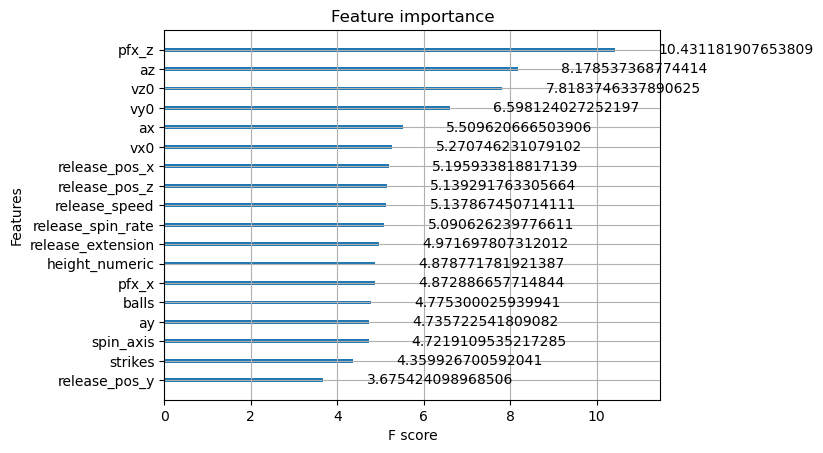

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

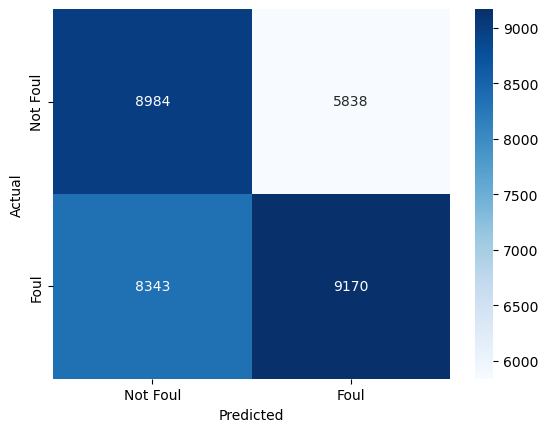

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xfoul'] = y_pred

C:\Users\clayton\AppData\Local\Temp\ipykernel_3744\2390537613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xfoul'] = y_pred


In [ ]:
testing_identifiers.head()

,pitch_id_raw,xfoul
0,663364_455139_617228_4_75_10,0.636266
1,663364_455139_617228_3_75_10,0.586549
2,663364_455139_617228_2_75_10,0.347812
3,663364_455139_617228_1_75_10,0.384995
5,663364_593428_605347_4_72_10,0.731799


In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/foul_2022&3_xfoul.csv")